In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
import copy

from scipy.special import expit
import numpy as np
import torch

from sklearn.linear_model import (LogisticRegression, LinearRegression)
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import classification_report
from sklearn.model_selection import ParameterGrid

from sklearn.metrics import r2_score

from torch.utils.data import TensorDataset, DataLoader
import time as time

from torchvision import datasets
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [2]:
import random

seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Fashion MNIST


In [4]:
fashion_MNIST_train = datasets.FashionMNIST('./fashion_mnist',
                                            train=True,
                                            download=True,
                                            transform=transforms.ToTensor())

fashion_MNIST_test = datasets.FashionMNIST('./fashion_mnist',
                                           train=False,
                                           download=True,
                                           transform=transforms.ToTensor())

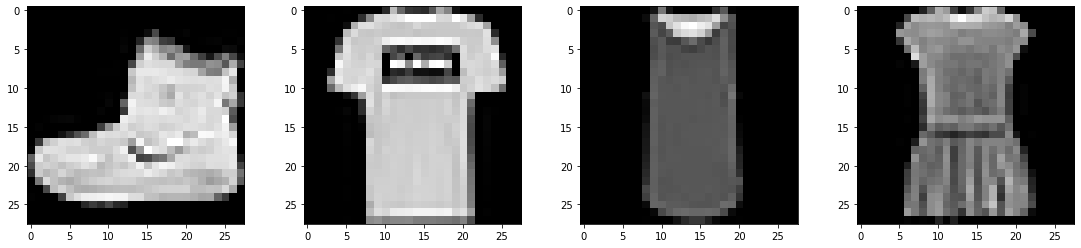

In [5]:
fig, gs = plt.figure(figsize=(19, 4)), gridspec.GridSpec(1, 4)

ax = []

for i in range(4):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].imshow(np.array(fashion_MNIST_train[i][0][0]), 'gray')

plt.show()

# Functions and classes

In [6]:
class convex_weighing_machine(torch.nn.Module):
    '''
    Builds a model that is a convex combination of models from a trained_list
    
    To get a convex combination, use softmax
    '''
    def __init__(self,
                 trained_list,
                 input_dim=784,
                 num_layers=0,
                 hidden_dim=64,
                 output_dim=1,
                 p=0.0):

        super().__init__()
        self.trained_list = trained_list
        self.conv_weights = torch.nn.Parameter(torch.ones(len(trained_list)))
        self.conv_weights.requires_grad = True

    def forward(self, x):
        outs = self.trained_list[0](x) * torch.exp(self.conv_weights[0])
        for model_id in range(1, len(self.trained_list)):
            outs += self.trained_list[model_id](x) * torch.exp(
                self.conv_weights[model_id])
        return outs / torch.exp(self.conv_weights).sum()

In [7]:
class line_weighing_machine(torch.nn.Module):
    '''
    Builds a model that is a linear combination of models from a trained_list
    
    Initial initialization by averaging
    '''
    def __init__(self,
                 trained_list,
                 input_dim=784,
                 num_layers=0,
                 hidden_dim=64,
                 output_dim=1,
                 p=0.0):

        super().__init__()
        self.trained_list = trained_list
        coefs = np.array([1 / (len(trained_list))] * len(trained_list))
        self.conv_weights = torch.nn.Parameter(torch.from_numpy(coefs))
        self.conv_weights.requires_grad = True

    def forward(self, x):
        outs = self.trained_list[0](x) * (self.conv_weights[0])
        for model_id in range(1, len(self.trained_list)):
            outs += self.trained_list[model_id](x) * (
                self.conv_weights[model_id])
        return outs

In [8]:
def make_list_of_models(num_of_models,
                        dataset,
                        loss_function,
                        epochs,
                        lr,
                        input_dim=784,
                        num_layers=0,
                        hidden_dim=20,
                        grad=True,
                        output_dim=1,
                        p=0.0):
    '''
  Builds a list of models

  Depending on the value of the parameter grad:
      *) trains and freezes the weights
      *) leaves a random initialization
  '''

    trained_list = torch.nn.ModuleList()
    for idm in range(num_of_models):
        model = Perceptron(input_dim=input_dim,
                           num_layers=num_layers,
                           hidden_dim=hidden_dim,
                           output_dim=output_dim,
                           p=p)
        if grad == False:
            model.to(device)
            _ = model.train()
            trainer(model=model,
                    dataset=dataset,
                    lr=lr,
                    loss_function=loss_function,
                    optimizer=torch.optim.Adam,
                    epochs=epochs)
            _ = model.eval()
            for par in model.parameters():
                par.requires_grad = False
        if grad == True:
            model.to(device)
            for par in model.parameters():
                par.requires_grad = True
        trained_list.append(copy.deepcopy(model))
    return trained_list

In [9]:
def classic_star_models(num_of_models,
                        dataset,
                        loss_function,
                        epochs,
                        lr,
                        warmup=False,
                        prop_warmup=0.0,
                        input_dim=784,
                        num_layers=0,
                        hidden_dim=20,
                        grad=False,
                        output_dim=1,
                        p=0.0):
    '''
  Builds a models based on star procedure: Classic Star (no wrmp) and Classic Star (new wrmp) 
  
  Depending on the value of warmup:
      *) builds only Classic Star (no wrmp)
      *) builds both models
  '''

    # Let's make list of trained models
    start_time = time.time()
    trained_list = make_list_of_models(num_of_models=num_of_models,
                                       dataset=dataset,
                                       loss_function=loss_function,
                                       epochs=epochs,
                                       lr=lr,
                                       input_dim=input_dim,
                                       num_layers=num_layers,
                                       hidden_dim=hidden_dim,
                                       grad=False,
                                       output_dim=output_dim,
                                       p=p)
    trained_list_time = round(time.time() - start_time)
    trained_list_forwrmp = copy.deepcopy(trained_list)

    # Let's append new not trained model
    model = Perceptron(input_dim=input_dim,
                       num_layers=num_layers,
                       hidden_dim=hidden_dim,
                       output_dim=output_dim,
                       p=p)

    trained_list.append(copy.deepcopy(model))

    # Let's do convex weighing
    star_nowrmp = convex_weighing_machine(trained_list=trained_list,
                                          input_dim=input_dim,
                                          num_layers=num_layers,
                                          hidden_dim=hidden_dim,
                                          output_dim=output_dim,
                                          p=p)
    star_nowrmp.to(device)
    _ = star_nowrmp.train()
    start_time = time.time()
    trainer(model=star_nowrmp,
            dataset=dataset,
            lr=lr,
            loss_function=loss_function,
            optimizer=torch.optim.Adam,
            epochs=epochs)
    _ = star_nowrmp.eval()
    star_nowrmp_time = round(time.time() - start_time) + trained_list_time
    if warmup:
        start_time = time.time()
        model = Perceptron(input_dim=input_dim,
                           num_layers=num_layers,
                           hidden_dim=hidden_dim,
                           output_dim=output_dim,
                           p=p)
        model.to(device)
        _ = model.train()
        trainer(model=model,
                dataset=dataset,
                lr=lr,
                loss_function=loss_function,
                optimizer=torch.optim.Adam,
                epochs=int(epochs * prop_warmup))
        _ = model.eval()
        trained_list_forwrmp.append(model)
        star_newwrmp = convex_weighing_machine(
            trained_list=trained_list_forwrmp,
            input_dim=input_dim,
            num_layers=num_layers,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            p=p)
        star_newwrmp.to(device)
        _ = star_newwrmp.train()
        start_time = time.time()
        trainer(model=star_newwrmp,
                dataset=dataset,
                lr=lr,
                loss_function=loss_function,
                optimizer=torch.optim.Adam,
                epochs=int(epochs * (1 - prop_warmup)))
        _ = star_newwrmp.eval()
        star_newwrmp_time = round(time.time() - start_time) + trained_list_time
    else:
        star_newwrmp, star_newwrmp_time = None, None

    return star_nowrmp, star_newwrmp, star_nowrmp_time, star_newwrmp_time

In [10]:
def snapshot_list(num_of_models,
                  dataset,
                  loss_function,
                  budget,
                  lr,
                  input_dim=784,
                  num_layers=0,
                  hidden_dim=20,
                  grad=True,
                  output_dim=1,
                  p=0.0):
    '''
  Builds a list of models based on the snapshot technique

  The latest model is inserted into the list twice
  Number of epochs per model train is budget//num_cycles
  Doing num_of_model-1 cycles (we leave the last cycle for the possibility of choosing the aggregation process)
  '''
    num_cycles = num_of_models
    epochs = budget // num_cycles
    trained_list = torch.nn.ModuleList()
    model = Perceptron(input_dim=input_dim,
                       num_layers=num_layers,
                       hidden_dim=hidden_dim,
                       output_dim=output_dim,
                       p=p)
    for idm in range(num_cycles - 1):
        model.to(device)
        _ = model.train()
        cycle_trainer(model=model,
                      dataset=dataset,
                      lr=lr,
                      loss_function=loss_function,
                      optimizer=torch.optim.Adam,
                      epochs=epochs)
        _ = model.eval()
        copy_model = copy.deepcopy(model)
        for par in copy_model.parameters():
            par.requires_grad = False
        trained_list.append(copy_model)
    trained_list.append(copy.deepcopy(model))
    return trained_list

In [11]:
def snap_models(num_of_models,
                dataset,
                loss_function,
                budget,
                lr,
                input_dim=784,
                num_layers=0,
                hidden_dim=20,
                grad=False,
                output_dim=1,
                p=0.0,
                warmup=True,
                prop_warmup=0.4):
    '''
  Builds based on the one list of models from the snapshot technique Snap Star (shot wrmp), Snap Ensemble and Snap Star (new wrmp)
  
  Along with the models returns the training time                                   
  '''
    # Let's make list of trained models by snapshot technique
    start_time = time.time()
    trained_list = snapshot_list(num_of_models=num_of_models,
                                 dataset=dataset,
                                 loss_function=loss_function,
                                 budget=budget,
                                 lr=lr,
                                 input_dim=input_dim,
                                 num_layers=num_layers,
                                 hidden_dim=hidden_dim,
                                 grad=False,
                                 output_dim=output_dim,
                                 p=p)

    snapstar_shotwrmp_list = copy.deepcopy(trained_list)
    snapstar_newwrmp_list = copy.deepcopy(trained_list)
    snapensemble_trained_list = copy.deepcopy(trained_list)

    # Let's do Snap Ensemble
    training_list_time = round(time.time() - start_time)
    model = snapensemble_trained_list[-1]
    model.to(device)
    _ = model.train()
    start_time = time.time()
    cycle_trainer(model=model,
                  dataset=dataset,
                  lr=lr,
                  loss_function=loss_function,
                  optimizer=torch.optim.Adam,
                  epochs=budget // num_of_models)
    _ = model.eval()
    snapensemble_trained_list[-1] = model
    last_model_ensemble = round(time.time() - start_time)
    snapensemble_time = training_list_time + last_model_ensemble
    print("Training time: Snap Ensemble", snapensemble_time, "seconds")

    # Let's do Snap Star (shot wrmp)
    snapstar_shotwrmp = convex_weighing_machine(
        trained_list=snapstar_shotwrmp_list,
        input_dim=input_dim,
        num_layers=num_layers,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        p=p)
    snapstar_shotwrmp.to(device)
    start_time = time.time()
    _ = snapstar_shotwrmp.train()
    cycle_trainer(model=snapstar_shotwrmp,
                  dataset=dataset,
                  lr=lr,
                  loss_function=loss_function,
                  optimizer=torch.optim.Adam,
                  epochs=budget // num_of_models)
    _ = snapstar_shotwrmp.eval()
    last_model_snapstar_shotwrmp = round(time.time() - start_time)
    snapstar_shotwrmp_time = training_list_time + last_model_snapstar_shotwrmp
    print("Training time: Snap Star (shot wrmp)", snapstar_shotwrmp_time,
          "seconds")

    #Let's train Snap Star (new wrmp)
    model = Perceptron(input_dim=input_dim,
                       num_layers=num_layers,
                       hidden_dim=hidden_dim,
                       output_dim=output_dim,
                       p=p)
    model.to(device)
    _ = model.train()
    start_time = time.time()
    trainer(model=model,
            dataset=dataset,
            lr=lr,
            loss_function=loss_function,
            optimizer=torch.optim.Adam,
            epochs=int((prop_warmup) * budget // num_of_models))
    _ = model.eval()
    warmup_time = round(time.time() - start_time)
    snapstar_newwrmp_list[-1] = model
    snapstar_newwrmp = convex_weighing_machine(
        trained_list=snapstar_newwrmp_list,
        input_dim=input_dim,
        num_layers=num_layers,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        p=p)
    snapstar_newwrmp.to(device)
    start_time = time.time()
    _ = snapstar_newwrmp.train()
    trainer(model=snapstar_newwrmp,
            dataset=dataset,
            lr=lr,
            loss_function=loss_function,
            optimizer=torch.optim.Adam,
            epochs=int((1 - prop_warmup) * budget // num_of_models))
    _ = snapstar_newwrmp.eval()
    last_model_time = round(time.time() - start_time) + warmup_time
    snapstar_newwrmp_time = training_list_time + last_model_time
    print("Training time: Snap Star (new wrmp)", snapstar_newwrmp_time,
          "seconds")

    return snapstar_shotwrmp, snapensemble_trained_list, snapstar_newwrmp,\
           snapstar_shotwrmp_time, snapensemble_time, snapstar_newwrmp_time

In [12]:
def ensemble(num_of_models,
             dataset,
             loss_function,
             epochs,
             lr,
             input_dim=784,
             num_layers=0,
             hidden_dim=20,
             grad=False,
             output_dim=1,
             p=0.0):
    '''
  Building a model Ensemble
  
  Returns a list of models to average
  '''

    # Let's make list of not trained models
    trained_list = make_list_of_models(num_of_models=num_of_models,
                                       dataset=dataset,
                                       loss_function=loss_function,
                                       epochs=epochs,
                                       lr=lr,
                                       input_dim=input_dim,
                                       num_layers=num_layers,
                                       hidden_dim=hidden_dim,
                                       grad=False,
                                       output_dim=output_dim,
                                       p=p)
    # Let's append new trained model
    model = Perceptron(input_dim=input_dim,
                       num_layers=num_layers,
                       hidden_dim=hidden_dim,
                       output_dim=output_dim,
                       p=p)
    model.to(device)
    _ = model.train()
    trainer(model=model,
            dataset=dataset,
            lr=lr,
            loss_function=loss_function,
            optimizer=torch.optim.Adam,
            epochs=epochs)
    _ = model.eval()
    trained_list.append(copy.deepcopy(_))
    return trained_list

In [13]:
def big_nn(num_of_models,
           dataset,
           loss_function,
           epochs,
           lr,
           input_dim=784,
           num_layers=0,
           hidden_dim=20,
           grad=False,
           output_dim=1,
           p=0.0):
    '''
  Building a model Big NN
  '''

    # Let's make list of not trained models
    trained_list = make_list_of_models(num_of_models=num_of_models,
                                       dataset=dataset,
                                       loss_function=loss_function,
                                       epochs=epochs,
                                       lr=lr,
                                       input_dim=input_dim,
                                       num_layers=num_layers,
                                       hidden_dim=hidden_dim,
                                       grad=True,
                                       output_dim=output_dim,
                                       p=p)
    # Let's append new not trained model
    model = Perceptron(input_dim=input_dim,
                       num_layers=num_layers,
                       hidden_dim=hidden_dim,
                       output_dim=output_dim,
                       p=p)
    trained_list.append(copy.deepcopy(model))
    # Let's do linear weighing
    final_model = line_weighing_machine(trained_list=trained_list,
                                        input_dim=input_dim,
                                        num_layers=num_layers,
                                        hidden_dim=hidden_dim,
                                        output_dim=output_dim,
                                        p=p)
    final_model.to(device)
    _ = final_model.train()
    trainer(model=final_model,
            dataset=dataset,
            lr=lr,
            loss_function=loss_function,
            optimizer=torch.optim.Adam,
            epochs=epochs)
    _ = final_model.eval()

    return _

In [14]:
class Perceptron(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device

    def __init__(self,
                 input_dim=784,
                 num_layers=0,
                 hidden_dim=15,
                 output_dim=10,
                 p=0.0):
        super(Perceptron, self).__init__()

        self.layers = torch.nn.Sequential()
        self.layers.add_module('conv1', torch.nn.Conv2d(1,
                                                        1 * 6,
                                                        kernel_size=5))
        self.layers.add_module('relu1', torch.nn.ReLU())
        self.layers.add_module('pool1', torch.nn.MaxPool2d(kernel_size=2))
        self.layers.add_module('conv2',
                               torch.nn.Conv2d(1 * 6, 1 * 16, kernel_size=5))
        self.layers.add_module('relu2', torch.nn.ReLU())
        self.layers.add_module('pool2', torch.nn.MaxPool2d(kernel_size=2))
        self.layers.add_module('flatten', torch.nn.Flatten())
        self.layers.add_module('linear1', torch.nn.Linear(16 * 4 * 4, 120))
        self.layers.add_module('relu3', torch.nn.ReLU())
        self.layers.add_module('linear2', torch.nn.Linear(120, 84))
        self.layers.add_module('relu4', torch.nn.ReLU())
        self.layers.add_module('linear3', torch.nn.Linear(84, 10))

    def forward(self, input):
        return self.layers(input)

# Train-functions

In [15]:
def trainer(epochs,
            dataset,
            model,
            loss_function,
            optimizer,
            batch_size=64,
            lr=0.01,
            callback=None):
    start_time = time.time()
    optima = optimizer(model.parameters(), lr=lr)

    iterations = tqdm(range(epochs), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True),
                               leave=False)

        epoch_loss = train_epoch(train_generator=batch_generator,
                                 model=model,
                                 loss_function=loss_function,
                                 optimizer=optima,
                                 callback=callback)

        iterations.set_postfix({'train epoch loss': epoch_loss})
        acc, report = testing(model, fashion_MNIST_test)
        entropy = loss(model.eval(),
                       dataset=fashion_MNIST_test,
                       loss_function=torch.nn.CrossEntropyLoss())
        print('epoch num: ', it, 'loss: ', entropy, '\n', report)
    training_time = round(time.time() - start_time)
    print("Training time:", training_time, "seconds")

In [16]:
def cycle_trainer(epochs,
                  dataset,
                  model,
                  loss_function,
                  optimizer,
                  batch_size=64,
                  lr=0.01,
                  callback=None):
    '''
    Learning with cyclic change of lr by cosine formula from snapshot ensemble
    Cycle length is epochs
    '''
    start_time = time.time()
    iterations = tqdm(range(epochs), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True),
                               leave=False)
        # lets calculate lr_
        lr_ = (lr / 2) * (np.cos(np.pi * (it / epochs)) + 1)
        optima = optimizer(model.parameters(), lr=lr_)

        epoch_loss = train_epoch(train_generator=batch_generator,
                                 model=model,
                                 loss_function=loss_function,
                                 optimizer=optima,
                                 callback=callback)

        iterations.set_postfix({'train epoch loss': epoch_loss})
        acc, report = testing(model, fashion_MNIST_test)
        entropy = loss(model.eval(),
                       dataset=fashion_MNIST_test,
                       loss_function=torch.nn.CrossEntropyLoss())
        print('epoch num: ', it, 'lr:', lr_, ' loss: ', entropy, '\n', report)
    training_time = round(time.time() - start_time)
    print("Training time:", training_time, "seconds")

In [17]:
def train_epoch(train_generator,
                model,
                loss_function,
                optimizer,
                callback=None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x.to(device),
                                    batch_of_y.to(device), optimizer,
                                    loss_function)

        if callback is not None:
            callback(model, batch_loss)

        epoch_loss += batch_loss * len(batch_of_x)
        total += len(batch_of_x)

    return epoch_loss / total

In [18]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    model.zero_grad()
    optimizer.zero_grad()
    x = x_batch
    y = y_batch
    output = model(x)
    loss_ = loss_function(output, y)
    loss_.backward()
    optimizer.step()
    return loss_.cpu().item()

In [19]:
def loss(model, dataset, loss_function, seed=0):
    test_losses = []
    train_losses = []
    generator = torch.utils.data.DataLoader(dataset,
                                            batch_size=dataset.__len__(),
                                            shuffle=True,
                                            drop_last=True)
    with torch.no_grad():
        for x, y in tqdm(generator, leave=False):
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            loss = loss_function(output, y)

    return loss.cpu().item()

In [20]:
def ensemble_loss(trained_list, dataset, loss_function, seed=0):
    test_losses = []
    train_losses = []
    generator = torch.utils.data.DataLoader(dataset,
                                            batch_size=dataset.__len__(),
                                            shuffle=True,
                                            drop_last=True)
    with torch.no_grad():
        for x, y in tqdm(generator, leave=False):
            x = x.to('cpu')
            y = y.to('cpu')
            target_ = y.detach().numpy()
            output = trained_list[0].to('cpu')(x)
            func = torch.nn.Softmax(dim=1)
            # calculate the result of the first model
            output = func(output)
            input_ = output.detach().numpy()
            ensemble_input = input_

            # calculate and aggregate the results of the other models
            for num_mod in range(1, len(trained_list)):
                output = trained_list[num_mod].to('cpu')(x)
                output = func(output)
                input_ = output.detach().numpy()
                ensemble_input += input_
            ensemble_input = ensemble_input / len(trained_list)

            # calculate sum entropy-loss
            loss = 0
            for i in range(input_.shape[0]):
                loss -= np.log(ensemble_input[i][target_[i]])
    return loss / x.shape[0]

In [21]:
def testing(model, dataset):
    generator = torch.utils.data.DataLoader(dataset, batch_size=64)
    pred = []
    real = []
    for x, y in generator:
        x = x.to(device)
        y = y.to(device)

        pred.extend(torch.argmax(model(x), dim=-1).cpu().numpy().tolist())
        real.extend(y.cpu().numpy().tolist())
    return np.mean(np.array(real) == np.array(pred)), \
           classification_report(real, pred, digits = 4)

In [22]:
def ensemble_testing(trained_list, dataset):
    generator = torch.utils.data.DataLoader(dataset, batch_size=64)
    pred = []
    real = []
    for x, y in generator:
        x = x.to('cpu')
        y = y.to('cpu')

        # calculate the result of the first model
        target_ = y.detach().numpy()
        output = trained_list[0].to('cpu')(x)
        func = torch.nn.Softmax(dim=1)
        output = func(output)
        input_ = output.detach().numpy()
        ensemble_input = input_

        # calculate and aggregate the results of the other models
        for num_mod in range(1, len(trained_list)):
            output = trained_list[num_mod].to('cpu')(x)
            output = func(output)
            input_ = output.detach().numpy()
            ensemble_input += input_
        ensemble_input = ensemble_input / len(trained_list)
        pred.extend(
            torch.argmax(torch.Tensor(ensemble_input),
                         dim=-1).cpu().numpy().tolist())
        real.extend(y.cpu().numpy().tolist())
    return np.mean(np.array(real) == np.array(pred)), \
           classification_report(real, pred, digits = 4)

In [23]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    x = np.exp(x)
    return x / np.sum(x)

In [24]:
def print_params_of_model(list_of_model):
    r'''
  print params of the list of model
  '''
    idm = 0
    for model in list_of_model:
        params = [x for x in model.parameters()]
        print('params model num:', idm, params, '\n')
        idm += 1


def print_convex_params(model):
    r'''
  print convex params of model
  '''
    coefs = model.conv_weights.detach().numpy()
    convex_coefs = np.exp(coefs) / sum(np.exp(coefs))
    print('convex params of model:', convex_coefs, '\n')

# Let's run some tests

In [25]:
from sklearn.model_selection import ParameterGrid

grid = ParameterGrid({
    'epochs': [15],
    'p': [0.0],
    'loss': [torch.nn.CrossEntropyLoss()],
    'out_dim': [10],
    'lr': [0.001],
    'inp_dim': [784],
    'num_mod': [1,2,3],
    'grad': [False]
})

In [26]:
results = pd.DataFrame(
    data=[],
    columns=['Name', 'd', 'epochs', 'accuracy', 'entropy', 'TIME', 'p', 'lr'])

In [27]:
starts = 3
for start in tqdm(range(starts)):
    for item in tqdm(grid):

        # Let's train Snap Star (new wrmp), Snap Ensemble and Snap Star (shot wrmp)
        snap_star_shotwarmup, snap_ensemble, snap_star_newwarmup, snap_star_shotwarmup_time,\
        ensemble_time, snap_star_newwarmup_time = snap_models(num_of_models = (item['num_mod']+1),
                                                              dataset=fashion_MNIST_train,
                                                              loss_function=item['loss'],
                                                              output_dim=item['out_dim'],
                                                              budget=item['epochs']*(item['num_mod']+1),
                                                              input_dim=item['inp_dim'],
                                                              lr =item['lr'],
                                                              p=item['p'],
                                                              grad =item['grad'])

        # Let's test Snap Star (new wrmp)
        print("Training time:", snap_star_newwarmup_time, "seconds")
        acc, report = testing(snap_star_newwarmup, fashion_MNIST_test)
        entropy = loss(snap_star_newwarmup,
                       dataset=fashion_MNIST_test,
                       loss_function=torch.nn.CrossEntropyLoss())
        print('Snap Star (new wrmp) (epochs, num model):', item['epochs'],
              item['num_mod'], '\n', report)
        snap_star_newwarmup_scores = pd.DataFrame(data=[[
            "Snap Star (new wrmp)", item['num_mod'], item['epochs'], acc,
            entropy, snap_star_newwarmup_time, item['p'], item['lr']
        ]],
                                                  columns=[
                                                      'Name', 'd', 'epochs',
                                                      'accuracy', 'entropy',
                                                      'TIME', 'p', 'lr'
                                                  ])
        results = pd.concat([snap_star_newwarmup_scores, results],
                            ignore_index=False)
        print('Snap Star (new wrmp) params:')
        print_convex_params(snap_star_newwarmup)

        # Let's test Snap Star (shot wrmp)
        print("Training time:", snap_star_shotwarmup_time, "seconds")
        acc, report = testing(snap_star_shotwarmup, fashion_MNIST_test)
        entropy = loss(snap_star_shotwarmup,
                       dataset=fashion_MNIST_test,
                       loss_function=torch.nn.CrossEntropyLoss())
        print('Snap Star (shot wrmp) (epochs, num model):', item['epochs'],
              item['num_mod'], '\n', report)
        snap_star_shotwarmup_scores = pd.DataFrame(data=[[
            "Snap Star (shot wrmp)", item['num_mod'], item['epochs'], acc,
            entropy, snap_star_shotwarmup_time, item['p'], item['lr']
        ]],
                                                   columns=[
                                                       'Name', 'd', 'epochs',
                                                       'accuracy', 'entropy',
                                                       'TIME', 'p', 'lr'
                                                   ])
        results = pd.concat([snap_star_shotwarmup_scores, results],
                            ignore_index=False)
        print('Snap Star (shot wrmp) params:')
        print_convex_params(snap_star_shotwarmup)

        # Let's test Snap Ensemble
        print("Training time:", ensemble_time, "seconds")
        acc, report = ensemble_testing(snap_ensemble, fashion_MNIST_test)
        entropy = ensemble_loss(snap_ensemble,
                                dataset=fashion_MNIST_test,
                                loss_function=torch.nn.CrossEntropyLoss())
        print('Snap Ensemble (epochs, num model):', item['epochs'],
              item['num_mod'], '\n', report)
        snap_ensemble_scores = pd.DataFrame(data=[[
            "Snap Ensemble", item['num_mod'], item['epochs'], acc, entropy,
            ensemble_time, item['p'], item['lr']
        ]],
                                            columns=[
                                                'Name', 'd', 'epochs',
                                                'accuracy', 'entropy', 'TIME',
                                                'p', 'lr'
                                            ])
        results = pd.concat([snap_ensemble_scores, results],
                            ignore_index=False)

        # Let's train Ensemble
        start_time = time.time()
        nn_ensemble = ensemble(num_of_models=item['num_mod'],
                               dataset=fashion_MNIST_train,
                               loss_function=item['loss'],
                               output_dim=item['out_dim'],
                               epochs=item['epochs'],
                               input_dim=item['inp_dim'],
                               lr=item['lr'],
                               p=item['p'],
                               grad=item['grad'])
        _ = nn_ensemble.eval()
        training_time = round(time.time() - start_time)

        # Let's test Ensemble
        print("Training time:", training_time, "seconds")
        acc, report = ensemble_testing(nn_ensemble, fashion_MNIST_test)
        entropy = ensemble_loss(nn_ensemble,
                                dataset=fashion_MNIST_test,
                                loss_function=torch.nn.CrossEntropyLoss())
        print('Ensemble (epochs, num model):', item['epochs'], item['num_mod'],
              '\n', report)
        ensemble_scores = pd.DataFrame(data=[[
            "Ensemble", item['num_mod'], item['epochs'], acc, entropy,
            training_time, item['p'], item['lr']
        ]],
                                       columns=[
                                           'Name', 'd', 'epochs', 'accuracy',
                                           'entropy', 'TIME', 'p', 'lr'
                                       ])
        results = pd.concat([ensemble_scores, results], ignore_index=False)

        # Let's train Big NN
        start_time = time.time()
        bignn = big_nn(num_of_models=item['num_mod'],
                       dataset=fashion_MNIST_train,
                       loss_function=item['loss'],
                       output_dim=item['out_dim'],
                       epochs=item['epochs'],
                       input_dim=item['inp_dim'],
                       lr=item['lr'],
                       p=item['p'],
                       grad=item['grad'])
        _ = bignn.eval()
        training_time = round(time.time() - start_time)

        #Let's test Big NN
        print("Training time:", training_time, "seconds")
        acc, report = testing(bignn, fashion_MNIST_test)
        entropy = loss(bignn,
                       dataset=fashion_MNIST_test,
                       loss_function=torch.nn.CrossEntropyLoss())
        print('Big NN (epochs, num model):', item['epochs'], item['num_mod'],
              '\n', report)
        big_nn_scores = pd.DataFrame(data=[[
            "Big NN", item['num_mod'], item['epochs'], acc, entropy,
            training_time, item['p'], item['lr']
        ]],
                                     columns=[
                                         'Name', 'd', 'epochs', 'accuracy',
                                         'entropy', 'TIME', 'p', 'lr'
                                     ])
        results = pd.concat([big_nn_scores, results], ignore_index=False)
        print('Big NN params:')
        print_convex_params(bignn)

        # Let's train Classic Star (no wrmp) and Classic Star (new wrmp)
        start_time = time.time()
        star_nowrmp, star_newwrmp, star_nowrmp_time, star_newwrmp_time = classic_star_models(
            num_of_models=item['num_mod'],
            dataset=fashion_MNIST_train,
            loss_function=item['loss'],
            output_dim=item['out_dim'],
            epochs=item['epochs'],
            input_dim=item['inp_dim'],
            lr=item['lr'],
            warmup=True,
            prop_warmup=0.4,
            p=item['p'],
            grad=item['grad'])

        # Let's test Classic Star (no wrmp)
        print("Training time:", star_nowrmp_time, "seconds")
        acc, report = testing(star_nowrmp, fashion_MNIST_test)
        entropy = loss(star_nowrmp,
                       dataset=fashion_MNIST_test,
                       loss_function=torch.nn.CrossEntropyLoss())
        print('Classic Star (no wrmp) (epochs, num model):', item['epochs'],
              item['num_mod'], '\n', report)
        star_nowrmp_scores = pd.DataFrame(data=[[
            "Classic Star (no wrmp)", item['num_mod'], item['epochs'], acc,
            entropy, star_nowrmp_time, item['p'], item['lr']
        ]],
                                          columns=[
                                              'Name', 'd', 'epochs',
                                              'accuracy', 'entropy', 'TIME',
                                              'p', 'lr'
                                          ])
        results = pd.concat([star_nowrmp_scores, results], ignore_index=False)
        print('Classic Star (no wrmp) params:')
        print_convex_params(star_nowrmp)

        # Let's test Classic Star (new wrmp)
        print("Training time:", star_newwrmp_time, "seconds")
        acc, report = testing(star_newwrmp, fashion_MNIST_test)
        entropy = loss(star_newwrmp,
                       dataset=fashion_MNIST_test,
                       loss_function=torch.nn.CrossEntropyLoss())
        print('Classic Star (new wrmp) (epochs, num model):', item['epochs'],
              item['num_mod'], '\n', report)
        star_newwrmp_scores = pd.DataFrame(data=[[
            "Classic Star (new wrmp)", item['num_mod'], item['epochs'], acc,
            entropy, star_newwrmp_time, item['p'], item['lr']
        ]],
                                           columns=[
                                               'Name', 'd', 'epochs',
                                               'accuracy', 'entropy', 'TIME',
                                               'p', 'lr'
                                           ])
        results = pd.concat([star_newwrmp_scores, results], ignore_index=False)
        print('Classic Star (new wrmp) params:')
        print_convex_params(star_newwrmp)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.5221623182296753 
               precision    recall  f1-score   support

           0     0.7424    0.8040    0.7720      1000
           1     0.9284    0.9720    0.9497      1000
           2     0.7699    0.4650    0.5798      1000
           3     0.7941    0.8290    0.8112      1000
           4     0.6099    0.8160    0.6980      1000
           5     0.9591    0.9140    0.9360      1000
           6     0.4255    0.3600    0.3900      1000
           7     0.9157    0.8800    0.8975      1000
           8     0.9284    0.9590    0.9434      1000
           9     0.8845    0.9650    0.9230      1000

    accuracy                         0.7964     10000
   macro avg     0.7958    0.7964    0.7901     10000
weighted avg     0.7958    0.7964    0.7901     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.4252394437789917 
               precision    recall  f1-score   support

           0     0.7808    0.8230    0.8014      1000
           1     0.8955    0.9850    0.9381      1000
           2     0.7269    0.7880    0.7562      1000
           3     0.9050    0.7810    0.8384      1000
           4     0.7393    0.7740    0.7562      1000
           5     0.9653    0.9470    0.9561      1000
           6     0.6106    0.5080    0.5546      1000
           7     0.9027    0.9560    0.9286      1000
           8     0.9532    0.9580    0.9556      1000
           9     0.9538    0.9300    0.9418      1000

    accuracy                         0.8450     10000
   macro avg     0.8433    0.8450    0.8427     10000
weighted avg     0.8433    0.8450    0.8427     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.392341673374176 
               precision    recall  f1-score   support

           0     0.7678    0.8630    0.8126      1000
           1     0.9731    0.9750    0.9740      1000
           2     0.7390    0.8410    0.7867      1000
           3     0.9030    0.8380    0.8693      1000
           4     0.8034    0.7520    0.7769      1000
           5     0.9384    0.9750    0.9564      1000
           6     0.6683    0.5560    0.6070      1000
           7     0.9713    0.8450    0.9037      1000
           8     0.9260    0.9760    0.9503      1000
           9     0.9034    0.9730    0.9369      1000

    accuracy                         0.8594     10000
   macro avg     0.8594    0.8594    0.8574     10000
weighted avg     0.8594    0.8594    0.8574     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.3508375883102417 
               precision    recall  f1-score   support

           0     0.7914    0.8460    0.8178      1000
           1     0.9938    0.9560    0.9745      1000
           2     0.7683    0.8390    0.8021      1000
           3     0.8576    0.8970    0.8768      1000
           4     0.7579    0.8390    0.7964      1000
           5     0.9476    0.9770    0.9621      1000
           6     0.7525    0.5170    0.6129      1000
           7     0.9464    0.9180    0.9320      1000
           8     0.9447    0.9730    0.9586      1000
           9     0.9483    0.9540    0.9511      1000

    accuracy                         0.8716     10000
   macro avg     0.8708    0.8716    0.8684     10000
weighted avg     0.8708    0.8716    0.8684     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.3336915969848633 
               precision    recall  f1-score   support

           0     0.8038    0.8480    0.8253      1000
           1     0.9847    0.9680    0.9763      1000
           2     0.7544    0.8600    0.8037      1000
           3     0.8926    0.8730    0.8827      1000
           4     0.8259    0.7780    0.8012      1000
           5     0.9776    0.9580    0.9677      1000
           6     0.6878    0.6410    0.6636      1000
           7     0.9451    0.9300    0.9375      1000
           8     0.9855    0.9540    0.9695      1000
           9     0.9316    0.9670    0.9490      1000

    accuracy                         0.8777     10000
   macro avg     0.8789    0.8777    0.8777     10000
weighted avg     0.8789    0.8777    0.8777     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.3237544894218445 
               precision    recall  f1-score   support

           0     0.8197    0.8140    0.8169      1000
           1     0.9927    0.9560    0.9740      1000
           2     0.7793    0.8580    0.8168      1000
           3     0.8430    0.9290    0.8839      1000
           4     0.8451    0.7750    0.8086      1000
           5     0.9718    0.9650    0.9684      1000
           6     0.6959    0.6430    0.6684      1000
           7     0.9234    0.9650    0.9438      1000
           8     0.9681    0.9710    0.9695      1000
           9     0.9791    0.9390    0.9587      1000

    accuracy                         0.8815     10000
   macro avg     0.8818    0.8815    0.8809     10000
weighted avg     0.8818    0.8815    0.8809     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.3133593201637268 
               precision    recall  f1-score   support

           0     0.8141    0.8450    0.8292      1000
           1     0.9859    0.9760    0.9809      1000
           2     0.8929    0.7340    0.8057      1000
           3     0.9074    0.8920    0.8996      1000
           4     0.8083    0.8390    0.8234      1000
           5     0.9615    0.9730    0.9672      1000
           6     0.6540    0.7200    0.6854      1000
           7     0.9354    0.9550    0.9451      1000
           8     0.9549    0.9750    0.9649      1000
           9     0.9754    0.9500    0.9625      1000

    accuracy                         0.8859     10000
   macro avg     0.8890    0.8859    0.8864     10000
weighted avg     0.8890    0.8859    0.8864     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.2985920310020447 
               precision    recall  f1-score   support

           0     0.8299    0.8390    0.8344      1000
           1     0.9879    0.9760    0.9819      1000
           2     0.8780    0.7920    0.8328      1000
           3     0.9080    0.8780    0.8927      1000
           4     0.7634    0.8840    0.8193      1000
           5     0.9777    0.9660    0.9718      1000
           6     0.7065    0.6980    0.7022      1000
           7     0.9322    0.9630    0.9474      1000
           8     0.9847    0.9660    0.9753      1000
           9     0.9715    0.9560    0.9637      1000

    accuracy                         0.8918     10000
   macro avg     0.8940    0.8918    0.8922     10000
weighted avg     0.8940    0.8918    0.8922     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.28995513916015625 
               precision    recall  f1-score   support

           0     0.8127    0.8590    0.8352      1000
           1     0.9928    0.9690    0.9808      1000
           2     0.8674    0.8110    0.8382      1000
           3     0.8880    0.9120    0.8999      1000
           4     0.7837    0.8840    0.8308      1000
           5     0.9663    0.9740    0.9701      1000
           6     0.7491    0.6480    0.6949      1000
           7     0.9481    0.9490    0.9485      1000
           8     0.9682    0.9740    0.9711      1000
           9     0.9639    0.9610    0.9624      1000

    accuracy                         0.8941     10000
   macro avg     0.8940    0.8941    0.8932     10000
weighted avg     0.8940    0.8941    0.8932     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.2934650778770447 
               precision    recall  f1-score   support

           0     0.8291    0.8490    0.8389      1000
           1     0.9908    0.9720    0.9813      1000
           2     0.8142    0.8500    0.8317      1000
           3     0.8854    0.9120    0.8985      1000
           4     0.8224    0.8430    0.8326      1000
           5     0.9814    0.9500    0.9654      1000
           6     0.7557    0.6680    0.7091      1000
           7     0.9446    0.9380    0.9413      1000
           8     0.9701    0.9750    0.9726      1000
           9     0.9321    0.9750    0.9531      1000

    accuracy                         0.8932     10000
   macro avg     0.8926    0.8932    0.8925     10000
weighted avg     0.8926    0.8932    0.8925     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.28389638662338257 
               precision    recall  f1-score   support

           0     0.8315    0.8440    0.8377      1000
           1     0.9898    0.9750    0.9824      1000
           2     0.8392    0.8300    0.8346      1000
           3     0.8893    0.9080    0.8986      1000
           4     0.8090    0.8600    0.8337      1000
           5     0.9747    0.9640    0.9693      1000
           6     0.7492    0.6780    0.7118      1000
           7     0.9293    0.9730    0.9507      1000
           8     0.9646    0.9800    0.9722      1000
           9     0.9794    0.9500    0.9645      1000

    accuracy                         0.8962     10000
   macro avg     0.8956    0.8962    0.8955     10000
weighted avg     0.8956    0.8962    0.8955     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.28468236327171326 
               precision    recall  f1-score   support

           0     0.8044    0.8680    0.8350      1000
           1     0.9898    0.9740    0.9819      1000
           2     0.8392    0.8400    0.8396      1000
           3     0.8820    0.9190    0.9001      1000
           4     0.8512    0.8120    0.8311      1000
           5     0.9737    0.9640    0.9688      1000
           6     0.7381    0.6850    0.7106      1000
           7     0.9419    0.9560    0.9489      1000
           8     0.9711    0.9760    0.9736      1000
           9     0.9601    0.9620    0.9610      1000

    accuracy                         0.8956     10000
   macro avg     0.8952    0.8956    0.8951     10000
weighted avg     0.8952    0.8956    0.8951     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.28072112798690796 
               precision    recall  f1-score   support

           0     0.8543    0.8150    0.8342      1000
           1     0.9898    0.9720    0.9808      1000
           2     0.8262    0.8510    0.8384      1000
           3     0.8900    0.9140    0.9018      1000
           4     0.8318    0.8410    0.8364      1000
           5     0.9759    0.9700    0.9729      1000
           6     0.7281    0.7150    0.7215      1000
           7     0.9351    0.9660    0.9503      1000
           8     0.9693    0.9790    0.9741      1000
           9     0.9744    0.9520    0.9631      1000

    accuracy                         0.8975     10000
   macro avg     0.8975    0.8975    0.8974     10000
weighted avg     0.8975    0.8975    0.8974     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.27916210889816284 
               precision    recall  f1-score   support

           0     0.8443    0.8350    0.8396      1000
           1     0.9898    0.9740    0.9819      1000
           2     0.8426    0.8460    0.8443      1000
           3     0.8908    0.9140    0.9023      1000
           4     0.8195    0.8670    0.8426      1000
           5     0.9777    0.9660    0.9718      1000
           6     0.7513    0.6980    0.7237      1000
           7     0.9325    0.9670    0.9494      1000
           8     0.9721    0.9760    0.9741      1000
           9     0.9715    0.9530    0.9621      1000

    accuracy                         0.8996     10000
   macro avg     0.8992    0.8996    0.8992     10000
weighted avg     0.8992    0.8996    0.8992     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.27844804525375366 
               precision    recall  f1-score   support

           0     0.8457    0.8330    0.8393      1000
           1     0.9898    0.9720    0.9808      1000
           2     0.8378    0.8470    0.8424      1000
           3     0.8886    0.9170    0.9026      1000
           4     0.8299    0.8540    0.8418      1000
           5     0.9768    0.9680    0.9724      1000
           6     0.7421    0.7050    0.7231      1000
           7     0.9342    0.9660    0.9499      1000
           8     0.9721    0.9770    0.9746      1000
           9     0.9715    0.9530    0.9621      1000

    accuracy                         0.8992     10000
   macro avg     0.8989    0.8992    0.8989     10000
weighted avg     0.8989    0.8992    0.8989     10000

Training time: 202 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.2981403172016144 
               precision    recall  f1-score   support

           0     0.7858    0.8660    0.8240      1000
           1     0.9918    0.9680    0.9798      1000
           2     0.8013    0.8590    0.8292      1000
           3     0.9101    0.8710    0.8901      1000
           4     0.8332    0.8090    0.8209      1000
           5     0.9479    0.9820    0.9646      1000
           6     0.7213    0.6650    0.6920      1000
           7     0.9616    0.9260    0.9435      1000
           8     0.9692    0.9740    0.9716      1000
           9     0.9598    0.9560    0.9579      1000

    accuracy                         0.8876     10000
   macro avg     0.8882    0.8876    0.8873     10000
weighted avg     0.8882    0.8876    0.8873     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.3109125792980194 
               precision    recall  f1-score   support

           0     0.8157    0.8410    0.8282      1000
           1     0.9928    0.9710    0.9818      1000
           2     0.8359    0.8050    0.8202      1000
           3     0.9167    0.8580    0.8864      1000
           4     0.7669    0.8950    0.8260      1000
           5     0.9844    0.9460    0.9648      1000
           6     0.7433    0.6400    0.6878      1000
           7     0.9432    0.9470    0.9451      1000
           8     0.9319    0.9850    0.9577      1000
           9     0.9347    0.9740    0.9540      1000

    accuracy                         0.8862     10000
   macro avg     0.8866    0.8862    0.8852     10000
weighted avg     0.8866    0.8862    0.8852     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.29025524854660034 
               precision    recall  f1-score   support

           0     0.8530    0.8240    0.8383      1000
           1     0.9918    0.9720    0.9818      1000
           2     0.8627    0.7980    0.8291      1000
           3     0.9082    0.8900    0.8990      1000
           4     0.7644    0.9050    0.8288      1000
           5     0.9746    0.9590    0.9667      1000
           6     0.7321    0.6970    0.7141      1000
           7     0.9324    0.9650    0.9484      1000
           8     0.9673    0.9760    0.9716      1000
           9     0.9635    0.9490    0.9562      1000

    accuracy                         0.8935     10000
   macro avg     0.8950    0.8935    0.8934     10000
weighted avg     0.8950    0.8935    0.8934     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.2959803640842438 
               precision    recall  f1-score   support

           0     0.8015    0.8840    0.8407      1000
           1     0.9820    0.9800    0.9810      1000
           2     0.7851    0.8770    0.8285      1000
           3     0.8829    0.9270    0.9044      1000
           4     0.8658    0.7550    0.8066      1000
           5     0.9788    0.9700    0.9744      1000
           6     0.7599    0.6520    0.7018      1000
           7     0.9328    0.9710    0.9515      1000
           8     0.9760    0.9760    0.9760      1000
           9     0.9773    0.9480    0.9624      1000

    accuracy                         0.8940     10000
   macro avg     0.8942    0.8940    0.8927     10000
weighted avg     0.8942    0.8940    0.8927     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.2958575487136841 
               precision    recall  f1-score   support

           0     0.8112    0.8810    0.8447      1000
           1     0.9889    0.9770    0.9829      1000
           2     0.8414    0.8540    0.8476      1000
           3     0.9186    0.8920    0.9051      1000
           4     0.7781    0.9080    0.8380      1000
           5     0.9709    0.9690    0.9700      1000
           6     0.7920    0.6130    0.6911      1000
           7     0.9387    0.9650    0.9517      1000
           8     0.9780    0.9760    0.9770      1000
           9     0.9713    0.9470    0.9590      1000

    accuracy                         0.8982     10000
   macro avg     0.8989    0.8982    0.8967     10000
weighted avg     0.8989    0.8982    0.8967     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.28364360332489014 
               precision    recall  f1-score   support

           0     0.8209    0.8570    0.8386      1000
           1     0.9908    0.9730    0.9818      1000
           2     0.7866    0.8810    0.8311      1000
           3     0.9353    0.8680    0.9004      1000
           4     0.8363    0.8380    0.8372      1000
           5     0.9759    0.9710    0.9734      1000
           6     0.7508    0.6870    0.7175      1000
           7     0.9396    0.9650    0.9521      1000
           8     0.9751    0.9790    0.9770      1000
           9     0.9695    0.9530    0.9612      1000

    accuracy                         0.8972     10000
   macro avg     0.8981    0.8972    0.8970     10000
weighted avg     0.8981    0.8972    0.8970     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.2797416150569916 
               precision    recall  f1-score   support

           0     0.8428    0.8420    0.8424      1000
           1     0.9849    0.9760    0.9804      1000
           2     0.8539    0.8590    0.8564      1000
           3     0.9163    0.8760    0.8957      1000
           4     0.8197    0.8730    0.8455      1000
           5     0.9787    0.9670    0.9728      1000
           6     0.7373    0.7240    0.7306      1000
           7     0.9365    0.9740    0.9549      1000
           8     0.9789    0.9750    0.9770      1000
           9     0.9734    0.9510    0.9621      1000

    accuracy                         0.9017     10000
   macro avg     0.9022    0.9017    0.9018     10000
weighted avg     0.9022    0.9017    0.9018     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.2895332872867584 
               precision    recall  f1-score   support

           0     0.8509    0.8390    0.8449      1000
           1     0.9839    0.9790    0.9815      1000
           2     0.8785    0.8240    0.8504      1000
           3     0.8989    0.9160    0.9074      1000
           4     0.8202    0.8850    0.8514      1000
           5     0.9657    0.9860    0.9758      1000
           6     0.7395    0.7210    0.7301      1000
           7     0.9363    0.9700    0.9528      1000
           8     0.9770    0.9770    0.9770      1000
           9     0.9853    0.9370    0.9605      1000

    accuracy                         0.9034     10000
   macro avg     0.9036    0.9034    0.9032     10000
weighted avg     0.9036    0.9034    0.9032     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.287867933511734 
               precision    recall  f1-score   support

           0     0.7919    0.8980    0.8416      1000
           1     0.9869    0.9770    0.9819      1000
           2     0.8257    0.8810    0.8524      1000
           3     0.9267    0.8720    0.8985      1000
           4     0.8424    0.8660    0.8540      1000
           5     0.9750    0.9740    0.9745      1000
           6     0.8051    0.6650    0.7284      1000
           7     0.9533    0.9600    0.9567      1000
           8     0.9732    0.9810    0.9771      1000
           9     0.9650    0.9650    0.9650      1000

    accuracy                         0.9039     10000
   macro avg     0.9045    0.9039    0.9030     10000
weighted avg     0.9045    0.9039    0.9030     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.29752102494239807 
               precision    recall  f1-score   support

           0     0.8699    0.8090    0.8383      1000
           1     0.9888    0.9750    0.9819      1000
           2     0.8766    0.8380    0.8569      1000
           3     0.8994    0.8940    0.8967      1000
           4     0.8262    0.8650    0.8451      1000
           5     0.9807    0.9680    0.9743      1000
           6     0.7117    0.7530    0.7318      1000
           7     0.9172    0.9860    0.9504      1000
           8     0.9620    0.9860    0.9738      1000
           9     0.9894    0.9320    0.9598      1000

    accuracy                         0.9006     10000
   macro avg     0.9022    0.9006    0.9009     10000
weighted avg     0.9022    0.9006    0.9009     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.28772953152656555 
               precision    recall  f1-score   support

           0     0.8506    0.8370    0.8438      1000
           1     0.9889    0.9780    0.9834      1000
           2     0.8925    0.8050    0.8465      1000
           3     0.9156    0.9110    0.9133      1000
           4     0.8072    0.8960    0.8493      1000
           5     0.9848    0.9690    0.9768      1000
           6     0.7223    0.7360    0.7291      1000
           7     0.9428    0.9730    0.9577      1000
           8     0.9790    0.9770    0.9780      1000
           9     0.9696    0.9570    0.9633      1000

    accuracy                         0.9039     10000
   macro avg     0.9053    0.9039    0.9041     10000
weighted avg     0.9053    0.9039    0.9041     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.28736206889152527 
               precision    recall  f1-score   support

           0     0.8761    0.7990    0.8358      1000
           1     0.9859    0.9790    0.9824      1000
           2     0.8606    0.8580    0.8593      1000
           3     0.9078    0.9060    0.9069      1000
           4     0.8275    0.8730    0.8496      1000
           5     0.9818    0.9690    0.9753      1000
           6     0.7235    0.7510    0.7370      1000
           7     0.9544    0.9630    0.9587      1000
           8     0.9760    0.9780    0.9770      1000
           9     0.9604    0.9690    0.9647      1000

    accuracy                         0.9045     10000
   macro avg     0.9054    0.9045    0.9047     10000
weighted avg     0.9054    0.9045    0.9047     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.28871479630470276 
               precision    recall  f1-score   support

           0     0.8524    0.8200    0.8359      1000
           1     0.9869    0.9780    0.9824      1000
           2     0.8701    0.8370    0.8532      1000
           3     0.9029    0.9110    0.9069      1000
           4     0.8250    0.8720    0.8478      1000
           5     0.9789    0.9720    0.9754      1000
           6     0.7280    0.7360    0.7320      1000
           7     0.9507    0.9640    0.9573      1000
           8     0.9751    0.9790    0.9770      1000
           9     0.9669    0.9640    0.9654      1000

    accuracy                         0.9033     10000
   macro avg     0.9037    0.9033    0.9033     10000
weighted avg     0.9037    0.9033    0.9033     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.2874382436275482 
               precision    recall  f1-score   support

           0     0.8309    0.8450    0.8379      1000
           1     0.9879    0.9780    0.9829      1000
           2     0.8550    0.8610    0.8580      1000
           3     0.9105    0.9050    0.9077      1000
           4     0.8406    0.8650    0.8526      1000
           5     0.9818    0.9710    0.9764      1000
           6     0.7482    0.7130    0.7302      1000
           7     0.9429    0.9740    0.9582      1000
           8     0.9741    0.9790    0.9766      1000
           9     0.9736    0.9570    0.9652      1000

    accuracy                         0.9048     10000
   macro avg     0.9045    0.9048    0.9046     10000
weighted avg     0.9045    0.9048    0.9046     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.28792810440063477 
               precision    recall  f1-score   support

           0     0.8365    0.8390    0.8377      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8512    0.8640    0.8576      1000
           3     0.9087    0.9060    0.9074      1000
           4     0.8447    0.8650    0.8547      1000
           5     0.9799    0.9730    0.9764      1000
           6     0.7451    0.7160    0.7302      1000
           7     0.9490    0.9670    0.9579      1000
           8     0.9732    0.9790    0.9761      1000
           9     0.9688    0.9620    0.9654      1000

    accuracy                         0.9048     10000
   macro avg     0.9045    0.9048    0.9046     10000
weighted avg     0.9045    0.9048    0.9046     10000

Training time: 202 seconds
Training time: Snap Ensemble 404 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.2758704125881195 
               precision    recall  f1-score   support

           0     0.8244    0.8500    0.8370      1000
           1     0.9898    0.9720    0.9808      1000
           2     0.8330    0.8480    0.8404      1000
           3     0.8931    0.9110    0.9020      1000
           4     0.8244    0.8590    0.8413      1000
           5     0.9749    0.9700    0.9724      1000
           6     0.7550    0.6750    0.7128      1000
           7     0.9345    0.9700    0.9519      1000
           8     0.9702    0.9780    0.9741      1000
           9     0.9784    0.9510    0.9645      1000

    accuracy                         0.8984     10000
   macro avg     0.8978    0.8984    0.8977     10000
weighted avg     0.8978    0.8984    0.8977     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.2750204801559448 
               precision    recall  f1-score   support

           0     0.8396    0.8430    0.8413      1000
           1     0.9898    0.9720    0.9808      1000
           2     0.8394    0.8470    0.8432      1000
           3     0.8937    0.9080    0.9008      1000
           4     0.8269    0.8550    0.8407      1000
           5     0.9768    0.9680    0.9724      1000
           6     0.7463    0.7060    0.7256      1000
           7     0.9342    0.9660    0.9499      1000
           8     0.9731    0.9760    0.9745      1000
           9     0.9715    0.9530    0.9621      1000

    accuracy                         0.8994     10000
   macro avg     0.8991    0.8994    0.8991     10000
weighted avg     0.8991    0.8994    0.8991     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.2762851417064667 
               precision    recall  f1-score   support

           0     0.8424    0.8340    0.8382      1000
           1     0.9898    0.9730    0.9813      1000
           2     0.8393    0.8460    0.8426      1000
           3     0.8921    0.9090    0.9004      1000
           4     0.8269    0.8550    0.8407      1000
           5     0.9768    0.9680    0.9724      1000
           6     0.7421    0.7080    0.7247      1000
           7     0.9342    0.9660    0.9499      1000
           8     0.9712    0.9770    0.9741      1000
           9     0.9715    0.9530    0.9621      1000

    accuracy                         0.8989     10000
   macro avg     0.8986    0.8989    0.8986     10000
weighted avg     0.8986    0.8989    0.8986     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.2760911285877228 
               precision    recall  f1-score   support

           0     0.8375    0.8450    0.8412      1000
           1     0.9898    0.9730    0.9813      1000
           2     0.8311    0.8510    0.8409      1000
           3     0.8893    0.9160    0.9025      1000
           4     0.8296    0.8470    0.8382      1000
           5     0.9768    0.9680    0.9724      1000
           6     0.7519    0.6940    0.7218      1000
           7     0.9351    0.9660    0.9503      1000
           8     0.9721    0.9770    0.9746      1000
           9     0.9725    0.9540    0.9631      1000

    accuracy                         0.8991     10000
   macro avg     0.8986    0.8991    0.8986     10000
weighted avg     0.8986    0.8991    0.8986     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.27464908361434937 
               precision    recall  f1-score   support

           0     0.8425    0.8400    0.8413      1000
           1     0.9898    0.9740    0.9819      1000
           2     0.8476    0.8400    0.8438      1000
           3     0.9007    0.9070    0.9038      1000
           4     0.8169    0.8700    0.8426      1000
           5     0.9768    0.9690    0.9729      1000
           6     0.7395    0.7010    0.7197      1000
           7     0.9362    0.9690    0.9523      1000
           8     0.9731    0.9760    0.9745      1000
           9     0.9755    0.9540    0.9646      1000

    accuracy                         0.9000     10000
   macro avg     0.8999    0.9000    0.8997     10000
weighted avg     0.8999    0.9000    0.8997     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.27418214082717896 
               precision    recall  f1-score   support

           0     0.8337    0.8520    0.8427      1000
           1     0.9898    0.9750    0.9824      1000
           2     0.8266    0.8630    0.8444      1000
           3     0.8990    0.9080    0.9035      1000
           4     0.8182    0.8730    0.8447      1000
           5     0.9777    0.9650    0.9713      1000
           6     0.7744    0.6660    0.7161      1000
           7     0.9395    0.9630    0.9511      1000
           8     0.9692    0.9770    0.9731      1000
           9     0.9677    0.9600    0.9639      1000

    accuracy                         0.9002     10000
   macro avg     0.8996    0.9002    0.8993     10000
weighted avg     0.8996    0.9002    0.8993     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.27148595452308655 
               precision    recall  f1-score   support

           0     0.8482    0.8490    0.8486      1000
           1     0.9898    0.9750    0.9824      1000
           2     0.8387    0.8630    0.8507      1000
           3     0.9022    0.9130    0.9076      1000
           4     0.8459    0.8510    0.8485      1000
           5     0.9777    0.9640    0.9708      1000
           6     0.7529    0.7190    0.7355      1000
           7     0.9370    0.9660    0.9513      1000
           8     0.9702    0.9780    0.9741      1000
           9     0.9706    0.9580    0.9643      1000

    accuracy                         0.9036     10000
   macro avg     0.9033    0.9036    0.9034     10000
weighted avg     0.9033    0.9036    0.9034     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.26746049523353577 
               precision    recall  f1-score   support

           0     0.8689    0.8350    0.8516      1000
           1     0.9889    0.9760    0.9824      1000
           2     0.8356    0.8640    0.8496      1000
           3     0.9004    0.9130    0.9067      1000
           4     0.8442    0.8510    0.8476      1000
           5     0.9748    0.9690    0.9719      1000
           6     0.7439    0.7320    0.7379      1000
           7     0.9415    0.9650    0.9531      1000
           8     0.9702    0.9780    0.9741      1000
           9     0.9726    0.9580    0.9652      1000

    accuracy                         0.9041     10000
   macro avg     0.9041    0.9041    0.9040     10000
weighted avg     0.9041    0.9041    0.9040     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.2686234414577484 
               precision    recall  f1-score   support

           0     0.8553    0.8570    0.8561      1000
           1     0.9869    0.9790    0.9829      1000
           2     0.8530    0.8530    0.8530      1000
           3     0.9168    0.8930    0.9048      1000
           4     0.8332    0.8640    0.8483      1000
           5     0.9719    0.9700    0.9710      1000
           6     0.7513    0.7370    0.7441      1000
           7     0.9431    0.9610    0.9520      1000
           8     0.9713    0.9800    0.9756      1000
           9     0.9717    0.9600    0.9658      1000

    accuracy                         0.9054     10000
   macro avg     0.9054    0.9054    0.9054     10000
weighted avg     0.9054    0.9054    0.9054     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.270729124546051 
               precision    recall  f1-score   support

           0     0.8652    0.8280    0.8462      1000
           1     0.9879    0.9780    0.9829      1000
           2     0.8433    0.8560    0.8496      1000
           3     0.9224    0.8910    0.9064      1000
           4     0.8330    0.8680    0.8501      1000
           5     0.9730    0.9720    0.9725      1000
           6     0.7305    0.7480    0.7391      1000
           7     0.9468    0.9610    0.9538      1000
           8     0.9740    0.9750    0.9745      1000
           9     0.9707    0.9620    0.9663      1000

    accuracy                         0.9039     10000
   macro avg     0.9047    0.9039    0.9042     10000
weighted avg     0.9047    0.9039    0.9042     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.27222755551338196 
               precision    recall  f1-score   support

           0     0.8554    0.8520    0.8537      1000
           1     0.9899    0.9770    0.9834      1000
           2     0.8398    0.8600    0.8498      1000
           3     0.9021    0.9120    0.9070      1000
           4     0.8418    0.8570    0.8494      1000
           5     0.9768    0.9700    0.9734      1000
           6     0.7597    0.7240    0.7414      1000
           7     0.9469    0.9620    0.9544      1000
           8     0.9712    0.9780    0.9746      1000
           9     0.9688    0.9640    0.9664      1000

    accuracy                         0.9056     10000
   macro avg     0.9052    0.9056    0.9053     10000
weighted avg     0.9052    0.9056    0.9053     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.27650538086891174 
               precision    recall  f1-score   support

           0     0.8449    0.8550    0.8499      1000
           1     0.9889    0.9790    0.9839      1000
           2     0.8226    0.8670    0.8442      1000
           3     0.8970    0.9060    0.9015      1000
           4     0.8556    0.8470    0.8513      1000
           5     0.9787    0.9660    0.9723      1000
           6     0.7646    0.7050    0.7336      1000
           7     0.9401    0.9730    0.9563      1000
           8     0.9646    0.9810    0.9727      1000
           9     0.9766    0.9600    0.9682      1000

    accuracy                         0.9039     10000
   macro avg     0.9034    0.9039    0.9034     10000
weighted avg     0.9034    0.9039    0.9034     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.2764628231525421 
               precision    recall  f1-score   support

           0     0.8472    0.8430    0.8451      1000
           1     0.9879    0.9780    0.9829      1000
           2     0.8496    0.8530    0.8513      1000
           3     0.9216    0.8820    0.9014      1000
           4     0.8246    0.8790    0.8509      1000
           5     0.9779    0.9720    0.9749      1000
           6     0.7457    0.7300    0.7377      1000
           7     0.9489    0.9660    0.9574      1000
           8     0.9731    0.9780    0.9756      1000
           9     0.9728    0.9650    0.9689      1000

    accuracy                         0.9046     10000
   macro avg     0.9049    0.9046    0.9046     10000
weighted avg     0.9049    0.9046    0.9046     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.27628105878829956 
               precision    recall  f1-score   support

           0     0.8589    0.8340    0.8463      1000
           1     0.9899    0.9770    0.9834      1000
           2     0.8343    0.8610    0.8474      1000
           3     0.9045    0.9000    0.9023      1000
           4     0.8451    0.8620    0.8535      1000
           5     0.9788    0.9690    0.9739      1000
           6     0.7429    0.7310    0.7369      1000
           7     0.9472    0.9690    0.9580      1000
           8     0.9712    0.9780    0.9746      1000
           9     0.9738    0.9650    0.9694      1000

    accuracy                         0.9046     10000
   macro avg     0.9047    0.9046    0.9046     10000
weighted avg     0.9047    0.9046    0.9046     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.27673861384391785 
               precision    recall  f1-score   support

           0     0.8545    0.8340    0.8441      1000
           1     0.9889    0.9780    0.9834      1000
           2     0.8465    0.8550    0.8507      1000
           3     0.9114    0.8950    0.9031      1000
           4     0.8340    0.8690    0.8511      1000
           5     0.9788    0.9690    0.9739      1000
           6     0.7399    0.7340    0.7369      1000
           7     0.9454    0.9700    0.9576      1000
           8     0.9741    0.9780    0.9760      1000
           9     0.9737    0.9630    0.9683      1000

    accuracy                         0.9045     10000
   macro avg     0.9047    0.9045    0.9045     10000
weighted avg     0.9047    0.9045    0.9045     10000

Training time: 270 seconds
Training time: Snap Star (shot wrmp) 472 seconds


epoch:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.517879843711853 
               precision    recall  f1-score   support

           0     0.7212    0.8380    0.7752      1000
           1     0.9757    0.9640    0.9698      1000
           2     0.7964    0.5830    0.6732      1000
           3     0.8570    0.8090    0.8323      1000
           4     0.5871    0.8830    0.7053      1000
           5     0.9601    0.9140    0.9365      1000
           6     0.5800    0.3880    0.4649      1000
           7     0.9515    0.8040    0.8715      1000
           8     0.9377    0.9330    0.9353      1000
           9     0.8156    0.9860    0.8927      1000

    accuracy                         0.8102     10000
   macro avg     0.8182    0.8102    0.8057     10000
weighted avg     0.8182    0.8102    0.8057     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4107246994972229 
               precision    recall  f1-score   support

           0     0.8352    0.7500    0.7903      1000
           1     0.9979    0.9520    0.9744      1000
           2     0.8238    0.6920    0.7522      1000
           3     0.8396    0.8900    0.8641      1000
           4     0.7361    0.7920    0.7630      1000
           5     0.9470    0.9640    0.9554      1000
           6     0.5762    0.6500    0.6109      1000
           7     0.9200    0.9310    0.9254      1000
           8     0.9305    0.9640    0.9470      1000
           9     0.9509    0.9300    0.9403      1000

    accuracy                         0.8515     10000
   macro avg     0.8557    0.8515    0.8523     10000
weighted avg     0.8557    0.8515    0.8523     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3783735930919647 
               precision    recall  f1-score   support

           0     0.8498    0.7640    0.8046      1000
           1     0.9837    0.9670    0.9753      1000
           2     0.7704    0.8020    0.7859      1000
           3     0.8588    0.8940    0.8760      1000
           4     0.7637    0.7820    0.7727      1000
           5     0.9878    0.8930    0.9380      1000
           6     0.6365    0.6530    0.6446      1000
           7     0.8807    0.9670    0.9218      1000
           8     0.9704    0.9500    0.9601      1000
           9     0.9393    0.9440    0.9416      1000

    accuracy                         0.8616     10000
   macro avg     0.8641    0.8616    0.8621     10000
weighted avg     0.8641    0.8616    0.8621     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.36147475242614746 
               precision    recall  f1-score   support

           0     0.8474    0.7720    0.8080      1000
           1     0.9838    0.9720    0.9779      1000
           2     0.7988    0.7740    0.7862      1000
           3     0.8897    0.8790    0.8843      1000
           4     0.7097    0.8680    0.7809      1000
           5     0.9094    0.9840    0.9452      1000
           6     0.6611    0.5950    0.6263      1000
           7     0.9478    0.8890    0.9174      1000
           8     0.9574    0.9660    0.9617      1000
           9     0.9516    0.9440    0.9478      1000

    accuracy                         0.8643     10000
   macro avg     0.8657    0.8643    0.8636     10000
weighted avg     0.8657    0.8643    0.8636     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.33332520723342896 
               precision    recall  f1-score   support

           0     0.8069    0.8360    0.8212      1000
           1     0.9779    0.9750    0.9765      1000
           2     0.7446    0.8630    0.7994      1000
           3     0.8894    0.8930    0.8912      1000
           4     0.8333    0.7600    0.7950      1000
           5     0.9844    0.9490    0.9664      1000
           6     0.7018    0.6120    0.6538      1000
           7     0.9284    0.9590    0.9434      1000
           8     0.9567    0.9730    0.9648      1000
           9     0.9473    0.9530    0.9501      1000

    accuracy                         0.8773     10000
   macro avg     0.8771    0.8773    0.8762     10000
weighted avg     0.8771    0.8773    0.8762     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.319094181060791 
               precision    recall  f1-score   support

           0     0.8149    0.8540    0.8340      1000
           1     0.9780    0.9780    0.9780      1000
           2     0.8447    0.7940    0.8186      1000
           3     0.8627    0.9170    0.8890      1000
           4     0.7856    0.8390    0.8114      1000
           5     0.9616    0.9760    0.9687      1000
           6     0.7283    0.6300    0.6756      1000
           7     0.9568    0.9300    0.9432      1000
           8     0.9671    0.9710    0.9691      1000
           9     0.9405    0.9640    0.9521      1000

    accuracy                         0.8853     10000
   macro avg     0.8840    0.8853    0.8840     10000
weighted avg     0.8840    0.8853    0.8840     10000

Training time: 81 seconds


epoch:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.26633596420288086 
               precision    recall  f1-score   support

           0     0.8342    0.8500    0.8420      1000
           1     0.9899    0.9780    0.9839      1000
           2     0.8725    0.8420    0.8570      1000
           3     0.8921    0.9260    0.9087      1000
           4     0.8441    0.8500    0.8470      1000
           5     0.9768    0.9670    0.9719      1000
           6     0.7369    0.7170    0.7268      1000
           7     0.9380    0.9680    0.9528      1000
           8     0.9731    0.9770    0.9750      1000
           9     0.9715    0.9560    0.9637      1000

    accuracy                         0.9031     10000
   macro avg     0.9029    0.9031    0.9029     10000
weighted avg     0.9029    0.9031    0.9029     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.27018019556999207 
               precision    recall  f1-score   support

           0     0.8269    0.8600    0.8431      1000
           1     0.9899    0.9790    0.9844      1000
           2     0.8070    0.8740    0.8392      1000
           3     0.9061    0.9070    0.9065      1000
           4     0.8209    0.8570    0.8386      1000
           5     0.9768    0.9690    0.9729      1000
           6     0.7865    0.6520    0.7130      1000
           7     0.9431    0.9610    0.9520      1000
           8     0.9712    0.9780    0.9746      1000
           9     0.9639    0.9600    0.9619      1000

    accuracy                         0.8997     10000
   macro avg     0.8992    0.8997    0.8986     10000
weighted avg     0.8992    0.8997    0.8986     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.2667003273963928 
               precision    recall  f1-score   support

           0     0.8468    0.8400    0.8434      1000
           1     0.9899    0.9790    0.9844      1000
           2     0.8703    0.8320    0.8507      1000
           3     0.9031    0.9130    0.9080      1000
           4     0.8240    0.8710    0.8469      1000
           5     0.9758    0.9680    0.9719      1000
           6     0.7393    0.7230    0.7310      1000
           7     0.9387    0.9650    0.9517      1000
           8     0.9693    0.9800    0.9746      1000
           9     0.9716    0.9580    0.9648      1000

    accuracy                         0.9029     10000
   macro avg     0.9029    0.9029    0.9027     10000
weighted avg     0.9029    0.9029    0.9027     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.2672683000564575 
               precision    recall  f1-score   support

           0     0.8564    0.8350    0.8456      1000
           1     0.9919    0.9770    0.9844      1000
           2     0.8192    0.8700    0.8438      1000
           3     0.9151    0.8950    0.9050      1000
           4     0.8119    0.8760    0.8427      1000
           5     0.9722    0.9790    0.9756      1000
           6     0.7657    0.6960    0.7292      1000
           7     0.9485    0.9580    0.9532      1000
           8     0.9712    0.9770    0.9741      1000
           9     0.9687    0.9580    0.9633      1000

    accuracy                         0.9021     10000
   macro avg     0.9021    0.9021    0.9017     10000
weighted avg     0.9021    0.9021    0.9017     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.2629436254501343 
               precision    recall  f1-score   support

           0     0.8345    0.8670    0.8504      1000
           1     0.9909    0.9780    0.9844      1000
           2     0.8692    0.8370    0.8528      1000
           3     0.9051    0.9160    0.9105      1000
           4     0.8383    0.8400    0.8392      1000
           5     0.9778    0.9690    0.9734      1000
           6     0.7413    0.7250    0.7331      1000
           7     0.9338    0.9730    0.9530      1000
           8     0.9684    0.9810    0.9747      1000
           9     0.9764    0.9500    0.9630      1000

    accuracy                         0.9036     10000
   macro avg     0.9036    0.9036    0.9034     10000
weighted avg     0.9036    0.9036    0.9034     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.26188233494758606 
               precision    recall  f1-score   support

           0     0.8308    0.8740    0.8519      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8459    0.8620    0.8539      1000
           3     0.8978    0.9220    0.9097      1000
           4     0.8398    0.8600    0.8498      1000
           5     0.9759    0.9700    0.9729      1000
           6     0.7800    0.6950    0.7351      1000
           7     0.9346    0.9720    0.9529      1000
           8     0.9799    0.9770    0.9785      1000
           9     0.9774    0.9500    0.9635      1000

    accuracy                         0.9059     10000
   macro avg     0.9055    0.9059    0.9053     10000
weighted avg     0.9055    0.9059    0.9053     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.25992098450660706 
               precision    recall  f1-score   support

           0     0.8457    0.8550    0.8503      1000
           1     0.9879    0.9800    0.9839      1000
           2     0.8643    0.8470    0.8556      1000
           3     0.9078    0.9060    0.9069      1000
           4     0.8207    0.8880    0.8530      1000
           5     0.9788    0.9690    0.9739      1000
           6     0.7702    0.7140    0.7410      1000
           7     0.9487    0.9620    0.9553      1000
           8     0.9751    0.9790    0.9770      1000
           9     0.9641    0.9660    0.9650      1000

    accuracy                         0.9066     10000
   macro avg     0.9063    0.9066    0.9062     10000
weighted avg     0.9063    0.9066    0.9062     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.2610384225845337 
               precision    recall  f1-score   support

           0     0.8593    0.8490    0.8541      1000
           1     0.9899    0.9810    0.9854      1000
           2     0.8590    0.8410    0.8499      1000
           3     0.8896    0.9190    0.9041      1000
           4     0.8374    0.8600    0.8485      1000
           5     0.9779    0.9740    0.9760      1000
           6     0.7578    0.7320    0.7447      1000
           7     0.9392    0.9740    0.9563      1000
           8     0.9703    0.9800    0.9751      1000
           9     0.9784    0.9520    0.9650      1000

    accuracy                         0.9062     10000
   macro avg     0.9059    0.9062    0.9059     10000
weighted avg     0.9059    0.9062    0.9059     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.26074036955833435 
               precision    recall  f1-score   support

           0     0.8511    0.8630    0.8570      1000
           1     0.9929    0.9800    0.9864      1000
           2     0.8627    0.8420    0.8522      1000
           3     0.9137    0.9100    0.9118      1000
           4     0.8423    0.8650    0.8535      1000
           5     0.9730    0.9740    0.9735      1000
           6     0.7393    0.7430    0.7411      1000
           7     0.9468    0.9610    0.9538      1000
           8     0.9848    0.9750    0.9799      1000
           9     0.9707    0.9600    0.9653      1000

    accuracy                         0.9073     10000
   macro avg     0.9077    0.9073    0.9075     10000
weighted avg     0.9077    0.9073    0.9075     10000

Training time: 162 seconds
Training time: Snap Star (new wrmp) 445 seconds
Training time: 445 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Star (new wrmp) (epochs, num model): 15 1 
               precision    recall  f1-score   support

           0     0.8511    0.8630    0.8570      1000
           1     0.9929    0.9800    0.9864      1000
           2     0.8627    0.8420    0.8522      1000
           3     0.9137    0.9100    0.9118      1000
           4     0.8423    0.8650    0.8535      1000
           5     0.9730    0.9740    0.9735      1000
           6     0.7393    0.7430    0.7411      1000
           7     0.9468    0.9610    0.9538      1000
           8     0.9848    0.9750    0.9799      1000
           9     0.9707    0.9600    0.9653      1000

    accuracy                         0.9073     10000
   macro avg     0.9077    0.9073    0.9075     10000
weighted avg     0.9077    0.9073    0.9075     10000

Snap Star (new wrmp) params:
convex params of model: [0.8273807  0.17261928] 

Training time: 472 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Star (shot wrmp) (epochs, num model): 15 1 
               precision    recall  f1-score   support

           0     0.8545    0.8340    0.8441      1000
           1     0.9889    0.9780    0.9834      1000
           2     0.8465    0.8550    0.8507      1000
           3     0.9114    0.8950    0.9031      1000
           4     0.8340    0.8690    0.8511      1000
           5     0.9788    0.9690    0.9739      1000
           6     0.7399    0.7340    0.7369      1000
           7     0.9454    0.9700    0.9576      1000
           8     0.9741    0.9780    0.9760      1000
           9     0.9737    0.9630    0.9683      1000

    accuracy                         0.9045     10000
   macro avg     0.9047    0.9045    0.9045     10000
weighted avg     0.9047    0.9045    0.9045     10000

Snap Star (shot wrmp) params:
convex params of model: [0.80821955 0.1917804 ] 

Training time: 404 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Ensemble (epochs, num model): 15 1 
               precision    recall  f1-score   support

           0     0.8468    0.8460    0.8464      1000
           1     0.9889    0.9760    0.9824      1000
           2     0.8576    0.8610    0.8593      1000
           3     0.9056    0.9110    0.9083      1000
           4     0.8386    0.8680    0.8531      1000
           5     0.9788    0.9710    0.9749      1000
           6     0.7550    0.7210    0.7376      1000
           7     0.9435    0.9680    0.9556      1000
           8     0.9732    0.9820    0.9776      1000
           9     0.9706    0.9580    0.9643      1000

    accuracy                         0.9062     10000
   macro avg     0.9059    0.9062    0.9059     10000
weighted avg     0.9059    0.9062    0.9059     10000



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5205692052841187 
               precision    recall  f1-score   support

           0     0.7521    0.7950    0.7730      1000
           1     0.9865    0.9530    0.9695      1000
           2     0.6459    0.7240    0.6827      1000
           3     0.8787    0.7750    0.8236      1000
           4     0.6789    0.7400    0.7081      1000
           5     0.9241    0.9370    0.9305      1000
           6     0.4861    0.3860    0.4303      1000
           7     0.9513    0.8200    0.8808      1000
           8     0.8928    0.9660    0.9280      1000
           9     0.8622    0.9760    0.9156      1000

    accuracy                         0.8072     10000
   macro avg     0.8059    0.8072    0.8042     10000
weighted avg     0.8059    0.8072    0.8042     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4189167618751526 
               precision    recall  f1-score   support

           0     0.7972    0.7980    0.7976      1000
           1     0.9776    0.9610    0.9692      1000
           2     0.7944    0.7070    0.7481      1000
           3     0.8246    0.8700    0.8467      1000
           4     0.6351    0.8930    0.7423      1000
           5     0.9614    0.9460    0.9536      1000
           6     0.6419    0.4500    0.5291      1000
           7     0.9225    0.9280    0.9252      1000
           8     0.9771    0.9390    0.9577      1000
           9     0.9358    0.9480    0.9419      1000

    accuracy                         0.8440     10000
   macro avg     0.8468    0.8440    0.8412     10000
weighted avg     0.8468    0.8440    0.8412     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3719853162765503 
               precision    recall  f1-score   support

           0     0.7885    0.8090    0.7986      1000
           1     0.9857    0.9640    0.9747      1000
           2     0.8012    0.7980    0.7996      1000
           3     0.8673    0.8820    0.8746      1000
           4     0.8006    0.7550    0.7771      1000
           5     0.9731    0.9410    0.9568      1000
           6     0.6062    0.6480    0.6264      1000
           7     0.9372    0.9260    0.9316      1000
           8     0.9824    0.9490    0.9654      1000
           9     0.9210    0.9670    0.9434      1000

    accuracy                         0.8639     10000
   macro avg     0.8663    0.8639    0.8648     10000
weighted avg     0.8663    0.8639    0.8648     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3730051517486572 
               precision    recall  f1-score   support

           0     0.7241    0.9160    0.8088      1000
           1     0.9818    0.9720    0.9769      1000
           2     0.6990    0.8870    0.7818      1000
           3     0.8907    0.8720    0.8813      1000
           4     0.8268    0.7400    0.7810      1000
           5     0.9891    0.9090    0.9474      1000
           6     0.7750    0.5030    0.6101      1000
           7     0.8973    0.9610    0.9281      1000
           8     0.9771    0.9370    0.9566      1000
           9     0.9462    0.9500    0.9481      1000

    accuracy                         0.8647     10000
   macro avg     0.8707    0.8647    0.8620     10000
weighted avg     0.8707    0.8647    0.8620     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.33405736088752747 
               precision    recall  f1-score   support

           0     0.7998    0.8470    0.8227      1000
           1     0.9917    0.9610    0.9761      1000
           2     0.7496    0.8860    0.8121      1000
           3     0.8597    0.9190    0.8884      1000
           4     0.8733    0.7170    0.7875      1000
           5     0.9500    0.9690    0.9594      1000
           6     0.7049    0.6210    0.6603      1000
           7     0.9297    0.9390    0.9343      1000
           8     0.9613    0.9680    0.9646      1000
           9     0.9613    0.9440    0.9526      1000

    accuracy                         0.8771     10000
   macro avg     0.8781    0.8771    0.8758     10000
weighted avg     0.8781    0.8771    0.8758     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.32387909293174744 
               precision    recall  f1-score   support

           0     0.8282    0.8290    0.8286      1000
           1     0.9918    0.9680    0.9798      1000
           2     0.7755    0.8670    0.8187      1000
           3     0.8896    0.8780    0.8837      1000
           4     0.8147    0.8220    0.8183      1000
           5     0.9604    0.9690    0.9647      1000
           6     0.7158    0.6170    0.6627      1000
           7     0.9516    0.9250    0.9381      1000
           8     0.9349    0.9770    0.9555      1000
           9     0.9481    0.9680    0.9579      1000

    accuracy                         0.8820     10000
   macro avg     0.8810    0.8820    0.8808     10000
weighted avg     0.8810    0.8820    0.8808     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.30241814255714417 
               precision    recall  f1-score   support

           0     0.8037    0.8640    0.8328      1000
           1     0.9938    0.9680    0.9807      1000
           2     0.8608    0.8040    0.8314      1000
           3     0.8893    0.9000    0.8946      1000
           4     0.8015    0.8520    0.8260      1000
           5     0.9645    0.9770    0.9707      1000
           6     0.7068    0.6580    0.6815      1000
           7     0.9407    0.9510    0.9458      1000
           8     0.9740    0.9750    0.9745      1000
           9     0.9645    0.9510    0.9577      1000

    accuracy                         0.8900     10000
   macro avg     0.8900    0.8900    0.8896     10000
weighted avg     0.8900    0.8900    0.8896     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3034510612487793 
               precision    recall  f1-score   support

           0     0.8314    0.8530    0.8421      1000
           1     0.9859    0.9770    0.9814      1000
           2     0.7980    0.8730    0.8338      1000
           3     0.9044    0.8890    0.8966      1000
           4     0.8204    0.8450    0.8325      1000
           5     0.9450    0.9790    0.9617      1000
           6     0.7445    0.6470    0.6923      1000
           7     0.9349    0.9340    0.9345      1000
           8     0.9663    0.9750    0.9706      1000
           9     0.9730    0.9370    0.9547      1000

    accuracy                         0.8909     10000
   macro avg     0.8904    0.8909    0.8900     10000
weighted avg     0.8904    0.8909    0.8900     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.3130493760108948 
               precision    recall  f1-score   support

           0     0.8355    0.8180    0.8267      1000
           1     0.9918    0.9710    0.9813      1000
           2     0.8601    0.8240    0.8417      1000
           3     0.8687    0.9260    0.8964      1000
           4     0.7900    0.8730    0.8295      1000
           5     0.9501    0.9720    0.9609      1000
           6     0.7232    0.6740    0.6977      1000
           7     0.9551    0.9150    0.9346      1000
           8     0.9805    0.9550    0.9676      1000
           9     0.9483    0.9730    0.9605      1000

    accuracy                         0.8901     10000
   macro avg     0.8903    0.8901    0.8897     10000
weighted avg     0.8903    0.8901    0.8897     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.3095661997795105 
               precision    recall  f1-score   support

           0     0.8719    0.7960    0.8322      1000
           1     0.9919    0.9780    0.9849      1000
           2     0.9190    0.7260    0.8112      1000
           3     0.8419    0.9370    0.8869      1000
           4     0.7528    0.8890    0.8152      1000
           5     0.9568    0.9750    0.9658      1000
           6     0.7008    0.7050    0.7029      1000
           7     0.9519    0.9310    0.9414      1000
           8     0.9760    0.9770    0.9765      1000
           9     0.9516    0.9640    0.9578      1000

    accuracy                         0.8878     10000
   macro avg     0.8915    0.8878    0.8875     10000
weighted avg     0.8915    0.8878    0.8875     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.295735627412796 
               precision    recall  f1-score   support

           0     0.8435    0.8410    0.8423      1000
           1     0.9969    0.9710    0.9838      1000
           2     0.7843    0.8870    0.8325      1000
           3     0.8835    0.9250    0.9038      1000
           4     0.8565    0.8000    0.8273      1000
           5     0.9644    0.9750    0.9697      1000
           6     0.7473    0.6800    0.7120      1000
           7     0.9431    0.9440    0.9435      1000
           8     0.9710    0.9700    0.9705      1000
           9     0.9608    0.9570    0.9589      1000

    accuracy                         0.8950     10000
   macro avg     0.8951    0.8950    0.8944     10000
weighted avg     0.8951    0.8950    0.8944     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.29558634757995605 
               precision    recall  f1-score   support

           0     0.8632    0.8390    0.8509      1000
           1     0.9889    0.9790    0.9839      1000
           2     0.8902    0.7780    0.8303      1000
           3     0.9028    0.9190    0.9108      1000
           4     0.7782    0.8910    0.8308      1000
           5     0.9588    0.9780    0.9683      1000
           6     0.7296    0.7260    0.7278      1000
           7     0.9502    0.9340    0.9420      1000
           8     0.9731    0.9780    0.9756      1000
           9     0.9589    0.9570    0.9580      1000

    accuracy                         0.8979     10000
   macro avg     0.8994    0.8979    0.8978     10000
weighted avg     0.8994    0.8979    0.8978     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.295688658952713 
               precision    recall  f1-score   support

           0     0.8579    0.8210    0.8390      1000
           1     0.9979    0.9660    0.9817      1000
           2     0.8454    0.8640    0.8546      1000
           3     0.8851    0.9170    0.9008      1000
           4     0.8355    0.8330    0.8343      1000
           5     0.9806    0.9590    0.9697      1000
           6     0.7240    0.7160    0.7200      1000
           7     0.9312    0.9610    0.9459      1000
           8     0.9543    0.9810    0.9675      1000
           9     0.9597    0.9530    0.9563      1000

    accuracy                         0.8971     10000
   macro avg     0.8972    0.8971    0.8970     10000
weighted avg     0.8972    0.8971    0.8970     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.2889646887779236 
               precision    recall  f1-score   support

           0     0.7963    0.8990    0.8445      1000
           1     0.9899    0.9770    0.9834      1000
           2     0.8783    0.8440    0.8608      1000
           3     0.9141    0.9040    0.9090      1000
           4     0.8416    0.8610    0.8512      1000
           5     0.9748    0.9660    0.9704      1000
           6     0.7738    0.6740    0.7205      1000
           7     0.9530    0.9520    0.9525      1000
           8     0.9526    0.9840    0.9680      1000
           9     0.9538    0.9700    0.9618      1000

    accuracy                         0.9031     10000
   macro avg     0.9028    0.9031    0.9022     10000
weighted avg     0.9028    0.9031    0.9022     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.2964784801006317 
               precision    recall  f1-score   support

           0     0.8557    0.8300    0.8426      1000
           1     0.9899    0.9760    0.9829      1000
           2     0.8413    0.8320    0.8366      1000
           3     0.9248    0.8850    0.9044      1000
           4     0.8353    0.8320    0.8337      1000
           5     0.9718    0.9660    0.9689      1000
           6     0.6899    0.7630    0.7246      1000
           7     0.9391    0.9560    0.9475      1000
           8     0.9708    0.9650    0.9679      1000
           9     0.9636    0.9540    0.9588      1000

    accuracy                         0.8959     10000
   macro avg     0.8982    0.8959    0.8968     10000
weighted avg     0.8982    0.8959    0.8968     10000

Training time: 202 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5079174041748047 
               precision    recall  f1-score   support

           0     0.7773    0.7820    0.7797      1000
           1     0.9756    0.9600    0.9677      1000
           2     0.5966    0.8030    0.6846      1000
           3     0.8039    0.8730    0.8370      1000
           4     0.7462    0.5910    0.6596      1000
           5     0.9425    0.9180    0.9301      1000
           6     0.5013    0.3910    0.4393      1000
           7     0.8702    0.9520    0.9093      1000
           8     0.9556    0.9260    0.9406      1000
           9     0.9494    0.9200    0.9345      1000

    accuracy                         0.8116     10000
   macro avg     0.8119    0.8116    0.8082     10000
weighted avg     0.8119    0.8116    0.8082     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4503096044063568 
               precision    recall  f1-score   support

           0     0.7933    0.8060    0.7996      1000
           1     0.9948    0.9540    0.9740      1000
           2     0.7452    0.7840    0.7641      1000
           3     0.8959    0.8350    0.8644      1000
           4     0.7221    0.7900    0.7545      1000
           5     0.9506    0.9420    0.9463      1000
           6     0.5824    0.5480    0.5647      1000
           7     0.9722    0.8030    0.8795      1000
           8     0.9366    0.9600    0.9481      1000
           9     0.8445    0.9830    0.9085      1000

    accuracy                         0.8405     10000
   macro avg     0.8438    0.8405    0.8404     10000
weighted avg     0.8438    0.8405    0.8404     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.4053722321987152 
               precision    recall  f1-score   support

           0     0.7476    0.8620    0.8007      1000
           1     0.9598    0.9780    0.9688      1000
           2     0.7039    0.8630    0.7754      1000
           3     0.9052    0.8120    0.8561      1000
           4     0.7881    0.7440    0.7654      1000
           5     0.9473    0.9700    0.9585      1000
           6     0.6820    0.5190    0.5894      1000
           7     0.9544    0.9010    0.9270      1000
           8     0.9571    0.9590    0.9580      1000
           9     0.9340    0.9620    0.9478      1000

    accuracy                         0.8570     10000
   macro avg     0.8579    0.8570    0.8547     10000
weighted avg     0.8579    0.8570    0.8547     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.34715354442596436 
               precision    recall  f1-score   support

           0     0.8140    0.8230    0.8185      1000
           1     0.9868    0.9730    0.9799      1000
           2     0.8109    0.8020    0.8064      1000
           3     0.8476    0.9010    0.8735      1000
           4     0.7848    0.8280    0.8058      1000
           5     0.9734    0.9520    0.9626      1000
           6     0.6837    0.6160    0.6481      1000
           7     0.9223    0.9490    0.9354      1000
           8     0.9665    0.9530    0.9597      1000
           9     0.9521    0.9540    0.9530      1000

    accuracy                         0.8751     10000
   macro avg     0.8742    0.8751    0.8743     10000
weighted avg     0.8742    0.8751    0.8743     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.34999412298202515 
               precision    recall  f1-score   support

           0     0.7627    0.8870    0.8202      1000
           1     0.9898    0.9690    0.9793      1000
           2     0.7397    0.8780    0.8029      1000
           3     0.9029    0.8740    0.8882      1000
           4     0.7938    0.7970    0.7954      1000
           5     0.9853    0.9390    0.9616      1000
           6     0.7743    0.4940    0.6032      1000
           7     0.9200    0.9540    0.9367      1000
           8     0.9251    0.9760    0.9499      1000
           9     0.9439    0.9590    0.9514      1000

    accuracy                         0.8727     10000
   macro avg     0.8737    0.8727    0.8689     10000
weighted avg     0.8737    0.8727    0.8689     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3531078100204468 
               precision    recall  f1-score   support

           0     0.8743    0.6680    0.7574      1000
           1     0.9918    0.9710    0.9813      1000
           2     0.8551    0.7610    0.8053      1000
           3     0.9088    0.8670    0.8874      1000
           4     0.7718    0.8590    0.8131      1000
           5     0.9858    0.9040    0.9431      1000
           6     0.5877    0.7440    0.6567      1000
           7     0.8887    0.9660    0.9257      1000
           8     0.9464    0.9720    0.9591      1000
           9     0.9541    0.9570    0.9556      1000

    accuracy                         0.8669     10000
   macro avg     0.8765    0.8669    0.8685     10000
weighted avg     0.8765    0.8669    0.8685     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.32024863362312317 
               precision    recall  f1-score   support

           0     0.8546    0.7700    0.8101      1000
           1     0.9868    0.9730    0.9799      1000
           2     0.8147    0.8400    0.8272      1000
           3     0.8611    0.9050    0.8825      1000
           4     0.8011    0.8420    0.8211      1000
           5     0.9513    0.9770    0.9640      1000
           6     0.6932    0.6710    0.6819      1000
           7     0.9254    0.9550    0.9400      1000
           8     0.9631    0.9670    0.9651      1000
           9     0.9779    0.9280    0.9523      1000

    accuracy                         0.8828     10000
   macro avg     0.8829    0.8828    0.8824     10000
weighted avg     0.8829    0.8828    0.8824     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.31425148248672485 
               precision    recall  f1-score   support

           0     0.7859    0.8700    0.8258      1000
           1     0.9919    0.9750    0.9834      1000
           2     0.7306    0.8870    0.8013      1000
           3     0.8979    0.8970    0.8974      1000
           4     0.8303    0.7830    0.8060      1000
           5     0.9769    0.9730    0.9749      1000
           6     0.7550    0.5640    0.6457      1000
           7     0.9324    0.9660    0.9489      1000
           8     0.9651    0.9680    0.9666      1000
           9     0.9691    0.9420    0.9554      1000

    accuracy                         0.8825     10000
   macro avg     0.8835    0.8825    0.8805     10000
weighted avg     0.8835    0.8825    0.8805     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.30269676446914673 
               precision    recall  f1-score   support

           0     0.8132    0.8530    0.8326      1000
           1     0.9830    0.9810    0.9820      1000
           2     0.8205    0.8410    0.8306      1000
           3     0.8842    0.9160    0.8998      1000
           4     0.8337    0.7970    0.8149      1000
           5     0.9816    0.9620    0.9717      1000
           6     0.7074    0.6600    0.6829      1000
           7     0.9521    0.9550    0.9536      1000
           8     0.9633    0.9720    0.9676      1000
           9     0.9555    0.9660    0.9607      1000

    accuracy                         0.8903     10000
   macro avg     0.8894    0.8903    0.8896     10000
weighted avg     0.8894    0.8903    0.8896     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.2994115948677063 
               precision    recall  f1-score   support

           0     0.8613    0.7950    0.8268      1000
           1     0.9848    0.9750    0.9799      1000
           2     0.8053    0.8770    0.8396      1000
           3     0.8990    0.8990    0.8990      1000
           4     0.8350    0.8300    0.8325      1000
           5     0.9759    0.9700    0.9729      1000
           6     0.6844    0.6940    0.6892      1000
           7     0.9555    0.9450    0.9502      1000
           8     0.9747    0.9640    0.9693      1000
           9     0.9519    0.9690    0.9604      1000

    accuracy                         0.8918     10000
   macro avg     0.8928    0.8918    0.8920     10000
weighted avg     0.8928    0.8918    0.8920     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.30813807249069214 
               precision    recall  f1-score   support

           0     0.8083    0.8770    0.8412      1000
           1     0.9751    0.9800    0.9776      1000
           2     0.8308    0.8350    0.8329      1000
           3     0.9438    0.8390    0.8883      1000
           4     0.7414    0.9060    0.8155      1000
           5     0.9710    0.9720    0.9715      1000
           6     0.7577    0.5880    0.6622      1000
           7     0.9418    0.9550    0.9484      1000
           8     0.9672    0.9720    0.9696      1000
           9     0.9599    0.9580    0.9590      1000

    accuracy                         0.8882     10000
   macro avg     0.8897    0.8882    0.8866     10000
weighted avg     0.8897    0.8882    0.8866     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.29426342248916626 
               precision    recall  f1-score   support

           0     0.8637    0.8050    0.8333      1000
           1     0.9929    0.9740    0.9833      1000
           2     0.8624    0.8270    0.8443      1000
           3     0.8977    0.9130    0.9053      1000
           4     0.8357    0.8340    0.8348      1000
           5     0.9917    0.9510    0.9709      1000
           6     0.6799    0.7370    0.7073      1000
           7     0.9419    0.9560    0.9489      1000
           8     0.9488    0.9830    0.9656      1000
           9     0.9500    0.9680    0.9589      1000

    accuracy                         0.8948     10000
   macro avg     0.8965    0.8948    0.8953     10000
weighted avg     0.8965    0.8948    0.8953     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.29611894488334656 
               precision    recall  f1-score   support

           0     0.8483    0.8110    0.8292      1000
           1     0.9859    0.9790    0.9824      1000
           2     0.8677    0.8070    0.8363      1000
           3     0.8652    0.9310    0.8969      1000
           4     0.8030    0.8680    0.8342      1000
           5     0.9711    0.9760    0.9736      1000
           6     0.7086    0.6590    0.6829      1000
           7     0.9591    0.9370    0.9479      1000
           8     0.9543    0.9810    0.9675      1000
           9     0.9473    0.9700    0.9585      1000

    accuracy                         0.8919     10000
   macro avg     0.8911    0.8919    0.8909     10000
weighted avg     0.8911    0.8919    0.8909     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.3121455907821655 
               precision    recall  f1-score   support

           0     0.8717    0.7810    0.8238      1000
           1     0.9869    0.9820    0.9845      1000
           2     0.8650    0.8330    0.8487      1000
           3     0.9319    0.8490    0.8885      1000
           4     0.7952    0.8660    0.8291      1000
           5     0.9883    0.9290    0.9577      1000
           6     0.6717    0.7570    0.7118      1000
           7     0.9081    0.9680    0.9371      1000
           8     0.9633    0.9720    0.9676      1000
           9     0.9582    0.9620    0.9601      1000

    accuracy                         0.8899     10000
   macro avg     0.8940    0.8899    0.8909     10000
weighted avg     0.8940    0.8899    0.8909     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.31186121702194214 
               precision    recall  f1-score   support

           0     0.8842    0.8020    0.8411      1000
           1     0.9800    0.9820    0.9810      1000
           2     0.8005    0.8870    0.8416      1000
           3     0.8817    0.9240    0.9023      1000
           4     0.8004    0.8500    0.8244      1000
           5     0.9847    0.9670    0.9758      1000
           6     0.7547    0.6370    0.6909      1000
           7     0.9353    0.9680    0.9514      1000
           8     0.9572    0.9830    0.9699      1000
           9     0.9635    0.9490    0.9562      1000

    accuracy                         0.8949     10000
   macro avg     0.8942    0.8949    0.8935     10000
weighted avg     0.8942    0.8949    0.8935     10000

Training time: 202 seconds
Training time: 404 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Ensemble (epochs, num model): 15 1 
               precision    recall  f1-score   support

           0     0.8841    0.8240    0.8530      1000
           1     0.9869    0.9800    0.9834      1000
           2     0.8365    0.8850    0.8601      1000
           3     0.9066    0.9220    0.9142      1000
           4     0.8404    0.8530    0.8467      1000
           5     0.9888    0.9720    0.9803      1000
           6     0.7570    0.7320    0.7443      1000
           7     0.9417    0.9690    0.9552      1000
           8     0.9646    0.9810    0.9727      1000
           9     0.9656    0.9550    0.9603      1000

    accuracy                         0.9073     10000
   macro avg     0.9072    0.9073    0.9070     10000
weighted avg     0.9072    0.9073    0.9070     10000



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5345343947410583 
               precision    recall  f1-score   support

           0     0.6380    0.8970    0.7456      1000
           1     0.9907    0.9600    0.9751      1000
           2     0.5168    0.8920    0.6544      1000
           3     0.9000    0.7380    0.8110      1000
           4     0.8320    0.3170    0.4591      1000
           5     0.9312    0.9610    0.9459      1000
           6     0.4974    0.3840    0.4334      1000
           7     0.9347    0.9020    0.9181      1000
           8     0.9826    0.9060    0.9428      1000
           9     0.9364    0.9430    0.9397      1000

    accuracy                         0.7900     10000
   macro avg     0.8160    0.7900    0.7825     10000
weighted avg     0.8160    0.7900    0.7825     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.38595494627952576 
               precision    recall  f1-score   support

           0     0.7955    0.8170    0.8061      1000
           1     0.9571    0.9810    0.9689      1000
           2     0.8606    0.6790    0.7591      1000
           3     0.8588    0.8760    0.8673      1000
           4     0.7123    0.8120    0.7589      1000
           5     0.9655    0.9520    0.9587      1000
           6     0.6169    0.6280    0.6224      1000
           7     0.9317    0.9410    0.9363      1000
           8     0.9804    0.9500    0.9650      1000
           9     0.9409    0.9560    0.9484      1000

    accuracy                         0.8592     10000
   macro avg     0.8620    0.8592    0.8591     10000
weighted avg     0.8620    0.8592    0.8591     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3425694406032562 
               precision    recall  f1-score   support

           0     0.8221    0.7950    0.8083      1000
           1     0.9848    0.9750    0.9799      1000
           2     0.8527    0.7410    0.7929      1000
           3     0.8640    0.9020    0.8826      1000
           4     0.7711    0.8120    0.7910      1000
           5     0.9755    0.9550    0.9651      1000
           6     0.6326    0.6800    0.6554      1000
           7     0.9162    0.9620    0.9385      1000
           8     0.9718    0.9650    0.9684      1000
           9     0.9633    0.9440    0.9535      1000

    accuracy                         0.8731     10000
   macro avg     0.8754    0.8731    0.8736     10000
weighted avg     0.8754    0.8731    0.8736     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.33618035912513733 
               precision    recall  f1-score   support

           0     0.8613    0.7640    0.8098      1000
           1     0.9665    0.9800    0.9732      1000
           2     0.8362    0.7910    0.8129      1000
           3     0.8336    0.9020    0.8665      1000
           4     0.7746    0.8420    0.8069      1000
           5     0.9793    0.9450    0.9618      1000
           6     0.7001    0.6700    0.6847      1000
           7     0.9130    0.9660    0.9388      1000
           8     0.9569    0.9780    0.9674      1000
           9     0.9613    0.9440    0.9526      1000

    accuracy                         0.8782     10000
   macro avg     0.8783    0.8782    0.8775     10000
weighted avg     0.8783    0.8782    0.8775     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.33449769020080566 
               precision    recall  f1-score   support

           0     0.7559    0.9010    0.8221      1000
           1     0.9878    0.9750    0.9814      1000
           2     0.8482    0.8270    0.8375      1000
           3     0.8618    0.9230    0.8914      1000
           4     0.7858    0.8620    0.8221      1000
           5     0.9121    0.9860    0.9476      1000
           6     0.8000    0.5400    0.6448      1000
           7     0.9673    0.8870    0.9254      1000
           8     0.9727    0.9610    0.9668      1000
           9     0.9479    0.9640    0.9559      1000

    accuracy                         0.8826     10000
   macro avg     0.8839    0.8826    0.8795     10000
weighted avg     0.8839    0.8826    0.8795     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.31704002618789673 
               precision    recall  f1-score   support

           0     0.7945    0.8890    0.8391      1000
           1     0.9928    0.9680    0.9803      1000
           2     0.7885    0.8390    0.8130      1000
           3     0.8955    0.9000    0.8978      1000
           4     0.8169    0.7540    0.7842      1000
           5     0.9777    0.9640    0.9708      1000
           6     0.7030    0.6390    0.6695      1000
           7     0.9111    0.9740    0.9415      1000
           8     0.9740    0.9750    0.9745      1000
           9     0.9779    0.9280    0.9523      1000

    accuracy                         0.8830     10000
   macro avg     0.8832    0.8830    0.8823     10000
weighted avg     0.8832    0.8830    0.8823     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.2977873980998993 
               precision    recall  f1-score   support

           0     0.8825    0.7660    0.8201      1000
           1     0.9809    0.9780    0.9795      1000
           2     0.8407    0.8550    0.8478      1000
           3     0.8781    0.9150    0.8962      1000
           4     0.8168    0.8380    0.8272      1000
           5     0.9817    0.9660    0.9738      1000
           6     0.6921    0.7170    0.7043      1000
           7     0.9337    0.9710    0.9520      1000
           8     0.9682    0.9730    0.9706      1000
           9     0.9685    0.9540    0.9612      1000

    accuracy                         0.8933     10000
   macro avg     0.8943    0.8933    0.8933     10000
weighted avg     0.8943    0.8933    0.8933     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.29106003046035767 
               precision    recall  f1-score   support

           0     0.8287    0.8610    0.8445      1000
           1     0.9918    0.9730    0.9823      1000
           2     0.7848    0.8790    0.8292      1000
           3     0.8815    0.9300    0.9051      1000
           4     0.8647    0.7730    0.8163      1000
           5     0.9845    0.9530    0.9685      1000
           6     0.7398    0.6680    0.7020      1000
           7     0.9447    0.9570    0.9508      1000
           8     0.9691    0.9720    0.9705      1000
           9     0.9492    0.9720    0.9605      1000

    accuracy                         0.8938     10000
   macro avg     0.8939    0.8938    0.8930     10000
weighted avg     0.8939    0.8938    0.8930     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.2990358769893646 
               precision    recall  f1-score   support

           0     0.8537    0.8400    0.8468      1000
           1     0.9939    0.9700    0.9818      1000
           2     0.7682    0.8950    0.8268      1000
           3     0.8983    0.9190    0.9086      1000
           4     0.8517    0.7640    0.8055      1000
           5     0.9508    0.9850    0.9676      1000
           6     0.7484    0.7020    0.7245      1000
           7     0.9471    0.9480    0.9475      1000
           8     0.9643    0.9730    0.9686      1000
           9     0.9763    0.9480    0.9619      1000

    accuracy                         0.8944     10000
   macro avg     0.8953    0.8944    0.8940     10000
weighted avg     0.8953    0.8944    0.8940     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.2934971749782562 
               precision    recall  f1-score   support

           0     0.8240    0.8800    0.8511      1000
           1     0.9879    0.9780    0.9829      1000
           2     0.8476    0.8290    0.8382      1000
           3     0.8871    0.9270    0.9066      1000
           4     0.7712    0.8900    0.8264      1000
           5     0.9701    0.9740    0.9721      1000
           6     0.7992    0.6130    0.6938      1000
           7     0.9464    0.9530    0.9497      1000
           8     0.9779    0.9720    0.9749      1000
           9     0.9648    0.9580    0.9614      1000

    accuracy                         0.8974     10000
   macro avg     0.8976    0.8974    0.8957     10000
weighted avg     0.8976    0.8974    0.8957     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.29265856742858887 
               precision    recall  f1-score   support

           0     0.8228    0.8870    0.8537      1000
           1     0.9859    0.9800    0.9829      1000
           2     0.8614    0.8140    0.8370      1000
           3     0.9178    0.9040    0.9108      1000
           4     0.7941    0.8910    0.8398      1000
           5     0.9619    0.9840    0.9728      1000
           6     0.7716    0.6690    0.7167      1000
           7     0.9355    0.9710    0.9529      1000
           8     0.9711    0.9730    0.9720      1000
           9     0.9852    0.9320    0.9579      1000

    accuracy                         0.9005     10000
   macro avg     0.9007    0.9005    0.8997     10000
weighted avg     0.9007    0.9005    0.8997     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.29634252190589905 
               precision    recall  f1-score   support

           0     0.8276    0.8830    0.8544      1000
           1     0.9959    0.9720    0.9838      1000
           2     0.8482    0.8380    0.8431      1000
           3     0.9227    0.8950    0.9086      1000
           4     0.8157    0.8630    0.8387      1000
           5     0.9885    0.9480    0.9678      1000
           6     0.7519    0.6790    0.7136      1000
           7     0.9437    0.9560    0.9498      1000
           8     0.9462    0.9840    0.9647      1000
           9     0.9483    0.9730    0.9605      1000

    accuracy                         0.8991     10000
   macro avg     0.8989    0.8991    0.8985     10000
weighted avg     0.8989    0.8991    0.8985     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.284688800573349 
               precision    recall  f1-score   support

           0     0.8329    0.8720    0.8520      1000
           1     0.9782    0.9850    0.9816      1000
           2     0.8445    0.8580    0.8512      1000
           3     0.9444    0.8660    0.9035      1000
           4     0.8419    0.8310    0.8364      1000
           5     0.9652    0.9710    0.9681      1000
           6     0.7162    0.7320    0.7240      1000
           7     0.9522    0.9570    0.9546      1000
           8     0.9749    0.9720    0.9735      1000
           9     0.9699    0.9660    0.9679      1000

    accuracy                         0.9010     10000
   macro avg     0.9020    0.9010    0.9013     10000
weighted avg     0.9020    0.9010    0.9013     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.29707255959510803 
               precision    recall  f1-score   support

           0     0.8289    0.8720    0.8499      1000
           1     0.9800    0.9820    0.9810      1000
           2     0.7852    0.8920    0.8352      1000
           3     0.9295    0.8830    0.9056      1000
           4     0.8215    0.8330    0.8272      1000
           5     0.9758    0.9660    0.9709      1000
           6     0.7952    0.6640    0.7237      1000
           7     0.9266    0.9720    0.9488      1000
           8     0.9712    0.9790    0.9751      1000
           9     0.9793    0.9440    0.9613      1000

    accuracy                         0.8987     10000
   macro avg     0.8993    0.8987    0.8979     10000
weighted avg     0.8993    0.8987    0.8979     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.2915683090686798 
               precision    recall  f1-score   support

           0     0.8314    0.8780    0.8541      1000
           1     0.9839    0.9800    0.9820      1000
           2     0.8831    0.7780    0.8272      1000
           3     0.9260    0.9010    0.9133      1000
           4     0.7942    0.8760    0.8331      1000
           5     0.9738    0.9650    0.9694      1000
           6     0.7333    0.7230    0.7281      1000
           7     0.9424    0.9650    0.9536      1000
           8     0.9721    0.9770    0.9746      1000
           9     0.9726    0.9580    0.9652      1000

    accuracy                         0.9001     10000
   macro avg     0.9013    0.9001    0.9001     10000
weighted avg     0.9013    0.9001    0.9001     10000

Training time: 354 seconds
Training time: 354 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Big NN (epochs, num model): 15 1 
               precision    recall  f1-score   support

           0     0.8314    0.8780    0.8541      1000
           1     0.9839    0.9800    0.9820      1000
           2     0.8831    0.7780    0.8272      1000
           3     0.9260    0.9010    0.9133      1000
           4     0.7942    0.8760    0.8331      1000
           5     0.9738    0.9650    0.9694      1000
           6     0.7333    0.7230    0.7281      1000
           7     0.9424    0.9650    0.9536      1000
           8     0.9721    0.9770    0.9746      1000
           9     0.9726    0.9580    0.9652      1000

    accuracy                         0.9001     10000
   macro avg     0.9013    0.9001    0.9001     10000
weighted avg     0.9013    0.9001    0.9001     10000

Big NN params:
convex params of model: [0.59258061 0.40741939] 



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5056861042976379 
               precision    recall  f1-score   support

           0     0.7664    0.7710    0.7687      1000
           1     0.9886    0.9550    0.9715      1000
           2     0.6372    0.7060    0.6698      1000
           3     0.7630    0.8920    0.8225      1000
           4     0.6475    0.7880    0.7109      1000
           5     0.9207    0.9400    0.9302      1000
           6     0.5488    0.2810    0.3717      1000
           7     0.8978    0.9220    0.9097      1000
           8     0.9360    0.9360    0.9360      1000
           9     0.9405    0.9160    0.9281      1000

    accuracy                         0.8107     10000
   macro avg     0.8046    0.8107    0.8019     10000
weighted avg     0.8046    0.8107    0.8019     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.43607935309410095 
               precision    recall  f1-score   support

           0     0.7033    0.8840    0.7833      1000
           1     0.9918    0.9630    0.9772      1000
           2     0.6775    0.8570    0.7567      1000
           3     0.8086    0.9250    0.8629      1000
           4     0.8042    0.6820    0.7381      1000
           5     0.9705    0.9200    0.9446      1000
           6     0.7123    0.3540    0.4729      1000
           7     0.8738    0.9620    0.9158      1000
           8     0.9493    0.9550    0.9521      1000
           9     0.9553    0.9200    0.9373      1000

    accuracy                         0.8422     10000
   macro avg     0.8446    0.8422    0.8341     10000
weighted avg     0.8446    0.8422    0.8341     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3693070411682129 
               precision    recall  f1-score   support

           0     0.7569    0.8720    0.8104      1000
           1     0.9848    0.9740    0.9794      1000
           2     0.8312    0.7630    0.7956      1000
           3     0.8415    0.9080    0.8735      1000
           4     0.7453    0.8340    0.7872      1000
           5     0.9741    0.9410    0.9573      1000
           6     0.7165    0.5080    0.5945      1000
           7     0.9189    0.9410    0.9298      1000
           8     0.9465    0.9730    0.9596      1000
           9     0.9360    0.9510    0.9435      1000

    accuracy                         0.8665     10000
   macro avg     0.8652    0.8665    0.8631     10000
weighted avg     0.8652    0.8665    0.8631     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3514994978904724 
               precision    recall  f1-score   support

           0     0.7992    0.8480    0.8229      1000
           1     0.9654    0.9780    0.9717      1000
           2     0.8195    0.7720    0.7951      1000
           3     0.8646    0.8940    0.8791      1000
           4     0.7399    0.8620    0.7963      1000
           5     0.9772    0.9450    0.9609      1000
           6     0.7269    0.5510    0.6268      1000
           7     0.9248    0.9350    0.9299      1000
           8     0.9520    0.9720    0.9619      1000
           9     0.9348    0.9610    0.9477      1000

    accuracy                         0.8718     10000
   macro avg     0.8705    0.8718    0.8692     10000
weighted avg     0.8705    0.8718    0.8692     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.34425950050354004 
               precision    recall  f1-score   support

           0     0.8453    0.7760    0.8092      1000
           1     0.9878    0.9710    0.9793      1000
           2     0.8472    0.7430    0.7917      1000
           3     0.8151    0.9390    0.8727      1000
           4     0.7487    0.8670    0.8035      1000
           5     0.9650    0.9640    0.9645      1000
           6     0.6939    0.6210    0.6554      1000
           7     0.9203    0.9580    0.9388      1000
           8     0.9565    0.9670    0.9617      1000
           9     0.9679    0.9350    0.9512      1000

    accuracy                         0.8741     10000
   macro avg     0.8748    0.8741    0.8728     10000
weighted avg     0.8748    0.8741    0.8728     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.32381337881088257 
               precision    recall  f1-score   support

           0     0.8308    0.8250    0.8279      1000
           1     0.9928    0.9690    0.9808      1000
           2     0.7862    0.8420    0.8131      1000
           3     0.8780    0.9280    0.9023      1000
           4     0.8475    0.7560    0.7992      1000
           5     0.9794    0.9490    0.9639      1000
           6     0.6673    0.6660    0.6667      1000
           7     0.9274    0.9450    0.9361      1000
           8     0.9614    0.9710    0.9662      1000
           9     0.9458    0.9600    0.9529      1000

    accuracy                         0.8811     10000
   macro avg     0.8817    0.8811    0.8809     10000
weighted avg     0.8817    0.8811    0.8809     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.31680288910865784 
               precision    recall  f1-score   support

           0     0.8020    0.8710    0.8351      1000
           1     0.9898    0.9740    0.9819      1000
           2     0.7740    0.8630    0.8161      1000
           3     0.8435    0.9430    0.8905      1000
           4     0.8627    0.7480    0.8013      1000
           5     0.9766    0.9610    0.9688      1000
           6     0.7269    0.5990    0.6568      1000
           7     0.9194    0.9700    0.9440      1000
           8     0.9680    0.9680    0.9680      1000
           9     0.9741    0.9420    0.9578      1000

    accuracy                         0.8839     10000
   macro avg     0.8837    0.8839    0.8820     10000
weighted avg     0.8837    0.8839    0.8820     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3102959096431732 
               precision    recall  f1-score   support

           0     0.8232    0.8660    0.8441      1000
           1     0.9810    0.9790    0.9800      1000
           2     0.8125    0.8190    0.8157      1000
           3     0.8877    0.9090    0.8982      1000
           4     0.8143    0.8200    0.8171      1000
           5     0.9397    0.9810    0.9599      1000
           6     0.7082    0.6480    0.6768      1000
           7     0.9421    0.9280    0.9350      1000
           8     0.9759    0.9710    0.9734      1000
           9     0.9722    0.9450    0.9584      1000

    accuracy                         0.8866     10000
   macro avg     0.8857    0.8866    0.8859     10000
weighted avg     0.8857    0.8866    0.8859     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.31726565957069397 
               precision    recall  f1-score   support

           0     0.8722    0.7780    0.8224      1000
           1     0.9908    0.9690    0.9798      1000
           2     0.8532    0.7440    0.7949      1000
           3     0.9313    0.8670    0.8980      1000
           4     0.7500    0.8940    0.8157      1000
           5     0.9815    0.9570    0.9691      1000
           6     0.6507    0.7340    0.6898      1000
           7     0.9115    0.9790    0.9441      1000
           8     0.9651    0.9670    0.9660      1000
           9     0.9791    0.9360    0.9571      1000

    accuracy                         0.8825     10000
   macro avg     0.8885    0.8825    0.8837     10000
weighted avg     0.8885    0.8825    0.8837     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.29830896854400635 
               precision    recall  f1-score   support

           0     0.8407    0.8550    0.8478      1000
           1     0.9868    0.9740    0.9804      1000
           2     0.8019    0.8580    0.8290      1000
           3     0.9143    0.8850    0.8994      1000
           4     0.8361    0.8010    0.8182      1000
           5     0.9866    0.9550    0.9705      1000
           6     0.6969    0.6920    0.6944      1000
           7     0.9211    0.9800    0.9496      1000
           8     0.9691    0.9730    0.9711      1000
           9     0.9732    0.9450    0.9589      1000

    accuracy                         0.8918     10000
   macro avg     0.8927    0.8918    0.8919     10000
weighted avg     0.8927    0.8918    0.8919     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.3058800995349884 
               precision    recall  f1-score   support

           0     0.8098    0.8770    0.8421      1000
           1     0.9908    0.9680    0.9793      1000
           2     0.8011    0.8660    0.8323      1000
           3     0.9001    0.9010    0.9005      1000
           4     0.7779    0.8580    0.8160      1000
           5     0.9758    0.9660    0.9709      1000
           6     0.7645    0.5520    0.6411      1000
           7     0.9607    0.9280    0.9440      1000
           8     0.9534    0.9830    0.9680      1000
           9     0.9331    0.9760    0.9541      1000

    accuracy                         0.8875     10000
   macro avg     0.8867    0.8875    0.8848     10000
weighted avg     0.8867    0.8875    0.8848     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.2991390824317932 
               precision    recall  f1-score   support

           0     0.8422    0.8430    0.8426      1000
           1     0.9878    0.9730    0.9804      1000
           2     0.8139    0.8220    0.8179      1000
           3     0.8750    0.9240    0.8988      1000
           4     0.7765    0.8580    0.8152      1000
           5     0.9701    0.9720    0.9710      1000
           6     0.7368    0.6130    0.6692      1000
           7     0.9618    0.9310    0.9461      1000
           8     0.9614    0.9720    0.9667      1000
           9     0.9447    0.9730    0.9586      1000

    accuracy                         0.8881     10000
   macro avg     0.8870    0.8881    0.8867     10000
weighted avg     0.8870    0.8881    0.8867     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.28619396686553955 
               precision    recall  f1-score   support

           0     0.8513    0.8470    0.8491      1000
           1     0.9888    0.9720    0.9803      1000
           2     0.8451    0.8350    0.8400      1000
           3     0.8976    0.9120    0.9048      1000
           4     0.8496    0.7850    0.8160      1000
           5     0.9636    0.9800    0.9717      1000
           6     0.6792    0.7240    0.7009      1000
           7     0.9547    0.9490    0.9519      1000
           8     0.9609    0.9830    0.9718      1000
           9     0.9658    0.9600    0.9629      1000

    accuracy                         0.8947     10000
   macro avg     0.8957    0.8947    0.8949     10000
weighted avg     0.8957    0.8947    0.8949     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.3042234778404236 
               precision    recall  f1-score   support

           0     0.8562    0.8220    0.8388      1000
           1     0.9928    0.9700    0.9813      1000
           2     0.8821    0.7780    0.8268      1000
           3     0.8801    0.9250    0.9020      1000
           4     0.7991    0.8590    0.8280      1000
           5     0.9915    0.9320    0.9608      1000
           6     0.6824    0.7240    0.7026      1000
           7     0.9345    0.9560    0.9451      1000
           8     0.9798    0.9700    0.9749      1000
           9     0.9328    0.9710    0.9515      1000

    accuracy                         0.8907     10000
   macro avg     0.8931    0.8907    0.8912     10000
weighted avg     0.8931    0.8907    0.8912     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.2971166968345642 
               precision    recall  f1-score   support

           0     0.8703    0.8120    0.8401      1000
           1     0.9928    0.9700    0.9813      1000
           2     0.8836    0.7970    0.8381      1000
           3     0.8997    0.8970    0.8983      1000
           4     0.8312    0.8270    0.8291      1000
           5     0.9756    0.9600    0.9677      1000
           6     0.6616    0.7780    0.7151      1000
           7     0.9674    0.9200    0.9431      1000
           8     0.9629    0.9850    0.9738      1000
           9     0.9247    0.9820    0.9525      1000

    accuracy                         0.8928     10000
   macro avg     0.8970    0.8928    0.8939     10000
weighted avg     0.8970    0.8928    0.8939     10000

Training time: 204 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.2760765850543976 
               precision    recall  f1-score   support

           0     0.8383    0.8710    0.8543      1000
           1     0.9888    0.9740    0.9814      1000
           2     0.8218    0.8810    0.8504      1000
           3     0.8922    0.9190    0.9054      1000
           4     0.8469    0.8190    0.8327      1000
           5     0.9731    0.9760    0.9745      1000
           6     0.7506    0.6650    0.7052      1000
           7     0.9207    0.9750    0.9471      1000
           8     0.9665    0.9810    0.9737      1000
           9     0.9862    0.9310    0.9578      1000

    accuracy                         0.8992     10000
   macro avg     0.8985    0.8992    0.8983     10000
weighted avg     0.8985    0.8992    0.8983     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.27177491784095764 
               precision    recall  f1-score   support

           0     0.8424    0.8550    0.8486      1000
           1     0.9918    0.9710    0.9813      1000
           2     0.8364    0.8640    0.8500      1000
           3     0.8961    0.9060    0.9010      1000
           4     0.8312    0.8370    0.8341      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7331    0.6840    0.7077      1000
           7     0.9465    0.9560    0.9512      1000
           8     0.9637    0.9820    0.9728      1000
           9     0.9620    0.9620    0.9620      1000

    accuracy                         0.8986     10000
   macro avg     0.8979    0.8986    0.8981     10000
weighted avg     0.8979    0.8986    0.8981     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.27413231134414673 
               precision    recall  f1-score   support

           0     0.8463    0.8480    0.8472      1000
           1     0.9908    0.9710    0.9808      1000
           2     0.8351    0.8660    0.8503      1000
           3     0.8957    0.9190    0.9072      1000
           4     0.8650    0.8070    0.8350      1000
           5     0.9769    0.9730    0.9749      1000
           6     0.7164    0.7200    0.7182      1000
           7     0.9388    0.9670    0.9527      1000
           8     0.9693    0.9800    0.9746      1000
           9     0.9735    0.9540    0.9636      1000

    accuracy                         0.9005     10000
   macro avg     0.9008    0.9005    0.9005     10000
weighted avg     0.9008    0.9005    0.9005     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.27264469861984253 
               precision    recall  f1-score   support

           0     0.8451    0.8510    0.8480      1000
           1     0.9908    0.9710    0.9808      1000
           2     0.8405    0.8640    0.8521      1000
           3     0.8968    0.9120    0.9043      1000
           4     0.8425    0.8290    0.8357      1000
           5     0.9769    0.9710    0.9739      1000
           6     0.7261    0.7000    0.7128      1000
           7     0.9493    0.9550    0.9521      1000
           8     0.9656    0.9830    0.9742      1000
           9     0.9611    0.9630    0.9620      1000

    accuracy                         0.8999     10000
   macro avg     0.8995    0.8999    0.8996     10000
weighted avg     0.8995    0.8999    0.8996     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.2729133665561676 
               precision    recall  f1-score   support

           0     0.8373    0.8750    0.8557      1000
           1     0.9908    0.9710    0.9808      1000
           2     0.8447    0.8650    0.8547      1000
           3     0.8959    0.9210    0.9083      1000
           4     0.8409    0.8350    0.8379      1000
           5     0.9759    0.9700    0.9729      1000
           6     0.7530    0.6860    0.7179      1000
           7     0.9511    0.9530    0.9520      1000
           8     0.9646    0.9820    0.9732      1000
           9     0.9592    0.9640    0.9616      1000

    accuracy                         0.9022     10000
   macro avg     0.9013    0.9022    0.9015     10000
weighted avg     0.9013    0.9022    0.9015     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.27213627099990845 
               precision    recall  f1-score   support

           0     0.8483    0.8610    0.8546      1000
           1     0.9908    0.9720    0.9813      1000
           2     0.8530    0.8530    0.8530      1000
           3     0.9027    0.9090    0.9058      1000
           4     0.8437    0.8310    0.8373      1000
           5     0.9768    0.9680    0.9724      1000
           6     0.7261    0.7210    0.7235      1000
           7     0.9548    0.9500    0.9524      1000
           8     0.9646    0.9820    0.9732      1000
           9     0.9547    0.9690    0.9618      1000

    accuracy                         0.9016     10000
   macro avg     0.9015    0.9016    0.9015     10000
weighted avg     0.9015    0.9016    0.9015     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.27131471037864685 
               precision    recall  f1-score   support

           0     0.8481    0.8540    0.8510      1000
           1     0.9898    0.9720    0.9808      1000
           2     0.8369    0.8670    0.8517      1000
           3     0.9016    0.9160    0.9087      1000
           4     0.8574    0.8240    0.8404      1000
           5     0.9789    0.9720    0.9754      1000
           6     0.7296    0.7150    0.7222      1000
           7     0.9467    0.9590    0.9528      1000
           8     0.9675    0.9810    0.9742      1000
           9     0.9639    0.9620    0.9630      1000

    accuracy                         0.9022     10000
   macro avg     0.9020    0.9022    0.9020     10000
weighted avg     0.9020    0.9022    0.9020     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.270289808511734 
               precision    recall  f1-score   support

           0     0.8472    0.8650    0.8560      1000
           1     0.9898    0.9720    0.9808      1000
           2     0.8421    0.8690    0.8553      1000
           3     0.9081    0.8990    0.9035      1000
           4     0.8343    0.8410    0.8376      1000
           5     0.9778    0.9700    0.9739      1000
           6     0.7479    0.7090    0.7279      1000
           7     0.9559    0.9530    0.9544      1000
           8     0.9646    0.9820    0.9732      1000
           9     0.9575    0.9690    0.9632      1000

    accuracy                         0.9029     10000
   macro avg     0.9025    0.9029    0.9026     10000
weighted avg     0.9025    0.9029    0.9026     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.2708170413970947 
               precision    recall  f1-score   support

           0     0.8618    0.8480    0.8548      1000
           1     0.9888    0.9720    0.9803      1000
           2     0.8724    0.8270    0.8491      1000
           3     0.8983    0.9100    0.9041      1000
           4     0.8275    0.8490    0.8381      1000
           5     0.9769    0.9720    0.9744      1000
           6     0.7274    0.7470    0.7370      1000
           7     0.9497    0.9620    0.9558      1000
           8     0.9666    0.9830    0.9747      1000
           9     0.9678    0.9620    0.9649      1000

    accuracy                         0.9032     10000
   macro avg     0.9037    0.9032    0.9033     10000
weighted avg     0.9037    0.9032    0.9033     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.27158570289611816 
               precision    recall  f1-score   support

           0     0.8583    0.8600    0.8591      1000
           1     0.9878    0.9720    0.9798      1000
           2     0.8763    0.8290    0.8520      1000
           3     0.9020    0.9110    0.9065      1000
           4     0.8407    0.8390    0.8398      1000
           5     0.9778    0.9700    0.9739      1000
           6     0.7185    0.7480    0.7330      1000
           7     0.9596    0.9510    0.9553      1000
           8     0.9666    0.9840    0.9752      1000
           9     0.9548    0.9720    0.9633      1000

    accuracy                         0.9036     10000
   macro avg     0.9042    0.9036    0.9038     10000
weighted avg     0.9042    0.9036    0.9038     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.26910391449928284 
               precision    recall  f1-score   support

           0     0.8550    0.8550    0.8550      1000
           1     0.9878    0.9720    0.9798      1000
           2     0.8546    0.8700    0.8622      1000
           3     0.8986    0.9130    0.9058      1000
           4     0.8610    0.8360    0.8483      1000
           5     0.9799    0.9750    0.9774      1000
           6     0.7450    0.7420    0.7435      1000
           7     0.9382    0.9710    0.9543      1000
           8     0.9713    0.9820    0.9766      1000
           9     0.9774    0.9520    0.9645      1000

    accuracy                         0.9068     10000
   macro avg     0.9069    0.9068    0.9068     10000
weighted avg     0.9069    0.9068    0.9068     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.2703341543674469 
               precision    recall  f1-score   support

           0     0.8504    0.8530    0.8517      1000
           1     0.9868    0.9730    0.9799      1000
           2     0.8513    0.8700    0.8605      1000
           3     0.9136    0.8990    0.9062      1000
           4     0.8541    0.8370    0.8455      1000
           5     0.9809    0.9750    0.9779      1000
           6     0.7354    0.7450    0.7402      1000
           7     0.9444    0.9690    0.9566      1000
           8     0.9742    0.9820    0.9781      1000
           9     0.9736    0.9580    0.9657      1000

    accuracy                         0.9061     10000
   macro avg     0.9065    0.9061    0.9062     10000
weighted avg     0.9065    0.9061    0.9062     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.2701548933982849 
               precision    recall  f1-score   support

           0     0.8384    0.8560    0.8471      1000
           1     0.9878    0.9720    0.9798      1000
           2     0.8274    0.8770    0.8515      1000
           3     0.9006    0.9150    0.9077      1000
           4     0.8623    0.8200    0.8406      1000
           5     0.9760    0.9740    0.9750      1000
           6     0.7419    0.7070    0.7240      1000
           7     0.9469    0.9620    0.9544      1000
           8     0.9723    0.9840    0.9781      1000
           9     0.9676    0.9570    0.9623      1000

    accuracy                         0.9024     10000
   macro avg     0.9021    0.9024    0.9021     10000
weighted avg     0.9021    0.9024    0.9021     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.27274370193481445 
               precision    recall  f1-score   support

           0     0.8437    0.8690    0.8562      1000
           1     0.9878    0.9720    0.9798      1000
           2     0.8359    0.8710    0.8531      1000
           3     0.9082    0.9100    0.9091      1000
           4     0.8463    0.8480    0.8472      1000
           5     0.9799    0.9740    0.9769      1000
           6     0.7641    0.7060    0.7339      1000
           7     0.9314    0.9770    0.9536      1000
           8     0.9733    0.9840    0.9786      1000
           9     0.9802    0.9430    0.9613      1000

    accuracy                         0.9054     10000
   macro avg     0.9051    0.9054    0.9050     10000
weighted avg     0.9051    0.9054    0.9050     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.268325537443161 
               precision    recall  f1-score   support

           0     0.8638    0.8500    0.8569      1000
           1     0.9878    0.9720    0.9798      1000
           2     0.8547    0.8590    0.8569      1000
           3     0.9080    0.9080    0.9080      1000
           4     0.8535    0.8450    0.8492      1000
           5     0.9731    0.9780    0.9756      1000
           6     0.7376    0.7560    0.7467      1000
           7     0.9645    0.9510    0.9577      1000
           8     0.9752    0.9840    0.9796      1000
           9     0.9595    0.9710    0.9652      1000

    accuracy                         0.9074     10000
   macro avg     0.9078    0.9074    0.9076     10000
weighted avg     0.9078    0.9074    0.9076     10000

Training time: 272 seconds


epoch:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5349712371826172 
               precision    recall  f1-score   support

           0     0.7754    0.7560    0.7656      1000
           1     0.9843    0.9400    0.9616      1000
           2     0.7428    0.4650    0.5720      1000
           3     0.7123    0.9110    0.7995      1000
           4     0.6924    0.7180    0.7050      1000
           5     0.9630    0.9100    0.9357      1000
           6     0.4236    0.5160    0.4653      1000
           7     0.8913    0.9270    0.9088      1000
           8     0.9727    0.8910    0.9301      1000
           9     0.9306    0.9390    0.9348      1000

    accuracy                         0.7973     10000
   macro avg     0.8088    0.7973    0.7978     10000
weighted avg     0.8088    0.7973    0.7978     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.42048367857933044 
               precision    recall  f1-score   support

           0     0.7617    0.8470    0.8021      1000
           1     0.9807    0.9670    0.9738      1000
           2     0.7935    0.6840    0.7347      1000
           3     0.8815    0.8700    0.8757      1000
           4     0.7369    0.7590    0.7478      1000
           5     0.9688    0.9330    0.9506      1000
           6     0.5668    0.5730    0.5699      1000
           7     0.8947    0.9520    0.9225      1000
           8     0.9515    0.9610    0.9562      1000
           9     0.9538    0.9300    0.9418      1000

    accuracy                         0.8476     10000
   macro avg     0.8490    0.8476    0.8475     10000
weighted avg     0.8490    0.8476    0.8475     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.4026849567890167 
               precision    recall  f1-score   support

           0     0.8222    0.7910    0.8063      1000
           1     0.9917    0.9600    0.9756      1000
           2     0.6744    0.8720    0.7606      1000
           3     0.8487    0.8920    0.8698      1000
           4     0.7984    0.7090    0.7511      1000
           5     0.9599    0.9570    0.9584      1000
           6     0.6675    0.5640    0.6114      1000
           7     0.9660    0.8520    0.9054      1000
           8     0.9696    0.9560    0.9627      1000
           9     0.8732    0.9850    0.9258      1000

    accuracy                         0.8538     10000
   macro avg     0.8572    0.8538    0.8527     10000
weighted avg     0.8572    0.8538    0.8527     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.36717233061790466 
               precision    recall  f1-score   support

           0     0.7634    0.8840    0.8193      1000
           1     0.9627    0.9800    0.9713      1000
           2     0.7672    0.8140    0.7899      1000
           3     0.9309    0.8220    0.8731      1000
           4     0.7241    0.8530    0.7833      1000
           5     0.9686    0.9550    0.9617      1000
           6     0.7274    0.4990    0.5919      1000
           7     0.9446    0.9210    0.9327      1000
           8     0.9622    0.9680    0.9651      1000
           9     0.9228    0.9680    0.9449      1000

    accuracy                         0.8664     10000
   macro avg     0.8674    0.8664    0.8633     10000
weighted avg     0.8674    0.8664    0.8633     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3468489944934845 
               precision    recall  f1-score   support

           0     0.7823    0.8730    0.8251      1000
           1     0.9938    0.9660    0.9797      1000
           2     0.8498    0.7470    0.7951      1000
           3     0.8704    0.8930    0.8815      1000
           4     0.7126    0.8950    0.7934      1000
           5     0.9725    0.9540    0.9631      1000
           6     0.7331    0.5300    0.6152      1000
           7     0.9332    0.9500    0.9415      1000
           8     0.9466    0.9740    0.9601      1000
           9     0.9550    0.9550    0.9550      1000

    accuracy                         0.8737     10000
   macro avg     0.8749    0.8737    0.8710     10000
weighted avg     0.8749    0.8737    0.8710     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.32454177737236023 
               precision    recall  f1-score   support

           0     0.8548    0.7950    0.8238      1000
           1     0.9780    0.9760    0.9770      1000
           2     0.7865    0.8290    0.8072      1000
           3     0.8825    0.9010    0.8916      1000
           4     0.8337    0.7720    0.8017      1000
           5     0.9692    0.9750    0.9721      1000
           6     0.6582    0.6970    0.6770      1000
           7     0.9514    0.9390    0.9451      1000
           8     0.9614    0.9720    0.9667      1000
           9     0.9544    0.9620    0.9582      1000

    accuracy                         0.8818     10000
   macro avg     0.8830    0.8818    0.8820     10000
weighted avg     0.8830    0.8818    0.8820     10000

Training time: 82 seconds


epoch:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.2669370472431183 
               precision    recall  f1-score   support

           0     0.8519    0.8570    0.8544      1000
           1     0.9909    0.9770    0.9839      1000
           2     0.8375    0.8710    0.8539      1000
           3     0.9131    0.8930    0.9029      1000
           4     0.8399    0.8290    0.8344      1000
           5     0.9798    0.9680    0.9738      1000
           6     0.7272    0.7170    0.7221      1000
           7     0.9587    0.9510    0.9548      1000
           8     0.9676    0.9840    0.9757      1000
           9     0.9520    0.9710    0.9614      1000

    accuracy                         0.9018     10000
   macro avg     0.9018    0.9018    0.9017     10000
weighted avg     0.9018    0.9018    0.9017     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.2660861313343048 
               precision    recall  f1-score   support

           0     0.8446    0.8640    0.8542      1000
           1     0.9918    0.9730    0.9823      1000
           2     0.8500    0.8730    0.8614      1000
           3     0.9083    0.9110    0.9096      1000
           4     0.8618    0.8230    0.8419      1000
           5     0.9769    0.9740    0.9755      1000
           6     0.7288    0.7230    0.7259      1000
           7     0.9579    0.9550    0.9564      1000
           8     0.9685    0.9830    0.9757      1000
           9     0.9594    0.9690    0.9642      1000

    accuracy                         0.9048     10000
   macro avg     0.9048    0.9048    0.9047     10000
weighted avg     0.9048    0.9048    0.9047     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.2661174237728119 
               precision    recall  f1-score   support

           0     0.8641    0.8390    0.8513      1000
           1     0.9909    0.9760    0.9834      1000
           2     0.8673    0.8500    0.8586      1000
           3     0.8981    0.9170    0.9075      1000
           4     0.8511    0.8290    0.8399      1000
           5     0.9778    0.9690    0.9734      1000
           6     0.7090    0.7480    0.7280      1000
           7     0.9486    0.9590    0.9538      1000
           8     0.9732    0.9820    0.9776      1000
           9     0.9611    0.9640    0.9626      1000

    accuracy                         0.9033     10000
   macro avg     0.9041    0.9033    0.9036     10000
weighted avg     0.9041    0.9033    0.9036     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.26652950048446655 
               precision    recall  f1-score   support

           0     0.8654    0.8420    0.8535      1000
           1     0.9918    0.9720    0.9818      1000
           2     0.8606    0.8580    0.8593      1000
           3     0.9075    0.9120    0.9097      1000
           4     0.8342    0.8500    0.8420      1000
           5     0.9732    0.9790    0.9761      1000
           6     0.7290    0.7370    0.7330      1000
           7     0.9523    0.9580    0.9551      1000
           8     0.9713    0.9800    0.9756      1000
           9     0.9688    0.9630    0.9659      1000

    accuracy                         0.9051     10000
   macro avg     0.9054    0.9051    0.9052     10000
weighted avg     0.9054    0.9051    0.9052     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.26440343260765076 
               precision    recall  f1-score   support

           0     0.8577    0.8620    0.8599      1000
           1     0.9908    0.9740    0.9823      1000
           2     0.8630    0.8630    0.8630      1000
           3     0.9090    0.9090    0.9090      1000
           4     0.8406    0.8330    0.8368      1000
           5     0.9779    0.9750    0.9765      1000
           6     0.7307    0.7380    0.7343      1000
           7     0.9541    0.9570    0.9556      1000
           8     0.9742    0.9810    0.9776      1000
           9     0.9612    0.9650    0.9631      1000

    accuracy                         0.9057     10000
   macro avg     0.9059    0.9057    0.9058     10000
weighted avg     0.9059    0.9057    0.9058     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.2643595337867737 
               precision    recall  f1-score   support

           0     0.8435    0.8680    0.8556      1000
           1     0.9879    0.9760    0.9819      1000
           2     0.8576    0.8670    0.8623      1000
           3     0.9098    0.9080    0.9089      1000
           4     0.8515    0.8140    0.8323      1000
           5     0.9742    0.9800    0.9771      1000
           6     0.7286    0.7330    0.7308      1000
           7     0.9514    0.9590    0.9552      1000
           8     0.9732    0.9800    0.9766      1000
           9     0.9697    0.9610    0.9653      1000

    accuracy                         0.9046     10000
   macro avg     0.9047    0.9046    0.9046     10000
weighted avg     0.9047    0.9046    0.9046     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.26509782671928406 
               precision    recall  f1-score   support

           0     0.8280    0.8860    0.8560      1000
           1     0.9919    0.9760    0.9839      1000
           2     0.8693    0.8580    0.8636      1000
           3     0.9109    0.9100    0.9105      1000
           4     0.8571    0.8280    0.8423      1000
           5     0.9742    0.9810    0.9776      1000
           6     0.7431    0.7290    0.7360      1000
           7     0.9624    0.9480    0.9552      1000
           8     0.9743    0.9840    0.9791      1000
           9     0.9594    0.9700    0.9647      1000

    accuracy                         0.9070     10000
   macro avg     0.9071    0.9070    0.9069     10000
weighted avg     0.9071    0.9070    0.9069     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.2648148536682129 
               precision    recall  f1-score   support

           0     0.8599    0.8590    0.8594      1000
           1     0.9918    0.9730    0.9823      1000
           2     0.8310    0.8900    0.8595      1000
           3     0.8916    0.9290    0.9099      1000
           4     0.8478    0.8470    0.8474      1000
           5     0.9800    0.9810    0.9805      1000
           6     0.7739    0.6880    0.7284      1000
           7     0.9473    0.9710    0.9590      1000
           8     0.9695    0.9850    0.9772      1000
           9     0.9775    0.9550    0.9661      1000

    accuracy                         0.9078     10000
   macro avg     0.9070    0.9078    0.9070     10000
weighted avg     0.9070    0.9078    0.9070     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.26300060749053955 
               precision    recall  f1-score   support

           0     0.8358    0.8860    0.8602      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8601    0.8790    0.8694      1000
           3     0.9003    0.9210    0.9105      1000
           4     0.8319    0.8660    0.8486      1000
           5     0.9819    0.9750    0.9784      1000
           6     0.7930    0.6820    0.7333      1000
           7     0.9514    0.9600    0.9557      1000
           8     0.9752    0.9850    0.9801      1000
           9     0.9631    0.9650    0.9640      1000

    accuracy                         0.9092     10000
   macro avg     0.9086    0.9092    0.9083     10000
weighted avg     0.9086    0.9092    0.9083     10000

Training time: 164 seconds
Training time: 476 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Classic Star (no wrmp) (epochs, num model): 15 1 
               precision    recall  f1-score   support

           0     0.8638    0.8500    0.8569      1000
           1     0.9878    0.9720    0.9798      1000
           2     0.8547    0.8590    0.8569      1000
           3     0.9080    0.9080    0.9080      1000
           4     0.8535    0.8450    0.8492      1000
           5     0.9731    0.9780    0.9756      1000
           6     0.7376    0.7560    0.7467      1000
           7     0.9645    0.9510    0.9577      1000
           8     0.9752    0.9840    0.9796      1000
           9     0.9595    0.9710    0.9652      1000

    accuracy                         0.9074     10000
   macro avg     0.9078    0.9074    0.9076     10000
weighted avg     0.9078    0.9074    0.9076     10000

Classic Star (no wrmp) params:
convex params of model: [0.9439872  0.05601284] 

Training time: 368 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Classic Star (new wrmp) (epochs, num model): 15 1 
               precision    recall  f1-score   support

           0     0.8358    0.8860    0.8602      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8601    0.8790    0.8694      1000
           3     0.9003    0.9210    0.9105      1000
           4     0.8319    0.8660    0.8486      1000
           5     0.9819    0.9750    0.9784      1000
           6     0.7930    0.6820    0.7333      1000
           7     0.9514    0.9600    0.9557      1000
           8     0.9752    0.9850    0.9801      1000
           9     0.9631    0.9650    0.9640      1000

    accuracy                         0.9092     10000
   macro avg     0.9086    0.9092    0.9083     10000
weighted avg     0.9086    0.9092    0.9083     10000

Classic Star (new wrmp) params:
convex params of model: [0.8855624  0.11443751] 



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.52773118019104 
               precision    recall  f1-score   support

           0     0.6961    0.8360    0.7597      1000
           1     0.9707    0.9620    0.9663      1000
           2     0.7526    0.5690    0.6481      1000
           3     0.7757    0.8820    0.8255      1000
           4     0.6396    0.8020    0.7116      1000
           5     0.9363    0.9400    0.9381      1000
           6     0.5607    0.2910    0.3831      1000
           7     0.9111    0.9120    0.9115      1000
           8     0.8642    0.9670    0.9127      1000
           9     0.9263    0.9430    0.9346      1000

    accuracy                         0.8104     10000
   macro avg     0.8033    0.8104    0.7991     10000
weighted avg     0.8033    0.8104    0.7991     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.4201194941997528 
               precision    recall  f1-score   support

           0     0.8260    0.7120    0.7648      1000
           1     0.9827    0.9660    0.9743      1000
           2     0.8079    0.6940    0.7466      1000
           3     0.7963    0.9070    0.8481      1000
           4     0.7357    0.7820    0.7581      1000
           5     0.9486    0.9590    0.9538      1000
           6     0.5709    0.6320    0.5999      1000
           7     0.9147    0.9330    0.9238      1000
           8     0.9626    0.9510    0.9567      1000
           9     0.9556    0.9250    0.9400      1000

    accuracy                         0.8461     10000
   macro avg     0.8501    0.8461    0.8466     10000
weighted avg     0.8501    0.8461    0.8466     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.37833544611930847 
               precision    recall  f1-score   support

           0     0.8219    0.7890    0.8051      1000
           1     0.9838    0.9690    0.9763      1000
           2     0.7489    0.8260    0.7855      1000
           3     0.8709    0.8770    0.8739      1000
           4     0.7957    0.7440    0.7690      1000
           5     0.9729    0.9340    0.9531      1000
           6     0.6631    0.6260    0.6440      1000
           7     0.9217    0.9300    0.9258      1000
           8     0.9173    0.9760    0.9457      1000
           9     0.9293    0.9600    0.9444      1000

    accuracy                         0.8631     10000
   macro avg     0.8626    0.8631    0.8623     10000
weighted avg     0.8626    0.8631    0.8623     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.35576748847961426 
               precision    recall  f1-score   support

           0     0.8072    0.8080    0.8076      1000
           1     0.9887    0.9650    0.9767      1000
           2     0.8417    0.7340    0.7842      1000
           3     0.8410    0.9100    0.8742      1000
           4     0.7593    0.8200    0.7885      1000
           5     0.9509    0.9690    0.9599      1000
           6     0.6677    0.6590    0.6633      1000
           7     0.9353    0.9390    0.9371      1000
           8     0.9554    0.9640    0.9597      1000
           9     0.9660    0.9370    0.9513      1000

    accuracy                         0.8705     10000
   macro avg     0.8713    0.8705    0.8702     10000
weighted avg     0.8713    0.8705    0.8702     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.33589833974838257 
               precision    recall  f1-score   support

           0     0.7985    0.8480    0.8225      1000
           1     0.9898    0.9660    0.9777      1000
           2     0.7947    0.8090    0.8018      1000
           3     0.8566    0.9080    0.8816      1000
           4     0.7921    0.8040    0.7980      1000
           5     0.9593    0.9660    0.9626      1000
           6     0.7253    0.6100    0.6627      1000
           7     0.9306    0.9520    0.9412      1000
           8     0.9547    0.9690    0.9618      1000
           9     0.9613    0.9450    0.9531      1000

    accuracy                         0.8777     10000
   macro avg     0.8763    0.8777    0.8763     10000
weighted avg     0.8763    0.8777    0.8763     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.3288382291793823 
               precision    recall  f1-score   support

           0     0.7810    0.8700    0.8231      1000
           1     0.9665    0.9820    0.9742      1000
           2     0.7744    0.8410    0.8063      1000
           3     0.8807    0.8930    0.8868      1000
           4     0.8025    0.8210    0.8117      1000
           5     0.9660    0.9650    0.9655      1000
           6     0.7800    0.5390    0.6375      1000
           7     0.9344    0.9540    0.9441      1000
           8     0.9290    0.9810    0.9543      1000
           9     0.9653    0.9460    0.9556      1000

    accuracy                         0.8792     10000
   macro avg     0.8780    0.8792    0.8759     10000
weighted avg     0.8780    0.8792    0.8759     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.3202587962150574 
               precision    recall  f1-score   support

           0     0.8512    0.7780    0.8130      1000
           1     0.9888    0.9670    0.9778      1000
           2     0.8072    0.8330    0.8199      1000
           3     0.8526    0.9310    0.8901      1000
           4     0.8452    0.7700    0.8059      1000
           5     0.9865    0.9470    0.9663      1000
           6     0.6730    0.7040    0.6882      1000
           7     0.9278    0.9640    0.9456      1000
           8     0.9560    0.9780    0.9669      1000
           9     0.9532    0.9580    0.9556      1000

    accuracy                         0.8830     10000
   macro avg     0.8841    0.8830    0.8829     10000
weighted avg     0.8841    0.8830    0.8829     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.3112639784812927 
               precision    recall  f1-score   support

           0     0.7942    0.8800    0.8349      1000
           1     0.9948    0.9640    0.9792      1000
           2     0.8679    0.7690    0.8155      1000
           3     0.8926    0.8980    0.8953      1000
           4     0.7778    0.8540    0.8141      1000
           5     0.9767    0.9630    0.9698      1000
           6     0.7193    0.6610    0.6889      1000
           7     0.9359    0.9640    0.9498      1000
           8     0.9654    0.9780    0.9717      1000
           9     0.9675    0.9530    0.9602      1000

    accuracy                         0.8884     10000
   macro avg     0.8892    0.8884    0.8879     10000
weighted avg     0.8892    0.8884    0.8879     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.3146832585334778 
               precision    recall  f1-score   support

           0     0.8280    0.8470    0.8374      1000
           1     0.9918    0.9720    0.9818      1000
           2     0.8266    0.8010    0.8136      1000
           3     0.8865    0.8900    0.8882      1000
           4     0.7450    0.8910    0.8115      1000
           5     0.9835    0.9560    0.9696      1000
           6     0.7638    0.6110    0.6789      1000
           7     0.9205    0.9720    0.9455      1000
           8     0.9532    0.9780    0.9654      1000
           9     0.9682    0.9430    0.9554      1000

    accuracy                         0.8861     10000
   macro avg     0.8867    0.8861    0.8847     10000
weighted avg     0.8867    0.8861    0.8847     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.3000093400478363 
               precision    recall  f1-score   support

           0     0.8313    0.8230    0.8271      1000
           1     0.9869    0.9770    0.9819      1000
           2     0.8385    0.8310    0.8348      1000
           3     0.8411    0.9370    0.8865      1000
           4     0.8198    0.8190    0.8194      1000
           5     0.9827    0.9630    0.9727      1000
           6     0.7478    0.6820    0.7134      1000
           7     0.9386    0.9630    0.9506      1000
           8     0.9720    0.9710    0.9715      1000
           9     0.9600    0.9590    0.9595      1000

    accuracy                         0.8925     10000
   macro avg     0.8919    0.8925    0.8917     10000
weighted avg     0.8919    0.8925    0.8917     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.30153775215148926 
               precision    recall  f1-score   support

           0     0.8291    0.8250    0.8271      1000
           1     0.9908    0.9710    0.9808      1000
           2     0.8412    0.8370    0.8391      1000
           3     0.8636    0.9310    0.8961      1000
           4     0.8431    0.8170    0.8299      1000
           5     0.9845    0.9520    0.9680      1000
           6     0.7263    0.6900    0.7077      1000
           7     0.9373    0.9560    0.9465      1000
           8     0.9544    0.9840    0.9690      1000
           9     0.9517    0.9660    0.9588      1000

    accuracy                         0.8929     10000
   macro avg     0.8922    0.8929    0.8923     10000
weighted avg     0.8922    0.8929    0.8923     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.29640331864356995 
               precision    recall  f1-score   support

           0     0.8507    0.8260    0.8382      1000
           1     0.9888    0.9740    0.9814      1000
           2     0.8598    0.7970    0.8272      1000
           3     0.8929    0.9000    0.8964      1000
           4     0.8167    0.8290    0.8228      1000
           5     0.9738    0.9670    0.9704      1000
           6     0.6866    0.7360    0.7104      1000
           7     0.9423    0.9630    0.9525      1000
           8     0.9618    0.9820    0.9718      1000
           9     0.9675    0.9540    0.9607      1000

    accuracy                         0.8928     10000
   macro avg     0.8941    0.8928    0.8932     10000
weighted avg     0.8941    0.8928    0.8932     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.29566842317581177 
               precision    recall  f1-score   support

           0     0.8127    0.8590    0.8352      1000
           1     0.9888    0.9730    0.9808      1000
           2     0.8732    0.8060    0.8383      1000
           3     0.8945    0.9070    0.9007      1000
           4     0.7955    0.8560    0.8247      1000
           5     0.9777    0.9650    0.9713      1000
           6     0.7351    0.6770    0.7048      1000
           7     0.9344    0.9680    0.9509      1000
           8     0.9599    0.9820    0.9708      1000
           9     0.9694    0.9490    0.9591      1000

    accuracy                         0.8942     10000
   macro avg     0.8941    0.8942    0.8937     10000
weighted avg     0.8941    0.8942    0.8937     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.29231423139572144 
               precision    recall  f1-score   support

           0     0.8268    0.8450    0.8358      1000
           1     0.9849    0.9780    0.9814      1000
           2     0.8588    0.8150    0.8363      1000
           3     0.8969    0.9050    0.9009      1000
           4     0.7991    0.8590    0.8280      1000
           5     0.9701    0.9720    0.9710      1000
           6     0.7337    0.6860    0.7090      1000
           7     0.9483    0.9540    0.9511      1000
           8     0.9645    0.9790    0.9717      1000
           9     0.9628    0.9570    0.9599      1000

    accuracy                         0.8950     10000
   macro avg     0.8946    0.8950    0.8945     10000
weighted avg     0.8946    0.8950    0.8945     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.2921915650367737 
               precision    recall  f1-score   support

           0     0.8299    0.8340    0.8319      1000
           1     0.9858    0.9740    0.9799      1000
           2     0.8488    0.8310    0.8398      1000
           3     0.8831    0.9140    0.8983      1000
           4     0.8157    0.8320    0.8238      1000
           5     0.9777    0.9640    0.9708      1000
           6     0.7251    0.6910    0.7076      1000
           7     0.9413    0.9630    0.9521      1000
           8     0.9627    0.9800    0.9713      1000
           9     0.9637    0.9570    0.9604      1000

    accuracy                         0.8940     10000
   macro avg     0.8934    0.8940    0.8936     10000
weighted avg     0.8934    0.8940    0.8936     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.31371453404426575 
               precision    recall  f1-score   support

           0     0.8285    0.8310    0.8298      1000
           1     0.9859    0.9770    0.9814      1000
           2     0.8769    0.7620    0.8154      1000
           3     0.8903    0.9010    0.8956      1000
           4     0.7698    0.8660    0.8151      1000
           5     0.9893    0.9280    0.9577      1000
           6     0.7021    0.6930    0.6975      1000
           7     0.9153    0.9730    0.9433      1000
           8     0.9617    0.9780    0.9698      1000
           9     0.9578    0.9530    0.9554      1000

    accuracy                         0.8862     10000
   macro avg     0.8878    0.8862    0.8861     10000
weighted avg     0.8878    0.8862    0.8861     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.3231640160083771 
               precision    recall  f1-score   support

           0     0.8048    0.8410    0.8225      1000
           1     0.9879    0.9760    0.9819      1000
           2     0.8790    0.7480    0.8082      1000
           3     0.9211    0.8640    0.8916      1000
           4     0.7886    0.8580    0.8218      1000
           5     0.9856    0.9580    0.9716      1000
           6     0.6648    0.6980    0.6810      1000
           7     0.9347    0.9730    0.9535      1000
           8     0.9498    0.9830    0.9661      1000
           9     0.9657    0.9580    0.9618      1000

    accuracy                         0.8857     10000
   macro avg     0.8882    0.8857    0.8860     10000
weighted avg     0.8882    0.8857    0.8860     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.31490975618362427 
               precision    recall  f1-score   support

           0     0.8249    0.8480    0.8363      1000
           1     0.9868    0.9740    0.9804      1000
           2     0.8103    0.8500    0.8297      1000
           3     0.8549    0.9370    0.8941      1000
           4     0.8551    0.7790    0.8153      1000
           5     0.9783    0.9450    0.9613      1000
           6     0.7427    0.6610    0.6995      1000
           7     0.8994    0.9830    0.9393      1000
           8     0.9506    0.9820    0.9661      1000
           9     0.9831    0.9310    0.9563      1000

    accuracy                         0.8890     10000
   macro avg     0.8886    0.8890    0.8878     10000
weighted avg     0.8886    0.8890    0.8878     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.30152201652526855 
               precision    recall  f1-score   support

           0     0.8214    0.8600    0.8403      1000
           1     0.9908    0.9720    0.9813      1000
           2     0.8370    0.8270    0.8320      1000
           3     0.8908    0.9140    0.9023      1000
           4     0.8272    0.8330    0.8301      1000
           5     0.9845    0.9550    0.9695      1000
           6     0.7477    0.6640    0.7034      1000
           7     0.9360    0.9660    0.9508      1000
           8     0.9224    0.9870    0.9536      1000
           9     0.9637    0.9550    0.9593      1000

    accuracy                         0.8933     10000
   macro avg     0.8922    0.8933    0.8923     10000
weighted avg     0.8922    0.8933    0.8923     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.316062867641449 
               precision    recall  f1-score   support

           0     0.8206    0.8510    0.8355      1000
           1     0.9858    0.9720    0.9789      1000
           2     0.7774    0.8520    0.8130      1000
           3     0.9110    0.8900    0.9004      1000
           4     0.8706    0.7130    0.7839      1000
           5     0.9885    0.9440    0.9657      1000
           6     0.6748    0.7200    0.6967      1000
           7     0.9306    0.9520    0.9412      1000
           8     0.9607    0.9780    0.9693      1000
           9     0.9432    0.9640    0.9535      1000

    accuracy                         0.8836     10000
   macro avg     0.8863    0.8836    0.8838     10000
weighted avg     0.8863    0.8836    0.8838     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.29644954204559326 
               precision    recall  f1-score   support

           0     0.8248    0.8380    0.8313      1000
           1     0.9919    0.9770    0.9844      1000
           2     0.7918    0.8520    0.8208      1000
           3     0.9057    0.9030    0.9044      1000
           4     0.8648    0.7420    0.7987      1000
           5     0.9759    0.9710    0.9734      1000
           6     0.6870    0.7310    0.7083      1000
           7     0.9558    0.9510    0.9534      1000
           8     0.9711    0.9750    0.9731      1000
           9     0.9584    0.9680    0.9632      1000

    accuracy                         0.8908     10000
   macro avg     0.8927    0.8908    0.8911     10000
weighted avg     0.8927    0.8908    0.8911     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.2918712794780731 
               precision    recall  f1-score   support

           0     0.8237    0.8690    0.8457      1000
           1     0.9859    0.9760    0.9809      1000
           2     0.8235    0.8490    0.8360      1000
           3     0.8940    0.9190    0.9063      1000
           4     0.7888    0.8700    0.8274      1000
           5     0.9857    0.9650    0.9752      1000
           6     0.7782    0.6140    0.6864      1000
           7     0.9455    0.9720    0.9586      1000
           8     0.9710    0.9720    0.9715      1000
           9     0.9669    0.9630    0.9649      1000

    accuracy                         0.8969     10000
   macro avg     0.8963    0.8969    0.8953     10000
weighted avg     0.8963    0.8969    0.8953     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.2963126599788666 
               precision    recall  f1-score   support

           0     0.8224    0.8660    0.8436      1000
           1     0.9918    0.9720    0.9818      1000
           2     0.8706    0.8070    0.8376      1000
           3     0.8720    0.9330    0.9014      1000
           4     0.8137    0.8560    0.8343      1000
           5     0.9667    0.9870    0.9767      1000
           6     0.7622    0.6860    0.7221      1000
           7     0.9320    0.9730    0.9521      1000
           8     0.9644    0.9760    0.9702      1000
           9     0.9872    0.9290    0.9572      1000

    accuracy                         0.8985     10000
   macro avg     0.8983    0.8985    0.8977     10000
weighted avg     0.8983    0.8985    0.8977     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.29582518339157104 
               precision    recall  f1-score   support

           0     0.8355    0.8430    0.8392      1000
           1     0.9859    0.9790    0.9824      1000
           2     0.8407    0.8390    0.8398      1000
           3     0.8901    0.9150    0.9024      1000
           4     0.8242    0.8440    0.8340      1000
           5     0.9848    0.9750    0.9799      1000
           6     0.7403    0.7040    0.7217      1000
           7     0.9573    0.9640    0.9606      1000
           8     0.9779    0.9720    0.9749      1000
           9     0.9622    0.9680    0.9651      1000

    accuracy                         0.9003     10000
   macro avg     0.8999    0.9003    0.9000     10000
weighted avg     0.8999    0.9003    0.9000     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.2967851459980011 
               precision    recall  f1-score   support

           0     0.8790    0.7990    0.8371      1000
           1     0.9869    0.9810    0.9840      1000
           2     0.8362    0.8630    0.8494      1000
           3     0.8816    0.9230    0.9018      1000
           4     0.8388    0.8220    0.8303      1000
           5     0.9656    0.9830    0.9742      1000
           6     0.7177    0.7400    0.7287      1000
           7     0.9596    0.9500    0.9548      1000
           8     0.9721    0.9740    0.9730      1000
           9     0.9659    0.9630    0.9644      1000

    accuracy                         0.8998     10000
   macro avg     0.9003    0.8998    0.8998     10000
weighted avg     0.9003    0.8998    0.8998     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.30743658542633057 
               precision    recall  f1-score   support

           0     0.8154    0.8700    0.8418      1000
           1     0.9810    0.9810    0.9810      1000
           2     0.7894    0.8810    0.8327      1000
           3     0.8963    0.9160    0.9060      1000
           4     0.8524    0.7910    0.8205      1000
           5     0.9846    0.9610    0.9727      1000
           6     0.7687    0.6480    0.7032      1000
           7     0.9463    0.9700    0.9580      1000
           8     0.9598    0.9800    0.9698      1000
           9     0.9651    0.9670    0.9660      1000

    accuracy                         0.8965     10000
   macro avg     0.8959    0.8965    0.8952     10000
weighted avg     0.8959    0.8965    0.8952     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.2995767891407013 
               precision    recall  f1-score   support

           0     0.8426    0.8350    0.8388      1000
           1     0.9869    0.9790    0.9829      1000
           2     0.8749    0.8250    0.8492      1000
           3     0.8984    0.9110    0.9047      1000
           4     0.8309    0.8400    0.8354      1000
           5     0.9686    0.9870    0.9777      1000
           6     0.7063    0.7360    0.7209      1000
           7     0.9633    0.9460    0.9546      1000
           8     0.9711    0.9740    0.9725      1000
           9     0.9611    0.9640    0.9626      1000

    accuracy                         0.8997     10000
   macro avg     0.9004    0.8997    0.8999     10000
weighted avg     0.9004    0.8997    0.8999     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.30198463797569275 
               precision    recall  f1-score   support

           0     0.8372    0.8380    0.8376      1000
           1     0.9849    0.9790    0.9819      1000
           2     0.8504    0.8410    0.8457      1000
           3     0.8992    0.9100    0.9046      1000
           4     0.8202    0.8440    0.8319      1000
           5     0.9828    0.9740    0.9784      1000
           6     0.7312    0.7100    0.7204      1000
           7     0.9423    0.9800    0.9608      1000
           8     0.9740    0.9740    0.9740      1000
           9     0.9805    0.9540    0.9671      1000

    accuracy                         0.9004     10000
   macro avg     0.9003    0.9004    0.9002     10000
weighted avg     0.9003    0.9004    0.9002     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.30242064595222473 
               precision    recall  f1-score   support

           0     0.8351    0.8460    0.8405      1000
           1     0.9869    0.9790    0.9829      1000
           2     0.8504    0.8410    0.8457      1000
           3     0.8964    0.9090    0.9027      1000
           4     0.8338    0.8280    0.8309      1000
           5     0.9809    0.9750    0.9779      1000
           6     0.7254    0.7210    0.7232      1000
           7     0.9555    0.9660    0.9607      1000
           8     0.9740    0.9750    0.9745      1000
           9     0.9660    0.9650    0.9655      1000

    accuracy                         0.9005     10000
   macro avg     0.9004    0.9005    0.9005     10000
weighted avg     0.9004    0.9005    0.9005     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.3019169867038727 
               precision    recall  f1-score   support

           0     0.8343    0.8460    0.8401      1000
           1     0.9869    0.9790    0.9829      1000
           2     0.8439    0.8490    0.8465      1000
           3     0.8954    0.9160    0.9056      1000
           4     0.8353    0.8320    0.8337      1000
           5     0.9809    0.9760    0.9784      1000
           6     0.7376    0.7110    0.7240      1000
           7     0.9537    0.9680    0.9608      1000
           8     0.9740    0.9750    0.9745      1000
           9     0.9688    0.9630    0.9659      1000

    accuracy                         0.9015     10000
   macro avg     0.9011    0.9015    0.9012     10000
weighted avg     0.9011    0.9015    0.9012     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.3095739781856537 
               precision    recall  f1-score   support

           0     0.8729    0.7760    0.8216      1000
           1     0.9829    0.9780    0.9805      1000
           2     0.8377    0.8310    0.8343      1000
           3     0.8984    0.9020    0.9002      1000
           4     0.7991    0.8510    0.8242      1000
           5     0.9788    0.9690    0.9739      1000
           6     0.7023    0.7360    0.7187      1000
           7     0.9274    0.9830    0.9544      1000
           8     0.9661    0.9700    0.9681      1000
           9     0.9832    0.9370    0.9595      1000

    accuracy                         0.8933     10000
   macro avg     0.8949    0.8933    0.8935     10000
weighted avg     0.8949    0.8933    0.8935     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.3184109330177307 
               precision    recall  f1-score   support

           0     0.8053    0.8560    0.8299      1000
           1     0.9938    0.9690    0.9813      1000
           2     0.8022    0.8680    0.8338      1000
           3     0.8881    0.9210    0.9043      1000
           4     0.8513    0.7670    0.8069      1000
           5     0.9807    0.9660    0.9733      1000
           6     0.7209    0.6690    0.6940      1000
           7     0.9463    0.9690    0.9575      1000
           8     0.9663    0.9750    0.9706      1000
           9     0.9649    0.9610    0.9629      1000

    accuracy                         0.8921     10000
   macro avg     0.8920    0.8921    0.8915     10000
weighted avg     0.8920    0.8921    0.8915     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.32404834032058716 
               precision    recall  f1-score   support

           0     0.8183    0.8510    0.8343      1000
           1     0.9591    0.9840    0.9714      1000
           2     0.8697    0.8340    0.8515      1000
           3     0.8954    0.8820    0.8887      1000
           4     0.8135    0.8550    0.8337      1000
           5     0.9815    0.9540    0.9675      1000
           6     0.7233    0.6900    0.7062      1000
           7     0.9392    0.9740    0.9563      1000
           8     0.9826    0.9600    0.9712      1000
           9     0.9640    0.9630    0.9635      1000

    accuracy                         0.8947     10000
   macro avg     0.8946    0.8947    0.8944     10000
weighted avg     0.8946    0.8947    0.8944     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.3167774975299835 
               precision    recall  f1-score   support

           0     0.8215    0.8420    0.8316      1000
           1     0.9869    0.9810    0.9840      1000
           2     0.7980    0.8690    0.8320      1000
           3     0.9163    0.8870    0.9014      1000
           4     0.8520    0.8000    0.8252      1000
           5     0.9828    0.9690    0.9758      1000
           6     0.7109    0.6960    0.7034      1000
           7     0.9518    0.9680    0.9598      1000
           8     0.9682    0.9740    0.9711      1000
           9     0.9659    0.9630    0.9644      1000

    accuracy                         0.8949     10000
   macro avg     0.8954    0.8949    0.8949     10000
weighted avg     0.8954    0.8949    0.8949     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.32834166288375854 
               precision    recall  f1-score   support

           0     0.8509    0.8160    0.8331      1000
           1     0.9762    0.9840    0.9801      1000
           2     0.8574    0.8000    0.8277      1000
           3     0.9161    0.8850    0.9003      1000
           4     0.7682    0.8980    0.8280      1000
           5     0.9556    0.9890    0.9720      1000
           6     0.7239    0.6870    0.7050      1000
           7     0.9370    0.9670    0.9518      1000
           8     0.9693    0.9780    0.9736      1000
           9     0.9894    0.9300    0.9588      1000

    accuracy                         0.8934     10000
   macro avg     0.8944    0.8934    0.8930     10000
weighted avg     0.8944    0.8934    0.8930     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.33142948150634766 
               precision    recall  f1-score   support

           0     0.8089    0.8590    0.8332      1000
           1     0.9878    0.9730    0.9804      1000
           2     0.7890    0.8600    0.8230      1000
           3     0.8857    0.9140    0.8996      1000
           4     0.8734    0.7450    0.8041      1000
           5     0.9733    0.9860    0.9796      1000
           6     0.7085    0.7000    0.7042      1000
           7     0.9694    0.9510    0.9601      1000
           8     0.9787    0.9640    0.9713      1000
           9     0.9594    0.9700    0.9647      1000

    accuracy                         0.8922     10000
   macro avg     0.8934    0.8922    0.8920     10000
weighted avg     0.8934    0.8922    0.8920     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.33965611457824707 
               precision    recall  f1-score   support

           0     0.8391    0.7980    0.8180      1000
           1     0.9868    0.9740    0.9804      1000
           2     0.8672    0.8230    0.8445      1000
           3     0.9103    0.8930    0.9016      1000
           4     0.8320    0.8220    0.8270      1000
           5     0.9780    0.9760    0.9770      1000
           6     0.6661    0.7620    0.7108      1000
           7     0.9288    0.9790    0.9533      1000
           8     0.9748    0.9690    0.9719      1000
           9     0.9811    0.9360    0.9580      1000

    accuracy                         0.8932     10000
   macro avg     0.8964    0.8932    0.8942     10000
weighted avg     0.8964    0.8932    0.8942     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.3399759829044342 
               precision    recall  f1-score   support

           0     0.8416    0.8290    0.8353      1000
           1     0.9888    0.9730    0.9808      1000
           2     0.7984    0.8750    0.8349      1000
           3     0.8976    0.9120    0.9048      1000
           4     0.8570    0.7910    0.8227      1000
           5     0.9877    0.9630    0.9752      1000
           6     0.7179    0.7000    0.7089      1000
           7     0.9374    0.9740    0.9554      1000
           8     0.9617    0.9780    0.9698      1000
           9     0.9667    0.9570    0.9618      1000

    accuracy                         0.8952     10000
   macro avg     0.8955    0.8952    0.8949     10000
weighted avg     0.8955    0.8952    0.8949     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.3583751618862152 
               precision    recall  f1-score   support

           0     0.8168    0.8560    0.8359      1000
           1     0.9820    0.9810    0.9815      1000
           2     0.8509    0.8330    0.8418      1000
           3     0.8735    0.9250    0.8985      1000
           4     0.8463    0.8260    0.8360      1000
           5     0.9749    0.9730    0.9740      1000
           6     0.7413    0.6790    0.7088      1000
           7     0.9546    0.9670    0.9608      1000
           8     0.9652    0.9710    0.9681      1000
           9     0.9622    0.9680    0.9651      1000

    accuracy                         0.8979     10000
   macro avg     0.8968    0.8979    0.8970     10000
weighted avg     0.8968    0.8979    0.8970     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.3496309220790863 
               precision    recall  f1-score   support

           0     0.8124    0.8620    0.8365      1000
           1     0.9878    0.9750    0.9814      1000
           2     0.8437    0.8530    0.8483      1000
           3     0.9012    0.9030    0.9021      1000
           4     0.8296    0.8470    0.8382      1000
           5     0.9828    0.9700    0.9763      1000
           6     0.7451    0.6780    0.7099      1000
           7     0.9545    0.9660    0.9602      1000
           8     0.9740    0.9750    0.9745      1000
           9     0.9603    0.9680    0.9641      1000

    accuracy                         0.8997     10000
   macro avg     0.8991    0.8997    0.8992     10000
weighted avg     0.8991    0.8997    0.8992     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.3567226827144623 
               precision    recall  f1-score   support

           0     0.8507    0.8320    0.8413      1000
           1     0.9859    0.9770    0.9814      1000
           2     0.8522    0.8360    0.8440      1000
           3     0.8849    0.9230    0.9036      1000
           4     0.8308    0.8350    0.8329      1000
           5     0.9780    0.9780    0.9780      1000
           6     0.7180    0.7180    0.7180      1000
           7     0.9592    0.9640    0.9616      1000
           8     0.9769    0.9710    0.9739      1000
           9     0.9641    0.9670    0.9656      1000

    accuracy                         0.9001     10000
   macro avg     0.9001    0.9001    0.9000     10000
weighted avg     0.9001    0.9001    0.9000     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.36036795377731323 
               precision    recall  f1-score   support

           0     0.8248    0.8520    0.8382      1000
           1     0.9849    0.9800    0.9825      1000
           2     0.8421    0.8370    0.8395      1000
           3     0.8953    0.9150    0.9050      1000
           4     0.8429    0.8370    0.8399      1000
           5     0.9771    0.9820    0.9796      1000
           6     0.7282    0.6940    0.7107      1000
           7     0.9437    0.9730    0.9581      1000
           8     0.9711    0.9740    0.9725      1000
           9     0.9773    0.9490    0.9630      1000

    accuracy                         0.8993     10000
   macro avg     0.8987    0.8993    0.8989     10000
weighted avg     0.8987    0.8993    0.8989     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.36333411931991577 
               precision    recall  f1-score   support

           0     0.8261    0.8550    0.8403      1000
           1     0.9859    0.9780    0.9819      1000
           2     0.8432    0.8440    0.8436      1000
           3     0.8928    0.9160    0.9042      1000
           4     0.8318    0.8410    0.8364      1000
           5     0.9790    0.9780    0.9785      1000
           6     0.7462    0.6940    0.7192      1000
           7     0.9574    0.9670    0.9622      1000
           8     0.9769    0.9740    0.9755      1000
           9     0.9670    0.9660    0.9665      1000

    accuracy                         0.9013     10000
   macro avg     0.9006    0.9013    0.9008     10000
weighted avg     0.9006    0.9013    0.9008     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.36480656266212463 
               precision    recall  f1-score   support

           0     0.8415    0.8390    0.8403      1000
           1     0.9849    0.9770    0.9809      1000
           2     0.8516    0.8320    0.8417      1000
           3     0.9001    0.9100    0.9050      1000
           4     0.8328    0.8370    0.8349      1000
           5     0.9761    0.9820    0.9791      1000
           6     0.7168    0.7240    0.7204      1000
           7     0.9574    0.9660    0.9617      1000
           8     0.9730    0.9730    0.9730      1000
           9     0.9698    0.9630    0.9664      1000

    accuracy                         0.9003     10000
   macro avg     0.9004    0.9003    0.9003     10000
weighted avg     0.9004    0.9003    0.9003     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.36606812477111816 
               precision    recall  f1-score   support

           0     0.8338    0.8430    0.8384      1000
           1     0.9849    0.9770    0.9809      1000
           2     0.8441    0.8390    0.8415      1000
           3     0.8937    0.9080    0.9008      1000
           4     0.8372    0.8380    0.8376      1000
           5     0.9771    0.9820    0.9796      1000
           6     0.7254    0.7080    0.7166      1000
           7     0.9564    0.9650    0.9607      1000
           8     0.9711    0.9740    0.9725      1000
           9     0.9688    0.9620    0.9654      1000

    accuracy                         0.8996     10000
   macro avg     0.8992    0.8996    0.8994     10000
weighted avg     0.8992    0.8996    0.8994     10000

Training time: 206 seconds
Training time: Snap Ensemble 616 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.28402188420295715 
               precision    recall  f1-score   support

           0     0.8293    0.8550    0.8419      1000
           1     0.9879    0.9800    0.9839      1000
           2     0.8598    0.8340    0.8467      1000
           3     0.9043    0.9170    0.9106      1000
           4     0.8227    0.8490    0.8356      1000
           5     0.9818    0.9720    0.9769      1000
           6     0.7414    0.7080    0.7243      1000
           7     0.9482    0.9710    0.9595      1000
           8     0.9721    0.9750    0.9735      1000
           9     0.9707    0.9600    0.9653      1000

    accuracy                         0.9021     10000
   macro avg     0.9018    0.9021    0.9018     10000
weighted avg     0.9018    0.9021    0.9018     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.2932206690311432 
               precision    recall  f1-score   support

           0     0.8342    0.8500    0.8420      1000
           1     0.9869    0.9780    0.9824      1000
           2     0.8441    0.8500    0.8470      1000
           3     0.8977    0.9130    0.9053      1000
           4     0.8360    0.8310    0.8335      1000
           5     0.9809    0.9740    0.9774      1000
           6     0.7381    0.7130    0.7253      1000
           7     0.9546    0.9680    0.9613      1000
           8     0.9731    0.9750    0.9740      1000
           9     0.9669    0.9640    0.9654      1000

    accuracy                         0.9016     10000
   macro avg     0.9012    0.9016    0.9014     10000
weighted avg     0.9012    0.9016    0.9014     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.2974797487258911 
               precision    recall  f1-score   support

           0     0.8356    0.8440    0.8398      1000
           1     0.9869    0.9800    0.9834      1000
           2     0.8476    0.8400    0.8438      1000
           3     0.8970    0.9140    0.9054      1000
           4     0.8263    0.8370    0.8316      1000
           5     0.9809    0.9760    0.9784      1000
           6     0.7337    0.7110    0.7222      1000
           7     0.9519    0.9700    0.9609      1000
           8     0.9740    0.9750    0.9745      1000
           9     0.9707    0.9610    0.9658      1000

    accuracy                         0.9008     10000
   macro avg     0.9005    0.9008    0.9006     10000
weighted avg     0.9005    0.9008    0.9006     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.2989013195037842 
               precision    recall  f1-score   support

           0     0.8348    0.8440    0.8394      1000
           1     0.9869    0.9800    0.9834      1000
           2     0.8472    0.8430    0.8451      1000
           3     0.8951    0.9130    0.9040      1000
           4     0.8258    0.8390    0.8323      1000
           5     0.9809    0.9760    0.9784      1000
           6     0.7375    0.7080    0.7224      1000
           7     0.9537    0.9680    0.9608      1000
           8     0.9740    0.9750    0.9745      1000
           9     0.9688    0.9630    0.9659      1000

    accuracy                         0.9009     10000
   macro avg     0.9005    0.9009    0.9006     10000
weighted avg     0.9005    0.9009    0.9006     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.3000275194644928 
               precision    recall  f1-score   support

           0     0.8350    0.8450    0.8400      1000
           1     0.9869    0.9790    0.9829      1000
           2     0.8486    0.8410    0.8448      1000
           3     0.8976    0.9120    0.9048      1000
           4     0.8253    0.8410    0.8331      1000
           5     0.9809    0.9760    0.9784      1000
           6     0.7358    0.7100    0.7226      1000
           7     0.9519    0.9700    0.9609      1000
           8     0.9740    0.9750    0.9745      1000
           9     0.9707    0.9610    0.9658      1000

    accuracy                         0.9010     10000
   macro avg     0.9007    0.9010    0.9008     10000
weighted avg     0.9007    0.9010    0.9008     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.3002614378929138 
               precision    recall  f1-score   support

           0     0.8320    0.8470    0.8394      1000
           1     0.9869    0.9800    0.9834      1000
           2     0.8516    0.8380    0.8448      1000
           3     0.8986    0.9130    0.9058      1000
           4     0.8252    0.8450    0.8350      1000
           5     0.9809    0.9760    0.9784      1000
           6     0.7354    0.7060    0.7204      1000
           7     0.9520    0.9710    0.9614      1000
           8     0.9740    0.9750    0.9745      1000
           9     0.9717    0.9610    0.9663      1000

    accuracy                         0.9012     10000
   macro avg     0.9008    0.9012    0.9009     10000
weighted avg     0.9008    0.9012    0.9009     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.30003705620765686 
               precision    recall  f1-score   support

           0     0.8375    0.8450    0.8412      1000
           1     0.9869    0.9800    0.9834      1000
           2     0.8487    0.8470    0.8478      1000
           3     0.8936    0.9150    0.9042      1000
           4     0.8313    0.8380    0.8347      1000
           5     0.9809    0.9760    0.9784      1000
           6     0.7414    0.7140    0.7275      1000
           7     0.9519    0.9690    0.9604      1000
           8     0.9740    0.9750    0.9745      1000
           9     0.9707    0.9620    0.9663      1000

    accuracy                         0.9021     10000
   macro avg     0.9017    0.9021    0.9018     10000
weighted avg     0.9017    0.9021    0.9018     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.3007386326789856 
               precision    recall  f1-score   support

           0     0.8341    0.8600    0.8469      1000
           1     0.9869    0.9810    0.9840      1000
           2     0.8615    0.8400    0.8506      1000
           3     0.8980    0.9160    0.9069      1000
           4     0.8205    0.8550    0.8374      1000
           5     0.9809    0.9760    0.9784      1000
           6     0.7521    0.7010    0.7257      1000
           7     0.9509    0.9690    0.9599      1000
           8     0.9741    0.9760    0.9750      1000
           9     0.9697    0.9600    0.9648      1000

    accuracy                         0.9034     10000
   macro avg     0.9029    0.9034    0.9030     10000
weighted avg     0.9029    0.9034    0.9030     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.30116039514541626 
               precision    recall  f1-score   support

           0     0.8298    0.8580    0.8437      1000
           1     0.9869    0.9790    0.9829      1000
           2     0.8492    0.8450    0.8471      1000
           3     0.8889    0.9200    0.9042      1000
           4     0.8367    0.8300    0.8333      1000
           5     0.9809    0.9760    0.9784      1000
           6     0.7455    0.7060    0.7252      1000
           7     0.9564    0.9650    0.9607      1000
           8     0.9740    0.9750    0.9745      1000
           9     0.9650    0.9650    0.9650      1000

    accuracy                         0.9019     10000
   macro avg     0.9013    0.9019    0.9015     10000
weighted avg     0.9013    0.9019    0.9015     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.30086416006088257 
               precision    recall  f1-score   support

           0     0.8404    0.8480    0.8442      1000
           1     0.9869    0.9800    0.9834      1000
           2     0.8494    0.8460    0.8477      1000
           3     0.8953    0.9150    0.9050      1000
           4     0.8312    0.8420    0.8366      1000
           5     0.9819    0.9780    0.9800      1000
           6     0.7409    0.7150    0.7277      1000
           7     0.9545    0.9650    0.9597      1000
           8     0.9760    0.9740    0.9750      1000
           9     0.9679    0.9650    0.9664      1000

    accuracy                         0.9028     10000
   macro avg     0.9024    0.9028    0.9026     10000
weighted avg     0.9024    0.9028    0.9026     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.3060544729232788 
               precision    recall  f1-score   support

           0     0.8352    0.8410    0.8381      1000
           1     0.9869    0.9780    0.9824      1000
           2     0.8451    0.8510    0.8480      1000
           3     0.8984    0.9110    0.9047      1000
           4     0.8265    0.8430    0.8347      1000
           5     0.9839    0.9770    0.9804      1000
           6     0.7395    0.7070    0.7229      1000
           7     0.9482    0.9710    0.9595      1000
           8     0.9730    0.9740    0.9735      1000
           9     0.9726    0.9600    0.9663      1000

    accuracy                         0.9013     10000
   macro avg     0.9009    0.9013    0.9010     10000
weighted avg     0.9009    0.9013    0.9010     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.30735310912132263 
               precision    recall  f1-score   support

           0     0.8474    0.8220    0.8345      1000
           1     0.9869    0.9780    0.9824      1000
           2     0.8524    0.8430    0.8477      1000
           3     0.8887    0.9180    0.9031      1000
           4     0.8320    0.8370    0.8345      1000
           5     0.9839    0.9760    0.9799      1000
           6     0.7254    0.7290    0.7272      1000
           7     0.9492    0.9720    0.9605      1000
           8     0.9721    0.9750    0.9735      1000
           9     0.9737    0.9610    0.9673      1000

    accuracy                         0.9011     10000
   macro avg     0.9012    0.9011    0.9011     10000
weighted avg     0.9012    0.9011    0.9011     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.30846041440963745 
               precision    recall  f1-score   support

           0     0.8398    0.8440    0.8419      1000
           1     0.9859    0.9780    0.9819      1000
           2     0.8473    0.8490    0.8482      1000
           3     0.8937    0.9160    0.9047      1000
           4     0.8340    0.8390    0.8365      1000
           5     0.9819    0.9770    0.9794      1000
           6     0.7417    0.7150    0.7281      1000
           7     0.9509    0.9680    0.9594      1000
           8     0.9721    0.9750    0.9735      1000
           9     0.9717    0.9620    0.9668      1000

    accuracy                         0.9023     10000
   macro avg     0.9019    0.9023    0.9020     10000
weighted avg     0.9019    0.9023    0.9020     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.3094130754470825 
               precision    recall  f1-score   support

           0     0.8360    0.8410    0.8385      1000
           1     0.9859    0.9780    0.9819      1000
           2     0.8529    0.8410    0.8469      1000
           3     0.8908    0.9140    0.9023      1000
           4     0.8271    0.8420    0.8345      1000
           5     0.9809    0.9780    0.9795      1000
           6     0.7371    0.7120    0.7243      1000
           7     0.9544    0.9630    0.9587      1000
           8     0.9721    0.9750    0.9735      1000
           9     0.9689    0.9660    0.9675      1000

    accuracy                         0.9010     10000
   macro avg     0.9006    0.9010    0.9008     10000
weighted avg     0.9006    0.9010    0.9008     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.30964943766593933 
               precision    recall  f1-score   support

           0     0.8353    0.8420    0.8386      1000
           1     0.9859    0.9780    0.9819      1000
           2     0.8564    0.8410    0.8486      1000
           3     0.8926    0.9140    0.9032      1000
           4     0.8270    0.8460    0.8364      1000
           5     0.9819    0.9780    0.9800      1000
           6     0.7389    0.7130    0.7257      1000
           7     0.9536    0.9670    0.9603      1000
           8     0.9721    0.9750    0.9735      1000
           9     0.9718    0.9650    0.9684      1000

    accuracy                         0.9019     10000
   macro avg     0.9016    0.9019    0.9017     10000
weighted avg     0.9016    0.9019    0.9017     10000

Training time: 341 seconds
Training time: Snap Star (shot wrmp) 751 seconds


epoch:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5634527206420898 
               precision    recall  f1-score   support

           0     0.6242    0.9070    0.7395      1000
           1     0.9782    0.9430    0.9603      1000
           2     0.5749    0.7020    0.6321      1000
           3     0.8783    0.7430    0.8050      1000
           4     0.7143    0.6100    0.6580      1000
           5     0.9415    0.9010    0.9208      1000
           6     0.4663    0.3180    0.3781      1000
           7     0.8522    0.9400    0.8940      1000
           8     0.9462    0.9320    0.9390      1000
           9     0.9561    0.8940    0.9240      1000

    accuracy                         0.7890     10000
   macro avg     0.7932    0.7890    0.7851     10000
weighted avg     0.7932    0.7890    0.7851     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.47759565711021423 
               precision    recall  f1-score   support

           0     0.7299    0.8620    0.7905      1000
           1     0.9845    0.9540    0.9690      1000
           2     0.8248    0.5930    0.6899      1000
           3     0.9158    0.7610    0.8312      1000
           4     0.6495    0.8560    0.7386      1000
           5     0.9650    0.9090    0.9361      1000
           6     0.5885    0.4820    0.5300      1000
           7     0.9118    0.8890    0.9003      1000
           8     0.8470    0.9800    0.9087      1000
           9     0.8907    0.9700    0.9287      1000

    accuracy                         0.8256     10000
   macro avg     0.8307    0.8256    0.8223     10000
weighted avg     0.8307    0.8256    0.8223     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.40298551321029663 
               precision    recall  f1-score   support

           0     0.7395    0.8800    0.8037      1000
           1     0.9867    0.9630    0.9747      1000
           2     0.7619    0.7680    0.7649      1000
           3     0.9100    0.8290    0.8676      1000
           4     0.6784    0.8690    0.7619      1000
           5     0.9474    0.9540    0.9507      1000
           6     0.7189    0.4450    0.5497      1000
           7     0.9311    0.9190    0.9250      1000
           8     0.9376    0.9620    0.9497      1000
           9     0.9447    0.9400    0.9424      1000

    accuracy                         0.8529     10000
   macro avg     0.8556    0.8529    0.8490     10000
weighted avg     0.8556    0.8529    0.8490     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.37265753746032715 
               precision    recall  f1-score   support

           0     0.8242    0.8110    0.8175      1000
           1     0.9908    0.9660    0.9782      1000
           2     0.8153    0.7460    0.7791      1000
           3     0.8852    0.8790    0.8821      1000
           4     0.7234    0.8420    0.7782      1000
           5     0.9707    0.9290    0.9494      1000
           6     0.6508    0.6430    0.6469      1000
           7     0.9191    0.9320    0.9255      1000
           8     0.9672    0.9440    0.9555      1000
           9     0.9236    0.9550    0.9390      1000

    accuracy                         0.8647     10000
   macro avg     0.8670    0.8647    0.8651     10000
weighted avg     0.8670    0.8647    0.8651     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.36231961846351624 
               precision    recall  f1-score   support

           0     0.8062    0.8360    0.8208      1000
           1     0.9506    0.9810    0.9656      1000
           2     0.8249    0.7680    0.7954      1000
           3     0.8344    0.8970    0.8646      1000
           4     0.7784    0.7800    0.7792      1000
           5     0.9489    0.9660    0.9574      1000
           6     0.6827    0.6370    0.6591      1000
           7     0.9472    0.9150    0.9308      1000
           8     0.9684    0.9510    0.9596      1000
           9     0.9355    0.9580    0.9466      1000

    accuracy                         0.8689     10000
   macro avg     0.8677    0.8689    0.8679     10000
weighted avg     0.8677    0.8689    0.8679     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3459138572216034 
               precision    recall  f1-score   support

           0     0.8169    0.8390    0.8278      1000
           1     0.9918    0.9640    0.9777      1000
           2     0.7867    0.8190    0.8025      1000
           3     0.8942    0.8870    0.8906      1000
           4     0.7842    0.8320    0.8074      1000
           5     0.9187    0.9830    0.9498      1000
           6     0.7113    0.6210    0.6631      1000
           7     0.9568    0.8850    0.9195      1000
           8     0.9420    0.9740    0.9577      1000
           9     0.9403    0.9450    0.9426      1000

    accuracy                         0.8749     10000
   macro avg     0.8743    0.8749    0.8739     10000
weighted avg     0.8743    0.8749    0.8739     10000

Training time: 82 seconds


epoch:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.2775464653968811 
               precision    recall  f1-score   support

           0     0.8343    0.8560    0.8450      1000
           1     0.9869    0.9790    0.9829      1000
           2     0.8422    0.8540    0.8481      1000
           3     0.8928    0.9240    0.9081      1000
           4     0.8369    0.8310    0.8339      1000
           5     0.9818    0.9720    0.9769      1000
           6     0.7516    0.7020    0.7260      1000
           7     0.9456    0.9740    0.9596      1000
           8     0.9721    0.9750    0.9735      1000
           9     0.9736    0.9570    0.9652      1000

    accuracy                         0.9024     10000
   macro avg     0.9018    0.9024    0.9019     10000
weighted avg     0.9018    0.9024    0.9019     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.286781907081604 
               precision    recall  f1-score   support

           0     0.8358    0.8450    0.8404      1000
           1     0.9869    0.9790    0.9829      1000
           2     0.8492    0.8450    0.8471      1000
           3     0.8961    0.9140    0.9050      1000
           4     0.8289    0.8480    0.8384      1000
           5     0.9809    0.9750    0.9779      1000
           6     0.7419    0.7070    0.7240      1000
           7     0.9528    0.9700    0.9613      1000
           8     0.9731    0.9750    0.9740      1000
           9     0.9698    0.9620    0.9659      1000

    accuracy                         0.9020     10000
   macro avg     0.9015    0.9020    0.9017     10000
weighted avg     0.9015    0.9020    0.9017     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.29210835695266724 
               precision    recall  f1-score   support

           0     0.8368    0.8460    0.8414      1000
           1     0.9869    0.9810    0.9840      1000
           2     0.8511    0.8400    0.8455      1000
           3     0.8961    0.9140    0.9050      1000
           4     0.8246    0.8460    0.8351      1000
           5     0.9809    0.9750    0.9779      1000
           6     0.7406    0.7080    0.7239      1000
           7     0.9519    0.9700    0.9609      1000
           8     0.9731    0.9750    0.9740      1000
           9     0.9697    0.9610    0.9653      1000

    accuracy                         0.9016     10000
   macro avg     0.9012    0.9016    0.9013     10000
weighted avg     0.9012    0.9016    0.9013     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.2951453626155853 
               precision    recall  f1-score   support

           0     0.8356    0.8490    0.8423      1000
           1     0.9869    0.9800    0.9834      1000
           2     0.8511    0.8400    0.8455      1000
           3     0.8928    0.9160    0.9042      1000
           4     0.8223    0.8470    0.8345      1000
           5     0.9809    0.9760    0.9784      1000
           6     0.7473    0.7040    0.7250      1000
           7     0.9519    0.9690    0.9604      1000
           8     0.9731    0.9750    0.9740      1000
           9     0.9697    0.9610    0.9653      1000

    accuracy                         0.9017     10000
   macro avg     0.9012    0.9017    0.9013     10000
weighted avg     0.9012    0.9017    0.9013     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.2969103455543518 
               precision    recall  f1-score   support

           0     0.8351    0.8460    0.8405      1000
           1     0.9869    0.9800    0.9834      1000
           2     0.8534    0.8380    0.8456      1000
           3     0.8953    0.9150    0.9050      1000
           4     0.8348    0.8340    0.8344      1000
           5     0.9809    0.9760    0.9784      1000
           6     0.7320    0.7210    0.7264      1000
           7     0.9510    0.9710    0.9609      1000
           8     0.9731    0.9750    0.9740      1000
           9     0.9727    0.9610    0.9668      1000

    accuracy                         0.9017     10000
   macro avg     0.9015    0.9017    0.9016     10000
weighted avg     0.9015    0.9017    0.9016     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.29724976420402527 
               precision    recall  f1-score   support

           0     0.8342    0.8500    0.8420      1000
           1     0.9869    0.9790    0.9829      1000
           2     0.8462    0.8470    0.8466      1000
           3     0.8957    0.9100    0.9028      1000
           4     0.8255    0.8420    0.8337      1000
           5     0.9789    0.9760    0.9775      1000
           6     0.7452    0.7050    0.7246      1000
           7     0.9527    0.9670    0.9598      1000
           8     0.9731    0.9750    0.9740      1000
           9     0.9698    0.9620    0.9659      1000

    accuracy                         0.9013     10000
   macro avg     0.9008    0.9013    0.9010     10000
weighted avg     0.9008    0.9013    0.9010     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.29828453063964844 
               precision    recall  f1-score   support

           0     0.8333    0.8500    0.8416      1000
           1     0.9869    0.9800    0.9834      1000
           2     0.8513    0.8470    0.8491      1000
           3     0.8966    0.9100    0.9032      1000
           4     0.8231    0.8470    0.8349      1000
           5     0.9809    0.9750    0.9779      1000
           6     0.7505    0.7070    0.7281      1000
           7     0.9501    0.9720    0.9609      1000
           8     0.9731    0.9750    0.9740      1000
           9     0.9726    0.9600    0.9663      1000

    accuracy                         0.9023     10000
   macro avg     0.9018    0.9023    0.9020     10000
weighted avg     0.9018    0.9023    0.9020     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.2976686358451843 
               precision    recall  f1-score   support

           0     0.8396    0.8430    0.8413      1000
           1     0.9869    0.9800    0.9834      1000
           2     0.8573    0.8410    0.8491      1000
           3     0.8919    0.9160    0.9038      1000
           4     0.8310    0.8360    0.8335      1000
           5     0.9789    0.9760    0.9775      1000
           6     0.7317    0.7200    0.7258      1000
           7     0.9527    0.9670    0.9598      1000
           8     0.9730    0.9740    0.9735      1000
           9     0.9698    0.9620    0.9659      1000

    accuracy                         0.9015     10000
   macro avg     0.9013    0.9015    0.9014     10000
weighted avg     0.9013    0.9015    0.9014     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.297253280878067 
               precision    recall  f1-score   support

           0     0.8395    0.8370    0.8383      1000
           1     0.9869    0.9800    0.9834      1000
           2     0.8512    0.8410    0.8461      1000
           3     0.8909    0.9150    0.9028      1000
           4     0.8304    0.8420    0.8361      1000
           5     0.9809    0.9760    0.9784      1000
           6     0.7329    0.7160    0.7243      1000
           7     0.9511    0.9720    0.9614      1000
           8     0.9740    0.9740    0.9740      1000
           9     0.9737    0.9610    0.9673      1000

    accuracy                         0.9014     10000
   macro avg     0.9011    0.9014    0.9012     10000
weighted avg     0.9011    0.9014    0.9012     10000

Training time: 205 seconds
Training time: Snap Star (new wrmp) 697 seconds
Training time: 697 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Star (new wrmp) (epochs, num model): 15 2 
               precision    recall  f1-score   support

           0     0.8395    0.8370    0.8383      1000
           1     0.9869    0.9800    0.9834      1000
           2     0.8512    0.8410    0.8461      1000
           3     0.8909    0.9150    0.9028      1000
           4     0.8304    0.8420    0.8361      1000
           5     0.9809    0.9760    0.9784      1000
           6     0.7329    0.7160    0.7243      1000
           7     0.9511    0.9720    0.9614      1000
           8     0.9740    0.9740    0.9740      1000
           9     0.9737    0.9610    0.9673      1000

    accuracy                         0.9014     10000
   macro avg     0.9011    0.9014    0.9012     10000
weighted avg     0.9011    0.9014    0.9012     10000

Snap Star (new wrmp) params:
convex params of model: [0.00382597 0.9751472  0.02102685] 

Training time: 751 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Star (shot wrmp) (epochs, num model): 15 2 
               precision    recall  f1-score   support

           0     0.8353    0.8420    0.8386      1000
           1     0.9859    0.9780    0.9819      1000
           2     0.8564    0.8410    0.8486      1000
           3     0.8926    0.9140    0.9032      1000
           4     0.8270    0.8460    0.8364      1000
           5     0.9819    0.9780    0.9800      1000
           6     0.7389    0.7130    0.7257      1000
           7     0.9536    0.9670    0.9603      1000
           8     0.9721    0.9750    0.9735      1000
           9     0.9718    0.9650    0.9684      1000

    accuracy                         0.9019     10000
   macro avg     0.9016    0.9019    0.9017     10000
weighted avg     0.9016    0.9019    0.9017     10000

Snap Star (shot wrmp) params:
convex params of model: [8.8888756e-04 9.4682193e-01 5.2289192e-02] 

Training time: 616 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Ensemble (epochs, num model): 15 2 
               precision    recall  f1-score   support

           0     0.8358    0.8500    0.8428      1000
           1     0.9869    0.9800    0.9834      1000
           2     0.8493    0.8510    0.8501      1000
           3     0.8968    0.9210    0.9087      1000
           4     0.8385    0.8410    0.8397      1000
           5     0.9800    0.9780    0.9790      1000
           6     0.7484    0.7110    0.7292      1000
           7     0.9527    0.9670    0.9598      1000
           8     0.9731    0.9780    0.9756      1000
           9     0.9727    0.9630    0.9678      1000

    accuracy                         0.9040     10000
   macro avg     0.9034    0.9040    0.9036     10000
weighted avg     0.9034    0.9040    0.9036     10000



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5127303600311279 
               precision    recall  f1-score   support

           0     0.7460    0.7930    0.7688      1000
           1     0.9746    0.9590    0.9667      1000
           2     0.5724    0.7870    0.6627      1000
           3     0.7812    0.8750    0.8255      1000
           4     0.7028    0.6880    0.6953      1000
           5     0.9534    0.9000    0.9259      1000
           6     0.5324    0.2220    0.3133      1000
           7     0.9016    0.9070    0.9043      1000
           8     0.9008    0.9630    0.9309      1000
           9     0.9118    0.9510    0.9310      1000

    accuracy                         0.8045     10000
   macro avg     0.7977    0.8045    0.7924     10000
weighted avg     0.7977    0.8045    0.7924     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.44622182846069336 
               precision    recall  f1-score   support

           0     0.7647    0.8350    0.7983      1000
           1     0.9907    0.9620    0.9762      1000
           2     0.8350    0.6630    0.7391      1000
           3     0.8563    0.8820    0.8690      1000
           4     0.7614    0.7340    0.7475      1000
           5     0.9779    0.8850    0.9291      1000
           6     0.5429    0.5820    0.5618      1000
           7     0.8561    0.9640    0.9069      1000
           8     0.9123    0.9680    0.9393      1000
           9     0.9452    0.9310    0.9380      1000

    accuracy                         0.8406     10000
   macro avg     0.8443    0.8406    0.8405     10000
weighted avg     0.8443    0.8406    0.8405     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.39762434363365173 
               precision    recall  f1-score   support

           0     0.8821    0.6880    0.7730      1000
           1     0.9799    0.9740    0.9769      1000
           2     0.8523    0.6980    0.7675      1000
           3     0.8753    0.8700    0.8726      1000
           4     0.6837    0.8820    0.7703      1000
           5     0.9364    0.9720    0.9539      1000
           6     0.6036    0.6700    0.6351      1000
           7     0.9644    0.8670    0.9131      1000
           8     0.9631    0.9650    0.9640      1000
           9     0.9013    0.9680    0.9335      1000

    accuracy                         0.8554     10000
   macro avg     0.8642    0.8554    0.8560     10000
weighted avg     0.8642    0.8554    0.8560     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3573295772075653 
               precision    recall  f1-score   support

           0     0.7787    0.8620    0.8182      1000
           1     0.9908    0.9670    0.9787      1000
           2     0.8119    0.7900    0.8008      1000
           3     0.8507    0.9120    0.8803      1000
           4     0.7338    0.8740    0.7978      1000
           5     0.9581    0.9600    0.9590      1000
           6     0.7850    0.5330    0.6349      1000
           7     0.9319    0.9440    0.9379      1000
           8     0.9655    0.9510    0.9582      1000
           9     0.9491    0.9510    0.9500      1000

    accuracy                         0.8744     10000
   macro avg     0.8755    0.8744    0.8716     10000
weighted avg     0.8755    0.8744    0.8716     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3428535759449005 
               precision    recall  f1-score   support

           0     0.8126    0.8410    0.8265      1000
           1     0.9675    0.9810    0.9742      1000
           2     0.8023    0.8200    0.8111      1000
           3     0.8887    0.8860    0.8873      1000
           4     0.8528    0.6950    0.7658      1000
           5     0.9716    0.9580    0.9648      1000
           6     0.6383    0.7040    0.6695      1000
           7     0.9306    0.9520    0.9412      1000
           8     0.9632    0.9680    0.9656      1000
           9     0.9520    0.9520    0.9520      1000

    accuracy                         0.8757     10000
   macro avg     0.8779    0.8757    0.8758     10000
weighted avg     0.8779    0.8757    0.8758     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.33381906151771545 
               precision    recall  f1-score   support

           0     0.8105    0.8510    0.8302      1000
           1     0.9918    0.9640    0.9777      1000
           2     0.7768    0.8560    0.8145      1000
           3     0.8704    0.9070    0.8883      1000
           4     0.8070    0.8030    0.8050      1000
           5     0.9813    0.9460    0.9633      1000
           6     0.7383    0.5980    0.6608      1000
           7     0.9086    0.9740    0.9402      1000
           8     0.9457    0.9760    0.9606      1000
           9     0.9698    0.9320    0.9505      1000

    accuracy                         0.8807     10000
   macro avg     0.8800    0.8807    0.8791     10000
weighted avg     0.8800    0.8807    0.8791     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3361557424068451 
               precision    recall  f1-score   support

           0     0.8310    0.8360    0.8335      1000
           1     0.9918    0.9680    0.9798      1000
           2     0.7668    0.8650    0.8130      1000
           3     0.8778    0.9120    0.8946      1000
           4     0.8687    0.7210    0.7880      1000
           5     0.9029    0.9860    0.9426      1000
           6     0.6699    0.7000    0.6846      1000
           7     0.9563    0.8970    0.9257      1000
           8     0.9845    0.9550    0.9695      1000
           9     0.9662    0.9430    0.9545      1000

    accuracy                         0.8783     10000
   macro avg     0.8816    0.8783    0.8786     10000
weighted avg     0.8816    0.8783    0.8786     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3276636600494385 
               precision    recall  f1-score   support

           0     0.8328    0.8470    0.8399      1000
           1     0.9800    0.9800    0.9800      1000
           2     0.7382    0.8880    0.8062      1000
           3     0.9161    0.8630    0.8888      1000
           4     0.8129    0.8080    0.8104      1000
           5     0.9699    0.9660    0.9679      1000
           6     0.7301    0.6410    0.6826      1000
           7     0.9592    0.9160    0.9371      1000
           8     0.9865    0.9480    0.9669      1000
           9     0.9250    0.9750    0.9494      1000

    accuracy                         0.8832     10000
   macro avg     0.8851    0.8832    0.8829     10000
weighted avg     0.8851    0.8832    0.8829     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.31613895297050476 
               precision    recall  f1-score   support

           0     0.7870    0.8720    0.8273      1000
           1     0.9929    0.9750    0.9839      1000
           2     0.8439    0.8110    0.8271      1000
           3     0.8626    0.9290    0.8946      1000
           4     0.7636    0.8820    0.8186      1000
           5     0.9681    0.9720    0.9701      1000
           6     0.7779    0.5430    0.6396      1000
           7     0.9210    0.9670    0.9434      1000
           8     0.9635    0.9780    0.9707      1000
           9     0.9789    0.9300    0.9538      1000

    accuracy                         0.8859     10000
   macro avg     0.8860    0.8859    0.8829     10000
weighted avg     0.8860    0.8859    0.8829     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.30502206087112427 
               precision    recall  f1-score   support

           0     0.8223    0.8610    0.8412      1000
           1     0.9909    0.9750    0.9829      1000
           2     0.8049    0.8620    0.8324      1000
           3     0.8960    0.9130    0.9044      1000
           4     0.8092    0.8270    0.8180      1000
           5     0.9874    0.9420    0.9642      1000
           6     0.7616    0.6260    0.6872      1000
           7     0.9451    0.9300    0.9375      1000
           8     0.9534    0.9830    0.9680      1000
           9     0.9203    0.9810    0.9497      1000

    accuracy                         0.8900     10000
   macro avg     0.8891    0.8900    0.8885     10000
weighted avg     0.8891    0.8900    0.8885     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.3015478551387787 
               precision    recall  f1-score   support

           0     0.8557    0.8420    0.8488      1000
           1     0.9899    0.9780    0.9839      1000
           2     0.8393    0.8200    0.8295      1000
           3     0.9047    0.9020    0.9034      1000
           4     0.7517    0.9080    0.8225      1000
           5     0.9865    0.9480    0.9669      1000
           6     0.7684    0.6370    0.6966      1000
           7     0.9318    0.9700    0.9505      1000
           8     0.9569    0.9760    0.9663      1000
           9     0.9658    0.9610    0.9634      1000

    accuracy                         0.8942     10000
   macro avg     0.8951    0.8942    0.8932     10000
weighted avg     0.8951    0.8942    0.8932     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.2999590039253235 
               precision    recall  f1-score   support

           0     0.8426    0.8460    0.8443      1000
           1     0.9820    0.9830    0.9825      1000
           2     0.8918    0.7910    0.8384      1000
           3     0.9176    0.8910    0.9041      1000
           4     0.7614    0.9190    0.8328      1000
           5     0.9778    0.9710    0.9744      1000
           6     0.7309    0.6790    0.7040      1000
           7     0.9388    0.9660    0.9522      1000
           8     0.9789    0.9740    0.9764      1000
           9     0.9715    0.9560    0.9637      1000

    accuracy                         0.8976     10000
   macro avg     0.8993    0.8976    0.8973     10000
weighted avg     0.8993    0.8976    0.8973     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.2960284352302551 
               precision    recall  f1-score   support

           0     0.8543    0.8500    0.8521      1000
           1     0.9928    0.9680    0.9803      1000
           2     0.8736    0.7880    0.8286      1000
           3     0.8766    0.9380    0.9063      1000
           4     0.8265    0.8430    0.8347      1000
           5     0.9915    0.9330    0.9614      1000
           6     0.6978    0.7250    0.7111      1000
           7     0.9316    0.9530    0.9422      1000
           8     0.9730    0.9730    0.9730      1000
           9     0.9411    0.9740    0.9572      1000

    accuracy                         0.8945     10000
   macro avg     0.8959    0.8945    0.8947     10000
weighted avg     0.8959    0.8945    0.8947     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.29838284850120544 
               precision    recall  f1-score   support

           0     0.8828    0.8210    0.8508      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8579    0.8330    0.8453      1000
           3     0.8435    0.9540    0.8954      1000
           4     0.8793    0.7870    0.8306      1000
           5     0.9794    0.9530    0.9660      1000
           6     0.6987    0.7630    0.7294      1000
           7     0.9202    0.9680    0.9435      1000
           8     0.9767    0.9660    0.9713      1000
           9     0.9634    0.9470    0.9551      1000

    accuracy                         0.8969     10000
   macro avg     0.8995    0.8969    0.8972     10000
weighted avg     0.8995    0.8969    0.8972     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.28866851329803467 
               precision    recall  f1-score   support

           0     0.8253    0.8740    0.8490      1000
           1     0.9889    0.9790    0.9839      1000
           2     0.8763    0.8150    0.8446      1000
           3     0.8947    0.9260    0.9101      1000
           4     0.8376    0.8460    0.8418      1000
           5     0.9816    0.9600    0.9707      1000
           6     0.7272    0.7010    0.7138      1000
           7     0.9488    0.9450    0.9469      1000
           8     0.9701    0.9750    0.9726      1000
           9     0.9380    0.9690    0.9533      1000

    accuracy                         0.8990     10000
   macro avg     0.8989    0.8990    0.8987     10000
weighted avg     0.8989    0.8990    0.8987     10000

Training time: 204 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5387246608734131 
               precision    recall  f1-score   support

           0     0.7557    0.8010    0.7777      1000
           1     0.9584    0.9680    0.9632      1000
           2     0.7405    0.5280    0.6165      1000
           3     0.8722    0.8050    0.8372      1000
           4     0.5217    0.9120    0.6638      1000
           5     0.9619    0.9090    0.9347      1000
           6     0.5227    0.2530    0.3410      1000
           7     0.8316    0.9780    0.8989      1000
           8     0.9074    0.9600    0.9329      1000
           9     0.9762    0.8620    0.9156      1000

    accuracy                         0.7976     10000
   macro avg     0.8048    0.7976    0.7881     10000
weighted avg     0.8048    0.7976    0.7881     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4321700632572174 
               precision    recall  f1-score   support

           0     0.8061    0.7900    0.7980      1000
           1     0.9927    0.9480    0.9698      1000
           2     0.7709    0.7370    0.7536      1000
           3     0.7330    0.9470    0.8264      1000
           4     0.8101    0.6270    0.7069      1000
           5     0.9630    0.9360    0.9493      1000
           6     0.5648    0.5880    0.5762      1000
           7     0.9088    0.9570    0.9323      1000
           8     0.9683    0.9470    0.9575      1000
           9     0.9459    0.9450    0.9455      1000

    accuracy                         0.8422     10000
   macro avg     0.8464    0.8422    0.8415     10000
weighted avg     0.8464    0.8422    0.8415     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.38225749135017395 
               precision    recall  f1-score   support

           0     0.8161    0.7990    0.8075      1000
           1     0.9759    0.9720    0.9739      1000
           2     0.8275    0.7100    0.7643      1000
           3     0.8005    0.9190    0.8557      1000
           4     0.6988    0.8630    0.7723      1000
           5     0.9716    0.9590    0.9653      1000
           6     0.6764    0.5560    0.6103      1000
           7     0.9322    0.9490    0.9405      1000
           8     0.9832    0.9380    0.9601      1000
           9     0.9541    0.9570    0.9556      1000

    accuracy                         0.8622     10000
   macro avg     0.8636    0.8622    0.8605     10000
weighted avg     0.8636    0.8622    0.8605     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.37951624393463135 
               precision    recall  f1-score   support

           0     0.8141    0.8190    0.8166      1000
           1     0.9541    0.9770    0.9654      1000
           2     0.6933    0.8770    0.7744      1000
           3     0.8477    0.8630    0.8553      1000
           4     0.7274    0.8060    0.7647      1000
           5     0.9463    0.9700    0.9580      1000
           6     0.7847    0.4630    0.5824      1000
           7     0.9144    0.9620    0.9376      1000
           8     0.9824    0.9490    0.9654      1000
           9     0.9789    0.9260    0.9517      1000

    accuracy                         0.8612     10000
   macro avg     0.8643    0.8612    0.8572     10000
weighted avg     0.8643    0.8612    0.8572     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.33050471544265747 
               precision    recall  f1-score   support

           0     0.7933    0.8750    0.8321      1000
           1     0.9938    0.9550    0.9740      1000
           2     0.7873    0.8330    0.8095      1000
           3     0.8798    0.8860    0.8829      1000
           4     0.7692    0.8430    0.8044      1000
           5     0.9835    0.9510    0.9670      1000
           6     0.7536    0.5750    0.6523      1000
           7     0.9349    0.9480    0.9414      1000
           8     0.9681    0.9720    0.9701      1000
           9     0.9416    0.9670    0.9541      1000

    accuracy                         0.8805     10000
   macro avg     0.8805    0.8805    0.8788     10000
weighted avg     0.8805    0.8805    0.8788     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3369080424308777 
               precision    recall  f1-score   support

           0     0.8473    0.8210    0.8339      1000
           1     0.9809    0.9750    0.9779      1000
           2     0.8655    0.7660    0.8127      1000
           3     0.9016    0.8520    0.8761      1000
           4     0.7092    0.9000    0.7933      1000
           5     0.9418    0.9880    0.9644      1000
           6     0.6990    0.6410    0.6688      1000
           7     0.9100    0.9610    0.9348      1000
           8     0.9662    0.9730    0.9696      1000
           9     0.9912    0.9010    0.9439      1000

    accuracy                         0.8778     10000
   macro avg     0.8813    0.8778    0.8775     10000
weighted avg     0.8813    0.8778    0.8775     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.31634756922721863 
               precision    recall  f1-score   support

           0     0.8201    0.8480    0.8338      1000
           1     0.9948    0.9650    0.9797      1000
           2     0.8125    0.8060    0.8092      1000
           3     0.8517    0.9130    0.8813      1000
           4     0.7741    0.8600    0.8148      1000
           5     0.9884    0.9400    0.9636      1000
           6     0.7451    0.6140    0.6732      1000
           7     0.9183    0.9660    0.9415      1000
           8     0.9797    0.9660    0.9728      1000
           9     0.9524    0.9600    0.9562      1000

    accuracy                         0.8838     10000
   macro avg     0.8837    0.8838    0.8826     10000
weighted avg     0.8837    0.8838    0.8826     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.2982194125652313 
               precision    recall  f1-score   support

           0     0.8182    0.8640    0.8405      1000
           1     0.9918    0.9720    0.9818      1000
           2     0.8484    0.8170    0.8324      1000
           3     0.8483    0.9340    0.8891      1000
           4     0.8433    0.7750    0.8077      1000
           5     0.9847    0.9640    0.9742      1000
           6     0.7150    0.6850    0.6997      1000
           7     0.9171    0.9850    0.9499      1000
           8     0.9644    0.9760    0.9702      1000
           9     0.9802    0.9390    0.9591      1000

    accuracy                         0.8911     10000
   macro avg     0.8911    0.8911    0.8905     10000
weighted avg     0.8911    0.8911    0.8905     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.2995237410068512 
               precision    recall  f1-score   support

           0     0.8996    0.7440    0.8144      1000
           1     0.9809    0.9780    0.9795      1000
           2     0.8700    0.7900    0.8281      1000
           3     0.8948    0.8760    0.8853      1000
           4     0.7773    0.8760    0.8237      1000
           5     0.9877    0.9620    0.9747      1000
           6     0.6603    0.7640    0.7084      1000
           7     0.9385    0.9620    0.9501      1000
           8     0.9761    0.9790    0.9775      1000
           9     0.9571    0.9600    0.9586      1000

    accuracy                         0.8891     10000
   macro avg     0.8942    0.8891    0.8900     10000
weighted avg     0.8942    0.8891    0.8900     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.29510703682899475 
               precision    recall  f1-score   support

           0     0.8667    0.8190    0.8422      1000
           1     0.9889    0.9770    0.9829      1000
           2     0.8443    0.7970    0.8200      1000
           3     0.8764    0.9080    0.8919      1000
           4     0.8195    0.7900    0.8045      1000
           5     0.9827    0.9660    0.9743      1000
           6     0.6601    0.7360    0.6960      1000
           7     0.9464    0.9530    0.9497      1000
           8     0.9711    0.9740    0.9725      1000
           9     0.9517    0.9660    0.9588      1000

    accuracy                         0.8886     10000
   macro avg     0.8908    0.8886    0.8893     10000
weighted avg     0.8908    0.8886    0.8893     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.2950347661972046 
               precision    recall  f1-score   support

           0     0.7770    0.9060    0.8366      1000
           1     0.9919    0.9740    0.9828      1000
           2     0.8058    0.8630    0.8334      1000
           3     0.9145    0.8880    0.9011      1000
           4     0.7906    0.8610    0.8243      1000
           5     0.9816    0.9620    0.9717      1000
           6     0.7778    0.5670    0.6559      1000
           7     0.9575    0.9460    0.9517      1000
           8     0.9858    0.9690    0.9773      1000
           9     0.9376    0.9760    0.9564      1000

    accuracy                         0.8912     10000
   macro avg     0.8920    0.8912    0.8891     10000
weighted avg     0.8920    0.8912    0.8891     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.2848851680755615 
               precision    recall  f1-score   support

           0     0.8280    0.8760    0.8513      1000
           1     0.9869    0.9770    0.9819      1000
           2     0.9060    0.7710    0.8331      1000
           3     0.8976    0.9030    0.9003      1000
           4     0.7959    0.8620    0.8277      1000
           5     0.9847    0.9650    0.9747      1000
           6     0.7119    0.7190    0.7154      1000
           7     0.9356    0.9730    0.9539      1000
           8     0.9819    0.9760    0.9789      1000
           9     0.9676    0.9560    0.9618      1000

    accuracy                         0.8978     10000
   macro avg     0.8996    0.8978    0.8979     10000
weighted avg     0.8996    0.8978    0.8979     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.29067328572273254 
               precision    recall  f1-score   support

           0     0.8574    0.8480    0.8527      1000
           1     0.9683    0.9790    0.9736      1000
           2     0.8429    0.8100    0.8261      1000
           3     0.9279    0.8490    0.8867      1000
           4     0.7927    0.8720    0.8305      1000
           5     0.9838    0.9690    0.9763      1000
           6     0.7215    0.7100    0.7157      1000
           7     0.9538    0.9490    0.9514      1000
           8     0.9515    0.9800    0.9655      1000
           9     0.9456    0.9740    0.9596      1000

    accuracy                         0.8940     10000
   macro avg     0.8945    0.8940    0.8938     10000
weighted avg     0.8945    0.8940    0.8938     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.29490214586257935 
               precision    recall  f1-score   support

           0     0.8091    0.8860    0.8458      1000
           1     0.9949    0.9730    0.9838      1000
           2     0.8116    0.8570    0.8337      1000
           3     0.9094    0.9030    0.9062      1000
           4     0.8342    0.8050    0.8193      1000
           5     0.9591    0.9860    0.9724      1000
           6     0.7381    0.6650    0.6996      1000
           7     0.9178    0.9710    0.9436      1000
           8     0.9759    0.9730    0.9745      1000
           9     0.9903    0.9200    0.9539      1000

    accuracy                         0.8939     10000
   macro avg     0.8940    0.8939    0.8933     10000
weighted avg     0.8940    0.8939    0.8933     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.2986942231655121 
               precision    recall  f1-score   support

           0     0.7923    0.8850    0.8361      1000
           1     0.9790    0.9770    0.9780      1000
           2     0.8059    0.8760    0.8395      1000
           3     0.8984    0.9110    0.9047      1000
           4     0.8628    0.8050    0.8329      1000
           5     0.9654    0.9780    0.9717      1000
           6     0.7673    0.6430    0.6997      1000
           7     0.9579    0.9330    0.9453      1000
           8     0.9738    0.9680    0.9709      1000
           9     0.9438    0.9740    0.9587      1000

    accuracy                         0.8950     10000
   macro avg     0.8947    0.8950    0.8937     10000
weighted avg     0.8947    0.8950    0.8937     10000

Training time: 204 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.522483229637146 
               precision    recall  f1-score   support

           0     0.7536    0.7890    0.7709      1000
           1     0.9737    0.9640    0.9688      1000
           2     0.5509    0.7310    0.6283      1000
           3     0.7239    0.9070    0.8051      1000
           4     0.6773    0.7010    0.6889      1000
           5     0.9250    0.9370    0.9309      1000
           6     0.5000    0.1740    0.2582      1000
           7     0.9127    0.8990    0.9058      1000
           8     0.9473    0.9350    0.9411      1000
           9     0.9271    0.9410    0.9340      1000

    accuracy                         0.7978     10000
   macro avg     0.7891    0.7978    0.7832     10000
weighted avg     0.7891    0.7978    0.7832     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.46212655305862427 
               precision    recall  f1-score   support

           0     0.6694    0.9130    0.7724      1000
           1     0.9691    0.9710    0.9700      1000
           2     0.7373    0.7240    0.7306      1000
           3     0.8938    0.8330    0.8623      1000
           4     0.7100    0.8080    0.7558      1000
           5     0.9268    0.9620    0.9441      1000
           6     0.6329    0.4310    0.5128      1000
           7     0.9489    0.8730    0.9094      1000
           8     0.9898    0.8770    0.9300      1000
           9     0.9101    0.9620    0.9353      1000

    accuracy                         0.8354     10000
   macro avg     0.8388    0.8354    0.8323     10000
weighted avg     0.8388    0.8354    0.8323     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.39263948798179626 
               precision    recall  f1-score   support

           0     0.7816    0.8230    0.8018      1000
           1     0.9838    0.9690    0.9763      1000
           2     0.7771    0.7670    0.7720      1000
           3     0.9064    0.8520    0.8784      1000
           4     0.7796    0.7040    0.7399      1000
           5     0.9748    0.9270    0.9503      1000
           6     0.5771    0.6400    0.6069      1000
           7     0.9113    0.9550    0.9326      1000
           8     0.9408    0.9690    0.9547      1000
           9     0.9527    0.9470    0.9498      1000

    accuracy                         0.8553     10000
   macro avg     0.8585    0.8553    0.8563     10000
weighted avg     0.8585    0.8553    0.8563     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.4011378288269043 
               precision    recall  f1-score   support

           0     0.7528    0.8650    0.8050      1000
           1     0.9827    0.9680    0.9753      1000
           2     0.6784    0.8670    0.7612      1000
           3     0.8945    0.8650    0.8795      1000
           4     0.8166    0.6280    0.7100      1000
           5     0.9899    0.8780    0.9306      1000
           6     0.6486    0.5500    0.5952      1000
           7     0.8787    0.9560    0.9157      1000
           8     0.9564    0.9660    0.9612      1000
           9     0.9333    0.9510    0.9421      1000

    accuracy                         0.8494     10000
   macro avg     0.8532    0.8494    0.8476     10000
weighted avg     0.8532    0.8494    0.8476     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3664934039115906 
               precision    recall  f1-score   support

           0     0.8041    0.8250    0.8144      1000
           1     0.9908    0.9660    0.9782      1000
           2     0.7068    0.8750    0.7819      1000
           3     0.8711    0.8920    0.8814      1000
           4     0.8273    0.6800    0.7464      1000
           5     0.9574    0.9670    0.9622      1000
           6     0.6900    0.6320    0.6597      1000
           7     0.9506    0.9040    0.9267      1000
           8     0.9659    0.9620    0.9639      1000
           9     0.9232    0.9620    0.9422      1000

    accuracy                         0.8665     10000
   macro avg     0.8687    0.8665    0.8657     10000
weighted avg     0.8687    0.8665    0.8657     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3428567051887512 
               precision    recall  f1-score   support

           0     0.8106    0.8260    0.8182      1000
           1     0.9908    0.9700    0.9803      1000
           2     0.7613    0.8450    0.8009      1000
           3     0.8585    0.9100    0.8835      1000
           4     0.8371    0.7350    0.7827      1000
           5     0.9687    0.9590    0.9638      1000
           6     0.7078    0.6370    0.6705      1000
           7     0.9377    0.9490    0.9433      1000
           8     0.9290    0.9810    0.9543      1000
           9     0.9578    0.9540    0.9559      1000

    accuracy                         0.8766     10000
   macro avg     0.8759    0.8766    0.8754     10000
weighted avg     0.8759    0.8766    0.8754     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3498500883579254 
               precision    recall  f1-score   support

           0     0.7735    0.8710    0.8194      1000
           1     0.9790    0.9790    0.9790      1000
           2     0.7422    0.8550    0.7946      1000
           3     0.8535    0.9150    0.8832      1000
           4     0.7998    0.7790    0.7893      1000
           5     0.9749    0.9320    0.9530      1000
           6     0.7859    0.5360    0.6373      1000
           7     0.8922    0.9770    0.9327      1000
           8     0.9659    0.9640    0.9650      1000
           9     0.9778    0.9240    0.9501      1000

    accuracy                         0.8732     10000
   macro avg     0.8745    0.8732    0.8704     10000
weighted avg     0.8745    0.8732    0.8704     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3262781500816345 
               precision    recall  f1-score   support

           0     0.8449    0.7900    0.8165      1000
           1     0.9829    0.9780    0.9805      1000
           2     0.8166    0.8060    0.8113      1000
           3     0.8880    0.8880    0.8880      1000
           4     0.7820    0.8320    0.8062      1000
           5     0.9765    0.9540    0.9651      1000
           6     0.6710    0.6670    0.6690      1000
           7     0.9274    0.9580    0.9424      1000
           8     0.9541    0.9760    0.9649      1000
           9     0.9587    0.9510    0.9548      1000

    accuracy                         0.8800     10000
   macro avg     0.8802    0.8800    0.8799     10000
weighted avg     0.8802    0.8800    0.8799     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.32561248540878296 
               precision    recall  f1-score   support

           0     0.7561    0.8990    0.8214      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8385    0.7890    0.8130      1000
           3     0.8715    0.9090    0.8899      1000
           4     0.7767    0.8450    0.8094      1000
           5     0.9604    0.9710    0.9657      1000
           6     0.7552    0.5770    0.6542      1000
           7     0.9214    0.9610    0.9408      1000
           8     0.9747    0.9620    0.9683      1000
           9     0.9788    0.9250    0.9512      1000

    accuracy                         0.8815     10000
   macro avg     0.8821    0.8815    0.8796     10000
weighted avg     0.8821    0.8815    0.8796     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.32476502656936646 
               precision    recall  f1-score   support

           0     0.8075    0.8640    0.8348      1000
           1     0.9919    0.9750    0.9834      1000
           2     0.8227    0.8030    0.8128      1000
           3     0.8799    0.8940    0.8869      1000
           4     0.7672    0.8700    0.8154      1000
           5     0.9831    0.9320    0.9569      1000
           6     0.7476    0.6160    0.6754      1000
           7     0.8919    0.9820    0.9348      1000
           8     0.9669    0.9650    0.9660      1000
           9     0.9747    0.9260    0.9497      1000

    accuracy                         0.8827     10000
   macro avg     0.8833    0.8827    0.8816     10000
weighted avg     0.8833    0.8827    0.8816     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.3154743015766144 
               precision    recall  f1-score   support

           0     0.7928    0.8840    0.8359      1000
           1     0.9898    0.9730    0.9813      1000
           2     0.8208    0.8200    0.8204      1000
           3     0.8818    0.8950    0.8883      1000
           4     0.7998    0.8390    0.8189      1000
           5     0.9784    0.9520    0.9650      1000
           6     0.7540    0.6160    0.6780      1000
           7     0.9229    0.9700    0.9459      1000
           8     0.9615    0.9740    0.9677      1000
           9     0.9655    0.9510    0.9582      1000

    accuracy                         0.8874     10000
   macro avg     0.8867    0.8874    0.8860     10000
weighted avg     0.8867    0.8874    0.8860     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.31402644515037537 
               precision    recall  f1-score   support

           0     0.8348    0.8390    0.8369      1000
           1     0.9869    0.9830    0.9850      1000
           2     0.8176    0.8340    0.8257      1000
           3     0.8437    0.9230    0.8816      1000
           4     0.7981    0.8500    0.8232      1000
           5     0.9708    0.9650    0.9679      1000
           6     0.7672    0.6230    0.6876      1000
           7     0.9474    0.9540    0.9507      1000
           8     0.9632    0.9680    0.9656      1000
           9     0.9581    0.9600    0.9590      1000

    accuracy                         0.8899     10000
   macro avg     0.8888    0.8899    0.8883     10000
weighted avg     0.8888    0.8899    0.8883     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.31624385714530945 
               precision    recall  f1-score   support

           0     0.8278    0.8270    0.8274      1000
           1     0.9685    0.9850    0.9767      1000
           2     0.8224    0.8290    0.8257      1000
           3     0.9296    0.8190    0.8708      1000
           4     0.7851    0.8550    0.8186      1000
           5     0.9700    0.9700    0.9700      1000
           6     0.6910    0.6710    0.6809      1000
           7     0.9466    0.9570    0.9518      1000
           8     0.9498    0.9830    0.9661      1000
           9     0.9676    0.9570    0.9623      1000

    accuracy                         0.8853     10000
   macro avg     0.8859    0.8853    0.8850     10000
weighted avg     0.8859    0.8853    0.8850     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.3163672983646393 
               precision    recall  f1-score   support

           0     0.8353    0.8520    0.8436      1000
           1     0.9919    0.9800    0.9859      1000
           2     0.8789    0.7110    0.7861      1000
           3     0.8911    0.9080    0.8995      1000
           4     0.8000    0.8320    0.8157      1000
           5     0.9692    0.9770    0.9731      1000
           6     0.6534    0.7370    0.6927      1000
           7     0.9631    0.9390    0.9509      1000
           8     0.9731    0.9770    0.9750      1000
           9     0.9564    0.9650    0.9607      1000

    accuracy                         0.8878     10000
   macro avg     0.8912    0.8878    0.8883     10000
weighted avg     0.8912    0.8878    0.8883     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.3113591969013214 
               precision    recall  f1-score   support

           0     0.8156    0.8580    0.8363      1000
           1     0.9899    0.9770    0.9834      1000
           2     0.7791    0.8710    0.8225      1000
           3     0.9097    0.8860    0.8977      1000
           4     0.8767    0.7540    0.8108      1000
           5     0.9717    0.9630    0.9674      1000
           6     0.6953    0.6890    0.6921      1000
           7     0.9402    0.9590    0.9495      1000
           8     0.9598    0.9780    0.9688      1000
           9     0.9676    0.9560    0.9618      1000

    accuracy                         0.8891     10000
   macro avg     0.8905    0.8891    0.8890     10000
weighted avg     0.8905    0.8891    0.8890     10000

Training time: 205 seconds
Training time: 613 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Ensemble (epochs, num model): 15 2 
               precision    recall  f1-score   support

           0     0.8236    0.8920    0.8565      1000
           1     0.9939    0.9810    0.9874      1000
           2     0.8478    0.8800    0.8636      1000
           3     0.9139    0.9230    0.9184      1000
           4     0.8723    0.8330    0.8522      1000
           5     0.9849    0.9770    0.9809      1000
           6     0.7621    0.6950    0.7270      1000
           7     0.9570    0.9580    0.9575      1000
           8     0.9732    0.9820    0.9776      1000
           9     0.9566    0.9690    0.9627      1000

    accuracy                         0.9090     10000
   macro avg     0.9085    0.9090    0.9084     10000
weighted avg     0.9085    0.9090    0.9084     10000



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.4740419089794159 
               precision    recall  f1-score   support

           0     0.7331    0.8350    0.7807      1000
           1     0.9886    0.9550    0.9715      1000
           2     0.7721    0.6540    0.7082      1000
           3     0.8051    0.8840    0.8427      1000
           4     0.6775    0.8150    0.7399      1000
           5     0.9616    0.9260    0.9435      1000
           6     0.5896    0.4080    0.4823      1000
           7     0.9384    0.8840    0.9104      1000
           8     0.9204    0.9600    0.9398      1000
           9     0.8808    0.9750    0.9255      1000

    accuracy                         0.8296     10000
   macro avg     0.8267    0.8296    0.8244     10000
weighted avg     0.8267    0.8296    0.8244     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.3909938335418701 
               precision    recall  f1-score   support

           0     0.8081    0.8210    0.8145      1000
           1     0.9898    0.9700    0.9798      1000
           2     0.7160    0.8570    0.7802      1000
           3     0.9233    0.8180    0.8674      1000
           4     0.7786    0.7420    0.7599      1000
           5     0.9528    0.9680    0.9603      1000
           6     0.6309    0.5930    0.6113      1000
           7     0.9393    0.9290    0.9341      1000
           8     0.9439    0.9760    0.9597      1000
           9     0.9565    0.9460    0.9512      1000

    accuracy                         0.8620     10000
   macro avg     0.8639    0.8620    0.8618     10000
weighted avg     0.8639    0.8620    0.8618     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3542635440826416 
               precision    recall  f1-score   support

           0     0.8215    0.8190    0.8202      1000
           1     0.9969    0.9540    0.9750      1000
           2     0.8357    0.7630    0.7977      1000
           3     0.7876    0.9380    0.8562      1000
           4     0.8074    0.7630    0.7846      1000
           5     0.9639    0.9600    0.9619      1000
           6     0.6607    0.6640    0.6623      1000
           7     0.9398    0.9360    0.9379      1000
           8     0.9796    0.9600    0.9697      1000
           9     0.9422    0.9610    0.9515      1000

    accuracy                         0.8718     10000
   macro avg     0.8735    0.8718    0.8717     10000
weighted avg     0.8735    0.8718    0.8717     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3229871690273285 
               precision    recall  f1-score   support

           0     0.8367    0.8350    0.8358      1000
           1     0.9949    0.9730    0.9838      1000
           2     0.7984    0.8200    0.8091      1000
           3     0.8795    0.8830    0.8812      1000
           4     0.7328    0.8940    0.8054      1000
           5     0.9721    0.9740    0.9730      1000
           6     0.7396    0.5710    0.6445      1000
           7     0.9373    0.9560    0.9465      1000
           8     0.9759    0.9720    0.9739      1000
           9     0.9664    0.9500    0.9581      1000

    accuracy                         0.8828     10000
   macro avg     0.8834    0.8828    0.8812     10000
weighted avg     0.8834    0.8828    0.8812     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.31725966930389404 
               precision    recall  f1-score   support

           0     0.8163    0.8620    0.8385      1000
           1     0.9959    0.9690    0.9823      1000
           2     0.7581    0.8870    0.8175      1000
           3     0.8732    0.9160    0.8941      1000
           4     0.8378    0.7540    0.7937      1000
           5     0.9452    0.9830    0.9637      1000
           6     0.7385    0.6100    0.6681      1000
           7     0.9603    0.9190    0.9392      1000
           8     0.9646    0.9820    0.9732      1000
           9     0.9535    0.9640    0.9587      1000

    accuracy                         0.8846     10000
   macro avg     0.8843    0.8846    0.8829     10000
weighted avg     0.8843    0.8846    0.8829     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.29976755380630493 
               precision    recall  f1-score   support

           0     0.8896    0.7820    0.8324      1000
           1     0.9878    0.9740    0.9809      1000
           2     0.8408    0.8290    0.8348      1000
           3     0.8910    0.9070    0.8989      1000
           4     0.8161    0.8390    0.8274      1000
           5     0.9700    0.9710    0.9705      1000
           6     0.6740    0.7360    0.7036      1000
           7     0.9699    0.9030    0.9353      1000
           8     0.9693    0.9800    0.9746      1000
           9     0.9176    0.9800    0.9478      1000

    accuracy                         0.8901     10000
   macro avg     0.8926    0.8901    0.8906     10000
weighted avg     0.8926    0.8901    0.8906     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.31525883078575134 
               precision    recall  f1-score   support

           0     0.8067    0.8890    0.8459      1000
           1     0.9869    0.9770    0.9819      1000
           2     0.6925    0.9190    0.7899      1000
           3     0.8904    0.9100    0.9001      1000
           4     0.8443    0.7050    0.7684      1000
           5     0.9819    0.9760    0.9789      1000
           6     0.7956    0.5760    0.6682      1000
           7     0.9470    0.9640    0.9554      1000
           8     0.9780    0.9800    0.9790      1000
           9     0.9665    0.9530    0.9597      1000

    accuracy                         0.8849     10000
   macro avg     0.8890    0.8849    0.8827     10000
weighted avg     0.8890    0.8849    0.8827     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.29897332191467285 
               precision    recall  f1-score   support

           0     0.8294    0.8410    0.8352      1000
           1     0.9919    0.9750    0.9834      1000
           2     0.8577    0.8320    0.8447      1000
           3     0.9283    0.8540    0.8896      1000
           4     0.8674    0.7720    0.8169      1000
           5     0.9711    0.9760    0.9736      1000
           6     0.6449    0.7700    0.7019      1000
           7     0.9396    0.9640    0.9516      1000
           8     0.9591    0.9840    0.9714      1000
           9     0.9702    0.9430    0.9564      1000

    accuracy                         0.8911     10000
   macro avg     0.8959    0.8911    0.8925     10000
weighted avg     0.8959    0.8911    0.8925     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.2877708077430725 
               precision    recall  f1-score   support

           0     0.7811    0.9100    0.8406      1000
           1     0.9969    0.9740    0.9853      1000
           2     0.8509    0.8500    0.8504      1000
           3     0.8810    0.9330    0.9063      1000
           4     0.7911    0.8860    0.8358      1000
           5     0.9907    0.9590    0.9746      1000
           6     0.8243    0.5630    0.6690      1000
           7     0.9396    0.9640    0.9516      1000
           8     0.9829    0.9780    0.9805      1000
           9     0.9554    0.9630    0.9592      1000

    accuracy                         0.8980     10000
   macro avg     0.8994    0.8980    0.8953     10000
weighted avg     0.8994    0.8980    0.8953     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.29184845089912415 
               precision    recall  f1-score   support

           0     0.8247    0.8800    0.8515      1000
           1     0.9959    0.9740    0.9848      1000
           2     0.8639    0.8000    0.8307      1000
           3     0.9260    0.8630    0.8934      1000
           4     0.7795    0.9120    0.8406      1000
           5     0.9916    0.9390    0.9646      1000
           6     0.7556    0.6800    0.7158      1000
           7     0.9211    0.9690    0.9444      1000
           8     0.9609    0.9840    0.9723      1000
           9     0.9631    0.9670    0.9651      1000

    accuracy                         0.8968     10000
   macro avg     0.8982    0.8968    0.8963     10000
weighted avg     0.8982    0.8968    0.8963     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.27953609824180603 
               precision    recall  f1-score   support

           0     0.9038    0.7990    0.8482      1000
           1     0.9909    0.9810    0.9859      1000
           2     0.8413    0.8750    0.8578      1000
           3     0.8882    0.9140    0.9009      1000
           4     0.8475    0.8500    0.8487      1000
           5     0.9906    0.9480    0.9688      1000
           6     0.7168    0.7440    0.7301      1000
           7     0.9362    0.9690    0.9523      1000
           8     0.9648    0.9880    0.9763      1000
           9     0.9590    0.9590    0.9590      1000

    accuracy                         0.9027     10000
   macro avg     0.9039    0.9027    0.9028     10000
weighted avg     0.9039    0.9027    0.9028     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.29306596517562866 
               precision    recall  f1-score   support

           0     0.8458    0.8610    0.8533      1000
           1     0.9939    0.9780    0.9859      1000
           2     0.7743    0.9090    0.8362      1000
           3     0.8843    0.9250    0.9042      1000
           4     0.8534    0.8210    0.8369      1000
           5     0.9839    0.9770    0.9804      1000
           6     0.7985    0.6500    0.7166      1000
           7     0.9495    0.9590    0.9542      1000
           8     0.9741    0.9770    0.9755      1000
           9     0.9669    0.9630    0.9649      1000

    accuracy                         0.9020     10000
   macro avg     0.9025    0.9020    0.9008     10000
weighted avg     0.9025    0.9020    0.9008     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.2896230220794678 
               precision    recall  f1-score   support

           0     0.8539    0.8590    0.8564      1000
           1     0.9879    0.9790    0.9834      1000
           2     0.8446    0.8750    0.8595      1000
           3     0.8712    0.9400    0.9043      1000
           4     0.8399    0.8550    0.8474      1000
           5     0.9731    0.9750    0.9740      1000
           6     0.7880    0.6690    0.7236      1000
           7     0.9524    0.9600    0.9562      1000
           8     0.9608    0.9800    0.9703      1000
           9     0.9697    0.9610    0.9653      1000

    accuracy                         0.9053     10000
   macro avg     0.9041    0.9053    0.9041     10000
weighted avg     0.9041    0.9053    0.9041     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.2987728416919708 
               precision    recall  f1-score   support

           0     0.8316    0.8790    0.8546      1000
           1     0.9919    0.9790    0.9854      1000
           2     0.8173    0.8770    0.8461      1000
           3     0.9187    0.8930    0.9057      1000
           4     0.8408    0.8080    0.8241      1000
           5     0.9918    0.9640    0.9777      1000
           6     0.7554    0.7040    0.7288      1000
           7     0.9541    0.9350    0.9444      1000
           8     0.9675    0.9810    0.9742      1000
           9     0.9335    0.9820    0.9571      1000

    accuracy                         0.9002     10000
   macro avg     0.9002    0.9002    0.8998     10000
weighted avg     0.9002    0.9002    0.8998     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.311106413602829 
               precision    recall  f1-score   support

           0     0.8376    0.8920    0.8639      1000
           1     0.9939    0.9760    0.9849      1000
           2     0.8445    0.8200    0.8321      1000
           3     0.9186    0.8800    0.8989      1000
           4     0.7595    0.9190    0.8317      1000
           5     0.9753    0.9860    0.9806      1000
           6     0.7930    0.6590    0.7198      1000
           7     0.9442    0.9640    0.9540      1000
           8     0.9847    0.9660    0.9753      1000
           9     0.9814    0.9520    0.9665      1000

    accuracy                         0.9014     10000
   macro avg     0.9033    0.9014    0.9008     10000
weighted avg     0.9033    0.9014    0.9008     10000

Training time: 499 seconds
Training time: 499 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Big NN (epochs, num model): 15 2 
               precision    recall  f1-score   support

           0     0.8376    0.8920    0.8639      1000
           1     0.9939    0.9760    0.9849      1000
           2     0.8445    0.8200    0.8321      1000
           3     0.9186    0.8800    0.8989      1000
           4     0.7595    0.9190    0.8317      1000
           5     0.9753    0.9860    0.9806      1000
           6     0.7930    0.6590    0.7198      1000
           7     0.9442    0.9640    0.9540      1000
           8     0.9847    0.9660    0.9753      1000
           9     0.9814    0.9520    0.9665      1000

    accuracy                         0.9014     10000
   macro avg     0.9033    0.9014    0.9008     10000
weighted avg     0.9033    0.9014    0.9008     10000

Big NN params:
convex params of model: [0.37027963 0.30915068 0.32056969] 



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5364918112754822 
               precision    recall  f1-score   support

           0     0.7563    0.7820    0.7689      1000
           1     0.9660    0.9650    0.9655      1000
           2     0.6281    0.6400    0.6340      1000
           3     0.7588    0.8810    0.8154      1000
           4     0.6430    0.7240    0.6811      1000
           5     0.9409    0.9230    0.9319      1000
           6     0.4279    0.2700    0.3311      1000
           7     0.9433    0.8480    0.8931      1000
           8     0.9026    0.9550    0.9281      1000
           9     0.8800    0.9610    0.9187      1000

    accuracy                         0.7949     10000
   macro avg     0.7847    0.7949    0.7868     10000
weighted avg     0.7847    0.7949    0.7868     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4629453718662262 
               precision    recall  f1-score   support

           0     0.7770    0.7980    0.7874      1000
           1     0.9777    0.9660    0.9718      1000
           2     0.7971    0.7110    0.7516      1000
           3     0.8785    0.8390    0.8583      1000
           4     0.7591    0.7310    0.7448      1000
           5     0.9594    0.8990    0.9282      1000
           6     0.5374    0.6390    0.5838      1000
           7     0.9654    0.8090    0.8803      1000
           8     0.9444    0.9510    0.9477      1000
           9     0.8189    0.9860    0.8947      1000

    accuracy                         0.8329     10000
   macro avg     0.8415    0.8329    0.8349     10000
weighted avg     0.8415    0.8329    0.8349     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3804810345172882 
               precision    recall  f1-score   support

           0     0.7589    0.8780    0.8141      1000
           1     0.9768    0.9690    0.9729      1000
           2     0.8318    0.7220    0.7730      1000
           3     0.8567    0.9030    0.8793      1000
           4     0.7251    0.8360    0.7766      1000
           5     0.9760    0.9360    0.9556      1000
           6     0.6988    0.5220    0.5976      1000
           7     0.9208    0.9420    0.9313      1000
           8     0.9501    0.9720    0.9609      1000
           9     0.9365    0.9590    0.9476      1000

    accuracy                         0.8639     10000
   macro avg     0.8632    0.8639    0.8609     10000
weighted avg     0.8632    0.8639    0.8609     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3597983121871948 
               precision    recall  f1-score   support

           0     0.8328    0.8120    0.8223      1000
           1     0.9837    0.9670    0.9753      1000
           2     0.8517    0.7350    0.7890      1000
           3     0.8551    0.9090    0.8812      1000
           4     0.7929    0.7580    0.7751      1000
           5     0.9578    0.9770    0.9673      1000
           6     0.6260    0.6830    0.6533      1000
           7     0.9232    0.9490    0.9359      1000
           8     0.9221    0.9820    0.9511      1000
           9     0.9728    0.9300    0.9509      1000

    accuracy                         0.8702     10000
   macro avg     0.8718    0.8702    0.8701     10000
weighted avg     0.8718    0.8702    0.8701     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.342413991689682 
               precision    recall  f1-score   support

           0     0.8300    0.8200    0.8249      1000
           1     0.9867    0.9650    0.9757      1000
           2     0.8775    0.7090    0.7843      1000
           3     0.9150    0.8720    0.8930      1000
           4     0.7413    0.8770    0.8035      1000
           5     0.9644    0.9750    0.9697      1000
           6     0.6354    0.6920    0.6625      1000
           7     0.9381    0.9390    0.9385      1000
           8     0.9698    0.9640    0.9669      1000
           9     0.9558    0.9510    0.9534      1000

    accuracy                         0.8764     10000
   macro avg     0.8814    0.8764    0.8772     10000
weighted avg     0.8814    0.8764    0.8772     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.32453998923301697 
               precision    recall  f1-score   support

           0     0.8004    0.8780    0.8374      1000
           1     0.9693    0.9780    0.9736      1000
           2     0.8275    0.7820    0.8041      1000
           3     0.8768    0.8900    0.8834      1000
           4     0.7619    0.8450    0.8013      1000
           5     0.9709    0.9690    0.9700      1000
           6     0.7455    0.6210    0.6776      1000
           7     0.9428    0.9400    0.9414      1000
           8     0.9757    0.9620    0.9688      1000
           9     0.9545    0.9650    0.9597      1000

    accuracy                         0.8830     10000
   macro avg     0.8825    0.8830    0.8817     10000
weighted avg     0.8825    0.8830    0.8817     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.33608028292655945 
               precision    recall  f1-score   support

           0     0.7662    0.8850    0.8213      1000
           1     0.9898    0.9700    0.9798      1000
           2     0.7226    0.8830    0.7948      1000
           3     0.8691    0.9160    0.8919      1000
           4     0.8284    0.7240    0.7727      1000
           5     0.9796    0.9610    0.9702      1000
           6     0.7636    0.5070    0.6094      1000
           7     0.9392    0.9430    0.9411      1000
           8     0.9359    0.9790    0.9570      1000
           9     0.9461    0.9650    0.9554      1000

    accuracy                         0.8733     10000
   macro avg     0.8740    0.8733    0.8694     10000
weighted avg     0.8740    0.8733    0.8694     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.32404404878616333 
               precision    recall  f1-score   support

           0     0.7620    0.9030    0.8265      1000
           1     0.9939    0.9710    0.9823      1000
           2     0.8582    0.7930    0.8243      1000
           3     0.8445    0.9450    0.8919      1000
           4     0.7948    0.8520    0.8224      1000
           5     0.9627    0.9820    0.9723      1000
           6     0.7939    0.5430    0.6449      1000
           7     0.8904    0.9670    0.9271      1000
           8     0.9507    0.9830    0.9666      1000
           9     0.9911    0.8910    0.9384      1000

    accuracy                         0.8830     10000
   macro avg     0.8842    0.8830    0.8797     10000
weighted avg     0.8842    0.8830    0.8797     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.31652355194091797 
               precision    recall  f1-score   support

           0     0.8378    0.8110    0.8242      1000
           1     0.9878    0.9710    0.9793      1000
           2     0.8204    0.8360    0.8281      1000
           3     0.9112    0.8830    0.8969      1000
           4     0.7841    0.8570    0.8189      1000
           5     0.9278    0.9890    0.9574      1000
           6     0.6865    0.6700    0.6781      1000
           7     0.9765    0.8740    0.9224      1000
           8     0.9838    0.9700    0.9768      1000
           9     0.9340    0.9760    0.9545      1000

    accuracy                         0.8837     10000
   macro avg     0.8850    0.8837    0.8837     10000
weighted avg     0.8850    0.8837    0.8837     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.3049977123737335 
               precision    recall  f1-score   support

           0     0.7575    0.9060    0.8251      1000
           1     0.9979    0.9650    0.9812      1000
           2     0.8264    0.8570    0.8414      1000
           3     0.8837    0.9120    0.8976      1000
           4     0.7880    0.8510    0.8183      1000
           5     0.9787    0.9670    0.9728      1000
           6     0.8071    0.5230    0.6347      1000
           7     0.9424    0.9490    0.9457      1000
           8     0.9516    0.9830    0.9670      1000
           9     0.9545    0.9660    0.9602      1000

    accuracy                         0.8879     10000
   macro avg     0.8888    0.8879    0.8844     10000
weighted avg     0.8888    0.8879    0.8844     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.2915956377983093 
               precision    recall  f1-score   support

           0     0.8151    0.8640    0.8388      1000
           1     0.9829    0.9780    0.9805      1000
           2     0.8159    0.8510    0.8331      1000
           3     0.9001    0.8920    0.8960      1000
           4     0.7950    0.8530    0.8230      1000
           5     0.9760    0.9750    0.9755      1000
           6     0.7497    0.6380    0.6894      1000
           7     0.9473    0.9530    0.9501      1000
           8     0.9837    0.9680    0.9758      1000
           9     0.9629    0.9610    0.9620      1000

    accuracy                         0.8933     10000
   macro avg     0.8929    0.8933    0.8924     10000
weighted avg     0.8929    0.8933    0.8924     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.2900705933570862 
               precision    recall  f1-score   support

           0     0.8013    0.8790    0.8383      1000
           1     0.9919    0.9760    0.9839      1000
           2     0.8061    0.8770    0.8400      1000
           3     0.8882    0.9140    0.9009      1000
           4     0.8300    0.8250    0.8275      1000
           5     0.9682    0.9740    0.9711      1000
           6     0.7714    0.6140    0.6837      1000
           7     0.9607    0.9280    0.9440      1000
           8     0.9712    0.9780    0.9746      1000
           9     0.9458    0.9770    0.9611      1000

    accuracy                         0.8942     10000
   macro avg     0.8935    0.8942    0.8925     10000
weighted avg     0.8935    0.8942    0.8925     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.2919471561908722 
               precision    recall  f1-score   support

           0     0.7872    0.8840    0.8328      1000
           1     0.9908    0.9730    0.9818      1000
           2     0.8018    0.8860    0.8418      1000
           3     0.9006    0.8970    0.8988      1000
           4     0.8398    0.8280    0.8338      1000
           5     0.9876    0.9540    0.9705      1000
           6     0.7680    0.6190    0.6855      1000
           7     0.9610    0.9370    0.9489      1000
           8     0.9809    0.9780    0.9795      1000
           9     0.9248    0.9840    0.9535      1000

    accuracy                         0.8940     10000
   macro avg     0.8943    0.8940    0.8927     10000
weighted avg     0.8943    0.8940    0.8927     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.2935735583305359 
               precision    recall  f1-score   support

           0     0.8807    0.7970    0.8367      1000
           1     0.9959    0.9760    0.9859      1000
           2     0.8829    0.7840    0.8305      1000
           3     0.9214    0.8790    0.8997      1000
           4     0.7945    0.8430    0.8180      1000
           5     0.9797    0.9640    0.9718      1000
           6     0.6514    0.7700    0.7058      1000
           7     0.9445    0.9530    0.9487      1000
           8     0.9628    0.9840    0.9733      1000
           9     0.9527    0.9670    0.9598      1000

    accuracy                         0.8917     10000
   macro avg     0.8967    0.8917    0.8930     10000
weighted avg     0.8967    0.8917    0.8930     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.2969564199447632 
               precision    recall  f1-score   support

           0     0.8807    0.8050    0.8412      1000
           1     0.9959    0.9720    0.9838      1000
           2     0.8754    0.7660    0.8171      1000
           3     0.9139    0.8810    0.8971      1000
           4     0.7638    0.8700    0.8135      1000
           5     0.9658    0.9880    0.9768      1000
           6     0.6693    0.7610    0.7122      1000
           7     0.9585    0.9470    0.9527      1000
           8     0.9839    0.9770    0.9804      1000
           9     0.9687    0.9600    0.9643      1000

    accuracy                         0.8927     10000
   macro avg     0.8976    0.8927    0.8939     10000
weighted avg     0.8976    0.8927    0.8939     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5400443077087402 
               precision    recall  f1-score   support

           0     0.6993    0.8580    0.7705      1000
           1     0.9766    0.9620    0.9693      1000
           2     0.6336    0.6570    0.6451      1000
           3     0.8096    0.8590    0.8336      1000
           4     0.5990    0.8290    0.6955      1000
           5     0.8956    0.9350    0.9149      1000
           6     0.4885    0.1280    0.2029      1000
           7     0.8780    0.9280    0.9023      1000
           8     0.9309    0.9160    0.9234      1000
           9     0.9520    0.9130    0.9321      1000

    accuracy                         0.7985     10000
   macro avg     0.7863    0.7985    0.7789     10000
weighted avg     0.7863    0.7985    0.7789     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.43900805711746216 
               precision    recall  f1-score   support

           0     0.8807    0.6130    0.7229      1000
           1     0.9578    0.9750    0.9663      1000
           2     0.8370    0.6060    0.7030      1000
           3     0.8147    0.8970    0.8539      1000
           4     0.7132    0.7860    0.7479      1000
           5     0.9676    0.9270    0.9469      1000
           6     0.5029    0.6830    0.5793      1000
           7     0.9072    0.9390    0.9229      1000
           8     0.9560    0.9570    0.9565      1000
           9     0.9404    0.9470    0.9437      1000

    accuracy                         0.8330     10000
   macro avg     0.8478    0.8330    0.8343     10000
weighted avg     0.8478    0.8330    0.8343     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3768397271633148 
               precision    recall  f1-score   support

           0     0.7584    0.8540    0.8034      1000
           1     0.9918    0.9680    0.9798      1000
           2     0.8422    0.7310    0.7827      1000
           3     0.8005    0.9310    0.8608      1000
           4     0.7581    0.7990    0.7780      1000
           5     0.9573    0.9640    0.9606      1000
           6     0.6596    0.5290    0.5871      1000
           7     0.9121    0.9550    0.9331      1000
           8     0.9601    0.9630    0.9616      1000
           9     0.9675    0.9230    0.9447      1000

    accuracy                         0.8617     10000
   macro avg     0.8608    0.8617    0.8592     10000
weighted avg     0.8608    0.8617    0.8592     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3457436263561249 
               precision    recall  f1-score   support

           0     0.8328    0.7920    0.8119      1000
           1     0.9928    0.9680    0.9803      1000
           2     0.8172    0.7690    0.7924      1000
           3     0.8592    0.9090    0.8834      1000
           4     0.7687    0.8110    0.7893      1000
           5     0.9503    0.9750    0.9625      1000
           6     0.6520    0.6520    0.6520      1000
           7     0.9528    0.9090    0.9304      1000
           8     0.9585    0.9710    0.9647      1000
           9     0.9338    0.9590    0.9462      1000

    accuracy                         0.8715     10000
   macro avg     0.8718    0.8715    0.8713     10000
weighted avg     0.8718    0.8715    0.8713     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.34562987089157104 
               precision    recall  f1-score   support

           0     0.8359    0.8100    0.8228      1000
           1     0.9888    0.9740    0.9814      1000
           2     0.8806    0.7080    0.7849      1000
           3     0.8657    0.9090    0.8868      1000
           4     0.8221    0.7900    0.8057      1000
           5     0.9935    0.9150    0.9526      1000
           6     0.6093    0.7190    0.6596      1000
           7     0.9002    0.9740    0.9356      1000
           8     0.9335    0.9830    0.9576      1000
           9     0.9497    0.9450    0.9474      1000

    accuracy                         0.8727     10000
   macro avg     0.8779    0.8727    0.8734     10000
weighted avg     0.8779    0.8727    0.8734     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3291648328304291 
               precision    recall  f1-score   support

           0     0.8644    0.8030    0.8326      1000
           1     0.9918    0.9700    0.9808      1000
           2     0.7239    0.8940    0.8000      1000
           3     0.8999    0.8900    0.8949      1000
           4     0.7828    0.8110    0.7967      1000
           5     0.9699    0.9680    0.9690      1000
           6     0.7165    0.5940    0.6495      1000
           7     0.9401    0.9570    0.9485      1000
           8     0.9698    0.9650    0.9674      1000
           9     0.9637    0.9570    0.9604      1000

    accuracy                         0.8809     10000
   macro avg     0.8823    0.8809    0.8800     10000
weighted avg     0.8823    0.8809    0.8800     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.315074622631073 
               precision    recall  f1-score   support

           0     0.8711    0.7910    0.8291      1000
           1     0.9908    0.9740    0.9823      1000
           2     0.8459    0.7960    0.8202      1000
           3     0.8460    0.9120    0.8778      1000
           4     0.7873    0.8400    0.8128      1000
           5     0.9881    0.9160    0.9507      1000
           6     0.7015    0.6910    0.6962      1000
           7     0.9014    0.9780    0.9381      1000
           8     0.9523    0.9790    0.9655      1000
           9     0.9569    0.9550    0.9560      1000

    accuracy                         0.8832     10000
   macro avg     0.8841    0.8832    0.8829     10000
weighted avg     0.8841    0.8832    0.8829     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3010627329349518 
               precision    recall  f1-score   support

           0     0.8616    0.8090    0.8345      1000
           1     0.9869    0.9790    0.9829      1000
           2     0.8513    0.7960    0.8227      1000
           3     0.9116    0.8870    0.8991      1000
           4     0.7924    0.8550    0.8225      1000
           5     0.9661    0.9700    0.9681      1000
           6     0.6713    0.7250    0.6971      1000
           7     0.9473    0.9530    0.9501      1000
           8     0.9759    0.9700    0.9729      1000
           9     0.9609    0.9590    0.9600      1000

    accuracy                         0.8903     10000
   macro avg     0.8925    0.8903    0.8910     10000
weighted avg     0.8925    0.8903    0.8910     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.32166555523872375 
               precision    recall  f1-score   support

           0     0.8886    0.7340    0.8039      1000
           1     0.9938    0.9680    0.9807      1000
           2     0.7841    0.8750    0.8270      1000
           3     0.8650    0.9230    0.8931      1000
           4     0.8643    0.7710    0.8150      1000
           5     0.9278    0.9900    0.9579      1000
           6     0.6535    0.7280    0.6887      1000
           7     0.9376    0.9470    0.9423      1000
           8     0.9700    0.9710    0.9705      1000
           9     0.9861    0.9200    0.9519      1000

    accuracy                         0.8827     10000
   macro avg     0.8871    0.8827    0.8831     10000
weighted avg     0.8871    0.8827    0.8831     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.29502740502357483 
               precision    recall  f1-score   support

           0     0.8257    0.8620    0.8434      1000
           1     0.9949    0.9730    0.9838      1000
           2     0.8219    0.8350    0.8284      1000
           3     0.8918    0.9150    0.9033      1000
           4     0.7939    0.8780    0.8338      1000
           5     0.9854    0.9460    0.9653      1000
           6     0.7683    0.6300    0.6923      1000
           7     0.9391    0.9560    0.9475      1000
           8     0.9731    0.9750    0.9740      1000
           9     0.9417    0.9700    0.9557      1000

    accuracy                         0.8940     10000
   macro avg     0.8936    0.8940    0.8927     10000
weighted avg     0.8936    0.8940    0.8927     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.28902682662010193 
               precision    recall  f1-score   support

           0     0.8546    0.8290    0.8416      1000
           1     0.9949    0.9760    0.9854      1000
           2     0.8695    0.8060    0.8365      1000
           3     0.8820    0.9270    0.9039      1000
           4     0.8423    0.8120    0.8269      1000
           5     0.9693    0.9790    0.9741      1000
           6     0.6789    0.7420    0.7090      1000
           7     0.9381    0.9700    0.9538      1000
           8     0.9711    0.9760    0.9736      1000
           9     0.9834    0.9490    0.9659      1000

    accuracy                         0.8966     10000
   macro avg     0.8984    0.8966    0.8971     10000
weighted avg     0.8984    0.8966    0.8971     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.2816387712955475 
               precision    recall  f1-score   support

           0     0.8685    0.8520    0.8602      1000
           1     0.9840    0.9810    0.9825      1000
           2     0.8240    0.8520    0.8378      1000
           3     0.9313    0.8810    0.9054      1000
           4     0.8043    0.8590    0.8308      1000
           5     0.9827    0.9670    0.9748      1000
           6     0.7331    0.7060    0.7193      1000
           7     0.9239    0.9840    0.9530      1000
           8     0.9731    0.9760    0.9745      1000
           9     0.9833    0.9430    0.9627      1000

    accuracy                         0.9001     10000
   macro avg     0.9008    0.9001    0.9001     10000
weighted avg     0.9008    0.9001    0.9001     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.3094417452812195 
               precision    recall  f1-score   support

           0     0.7960    0.8700    0.8313      1000
           1     0.9889    0.9790    0.9839      1000
           2     0.7477    0.9100    0.8209      1000
           3     0.8427    0.9430    0.8900      1000
           4     0.8659    0.7360    0.7957      1000
           5     0.9836    0.9620    0.9727      1000
           6     0.7886    0.5670    0.6597      1000
           7     0.9511    0.9530    0.9520      1000
           8     0.9712    0.9790    0.9751      1000
           9     0.9482    0.9710    0.9595      1000

    accuracy                         0.8870     10000
   macro avg     0.8884    0.8870    0.8841     10000
weighted avg     0.8884    0.8870    0.8841     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.2823579013347626 
               precision    recall  f1-score   support

           0     0.8158    0.8990    0.8554      1000
           1     0.9869    0.9780    0.9824      1000
           2     0.7900    0.8840    0.8344      1000
           3     0.9073    0.9100    0.9086      1000
           4     0.8439    0.8110    0.8271      1000
           5     0.9654    0.9780    0.9717      1000
           6     0.7878    0.6570    0.7165      1000
           7     0.9387    0.9650    0.9517      1000
           8     0.9837    0.9640    0.9737      1000
           9     0.9804    0.9500    0.9650      1000

    accuracy                         0.8996     10000
   macro avg     0.9000    0.8996    0.8986     10000
weighted avg     0.9000    0.8996    0.8986     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.2890099585056305 
               precision    recall  f1-score   support

           0     0.8095    0.8880    0.8469      1000
           1     0.9959    0.9750    0.9853      1000
           2     0.8363    0.8580    0.8470      1000
           3     0.8951    0.9220    0.9084      1000
           4     0.8204    0.8540    0.8368      1000
           5     0.9740    0.9730    0.9735      1000
           6     0.7762    0.6070    0.6813      1000
           7     0.9239    0.9830    0.9525      1000
           8     0.9516    0.9840    0.9676      1000
           9     0.9895    0.9380    0.9630      1000

    accuracy                         0.8982     10000
   macro avg     0.8972    0.8982    0.8962     10000
weighted avg     0.8972    0.8982    0.8962     10000

Training time: 204 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.24732880294322968 
               precision    recall  f1-score   support

           0     0.8571    0.8640    0.8606      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8519    0.8630    0.8574      1000
           3     0.9020    0.9200    0.9109      1000
           4     0.8327    0.8610    0.8466      1000
           5     0.9858    0.9700    0.9778      1000
           6     0.7665    0.7090    0.7366      1000
           7     0.9563    0.9640    0.9602      1000
           8     0.9733    0.9850    0.9791      1000
           9     0.9625    0.9740    0.9682      1000

    accuracy                         0.9087     10000
   macro avg     0.9081    0.9087    0.9082     10000
weighted avg     0.9081    0.9087    0.9082     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.2445201873779297 
               precision    recall  f1-score   support

           0     0.8471    0.8700    0.8584      1000
           1     0.9929    0.9790    0.9859      1000
           2     0.8620    0.8560    0.8590      1000
           3     0.9114    0.9160    0.9137      1000
           4     0.8274    0.8630    0.8448      1000
           5     0.9819    0.9760    0.9789      1000
           6     0.7609    0.7130    0.7362      1000
           7     0.9491    0.9700    0.9594      1000
           8     0.9791    0.9840    0.9815      1000
           9     0.9737    0.9620    0.9678      1000

    accuracy                         0.9089     10000
   macro avg     0.9086    0.9089    0.9086     10000
weighted avg     0.9086    0.9089    0.9086     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.24440722167491913 
               precision    recall  f1-score   support

           0     0.8477    0.8680    0.8577      1000
           1     0.9919    0.9790    0.9854      1000
           2     0.8462    0.8640    0.8550      1000
           3     0.9124    0.9160    0.9142      1000
           4     0.8431    0.8490    0.8460      1000
           5     0.9829    0.9770    0.9799      1000
           6     0.7608    0.7190    0.7393      1000
           7     0.9464    0.9710    0.9585      1000
           8     0.9762    0.9840    0.9801      1000
           9     0.9756    0.9600    0.9677      1000

    accuracy                         0.9087     10000
   macro avg     0.9083    0.9087    0.9084     10000
weighted avg     0.9083    0.9087    0.9084     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.2453652173280716 
               precision    recall  f1-score   support

           0     0.8480    0.8700    0.8588      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8505    0.8650    0.8577      1000
           3     0.9106    0.9170    0.9138      1000
           4     0.8338    0.8630    0.8482      1000
           5     0.9810    0.9790    0.9800      1000
           6     0.7693    0.7070    0.7368      1000
           7     0.9419    0.9730    0.9572      1000
           8     0.9752    0.9840    0.9796      1000
           9     0.9794    0.9530    0.9660      1000

    accuracy                         0.9088     10000
   macro avg     0.9084    0.9088    0.9084     10000
weighted avg     0.9084    0.9088    0.9084     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.24490852653980255 
               precision    recall  f1-score   support

           0     0.8562    0.8630    0.8596      1000
           1     0.9929    0.9790    0.9859      1000
           2     0.8596    0.8570    0.8583      1000
           3     0.9144    0.9190    0.9167      1000
           4     0.8369    0.8670    0.8517      1000
           5     0.9829    0.9770    0.9799      1000
           6     0.7584    0.7250    0.7413      1000
           7     0.9437    0.9720    0.9576      1000
           8     0.9762    0.9840    0.9801      1000
           9     0.9765    0.9570    0.9667      1000

    accuracy                         0.9100     10000
   macro avg     0.9098    0.9100    0.9098     10000
weighted avg     0.9098    0.9100    0.9098     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.24453149735927582 
               precision    recall  f1-score   support

           0     0.8510    0.8680    0.8594      1000
           1     0.9929    0.9800    0.9864      1000
           2     0.8490    0.8660    0.8574      1000
           3     0.9111    0.9220    0.9165      1000
           4     0.8448    0.8600    0.8523      1000
           5     0.9849    0.9760    0.9804      1000
           6     0.7702    0.7140    0.7410      1000
           7     0.9474    0.9720    0.9595      1000
           8     0.9723    0.9840    0.9781      1000
           9     0.9747    0.9620    0.9683      1000

    accuracy                         0.9104     10000
   macro avg     0.9098    0.9104    0.9099     10000
weighted avg     0.9098    0.9104    0.9099     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.24403239786624908 
               precision    recall  f1-score   support

           0     0.8540    0.8660    0.8600      1000
           1     0.9899    0.9810    0.9854      1000
           2     0.8590    0.8590    0.8590      1000
           3     0.9143    0.9170    0.9156      1000
           4     0.8445    0.8580    0.8512      1000
           5     0.9839    0.9750    0.9794      1000
           6     0.7562    0.7290    0.7424      1000
           7     0.9446    0.9710    0.9576      1000
           8     0.9762    0.9840    0.9801      1000
           9     0.9746    0.9600    0.9673      1000

    accuracy                         0.9100     10000
   macro avg     0.9097    0.9100    0.9098     10000
weighted avg     0.9097    0.9100    0.9098     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.2443881630897522 
               precision    recall  f1-score   support

           0     0.8473    0.8710    0.8590      1000
           1     0.9919    0.9800    0.9859      1000
           2     0.8517    0.8670    0.8593      1000
           3     0.9134    0.9180    0.9157      1000
           4     0.8343    0.8710    0.8523      1000
           5     0.9829    0.9760    0.9794      1000
           6     0.7791    0.7020    0.7386      1000
           7     0.9428    0.9720    0.9572      1000
           8     0.9723    0.9840    0.9781      1000
           9     0.9765    0.9570    0.9667      1000

    accuracy                         0.9098     10000
   macro avg     0.9092    0.9098    0.9092     10000
weighted avg     0.9092    0.9098    0.9092     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.24407866597175598 
               precision    recall  f1-score   support

           0     0.8389    0.8750    0.8566      1000
           1     0.9939    0.9780    0.9859      1000
           2     0.8465    0.8710    0.8586      1000
           3     0.9086    0.9240    0.9162      1000
           4     0.8539    0.8530    0.8534      1000
           5     0.9820    0.9800    0.9810      1000
           6     0.7708    0.7030    0.7354      1000
           7     0.9500    0.9700    0.9599      1000
           8     0.9723    0.9840    0.9781      1000
           9     0.9746    0.9600    0.9673      1000

    accuracy                         0.9098     10000
   macro avg     0.9091    0.9098    0.9092     10000
weighted avg     0.9091    0.9098    0.9092     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.24341535568237305 
               precision    recall  f1-score   support

           0     0.8587    0.8630    0.8608      1000
           1     0.9929    0.9790    0.9859      1000
           2     0.8546    0.8640    0.8593      1000
           3     0.9096    0.9260    0.9177      1000
           4     0.8456    0.8650    0.8552      1000
           5     0.9848    0.9740    0.9794      1000
           6     0.7665    0.7220    0.7436      1000
           7     0.9500    0.9700    0.9599      1000
           8     0.9743    0.9850    0.9796      1000
           9     0.9718    0.9660    0.9689      1000

    accuracy                         0.9114     10000
   macro avg     0.9109    0.9114    0.9110     10000
weighted avg     0.9109    0.9114    0.9110     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.24265065789222717 
               precision    recall  f1-score   support

           0     0.8525    0.8670    0.8597      1000
           1     0.9899    0.9800    0.9849      1000
           2     0.8623    0.8580    0.8602      1000
           3     0.9127    0.9200    0.9163      1000
           4     0.8423    0.8650    0.8535      1000
           5     0.9839    0.9750    0.9794      1000
           6     0.7629    0.7240    0.7429      1000
           7     0.9454    0.9700    0.9576      1000
           8     0.9752    0.9850    0.9801      1000
           9     0.9737    0.9610    0.9673      1000

    accuracy                         0.9105     10000
   macro avg     0.9101    0.9105    0.9102     10000
weighted avg     0.9101    0.9105    0.9102     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.24358271062374115 
               precision    recall  f1-score   support

           0     0.8673    0.8560    0.8616      1000
           1     0.9939    0.9800    0.9869      1000
           2     0.8617    0.8600    0.8609      1000
           3     0.9184    0.9120    0.9152      1000
           4     0.8254    0.8840    0.8537      1000
           5     0.9819    0.9790    0.9805      1000
           6     0.7668    0.7300    0.7480      1000
           7     0.9437    0.9730    0.9581      1000
           8     0.9752    0.9840    0.9796      1000
           9     0.9785    0.9550    0.9666      1000

    accuracy                         0.9113     10000
   macro avg     0.9113    0.9113    0.9111     10000
weighted avg     0.9113    0.9113    0.9111     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.24301670491695404 
               precision    recall  f1-score   support

           0     0.8475    0.8780    0.8625      1000
           1     0.9929    0.9800    0.9864      1000
           2     0.8498    0.8770    0.8632      1000
           3     0.9196    0.9260    0.9228      1000
           4     0.8606    0.8640    0.8623      1000
           5     0.9810    0.9790    0.9800      1000
           6     0.7769    0.7140    0.7441      1000
           7     0.9429    0.9740    0.9582      1000
           8     0.9743    0.9850    0.9796      1000
           9     0.9794    0.9530    0.9660      1000

    accuracy                         0.9130     10000
   macro avg     0.9125    0.9130    0.9125     10000
weighted avg     0.9125    0.9130    0.9125     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.24220959842205048 
               precision    recall  f1-score   support

           0     0.8483    0.8670    0.8576      1000
           1     0.9939    0.9790    0.9864      1000
           2     0.8527    0.8740    0.8632      1000
           3     0.9150    0.9260    0.9205      1000
           4     0.8466    0.8610    0.8537      1000
           5     0.9819    0.9790    0.9805      1000
           6     0.7757    0.7160    0.7447      1000
           7     0.9465    0.9730    0.9596      1000
           8     0.9723    0.9840    0.9781      1000
           9     0.9775    0.9570    0.9672      1000

    accuracy                         0.9116     10000
   macro avg     0.9111    0.9116    0.9111     10000
weighted avg     0.9111    0.9116    0.9111     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.2425708919763565 
               precision    recall  f1-score   support

           0     0.8602    0.8490    0.8546      1000
           1     0.9939    0.9800    0.9869      1000
           2     0.8640    0.8580    0.8610      1000
           3     0.9169    0.9270    0.9219      1000
           4     0.8589    0.8460    0.8524      1000
           5     0.9829    0.9760    0.9794      1000
           6     0.7378    0.7540    0.7458      1000
           7     0.9447    0.9740    0.9591      1000
           8     0.9733    0.9850    0.9791      1000
           9     0.9765    0.9570    0.9667      1000

    accuracy                         0.9106     10000
   macro avg     0.9109    0.9106    0.9107     10000
weighted avg     0.9109    0.9106    0.9107     10000

Training time: 338 seconds


epoch:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.49524202942848206 
               precision    recall  f1-score   support

           0     0.7634    0.8000    0.7813      1000
           1     0.9916    0.9500    0.9704      1000
           2     0.7688    0.5120    0.6146      1000
           3     0.8448    0.8600    0.8523      1000
           4     0.7207    0.6710    0.6950      1000
           5     0.9255    0.9570    0.9410      1000
           6     0.4328    0.5670    0.4909      1000
           7     0.9324    0.9110    0.9216      1000
           8     0.9163    0.9640    0.9396      1000
           9     0.9443    0.9500    0.9472      1000

    accuracy                         0.8142     10000
   macro avg     0.8241    0.8142    0.8154     10000
weighted avg     0.8241    0.8142    0.8154     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4037594795227051 
               precision    recall  f1-score   support

           0     0.7306    0.8650    0.7921      1000
           1     0.9817    0.9660    0.9738      1000
           2     0.7220    0.8390    0.7761      1000
           3     0.8195    0.9080    0.8615      1000
           4     0.7993    0.7050    0.7492      1000
           5     0.9551    0.9580    0.9566      1000
           6     0.6838    0.4520    0.5443      1000
           7     0.9009    0.9730    0.9356      1000
           8     0.9599    0.9570    0.9584      1000
           9     0.9755    0.9160    0.9448      1000

    accuracy                         0.8539     10000
   macro avg     0.8528    0.8539    0.8492     10000
weighted avg     0.8528    0.8539    0.8492     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3820687234401703 
               precision    recall  f1-score   support

           0     0.7652    0.8440    0.8027      1000
           1     0.9846    0.9580    0.9711      1000
           2     0.7140    0.8540    0.7778      1000
           3     0.7889    0.9380    0.8570      1000
           4     0.7685    0.7570    0.7627      1000
           5     0.9547    0.9700    0.9623      1000
           6     0.7872    0.4440    0.5678      1000
           7     0.9236    0.9550    0.9390      1000
           8     0.9705    0.9530    0.9617      1000
           9     0.9729    0.9320    0.9520      1000

    accuracy                         0.8605     10000
   macro avg     0.8630    0.8605    0.8554     10000
weighted avg     0.8630    0.8605    0.8554     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.348951131105423 
               precision    recall  f1-score   support

           0     0.7545    0.8880    0.8158      1000
           1     0.9829    0.9760    0.9794      1000
           2     0.8639    0.6980    0.7721      1000
           3     0.9189    0.8500    0.8831      1000
           4     0.7210    0.8710    0.7889      1000
           5     0.9843    0.9410    0.9622      1000
           6     0.6964    0.5780    0.6317      1000
           7     0.9041    0.9810    0.9410      1000
           8     0.9297    0.9780    0.9532      1000
           9     0.9679    0.9350    0.9512      1000

    accuracy                         0.8696     10000
   macro avg     0.8724    0.8696    0.8679     10000
weighted avg     0.8724    0.8696    0.8679     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.33633148670196533 
               precision    recall  f1-score   support

           0     0.8727    0.7470    0.8050      1000
           1     0.9928    0.9650    0.9787      1000
           2     0.8449    0.7410    0.7896      1000
           3     0.8941    0.8780    0.8860      1000
           4     0.7117    0.8910    0.7913      1000
           5     0.9689    0.9670    0.9680      1000
           6     0.6397    0.6730    0.6559      1000
           7     0.9591    0.9370    0.9479      1000
           8     0.9652    0.9710    0.9681      1000
           9     0.9426    0.9690    0.9556      1000

    accuracy                         0.8739     10000
   macro avg     0.8792    0.8739    0.8746     10000
weighted avg     0.8792    0.8739    0.8746     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3229292333126068 
               precision    recall  f1-score   support

           0     0.8848    0.7220    0.7952      1000
           1     0.9703    0.9790    0.9746      1000
           2     0.7738    0.8690    0.8187      1000
           3     0.8882    0.9060    0.8970      1000
           4     0.8299    0.7760    0.8021      1000
           5     0.9756    0.9590    0.9672      1000
           6     0.6644    0.6950    0.6794      1000
           7     0.8942    0.9800    0.9351      1000
           8     0.9399    0.9850    0.9619      1000
           9     0.9859    0.9110    0.9470      1000

    accuracy                         0.8782     10000
   macro avg     0.8807    0.8782    0.8778     10000
weighted avg     0.8807    0.8782    0.8778     10000

Training time: 82 seconds


epoch:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.24240648746490479 
               precision    recall  f1-score   support

           0     0.8529    0.8700    0.8614      1000
           1     0.9929    0.9780    0.9854      1000
           2     0.8492    0.8730    0.8609      1000
           3     0.9134    0.9180    0.9157      1000
           4     0.8453    0.8580    0.8516      1000
           5     0.9771    0.9800    0.9785      1000
           6     0.7663    0.7180    0.7414      1000
           7     0.9453    0.9680    0.9565      1000
           8     0.9781    0.9840    0.9811      1000
           9     0.9785    0.9560    0.9671      1000

    accuracy                         0.9103     10000
   macro avg     0.9099    0.9103    0.9100     10000
weighted avg     0.9099    0.9103    0.9100     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.2425367683172226 
               precision    recall  f1-score   support

           0     0.8542    0.8670    0.8605      1000
           1     0.9919    0.9780    0.9849      1000
           2     0.8536    0.8630    0.8583      1000
           3     0.9159    0.9150    0.9155      1000
           4     0.8489    0.8540    0.8514      1000
           5     0.9829    0.9760    0.9794      1000
           6     0.7549    0.7360    0.7453      1000
           7     0.9500    0.9700    0.9599      1000
           8     0.9791    0.9830    0.9810      1000
           9     0.9737    0.9640    0.9688      1000

    accuracy                         0.9106     10000
   macro avg     0.9105    0.9106    0.9105     10000
weighted avg     0.9105    0.9106    0.9105     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.24131327867507935 
               precision    recall  f1-score   support

           0     0.8428    0.8790    0.8605      1000
           1     0.9899    0.9810    0.9854      1000
           2     0.8546    0.8640    0.8593      1000
           3     0.9103    0.9230    0.9166      1000
           4     0.8513    0.8590    0.8552      1000
           5     0.9858    0.9740    0.9799      1000
           6     0.7693    0.7070    0.7368      1000
           7     0.9447    0.9730    0.9586      1000
           8     0.9762    0.9850    0.9806      1000
           9     0.9736    0.9600    0.9668      1000

    accuracy                         0.9105     10000
   macro avg     0.9099    0.9105    0.9100     10000
weighted avg     0.9099    0.9105    0.9100     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.2436012178659439 
               precision    recall  f1-score   support

           0     0.9120    0.8190    0.8630      1000
           1     0.9889    0.9800    0.9844      1000
           2     0.8663    0.8620    0.8642      1000
           3     0.9114    0.9160    0.9137      1000
           4     0.8349    0.8750    0.8545      1000
           5     0.9819    0.9760    0.9789      1000
           6     0.7393    0.7740    0.7562      1000
           7     0.9403    0.9770    0.9583      1000
           8     0.9733    0.9850    0.9791      1000
           9     0.9815    0.9530    0.9670      1000

    accuracy                         0.9117     10000
   macro avg     0.9130    0.9117    0.9119     10000
weighted avg     0.9130    0.9117    0.9119     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.24073687195777893 
               precision    recall  f1-score   support

           0     0.8543    0.8740    0.8641      1000
           1     0.9939    0.9780    0.9859      1000
           2     0.8659    0.8590    0.8624      1000
           3     0.9092    0.9310    0.9200      1000
           4     0.8408    0.8660    0.8532      1000
           5     0.9772    0.9850    0.9811      1000
           6     0.7687    0.7180    0.7425      1000
           7     0.9500    0.9680    0.9589      1000
           8     0.9752    0.9840    0.9796      1000
           9     0.9795    0.9570    0.9681      1000

    accuracy                         0.9120     10000
   macro avg     0.9115    0.9120    0.9116     10000
weighted avg     0.9115    0.9120    0.9116     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.24088332056999207 
               precision    recall  f1-score   support

           0     0.8437    0.8800    0.8615      1000
           1     0.9949    0.9790    0.9869      1000
           2     0.8548    0.8770    0.8657      1000
           3     0.9085    0.9330    0.9206      1000
           4     0.8559    0.8610    0.8584      1000
           5     0.9808    0.9730    0.9769      1000
           6     0.7837    0.7030    0.7412      1000
           7     0.9472    0.9680    0.9575      1000
           8     0.9733    0.9860    0.9796      1000
           9     0.9717    0.9620    0.9668      1000

    accuracy                         0.9122     10000
   macro avg     0.9115    0.9122    0.9115     10000
weighted avg     0.9115    0.9122    0.9115     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.2385585457086563 
               precision    recall  f1-score   support

           0     0.8611    0.8740    0.8675      1000
           1     0.9919    0.9810    0.9864      1000
           2     0.8784    0.8600    0.8691      1000
           3     0.9176    0.9240    0.9208      1000
           4     0.8351    0.8760    0.8551      1000
           5     0.9868    0.9730    0.9799      1000
           6     0.7632    0.7250    0.7436      1000
           7     0.9483    0.9730    0.9605      1000
           8     0.9791    0.9860    0.9826      1000
           9     0.9708    0.9630    0.9669      1000

    accuracy                         0.9135     10000
   macro avg     0.9132    0.9135    0.9132     10000
weighted avg     0.9132    0.9135    0.9132     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.23850132524967194 
               precision    recall  f1-score   support

           0     0.8645    0.8680    0.8663      1000
           1     0.9919    0.9790    0.9854      1000
           2     0.8702    0.8650    0.8676      1000
           3     0.9053    0.9370    0.9209      1000
           4     0.8464    0.8650    0.8556      1000
           5     0.9848    0.9740    0.9794      1000
           6     0.7704    0.7280    0.7486      1000
           7     0.9548    0.9710    0.9628      1000
           8     0.9762    0.9850    0.9806      1000
           9     0.9689    0.9670    0.9680      1000

    accuracy                         0.9139     10000
   macro avg     0.9133    0.9139    0.9135     10000
weighted avg     0.9133    0.9139    0.9135     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.23927243053913116 
               precision    recall  f1-score   support

           0     0.8680    0.8550    0.8615      1000
           1     0.9899    0.9810    0.9854      1000
           2     0.8731    0.8600    0.8665      1000
           3     0.9181    0.9190    0.9185      1000
           4     0.8210    0.8900    0.8541      1000
           5     0.9791    0.9820    0.9805      1000
           6     0.7681    0.7220    0.7443      1000
           7     0.9520    0.9720    0.9619      1000
           8     0.9762    0.9860    0.9811      1000
           9     0.9806    0.9610    0.9707      1000

    accuracy                         0.9128     10000
   macro avg     0.9126    0.9128    0.9125     10000
weighted avg     0.9126    0.9128    0.9125     10000

Training time: 203 seconds
Training time: 747 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Classic Star (no wrmp) (epochs, num model): 15 2 
               precision    recall  f1-score   support

           0     0.8602    0.8490    0.8546      1000
           1     0.9939    0.9800    0.9869      1000
           2     0.8640    0.8580    0.8610      1000
           3     0.9169    0.9270    0.9219      1000
           4     0.8589    0.8460    0.8524      1000
           5     0.9829    0.9760    0.9794      1000
           6     0.7378    0.7540    0.7458      1000
           7     0.9447    0.9740    0.9591      1000
           8     0.9733    0.9850    0.9791      1000
           9     0.9765    0.9570    0.9667      1000

    accuracy                         0.9106     10000
   macro avg     0.9109    0.9106    0.9107     10000
weighted avg     0.9109    0.9106    0.9107     10000

Classic Star (no wrmp) params:
convex params of model: [0.4120428  0.566658   0.02129921] 

Training time: 612 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Classic Star (new wrmp) (epochs, num model): 15 2 
               precision    recall  f1-score   support

           0     0.8680    0.8550    0.8615      1000
           1     0.9899    0.9810    0.9854      1000
           2     0.8731    0.8600    0.8665      1000
           3     0.9181    0.9190    0.9185      1000
           4     0.8210    0.8900    0.8541      1000
           5     0.9791    0.9820    0.9805      1000
           6     0.7681    0.7220    0.7443      1000
           7     0.9520    0.9720    0.9619      1000
           8     0.9762    0.9860    0.9811      1000
           9     0.9806    0.9610    0.9707      1000

    accuracy                         0.9128     10000
   macro avg     0.9126    0.9128    0.9125     10000
weighted avg     0.9126    0.9128    0.9125     10000

Classic Star (new wrmp) params:
convex params of model: [0.3829868  0.5508884  0.06612474] 



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.5127456188201904 
               precision    recall  f1-score   support

           0     0.7954    0.7310    0.7619      1000
           1     0.9937    0.9520    0.9724      1000
           2     0.6884    0.7070    0.6976      1000
           3     0.8135    0.8460    0.8294      1000
           4     0.5910    0.8570    0.6996      1000
           5     0.9550    0.9330    0.9439      1000
           6     0.5814    0.2820    0.3798      1000
           7     0.9409    0.8600    0.8986      1000
           8     0.8766    0.9800    0.9254      1000
           9     0.8714    0.9690    0.9176      1000

    accuracy                         0.8117     10000
   macro avg     0.8107    0.8117    0.8026     10000
weighted avg     0.8107    0.8117    0.8026     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.41710448265075684 
               precision    recall  f1-score   support

           0     0.7813    0.8430    0.8110      1000
           1     0.9867    0.9610    0.9737      1000
           2     0.8235    0.6580    0.7315      1000
           3     0.8687    0.8670    0.8679      1000
           4     0.6703    0.8640    0.7549      1000
           5     0.9492    0.9720    0.9605      1000
           6     0.6085    0.5440    0.5744      1000
           7     0.9629    0.8820    0.9207      1000
           8     0.9782    0.9410    0.9592      1000
           9     0.9117    0.9710    0.9404      1000

    accuracy                         0.8503     10000
   macro avg     0.8541    0.8503    0.8494     10000
weighted avg     0.8541    0.8503    0.8494     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.37445876002311707 
               precision    recall  f1-score   support

           0     0.8126    0.8110    0.8118      1000
           1     0.9927    0.9560    0.9740      1000
           2     0.7157    0.8610    0.7817      1000
           3     0.8647    0.8690    0.8668      1000
           4     0.8004    0.7500    0.7744      1000
           5     0.9602    0.9660    0.9631      1000
           6     0.6900    0.5810    0.6308      1000
           7     0.9344    0.9540    0.9441      1000
           8     0.9304    0.9630    0.9464      1000
           9     0.9576    0.9480    0.9528      1000

    accuracy                         0.8659     10000
   macro avg     0.8659    0.8659    0.8646     10000
weighted avg     0.8659    0.8659    0.8646     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.33854714035987854 
               precision    recall  f1-score   support

           0     0.8363    0.7970    0.8162      1000
           1     0.9908    0.9710    0.9808      1000
           2     0.8071    0.7990    0.8030      1000
           3     0.8938    0.8750    0.8843      1000
           4     0.7744    0.8000    0.7870      1000
           5     0.9738    0.9660    0.9699      1000
           6     0.6421    0.6890    0.6647      1000
           7     0.9321    0.9610    0.9463      1000
           8     0.9708    0.9630    0.9669      1000
           9     0.9662    0.9440    0.9550      1000

    accuracy                         0.8765     10000
   macro avg     0.8787    0.8765    0.8774     10000
weighted avg     0.8787    0.8765    0.8774     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.3447740375995636 
               precision    recall  f1-score   support

           0     0.8163    0.8530    0.8342      1000
           1     0.9949    0.9700    0.9823      1000
           2     0.7885    0.8200    0.8039      1000
           3     0.8705    0.8870    0.8787      1000
           4     0.7393    0.8820    0.8044      1000
           5     0.9669    0.9630    0.9649      1000
           6     0.7834    0.5680    0.6586      1000
           7     0.8743    0.9810    0.9246      1000
           8     0.9709    0.9660    0.9684      1000
           9     0.9910    0.8820    0.9333      1000

    accuracy                         0.8772     10000
   macro avg     0.8796    0.8772    0.8753     10000
weighted avg     0.8796    0.8772    0.8753     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.3252308964729309 
               precision    recall  f1-score   support

           0     0.7955    0.8790    0.8352      1000
           1     0.9948    0.9610    0.9776      1000
           2     0.7914    0.8460    0.8178      1000
           3     0.8617    0.9160    0.8880      1000
           4     0.8034    0.8010    0.8022      1000
           5     0.9798    0.9700    0.9749      1000
           6     0.7611    0.5640    0.6479      1000
           7     0.9498    0.9470    0.9484      1000
           8     0.9335    0.9830    0.9576      1000
           9     0.9450    0.9630    0.9539      1000

    accuracy                         0.8830     10000
   macro avg     0.8816    0.8830    0.8804     10000
weighted avg     0.8816    0.8830    0.8804     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.3038588762283325 
               precision    recall  f1-score   support

           0     0.8545    0.8220    0.8379      1000
           1     0.9809    0.9770    0.9790      1000
           2     0.7930    0.8580    0.8242      1000
           3     0.8881    0.8810    0.8845      1000
           4     0.7945    0.8430    0.8180      1000
           5     0.9711    0.9760    0.9736      1000
           6     0.7263    0.6580    0.6905      1000
           7     0.9483    0.9530    0.9506      1000
           8     0.9789    0.9740    0.9764      1000
           9     0.9618    0.9580    0.9599      1000

    accuracy                         0.8900     10000
   macro avg     0.8897    0.8900    0.8895     10000
weighted avg     0.8897    0.8900    0.8895     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.296854704618454 
               precision    recall  f1-score   support

           0     0.8726    0.8080    0.8390      1000
           1     0.9928    0.9710    0.9818      1000
           2     0.8528    0.8110    0.8314      1000
           3     0.8707    0.9090    0.8894      1000
           4     0.7879    0.8470    0.8164      1000
           5     0.9770    0.9750    0.9760      1000
           6     0.7049    0.7000    0.7025      1000
           7     0.9439    0.9590    0.9514      1000
           8     0.9533    0.9800    0.9665      1000
           9     0.9647    0.9560    0.9603      1000

    accuracy                         0.8916     10000
   macro avg     0.8921    0.8916    0.8915     10000
weighted avg     0.8921    0.8916    0.8915     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.3027421534061432 
               precision    recall  f1-score   support

           0     0.8122    0.8820    0.8456      1000
           1     0.9939    0.9700    0.9818      1000
           2     0.8200    0.8380    0.8289      1000
           3     0.8686    0.9120    0.8898      1000
           4     0.8145    0.8210    0.8177      1000
           5     0.9816    0.9620    0.9717      1000
           6     0.7477    0.6460    0.6931      1000
           7     0.8900    0.9870    0.9360      1000
           8     0.9807    0.9680    0.9743      1000
           9     0.9880    0.9070    0.9458      1000

    accuracy                         0.8893     10000
   macro avg     0.8897    0.8893    0.8885     10000
weighted avg     0.8897    0.8893    0.8885     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.28930795192718506 
               precision    recall  f1-score   support

           0     0.8746    0.8090    0.8405      1000
           1     0.9908    0.9730    0.9818      1000
           2     0.8271    0.8420    0.8345      1000
           3     0.8900    0.8980    0.8940      1000
           4     0.8245    0.8130    0.8187      1000
           5     0.9693    0.9790    0.9741      1000
           6     0.6913    0.7480    0.7185      1000
           7     0.9457    0.9580    0.9518      1000
           8     0.9789    0.9720    0.9754      1000
           9     0.9715    0.9540    0.9627      1000

    accuracy                         0.8946     10000
   macro avg     0.8964    0.8946    0.8952     10000
weighted avg     0.8964    0.8946    0.8952     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.28281137347221375 
               precision    recall  f1-score   support

           0     0.8393    0.8620    0.8505      1000
           1     0.9889    0.9770    0.9829      1000
           2     0.8272    0.8380    0.8326      1000
           3     0.8854    0.9120    0.8985      1000
           4     0.8114    0.8430    0.8269      1000
           5     0.9751    0.9790    0.9770      1000
           6     0.7570    0.6760    0.7142      1000
           7     0.9395    0.9620    0.9506      1000
           8     0.9731    0.9760    0.9745      1000
           9     0.9694    0.9490    0.9591      1000

    accuracy                         0.8974     10000
   macro avg     0.8966    0.8974    0.8967     10000
weighted avg     0.8966    0.8974    0.8967     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.2851894199848175 
               precision    recall  f1-score   support

           0     0.8718    0.8230    0.8467      1000
           1     0.9899    0.9760    0.9829      1000
           2     0.8252    0.8450    0.8350      1000
           3     0.8847    0.9130    0.8986      1000
           4     0.8132    0.8490    0.8307      1000
           5     0.9827    0.9680    0.9753      1000
           6     0.7352    0.7080    0.7213      1000
           7     0.9296    0.9770    0.9527      1000
           8     0.9750    0.9770    0.9760      1000
           9     0.9742    0.9440    0.9589      1000

    accuracy                         0.8980     10000
   macro avg     0.8982    0.8980    0.8978     10000
weighted avg     0.8982    0.8980    0.8978     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.2835417687892914 
               precision    recall  f1-score   support

           0     0.8268    0.8690    0.8474      1000
           1     0.9928    0.9700    0.9813      1000
           2     0.8315    0.8440    0.8377      1000
           3     0.8811    0.9190    0.8997      1000
           4     0.8376    0.8250    0.8312      1000
           5     0.9789    0.9730    0.9759      1000
           6     0.7464    0.6830    0.7133      1000
           7     0.9569    0.9550    0.9560      1000
           8     0.9683    0.9770    0.9726      1000
           9     0.9546    0.9670    0.9608      1000

    accuracy                         0.8982     10000
   macro avg     0.8975    0.8982    0.8976     10000
weighted avg     0.8975    0.8982    0.8976     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.2808876037597656 
               precision    recall  f1-score   support

           0     0.8466    0.8500    0.8483      1000
           1     0.9908    0.9740    0.9823      1000
           2     0.8271    0.8420    0.8345      1000
           3     0.8937    0.9000    0.8969      1000
           4     0.8205    0.8320    0.8262      1000
           5     0.9790    0.9770    0.9780      1000
           6     0.7317    0.7090    0.7202      1000
           7     0.9488    0.9640    0.9563      1000
           8     0.9740    0.9740    0.9740      1000
           9     0.9667    0.9580    0.9623      1000

    accuracy                         0.8980     10000
   macro avg     0.8979    0.8980    0.8979     10000
weighted avg     0.8979    0.8980    0.8979     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.280245840549469 
               precision    recall  f1-score   support

           0     0.8541    0.8490    0.8516      1000
           1     0.9909    0.9760    0.9834      1000
           2     0.8253    0.8410    0.8331      1000
           3     0.8983    0.9010    0.8997      1000
           4     0.8134    0.8500    0.8313      1000
           5     0.9751    0.9790    0.9770      1000
           6     0.7421    0.7020    0.7215      1000
           7     0.9478    0.9620    0.9548      1000
           8     0.9711    0.9740    0.9725      1000
           9     0.9706    0.9570    0.9637      1000

    accuracy                         0.8991     10000
   macro avg     0.8989    0.8991    0.8989     10000
weighted avg     0.8989    0.8991    0.8989     10000

Training time: 204 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.32138195633888245 
               precision    recall  f1-score   support

           0     0.8782    0.7930    0.8334      1000
           1     0.9899    0.9770    0.9834      1000
           2     0.7830    0.8660    0.8224      1000
           3     0.9157    0.8690    0.8917      1000
           4     0.8651    0.7120    0.7811      1000
           5     0.9458    0.9770    0.9611      1000
           6     0.6349    0.7860    0.7024      1000
           7     0.9694    0.9180    0.9430      1000
           8     0.9847    0.9670    0.9758      1000
           9     0.9467    0.9770    0.9616      1000

    accuracy                         0.8842     10000
   macro avg     0.8913    0.8842    0.8856     10000
weighted avg     0.8913    0.8842    0.8856     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.29219529032707214 
               precision    recall  f1-score   support

           0     0.8414    0.8490    0.8452      1000
           1     0.9928    0.9700    0.9813      1000
           2     0.8379    0.8270    0.8324      1000
           3     0.9053    0.8890    0.8971      1000
           4     0.7998    0.8670    0.8321      1000
           5     0.9824    0.9510    0.9665      1000
           6     0.7336    0.6940    0.7133      1000
           7     0.9166    0.9780    0.9463      1000
           8     0.9673    0.9760    0.9716      1000
           9     0.9722    0.9440    0.9579      1000

    accuracy                         0.8945     10000
   macro avg     0.8949    0.8945    0.8944     10000
weighted avg     0.8949    0.8945    0.8944     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.29853034019470215 
               precision    recall  f1-score   support

           0     0.8147    0.8970    0.8539      1000
           1     0.9918    0.9730    0.9823      1000
           2     0.8085    0.8570    0.8320      1000
           3     0.9220    0.8750    0.8979      1000
           4     0.8114    0.8260    0.8186      1000
           5     0.9816    0.9610    0.9712      1000
           6     0.7403    0.6500    0.6922      1000
           7     0.9482    0.9520    0.9501      1000
           8     0.9674    0.9780    0.9727      1000
           9     0.9509    0.9690    0.9599      1000

    accuracy                         0.8938     10000
   macro avg     0.8937    0.8938    0.8931     10000
weighted avg     0.8937    0.8938    0.8931     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.30486708879470825 
               precision    recall  f1-score   support

           0     0.8851    0.7860    0.8326      1000
           1     0.9959    0.9730    0.9843      1000
           2     0.8399    0.8340    0.8369      1000
           3     0.8552    0.9450    0.8979      1000
           4     0.8721    0.7090    0.7821      1000
           5     0.9666    0.9850    0.9757      1000
           6     0.6413    0.7850    0.7059      1000
           7     0.9308    0.9690    0.9495      1000
           8     0.9798    0.9720    0.9759      1000
           9     0.9863    0.9350    0.9600      1000

    accuracy                         0.8893     10000
   macro avg     0.8953    0.8893    0.8901     10000
weighted avg     0.8953    0.8893    0.8901     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.29252195358276367 
               precision    recall  f1-score   support

           0     0.8117    0.8880    0.8481      1000
           1     0.9969    0.9690    0.9828      1000
           2     0.8557    0.8360    0.8457      1000
           3     0.8881    0.9130    0.9004      1000
           4     0.7950    0.8650    0.8285      1000
           5     0.9674    0.9790    0.9732      1000
           6     0.7696    0.6280    0.6916      1000
           7     0.9305    0.9780    0.9537      1000
           8     0.9629    0.9850    0.9738      1000
           9     0.9894    0.9290    0.9582      1000

    accuracy                         0.8970     10000
   macro avg     0.8967    0.8970    0.8956     10000
weighted avg     0.8967    0.8970    0.8956     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.2809664309024811 
               precision    recall  f1-score   support

           0     0.8567    0.8490    0.8528      1000
           1     0.9889    0.9790    0.9839      1000
           2     0.8198    0.8600    0.8394      1000
           3     0.8671    0.9330    0.8988      1000
           4     0.8564    0.7870    0.8202      1000
           5     0.9770    0.9750    0.9760      1000
           6     0.7267    0.7100    0.7183      1000
           7     0.9552    0.9600    0.9576      1000
           8     0.9809    0.9740    0.9774      1000
           9     0.9631    0.9650    0.9640      1000

    accuracy                         0.8992     10000
   macro avg     0.8992    0.8992    0.8989     10000
weighted avg     0.8992    0.8992    0.8989     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.28800153732299805 
               precision    recall  f1-score   support

           0     0.8855    0.7810    0.8300      1000
           1     0.9918    0.9720    0.9818      1000
           2     0.8219    0.8630    0.8420      1000
           3     0.8680    0.9340    0.8998      1000
           4     0.8528    0.7940    0.8224      1000
           5     0.9749    0.9700    0.9724      1000
           6     0.6963    0.7520    0.7231      1000
           7     0.9476    0.9580    0.9528      1000
           8     0.9789    0.9750    0.9770      1000
           9     0.9650    0.9640    0.9645      1000

    accuracy                         0.8963     10000
   macro avg     0.8983    0.8963    0.8966     10000
weighted avg     0.8983    0.8963    0.8966     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.2886684238910675 
               precision    recall  f1-score   support

           0     0.8131    0.8960    0.8525      1000
           1     0.9898    0.9750    0.9824      1000
           2     0.8528    0.8400    0.8463      1000
           3     0.8942    0.9130    0.9035      1000
           4     0.8288    0.8230    0.8259      1000
           5     0.9480    0.9840    0.9657      1000
           6     0.7473    0.6860    0.7153      1000
           7     0.9580    0.9360    0.9469      1000
           8     0.9808    0.9690    0.9748      1000
           9     0.9668    0.9600    0.9634      1000

    accuracy                         0.8982     10000
   macro avg     0.8980    0.8982    0.8977     10000
weighted avg     0.8980    0.8982    0.8977     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.2927713692188263 
               precision    recall  f1-score   support

           0     0.8894    0.7960    0.8401      1000
           1     0.9849    0.9780    0.9814      1000
           2     0.8565    0.8180    0.8368      1000
           3     0.8830    0.9130    0.8977      1000
           4     0.8247    0.8470    0.8357      1000
           5     0.9768    0.9670    0.9719      1000
           6     0.7006    0.7700    0.7337      1000
           7     0.9582    0.9390    0.9485      1000
           8     0.9809    0.9750    0.9779      1000
           9     0.9429    0.9740    0.9582      1000

    accuracy                         0.8977     10000
   macro avg     0.8998    0.8977    0.8982     10000
weighted avg     0.8998    0.8977    0.8982     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.28265535831451416 
               precision    recall  f1-score   support

           0     0.8315    0.8880    0.8588      1000
           1     0.9868    0.9750    0.9809      1000
           2     0.8066    0.8800    0.8417      1000
           3     0.9007    0.9070    0.9038      1000
           4     0.8696    0.8200    0.8441      1000
           5     0.9683    0.9780    0.9731      1000
           6     0.7712    0.6910    0.7289      1000
           7     0.9479    0.9640    0.9559      1000
           8     0.9760    0.9770    0.9765      1000
           9     0.9775    0.9570    0.9672      1000

    accuracy                         0.9037     10000
   macro avg     0.9036    0.9037    0.9031     10000
weighted avg     0.9036    0.9037    0.9031     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.2819031774997711 
               precision    recall  f1-score   support

           0     0.8637    0.8430    0.8532      1000
           1     0.9919    0.9750    0.9834      1000
           2     0.8534    0.8560    0.8547      1000
           3     0.8758    0.9380    0.9058      1000
           4     0.8565    0.8240    0.8400      1000
           5     0.9637    0.9830    0.9733      1000
           6     0.7386    0.7290    0.7338      1000
           7     0.9504    0.9580    0.9542      1000
           8     0.9712    0.9790    0.9751      1000
           9     0.9756    0.9580    0.9667      1000

    accuracy                         0.9043     10000
   macro avg     0.9041    0.9043    0.9040     10000
weighted avg     0.9041    0.9043    0.9040     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.2824956476688385 
               precision    recall  f1-score   support

           0     0.8566    0.8600    0.8583      1000
           1     0.9898    0.9730    0.9813      1000
           2     0.8747    0.8240    0.8486      1000
           3     0.9056    0.9110    0.9083      1000
           4     0.8191    0.8650    0.8414      1000
           5     0.9739    0.9720    0.9730      1000
           6     0.7284    0.7240    0.7262      1000
           7     0.9434    0.9660    0.9545      1000
           8     0.9733    0.9830    0.9781      1000
           9     0.9746    0.9580    0.9662      1000

    accuracy                         0.9036     10000
   macro avg     0.9039    0.9036    0.9036     10000
weighted avg     0.9039    0.9036    0.9036     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.28400614857673645 
               precision    recall  f1-score   support

           0     0.8701    0.8370    0.8532      1000
           1     0.9898    0.9750    0.9824      1000
           2     0.8628    0.8430    0.8528      1000
           3     0.8951    0.9130    0.9040      1000
           4     0.8432    0.8440    0.8436      1000
           5     0.9731    0.9770    0.9750      1000
           6     0.7172    0.7480    0.7323      1000
           7     0.9525    0.9630    0.9577      1000
           8     0.9732    0.9790    0.9761      1000
           9     0.9717    0.9630    0.9674      1000

    accuracy                         0.9042     10000
   macro avg     0.9049    0.9042    0.9044     10000
weighted avg     0.9049    0.9042    0.9044     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.28293919563293457 
               precision    recall  f1-score   support

           0     0.8594    0.8620    0.8607      1000
           1     0.9888    0.9750    0.9819      1000
           2     0.8348    0.8690    0.8515      1000
           3     0.8986    0.9220    0.9102      1000
           4     0.8418    0.8460    0.8439      1000
           5     0.9721    0.9740    0.9730      1000
           6     0.7624    0.7060    0.7331      1000
           7     0.9426    0.9690    0.9556      1000
           8     0.9722    0.9790    0.9756      1000
           9     0.9775    0.9540    0.9656      1000

    accuracy                         0.9056     10000
   macro avg     0.9050    0.9056    0.9051     10000
weighted avg     0.9050    0.9056    0.9051     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.2824038565158844 
               precision    recall  f1-score   support

           0     0.8607    0.8590    0.8599      1000
           1     0.9889    0.9760    0.9824      1000
           2     0.8502    0.8630    0.8566      1000
           3     0.9032    0.9140    0.9085      1000
           4     0.8354    0.8580    0.8466      1000
           5     0.9721    0.9750    0.9735      1000
           6     0.7505    0.7130    0.7313      1000
           7     0.9444    0.9680    0.9560      1000
           8     0.9741    0.9790    0.9766      1000
           9     0.9765    0.9550    0.9656      1000

    accuracy                         0.9060     10000
   macro avg     0.9056    0.9060    0.9057     10000
weighted avg     0.9056    0.9060    0.9057     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.30065274238586426 
               precision    recall  f1-score   support

           0     0.8647    0.8370    0.8506      1000
           1     0.9762    0.9860    0.9811      1000
           2     0.8152    0.8600    0.8370      1000
           3     0.9229    0.8740    0.8978      1000
           4     0.8170    0.8440    0.8303      1000
           5     0.9644    0.9750    0.9697      1000
           6     0.7359    0.6910    0.7127      1000
           7     0.9211    0.9800    0.9496      1000
           8     0.9495    0.9770    0.9630      1000
           9     0.9852    0.9300    0.9568      1000

    accuracy                         0.8954     10000
   macro avg     0.8952    0.8954    0.8949     10000
weighted avg     0.8952    0.8954    0.8949     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.28854209184646606 
               precision    recall  f1-score   support

           0     0.8743    0.8000    0.8355      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8476    0.8340    0.8407      1000
           3     0.8694    0.9320    0.8996      1000
           4     0.8522    0.7960    0.8232      1000
           5     0.9694    0.9830    0.9762      1000
           6     0.6880    0.7520    0.7186      1000
           7     0.9534    0.9610    0.9572      1000
           8     0.9663    0.9750    0.9706      1000
           9     0.9766    0.9590    0.9677      1000

    accuracy                         0.8969     10000
   macro avg     0.8985    0.8969    0.8972     10000
weighted avg     0.8985    0.8969    0.8972     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.2895807921886444 
               precision    recall  f1-score   support

           0     0.8502    0.8400    0.8451      1000
           1     0.9839    0.9760    0.9799      1000
           2     0.8333    0.8450    0.8391      1000
           3     0.8948    0.9190    0.9068      1000
           4     0.8624    0.7900    0.8246      1000
           5     0.9749    0.9730    0.9740      1000
           6     0.6955    0.7400    0.7171      1000
           7     0.9421    0.9600    0.9510      1000
           8     0.9748    0.9690    0.9719      1000
           9     0.9686    0.9570    0.9628      1000

    accuracy                         0.8969     10000
   macro avg     0.8981    0.8969    0.8972     10000
weighted avg     0.8981    0.8969    0.8972     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.31380563974380493 
               precision    recall  f1-score   support

           0     0.8577    0.8680    0.8628      1000
           1     0.9791    0.9840    0.9815      1000
           2     0.8847    0.7290    0.7993      1000
           3     0.9341    0.8790    0.9057      1000
           4     0.7450    0.9000    0.8152      1000
           5     0.9703    0.9790    0.9746      1000
           6     0.7183    0.7240    0.7211      1000
           7     0.9370    0.9670    0.9518      1000
           8     0.9699    0.9680    0.9690      1000
           9     0.9813    0.9450    0.9628      1000

    accuracy                         0.8943     10000
   macro avg     0.8977    0.8943    0.8944     10000
weighted avg     0.8977    0.8943    0.8944     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.31385380029678345 
               precision    recall  f1-score   support

           0     0.8343    0.8760    0.8546      1000
           1     0.9899    0.9790    0.9844      1000
           2     0.8191    0.8470    0.8328      1000
           3     0.9123    0.8840    0.8979      1000
           4     0.7875    0.8710    0.8272      1000
           5     0.9654    0.9760    0.9707      1000
           6     0.7782    0.6490    0.7077      1000
           7     0.9676    0.9250    0.9458      1000
           8     0.9663    0.9740    0.9701      1000
           9     0.9386    0.9790    0.9584      1000

    accuracy                         0.8960     10000
   macro avg     0.8959    0.8960    0.8950     10000
weighted avg     0.8959    0.8960    0.8950     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.3041963577270508 
               precision    recall  f1-score   support

           0     0.8774    0.8230    0.8493      1000
           1     0.9918    0.9720    0.9818      1000
           2     0.8187    0.8670    0.8422      1000
           3     0.8968    0.9040    0.9004      1000
           4     0.8525    0.8210    0.8365      1000
           5     0.9817    0.9650    0.9733      1000
           6     0.7088    0.7400    0.7241      1000
           7     0.9419    0.9730    0.9572      1000
           8     0.9691    0.9720    0.9705      1000
           9     0.9747    0.9640    0.9693      1000

    accuracy                         0.9001     10000
   macro avg     0.9014    0.9001    0.9005     10000
weighted avg     0.9014    0.9001    0.9005     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.3114137649536133 
               precision    recall  f1-score   support

           0     0.8474    0.8550    0.8512      1000
           1     0.9919    0.9740    0.9828      1000
           2     0.8329    0.8670    0.8496      1000
           3     0.8937    0.9250    0.9091      1000
           4     0.8418    0.8410    0.8414      1000
           5     0.9553    0.9820    0.9684      1000
           6     0.7532    0.6960    0.7235      1000
           7     0.9455    0.9550    0.9502      1000
           8     0.9731    0.9770    0.9750      1000
           9     0.9804    0.9490    0.9644      1000

    accuracy                         0.9021     10000
   macro avg     0.9015    0.9021    0.9016     10000
weighted avg     0.9015    0.9021    0.9016     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.3241818845272064 
               precision    recall  f1-score   support

           0     0.8535    0.8450    0.8492      1000
           1     0.9918    0.9690    0.9803      1000
           2     0.8511    0.8520    0.8516      1000
           3     0.9140    0.9030    0.9085      1000
           4     0.8435    0.8460    0.8447      1000
           5     0.9806    0.9590    0.9697      1000
           6     0.7207    0.7380    0.7292      1000
           7     0.9435    0.9680    0.9556      1000
           8     0.9665    0.9800    0.9732      1000
           9     0.9650    0.9640    0.9645      1000

    accuracy                         0.9024     10000
   macro avg     0.9030    0.9024    0.9026     10000
weighted avg     0.9030    0.9024    0.9026     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.333377867937088 
               precision    recall  f1-score   support

           0     0.8226    0.8670    0.8442      1000
           1     0.9908    0.9720    0.9813      1000
           2     0.8643    0.7960    0.8287      1000
           3     0.9323    0.8670    0.8984      1000
           4     0.8116    0.8660    0.8379      1000
           5     0.9691    0.9720    0.9705      1000
           6     0.7036    0.7170    0.7103      1000
           7     0.9586    0.9490    0.9538      1000
           8     0.9600    0.9830    0.9713      1000
           9     0.9604    0.9710    0.9657      1000

    accuracy                         0.8960     10000
   macro avg     0.8973    0.8960    0.8962     10000
weighted avg     0.8973    0.8960    0.8962     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.3304995000362396 
               precision    recall  f1-score   support

           0     0.8278    0.8750    0.8508      1000
           1     0.9898    0.9720    0.9808      1000
           2     0.8033    0.8740    0.8372      1000
           3     0.9047    0.9020    0.9034      1000
           4     0.8234    0.8440    0.8336      1000
           5     0.9787    0.9650    0.9718      1000
           6     0.7797    0.6620    0.7161      1000
           7     0.9536    0.9650    0.9592      1000
           8     0.9760    0.9760    0.9760      1000
           9     0.9651    0.9690    0.9671      1000

    accuracy                         0.9004     10000
   macro avg     0.9002    0.9004    0.8996     10000
weighted avg     0.9002    0.9004    0.8996     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.32602155208587646 
               precision    recall  f1-score   support

           0     0.8365    0.8800    0.8577      1000
           1     0.9919    0.9740    0.9828      1000
           2     0.8577    0.8380    0.8477      1000
           3     0.8963    0.9330    0.9143      1000
           4     0.8109    0.8660    0.8375      1000
           5     0.9663    0.9750    0.9706      1000
           6     0.7678    0.6680    0.7144      1000
           7     0.9514    0.9590    0.9552      1000
           8     0.9741    0.9770    0.9755      1000
           9     0.9737    0.9640    0.9688      1000

    accuracy                         0.9034     10000
   macro avg     0.9027    0.9034    0.9025     10000
weighted avg     0.9027    0.9034    0.9025     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.33018073439598083 
               precision    recall  f1-score   support

           0     0.8430    0.8750    0.8587      1000
           1     0.9898    0.9750    0.9824      1000
           2     0.8351    0.8610    0.8479      1000
           3     0.9009    0.9090    0.9049      1000
           4     0.8332    0.8440    0.8385      1000
           5     0.9644    0.9760    0.9702      1000
           6     0.7544    0.6910    0.7213      1000
           7     0.9449    0.9600    0.9524      1000
           8     0.9750    0.9760    0.9755      1000
           9     0.9775    0.9570    0.9672      1000

    accuracy                         0.9024     10000
   macro avg     0.9018    0.9024    0.9019     10000
weighted avg     0.9018    0.9024    0.9019     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.3366253077983856 
               precision    recall  f1-score   support

           0     0.8523    0.8600    0.8561      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8467    0.8450    0.8458      1000
           3     0.9000    0.9180    0.9089      1000
           4     0.8324    0.8490    0.8406      1000
           5     0.9663    0.9750    0.9706      1000
           6     0.7370    0.7060    0.7211      1000
           7     0.9441    0.9630    0.9535      1000
           8     0.9692    0.9770    0.9731      1000
           9     0.9775    0.9560    0.9666      1000

    accuracy                         0.9022     10000
   macro avg     0.9018    0.9022    0.9019     10000
weighted avg     0.9018    0.9022    0.9019     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.3365105986595154 
               precision    recall  f1-score   support

           0     0.8446    0.8640    0.8542      1000
           1     0.9898    0.9730    0.9813      1000
           2     0.8314    0.8630    0.8469      1000
           3     0.9046    0.9010    0.9028      1000
           4     0.8366    0.8500    0.8433      1000
           5     0.9682    0.9730    0.9706      1000
           6     0.7449    0.6920    0.7175      1000
           7     0.9452    0.9650    0.9550      1000
           8     0.9683    0.9770    0.9726      1000
           9     0.9765    0.9570    0.9667      1000

    accuracy                         0.9015     10000
   macro avg     0.9010    0.9015    0.9011     10000
weighted avg     0.9010    0.9015    0.9011     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.3365861475467682 
               precision    recall  f1-score   support

           0     0.8474    0.8610    0.8542      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8424    0.8500    0.8462      1000
           3     0.9038    0.9110    0.9074      1000
           4     0.8323    0.8440    0.8381      1000
           5     0.9710    0.9710    0.9710      1000
           6     0.7328    0.7020    0.7171      1000
           7     0.9425    0.9670    0.9546      1000
           8     0.9683    0.9770    0.9726      1000
           9     0.9765    0.9570    0.9667      1000

    accuracy                         0.9013     10000
   macro avg     0.9010    0.9013    0.9011     10000
weighted avg     0.9010    0.9013    0.9011     10000

Training time: 204 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.352047324180603 
               precision    recall  f1-score   support

           0     0.8267    0.8730    0.8492      1000
           1     0.9909    0.9760    0.9834      1000
           2     0.8309    0.8400    0.8354      1000
           3     0.8907    0.9210    0.9056      1000
           4     0.8433    0.8180    0.8305      1000
           5     0.9242    0.9880    0.9551      1000
           6     0.7299    0.6730    0.7003      1000
           7     0.9517    0.9270    0.9392      1000
           8     0.9627    0.9820    0.9723      1000
           9     0.9833    0.9430    0.9627      1000

    accuracy                         0.8941     10000
   macro avg     0.8934    0.8941    0.8934     10000
weighted avg     0.8934    0.8941    0.8934     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.3543126583099365 
               precision    recall  f1-score   support

           0     0.8385    0.8670    0.8525      1000
           1     0.9809    0.9770    0.9790      1000
           2     0.8226    0.8580    0.8399      1000
           3     0.9009    0.8910    0.8959      1000
           4     0.8661    0.7570    0.8079      1000
           5     0.9739    0.9720    0.9730      1000
           6     0.7050    0.7360    0.7202      1000
           7     0.9424    0.9650    0.9536      1000
           8     0.9625    0.9740    0.9682      1000
           9     0.9706    0.9570    0.9637      1000

    accuracy                         0.8954     10000
   macro avg     0.8963    0.8954    0.8954     10000
weighted avg     0.8963    0.8954    0.8954     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.35795342922210693 
               precision    recall  f1-score   support

           0     0.8395    0.8420    0.8407      1000
           1     0.9703    0.9810    0.9756      1000
           2     0.8266    0.8340    0.8303      1000
           3     0.8898    0.8880    0.8889      1000
           4     0.8316    0.8050    0.8181      1000
           5     0.9652    0.9700    0.9676      1000
           6     0.7108    0.7200    0.7154      1000
           7     0.9538    0.9500    0.9519      1000
           8     0.9777    0.9660    0.9718      1000
           9     0.9564    0.9650    0.9607      1000

    accuracy                         0.8921     10000
   macro avg     0.8922    0.8921    0.8921     10000
weighted avg     0.8922    0.8921    0.8921     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.35532572865486145 
               precision    recall  f1-score   support

           0     0.8482    0.8550    0.8516      1000
           1     0.9919    0.9760    0.9839      1000
           2     0.8398    0.8280    0.8338      1000
           3     0.9049    0.9040    0.9045      1000
           4     0.8292    0.8450    0.8370      1000
           5     0.9846    0.9560    0.9701      1000
           6     0.7133    0.7040    0.7086      1000
           7     0.9435    0.9690    0.9561      1000
           8     0.9605    0.9720    0.9662      1000
           9     0.9613    0.9680    0.9646      1000

    accuracy                         0.8977     10000
   macro avg     0.8977    0.8977    0.8976     10000
weighted avg     0.8977    0.8977    0.8976     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.36354300379753113 
               precision    recall  f1-score   support

           0     0.8213    0.8730    0.8463      1000
           1     0.9879    0.9780    0.9829      1000
           2     0.8382    0.8390    0.8386      1000
           3     0.8798    0.9300    0.9042      1000
           4     0.8055    0.8530    0.8286      1000
           5     0.9729    0.9680    0.9704      1000
           6     0.7693    0.6370    0.6969      1000
           7     0.9433    0.9650    0.9540      1000
           8     0.9769    0.9720    0.9744      1000
           9     0.9697    0.9590    0.9643      1000

    accuracy                         0.8974     10000
   macro avg     0.8965    0.8974    0.8961     10000
weighted avg     0.8965    0.8974    0.8961     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.374213308095932 
               precision    recall  f1-score   support

           0     0.8717    0.8150    0.8424      1000
           1     0.9819    0.9770    0.9794      1000
           2     0.8277    0.8360    0.8318      1000
           3     0.8957    0.8930    0.8943      1000
           4     0.8171    0.8400    0.8284      1000
           5     0.9816    0.9590    0.9702      1000
           6     0.7055    0.7330    0.7190      1000
           7     0.9480    0.9660    0.9569      1000
           8     0.9747    0.9650    0.9698      1000
           9     0.9634    0.9730    0.9682      1000

    accuracy                         0.8957     10000
   macro avg     0.8967    0.8957    0.8960     10000
weighted avg     0.8967    0.8957    0.8960     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.37919238209724426 
               precision    recall  f1-score   support

           0     0.8633    0.8210    0.8416      1000
           1     0.9849    0.9770    0.9809      1000
           2     0.8294    0.8170    0.8232      1000
           3     0.8944    0.8890    0.8917      1000
           4     0.7994    0.8610    0.8291      1000
           5     0.9683    0.9780    0.9731      1000
           6     0.7153    0.7060    0.7106      1000
           7     0.9472    0.9680    0.9575      1000
           8     0.9682    0.9740    0.9711      1000
           9     0.9795    0.9560    0.9676      1000

    accuracy                         0.8947     10000
   macro avg     0.8950    0.8947    0.8946     10000
weighted avg     0.8950    0.8947    0.8946     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.3809705972671509 
               precision    recall  f1-score   support

           0     0.8395    0.8580    0.8487      1000
           1     0.9908    0.9740    0.9823      1000
           2     0.8514    0.8250    0.8380      1000
           3     0.8954    0.9070    0.9011      1000
           4     0.8205    0.8410    0.8306      1000
           5     0.9644    0.9760    0.9702      1000
           6     0.7169    0.7040    0.7104      1000
           7     0.9530    0.9520    0.9525      1000
           8     0.9730    0.9730    0.9730      1000
           9     0.9688    0.9640    0.9664      1000

    accuracy                         0.8974     10000
   macro avg     0.8974    0.8974    0.8973     10000
weighted avg     0.8974    0.8974    0.8973     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.3986315429210663 
               precision    recall  f1-score   support

           0     0.8480    0.8590    0.8535      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8382    0.8340    0.8361      1000
           3     0.8886    0.9170    0.9026      1000
           4     0.8458    0.8170    0.8311      1000
           5     0.9718    0.9640    0.9679      1000
           6     0.7182    0.7010    0.7095      1000
           7     0.9404    0.9620    0.9511      1000
           8     0.9560    0.9770    0.9664      1000
           9     0.9698    0.9620    0.9659      1000

    accuracy                         0.8970     10000
   macro avg     0.8964    0.8970    0.8966     10000
weighted avg     0.8964    0.8970    0.8966     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.41912123560905457 
               precision    recall  f1-score   support

           0     0.8626    0.8350    0.8486      1000
           1     0.9918    0.9720    0.9818      1000
           2     0.8492    0.8280    0.8385      1000
           3     0.8898    0.9040    0.8968      1000
           4     0.8374    0.8140    0.8256      1000
           5     0.9682    0.9750    0.9716      1000
           6     0.7004    0.7410    0.7201      1000
           7     0.9517    0.9650    0.9583      1000
           8     0.9570    0.9800    0.9684      1000
           9     0.9757    0.9620    0.9688      1000

    accuracy                         0.8976     10000
   macro avg     0.8984    0.8976    0.8978     10000
weighted avg     0.8984    0.8976    0.8978     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.4206097722053528 
               precision    recall  f1-score   support

           0     0.8540    0.8480    0.8510      1000
           1     0.9918    0.9730    0.9823      1000
           2     0.8394    0.8470    0.8432      1000
           3     0.8904    0.9180    0.9040      1000
           4     0.8559    0.8200    0.8376      1000
           5     0.9767    0.9660    0.9713      1000
           6     0.7140    0.7240    0.7190      1000
           7     0.9479    0.9640    0.9559      1000
           8     0.9683    0.9760    0.9721      1000
           9     0.9670    0.9670    0.9670      1000

    accuracy                         0.9003     10000
   macro avg     0.9006    0.9003    0.9003     10000
weighted avg     0.9006    0.9003    0.9003     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.4244552254676819 
               precision    recall  f1-score   support

           0     0.8351    0.8660    0.8503      1000
           1     0.9928    0.9720    0.9823      1000
           2     0.8254    0.8650    0.8447      1000
           3     0.8983    0.9010    0.8997      1000
           4     0.8432    0.8280    0.8355      1000
           5     0.9748    0.9690    0.9719      1000
           6     0.7417    0.6920    0.7160      1000
           7     0.9471    0.9660    0.9564      1000
           8     0.9635    0.9760    0.9697      1000
           9     0.9717    0.9630    0.9674      1000

    accuracy                         0.8998     10000
   macro avg     0.8994    0.8998    0.8994     10000
weighted avg     0.8994    0.8998    0.8994     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.42738115787506104 
               precision    recall  f1-score   support

           0     0.8422    0.8700    0.8559      1000
           1     0.9869    0.9760    0.9814      1000
           2     0.8355    0.8530    0.8441      1000
           3     0.8959    0.9040    0.9000      1000
           4     0.8245    0.8360    0.8302      1000
           5     0.9758    0.9670    0.9714      1000
           6     0.7473    0.6890    0.7170      1000
           7     0.9426    0.9680    0.9551      1000
           8     0.9702    0.9760    0.9731      1000
           9     0.9717    0.9600    0.9658      1000

    accuracy                         0.8999     10000
   macro avg     0.8992    0.8999    0.8994     10000
weighted avg     0.8992    0.8999    0.8994     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.4317861795425415 
               precision    recall  f1-score   support

           0     0.8407    0.8550    0.8478      1000
           1     0.9898    0.9750    0.9824      1000
           2     0.8426    0.8460    0.8443      1000
           3     0.8996    0.8960    0.8978      1000
           4     0.8198    0.8510    0.8351      1000
           5     0.9719    0.9700    0.9710      1000
           6     0.7340    0.6980    0.7155      1000
           7     0.9495    0.9590    0.9542      1000
           8     0.9721    0.9750    0.9735      1000
           9     0.9689    0.9670    0.9680      1000

    accuracy                         0.8992     10000
   macro avg     0.8989    0.8992    0.8990     10000
weighted avg     0.8989    0.8992    0.8990     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.4330556094646454 
               precision    recall  f1-score   support

           0     0.8398    0.8600    0.8498      1000
           1     0.9888    0.9750    0.9819      1000
           2     0.8432    0.8440    0.8436      1000
           3     0.9017    0.8990    0.9004      1000
           4     0.8242    0.8440    0.8340      1000
           5     0.9729    0.9700    0.9715      1000
           6     0.7273    0.6960    0.7113      1000
           7     0.9442    0.9640    0.9540      1000
           8     0.9701    0.9750    0.9726      1000
           9     0.9727    0.9610    0.9668      1000

    accuracy                         0.8988     10000
   macro avg     0.8985    0.8988    0.8986     10000
weighted avg     0.8985    0.8988    0.8986     10000

Training time: 204 seconds
Training time: Snap Ensemble 817 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.30339017510414124 
               precision    recall  f1-score   support

           0     0.8557    0.8600    0.8579      1000
           1     0.9918    0.9730    0.9823      1000
           2     0.8497    0.8480    0.8488      1000
           3     0.9022    0.9130    0.9076      1000
           4     0.8332    0.8540    0.8435      1000
           5     0.9730    0.9730    0.9730      1000
           6     0.7392    0.7170    0.7279      1000
           7     0.9463    0.9690    0.9575      1000
           8     0.9750    0.9770    0.9760      1000
           9     0.9756    0.9590    0.9672      1000

    accuracy                         0.9043     10000
   macro avg     0.9042    0.9043    0.9042     10000
weighted avg     0.9042    0.9043    0.9042     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.31937798857688904 
               precision    recall  f1-score   support

           0     0.8573    0.8530    0.8551      1000
           1     0.9918    0.9730    0.9823      1000
           2     0.8490    0.8490    0.8490      1000
           3     0.9063    0.9090    0.9076      1000
           4     0.8315    0.8490    0.8402      1000
           5     0.9701    0.9740    0.9721      1000
           6     0.7267    0.7180    0.7223      1000
           7     0.9462    0.9670    0.9565      1000
           8     0.9721    0.9770    0.9746      1000
           9     0.9766    0.9580    0.9672      1000

    accuracy                         0.9027     10000
   macro avg     0.9028    0.9027    0.9027     10000
weighted avg     0.9028    0.9027    0.9027     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.3288353979587555 
               precision    recall  f1-score   support

           0     0.8493    0.8620    0.8556      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8434    0.8510    0.8472      1000
           3     0.9038    0.9110    0.9074      1000
           4     0.8296    0.8470    0.8382      1000
           5     0.9710    0.9720    0.9715      1000
           6     0.7366    0.7020    0.7189      1000
           7     0.9425    0.9670    0.9546      1000
           8     0.9702    0.9770    0.9736      1000
           9     0.9765    0.9570    0.9667      1000

    accuracy                         0.9019     10000
   macro avg     0.9016    0.9019    0.9016     10000
weighted avg     0.9016    0.9019    0.9016     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.3333433270454407 
               precision    recall  f1-score   support

           0     0.8486    0.8630    0.8557      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8424    0.8500    0.8462      1000
           3     0.9038    0.9110    0.9074      1000
           4     0.8317    0.8450    0.8383      1000
           5     0.9710    0.9710    0.9710      1000
           6     0.7351    0.7020    0.7182      1000
           7     0.9425    0.9670    0.9546      1000
           8     0.9683    0.9770    0.9726      1000
           9     0.9765    0.9570    0.9667      1000

    accuracy                         0.9016     10000
   macro avg     0.9013    0.9016    0.9013     10000
weighted avg     0.9013    0.9016    0.9013     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.335077702999115 
               precision    recall  f1-score   support

           0     0.8461    0.8630    0.8545      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8419    0.8470    0.8445      1000
           3     0.9037    0.9100    0.9068      1000
           4     0.8268    0.8450    0.8358      1000
           5     0.9710    0.9710    0.9710      1000
           6     0.7337    0.6970    0.7149      1000
           7     0.9425    0.9670    0.9546      1000
           8     0.9683    0.9770    0.9726      1000
           9     0.9765    0.9570    0.9667      1000

    accuracy                         0.9007     10000
   macro avg     0.9003    0.9007    0.9004     10000
weighted avg     0.9003    0.9007    0.9004     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.3357090950012207 
               precision    recall  f1-score   support

           0     0.8447    0.8650    0.8547      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8460    0.8460    0.8460      1000
           3     0.9037    0.9100    0.9068      1000
           4     0.8286    0.8460    0.8372      1000
           5     0.9710    0.9710    0.9710      1000
           6     0.7348    0.7010    0.7175      1000
           7     0.9416    0.9670    0.9541      1000
           8     0.9692    0.9770    0.9731      1000
           9     0.9765    0.9560    0.9661      1000

    accuracy                         0.9012     10000
   macro avg     0.9009    0.9012    0.9009     10000
weighted avg     0.9009    0.9012    0.9009     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.33569273352622986 
               precision    recall  f1-score   support

           0     0.8444    0.8680    0.8560      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8416    0.8500    0.8458      1000
           3     0.9037    0.9100    0.9068      1000
           4     0.8309    0.8450    0.8379      1000
           5     0.9710    0.9710    0.9710      1000
           6     0.7383    0.6970    0.7171      1000
           7     0.9425    0.9670    0.9546      1000
           8     0.9692    0.9770    0.9731      1000
           9     0.9765    0.9570    0.9667      1000

    accuracy                         0.9015     10000
   macro avg     0.9011    0.9015    0.9012     10000
weighted avg     0.9011    0.9015    0.9012     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.33610981702804565 
               precision    recall  f1-score   support

           0     0.8447    0.8650    0.8547      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8443    0.8460    0.8452      1000
           3     0.9037    0.9100    0.9068      1000
           4     0.8267    0.8490    0.8377      1000
           5     0.9700    0.9710    0.9705      1000
           6     0.7357    0.6960    0.7153      1000
           7     0.9425    0.9670    0.9546      1000
           8     0.9692    0.9770    0.9731      1000
           9     0.9765    0.9560    0.9661      1000

    accuracy                         0.9010     10000
   macro avg     0.9006    0.9010    0.9007     10000
weighted avg     0.9006    0.9010    0.9007     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.33628812432289124 
               precision    recall  f1-score   support

           0     0.8458    0.8720    0.8587      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8416    0.8500    0.8458      1000
           3     0.9030    0.9120    0.9075      1000
           4     0.8304    0.8520    0.8411      1000
           5     0.9691    0.9720    0.9705      1000
           6     0.7481    0.6950    0.7206      1000
           7     0.9434    0.9660    0.9545      1000
           8     0.9702    0.9770    0.9736      1000
           9     0.9765    0.9570    0.9667      1000

    accuracy                         0.9026     10000
   macro avg     0.9021    0.9026    0.9022     10000
weighted avg     0.9021    0.9026    0.9022     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.3371232748031616 
               precision    recall  f1-score   support

           0     0.8456    0.8600    0.8528      1000
           1     0.9918    0.9730    0.9823      1000
           2     0.8424    0.8550    0.8486      1000
           3     0.9061    0.9070    0.9065      1000
           4     0.8347    0.8430    0.8388      1000
           5     0.9691    0.9720    0.9705      1000
           6     0.7297    0.7020    0.7156      1000
           7     0.9434    0.9660    0.9545      1000
           8     0.9702    0.9770    0.9736      1000
           9     0.9765    0.9570    0.9667      1000

    accuracy                         0.9012     10000
   macro avg     0.9010    0.9012    0.9010     10000
weighted avg     0.9010    0.9012    0.9010     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.337211936712265 
               precision    recall  f1-score   support

           0     0.8411    0.8630    0.8519      1000
           1     0.9918    0.9730    0.9823      1000
           2     0.8444    0.8520    0.8482      1000
           3     0.9054    0.9090    0.9072      1000
           4     0.8317    0.8500    0.8408      1000
           5     0.9701    0.9720    0.9710      1000
           6     0.7413    0.6990    0.7195      1000
           7     0.9434    0.9670    0.9551      1000
           8     0.9703    0.9790    0.9746      1000
           9     0.9775    0.9570    0.9672      1000

    accuracy                         0.9021     10000
   macro avg     0.9017    0.9021    0.9018     10000
weighted avg     0.9017    0.9021    0.9018     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.33849337697029114 
               precision    recall  f1-score   support

           0     0.8364    0.8640    0.8500      1000
           1     0.9918    0.9720    0.9818      1000
           2     0.8449    0.8500    0.8475      1000
           3     0.9060    0.9060    0.9060      1000
           4     0.8248    0.8520    0.8382      1000
           5     0.9710    0.9720    0.9715      1000
           6     0.7377    0.6890    0.7125      1000
           7     0.9434    0.9670    0.9551      1000
           8     0.9702    0.9780    0.9741      1000
           9     0.9765    0.9570    0.9667      1000

    accuracy                         0.9007     10000
   macro avg     0.9003    0.9007    0.9003     10000
weighted avg     0.9003    0.9007    0.9003     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.3392200171947479 
               precision    recall  f1-score   support

           0     0.8516    0.8550    0.8533      1000
           1     0.9918    0.9710    0.9813      1000
           2     0.8524    0.8490    0.8507      1000
           3     0.9044    0.9080    0.9062      1000
           4     0.8337    0.8470    0.8403      1000
           5     0.9710    0.9720    0.9715      1000
           6     0.7244    0.7150    0.7197      1000
           7     0.9434    0.9670    0.9551      1000
           8     0.9702    0.9780    0.9741      1000
           9     0.9765    0.9570    0.9667      1000

    accuracy                         0.9019     10000
   macro avg     0.9020    0.9019    0.9019     10000
weighted avg     0.9020    0.9019    0.9019     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.33903488516807556 
               precision    recall  f1-score   support

           0     0.8428    0.8630    0.8528      1000
           1     0.9918    0.9720    0.9818      1000
           2     0.8444    0.8520    0.8482      1000
           3     0.9037    0.9100    0.9068      1000
           4     0.8304    0.8520    0.8411      1000
           5     0.9710    0.9720    0.9715      1000
           6     0.7394    0.6950    0.7165      1000
           7     0.9443    0.9670    0.9555      1000
           8     0.9702    0.9780    0.9741      1000
           9     0.9766    0.9580    0.9672      1000

    accuracy                         0.9019     10000
   macro avg     0.9015    0.9019    0.9015     10000
weighted avg     0.9015    0.9019    0.9015     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.3390877842903137 
               precision    recall  f1-score   support

           0     0.8428    0.8630    0.8528      1000
           1     0.9928    0.9710    0.9818      1000
           2     0.8444    0.8520    0.8482      1000
           3     0.9038    0.9110    0.9074      1000
           4     0.8312    0.8520    0.8415      1000
           5     0.9710    0.9720    0.9715      1000
           6     0.7389    0.6960    0.7168      1000
           7     0.9443    0.9670    0.9555      1000
           8     0.9702    0.9780    0.9741      1000
           9     0.9766    0.9580    0.9672      1000

    accuracy                         0.9020     10000
   macro avg     0.9016    0.9020    0.9017     10000
weighted avg     0.9016    0.9020    0.9017     10000

Training time: 404 seconds
Training time: Snap Star (shot wrmp) 1017 seconds


epoch:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5308239459991455 
               precision    recall  f1-score   support

           0     0.7058    0.8540    0.7729      1000
           1     0.9762    0.9440    0.9598      1000
           2     0.6364    0.6020    0.6187      1000
           3     0.8358    0.7940    0.8144      1000
           4     0.6242    0.7940    0.6989      1000
           5     0.9134    0.9390    0.9260      1000
           6     0.4426    0.2890    0.3497      1000
           7     0.8983    0.9270    0.9124      1000
           8     0.9499    0.9300    0.9399      1000
           9     0.9522    0.9170    0.9343      1000

    accuracy                         0.7990     10000
   macro avg     0.7935    0.7990    0.7927     10000
weighted avg     0.7935    0.7990    0.7927     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4561596214771271 
               precision    recall  f1-score   support

           0     0.7669    0.8390    0.8013      1000
           1     0.9896    0.9500    0.9694      1000
           2     0.7514    0.6680    0.7073      1000
           3     0.8471    0.8530    0.8500      1000
           4     0.6305    0.8770    0.7336      1000
           5     0.9445    0.9530    0.9487      1000
           6     0.6582    0.3870    0.4874      1000
           7     0.9413    0.9140    0.9274      1000
           8     0.9084    0.9720    0.9391      1000
           9     0.9354    0.9550    0.9451      1000

    accuracy                         0.8368     10000
   macro avg     0.8373    0.8368    0.8309     10000
weighted avg     0.8373    0.8368    0.8309     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.4109361469745636 
               precision    recall  f1-score   support

           0     0.8339    0.7530    0.7914      1000
           1     0.9818    0.9690    0.9753      1000
           2     0.7216    0.8060    0.7615      1000
           3     0.8635    0.8790    0.8712      1000
           4     0.7704    0.7380    0.7538      1000
           5     0.9724    0.9170    0.9439      1000
           6     0.6247    0.5960    0.6100      1000
           7     0.9210    0.9330    0.9270      1000
           8     0.9167    0.9790    0.9468      1000
           9     0.9220    0.9580    0.9397      1000

    accuracy                         0.8528     10000
   macro avg     0.8528    0.8528    0.8521     10000
weighted avg     0.8528    0.8528    0.8521     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.4182018041610718 
               precision    recall  f1-score   support

           0     0.7875    0.8190    0.8029      1000
           1     0.9673    0.9770    0.9721      1000
           2     0.8830    0.5510    0.6786      1000
           3     0.8505    0.8930    0.8712      1000
           4     0.6203    0.8970    0.7334      1000
           5     0.9405    0.9640    0.9521      1000
           6     0.6604    0.5270    0.5862      1000
           7     0.9456    0.9220    0.9337      1000
           8     0.9473    0.9710    0.9590      1000
           9     0.9444    0.9510    0.9477      1000

    accuracy                         0.8472     10000
   macro avg     0.8547    0.8472    0.8437     10000
weighted avg     0.8547    0.8472    0.8437     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.38646265864372253 
               precision    recall  f1-score   support

           0     0.7660    0.8610    0.8107      1000
           1     0.9800    0.9800    0.9800      1000
           2     0.7054    0.8690    0.7787      1000
           3     0.9032    0.8580    0.8800      1000
           4     0.7034    0.8610    0.7743      1000
           5     0.9419    0.9730    0.9572      1000
           6     0.7987    0.3570    0.4934      1000
           7     0.9504    0.9200    0.9350      1000
           8     0.9568    0.9750    0.9658      1000
           9     0.9452    0.9480    0.9466      1000

    accuracy                         0.8602     10000
   macro avg     0.8651    0.8602    0.8522     10000
weighted avg     0.8651    0.8602    0.8522     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3492477834224701 
               precision    recall  f1-score   support

           0     0.7627    0.8710    0.8133      1000
           1     0.9809    0.9770    0.9790      1000
           2     0.7812    0.8460    0.8123      1000
           3     0.8551    0.9150    0.8841      1000
           4     0.8006    0.7950    0.7978      1000
           5     0.9571    0.9600    0.9586      1000
           6     0.7587    0.5030    0.6049      1000
           7     0.9080    0.9670    0.9366      1000
           8     0.9434    0.9830    0.9628      1000
           9     0.9735    0.9180    0.9449      1000

    accuracy                         0.8735     10000
   macro avg     0.8721    0.8735    0.8694     10000
weighted avg     0.8721    0.8735    0.8694     10000

Training time: 82 seconds


epoch:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.2853616178035736 
               precision    recall  f1-score   support

           0     0.8515    0.8660    0.8587      1000
           1     0.9918    0.9730    0.9823      1000
           2     0.8436    0.8630    0.8532      1000
           3     0.8997    0.9150    0.9073      1000
           4     0.8417    0.8560    0.8488      1000
           5     0.9721    0.9750    0.9735      1000
           6     0.7548    0.7050    0.7291      1000
           7     0.9481    0.9690    0.9585      1000
           8     0.9741    0.9780    0.9760      1000
           9     0.9776    0.9600    0.9687      1000

    accuracy                         0.9060     10000
   macro avg     0.9055    0.9060    0.9056     10000
weighted avg     0.9055    0.9060    0.9056     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.30907899141311646 
               precision    recall  f1-score   support

           0     0.8502    0.8630    0.8566      1000
           1     0.9918    0.9730    0.9823      1000
           2     0.8470    0.8580    0.8525      1000
           3     0.9028    0.9100    0.9064      1000
           4     0.8363    0.8530    0.8446      1000
           5     0.9711    0.9730    0.9720      1000
           6     0.7411    0.7040    0.7221      1000
           7     0.9443    0.9670    0.9555      1000
           8     0.9712    0.9770    0.9741      1000
           9     0.9766    0.9580    0.9672      1000

    accuracy                         0.9036     10000
   macro avg     0.9032    0.9036    0.9033     10000
weighted avg     0.9032    0.9036    0.9033     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.32082340121269226 
               precision    recall  f1-score   support

           0     0.8505    0.8590    0.8547      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8446    0.8530    0.8488      1000
           3     0.9038    0.9110    0.9074      1000
           4     0.8342    0.8500    0.8420      1000
           5     0.9710    0.9720    0.9715      1000
           6     0.7370    0.7060    0.7211      1000
           7     0.9425    0.9670    0.9546      1000
           8     0.9692    0.9770    0.9731      1000
           9     0.9765    0.9570    0.9667      1000

    accuracy                         0.9025     10000
   macro avg     0.9022    0.9025    0.9023     10000
weighted avg     0.9022    0.9025    0.9023     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3269619941711426 
               precision    recall  f1-score   support

           0     0.8498    0.8600    0.8549      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8412    0.8530    0.8471      1000
           3     0.9030    0.9120    0.9075      1000
           4     0.8314    0.8480    0.8396      1000
           5     0.9710    0.9720    0.9715      1000
           6     0.7397    0.7020    0.7204      1000
           7     0.9425    0.9670    0.9546      1000
           8     0.9692    0.9770    0.9731      1000
           9     0.9765    0.9570    0.9667      1000

    accuracy                         0.9021     10000
   macro avg     0.9017    0.9021    0.9018     10000
weighted avg     0.9017    0.9021    0.9018     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3302505314350128 
               precision    recall  f1-score   support

           0     0.8468    0.8620    0.8543      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8381    0.8540    0.8460      1000
           3     0.9038    0.9110    0.9074      1000
           4     0.8319    0.8460    0.8389      1000
           5     0.9710    0.9720    0.9715      1000
           6     0.7402    0.6980    0.7185      1000
           7     0.9425    0.9670    0.9546      1000
           8     0.9692    0.9770    0.9731      1000
           9     0.9765    0.9570    0.9667      1000

    accuracy                         0.9017     10000
   macro avg     0.9013    0.9017    0.9014     10000
weighted avg     0.9013    0.9017    0.9014     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3326168358325958 
               precision    recall  f1-score   support

           0     0.8486    0.8630    0.8557      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8478    0.8470    0.8474      1000
           3     0.9038    0.9110    0.9074      1000
           4     0.8319    0.8460    0.8389      1000
           5     0.9710    0.9710    0.9710      1000
           6     0.7324    0.7060    0.7189      1000
           7     0.9416    0.9670    0.9541      1000
           8     0.9683    0.9770    0.9726      1000
           9     0.9765    0.9560    0.9661      1000

    accuracy                         0.9017     10000
   macro avg     0.9015    0.9017    0.9015     10000
weighted avg     0.9015    0.9017    0.9015     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3336864113807678 
               precision    recall  f1-score   support

           0     0.8474    0.8610    0.8542      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8414    0.8490    0.8452      1000
           3     0.9038    0.9110    0.9074      1000
           4     0.8312    0.8470    0.8390      1000
           5     0.9710    0.9720    0.9715      1000
           6     0.7356    0.7010    0.7179      1000
           7     0.9425    0.9670    0.9546      1000
           8     0.9692    0.9770    0.9731      1000
           9     0.9765    0.9570    0.9667      1000

    accuracy                         0.9015     10000
   macro avg     0.9012    0.9015    0.9012     10000
weighted avg     0.9012    0.9015    0.9012     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.33449217677116394 
               precision    recall  f1-score   support

           0     0.8435    0.8680    0.8556      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8409    0.8510    0.8459      1000
           3     0.9005    0.9140    0.9072      1000
           4     0.8266    0.8530    0.8396      1000
           5     0.9710    0.9720    0.9715      1000
           6     0.7522    0.6890    0.7192      1000
           7     0.9416    0.9670    0.9541      1000
           8     0.9693    0.9780    0.9736      1000
           9     0.9765    0.9560    0.9661      1000

    accuracy                         0.9021     10000
   macro avg     0.9015    0.9021    0.9016     10000
weighted avg     0.9015    0.9021    0.9016     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.33480164408683777 
               precision    recall  f1-score   support

           0     0.8468    0.8620    0.8543      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8401    0.8510    0.8455      1000
           3     0.9038    0.9110    0.9074      1000
           4     0.8304    0.8470    0.8386      1000
           5     0.9710    0.9720    0.9715      1000
           6     0.7389    0.6990    0.7184      1000
           7     0.9434    0.9670    0.9551      1000
           8     0.9692    0.9770    0.9731      1000
           9     0.9766    0.9580    0.9672      1000

    accuracy                         0.9017     10000
   macro avg     0.9013    0.9017    0.9014     10000
weighted avg     0.9013    0.9017    0.9014     10000

Training time: 243 seconds
Training time: Snap Star (new wrmp) 938 seconds
Training time: 938 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Star (new wrmp) (epochs, num model): 15 3 
               precision    recall  f1-score   support

           0     0.8468    0.8620    0.8543      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8401    0.8510    0.8455      1000
           3     0.9038    0.9110    0.9074      1000
           4     0.8304    0.8470    0.8386      1000
           5     0.9710    0.9720    0.9715      1000
           6     0.7389    0.6990    0.7184      1000
           7     0.9434    0.9670    0.9551      1000
           8     0.9692    0.9770    0.9731      1000
           9     0.9766    0.9580    0.9672      1000

    accuracy                         0.9017     10000
   macro avg     0.9013    0.9017    0.9014     10000
weighted avg     0.9013    0.9017    0.9014     10000

Snap Star (new wrmp) params:
convex params of model: [0.00220804 0.00194271 0.99136496 0.00448428] 

Training time: 1017 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Star (shot wrmp) (epochs, num model): 15 3 
               precision    recall  f1-score   support

           0     0.8428    0.8630    0.8528      1000
           1     0.9928    0.9710    0.9818      1000
           2     0.8444    0.8520    0.8482      1000
           3     0.9038    0.9110    0.9074      1000
           4     0.8312    0.8520    0.8415      1000
           5     0.9710    0.9720    0.9715      1000
           6     0.7389    0.6960    0.7168      1000
           7     0.9443    0.9670    0.9555      1000
           8     0.9702    0.9780    0.9741      1000
           9     0.9766    0.9580    0.9672      1000

    accuracy                         0.9020     10000
   macro avg     0.9016    0.9020    0.9017     10000
weighted avg     0.9016    0.9020    0.9017     10000

Snap Star (shot wrmp) params:
convex params of model: [4.4744680e-04 4.0881932e-04 9.7968215e-01 1.9461581e-02] 

Training time: 817 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Ensemble (epochs, num model): 15 3 
               precision    recall  f1-score   support

           0     0.8515    0.8600    0.8557      1000
           1     0.9919    0.9740    0.9828      1000
           2     0.8505    0.8650    0.8577      1000
           3     0.8985    0.9120    0.9052      1000
           4     0.8368    0.8510    0.8438      1000
           5     0.9740    0.9730    0.9735      1000
           6     0.7476    0.7080    0.7273      1000
           7     0.9454    0.9690    0.9570      1000
           8     0.9731    0.9780    0.9756      1000
           9     0.9766    0.9600    0.9682      1000

    accuracy                         0.9050     10000
   macro avg     0.9046    0.9050    0.9047     10000
weighted avg     0.9046    0.9050    0.9047     10000



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5394307374954224 
               precision    recall  f1-score   support

           0     0.7197    0.8500    0.7795      1000
           1     0.9876    0.9540    0.9705      1000
           2     0.4955    0.8180    0.6171      1000
           3     0.8307    0.8340    0.8323      1000
           4     0.7206    0.6370    0.6762      1000
           5     0.8939    0.9600    0.9257      1000
           6     0.4267    0.0960    0.1567      1000
           7     0.9421    0.8620    0.9003      1000
           8     0.9056    0.9500    0.9273      1000
           9     0.9077    0.9540    0.9303      1000

    accuracy                         0.7915     10000
   macro avg     0.7830    0.7915    0.7716     10000
weighted avg     0.7830    0.7915    0.7716     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.44627103209495544 
               precision    recall  f1-score   support

           0     0.6967    0.8890    0.7812      1000
           1     0.9846    0.9600    0.9722      1000
           2     0.8025    0.7150    0.7562      1000
           3     0.8374    0.8960    0.8657      1000
           4     0.7814    0.6970    0.7368      1000
           5     0.9670    0.9070    0.9360      1000
           6     0.5643    0.4740    0.5152      1000
           7     0.8858    0.9620    0.9223      1000
           8     0.9317    0.9550    0.9432      1000
           9     0.9364    0.9430    0.9397      1000

    accuracy                         0.8398     10000
   macro avg     0.8388    0.8398    0.8369     10000
weighted avg     0.8388    0.8398    0.8369     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3911835253238678 
               precision    recall  f1-score   support

           0     0.8025    0.8250    0.8136      1000
           1     0.9907    0.9620    0.9762      1000
           2     0.8775    0.6230    0.7287      1000
           3     0.8929    0.8590    0.8756      1000
           4     0.6857    0.8900    0.7746      1000
           5     0.9556    0.9680    0.9617      1000
           6     0.6029    0.6180    0.6104      1000
           7     0.9368    0.9340    0.9354      1000
           8     0.9680    0.9680    0.9680      1000
           9     0.9488    0.9450    0.9469      1000

    accuracy                         0.8592     10000
   macro avg     0.8661    0.8592    0.8591     10000
weighted avg     0.8661    0.8592    0.8591     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.36551207304000854 
               precision    recall  f1-score   support

           0     0.8604    0.7890    0.8232      1000
           1     0.9928    0.9680    0.9803      1000
           2     0.7113    0.8450    0.7724      1000
           3     0.9082    0.8510    0.8787      1000
           4     0.7765    0.7850    0.7807      1000
           5     0.9833    0.9420    0.9622      1000
           6     0.6472    0.6440    0.6456      1000
           7     0.9118    0.9720    0.9409      1000
           8     0.9774    0.9530    0.9651      1000
           9     0.9611    0.9400    0.9505      1000

    accuracy                         0.8689     10000
   macro avg     0.8730    0.8689    0.8699     10000
weighted avg     0.8730    0.8689    0.8699     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.34145352244377136 
               precision    recall  f1-score   support

           0     0.8165    0.8320    0.8242      1000
           1     0.9898    0.9680    0.9788      1000
           2     0.8621    0.7380    0.7953      1000
           3     0.8929    0.8750    0.8838      1000
           4     0.7214    0.9010    0.8012      1000
           5     0.9834    0.9450    0.9638      1000
           6     0.6746    0.6240    0.6483      1000
           7     0.9135    0.9710    0.9413      1000
           8     0.9748    0.9690    0.9719      1000
           9     0.9651    0.9410    0.9529      1000

    accuracy                         0.8764     10000
   macro avg     0.8794    0.8764    0.8762     10000
weighted avg     0.8794    0.8764    0.8762     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3319498896598816 
               precision    recall  f1-score   support

           0     0.7880    0.8700    0.8270      1000
           1     0.9820    0.9800    0.9810      1000
           2     0.8069    0.7980    0.8024      1000
           3     0.9011    0.8930    0.8970      1000
           4     0.8321    0.7780    0.8041      1000
           5     0.9852    0.9320    0.9579      1000
           6     0.6582    0.6490    0.6536      1000
           7     0.9014    0.9780    0.9381      1000
           8     0.9778    0.9670    0.9723      1000
           9     0.9642    0.9420    0.9530      1000

    accuracy                         0.8787     10000
   macro avg     0.8797    0.8787    0.8786     10000
weighted avg     0.8797    0.8787    0.8786     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.31904807686805725 
               precision    recall  f1-score   support

           0     0.8352    0.8310    0.8331      1000
           1     0.9928    0.9670    0.9797      1000
           2     0.8312    0.7880    0.8090      1000
           3     0.8758    0.9170    0.8959      1000
           4     0.7401    0.8970    0.8110      1000
           5     0.9664    0.9770    0.9717      1000
           6     0.7358    0.5960    0.6586      1000
           7     0.9433    0.9480    0.9456      1000
           8     0.9692    0.9750    0.9721      1000
           9     0.9587    0.9510    0.9548      1000

    accuracy                         0.8847     10000
   macro avg     0.8848    0.8847    0.8832     10000
weighted avg     0.8848    0.8847    0.8832     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.32933759689331055 
               precision    recall  f1-score   support

           0     0.8305    0.8330    0.8318      1000
           1     0.9898    0.9680    0.9788      1000
           2     0.8802    0.7200    0.7921      1000
           3     0.8898    0.9040    0.8968      1000
           4     0.7988    0.8260    0.8122      1000
           5     0.9759    0.9720    0.9739      1000
           6     0.6517    0.7240    0.6859      1000
           7     0.9132    0.9790    0.9450      1000
           8     0.9540    0.9740    0.9639      1000
           9     0.9748    0.9270    0.9503      1000

    accuracy                         0.8827     10000
   macro avg     0.8859    0.8827    0.8831     10000
weighted avg     0.8859    0.8827    0.8831     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.30430394411087036 
               precision    recall  f1-score   support

           0     0.8432    0.8440    0.8436      1000
           1     0.9898    0.9690    0.9793      1000
           2     0.8078    0.8450    0.8260      1000
           3     0.8725    0.9170    0.8942      1000
           4     0.7987    0.8490    0.8231      1000
           5     0.9855    0.9490    0.9669      1000
           6     0.7394    0.6300    0.6803      1000
           7     0.9148    0.9770    0.9449      1000
           8     0.9673    0.9760    0.9716      1000
           9     0.9680    0.9370    0.9522      1000

    accuracy                         0.8893     10000
   macro avg     0.8887    0.8893    0.8882     10000
weighted avg     0.8887    0.8893    0.8882     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.304336816072464 
               precision    recall  f1-score   support

           0     0.8691    0.8100    0.8385      1000
           1     0.9675    0.9830    0.9752      1000
           2     0.8291    0.8100    0.8194      1000
           3     0.9217    0.8470    0.8828      1000
           4     0.7756    0.8780    0.8236      1000
           5     0.9713    0.9800    0.9756      1000
           6     0.7094    0.7080    0.7087      1000
           7     0.9362    0.9680    0.9518      1000
           8     0.9598    0.9790    0.9693      1000
           9     0.9740    0.9380    0.9557      1000

    accuracy                         0.8901     10000
   macro avg     0.8914    0.8901    0.8901     10000
weighted avg     0.8914    0.8901    0.8901     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.2996501326560974 
               precision    recall  f1-score   support

           0     0.8219    0.8720    0.8462      1000
           1     0.9879    0.9780    0.9829      1000
           2     0.8694    0.7920    0.8289      1000
           3     0.9008    0.9080    0.9044      1000
           4     0.8636    0.7660    0.8119      1000
           5     0.9857    0.9680    0.9768      1000
           6     0.6496    0.7490    0.6958      1000
           7     0.9365    0.9740    0.9549      1000
           8     0.9786    0.9610    0.9697      1000
           9     0.9686    0.9550    0.9617      1000

    accuracy                         0.8923     10000
   macro avg     0.8963    0.8923    0.8933     10000
weighted avg     0.8963    0.8923    0.8933     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.29436466097831726 
               precision    recall  f1-score   support

           0     0.8613    0.8320    0.8464      1000
           1     0.9898    0.9750    0.9824      1000
           2     0.8634    0.7840    0.8218      1000
           3     0.9175    0.8780    0.8973      1000
           4     0.8110    0.8710    0.8399      1000
           5     0.9867    0.9660    0.9763      1000
           6     0.6826    0.7590    0.7188      1000
           7     0.9343    0.9670    0.9504      1000
           8     0.9789    0.9750    0.9770      1000
           9     0.9646    0.9530    0.9588      1000

    accuracy                         0.8960     10000
   macro avg     0.8990    0.8960    0.8969     10000
weighted avg     0.8990    0.8960    0.8969     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.28919437527656555 
               precision    recall  f1-score   support

           0     0.8574    0.8240    0.8404      1000
           1     0.9909    0.9770    0.9839      1000
           2     0.8678    0.8010    0.8331      1000
           3     0.8987    0.9230    0.9107      1000
           4     0.8064    0.8790    0.8411      1000
           5     0.9819    0.9740    0.9779      1000
           6     0.7017    0.7080    0.7048      1000
           7     0.9330    0.9750    0.9535      1000
           8     0.9701    0.9750    0.9726      1000
           9     0.9751    0.9380    0.9562      1000

    accuracy                         0.8974     10000
   macro avg     0.8983    0.8974    0.8974     10000
weighted avg     0.8983    0.8974    0.8974     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.2857777178287506 
               precision    recall  f1-score   support

           0     0.8381    0.8540    0.8460      1000
           1     0.9928    0.9710    0.9818      1000
           2     0.8236    0.8640    0.8433      1000
           3     0.8655    0.9200    0.8919      1000
           4     0.8300    0.8590    0.8442      1000
           5     0.9800    0.9780    0.9790      1000
           6     0.7800    0.6560    0.7127      1000
           7     0.9416    0.9670    0.9541      1000
           8     0.9673    0.9770    0.9721      1000
           9     0.9653    0.9460    0.9556      1000

    accuracy                         0.8992     10000
   macro avg     0.8984    0.8992    0.8981     10000
weighted avg     0.8984    0.8992    0.8981     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.28097742795944214 
               precision    recall  f1-score   support

           0     0.8497    0.8370    0.8433      1000
           1     0.9849    0.9780    0.9814      1000
           2     0.8365    0.8490    0.8427      1000
           3     0.8718    0.9250    0.8976      1000
           4     0.8545    0.8220    0.8379      1000
           5     0.9781    0.9840    0.9811      1000
           6     0.7285    0.7030    0.7155      1000
           7     0.9310    0.9720    0.9511      1000
           8     0.9654    0.9780    0.9717      1000
           9     0.9770    0.9340    0.9550      1000

    accuracy                         0.8982     10000
   macro avg     0.8977    0.8982    0.8977     10000
weighted avg     0.8977    0.8982    0.8977     10000

Training time: 204 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.49674057960510254 
               precision    recall  f1-score   support

           0     0.7560    0.7930    0.7740      1000
           1     0.9725    0.9560    0.9642      1000
           2     0.7474    0.5650    0.6435      1000
           3     0.7859    0.8810    0.8307      1000
           4     0.6878    0.7710    0.7270      1000
           5     0.9611    0.9130    0.9364      1000
           6     0.4671    0.4620    0.4646      1000
           7     0.9009    0.9180    0.9094      1000
           8     0.9609    0.9340    0.9473      1000
           9     0.9183    0.9550    0.9363      1000

    accuracy                         0.8148     10000
   macro avg     0.8158    0.8148    0.8133     10000
weighted avg     0.8158    0.8148    0.8133     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.41397345066070557 
               precision    recall  f1-score   support

           0     0.7459    0.8600    0.7989      1000
           1     0.9749    0.9730    0.9740      1000
           2     0.7675    0.7560    0.7617      1000
           3     0.8918    0.8490    0.8699      1000
           4     0.7517    0.7720    0.7617      1000
           5     0.9735    0.9170    0.9444      1000
           6     0.6170    0.5430    0.5777      1000
           7     0.9049    0.9320    0.9182      1000
           8     0.9542    0.9590    0.9566      1000
           9     0.9280    0.9540    0.9408      1000

    accuracy                         0.8515     10000
   macro avg     0.8509    0.8515    0.8504     10000
weighted avg     0.8509    0.8515    0.8504     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3893577754497528 
               precision    recall  f1-score   support

           0     0.8622    0.6880    0.7653      1000
           1     0.9928    0.9600    0.9761      1000
           2     0.8155    0.7600    0.7867      1000
           3     0.8830    0.8600    0.8713      1000
           4     0.7778    0.7560    0.7667      1000
           5     0.9417    0.9690    0.9552      1000
           6     0.5451    0.7370    0.6267      1000
           7     0.9325    0.9250    0.9287      1000
           8     0.9606    0.9520    0.9563      1000
           9     0.9527    0.9460    0.9493      1000

    accuracy                         0.8553     10000
   macro avg     0.8664    0.8553    0.8582     10000
weighted avg     0.8664    0.8553    0.8582     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.36841046810150146 
               precision    recall  f1-score   support

           0     0.8337    0.7870    0.8097      1000
           1     0.9949    0.9680    0.9812      1000
           2     0.6924    0.8960    0.7812      1000
           3     0.8379    0.9150    0.8748      1000
           4     0.7961    0.7850    0.7905      1000
           5     0.9492    0.9710    0.9600      1000
           6     0.7345    0.5090    0.6013      1000
           7     0.9114    0.9570    0.9337      1000
           8     0.9620    0.9630    0.9625      1000
           9     0.9725    0.9180    0.9444      1000

    accuracy                         0.8669     10000
   macro avg     0.8685    0.8669    0.8639     10000
weighted avg     0.8685    0.8669    0.8639     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.35436296463012695 
               precision    recall  f1-score   support

           0     0.8157    0.8320    0.8238      1000
           1     0.9949    0.9680    0.9812      1000
           2     0.8660    0.7430    0.7998      1000
           3     0.8364    0.9200    0.8762      1000
           4     0.7319    0.8790    0.7987      1000
           5     0.9521    0.9550    0.9536      1000
           6     0.7193    0.5970    0.6525      1000
           7     0.9227    0.9550    0.9386      1000
           8     0.9666    0.9560    0.9613      1000
           9     0.9576    0.9490    0.9533      1000

    accuracy                         0.8754     10000
   macro avg     0.8763    0.8754    0.8739     10000
weighted avg     0.8763    0.8754    0.8739     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3339863419532776 
               precision    recall  f1-score   support

           0     0.7571    0.9010    0.8228      1000
           1     0.9949    0.9660    0.9802      1000
           2     0.7868    0.8710    0.8268      1000
           3     0.8812    0.8900    0.8856      1000
           4     0.8435    0.7760    0.8083      1000
           5     0.9719    0.9670    0.9694      1000
           6     0.7113    0.5790    0.6384      1000
           7     0.9349    0.9480    0.9414      1000
           8     0.9756    0.9580    0.9667      1000
           9     0.9509    0.9480    0.9494      1000

    accuracy                         0.8804     10000
   macro avg     0.8808    0.8804    0.8789     10000
weighted avg     0.8808    0.8804    0.8789     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3178301155567169 
               precision    recall  f1-score   support

           0     0.8273    0.8430    0.8351      1000
           1     0.9909    0.9770    0.9839      1000
           2     0.8727    0.7750    0.8210      1000
           3     0.8429    0.9280    0.8834      1000
           4     0.7843    0.8470    0.8144      1000
           5     0.9456    0.9740    0.9596      1000
           6     0.7144    0.6530    0.6823      1000
           7     0.9594    0.8970    0.9271      1000
           8     0.9663    0.9740    0.9701      1000
           9     0.9317    0.9680    0.9495      1000

    accuracy                         0.8836     10000
   macro avg     0.8835    0.8836    0.8826     10000
weighted avg     0.8835    0.8836    0.8826     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3243449628353119 
               precision    recall  f1-score   support

           0     0.8262    0.8460    0.8360      1000
           1     0.9879    0.9760    0.9819      1000
           2     0.8719    0.8030    0.8360      1000
           3     0.8945    0.8900    0.8922      1000
           4     0.8625    0.7590    0.8074      1000
           5     0.9299    0.9810    0.9547      1000
           6     0.6374    0.7560    0.6917      1000
           7     0.9773    0.8610    0.9155      1000
           8     0.9749    0.9730    0.9740      1000
           9     0.9132    0.9790    0.9450      1000

    accuracy                         0.8824     10000
   macro avg     0.8876    0.8824    0.8834     10000
weighted avg     0.8876    0.8824    0.8834     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.30939924716949463 
               precision    recall  f1-score   support

           0     0.8363    0.8530    0.8446      1000
           1     0.9859    0.9810    0.9835      1000
           2     0.8596    0.7960    0.8266      1000
           3     0.8903    0.8930    0.8917      1000
           4     0.7786    0.8860    0.8288      1000
           5     0.9767    0.9650    0.9708      1000
           6     0.7451    0.6460    0.6920      1000
           7     0.9095    0.9750    0.9411      1000
           8     0.9316    0.9810    0.9557      1000
           9     0.9840    0.9230    0.9525      1000

    accuracy                         0.8899     10000
   macro avg     0.8898    0.8899    0.8887     10000
weighted avg     0.8898    0.8899    0.8887     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.29678213596343994 
               precision    recall  f1-score   support

           0     0.8480    0.8370    0.8425      1000
           1     0.9979    0.9670    0.9822      1000
           2     0.8685    0.7730    0.8180      1000
           3     0.8850    0.9080    0.8963      1000
           4     0.7636    0.8850    0.8198      1000
           5     0.9701    0.9730    0.9715      1000
           6     0.7267    0.6940    0.7100      1000
           7     0.9390    0.9540    0.9464      1000
           8     0.9663    0.9760    0.9711      1000
           9     0.9665    0.9520    0.9592      1000

    accuracy                         0.8919     10000
   macro avg     0.8932    0.8919    0.8917     10000
weighted avg     0.8932    0.8919    0.8917     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.32687920331954956 
               precision    recall  f1-score   support

           0     0.7659    0.9130    0.8330      1000
           1     0.9879    0.9810    0.9844      1000
           2     0.7834    0.8970    0.8364      1000
           3     0.9165    0.8780    0.8968      1000
           4     0.7910    0.8630    0.8254      1000
           5     0.9894    0.9310    0.9593      1000
           6     0.8254    0.5010    0.6235      1000
           7     0.9040    0.9700    0.9358      1000
           8     0.9643    0.9720    0.9681      1000
           9     0.9597    0.9520    0.9558      1000

    accuracy                         0.8858     10000
   macro avg     0.8887    0.8858    0.8819     10000
weighted avg     0.8887    0.8858    0.8819     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.29681047797203064 
               precision    recall  f1-score   support

           0     0.8488    0.8250    0.8367      1000
           1     0.9939    0.9730    0.9833      1000
           2     0.8465    0.8270    0.8366      1000
           3     0.8980    0.9070    0.9025      1000
           4     0.8259    0.8490    0.8373      1000
           5     0.9786    0.9600    0.9692      1000
           6     0.7207    0.7070    0.7138      1000
           7     0.9412    0.9450    0.9431      1000
           8     0.9387    0.9800    0.9589      1000
           9     0.9453    0.9680    0.9565      1000

    accuracy                         0.8941     10000
   macro avg     0.8938    0.8941    0.8938     10000
weighted avg     0.8938    0.8941    0.8938     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.30335676670074463 
               precision    recall  f1-score   support

           0     0.8112    0.8810    0.8447      1000
           1     0.9801    0.9840    0.9820      1000
           2     0.7855    0.8900    0.8345      1000
           3     0.9199    0.8730    0.8958      1000
           4     0.8530    0.8180    0.8351      1000
           5     0.9480    0.9840    0.9657      1000
           6     0.7480    0.6440    0.6921      1000
           7     0.9665    0.8940    0.9288      1000
           8     0.9759    0.9720    0.9739      1000
           9     0.9295    0.9750    0.9517      1000

    accuracy                         0.8915     10000
   macro avg     0.8918    0.8915    0.8904     10000
weighted avg     0.8918    0.8915    0.8904     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.308367520570755 
               precision    recall  f1-score   support

           0     0.8485    0.8460    0.8473      1000
           1     0.9878    0.9730    0.9804      1000
           2     0.8927    0.7570    0.8193      1000
           3     0.9273    0.8550    0.8897      1000
           4     0.8072    0.8330    0.8199      1000
           5     0.9727    0.9610    0.9668      1000
           6     0.6519    0.7660    0.7044      1000
           7     0.9442    0.9470    0.9456      1000
           8     0.9534    0.9810    0.9670      1000
           9     0.9481    0.9680    0.9579      1000

    accuracy                         0.8887     10000
   macro avg     0.8934    0.8887    0.8898     10000
weighted avg     0.8934    0.8887    0.8898     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.31282946467399597 
               precision    recall  f1-score   support

           0     0.8286    0.8510    0.8397      1000
           1     0.9949    0.9740    0.9843      1000
           2     0.8706    0.7940    0.8305      1000
           3     0.8945    0.8820    0.8882      1000
           4     0.7163    0.9290    0.8089      1000
           5     0.9654    0.9770    0.9712      1000
           6     0.7651    0.6090    0.6782      1000
           7     0.9616    0.9270    0.9440      1000
           8     0.9690    0.9680    0.9685      1000
           9     0.9465    0.9730    0.9596      1000

    accuracy                         0.8884     10000
   macro avg     0.8913    0.8884    0.8873     10000
weighted avg     0.8913    0.8884    0.8873     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5241329669952393 
               precision    recall  f1-score   support

           0     0.8011    0.7290    0.7634      1000
           1     0.9826    0.9590    0.9706      1000
           2     0.6128    0.7170    0.6608      1000
           3     0.7496    0.8920    0.8146      1000
           4     0.6700    0.7310    0.6992      1000
           5     0.9290    0.9160    0.9225      1000
           6     0.4934    0.3350    0.3990      1000
           7     0.8588    0.9370    0.8962      1000
           8     0.9586    0.9270    0.9426      1000
           9     0.9564    0.8990    0.9268      1000

    accuracy                         0.8042     10000
   macro avg     0.8012    0.8042    0.7996     10000
weighted avg     0.8012    0.8042    0.7996     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4437342882156372 
               precision    recall  f1-score   support

           0     0.7770    0.8260    0.8008      1000
           1     0.9653    0.9730    0.9691      1000
           2     0.8240    0.6600    0.7329      1000
           3     0.8237    0.8690    0.8457      1000
           4     0.6929    0.8370    0.7582      1000
           5     0.9841    0.8690    0.9230      1000
           6     0.6186    0.5190    0.5644      1000
           7     0.8321    0.9810    0.9004      1000
           8     0.9421    0.9600    0.9510      1000
           9     0.9630    0.9100    0.9357      1000

    accuracy                         0.8404     10000
   macro avg     0.8423    0.8404    0.8381     10000
weighted avg     0.8423    0.8404    0.8381     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.38387441635131836 
               precision    recall  f1-score   support

           0     0.7990    0.8230    0.8108      1000
           1     0.9918    0.9630    0.9772      1000
           2     0.7315    0.8200    0.7732      1000
           3     0.8309    0.9040    0.8659      1000
           4     0.7474    0.7870    0.7667      1000
           5     0.9554    0.9650    0.9602      1000
           6     0.7110    0.5020    0.5885      1000
           7     0.9525    0.9020    0.9266      1000
           8     0.9501    0.9720    0.9609      1000
           9     0.9191    0.9660    0.9420      1000

    accuracy                         0.8604     10000
   macro avg     0.8589    0.8604    0.8572     10000
weighted avg     0.8589    0.8604    0.8572     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3610692322254181 
               precision    recall  f1-score   support

           0     0.8474    0.7830    0.8139      1000
           1     0.9818    0.9720    0.9769      1000
           2     0.8000    0.7920    0.7960      1000
           3     0.8188    0.9130    0.8634      1000
           4     0.8017    0.7720    0.7866      1000
           5     0.9574    0.9660    0.9617      1000
           6     0.6465    0.6400    0.6432      1000
           7     0.9599    0.9090    0.9337      1000
           8     0.9576    0.9700    0.9637      1000
           9     0.9169    0.9710    0.9432      1000

    accuracy                         0.8688     10000
   macro avg     0.8688    0.8688    0.8682     10000
weighted avg     0.8688    0.8688    0.8682     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.350291907787323 
               precision    recall  f1-score   support

           0     0.7825    0.8670    0.8226      1000
           1     0.9878    0.9680    0.9778      1000
           2     0.7888    0.8330    0.8103      1000
           3     0.9041    0.8580    0.8805      1000
           4     0.7861    0.7940    0.7900      1000
           5     0.9833    0.9420    0.9622      1000
           6     0.7000    0.6090    0.6513      1000
           7     0.9455    0.9360    0.9407      1000
           8     0.9415    0.9810    0.9608      1000
           9     0.9315    0.9660    0.9485      1000

    accuracy                         0.8754     10000
   macro avg     0.8751    0.8754    0.8745     10000
weighted avg     0.8751    0.8754    0.8745     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3276393413543701 
               precision    recall  f1-score   support

           0     0.8108    0.8530    0.8314      1000
           1     0.9868    0.9700    0.9783      1000
           2     0.8332    0.7690    0.7998      1000
           3     0.8547    0.9120    0.8824      1000
           4     0.7890    0.8190    0.8037      1000
           5     0.9790    0.9330    0.9555      1000
           6     0.6915    0.6500    0.6701      1000
           7     0.9170    0.9610    0.9385      1000
           8     0.9778    0.9670    0.9723      1000
           9     0.9494    0.9560    0.9527      1000

    accuracy                         0.8790     10000
   macro avg     0.8789    0.8790    0.8785     10000
weighted avg     0.8789    0.8790    0.8785     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.32487067580223083 
               precision    recall  f1-score   support

           0     0.7896    0.8670    0.8265      1000
           1     0.9839    0.9790    0.9815      1000
           2     0.7840    0.8530    0.8170      1000
           3     0.8966    0.8840    0.8902      1000
           4     0.7984    0.8240    0.8110      1000
           5     0.9653    0.9740    0.9696      1000
           6     0.7608    0.5790    0.6576      1000
           7     0.9563    0.9410    0.9486      1000
           8     0.9506    0.9810    0.9656      1000
           9     0.9478    0.9620    0.9548      1000

    accuracy                         0.8844     10000
   macro avg     0.8833    0.8844    0.8822     10000
weighted avg     0.8833    0.8844    0.8822     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.33346909284591675 
               precision    recall  f1-score   support

           0     0.8023    0.8520    0.8264      1000
           1     0.9908    0.9690    0.9798      1000
           2     0.8107    0.8310    0.8207      1000
           3     0.8545    0.9100    0.8814      1000
           4     0.8619    0.7240    0.7870      1000
           5     0.9498    0.9830    0.9661      1000
           6     0.6461    0.6920    0.6683      1000
           7     0.9609    0.9350    0.9478      1000
           8     0.9906    0.9490    0.9694      1000
           9     0.9627    0.9560    0.9594      1000

    accuracy                         0.8801     10000
   macro avg     0.8830    0.8801    0.8806     10000
weighted avg     0.8830    0.8801    0.8806     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.3027479350566864 
               precision    recall  f1-score   support

           0     0.8028    0.8670    0.8337      1000
           1     0.9878    0.9740    0.9809      1000
           2     0.8074    0.8300    0.8185      1000
           3     0.9025    0.8890    0.8957      1000
           4     0.8011    0.8380    0.8192      1000
           5     0.9709    0.9680    0.9695      1000
           6     0.7279    0.6260    0.6731      1000
           7     0.9515    0.9610    0.9562      1000
           8     0.9652    0.9710    0.9681      1000
           9     0.9581    0.9600    0.9590      1000

    accuracy                         0.8884     10000
   macro avg     0.8875    0.8884    0.8874     10000
weighted avg     0.8875    0.8884    0.8874     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.304200679063797 
               precision    recall  f1-score   support

           0     0.8381    0.8230    0.8305      1000
           1     0.9869    0.9760    0.9814      1000
           2     0.9075    0.7550    0.8242      1000
           3     0.8653    0.9190    0.8914      1000
           4     0.7747    0.8770    0.8227      1000
           5     0.9698    0.9640    0.9669      1000
           6     0.6901    0.6880    0.6890      1000
           7     0.9386    0.9630    0.9506      1000
           8     0.9759    0.9720    0.9739      1000
           9     0.9626    0.9530    0.9578      1000

    accuracy                         0.8890     10000
   macro avg     0.8909    0.8890    0.8888     10000
weighted avg     0.8909    0.8890    0.8888     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.303202748298645 
               precision    recall  f1-score   support

           0     0.8143    0.8770    0.8445      1000
           1     0.9939    0.9730    0.9833      1000
           2     0.8921    0.7520    0.8161      1000
           3     0.8999    0.9080    0.9039      1000
           4     0.7517    0.9020    0.8200      1000
           5     0.9625    0.9740    0.9682      1000
           6     0.7494    0.6640    0.7041      1000
           7     0.9428    0.9560    0.9494      1000
           8     0.9739    0.9700    0.9719      1000
           9     0.9675    0.9520    0.9597      1000

    accuracy                         0.8928     10000
   macro avg     0.8948    0.8928    0.8921     10000
weighted avg     0.8948    0.8928    0.8921     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.31291335821151733 
               precision    recall  f1-score   support

           0     0.8405    0.8060    0.8229      1000
           1     0.9909    0.9760    0.9834      1000
           2     0.9075    0.7550    0.8242      1000
           3     0.9333    0.8530    0.8913      1000
           4     0.7731    0.8860    0.8257      1000
           5     0.9785    0.9580    0.9682      1000
           6     0.6544    0.7480    0.6981      1000
           7     0.9291    0.9700    0.9491      1000
           8     0.9635    0.9780    0.9707      1000
           9     0.9695    0.9530    0.9612      1000

    accuracy                         0.8883     10000
   macro avg     0.8940    0.8883    0.8895     10000
weighted avg     0.8940    0.8883    0.8895     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.2959088981151581 
               precision    recall  f1-score   support

           0     0.8114    0.8820    0.8452      1000
           1     0.9879    0.9800    0.9839      1000
           2     0.8454    0.8310    0.8381      1000
           3     0.8912    0.9010    0.8961      1000
           4     0.8190    0.8460    0.8323      1000
           5     0.9653    0.9750    0.9701      1000
           6     0.7327    0.6550    0.6917      1000
           7     0.9169    0.9710    0.9432      1000
           8     0.9789    0.9750    0.9770      1000
           9     0.9850    0.9210    0.9519      1000

    accuracy                         0.8937     10000
   macro avg     0.8934    0.8937    0.8930     10000
weighted avg     0.8934    0.8937    0.8930     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.3093610107898712 
               precision    recall  f1-score   support

           0     0.8430    0.8430    0.8430      1000
           1     0.9899    0.9770    0.9834      1000
           2     0.8835    0.7130    0.7892      1000
           3     0.8936    0.8820    0.8878      1000
           4     0.7199    0.9100    0.8039      1000
           5     0.9797    0.9660    0.9728      1000
           6     0.7351    0.6800    0.7065      1000
           7     0.9318    0.9700    0.9505      1000
           8     0.9570    0.9800    0.9684      1000
           9     0.9683    0.9480    0.9581      1000

    accuracy                         0.8869     10000
   macro avg     0.8902    0.8869    0.8863     10000
weighted avg     0.8902    0.8869    0.8863     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.31320127844810486 
               precision    recall  f1-score   support

           0     0.8296    0.8470    0.8382      1000
           1     0.9959    0.9690    0.9823      1000
           2     0.8405    0.8380    0.8393      1000
           3     0.8982    0.9090    0.9036      1000
           4     0.7813    0.8680    0.8224      1000
           5     0.9646    0.9800    0.9722      1000
           6     0.7593    0.6150    0.6796      1000
           7     0.9323    0.9640    0.9479      1000
           8     0.9285    0.9870    0.9569      1000
           9     0.9740    0.9380    0.9557      1000

    accuracy                         0.8915     10000
   macro avg     0.8904    0.8915    0.8898     10000
weighted avg     0.8904    0.8915    0.8898     10000

Training time: 204 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5407986044883728 
               precision    recall  f1-score   support

           0     0.6871    0.8760    0.7701      1000
           1     0.9778    0.9670    0.9723      1000
           2     0.5541    0.7780    0.6473      1000
           3     0.8700    0.8300    0.8495      1000
           4     0.6711    0.7590    0.7123      1000
           5     0.9516    0.9050    0.9277      1000
           6     0.4118    0.0700    0.1197      1000
           7     0.9432    0.8140    0.8739      1000
           8     0.9008    0.9630    0.9309      1000
           9     0.8216    0.9810    0.8943      1000

    accuracy                         0.7943     10000
   macro avg     0.7789    0.7943    0.7698     10000
weighted avg     0.7789    0.7943    0.7698     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4249499440193176 
               precision    recall  f1-score   support

           0     0.8030    0.7620    0.7819      1000
           1     0.9857    0.9680    0.9768      1000
           2     0.8304    0.6070    0.7013      1000
           3     0.8302    0.8850    0.8567      1000
           4     0.7105    0.8150    0.7592      1000
           5     0.9533    0.9590    0.9561      1000
           6     0.5347    0.5860    0.5592      1000
           7     0.9330    0.9330    0.9330      1000
           8     0.9401    0.9570    0.9485      1000
           9     0.9423    0.9470    0.9446      1000

    accuracy                         0.8419     10000
   macro avg     0.8463    0.8419    0.8417     10000
weighted avg     0.8463    0.8419    0.8417     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3838668167591095 
               precision    recall  f1-score   support

           0     0.7476    0.8740    0.8059      1000
           1     0.9948    0.9640    0.9792      1000
           2     0.7746    0.7870    0.7808      1000
           3     0.9024    0.8600    0.8807      1000
           4     0.8129    0.6950    0.7493      1000
           5     0.9800    0.9290    0.9538      1000
           6     0.5981    0.6160    0.6069      1000
           7     0.8763    0.9780    0.9244      1000
           8     0.9610    0.9600    0.9605      1000
           9     0.9735    0.9200    0.9460      1000

    accuracy                         0.8583     10000
   macro avg     0.8621    0.8583    0.8587     10000
weighted avg     0.8621    0.8583    0.8587     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.35861676931381226 
               precision    recall  f1-score   support

           0     0.8092    0.8100    0.8096      1000
           1     0.9918    0.9710    0.9813      1000
           2     0.8577    0.7170    0.7810      1000
           3     0.8562    0.9110    0.8828      1000
           4     0.7609    0.8370    0.7971      1000
           5     0.9132    0.9780    0.9445      1000
           6     0.6385    0.6570    0.6476      1000
           7     0.9633    0.8670    0.9126      1000
           8     0.9726    0.9590    0.9658      1000
           9     0.9313    0.9630    0.9469      1000

    accuracy                         0.8670     10000
   macro avg     0.8695    0.8670    0.8669     10000
weighted avg     0.8695    0.8670    0.8669     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3262263834476471 
               precision    recall  f1-score   support

           0     0.8044    0.8430    0.8232      1000
           1     0.9959    0.9680    0.9817      1000
           2     0.8084    0.8230    0.8157      1000
           3     0.8951    0.9130    0.9040      1000
           4     0.8598    0.7420    0.7966      1000
           5     0.9716    0.9590    0.9653      1000
           6     0.6371    0.6970    0.6657      1000
           7     0.9457    0.9410    0.9434      1000
           8     0.9816    0.9600    0.9707      1000
           9     0.9415    0.9650    0.9531      1000

    accuracy                         0.8811     10000
   macro avg     0.8841    0.8811    0.8819     10000
weighted avg     0.8841    0.8811    0.8819     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.31714928150177 
               precision    recall  f1-score   support

           0     0.7712    0.8830    0.8233      1000
           1     0.9849    0.9760    0.9804      1000
           2     0.7948    0.8560    0.8243      1000
           3     0.9129    0.8700    0.8909      1000
           4     0.7834    0.8610    0.8204      1000
           5     0.9588    0.9770    0.9678      1000
           6     0.7543    0.5650    0.6461      1000
           7     0.9273    0.9570    0.9419      1000
           8     0.9826    0.9610    0.9717      1000
           9     0.9739    0.9320    0.9525      1000

    accuracy                         0.8838     10000
   macro avg     0.8844    0.8838    0.8819     10000
weighted avg     0.8844    0.8838    0.8819     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.31062689423561096 
               precision    recall  f1-score   support

           0     0.8310    0.8310    0.8310      1000
           1     0.9919    0.9750    0.9834      1000
           2     0.8678    0.7940    0.8292      1000
           3     0.8535    0.9150    0.8832      1000
           4     0.7785    0.8820    0.8270      1000
           5     0.9773    0.9490    0.9630      1000
           6     0.7231    0.6450    0.6818      1000
           7     0.9356    0.9590    0.9472      1000
           8     0.9719    0.9670    0.9694      1000
           9     0.9487    0.9620    0.9553      1000

    accuracy                         0.8879     10000
   macro avg     0.8879    0.8879    0.8870     10000
weighted avg     0.8879    0.8879    0.8870     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.29771754145622253 
               precision    recall  f1-score   support

           0     0.7826    0.8890    0.8324      1000
           1     0.9849    0.9780    0.9814      1000
           2     0.8517    0.8100    0.8303      1000
           3     0.8626    0.9290    0.8946      1000
           4     0.8053    0.8560    0.8299      1000
           5     0.9627    0.9800    0.9713      1000
           6     0.7592    0.5800    0.6576      1000
           7     0.9433    0.9480    0.9456      1000
           8     0.9653    0.9740    0.9696      1000
           9     0.9644    0.9490    0.9567      1000

    accuracy                         0.8893     10000
   macro avg     0.8882    0.8893    0.8869     10000
weighted avg     0.8882    0.8893    0.8869     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.30404335260391235 
               precision    recall  f1-score   support

           0     0.7907    0.8650    0.8262      1000
           1     0.9919    0.9740    0.9828      1000
           2     0.7735    0.8740    0.8207      1000
           3     0.9252    0.8660    0.8946      1000
           4     0.8429    0.7780    0.8092      1000
           5     0.9845    0.9520    0.9680      1000
           6     0.7198    0.6500    0.6831      1000
           7     0.9173    0.9760    0.9457      1000
           8     0.9514    0.9780    0.9645      1000
           9     0.9692    0.9430    0.9559      1000

    accuracy                         0.8856     10000
   macro avg     0.8866    0.8856    0.8851     10000
weighted avg     0.8866    0.8856    0.8851     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.3057241439819336 
               precision    recall  f1-score   support

           0     0.7456    0.9320    0.8284      1000
           1     0.9810    0.9830    0.9820      1000
           2     0.8267    0.8490    0.8377      1000
           3     0.9334    0.8410    0.8848      1000
           4     0.7869    0.8790    0.8304      1000
           5     0.9854    0.9450    0.9648      1000
           6     0.8064    0.5540    0.6568      1000
           7     0.9201    0.9670    0.9430      1000
           8     0.9605    0.9730    0.9667      1000
           9     0.9617    0.9550    0.9584      1000

    accuracy                         0.8878     10000
   macro avg     0.8908    0.8878    0.8853     10000
weighted avg     0.8908    0.8878    0.8853     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.2882292866706848 
               precision    recall  f1-score   support

           0     0.8499    0.8270    0.8383      1000
           1     0.9800    0.9790    0.9795      1000
           2     0.8219    0.8540    0.8377      1000
           3     0.8418    0.9420    0.8891      1000
           4     0.8558    0.8010    0.8275      1000
           5     0.9835    0.9530    0.9680      1000
           6     0.7319    0.6660    0.6974      1000
           7     0.9345    0.9700    0.9519      1000
           8     0.9588    0.9770    0.9678      1000
           9     0.9579    0.9560    0.9570      1000

    accuracy                         0.8925     10000
   macro avg     0.8916    0.8925    0.8914     10000
weighted avg     0.8916    0.8925    0.8914     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.28691014647483826 
               precision    recall  f1-score   support

           0     0.8848    0.7760    0.8269      1000
           1     0.9859    0.9780    0.9819      1000
           2     0.8663    0.8360    0.8509      1000
           3     0.9026    0.8990    0.9008      1000
           4     0.8463    0.8590    0.8526      1000
           5     0.9578    0.9770    0.9673      1000
           6     0.6621    0.7680    0.7111      1000
           7     0.9607    0.9280    0.9440      1000
           8     0.9718    0.9660    0.9689      1000
           9     0.9507    0.9650    0.9578      1000

    accuracy                         0.8952     10000
   macro avg     0.8989    0.8952    0.8962     10000
weighted avg     0.8989    0.8952    0.8962     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.31055396795272827 
               precision    recall  f1-score   support

           0     0.8298    0.8530    0.8412      1000
           1     0.9979    0.9610    0.9791      1000
           2     0.7736    0.9020    0.8329      1000
           3     0.8266    0.9630    0.8896      1000
           4     0.8879    0.7680    0.8236      1000
           5     0.9711    0.9730    0.9720      1000
           6     0.7954    0.6220    0.6981      1000
           7     0.9612    0.9410    0.9510      1000
           8     0.9552    0.9800    0.9674      1000
           9     0.9492    0.9720    0.9605      1000

    accuracy                         0.8935     10000
   macro avg     0.8948    0.8935    0.8915     10000
weighted avg     0.8948    0.8935    0.8915     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.296815425157547 
               precision    recall  f1-score   support

           0     0.7968    0.8980    0.8444      1000
           1     0.9859    0.9820    0.9840      1000
           2     0.8462    0.8420    0.8441      1000
           3     0.9052    0.9170    0.9111      1000
           4     0.7986    0.8920    0.8427      1000
           5     0.9786    0.9610    0.9697      1000
           6     0.7957    0.5960    0.6815      1000
           7     0.9142    0.9800    0.9459      1000
           8     0.9750    0.9750    0.9750      1000
           9     0.9779    0.9280    0.9523      1000

    accuracy                         0.8971     10000
   macro avg     0.8974    0.8971    0.8951     10000
weighted avg     0.8974    0.8971    0.8951     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.2911287844181061 
               precision    recall  f1-score   support

           0     0.8545    0.8400    0.8472      1000
           1     0.9959    0.9710    0.9833      1000
           2     0.8018    0.8700    0.8345      1000
           3     0.9215    0.8690    0.8945      1000
           4     0.8290    0.8580    0.8432      1000
           5     0.9571    0.9820    0.9694      1000
           6     0.7249    0.7090    0.7169      1000
           7     0.9568    0.9520    0.9544      1000
           8     0.9731    0.9770    0.9750      1000
           9     0.9723    0.9490    0.9605      1000

    accuracy                         0.8977     10000
   macro avg     0.8987    0.8977    0.8979     10000
weighted avg     0.8987    0.8977    0.8979     10000

Training time: 204 seconds
Training time: 816 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Ensemble (epochs, num model): 15 3 
               precision    recall  f1-score   support

           0     0.8546    0.8640    0.8593      1000
           1     0.9949    0.9750    0.9848      1000
           2     0.8642    0.8720    0.8681      1000
           3     0.9077    0.9150    0.9114      1000
           4     0.8213    0.8960    0.8570      1000
           5     0.9772    0.9850    0.9811      1000
           6     0.7832    0.6900    0.7337      1000
           7     0.9480    0.9660    0.9569      1000
           8     0.9704    0.9850    0.9777      1000
           9     0.9744    0.9530    0.9636      1000

    accuracy                         0.9101     10000
   macro avg     0.9096    0.9101    0.9093     10000
weighted avg     0.9096    0.9101    0.9093     10000



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.45454785227775574 
               precision    recall  f1-score   support

           0     0.7699    0.8130    0.7909      1000
           1     0.9877    0.9620    0.9747      1000
           2     0.6560    0.8180    0.7281      1000
           3     0.8422    0.8700    0.8559      1000
           4     0.8250    0.5090    0.6296      1000
           5     0.9039    0.9690    0.9353      1000
           6     0.5482    0.5800    0.5637      1000
           7     0.9119    0.9210    0.9164      1000
           8     0.9531    0.9550    0.9540      1000
           9     0.9710    0.9040    0.9363      1000

    accuracy                         0.8301     10000
   macro avg     0.8369    0.8301    0.8285     10000
weighted avg     0.8369    0.8301    0.8285     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.38514500856399536 
               precision    recall  f1-score   support

           0     0.8876    0.6000    0.7160      1000
           1     0.9868    0.9690    0.9778      1000
           2     0.7834    0.8210    0.8018      1000
           3     0.8637    0.8620    0.8629      1000
           4     0.8056    0.7130    0.7565      1000
           5     0.9633    0.9700    0.9666      1000
           6     0.5277    0.7630    0.6239      1000
           7     0.9438    0.9400    0.9419      1000
           8     0.9823    0.9420    0.9617      1000
           9     0.9501    0.9530    0.9516      1000

    accuracy                         0.8533     10000
   macro avg     0.8694    0.8533    0.8561     10000
weighted avg     0.8694    0.8533    0.8561     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3397190272808075 
               precision    recall  f1-score   support

           0     0.8584    0.7520    0.8017      1000
           1     0.9908    0.9680    0.9793      1000
           2     0.7273    0.8880    0.7996      1000
           3     0.8537    0.9160    0.8837      1000
           4     0.8326    0.7310    0.7785      1000
           5     0.9728    0.9650    0.9689      1000
           6     0.6681    0.6400    0.6537      1000
           7     0.9484    0.9380    0.9432      1000
           8     0.9598    0.9790    0.9693      1000
           9     0.9449    0.9600    0.9524      1000

    accuracy                         0.8737     10000
   macro avg     0.8757    0.8737    0.8730     10000
weighted avg     0.8757    0.8737    0.8730     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3053169548511505 
               precision    recall  f1-score   support

           0     0.8149    0.8760    0.8443      1000
           1     0.9799    0.9730    0.9764      1000
           2     0.8384    0.8300    0.8342      1000
           3     0.8679    0.9200    0.8932      1000
           4     0.8337    0.8020    0.8175      1000
           5     0.9636    0.9790    0.9712      1000
           6     0.7158    0.6550    0.6841      1000
           7     0.9458    0.9430    0.9444      1000
           8     0.9739    0.9700    0.9719      1000
           9     0.9578    0.9540    0.9559      1000

    accuracy                         0.8902     10000
   macro avg     0.8892    0.8902    0.8893     10000
weighted avg     0.8892    0.8902    0.8893     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.2967119812965393 
               precision    recall  f1-score   support

           0     0.8556    0.8180    0.8364      1000
           1     0.9898    0.9690    0.9793      1000
           2     0.8145    0.8340    0.8241      1000
           3     0.8282    0.9400    0.8806      1000
           4     0.7893    0.8540    0.8204      1000
           5     0.9769    0.9740    0.9755      1000
           6     0.7567    0.6190    0.6810      1000
           7     0.9539    0.9520    0.9530      1000
           8     0.9712    0.9780    0.9746      1000
           9     0.9562    0.9600    0.9581      1000

    accuracy                         0.8898     10000
   macro avg     0.8892    0.8898    0.8883     10000
weighted avg     0.8892    0.8898    0.8883     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.32493579387664795 
               precision    recall  f1-score   support

           0     0.9218    0.6130    0.7363      1000
           1     0.9949    0.9670    0.9807      1000
           2     0.9059    0.7220    0.8036      1000
           3     0.8977    0.8950    0.8963      1000
           4     0.7602    0.8940    0.8217      1000
           5     0.9867    0.9660    0.9763      1000
           6     0.5822    0.8000    0.6740      1000
           7     0.9379    0.9670    0.9522      1000
           8     0.9647    0.9830    0.9737      1000
           9     0.9646    0.9550    0.9598      1000

    accuracy                         0.8762     10000
   macro avg     0.8917    0.8762    0.8775     10000
weighted avg     0.8917    0.8762    0.8775     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.2822644114494324 
               precision    recall  f1-score   support

           0     0.8225    0.8850    0.8526      1000
           1     0.9790    0.9790    0.9790      1000
           2     0.8308    0.8640    0.8471      1000
           3     0.8820    0.9190    0.9001      1000
           4     0.8365    0.8290    0.8327      1000
           5     0.9857    0.9620    0.9737      1000
           6     0.7738    0.6430    0.7023      1000
           7     0.9326    0.9680    0.9500      1000
           8     0.9694    0.9810    0.9751      1000
           9     0.9628    0.9570    0.9599      1000

    accuracy                         0.8987     10000
   macro avg     0.8975    0.8987    0.8973     10000
weighted avg     0.8975    0.8987    0.8973     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.27658581733703613 
               precision    recall  f1-score   support

           0     0.8626    0.8350    0.8486      1000
           1     0.9938    0.9670    0.9802      1000
           2     0.8486    0.8630    0.8557      1000
           3     0.9107    0.9080    0.9094      1000
           4     0.8104    0.8760    0.8419      1000
           5     0.9752    0.9820    0.9786      1000
           6     0.7393    0.7060    0.7223      1000
           7     0.9632    0.9420    0.9525      1000
           8     0.9751    0.9800    0.9776      1000
           9     0.9509    0.9690    0.9599      1000

    accuracy                         0.9028     10000
   macro avg     0.9030    0.9028    0.9027     10000
weighted avg     0.9030    0.9028    0.9027     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.2763824760913849 
               precision    recall  f1-score   support

           0     0.8453    0.8740    0.8594      1000
           1     0.9819    0.9780    0.9800      1000
           2     0.8599    0.8470    0.8534      1000
           3     0.9269    0.8870    0.9065      1000
           4     0.7681    0.9040    0.8305      1000
           5     0.9838    0.9740    0.9789      1000
           6     0.7805    0.6580    0.7141      1000
           7     0.9436    0.9710    0.9571      1000
           8     0.9741    0.9790    0.9766      1000
           9     0.9705    0.9550    0.9627      1000

    accuracy                         0.9027     10000
   macro avg     0.9035    0.9027    0.9019     10000
weighted avg     0.9035    0.9027    0.9019     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.2734648585319519 
               precision    recall  f1-score   support

           0     0.8492    0.8670    0.8580      1000
           1     0.9929    0.9740    0.9833      1000
           2     0.8527    0.8680    0.8603      1000
           3     0.8946    0.9170    0.9057      1000
           4     0.8591    0.8230    0.8407      1000
           5     0.9722    0.9790    0.9756      1000
           6     0.7366    0.7300    0.7333      1000
           7     0.9623    0.9440    0.9531      1000
           8     0.9800    0.9790    0.9795      1000
           9     0.9519    0.9700    0.9609      1000

    accuracy                         0.9051     10000
   macro avg     0.9051    0.9051    0.9050     10000
weighted avg     0.9051    0.9051    0.9050     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.2773687243461609 
               precision    recall  f1-score   support

           0     0.8630    0.8570    0.8600      1000
           1     0.9959    0.9670    0.9812      1000
           2     0.8837    0.8360    0.8592      1000
           3     0.8993    0.9200    0.9095      1000
           4     0.8382    0.8600    0.8490      1000
           5     0.9770    0.9770    0.9770      1000
           6     0.7231    0.7470    0.7349      1000
           7     0.9677    0.9280    0.9474      1000
           8     0.9770    0.9790    0.9780      1000
           9     0.9351    0.9790    0.9565      1000

    accuracy                         0.9050     10000
   macro avg     0.9060    0.9050    0.9053     10000
weighted avg     0.9060    0.9050    0.9053     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.2868882715702057 
               precision    recall  f1-score   support

           0     0.9021    0.7830    0.8383      1000
           1     0.9919    0.9750    0.9834      1000
           2     0.9057    0.7970    0.8479      1000
           3     0.9063    0.9090    0.9076      1000
           4     0.8014    0.8920    0.8443      1000
           5     0.9713    0.9820    0.9766      1000
           6     0.6921    0.7890    0.7374      1000
           7     0.9588    0.9550    0.9569      1000
           8     0.9742    0.9820    0.9781      1000
           9     0.9659    0.9640    0.9650      1000

    accuracy                         0.9028     10000
   macro avg     0.9070    0.9028    0.9035     10000
weighted avg     0.9070    0.9028    0.9035     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.2948811948299408 
               precision    recall  f1-score   support

           0     0.8516    0.8610    0.8563      1000
           1     0.9959    0.9720    0.9838      1000
           2     0.8573    0.8410    0.8491      1000
           3     0.9335    0.8710    0.9012      1000
           4     0.8261    0.8410    0.8335      1000
           5     0.9808    0.9730    0.9769      1000
           6     0.6987    0.7560    0.7262      1000
           7     0.9419    0.9720    0.9567      1000
           8     0.9799    0.9740    0.9769      1000
           9     0.9715    0.9530    0.9621      1000

    accuracy                         0.9014     10000
   macro avg     0.9037    0.9014    0.9023     10000
weighted avg     0.9037    0.9014    0.9023     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.28775736689567566 
               precision    recall  f1-score   support

           0     0.8534    0.8560    0.8547      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8414    0.8860    0.8631      1000
           3     0.8995    0.9130    0.9062      1000
           4     0.8380    0.8430    0.8405      1000
           5     0.9848    0.9700    0.9773      1000
           6     0.7574    0.7120    0.7340      1000
           7     0.9362    0.9830    0.9590      1000
           8     0.9789    0.9740    0.9764      1000
           9     0.9784    0.9520    0.9650      1000

    accuracy                         0.9062     10000
   macro avg     0.9061    0.9062    0.9059     10000
weighted avg     0.9061    0.9062    0.9059     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.3029117286205292 
               precision    recall  f1-score   support

           0     0.8257    0.8810    0.8524      1000
           1     0.9810    0.9820    0.9815      1000
           2     0.8298    0.8730    0.8509      1000
           3     0.9197    0.9050    0.9123      1000
           4     0.8525    0.8090    0.8302      1000
           5     0.9761    0.9800    0.9780      1000
           6     0.7484    0.7080    0.7276      1000
           7     0.9544    0.9620    0.9582      1000
           8     0.9819    0.9760    0.9789      1000
           9     0.9678    0.9630    0.9654      1000

    accuracy                         0.9039     10000
   macro avg     0.9037    0.9039    0.9036     10000
weighted avg     0.9037    0.9039    0.9036     10000

Training time: 641 seconds
Training time: 641 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Big NN (epochs, num model): 15 3 
               precision    recall  f1-score   support

           0     0.8257    0.8810    0.8524      1000
           1     0.9810    0.9820    0.9815      1000
           2     0.8298    0.8730    0.8509      1000
           3     0.9197    0.9050    0.9123      1000
           4     0.8525    0.8090    0.8302      1000
           5     0.9761    0.9800    0.9780      1000
           6     0.7484    0.7080    0.7276      1000
           7     0.9544    0.9620    0.9582      1000
           8     0.9819    0.9760    0.9789      1000
           9     0.9678    0.9630    0.9654      1000

    accuracy                         0.9039     10000
   macro avg     0.9037    0.9039    0.9036     10000
weighted avg     0.9037    0.9039    0.9036     10000

Big NN params:
convex params of model: [0.25715834 0.20211589 0.2836281  0.25709767] 



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5467674732208252 
               precision    recall  f1-score   support

           0     0.6990    0.8660    0.7736      1000
           1     0.9673    0.9470    0.9570      1000
           2     0.6393    0.6470    0.6431      1000
           3     0.8075    0.8350    0.8210      1000
           4     0.6497    0.7270    0.6862      1000
           5     0.9511    0.9150    0.9327      1000
           6     0.5008    0.2990    0.3745      1000
           7     0.9119    0.8800    0.8957      1000
           8     0.9342    0.9520    0.9430      1000
           9     0.8939    0.9600    0.9257      1000

    accuracy                         0.8028     10000
   macro avg     0.7955    0.8028    0.7953     10000
weighted avg     0.7955    0.8028    0.7953     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.48483726382255554 
               precision    recall  f1-score   support

           0     0.7320    0.8520    0.7874      1000
           1     0.9855    0.9520    0.9685      1000
           2     0.7857    0.6710    0.7238      1000
           3     0.7597    0.9230    0.8334      1000
           4     0.6425    0.8500    0.7318      1000
           5     0.8638    0.9830    0.9196      1000
           6     0.6235    0.3030    0.4078      1000
           7     0.9562    0.8300    0.8887      1000
           8     0.9603    0.9430    0.9516      1000
           9     0.9273    0.9310    0.9291      1000

    accuracy                         0.8238     10000
   macro avg     0.8236    0.8238    0.8142     10000
weighted avg     0.8236    0.8238    0.8142     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.4205113351345062 
               precision    recall  f1-score   support

           0     0.7943    0.8070    0.8006      1000
           1     0.9776    0.9590    0.9682      1000
           2     0.8147    0.7210    0.7650      1000
           3     0.8736    0.8430    0.8580      1000
           4     0.6346    0.8910    0.7413      1000
           5     0.9443    0.9660    0.9550      1000
           6     0.6560    0.4730    0.5497      1000
           7     0.9614    0.8710    0.9140      1000
           8     0.9516    0.9630    0.9573      1000
           9     0.8942    0.9720    0.9315      1000

    accuracy                         0.8466     10000
   macro avg     0.8502    0.8466    0.8440     10000
weighted avg     0.8502    0.8466    0.8440     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3740260601043701 
               precision    recall  f1-score   support

           0     0.7884    0.8420    0.8143      1000
           1     0.9838    0.9690    0.9763      1000
           2     0.7909    0.7980    0.7944      1000
           3     0.8740    0.8880    0.8810      1000
           4     0.7596    0.8090    0.7835      1000
           5     0.9778    0.9250    0.9507      1000
           6     0.6988    0.5660    0.6254      1000
           7     0.9212    0.9230    0.9221      1000
           8     0.9305    0.9780    0.9537      1000
           9     0.9198    0.9640    0.9414      1000

    accuracy                         0.8662     10000
   macro avg     0.8645    0.8662    0.8643     10000
weighted avg     0.8645    0.8662    0.8643     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3638765811920166 
               precision    recall  f1-score   support

           0     0.8075    0.8140    0.8108      1000
           1     0.9877    0.9670    0.9773      1000
           2     0.8238    0.7670    0.7944      1000
           3     0.8370    0.9090    0.8715      1000
           4     0.7360    0.8530    0.7902      1000
           5     0.9209    0.9780    0.9486      1000
           6     0.7056    0.5560    0.6219      1000
           7     0.9566    0.9030    0.9290      1000
           8     0.9447    0.9740    0.9591      1000
           9     0.9466    0.9580    0.9523      1000

    accuracy                         0.8679     10000
   macro avg     0.8667    0.8679    0.8655     10000
weighted avg     0.8667    0.8679    0.8655     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3632408678531647 
               precision    recall  f1-score   support

           0     0.7447    0.8840    0.8084      1000
           1     0.9958    0.9550    0.9750      1000
           2     0.7777    0.8430    0.8090      1000
           3     0.8757    0.8880    0.8818      1000
           4     0.7619    0.8450    0.8013      1000
           5     0.9791    0.9380    0.9581      1000
           6     0.7747    0.4540    0.5725      1000
           7     0.8977    0.9740    0.9343      1000
           8     0.9328    0.9860    0.9587      1000
           9     0.9657    0.9280    0.9465      1000

    accuracy                         0.8695     10000
   macro avg     0.8706    0.8695    0.8646     10000
weighted avg     0.8706    0.8695    0.8646     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3377646207809448 
               precision    recall  f1-score   support

           0     0.7726    0.8730    0.8197      1000
           1     0.9878    0.9720    0.9798      1000
           2     0.7899    0.8570    0.8221      1000
           3     0.8964    0.8740    0.8851      1000
           4     0.8121    0.8080    0.8100      1000
           5     0.9731    0.9410    0.9568      1000
           6     0.7247    0.5740    0.6406      1000
           7     0.9265    0.9460    0.9362      1000
           8     0.9466    0.9750    0.9606      1000
           9     0.9393    0.9590    0.9490      1000

    accuracy                         0.8779     10000
   macro avg     0.8769    0.8779    0.8760     10000
weighted avg     0.8769    0.8779    0.8760     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3194584548473358 
               precision    recall  f1-score   support

           0     0.8138    0.8390    0.8262      1000
           1     0.9898    0.9720    0.9808      1000
           2     0.7953    0.8470    0.8203      1000
           3     0.8784    0.9030    0.8905      1000
           4     0.7915    0.8540    0.8215      1000
           5     0.9593    0.9670    0.9631      1000
           6     0.7608    0.5980    0.6697      1000
           7     0.9439    0.9420    0.9429      1000
           8     0.9645    0.9770    0.9707      1000
           9     0.9515    0.9610    0.9562      1000

    accuracy                         0.8860     10000
   macro avg     0.8849    0.8860    0.8842     10000
weighted avg     0.8849    0.8860    0.8842     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.3326951265335083 
               precision    recall  f1-score   support

           0     0.8483    0.7830    0.8144      1000
           1     0.9908    0.9690    0.9798      1000
           2     0.8889    0.7360    0.8053      1000
           3     0.8961    0.8880    0.8920      1000
           4     0.7864    0.8320    0.8086      1000
           5     0.9763    0.9490    0.9625      1000
           6     0.6126    0.7370    0.6691      1000
           7     0.9240    0.9600    0.9416      1000
           8     0.9617    0.9780    0.9698      1000
           9     0.9586    0.9500    0.9543      1000

    accuracy                         0.8782     10000
   macro avg     0.8844    0.8782    0.8797     10000
weighted avg     0.8844    0.8782    0.8797     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.31421414017677307 
               precision    recall  f1-score   support

           0     0.8214    0.8510    0.8360      1000
           1     0.9889    0.9790    0.9839      1000
           2     0.8213    0.8410    0.8310      1000
           3     0.9135    0.8550    0.8833      1000
           4     0.7780    0.8480    0.8115      1000
           5     0.9757    0.9640    0.9698      1000
           6     0.7035    0.6430    0.6719      1000
           7     0.9463    0.9520    0.9492      1000
           8     0.9578    0.9770    0.9673      1000
           9     0.9568    0.9530    0.9549      1000

    accuracy                         0.8863     10000
   macro avg     0.8863    0.8863    0.8859     10000
weighted avg     0.8863    0.8863    0.8859     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.3027522563934326 
               precision    recall  f1-score   support

           0     0.8335    0.8460    0.8397      1000
           1     0.9898    0.9750    0.9824      1000
           2     0.8513    0.8300    0.8405      1000
           3     0.8988    0.8970    0.8979      1000
           4     0.7949    0.8450    0.8192      1000
           5     0.9719    0.9680    0.9699      1000
           6     0.7101    0.6760    0.6926      1000
           7     0.9497    0.9450    0.9474      1000
           8     0.9742    0.9810    0.9776      1000
           9     0.9458    0.9590    0.9523      1000

    accuracy                         0.8922     10000
   macro avg     0.8920    0.8922    0.8920     10000
weighted avg     0.8920    0.8922    0.8920     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.3078167140483856 
               precision    recall  f1-score   support

           0     0.8649    0.8130    0.8381      1000
           1     0.9888    0.9750    0.9819      1000
           2     0.8639    0.8000    0.8307      1000
           3     0.8865    0.8980    0.8922      1000
           4     0.7716    0.8920    0.8275      1000
           5     0.9633    0.9720    0.9676      1000
           6     0.7247    0.6870    0.7053      1000
           7     0.9433    0.9490    0.9462      1000
           8     0.9627    0.9810    0.9718      1000
           9     0.9599    0.9570    0.9584      1000

    accuracy                         0.8924     10000
   macro avg     0.8930    0.8924    0.8920     10000
weighted avg     0.8930    0.8924    0.8920     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.30556830763816833 
               precision    recall  f1-score   support

           0     0.8710    0.8170    0.8431      1000
           1     0.9939    0.9720    0.9828      1000
           2     0.7846    0.8890    0.8336      1000
           3     0.8491    0.9450    0.8945      1000
           4     0.8492    0.8110    0.8297      1000
           5     0.9618    0.9830    0.9723      1000
           6     0.7413    0.6590    0.6977      1000
           7     0.9601    0.9380    0.9489      1000
           8     0.9838    0.9700    0.9768      1000
           9     0.9544    0.9630    0.9587      1000

    accuracy                         0.8947     10000
   macro avg     0.8949    0.8947    0.8938     10000
weighted avg     0.8949    0.8947    0.8938     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.3110348582267761 
               precision    recall  f1-score   support

           0     0.8698    0.8220    0.8452      1000
           1     0.9949    0.9720    0.9833      1000
           2     0.8200    0.8700    0.8443      1000
           3     0.9051    0.8870    0.8960      1000
           4     0.8099    0.8480    0.8285      1000
           5     0.9411    0.9750    0.9578      1000
           6     0.7143    0.6900    0.7019      1000
           7     0.9467    0.9240    0.9352      1000
           8     0.9490    0.9860    0.9671      1000
           9     0.9712    0.9450    0.9579      1000

    accuracy                         0.8919     10000
   macro avg     0.8922    0.8919    0.8917     10000
weighted avg     0.8922    0.8919    0.8917     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.31036439538002014 
               precision    recall  f1-score   support

           0     0.8415    0.8550    0.8482      1000
           1     0.9919    0.9750    0.9834      1000
           2     0.8676    0.7800    0.8215      1000
           3     0.9006    0.8970    0.8988      1000
           4     0.7673    0.8970    0.8271      1000
           5     0.9692    0.9760    0.9726      1000
           6     0.7463    0.6620    0.7016      1000
           7     0.9501    0.9520    0.9510      1000
           8     0.9424    0.9810    0.9613      1000
           9     0.9620    0.9620    0.9620      1000

    accuracy                         0.8937     10000
   macro avg     0.8939    0.8937    0.8928     10000
weighted avg     0.8939    0.8937    0.8928     10000

Training time: 202 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5196341872215271 
               precision    recall  f1-score   support

           0     0.7897    0.7360    0.7619      1000
           1     0.9846    0.9580    0.9711      1000
           2     0.7522    0.5070    0.6057      1000
           3     0.8075    0.8810    0.8427      1000
           4     0.7232    0.6610    0.6907      1000
           5     0.9722    0.8750    0.9211      1000
           6     0.4241    0.5870    0.4924      1000
           7     0.8763    0.9210    0.8981      1000
           8     0.9252    0.9520    0.9384      1000
           9     0.9087    0.9560    0.9318      1000

    accuracy                         0.8034     10000
   macro avg     0.8164    0.8034    0.8054     10000
weighted avg     0.8164    0.8034    0.8054     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4141301214694977 
               precision    recall  f1-score   support

           0     0.7542    0.8590    0.8032      1000
           1     0.9681    0.9720    0.9701      1000
           2     0.6800    0.8480    0.7548      1000
           3     0.8861    0.8480    0.8666      1000
           4     0.7712    0.7280    0.7490      1000
           5     0.9309    0.9700    0.9500      1000
           6     0.6830    0.4890    0.5699      1000
           7     0.9215    0.9270    0.9242      1000
           8     0.9673    0.9460    0.9565      1000
           9     0.9586    0.9270    0.9426      1000

    accuracy                         0.8514     10000
   macro avg     0.8521    0.8514    0.8487     10000
weighted avg     0.8521    0.8514    0.8487     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.36703237891197205 
               precision    recall  f1-score   support

           0     0.8221    0.8040    0.8129      1000
           1     0.9907    0.9630    0.9767      1000
           2     0.8113    0.7870    0.7990      1000
           3     0.8500    0.9010    0.8748      1000
           4     0.7530    0.8260    0.7878      1000
           5     0.9692    0.9440    0.9564      1000
           6     0.6808    0.6120    0.6445      1000
           7     0.8887    0.9740    0.9294      1000
           8     0.9587    0.9750    0.9668      1000
           9     0.9733    0.9120    0.9417      1000

    accuracy                         0.8698     10000
   macro avg     0.8698    0.8698    0.8690     10000
weighted avg     0.8698    0.8698    0.8690     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3548946976661682 
               precision    recall  f1-score   support

           0     0.8208    0.8060    0.8133      1000
           1     0.9959    0.9630    0.9792      1000
           2     0.7706    0.8400    0.8038      1000
           3     0.8590    0.9020    0.8800      1000
           4     0.8143    0.7540    0.7830      1000
           5     0.9687    0.9590    0.9638      1000
           6     0.6823    0.6270    0.6535      1000
           7     0.9049    0.9700    0.9363      1000
           8     0.9255    0.9810    0.9524      1000
           9     0.9756    0.9210    0.9475      1000

    accuracy                         0.8723     10000
   macro avg     0.8717    0.8723    0.8713     10000
weighted avg     0.8717    0.8723    0.8713     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.33164361119270325 
               precision    recall  f1-score   support

           0     0.8882    0.7230    0.7971      1000
           1     0.9990    0.9570    0.9775      1000
           2     0.8294    0.8070    0.8180      1000
           3     0.8556    0.8950    0.8749      1000
           4     0.7552    0.8700    0.8086      1000
           5     0.9691    0.9720    0.9705      1000
           6     0.6493    0.6740    0.6614      1000
           7     0.9291    0.9570    0.9429      1000
           8     0.9683    0.9770    0.9726      1000
           9     0.9642    0.9420    0.9530      1000

    accuracy                         0.8774     10000
   macro avg     0.8807    0.8774    0.8777     10000
weighted avg     0.8807    0.8774    0.8777     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.34486013650894165 
               precision    recall  f1-score   support

           0     0.7437    0.8880    0.8095      1000
           1     0.9958    0.9580    0.9766      1000
           2     0.7447    0.8780    0.8059      1000
           3     0.8534    0.9080    0.8798      1000
           4     0.8959    0.6540    0.7561      1000
           5     0.9814    0.9490    0.9649      1000
           6     0.6895    0.5950    0.6388      1000
           7     0.9577    0.9060    0.9311      1000
           8     0.9655    0.9790    0.9722      1000
           9     0.9038    0.9770    0.9390      1000

    accuracy                         0.8692     10000
   macro avg     0.8731    0.8692    0.8674     10000
weighted avg     0.8731    0.8692    0.8674     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3390952944755554 
               precision    recall  f1-score   support

           0     0.7919    0.8790    0.8332      1000
           1     0.9889    0.9780    0.9834      1000
           2     0.7156    0.8830    0.7905      1000
           3     0.8952    0.8800    0.8875      1000
           4     0.8603    0.7020    0.7731      1000
           5     0.9914    0.9240    0.9565      1000
           6     0.7202    0.6230    0.6681      1000
           7     0.8772    0.9860    0.9284      1000
           8     0.9780    0.9770    0.9775      1000
           9     0.9757    0.9250    0.9497      1000

    accuracy                         0.8757     10000
   macro avg     0.8794    0.8757    0.8748     10000
weighted avg     0.8794    0.8757    0.8748     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.30808669328689575 
               precision    recall  f1-score   support

           0     0.8548    0.8180    0.8360      1000
           1     0.9889    0.9800    0.9844      1000
           2     0.8504    0.8070    0.8281      1000
           3     0.8577    0.9280    0.8915      1000
           4     0.8011    0.8540    0.8267      1000
           5     0.9552    0.9810    0.9679      1000
           6     0.7171    0.6970    0.7069      1000
           7     0.9274    0.9580    0.9424      1000
           8     0.9837    0.9640    0.9737      1000
           9     0.9809    0.9250    0.9521      1000

    accuracy                         0.8912     10000
   macro avg     0.8917    0.8912    0.8910     10000
weighted avg     0.8917    0.8912    0.8910     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.3099900186061859 
               precision    recall  f1-score   support

           0     0.8594    0.8130    0.8356      1000
           1     0.9820    0.9810    0.9815      1000
           2     0.8667    0.7930    0.8282      1000
           3     0.8790    0.9080    0.8933      1000
           4     0.7723    0.8990    0.8309      1000
           5     0.9081    0.9880    0.9464      1000
           6     0.7233    0.6850    0.7036      1000
           7     0.9659    0.8790    0.9204      1000
           8     0.9778    0.9710    0.9744      1000
           9     0.9582    0.9630    0.9606      1000

    accuracy                         0.8880     10000
   macro avg     0.8893    0.8880    0.8875     10000
weighted avg     0.8893    0.8880    0.8875     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.2968229353427887 
               precision    recall  f1-score   support

           0     0.8615    0.8270    0.8439      1000
           1     0.9879    0.9780    0.9829      1000
           2     0.8243    0.8400    0.8321      1000
           3     0.8710    0.9180    0.8939      1000
           4     0.8166    0.8640    0.8397      1000
           5     0.9488    0.9820    0.9651      1000
           6     0.7366    0.6710    0.7023      1000
           7     0.9359    0.9490    0.9424      1000
           8     0.9750    0.9750    0.9750      1000
           9     0.9791    0.9390    0.9587      1000

    accuracy                         0.8943     10000
   macro avg     0.8937    0.8943    0.8936     10000
weighted avg     0.8937    0.8943    0.8936     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.2850983440876007 
               precision    recall  f1-score   support

           0     0.8215    0.8790    0.8493      1000
           1     0.9949    0.9720    0.9833      1000
           2     0.8509    0.8330    0.8418      1000
           3     0.8859    0.9240    0.9046      1000
           4     0.8450    0.8230    0.8338      1000
           5     0.9627    0.9810    0.9718      1000
           6     0.7287    0.6850    0.7062      1000
           7     0.9397    0.9670    0.9532      1000
           8     0.9712    0.9790    0.9751      1000
           9     0.9781    0.9400    0.9587      1000

    accuracy                         0.8983     10000
   macro avg     0.8979    0.8983    0.8978     10000
weighted avg     0.8979    0.8983    0.8978     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.28582465648651123 
               precision    recall  f1-score   support

           0     0.8072    0.8710    0.8379      1000
           1     0.9859    0.9780    0.9819      1000
           2     0.8286    0.8460    0.8372      1000
           3     0.8793    0.9180    0.8982      1000
           4     0.8529    0.8000    0.8256      1000
           5     0.9799    0.9750    0.9774      1000
           6     0.7216    0.6740    0.6970      1000
           7     0.9336    0.9700    0.9514      1000
           8     0.9828    0.9710    0.9769      1000
           9     0.9732    0.9440    0.9584      1000

    accuracy                         0.8947     10000
   macro avg     0.8945    0.8947    0.8942     10000
weighted avg     0.8945    0.8947    0.8942     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.3020857870578766 
               precision    recall  f1-score   support

           0     0.7954    0.9020    0.8454      1000
           1     0.9919    0.9800    0.9859      1000
           2     0.7363    0.9130    0.8152      1000
           3     0.9153    0.8970    0.9061      1000
           4     0.8853    0.7490    0.8115      1000
           5     0.9906    0.9460    0.9678      1000
           6     0.7587    0.6130    0.6781      1000
           7     0.9288    0.9790    0.9533      1000
           8     0.9742    0.9800    0.9771      1000
           9     0.9656    0.9550    0.9603      1000

    accuracy                         0.8914     10000
   macro avg     0.8942    0.8914    0.8900     10000
weighted avg     0.8942    0.8914    0.8900     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.2918664515018463 
               precision    recall  f1-score   support

           0     0.8446    0.8370    0.8408      1000
           1     0.9939    0.9740    0.9838      1000
           2     0.7731    0.8960    0.8300      1000
           3     0.8828    0.9190    0.9005      1000
           4     0.8062    0.8320    0.8189      1000
           5     0.9847    0.9670    0.9758      1000
           6     0.7557    0.6000    0.6689      1000
           7     0.9407    0.9670    0.9536      1000
           8     0.9809    0.9770    0.9790      1000
           9     0.9629    0.9600    0.9614      1000

    accuracy                         0.8929     10000
   macro avg     0.8925    0.8929    0.8913     10000
weighted avg     0.8925    0.8929    0.8913     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.28677380084991455 
               precision    recall  f1-score   support

           0     0.8134    0.8720    0.8417      1000
           1     0.9839    0.9790    0.9815      1000
           2     0.8543    0.8440    0.8491      1000
           3     0.9238    0.8610    0.8913      1000
           4     0.7862    0.8860    0.8331      1000
           5     0.9867    0.9650    0.9757      1000
           6     0.7461    0.6670    0.7043      1000
           7     0.9534    0.9610    0.9572      1000
           8     0.9829    0.9760    0.9794      1000
           9     0.9487    0.9610    0.9548      1000

    accuracy                         0.8972     10000
   macro avg     0.8979    0.8972    0.8968     10000
weighted avg     0.8979    0.8972    0.8968     10000

Training time: 202 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5829851627349854 
               precision    recall  f1-score   support

           0     0.7524    0.7810    0.7664      1000
           1     0.9610    0.9610    0.9610      1000
           2     0.6978    0.3880    0.4987      1000
           3     0.8391    0.7770    0.8069      1000
           4     0.6165    0.7780    0.6879      1000
           5     0.9593    0.8490    0.9008      1000
           6     0.3919    0.4620    0.4240      1000
           7     0.7788    0.9720    0.8648      1000
           8     0.9240    0.9360    0.9300      1000
           9     0.9541    0.8520    0.9002      1000

    accuracy                         0.7756     10000
   macro avg     0.7875    0.7756    0.7741     10000
weighted avg     0.7875    0.7756    0.7741     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.46323448419570923 
               precision    recall  f1-score   support

           0     0.7421    0.8460    0.7907      1000
           1     0.9439    0.9760    0.9597      1000
           2     0.7878    0.6090    0.6870      1000
           3     0.8517    0.8100    0.8303      1000
           4     0.6217    0.8760    0.7273      1000
           5     0.9478    0.9440    0.9459      1000
           6     0.6386    0.4400    0.5210      1000
           7     0.9150    0.9470    0.9307      1000
           8     0.9533    0.9400    0.9466      1000
           9     0.9493    0.9370    0.9431      1000

    accuracy                         0.8325     10000
   macro avg     0.8351    0.8325    0.8282     10000
weighted avg     0.8351    0.8325    0.8282     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.40077558159828186 
               precision    recall  f1-score   support

           0     0.8180    0.7730    0.7949      1000
           1     0.9897    0.9590    0.9741      1000
           2     0.7795    0.7740    0.7767      1000
           3     0.7875    0.9300    0.8528      1000
           4     0.7829    0.7430    0.7624      1000
           5     0.9486    0.9600    0.9543      1000
           6     0.6290    0.5900    0.6089      1000
           7     0.9443    0.9160    0.9299      1000
           8     0.9455    0.9550    0.9502      1000
           9     0.9274    0.9580    0.9424      1000

    accuracy                         0.8558     10000
   macro avg     0.8552    0.8558    0.8547     10000
weighted avg     0.8552    0.8558    0.8547     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3855685889720917 
               precision    recall  f1-score   support

           0     0.7463    0.8620    0.8000      1000
           1     0.9798    0.9710    0.9754      1000
           2     0.7343    0.8430    0.7849      1000
           3     0.7971    0.9270    0.8571      1000
           4     0.8282    0.6940    0.7552      1000
           5     0.9555    0.9450    0.9502      1000
           6     0.6992    0.5020    0.5844      1000
           7     0.8980    0.9680    0.9317      1000
           8     0.9721    0.9400    0.9558      1000
           9     0.9696    0.9240    0.9462      1000

    accuracy                         0.8576     10000
   macro avg     0.8580    0.8576    0.8541     10000
weighted avg     0.8580    0.8576    0.8541     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3606465458869934 
               precision    recall  f1-score   support

           0     0.8090    0.8130    0.8110      1000
           1     0.9809    0.9760    0.9784      1000
           2     0.8166    0.7660    0.7905      1000
           3     0.8558    0.9140    0.8839      1000
           4     0.8102    0.7470    0.7773      1000
           5     0.9724    0.9520    0.9621      1000
           6     0.6245    0.6570    0.6404      1000
           7     0.9427    0.9380    0.9404      1000
           8     0.9520    0.9710    0.9614      1000
           9     0.9376    0.9620    0.9497      1000

    accuracy                         0.8696     10000
   macro avg     0.8702    0.8696    0.8695     10000
weighted avg     0.8702    0.8696    0.8695     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3553386628627777 
               precision    recall  f1-score   support

           0     0.7791    0.8710    0.8225      1000
           1     0.9948    0.9610    0.9776      1000
           2     0.8381    0.7300    0.7803      1000
           3     0.8976    0.8590    0.8779      1000
           4     0.7147    0.8820    0.7896      1000
           5     0.9800    0.9300    0.9543      1000
           6     0.7025    0.5950    0.6443      1000
           7     0.9253    0.9420    0.9336      1000
           8     0.9630    0.9640    0.9635      1000
           9     0.9297    0.9660    0.9475      1000

    accuracy                         0.8700     10000
   macro avg     0.8725    0.8700    0.8691     10000
weighted avg     0.8725    0.8700    0.8691     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.33579304814338684 
               precision    recall  f1-score   support

           0     0.8494    0.7560    0.8000      1000
           1     0.9938    0.9680    0.9807      1000
           2     0.8243    0.7880    0.8057      1000
           3     0.8952    0.8800    0.8875      1000
           4     0.7828    0.8290    0.8052      1000
           5     0.9323    0.9770    0.9541      1000
           6     0.6292    0.7160    0.6698      1000
           7     0.9391    0.9410    0.9401      1000
           8     0.9757    0.9620    0.9688      1000
           9     0.9658    0.9310    0.9481      1000

    accuracy                         0.8748     10000
   macro avg     0.8788    0.8748    0.8760     10000
weighted avg     0.8788    0.8748    0.8760     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.327257364988327 
               precision    recall  f1-score   support

           0     0.8475    0.7780    0.8113      1000
           1     0.9939    0.9730    0.9833      1000
           2     0.8200    0.7880    0.8037      1000
           3     0.8973    0.8820    0.8896      1000
           4     0.7895    0.8100    0.7996      1000
           5     0.9594    0.9680    0.9637      1000
           6     0.6390    0.7170    0.6758      1000
           7     0.9128    0.9740    0.9424      1000
           8     0.9700    0.9700    0.9700      1000
           9     0.9818    0.9180    0.9488      1000

    accuracy                         0.8778     10000
   macro avg     0.8811    0.8778    0.8788     10000
weighted avg     0.8811    0.8778    0.8788     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.328434020280838 
               precision    recall  f1-score   support

           0     0.8392    0.8300    0.8346      1000
           1     0.9859    0.9820    0.9840      1000
           2     0.7526    0.8820    0.8122      1000
           3     0.8803    0.9120    0.8959      1000
           4     0.8538    0.7360    0.7905      1000
           5     0.9585    0.9700    0.9642      1000
           6     0.7086    0.6420    0.6737      1000
           7     0.9610    0.8860    0.9220      1000
           8     0.9512    0.9750    0.9630      1000
           9     0.8981    0.9700    0.9327      1000

    accuracy                         0.8785     10000
   macro avg     0.8789    0.8785    0.8773     10000
weighted avg     0.8789    0.8785    0.8773     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.3159007728099823 
               precision    recall  f1-score   support

           0     0.8370    0.7910    0.8134      1000
           1     0.9979    0.9620    0.9796      1000
           2     0.7859    0.8480    0.8158      1000
           3     0.8797    0.8920    0.8858      1000
           4     0.8056    0.8330    0.8191      1000
           5     0.9669    0.9650    0.9660      1000
           6     0.6807    0.6480    0.6639      1000
           7     0.9360    0.9660    0.9508      1000
           8     0.9719    0.9700    0.9710      1000
           9     0.9685    0.9530    0.9607      1000

    accuracy                         0.8828     10000
   macro avg     0.8830    0.8828    0.8826     10000
weighted avg     0.8830    0.8828    0.8826     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.3135382831096649 
               precision    recall  f1-score   support

           0     0.8584    0.8120    0.8345      1000
           1     0.9899    0.9800    0.9849      1000
           2     0.8567    0.7830    0.8182      1000
           3     0.8942    0.8960    0.8951      1000
           4     0.7988    0.8260    0.8122      1000
           5     0.9500    0.9690    0.9594      1000
           6     0.6622    0.7350    0.6967      1000
           7     0.9545    0.9440    0.9492      1000
           8     0.9778    0.9670    0.9723      1000
           9     0.9573    0.9630    0.9601      1000

    accuracy                         0.8875     10000
   macro avg     0.8900    0.8875    0.8883     10000
weighted avg     0.8900    0.8875    0.8883     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.317229300737381 
               precision    recall  f1-score   support

           0     0.8357    0.8240    0.8298      1000
           1     0.9949    0.9710    0.9828      1000
           2     0.8474    0.7830    0.8139      1000
           3     0.8430    0.9400    0.8889      1000
           4     0.8455    0.7660    0.8038      1000
           5     0.9719    0.9690    0.9705      1000
           6     0.6664    0.7250    0.6944      1000
           7     0.9557    0.9490    0.9523      1000
           8     0.9719    0.9680    0.9699      1000
           9     0.9500    0.9680    0.9589      1000

    accuracy                         0.8863     10000
   macro avg     0.8882    0.8863    0.8865     10000
weighted avg     0.8882    0.8863    0.8865     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.31243473291397095 
               precision    recall  f1-score   support

           0     0.8195    0.8400    0.8296      1000
           1     0.9949    0.9790    0.9869      1000
           2     0.7989    0.8620    0.8292      1000
           3     0.8948    0.9020    0.8984      1000
           4     0.8465    0.7720    0.8075      1000
           5     0.9345    0.9840    0.9586      1000
           6     0.6977    0.7110    0.7043      1000
           7     0.9210    0.9560    0.9382      1000
           8     0.9907    0.9540    0.9720      1000
           9     0.9848    0.9050    0.9432      1000

    accuracy                         0.8865     10000
   macro avg     0.8883    0.8865    0.8868     10000
weighted avg     0.8883    0.8865    0.8868     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.3059655725955963 
               precision    recall  f1-score   support

           0     0.7676    0.8950    0.8264      1000
           1     0.9830    0.9810    0.9820      1000
           2     0.7694    0.8910    0.8258      1000
           3     0.8851    0.9090    0.8969      1000
           4     0.8473    0.7660    0.8046      1000
           5     0.9748    0.9670    0.9709      1000
           6     0.7740    0.5890    0.6689      1000
           7     0.9608    0.9320    0.9462      1000
           8     0.9807    0.9630    0.9717      1000
           9     0.9347    0.9740    0.9540      1000

    accuracy                         0.8867     10000
   macro avg     0.8877    0.8867    0.8847     10000
weighted avg     0.8877    0.8867    0.8847     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.30829763412475586 
               precision    recall  f1-score   support

           0     0.8378    0.8370    0.8374      1000
           1     0.9869    0.9790    0.9829      1000
           2     0.8327    0.8260    0.8293      1000
           3     0.9322    0.8530    0.8909      1000
           4     0.7758    0.8790    0.8242      1000
           5     0.9541    0.9760    0.9649      1000
           6     0.7167    0.6830    0.6994      1000
           7     0.9628    0.9330    0.9477      1000
           8     0.9690    0.9700    0.9695      1000
           9     0.9472    0.9690    0.9580      1000

    accuracy                         0.8905     10000
   macro avg     0.8915    0.8905    0.8904     10000
weighted avg     0.8915    0.8905    0.8904     10000

Training time: 202 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.2464645802974701 
               precision    recall  f1-score   support

           0     0.8567    0.8730    0.8648      1000
           1     0.9949    0.9770    0.9859      1000
           2     0.8690    0.8620    0.8655      1000
           3     0.9098    0.9180    0.9139      1000
           4     0.8423    0.8810    0.8612      1000
           5     0.9819    0.9740    0.9779      1000
           6     0.7664    0.7250    0.7451      1000
           7     0.9454    0.9700    0.9576      1000
           8     0.9810    0.9820    0.9815      1000
           9     0.9696    0.9570    0.9633      1000

    accuracy                         0.9119     10000
   macro avg     0.9117    0.9119    0.9117     10000
weighted avg     0.9117    0.9119    0.9117     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.2464338093996048 
               precision    recall  f1-score   support

           0     0.8614    0.8640    0.8627      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8734    0.8620    0.8676      1000
           3     0.9038    0.9210    0.9123      1000
           4     0.8580    0.8580    0.8580      1000
           5     0.9819    0.9780    0.9800      1000
           6     0.7485    0.7500    0.7493      1000
           7     0.9500    0.9690    0.9594      1000
           8     0.9830    0.9840    0.9835      1000
           9     0.9687    0.9580    0.9633      1000

    accuracy                         0.9121     10000
   macro avg     0.9123    0.9121    0.9121     10000
weighted avg     0.9123    0.9121    0.9121     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.246679425239563 
               precision    recall  f1-score   support

           0     0.8574    0.8720    0.8647      1000
           1     0.9949    0.9770    0.9859      1000
           2     0.8765    0.8590    0.8677      1000
           3     0.9141    0.9150    0.9145      1000
           4     0.8402    0.8780    0.8587      1000
           5     0.9819    0.9770    0.9794      1000
           6     0.7627    0.7360    0.7491      1000
           7     0.9490    0.9670    0.9579      1000
           8     0.9791    0.9840    0.9815      1000
           9     0.9667    0.9580    0.9623      1000

    accuracy                         0.9123     10000
   macro avg     0.9123    0.9123    0.9122     10000
weighted avg     0.9123    0.9123    0.9122     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.24659886956214905 
               precision    recall  f1-score   support

           0     0.8617    0.8660    0.8638      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8735    0.8630    0.8682      1000
           3     0.9142    0.9160    0.9151      1000
           4     0.8456    0.8760    0.8605      1000
           5     0.9819    0.9780    0.9800      1000
           6     0.7572    0.7390    0.7480      1000
           7     0.9499    0.9670    0.9584      1000
           8     0.9791    0.9840    0.9815      1000
           9     0.9667    0.9580    0.9623      1000

    accuracy                         0.9124     10000
   macro avg     0.9124    0.9124    0.9123     10000
weighted avg     0.9124    0.9124    0.9123     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.2463240921497345 
               precision    recall  f1-score   support

           0     0.8576    0.8730    0.8652      1000
           1     0.9949    0.9770    0.9859      1000
           2     0.8702    0.8650    0.8676      1000
           3     0.9081    0.9190    0.9135      1000
           4     0.8465    0.8710    0.8586      1000
           5     0.9819    0.9780    0.9800      1000
           6     0.7675    0.7330    0.7499      1000
           7     0.9481    0.9680    0.9579      1000
           8     0.9791    0.9840    0.9815      1000
           9     0.9686    0.9570    0.9628      1000

    accuracy                         0.9125     10000
   macro avg     0.9123    0.9125    0.9123     10000
weighted avg     0.9123    0.9125    0.9123     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.24633826315402985 
               precision    recall  f1-score   support

           0     0.8566    0.8720    0.8642      1000
           1     0.9949    0.9770    0.9859      1000
           2     0.8767    0.8600    0.8682      1000
           3     0.9073    0.9200    0.9136      1000
           4     0.8413    0.8800    0.8602      1000
           5     0.9819    0.9770    0.9794      1000
           6     0.7661    0.7270    0.7460      1000
           7     0.9471    0.9670    0.9570      1000
           8     0.9791    0.9840    0.9815      1000
           9     0.9676    0.9570    0.9623      1000

    accuracy                         0.9121     10000
   macro avg     0.9119    0.9121    0.9118     10000
weighted avg     0.9119    0.9121    0.9118     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.2469683587551117 
               precision    recall  f1-score   support

           0     0.8500    0.8780    0.8637      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8755    0.8580    0.8667      1000
           3     0.9148    0.9130    0.9139      1000
           4     0.8343    0.8860    0.8594      1000
           5     0.9819    0.9770    0.9794      1000
           6     0.7717    0.7200    0.7450      1000
           7     0.9518    0.9670    0.9593      1000
           8     0.9791    0.9840    0.9815      1000
           9     0.9668    0.9610    0.9639      1000

    accuracy                         0.9121     10000
   macro avg     0.9119    0.9121    0.9118     10000
weighted avg     0.9119    0.9121    0.9118     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.2461177557706833 
               precision    recall  f1-score   support

           0     0.8650    0.8650    0.8650      1000
           1     0.9949    0.9770    0.9859      1000
           2     0.8698    0.8620    0.8659      1000
           3     0.9107    0.9180    0.9143      1000
           4     0.8456    0.8760    0.8605      1000
           5     0.9819    0.9790    0.9805      1000
           6     0.7585    0.7380    0.7481      1000
           7     0.9508    0.9670    0.9588      1000
           8     0.9791    0.9840    0.9815      1000
           9     0.9687    0.9600    0.9643      1000

    accuracy                         0.9126     10000
   macro avg     0.9125    0.9126    0.9125     10000
weighted avg     0.9125    0.9126    0.9125     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.2466605007648468 
               precision    recall  f1-score   support

           0     0.8610    0.8670    0.8640      1000
           1     0.9959    0.9770    0.9864      1000
           2     0.8654    0.8680    0.8667      1000
           3     0.9081    0.9190    0.9135      1000
           4     0.8567    0.8610    0.8589      1000
           5     0.9819    0.9770    0.9794      1000
           6     0.7566    0.7430    0.7497      1000
           7     0.9454    0.9690    0.9570      1000
           8     0.9781    0.9840    0.9811      1000
           9     0.9715    0.9560    0.9637      1000

    accuracy                         0.9121     10000
   macro avg     0.9121    0.9121    0.9120     10000
weighted avg     0.9121    0.9121    0.9120     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.24650968611240387 
               precision    recall  f1-score   support

           0     0.8485    0.8790    0.8635      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8711    0.8650    0.8680      1000
           3     0.9152    0.9170    0.9161      1000
           4     0.8434    0.8780    0.8604      1000
           5     0.9819    0.9790    0.9805      1000
           6     0.7722    0.7220    0.7463      1000
           7     0.9454    0.9690    0.9570      1000
           8     0.9781    0.9840    0.9811      1000
           9     0.9715    0.9540    0.9627      1000

    accuracy                         0.9124     10000
   macro avg     0.9121    0.9124    0.9121     10000
weighted avg     0.9121    0.9124    0.9121     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.24624013900756836 
               precision    recall  f1-score   support

           0     0.8510    0.8740    0.8624      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8713    0.8600    0.8656      1000
           3     0.9160    0.9160    0.9160      1000
           4     0.8410    0.8780    0.8591      1000
           5     0.9819    0.9780    0.9800      1000
           6     0.7661    0.7270    0.7460      1000
           7     0.9462    0.9680    0.9570      1000
           8     0.9781    0.9840    0.9811      1000
           9     0.9706    0.9560    0.9632      1000

    accuracy                         0.9118     10000
   macro avg     0.9116    0.9118    0.9116     10000
weighted avg     0.9116    0.9118    0.9116     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.24633042514324188 
               precision    recall  f1-score   support

           0     0.8510    0.8740    0.8624      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8728    0.8580    0.8654      1000
           3     0.9168    0.9140    0.9154      1000
           4     0.8402    0.8830    0.8610      1000
           5     0.9819    0.9760    0.9789      1000
           6     0.7661    0.7270    0.7460      1000
           7     0.9472    0.9680    0.9575      1000
           8     0.9781    0.9840    0.9811      1000
           9     0.9686    0.9570    0.9628      1000

    accuracy                         0.9118     10000
   macro avg     0.9117    0.9118    0.9116     10000
weighted avg     0.9117    0.9118    0.9116     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.24565722048282623 
               precision    recall  f1-score   support

           0     0.8538    0.8760    0.8648      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8715    0.8610    0.8662      1000
           3     0.9111    0.9220    0.9165      1000
           4     0.8395    0.8790    0.8588      1000
           5     0.9819    0.9770    0.9794      1000
           6     0.7722    0.7220    0.7463      1000
           7     0.9435    0.9680    0.9556      1000
           8     0.9791    0.9840    0.9815      1000
           9     0.9705    0.9540    0.9622      1000

    accuracy                         0.9120     10000
   macro avg     0.9117    0.9120    0.9117     10000
weighted avg     0.9117    0.9120    0.9117     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.24560768902301788 
               precision    recall  f1-score   support

           0     0.8513    0.8760    0.8635      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8790    0.8570    0.8678      1000
           3     0.9142    0.9160    0.9151      1000
           4     0.8382    0.8860    0.8614      1000
           5     0.9819    0.9760    0.9789      1000
           6     0.7672    0.7250    0.7455      1000
           7     0.9426    0.9690    0.9556      1000
           8     0.9791    0.9840    0.9815      1000
           9     0.9705    0.9530    0.9617      1000

    accuracy                         0.9119     10000
   macro avg     0.9118    0.9119    0.9116     10000
weighted avg     0.9118    0.9119    0.9116     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.24570642411708832 
               precision    recall  f1-score   support

           0     0.8519    0.8800    0.8657      1000
           1     0.9949    0.9770    0.9859      1000
           2     0.8799    0.8570    0.8683      1000
           3     0.9086    0.9240    0.9162      1000
           4     0.8376    0.8870    0.8616      1000
           5     0.9848    0.9750    0.9799      1000
           6     0.7743    0.7170    0.7445      1000
           7     0.9437    0.9720    0.9576      1000
           8     0.9791    0.9840    0.9815      1000
           9     0.9705    0.9550    0.9627      1000

    accuracy                         0.9128     10000
   macro avg     0.9125    0.9128    0.9124     10000
weighted avg     0.9125    0.9128    0.9124     10000

Training time: 400 seconds


epoch:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5491622090339661 
               precision    recall  f1-score   support

           0     0.7420    0.7850    0.7629      1000
           1     0.9755    0.9550    0.9651      1000
           2     0.5845    0.6850    0.6308      1000
           3     0.7692    0.8430    0.8044      1000
           4     0.5916    0.8270    0.6897      1000
           5     0.9316    0.9120    0.9217      1000
           6     0.5324    0.1480    0.2316      1000
           7     0.8881    0.8970    0.8925      1000
           8     0.9327    0.9420    0.9373      1000
           9     0.9127    0.9310    0.9218      1000

    accuracy                         0.7925     10000
   macro avg     0.7860    0.7925    0.7758     10000
weighted avg     0.7860    0.7925    0.7758     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.45694881677627563 
               precision    recall  f1-score   support

           0     0.7099    0.8540    0.7753      1000
           1     0.9757    0.9630    0.9693      1000
           2     0.7722    0.6710    0.7180      1000
           3     0.8420    0.8580    0.8499      1000
           4     0.7265    0.7410    0.7337      1000
           5     0.9341    0.9490    0.9415      1000
           6     0.5387    0.4730    0.5037      1000
           7     0.9449    0.8920    0.9177      1000
           8     0.9319    0.9580    0.9448      1000
           9     0.9180    0.9510    0.9342      1000

    accuracy                         0.8310     10000
   macro avg     0.8294    0.8310    0.8288     10000
weighted avg     0.8294    0.8310    0.8288     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.4116554260253906 
               precision    recall  f1-score   support

           0     0.7450    0.8620    0.7993      1000
           1     0.9947    0.9430    0.9682      1000
           2     0.7417    0.8010    0.7702      1000
           3     0.8884    0.8440    0.8656      1000
           4     0.7477    0.8120    0.7785      1000
           5     0.9755    0.9160    0.9448      1000
           6     0.6844    0.4900    0.5711      1000
           7     0.9156    0.9330    0.9242      1000
           8     0.9206    0.9740    0.9466      1000
           9     0.9131    0.9560    0.9340      1000

    accuracy                         0.8531     10000
   macro avg     0.8527    0.8531    0.8503     10000
weighted avg     0.8527    0.8531    0.8503     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3800303637981415 
               precision    recall  f1-score   support

           0     0.7766    0.8380    0.8062      1000
           1     0.9897    0.9640    0.9767      1000
           2     0.7349    0.8400    0.7839      1000
           3     0.8460    0.8900    0.8674      1000
           4     0.7661    0.7830    0.7745      1000
           5     0.9670    0.9370    0.9518      1000
           6     0.7254    0.4940    0.5877      1000
           7     0.9062    0.9560    0.9304      1000
           8     0.9285    0.9740    0.9507      1000
           9     0.9570    0.9340    0.9453      1000

    accuracy                         0.8610     10000
   macro avg     0.8597    0.8610    0.8575     10000
weighted avg     0.8597    0.8610    0.8575     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.34971725940704346 
               precision    recall  f1-score   support

           0     0.7970    0.8400    0.8179      1000
           1     0.9808    0.9730    0.9769      1000
           2     0.8020    0.7940    0.7980      1000
           3     0.8682    0.8960    0.8819      1000
           4     0.7910    0.7910    0.7910      1000
           5     0.9703    0.9470    0.9585      1000
           6     0.6577    0.6110    0.6335      1000
           7     0.9395    0.9010    0.9199      1000
           8     0.9680    0.9670    0.9675      1000
           9     0.9065    0.9690    0.9367      1000

    accuracy                         0.8689     10000
   macro avg     0.8681    0.8689    0.8682     10000
weighted avg     0.8681    0.8689    0.8682     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.34376925230026245 
               precision    recall  f1-score   support

           0     0.8206    0.8280    0.8243      1000
           1     0.9918    0.9690    0.9803      1000
           2     0.8295    0.7930    0.8108      1000
           3     0.8037    0.9460    0.8691      1000
           4     0.8271    0.7700    0.7975      1000
           5     0.9666    0.9560    0.9613      1000
           6     0.7093    0.6270    0.6656      1000
           7     0.9367    0.9470    0.9418      1000
           8     0.9239    0.9830    0.9525      1000
           9     0.9531    0.9550    0.9540      1000

    accuracy                         0.8774     10000
   macro avg     0.8762    0.8774    0.8757     10000
weighted avg     0.8762    0.8774    0.8757     10000

Training time: 81 seconds


epoch:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.24490582942962646 
               precision    recall  f1-score   support

           0     0.8559    0.8730    0.8644      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8664    0.8690    0.8677      1000
           3     0.9171    0.9070    0.9120      1000
           4     0.8376    0.8820    0.8592      1000
           5     0.9819    0.9740    0.9779      1000
           6     0.7638    0.7210    0.7418      1000
           7     0.9471    0.9670    0.9570      1000
           8     0.9810    0.9830    0.9820      1000
           9     0.9677    0.9600    0.9639      1000

    accuracy                         0.9113     10000
   macro avg     0.9111    0.9113    0.9111     10000
weighted avg     0.9111    0.9113    0.9111     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.2442506104707718 
               precision    recall  f1-score   support

           0     0.8533    0.8780    0.8655      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8636    0.8740    0.8688      1000
           3     0.9144    0.9190    0.9167      1000
           4     0.8564    0.8650    0.8607      1000
           5     0.9819    0.9760    0.9789      1000
           6     0.7671    0.7310    0.7486      1000
           7     0.9517    0.9660    0.9588      1000
           8     0.9811    0.9840    0.9825      1000
           9     0.9668    0.9620    0.9644      1000

    accuracy                         0.9132     10000
   macro avg     0.9129    0.9132    0.9130     10000
weighted avg     0.9129    0.9132    0.9130     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.2444305419921875 
               precision    recall  f1-score   support

           0     0.8527    0.8800    0.8661      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8737    0.8650    0.8693      1000
           3     0.9171    0.9180    0.9175      1000
           4     0.8392    0.8820    0.8601      1000
           5     0.9819    0.9750    0.9784      1000
           6     0.7738    0.7220    0.7470      1000
           7     0.9426    0.9690    0.9556      1000
           8     0.9791    0.9850    0.9821      1000
           9     0.9695    0.9530    0.9612      1000

    accuracy                         0.9126     10000
   macro avg     0.9124    0.9126    0.9123     10000
weighted avg     0.9124    0.9126    0.9123     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.24346823990345 
               precision    recall  f1-score   support

           0     0.8500    0.8780    0.8637      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8699    0.8690    0.8694      1000
           3     0.9191    0.9200    0.9195      1000
           4     0.8439    0.8810    0.8620      1000
           5     0.9809    0.9780    0.9795      1000
           6     0.7753    0.7210    0.7472      1000
           7     0.9498    0.9650    0.9573      1000
           8     0.9801    0.9850    0.9825      1000
           9     0.9677    0.9590    0.9633      1000

    accuracy                         0.9133     10000
   macro avg     0.9129    0.9133    0.9129     10000
weighted avg     0.9129    0.9133    0.9129     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.24468156695365906 
               precision    recall  f1-score   support

           0     0.8516    0.8780    0.8646      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8768    0.8610    0.8688      1000
           3     0.9194    0.9120    0.9157      1000
           4     0.8377    0.8880    0.8621      1000
           5     0.9809    0.9780    0.9795      1000
           6     0.7696    0.7250    0.7467      1000
           7     0.9517    0.9650    0.9583      1000
           8     0.9801    0.9850    0.9825      1000
           9     0.9678    0.9610    0.9644      1000

    accuracy                         0.9130     10000
   macro avg     0.9128    0.9130    0.9127     10000
weighted avg     0.9128    0.9130    0.9127     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.24248796701431274 
               precision    recall  f1-score   support

           0     0.8553    0.8690    0.8621      1000
           1     0.9919    0.9770    0.9844      1000
           2     0.8747    0.8660    0.8704      1000
           3     0.9137    0.9210    0.9173      1000
           4     0.8484    0.8730    0.8605      1000
           5     0.9819    0.9770    0.9794      1000
           6     0.7659    0.7360    0.7506      1000
           7     0.9526    0.9640    0.9583      1000
           8     0.9782    0.9850    0.9816      1000
           9     0.9649    0.9620    0.9634      1000

    accuracy                         0.9130     10000
   macro avg     0.9127    0.9130    0.9128     10000
weighted avg     0.9127    0.9130    0.9128     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.24176473915576935 
               precision    recall  f1-score   support

           0     0.8520    0.8750    0.8633      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8764    0.8650    0.8707      1000
           3     0.9090    0.9290    0.9189      1000
           4     0.8508    0.8780    0.8642      1000
           5     0.9809    0.9780    0.9795      1000
           6     0.7751    0.7270    0.7503      1000
           7     0.9499    0.9660    0.9579      1000
           8     0.9791    0.9850    0.9821      1000
           9     0.9687    0.9590    0.9638      1000

    accuracy                         0.9139     10000
   macro avg     0.9135    0.9139    0.9135     10000
weighted avg     0.9135    0.9139    0.9135     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.24253693222999573 
               precision    recall  f1-score   support

           0     0.8573    0.8710    0.8641      1000
           1     0.9909    0.9790    0.9849      1000
           2     0.9005    0.8510    0.8751      1000
           3     0.9226    0.9180    0.9203      1000
           4     0.8487    0.8810    0.8646      1000
           5     0.9761    0.9820    0.9791      1000
           6     0.7507    0.7560    0.7534      1000
           7     0.9461    0.9660    0.9560      1000
           8     0.9782    0.9850    0.9816      1000
           9     0.9734    0.9510    0.9621      1000

    accuracy                         0.9140     10000
   macro avg     0.9145    0.9140    0.9141     10000
weighted avg     0.9145    0.9140    0.9141     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.24352827668190002 
               precision    recall  f1-score   support

           0     0.8539    0.8770    0.8653      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8619    0.8860    0.8738      1000
           3     0.9224    0.9150    0.9187      1000
           4     0.8437    0.8850    0.8638      1000
           5     0.9839    0.9760    0.9799      1000
           6     0.7785    0.7100    0.7427      1000
           7     0.9375    0.9750    0.9559      1000
           8     0.9801    0.9850    0.9825      1000
           9     0.9743    0.9470    0.9604      1000

    accuracy                         0.9133     10000
   macro avg     0.9130    0.9133    0.9128     10000
weighted avg     0.9130    0.9133    0.9128     10000

Training time: 242 seconds
Training time: 1006 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Classic Star (no wrmp) (epochs, num model): 15 3 
               precision    recall  f1-score   support

           0     0.8519    0.8800    0.8657      1000
           1     0.9949    0.9770    0.9859      1000
           2     0.8799    0.8570    0.8683      1000
           3     0.9086    0.9240    0.9162      1000
           4     0.8376    0.8870    0.8616      1000
           5     0.9848    0.9750    0.9799      1000
           6     0.7743    0.7170    0.7445      1000
           7     0.9437    0.9720    0.9576      1000
           8     0.9791    0.9840    0.9815      1000
           9     0.9705    0.9550    0.9627      1000

    accuracy                         0.9128     10000
   macro avg     0.9125    0.9128    0.9124     10000
weighted avg     0.9125    0.9128    0.9124     10000

Classic Star (no wrmp) params:
convex params of model: [0.36892158 0.45320955 0.16418023 0.01368863] 

Training time: 848 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Classic Star (new wrmp) (epochs, num model): 15 3 
               precision    recall  f1-score   support

           0     0.8539    0.8770    0.8653      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8619    0.8860    0.8738      1000
           3     0.9224    0.9150    0.9187      1000
           4     0.8437    0.8850    0.8638      1000
           5     0.9839    0.9760    0.9799      1000
           6     0.7785    0.7100    0.7427      1000
           7     0.9375    0.9750    0.9559      1000
           8     0.9801    0.9850    0.9825      1000
           9     0.9743    0.9470    0.9604      1000

    accuracy                         0.9133     10000
   macro avg     0.9130    0.9133    0.9128     10000
weighted avg     0.9130    0.9133    0.9128     10000

Classic Star (new wrmp) params:
convex params of model: [0.37364003 0.44948372 0.14096232 0.03591391] 



  0%|          | 0/3 [00:00<?, ?it/s]

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.5504708886146545 
               precision    recall  f1-score   support

           0     0.7462    0.7910    0.7680      1000
           1     0.9675    0.9530    0.9602      1000
           2     0.7366    0.4000    0.5185      1000
           3     0.8068    0.8350    0.8206      1000
           4     0.6937    0.7090    0.7013      1000
           5     0.9175    0.9340    0.9257      1000
           6     0.3987    0.5570    0.4647      1000
           7     0.8794    0.9260    0.9021      1000
           8     0.9584    0.8980    0.9272      1000
           9     0.9526    0.9050    0.9282      1000

    accuracy                         0.7908     10000
   macro avg     0.8057    0.7908    0.7916     10000
weighted avg     0.8057    0.7908    0.7916     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.4624163508415222 
               precision    recall  f1-score   support

           0     0.7457    0.8300    0.7856      1000
           1     0.9558    0.9730    0.9643      1000
           2     0.6269    0.8150    0.7087      1000
           3     0.8407    0.8760    0.8580      1000
           4     0.7063    0.7960    0.7485      1000
           5     0.9112    0.9750    0.9420      1000
           6     0.7210    0.2920    0.4157      1000
           7     0.9289    0.9270    0.9279      1000
           8     0.9554    0.9420    0.9486      1000
           9     0.9745    0.9170    0.9449      1000

    accuracy                         0.8343     10000
   macro avg     0.8366    0.8343    0.8244     10000
weighted avg     0.8366    0.8343    0.8244     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.40017417073249817 
               precision    recall  f1-score   support

           0     0.7268    0.8780    0.7953      1000
           1     0.9749    0.9700    0.9724      1000
           2     0.7402    0.7920    0.7652      1000
           3     0.8440    0.8980    0.8702      1000
           4     0.7128    0.8390    0.7708      1000
           5     0.9613    0.9440    0.9526      1000
           6     0.8050    0.3840    0.5200      1000
           7     0.9244    0.9420    0.9331      1000
           8     0.9523    0.9590    0.9557      1000
           9     0.9491    0.9500    0.9495      1000

    accuracy                         0.8556     10000
   macro avg     0.8591    0.8556    0.8485     10000
weighted avg     0.8591    0.8556    0.8485     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.3704313039779663 
               precision    recall  f1-score   support

           0     0.8845    0.6660    0.7598      1000
           1     0.9702    0.9780    0.9741      1000
           2     0.8121    0.7520    0.7809      1000
           3     0.8045    0.9220    0.8593      1000
           4     0.7735    0.8060    0.7894      1000
           5     0.9724    0.9520    0.9621      1000
           6     0.6319    0.6730    0.6518      1000
           7     0.9232    0.9610    0.9417      1000
           8     0.9238    0.9700    0.9463      1000
           9     0.9586    0.9490    0.9538      1000

    accuracy                         0.8629     10000
   macro avg     0.8655    0.8629    0.8619     10000
weighted avg     0.8655    0.8629    0.8619     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.35080602765083313 
               precision    recall  f1-score   support

           0     0.8283    0.8010    0.8144      1000
           1     0.9829    0.9750    0.9789      1000
           2     0.8886    0.6700    0.7640      1000
           3     0.8938    0.8840    0.8889      1000
           4     0.7694    0.8340    0.8004      1000
           5     0.9626    0.9770    0.9697      1000
           6     0.6147    0.7290    0.6670      1000
           7     0.9576    0.9270    0.9421      1000
           8     0.9501    0.9720    0.9609      1000
           9     0.9432    0.9640    0.9535      1000

    accuracy                         0.8733     10000
   macro avg     0.8791    0.8733    0.8740     10000
weighted avg     0.8791    0.8733    0.8740     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.33185267448425293 
               precision    recall  f1-score   support

           0     0.8237    0.8130    0.8183      1000
           1     0.9928    0.9690    0.9808      1000
           2     0.8038    0.8070    0.8054      1000
           3     0.8422    0.9180    0.8785      1000
           4     0.7762    0.8430    0.8082      1000
           5     0.9772    0.9430    0.9598      1000
           6     0.7118    0.6100    0.6570      1000
           7     0.9440    0.9440    0.9440      1000
           8     0.9613    0.9690    0.9651      1000
           9     0.9387    0.9640    0.9512      1000

    accuracy                         0.8780     10000
   macro avg     0.8772    0.8780    0.8768     10000
weighted avg     0.8772    0.8780    0.8768     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.32881802320480347 
               precision    recall  f1-score   support

           0     0.8421    0.8050    0.8231      1000
           1     0.9909    0.9780    0.9844      1000
           2     0.8368    0.7690    0.8015      1000
           3     0.9005    0.8870    0.8937      1000
           4     0.7785    0.8540    0.8145      1000
           5     0.9107    0.9890    0.9482      1000
           6     0.6714    0.7050    0.6878      1000
           7     0.9673    0.8880    0.9260      1000
           8     0.9719    0.9680    0.9699      1000
           9     0.9553    0.9610    0.9581      1000

    accuracy                         0.8804     10000
   macro avg     0.8825    0.8804    0.8807     10000
weighted avg     0.8825    0.8804    0.8807     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.32224270701408386 
               precision    recall  f1-score   support

           0     0.7935    0.8570    0.8240      1000
           1     0.9928    0.9710    0.9818      1000
           2     0.8190    0.8190    0.8190      1000
           3     0.8366    0.9320    0.8817      1000
           4     0.7740    0.8530    0.8116      1000
           5     0.9794    0.9530    0.9660      1000
           6     0.7681    0.5530    0.6430      1000
           7     0.9376    0.9470    0.9423      1000
           8     0.9671    0.9700    0.9685      1000
           9     0.9451    0.9640    0.9545      1000

    accuracy                         0.8819     10000
   macro avg     0.8813    0.8819    0.8793     10000
weighted avg     0.8813    0.8819    0.8793     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.3095962107181549 
               precision    recall  f1-score   support

           0     0.8204    0.8540    0.8368      1000
           1     0.9850    0.9830    0.9840      1000
           2     0.7661    0.8810    0.8195      1000
           3     0.8650    0.9230    0.8931      1000
           4     0.8356    0.7830    0.8085      1000
           5     0.9718    0.9650    0.9684      1000
           6     0.7666    0.6110    0.6800      1000
           7     0.9437    0.9550    0.9493      1000
           8     0.9701    0.9720    0.9710      1000
           9     0.9591    0.9620    0.9606      1000

    accuracy                         0.8889     10000
   macro avg     0.8883    0.8889    0.8871     10000
weighted avg     0.8883    0.8889    0.8871     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.3048740327358246 
               precision    recall  f1-score   support

           0     0.8352    0.8310    0.8331      1000
           1     0.9949    0.9750    0.9848      1000
           2     0.7824    0.8700    0.8239      1000
           3     0.8904    0.9020    0.8962      1000
           4     0.8071    0.8160    0.8115      1000
           5     0.9795    0.9570    0.9681      1000
           6     0.7283    0.6300    0.6756      1000
           7     0.9355    0.9570    0.9461      1000
           8     0.9598    0.9800    0.9698      1000
           9     0.9531    0.9560    0.9546      1000

    accuracy                         0.8874     10000
   macro avg     0.8866    0.8874    0.8864     10000
weighted avg     0.8866    0.8874    0.8864     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.2959584891796112 
               precision    recall  f1-score   support

           0     0.8568    0.8140    0.8349      1000
           1     0.9959    0.9740    0.9848      1000
           2     0.7808    0.8620    0.8194      1000
           3     0.8893    0.9080    0.8986      1000
           4     0.8384    0.7990    0.8182      1000
           5     0.9719    0.9670    0.9694      1000
           6     0.7049    0.6950    0.6999      1000
           7     0.9333    0.9650    0.9489      1000
           8     0.9730    0.9740    0.9735      1000
           9     0.9714    0.9500    0.9606      1000

    accuracy                         0.8908     10000
   macro avg     0.8916    0.8908    0.8908     10000
weighted avg     0.8916    0.8908    0.8908     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.2931844890117645 
               precision    recall  f1-score   support

           0     0.8213    0.8640    0.8421      1000
           1     0.9919    0.9790    0.9854      1000
           2     0.8350    0.8250    0.8300      1000
           3     0.8874    0.9140    0.9005      1000
           4     0.8002    0.8690    0.8332      1000
           5     0.9767    0.9650    0.9708      1000
           6     0.7530    0.6370    0.6901      1000
           7     0.9317    0.9680    0.9495      1000
           8     0.9682    0.9730    0.9706      1000
           9     0.9704    0.9500    0.9601      1000

    accuracy                         0.8944     10000
   macro avg     0.8936    0.8944    0.8932     10000
weighted avg     0.8936    0.8944    0.8932     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.28984174132347107 
               precision    recall  f1-score   support

           0     0.8472    0.8370    0.8421      1000
           1     0.9949    0.9760    0.9854      1000
           2     0.8139    0.8440    0.8287      1000
           3     0.8957    0.9020    0.8989      1000
           4     0.8365    0.8240    0.8302      1000
           5     0.9635    0.9760    0.9697      1000
           6     0.7081    0.7060    0.7071      1000
           7     0.9465    0.9560    0.9512      1000
           8     0.9750    0.9740    0.9745      1000
           9     0.9705    0.9540    0.9622      1000

    accuracy                         0.8949     10000
   macro avg     0.8952    0.8949    0.8950     10000
weighted avg     0.8952    0.8949    0.8950     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.28802457451820374 
               precision    recall  f1-score   support

           0     0.8264    0.8570    0.8414      1000
           1     0.9980    0.9750    0.9863      1000
           2     0.8407    0.8230    0.8317      1000
           3     0.8967    0.9110    0.9038      1000
           4     0.8253    0.8410    0.8331      1000
           5     0.9719    0.9690    0.9705      1000
           6     0.7165    0.6900    0.7030      1000
           7     0.9458    0.9590    0.9523      1000
           8     0.9721    0.9760    0.9741      1000
           9     0.9668    0.9610    0.9639      1000

    accuracy                         0.8962     10000
   macro avg     0.8960    0.8962    0.8960     10000
weighted avg     0.8960    0.8962    0.8960     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.2873826324939728 
               precision    recall  f1-score   support

           0     0.8425    0.8450    0.8437      1000
           1     0.9949    0.9770    0.9859      1000
           2     0.8302    0.8260    0.8281      1000
           3     0.8905    0.9110    0.9006      1000
           4     0.8250    0.8390    0.8319      1000
           5     0.9681    0.9720    0.9701      1000
           6     0.7146    0.6960    0.7052      1000
           7     0.9457    0.9570    0.9513      1000
           8     0.9740    0.9750    0.9745      1000
           9     0.9687    0.9580    0.9633      1000

    accuracy                         0.8956     10000
   macro avg     0.8954    0.8956    0.8955     10000
weighted avg     0.8954    0.8956    0.8955     10000

Training time: 208 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.3198559582233429 
               precision    recall  f1-score   support

           0     0.8063    0.8450    0.8252      1000
           1     0.9899    0.9780    0.9839      1000
           2     0.8883    0.7240    0.7978      1000
           3     0.9168    0.8700    0.8928      1000
           4     0.7657    0.8790    0.8184      1000
           5     0.9737    0.9620    0.9678      1000
           6     0.6679    0.7140    0.6902      1000
           7     0.9544    0.9200    0.9369      1000
           8     0.9826    0.9590    0.9706      1000
           9     0.9261    0.9770    0.9509      1000

    accuracy                         0.8828     10000
   macro avg     0.8872    0.8828    0.8834     10000
weighted avg     0.8872    0.8828    0.8834     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.3064635694026947 
               precision    recall  f1-score   support

           0     0.8596    0.8140    0.8362      1000
           1     0.9929    0.9790    0.9859      1000
           2     0.8466    0.7950    0.8200      1000
           3     0.8834    0.9020    0.8926      1000
           4     0.7968    0.8510    0.8230      1000
           5     0.9596    0.9730    0.9662      1000
           6     0.6781    0.7140    0.6956      1000
           7     0.9447    0.9570    0.9508      1000
           8     0.9775    0.9550    0.9661      1000
           9     0.9695    0.9520    0.9606      1000

    accuracy                         0.8892     10000
   macro avg     0.8909    0.8892    0.8897     10000
weighted avg     0.8909    0.8892    0.8897     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.30354344844818115 
               precision    recall  f1-score   support

           0     0.7967    0.8780    0.8354      1000
           1     0.9899    0.9810    0.9854      1000
           2     0.7998    0.8550    0.8265      1000
           3     0.8930    0.8850    0.8890      1000
           4     0.7646    0.8900    0.8226      1000
           5     0.9844    0.9480    0.9659      1000
           6     0.8131    0.5480    0.6547      1000
           7     0.9197    0.9740    0.9461      1000
           8     0.9663    0.9750    0.9706      1000
           9     0.9663    0.9450    0.9555      1000

    accuracy                         0.8879     10000
   macro avg     0.8894    0.8879    0.8852     10000
weighted avg     0.8894    0.8879    0.8852     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.2962866425514221 
               precision    recall  f1-score   support

           0     0.8222    0.8650    0.8431      1000
           1     0.9959    0.9780    0.9869      1000
           2     0.8320    0.8420    0.8370      1000
           3     0.8682    0.9090    0.8881      1000
           4     0.8199    0.8560    0.8376      1000
           5     0.9844    0.9480    0.9659      1000
           6     0.7592    0.6590    0.7056      1000
           7     0.9377    0.9630    0.9502      1000
           8     0.9788    0.9690    0.9739      1000
           9     0.9547    0.9690    0.9618      1000

    accuracy                         0.8958     10000
   macro avg     0.8953    0.8958    0.8950     10000
weighted avg     0.8953    0.8958    0.8950     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.2967682480812073 
               precision    recall  f1-score   support

           0     0.8317    0.8500    0.8408      1000
           1     0.9969    0.9760    0.9864      1000
           2     0.8395    0.8160    0.8276      1000
           3     0.8913    0.9100    0.9005      1000
           4     0.8098    0.8470    0.8280      1000
           5     0.9624    0.9730    0.9677      1000
           6     0.7165    0.6900    0.7030      1000
           7     0.9546    0.9460    0.9503      1000
           8     0.9797    0.9660    0.9728      1000
           9     0.9584    0.9670    0.9627      1000

    accuracy                         0.8941     10000
   macro avg     0.8941    0.8941    0.8940     10000
weighted avg     0.8941    0.8941    0.8940     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.30624181032180786 
               precision    recall  f1-score   support

           0     0.8605    0.8390    0.8496      1000
           1     0.9979    0.9690    0.9833      1000
           2     0.7605    0.9050    0.8265      1000
           3     0.8789    0.9220    0.9000      1000
           4     0.8406    0.8070    0.8235      1000
           5     0.9644    0.9750    0.9697      1000
           6     0.7725    0.6520    0.7072      1000
           7     0.9511    0.9540    0.9526      1000
           8     0.9721    0.9760    0.9741      1000
           9     0.9668    0.9600    0.9634      1000

    accuracy                         0.8959     10000
   macro avg     0.8965    0.8959    0.8950     10000
weighted avg     0.8965    0.8959    0.8950     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.3015611469745636 
               precision    recall  f1-score   support

           0     0.8170    0.8840    0.8492      1000
           1     0.9979    0.9730    0.9853      1000
           2     0.7900    0.8840    0.8344      1000
           3     0.9154    0.8870    0.9010      1000
           4     0.8502    0.8170    0.8332      1000
           5     0.9717    0.9600    0.9658      1000
           6     0.7531    0.6650    0.7063      1000
           7     0.9362    0.9680    0.9518      1000
           8     0.9731    0.9770    0.9750      1000
           9     0.9706    0.9560    0.9632      1000

    accuracy                         0.8971     10000
   macro avg     0.8975    0.8971    0.8965     10000
weighted avg     0.8975    0.8971    0.8965     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.29836204648017883 
               precision    recall  f1-score   support

           0     0.8095    0.8840    0.8451      1000
           1     0.9969    0.9770    0.9869      1000
           2     0.7912    0.8940    0.8394      1000
           3     0.8995    0.9130    0.9062      1000
           4     0.8543    0.8210    0.8373      1000
           5     0.9776    0.9620    0.9698      1000
           6     0.7731    0.6440    0.7027      1000
           7     0.9295    0.9760    0.9522      1000
           8     0.9868    0.9720    0.9793      1000
           9     0.9753    0.9460    0.9604      1000

    accuracy                         0.8989     10000
   macro avg     0.8994    0.8989    0.8979     10000
weighted avg     0.8994    0.8989    0.8979     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.28846976161003113 
               precision    recall  f1-score   support

           0     0.8466    0.8610    0.8537      1000
           1     0.9840    0.9850    0.9845      1000
           2     0.8263    0.8660    0.8457      1000
           3     0.8860    0.9170    0.9012      1000
           4     0.8431    0.8380    0.8405      1000
           5     0.9767    0.9640    0.9703      1000
           6     0.7676    0.6970    0.7306      1000
           7     0.9195    0.9820    0.9497      1000
           8     0.9789    0.9730    0.9759      1000
           9     0.9852    0.9340    0.9589      1000

    accuracy                         0.9017     10000
   macro avg     0.9014    0.9017    0.9011     10000
weighted avg     0.9014    0.9017    0.9011     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.2924700677394867 
               precision    recall  f1-score   support

           0     0.8711    0.8180    0.8437      1000
           1     0.9959    0.9780    0.9869      1000
           2     0.8582    0.8170    0.8371      1000
           3     0.8927    0.9150    0.9037      1000
           4     0.8140    0.8750    0.8434      1000
           5     0.9590    0.9820    0.9704      1000
           6     0.7139    0.7410    0.7272      1000
           7     0.9560    0.9550    0.9555      1000
           8     0.9838    0.9730    0.9784      1000
           9     0.9765    0.9540    0.9651      1000

    accuracy                         0.9008     10000
   macro avg     0.9021    0.9008    0.9011     10000
weighted avg     0.9021    0.9008    0.9011     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.2929081916809082 
               precision    recall  f1-score   support

           0     0.8592    0.8240    0.8412      1000
           1     0.9980    0.9770    0.9874      1000
           2     0.8633    0.8210    0.8416      1000
           3     0.8765    0.9300    0.9025      1000
           4     0.8251    0.8540    0.8393      1000
           5     0.9654    0.9770    0.9712      1000
           6     0.7264    0.7380    0.7321      1000
           7     0.9561    0.9580    0.9570      1000
           8     0.9809    0.9780    0.9795      1000
           9     0.9696    0.9580    0.9638      1000

    accuracy                         0.9015     10000
   macro avg     0.9021    0.9015    0.9016     10000
weighted avg     0.9021    0.9015    0.9016     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.29114410281181335 
               precision    recall  f1-score   support

           0     0.8371    0.8630    0.8498      1000
           1     0.9959    0.9820    0.9889      1000
           2     0.8329    0.8670    0.8496      1000
           3     0.8877    0.9170    0.9021      1000
           4     0.8594    0.8310    0.8449      1000
           5     0.9730    0.9720    0.9725      1000
           6     0.7548    0.7050    0.7291      1000
           7     0.9473    0.9710    0.9590      1000
           8     0.9732    0.9810    0.9771      1000
           9     0.9775    0.9540    0.9656      1000

    accuracy                         0.9043     10000
   macro avg     0.9039    0.9043    0.9039     10000
weighted avg     0.9039    0.9043    0.9039     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.29236993193626404 
               precision    recall  f1-score   support

           0     0.8475    0.8500    0.8487      1000
           1     0.9969    0.9790    0.9879      1000
           2     0.8402    0.8620    0.8509      1000
           3     0.8873    0.9210    0.9038      1000
           4     0.8541    0.8370    0.8455      1000
           5     0.9739    0.9720    0.9730      1000
           6     0.7410    0.7210    0.7309      1000
           7     0.9500    0.9690    0.9594      1000
           8     0.9789    0.9760    0.9775      1000
           9     0.9766    0.9600    0.9682      1000

    accuracy                         0.9047     10000
   macro avg     0.9046    0.9047    0.9046     10000
weighted avg     0.9046    0.9047    0.9046     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.29308223724365234 
               precision    recall  f1-score   support

           0     0.8570    0.8450    0.8510      1000
           1     0.9969    0.9790    0.9879      1000
           2     0.8412    0.8530    0.8471      1000
           3     0.8918    0.9150    0.9033      1000
           4     0.8438    0.8480    0.8459      1000
           5     0.9701    0.9730    0.9715      1000
           6     0.7391    0.7280    0.7335      1000
           7     0.9526    0.9650    0.9588      1000
           8     0.9780    0.9790    0.9785      1000
           9     0.9736    0.9590    0.9662      1000

    accuracy                         0.9044     10000
   macro avg     0.9044    0.9044    0.9044     10000
weighted avg     0.9044    0.9044    0.9044     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.29254889488220215 
               precision    recall  f1-score   support

           0     0.8460    0.8570    0.8515      1000
           1     0.9969    0.9790    0.9879      1000
           2     0.8428    0.8580    0.8503      1000
           3     0.8990    0.9080    0.9035      1000
           4     0.8424    0.8500    0.8462      1000
           5     0.9729    0.9710    0.9720      1000
           6     0.7430    0.7170    0.7298      1000
           7     0.9507    0.9650    0.9578      1000
           8     0.9780    0.9800    0.9790      1000
           9     0.9727    0.9610    0.9668      1000

    accuracy                         0.9046     10000
   macro avg     0.9045    0.9046    0.9045     10000
weighted avg     0.9045    0.9046    0.9045     10000

Training time: 203 seconds
Training time: Snap Ensemble 411 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.2885589003562927 
               precision    recall  f1-score   support

           0     0.8678    0.8010    0.8331      1000
           1     0.9969    0.9740    0.9853      1000
           2     0.8377    0.8310    0.8343      1000
           3     0.8809    0.9170    0.8986      1000
           4     0.8403    0.8260    0.8331      1000
           5     0.9757    0.9640    0.9698      1000
           6     0.6809    0.7340    0.7064      1000
           7     0.9394    0.9610    0.9501      1000
           8     0.9750    0.9760    0.9755      1000
           9     0.9648    0.9590    0.9619      1000

    accuracy                         0.8943     10000
   macro avg     0.8959    0.8943    0.8948     10000
weighted avg     0.8959    0.8943    0.8948     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.2847839593887329 
               precision    recall  f1-score   support

           0     0.8363    0.8530    0.8446      1000
           1     0.9959    0.9760    0.9859      1000
           2     0.8415    0.8230    0.8322      1000
           3     0.9019    0.9100    0.9059      1000
           4     0.8223    0.8470    0.8345      1000
           5     0.9700    0.9700    0.9700      1000
           6     0.7124    0.6960    0.7041      1000
           7     0.9411    0.9580    0.9495      1000
           8     0.9740    0.9740    0.9740      1000
           9     0.9676    0.9560    0.9618      1000

    accuracy                         0.8963     10000
   macro avg     0.8963    0.8963    0.8962     10000
weighted avg     0.8963    0.8963    0.8962     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.284785658121109 
               precision    recall  f1-score   support

           0     0.8393    0.8460    0.8426      1000
           1     0.9969    0.9760    0.9864      1000
           2     0.8340    0.8290    0.8315      1000
           3     0.8825    0.9160    0.8989      1000
           4     0.8215    0.8470    0.8341      1000
           5     0.9681    0.9700    0.9690      1000
           6     0.7282    0.6860    0.7065      1000
           7     0.9412    0.9600    0.9505      1000
           8     0.9731    0.9760    0.9745      1000
           9     0.9715    0.9550    0.9632      1000

    accuracy                         0.8961     10000
   macro avg     0.8956    0.8961    0.8957     10000
weighted avg     0.8956    0.8961    0.8957     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.2851526737213135 
               precision    recall  f1-score   support

           0     0.8345    0.8520    0.8431      1000
           1     0.9969    0.9770    0.9869      1000
           2     0.8365    0.8290    0.8327      1000
           3     0.8983    0.9100    0.9041      1000
           4     0.8271    0.8370    0.8320      1000
           5     0.9682    0.9730    0.9706      1000
           6     0.7159    0.6980    0.7068      1000
           7     0.9475    0.9560    0.9517      1000
           8     0.9741    0.9770    0.9755      1000
           9     0.9677    0.9590    0.9633      1000

    accuracy                         0.8968     10000
   macro avg     0.8967    0.8968    0.8967     10000
weighted avg     0.8967    0.8968    0.8967     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.2834370732307434 
               precision    recall  f1-score   support

           0     0.8472    0.8430    0.8451      1000
           1     0.9959    0.9750    0.9853      1000
           2     0.8345    0.8320    0.8332      1000
           3     0.9007    0.9070    0.9038      1000
           4     0.8289    0.8380    0.8334      1000
           5     0.9701    0.9730    0.9715      1000
           6     0.7056    0.7120    0.7088      1000
           7     0.9457    0.9580    0.9518      1000
           8     0.9760    0.9740    0.9750      1000
           9     0.9686    0.9570    0.9628      1000

    accuracy                         0.8969     10000
   macro avg     0.8973    0.8969    0.8971     10000
weighted avg     0.8973    0.8969    0.8971     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.28002694249153137 
               precision    recall  f1-score   support

           0     0.8464    0.8540    0.8502      1000
           1     0.9959    0.9770    0.9864      1000
           2     0.8340    0.8490    0.8414      1000
           3     0.9002    0.9110    0.9056      1000
           4     0.8304    0.8470    0.8386      1000
           5     0.9683    0.9760    0.9721      1000
           6     0.7294    0.7010    0.7149      1000
           7     0.9492    0.9520    0.9506      1000
           8     0.9789    0.9730    0.9759      1000
           9     0.9648    0.9590    0.9619      1000

    accuracy                         0.8999     10000
   macro avg     0.8997    0.8999    0.8998     10000
weighted avg     0.8997    0.8999    0.8998     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.28017523884773254 
               precision    recall  f1-score   support

           0     0.8426    0.8670    0.8546      1000
           1     0.9969    0.9760    0.9864      1000
           2     0.8286    0.8510    0.8397      1000
           3     0.9052    0.9070    0.9061      1000
           4     0.8132    0.8620    0.8369      1000
           5     0.9748    0.9690    0.9719      1000
           6     0.7544    0.6790    0.7147      1000
           7     0.9326    0.9690    0.9505      1000
           8     0.9770    0.9750    0.9760      1000
           9     0.9743    0.9470    0.9604      1000

    accuracy                         0.9002     10000
   macro avg     0.9000    0.9002    0.8997     10000
weighted avg     0.9000    0.9002    0.8997     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.27497559785842896 
               precision    recall  f1-score   support

           0     0.8340    0.8640    0.8487      1000
           1     0.9949    0.9780    0.9864      1000
           2     0.8429    0.8480    0.8455      1000
           3     0.9057    0.9120    0.9088      1000
           4     0.8401    0.8460    0.8430      1000
           5     0.9758    0.9670    0.9714      1000
           6     0.7345    0.6970    0.7152      1000
           7     0.9344    0.9680    0.9509      1000
           8     0.9722    0.9790    0.9756      1000
           9     0.9724    0.9510    0.9616      1000

    accuracy                         0.9010     10000
   macro avg     0.9007    0.9010    0.9007     10000
weighted avg     0.9007    0.9010    0.9007     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.27824699878692627 
               precision    recall  f1-score   support

           0     0.8468    0.8510    0.8489      1000
           1     0.9959    0.9760    0.9859      1000
           2     0.8118    0.8800    0.8445      1000
           3     0.9191    0.8970    0.9079      1000
           4     0.8542    0.8380    0.8460      1000
           5     0.9683    0.9770    0.9726      1000
           6     0.7353    0.7140    0.7245      1000
           7     0.9438    0.9570    0.9503      1000
           8     0.9770    0.9760    0.9765      1000
           9     0.9704    0.9520    0.9611      1000

    accuracy                         0.9018     10000
   macro avg     0.9023    0.9018    0.9018     10000
weighted avg     0.9023    0.9018    0.9018     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.27651000022888184 
               precision    recall  f1-score   support

           0     0.8400    0.8660    0.8528      1000
           1     0.9959    0.9780    0.9869      1000
           2     0.8574    0.8420    0.8496      1000
           3     0.9117    0.9090    0.9104      1000
           4     0.8357    0.8650    0.8501      1000
           5     0.9740    0.9730    0.9735      1000
           6     0.7370    0.7090    0.7227      1000
           7     0.9388    0.9660    0.9522      1000
           8     0.9722    0.9780    0.9751      1000
           9     0.9734    0.9510    0.9621      1000

    accuracy                         0.9037     10000
   macro avg     0.9036    0.9037    0.9035     10000
weighted avg     0.9036    0.9037    0.9035     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.2769242227077484 
               precision    recall  f1-score   support

           0     0.8201    0.8800    0.8490      1000
           1     0.9949    0.9770    0.9859      1000
           2     0.8415    0.8760    0.8584      1000
           3     0.9089    0.9080    0.9085      1000
           4     0.8596    0.8450    0.8522      1000
           5     0.9750    0.9740    0.9745      1000
           6     0.7584    0.7030    0.7296      1000
           7     0.9478    0.9620    0.9548      1000
           8     0.9818    0.9730    0.9774      1000
           9     0.9687    0.9590    0.9638      1000

    accuracy                         0.9057     10000
   macro avg     0.9057    0.9057    0.9054     10000
weighted avg     0.9057    0.9057    0.9054     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.27944615483283997 
               precision    recall  f1-score   support

           0     0.8297    0.8720    0.8503      1000
           1     0.9949    0.9770    0.9859      1000
           2     0.8344    0.8870    0.8599      1000
           3     0.9105    0.9050    0.9077      1000
           4     0.8557    0.8480    0.8518      1000
           5     0.9740    0.9740    0.9740      1000
           6     0.7615    0.6930    0.7257      1000
           7     0.9407    0.9680    0.9542      1000
           8     0.9721    0.9760    0.9741      1000
           9     0.9744    0.9510    0.9626      1000

    accuracy                         0.9051     10000
   macro avg     0.9048    0.9051    0.9046     10000
weighted avg     0.9048    0.9051    0.9046     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.2797785699367523 
               precision    recall  f1-score   support

           0     0.8453    0.8580    0.8516      1000
           1     0.9969    0.9770    0.9869      1000
           2     0.8607    0.8590    0.8599      1000
           3     0.9024    0.9150    0.9086      1000
           4     0.8374    0.8650    0.8510      1000
           5     0.9760    0.9740    0.9750      1000
           6     0.7479    0.7150    0.7311      1000
           7     0.9523    0.9580    0.9551      1000
           8     0.9770    0.9770    0.9770      1000
           9     0.9630    0.9630    0.9630      1000

    accuracy                         0.9061     10000
   macro avg     0.9059    0.9061    0.9059     10000
weighted avg     0.9059    0.9061    0.9059     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.2802874445915222 
               precision    recall  f1-score   support

           0     0.8321    0.8720    0.8516      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8535    0.8620    0.8577      1000
           3     0.9088    0.9070    0.9079      1000
           4     0.8519    0.8570    0.8544      1000
           5     0.9711    0.9750    0.9731      1000
           6     0.7474    0.7130    0.7298      1000
           7     0.9512    0.9550    0.9531      1000
           8     0.9779    0.9740    0.9760      1000
           9     0.9649    0.9620    0.9634      1000

    accuracy                         0.9056     10000
   macro avg     0.9055    0.9056    0.9054     10000
weighted avg     0.9055    0.9056    0.9054     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.2808453142642975 
               precision    recall  f1-score   support

           0     0.8309    0.8650    0.8476      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8493    0.8680    0.8586      1000
           3     0.9104    0.9040    0.9072      1000
           4     0.8526    0.8560    0.8543      1000
           5     0.9711    0.9750    0.9731      1000
           6     0.7469    0.7140    0.7301      1000
           7     0.9521    0.9550    0.9536      1000
           8     0.9780    0.9760    0.9770      1000
           9     0.9649    0.9610    0.9629      1000

    accuracy                         0.9053     10000
   macro avg     0.9052    0.9053    0.9052     10000
weighted avg     0.9052    0.9053    0.9052     10000

Training time: 270 seconds
Training time: Snap Star (shot wrmp) 478 seconds


epoch:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5200368762016296 
               precision    recall  f1-score   support

           0     0.8158    0.7130    0.7609      1000
           1     0.9947    0.9440    0.9687      1000
           2     0.8049    0.4620    0.5870      1000
           3     0.8545    0.8400    0.8472      1000
           4     0.6341    0.8060    0.7098      1000
           5     0.9048    0.9500    0.9268      1000
           6     0.4314    0.5790    0.4944      1000
           7     0.9320    0.8630    0.8962      1000
           8     0.9426    0.9520    0.9473      1000
           9     0.9246    0.9440    0.9342      1000

    accuracy                         0.8053     10000
   macro avg     0.8239    0.8053    0.8073     10000
weighted avg     0.8239    0.8053    0.8073     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4084964692592621 
               precision    recall  f1-score   support

           0     0.7926    0.8180    0.8051      1000
           1     0.9671    0.9690    0.9680      1000
           2     0.7666    0.7720    0.7693      1000
           3     0.8629    0.8370    0.8497      1000
           4     0.7134    0.8040    0.7560      1000
           5     0.9632    0.9420    0.9525      1000
           6     0.6365    0.5550    0.5929      1000
           7     0.9260    0.9010    0.9133      1000
           8     0.9624    0.9460    0.9541      1000
           9     0.9110    0.9620    0.9358      1000

    accuracy                         0.8506     10000
   macro avg     0.8502    0.8506    0.8497     10000
weighted avg     0.8502    0.8506    0.8497     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3714345693588257 
               precision    recall  f1-score   support

           0     0.7805    0.8640    0.8201      1000
           1     0.9959    0.9610    0.9781      1000
           2     0.7928    0.7920    0.7924      1000
           3     0.8760    0.8690    0.8725      1000
           4     0.7183    0.8670    0.7857      1000
           5     0.9546    0.9680    0.9613      1000
           6     0.7323    0.5060    0.5985      1000
           7     0.9021    0.9580    0.9292      1000
           8     0.9420    0.9750    0.9582      1000
           9     0.9774    0.9070    0.9409      1000

    accuracy                         0.8667     10000
   macro avg     0.8672    0.8667    0.8637     10000
weighted avg     0.8672    0.8667    0.8637     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3442261219024658 
               precision    recall  f1-score   support

           0     0.7597    0.8850    0.8176      1000
           1     0.9848    0.9700    0.9773      1000
           2     0.7542    0.8590    0.8032      1000
           3     0.8911    0.8670    0.8789      1000
           4     0.7616    0.8210    0.7902      1000
           5     0.9746    0.9590    0.9667      1000
           6     0.7722    0.4880    0.5980      1000
           7     0.9331    0.9480    0.9405      1000
           8     0.9483    0.9720    0.9600      1000
           9     0.9501    0.9530    0.9516      1000

    accuracy                         0.8722     10000
   macro avg     0.8730    0.8722    0.8684     10000
weighted avg     0.8730    0.8722    0.8684     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3276120126247406 
               precision    recall  f1-score   support

           0     0.7822    0.8800    0.8282      1000
           1     0.9908    0.9730    0.9818      1000
           2     0.8696    0.7670    0.8151      1000
           3     0.8881    0.8730    0.8805      1000
           4     0.8231    0.7910    0.8067      1000
           5     0.9681    0.9700    0.9690      1000
           6     0.6536    0.6830    0.6680      1000
           7     0.9390    0.9540    0.9464      1000
           8     0.9532    0.9770    0.9649      1000
           9     0.9683    0.9480    0.9581      1000

    accuracy                         0.8816     10000
   macro avg     0.8836    0.8816    0.8819     10000
weighted avg     0.8836    0.8816    0.8819     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3151835799217224 
               precision    recall  f1-score   support

           0     0.7917    0.8780    0.8326      1000
           1     0.9899    0.9760    0.9829      1000
           2     0.8687    0.7810    0.8225      1000
           3     0.8963    0.8730    0.8845      1000
           4     0.7456    0.8820    0.8081      1000
           5     0.9816    0.9620    0.9717      1000
           6     0.7306    0.6210    0.6714      1000
           7     0.9390    0.9540    0.9464      1000
           8     0.9749    0.9730    0.9740      1000
           9     0.9552    0.9600    0.9576      1000

    accuracy                         0.8860     10000
   macro avg     0.8874    0.8860    0.8852     10000
weighted avg     0.8874    0.8860    0.8852     10000

Training time: 81 seconds


epoch:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.2727174460887909 
               precision    recall  f1-score   support

           0     0.8438    0.8370    0.8404      1000
           1     0.9980    0.9750    0.9863      1000
           2     0.8644    0.8220    0.8426      1000
           3     0.9008    0.8990    0.8999      1000
           4     0.8330    0.8580    0.8453      1000
           5     0.9664    0.9790    0.9727      1000
           6     0.6979    0.7300    0.7136      1000
           7     0.9528    0.9490    0.9509      1000
           8     0.9750    0.9770    0.9760      1000
           9     0.9648    0.9600    0.9624      1000

    accuracy                         0.8986     10000
   macro avg     0.8997    0.8986    0.8990     10000
weighted avg     0.8997    0.8986    0.8990     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.27108147740364075 
               precision    recall  f1-score   support

           0     0.8135    0.8770    0.8441      1000
           1     0.9959    0.9760    0.9859      1000
           2     0.8534    0.8380    0.8456      1000
           3     0.8953    0.9150    0.9050      1000
           4     0.8337    0.8620    0.8476      1000
           5     0.9740    0.9730    0.9735      1000
           6     0.7450    0.6660    0.7033      1000
           7     0.9485    0.9570    0.9527      1000
           8     0.9712    0.9780    0.9746      1000
           9     0.9648    0.9600    0.9624      1000

    accuracy                         0.9002     10000
   macro avg     0.8995    0.9002    0.8995     10000
weighted avg     0.8995    0.9002    0.8995     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.27459463477134705 
               precision    recall  f1-score   support

           0     0.8287    0.8660    0.8469      1000
           1     0.9939    0.9790    0.9864      1000
           2     0.8130    0.8650    0.8382      1000
           3     0.9032    0.9140    0.9085      1000
           4     0.8703    0.8050    0.8364      1000
           5     0.9768    0.9690    0.9729      1000
           6     0.7312    0.7020    0.7163      1000
           7     0.9494    0.9570    0.9532      1000
           8     0.9721    0.9770    0.9746      1000
           9     0.9612    0.9650    0.9631      1000

    accuracy                         0.8999     10000
   macro avg     0.9000    0.8999    0.8996     10000
weighted avg     0.9000    0.8999    0.8996     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.2670268416404724 
               precision    recall  f1-score   support

           0     0.8409    0.8510    0.8459      1000
           1     0.9969    0.9750    0.9858      1000
           2     0.8621    0.8440    0.8530      1000
           3     0.8824    0.9300    0.9056      1000
           4     0.8356    0.8790    0.8567      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7571    0.6890    0.7215      1000
           7     0.9415    0.9660    0.9536      1000
           8     0.9684    0.9800    0.9742      1000
           9     0.9705    0.9550    0.9627      1000

    accuracy                         0.9038     10000
   macro avg     0.9031    0.9038    0.9031     10000
weighted avg     0.9031    0.9038    0.9031     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.2699314057826996 
               precision    recall  f1-score   support

           0     0.8691    0.8230    0.8454      1000
           1     0.9929    0.9810    0.9869      1000
           2     0.8220    0.8820    0.8509      1000
           3     0.9063    0.9090    0.9076      1000
           4     0.8851    0.7860    0.8326      1000
           5     0.9807    0.9630    0.9717      1000
           6     0.7049    0.7740    0.7378      1000
           7     0.9425    0.9670    0.9546      1000
           8     0.9780    0.9780    0.9780      1000
           9     0.9658    0.9610    0.9634      1000

    accuracy                         0.9024     10000
   macro avg     0.9047    0.9024    0.9029     10000
weighted avg     0.9047    0.9024    0.9029     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.26658523082733154 
               precision    recall  f1-score   support

           0     0.8514    0.8310    0.8411      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8592    0.8480    0.8535      1000
           3     0.9200    0.8850    0.9021      1000
           4     0.8538    0.8470    0.8504      1000
           5     0.9779    0.9730    0.9754      1000
           6     0.6950    0.7680    0.7297      1000
           7     0.9450    0.9630    0.9539      1000
           8     0.9839    0.9750    0.9794      1000
           9     0.9677    0.9580    0.9628      1000

    accuracy                         0.9027     10000
   macro avg     0.9050    0.9027    0.9036     10000
weighted avg     0.9050    0.9027    0.9036     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.2585771977901459 
               precision    recall  f1-score   support

           0     0.8653    0.8290    0.8468      1000
           1     0.9959    0.9780    0.9869      1000
           2     0.8654    0.8490    0.8571      1000
           3     0.8993    0.9200    0.9095      1000
           4     0.8524    0.8660    0.8591      1000
           5     0.9787    0.9670    0.9728      1000
           6     0.7253    0.7550    0.7398      1000
           7     0.9424    0.9650    0.9536      1000
           8     0.9809    0.9770    0.9790      1000
           9     0.9687    0.9600    0.9643      1000

    accuracy                         0.9066     10000
   macro avg     0.9074    0.9066    0.9069     10000
weighted avg     0.9074    0.9066    0.9069     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.25960707664489746 
               precision    recall  f1-score   support

           0     0.8444    0.8520    0.8482      1000
           1     0.9980    0.9750    0.9863      1000
           2     0.8524    0.8780    0.8650      1000
           3     0.9051    0.9160    0.9105      1000
           4     0.8662    0.8610    0.8636      1000
           5     0.9798    0.9700    0.9749      1000
           6     0.7487    0.7390    0.7438      1000
           7     0.9486    0.9600    0.9543      1000
           8     0.9869    0.9760    0.9814      1000
           9     0.9610    0.9610    0.9610      1000

    accuracy                         0.9088     10000
   macro avg     0.9091    0.9088    0.9089     10000
weighted avg     0.9091    0.9088    0.9089     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.2637234330177307 
               precision    recall  f1-score   support

           0     0.8607    0.8280    0.8440      1000
           1     0.9959    0.9810    0.9884      1000
           2     0.8741    0.8330    0.8530      1000
           3     0.9074    0.9110    0.9092      1000
           4     0.8097    0.9020    0.8534      1000
           5     0.9713    0.9810    0.9761      1000
           6     0.7426    0.7240    0.7332      1000
           7     0.9554    0.9630    0.9592      1000
           8     0.9751    0.9800    0.9776      1000
           9     0.9746    0.9590    0.9667      1000

    accuracy                         0.9062     10000
   macro avg     0.9067    0.9062    0.9061     10000
weighted avg     0.9067    0.9062    0.9061     10000

Training time: 162 seconds
Training time: Snap Star (new wrmp) 451 seconds
Training time: 451 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Star (new wrmp) (epochs, num model): 15 1 
               precision    recall  f1-score   support

           0     0.8607    0.8280    0.8440      1000
           1     0.9959    0.9810    0.9884      1000
           2     0.8741    0.8330    0.8530      1000
           3     0.9074    0.9110    0.9092      1000
           4     0.8097    0.9020    0.8534      1000
           5     0.9713    0.9810    0.9761      1000
           6     0.7426    0.7240    0.7332      1000
           7     0.9554    0.9630    0.9592      1000
           8     0.9751    0.9800    0.9776      1000
           9     0.9746    0.9590    0.9667      1000

    accuracy                         0.9062     10000
   macro avg     0.9067    0.9062    0.9061     10000
weighted avg     0.9067    0.9062    0.9061     10000

Snap Star (new wrmp) params:
convex params of model: [0.8111231  0.18887694] 

Training time: 478 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Star (shot wrmp) (epochs, num model): 15 1 
               precision    recall  f1-score   support

           0     0.8309    0.8650    0.8476      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8493    0.8680    0.8586      1000
           3     0.9104    0.9040    0.9072      1000
           4     0.8526    0.8560    0.8543      1000
           5     0.9711    0.9750    0.9731      1000
           6     0.7469    0.7140    0.7301      1000
           7     0.9521    0.9550    0.9536      1000
           8     0.9780    0.9760    0.9770      1000
           9     0.9649    0.9610    0.9629      1000

    accuracy                         0.9053     10000
   macro avg     0.9052    0.9053    0.9052     10000
weighted avg     0.9052    0.9053    0.9052     10000

Snap Star (shot wrmp) params:
convex params of model: [0.80575085 0.19424914] 

Training time: 411 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Ensemble (epochs, num model): 15 1 
               precision    recall  f1-score   support

           0     0.8478    0.8520    0.8499      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8388    0.8430    0.8409      1000
           3     0.8979    0.9150    0.9064      1000
           4     0.8411    0.8470    0.8440      1000
           5     0.9730    0.9740    0.9735      1000
           6     0.7331    0.7170    0.7250      1000
           7     0.9517    0.9650    0.9583      1000
           8     0.9770    0.9770    0.9770      1000
           9     0.9727    0.9610    0.9668      1000

    accuracy                         0.9030     10000
   macro avg     0.9029    0.9030    0.9029     10000
weighted avg     0.9029    0.9030    0.9029     10000



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5798087120056152 
               precision    recall  f1-score   support

           0     0.7415    0.8090    0.7738      1000
           1     0.9943    0.8670    0.9263      1000
           2     0.7891    0.3180    0.4533      1000
           3     0.7861    0.8230    0.8041      1000
           4     0.6454    0.7480    0.6929      1000
           5     0.9272    0.9170    0.9221      1000
           6     0.3873    0.5310    0.4479      1000
           7     0.9065    0.8730    0.8895      1000
           8     0.9112    0.9540    0.9321      1000
           9     0.8932    0.9450    0.9184      1000

    accuracy                         0.7785     10000
   macro avg     0.7982    0.7785    0.7760     10000
weighted avg     0.7982    0.7785    0.7760     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4782567322254181 
               precision    recall  f1-score   support

           0     0.8499    0.6340    0.7262      1000
           1     0.9796    0.9580    0.9687      1000
           2     0.7540    0.6130    0.6762      1000
           3     0.8534    0.8500    0.8517      1000
           4     0.6563    0.8230    0.7303      1000
           5     0.8963    0.9590    0.9266      1000
           6     0.5072    0.6010    0.5501      1000
           7     0.9365    0.8850    0.9100      1000
           8     0.9349    0.9620    0.9483      1000
           9     0.9492    0.9340    0.9415      1000

    accuracy                         0.8219     10000
   macro avg     0.8317    0.8219    0.8230     10000
weighted avg     0.8317    0.8219    0.8230     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.4253133237361908 
               precision    recall  f1-score   support

           0     0.8150    0.7800    0.7971      1000
           1     0.9917    0.9510    0.9709      1000
           2     0.7644    0.6620    0.7095      1000
           3     0.8300    0.8840    0.8562      1000
           4     0.6846    0.8270    0.7491      1000
           5     0.9498    0.9470    0.9484      1000
           6     0.6382    0.5750    0.6049      1000
           7     0.9371    0.9230    0.9300      1000
           8     0.9331    0.9630    0.9478      1000
           9     0.9320    0.9600    0.9458      1000

    accuracy                         0.8472     10000
   macro avg     0.8476    0.8472    0.8460     10000
weighted avg     0.8476    0.8472    0.8460     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.39261239767074585 
               precision    recall  f1-score   support

           0     0.7731    0.8450    0.8075      1000
           1     0.9908    0.9670    0.9787      1000
           2     0.7900    0.7300    0.7588      1000
           3     0.8851    0.8630    0.8739      1000
           4     0.7521    0.8040    0.7772      1000
           5     0.9747    0.9230    0.9481      1000
           6     0.6652    0.6080    0.6353      1000
           7     0.9157    0.9450    0.9301      1000
           8     0.9161    0.9720    0.9432      1000
           9     0.9425    0.9510    0.9467      1000

    accuracy                         0.8608     10000
   macro avg     0.8605    0.8608    0.8600     10000
weighted avg     0.8605    0.8608    0.8600     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3819170296192169 
               precision    recall  f1-score   support

           0     0.7907    0.8310    0.8103      1000
           1     0.9908    0.9650    0.9777      1000
           2     0.8697    0.6540    0.7466      1000
           3     0.8717    0.8900    0.8808      1000
           4     0.7398    0.8130    0.7747      1000
           5     0.9390    0.9690    0.9537      1000
           6     0.6213    0.6940    0.6556      1000
           7     0.9611    0.8900    0.9242      1000
           8     0.9713    0.9460    0.9585      1000
           9     0.9194    0.9690    0.9435      1000

    accuracy                         0.8621     10000
   macro avg     0.8675    0.8621    0.8626     10000
weighted avg     0.8675    0.8621    0.8626     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.35381880402565 
               precision    recall  f1-score   support

           0     0.8219    0.8030    0.8123      1000
           1     0.9819    0.9770    0.9794      1000
           2     0.8108    0.7540    0.7813      1000
           3     0.8388    0.9000    0.8683      1000
           4     0.7363    0.8460    0.7873      1000
           5     0.9554    0.9630    0.9592      1000
           6     0.7034    0.6260    0.6624      1000
           7     0.9352    0.9520    0.9435      1000
           8     0.9763    0.9480    0.9619      1000
           9     0.9585    0.9480    0.9532      1000

    accuracy                         0.8717     10000
   macro avg     0.8718    0.8717    0.8709     10000
weighted avg     0.8718    0.8717    0.8709     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.34899234771728516 
               precision    recall  f1-score   support

           0     0.7983    0.8670    0.8313      1000
           1     0.9969    0.9640    0.9802      1000
           2     0.8548    0.7180    0.7804      1000
           3     0.8974    0.8750    0.8861      1000
           4     0.7216    0.8580    0.7839      1000
           5     0.9841    0.9310    0.9568      1000
           6     0.7043    0.6430    0.6722      1000
           7     0.9244    0.9660    0.9447      1000
           8     0.9434    0.9670    0.9551      1000
           9     0.9467    0.9600    0.9533      1000

    accuracy                         0.8749     10000
   macro avg     0.8772    0.8749    0.8744     10000
weighted avg     0.8772    0.8749    0.8744     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.33260199427604675 
               precision    recall  f1-score   support

           0     0.8066    0.8760    0.8399      1000
           1     0.9889    0.9760    0.9824      1000
           2     0.7972    0.7980    0.7976      1000
           3     0.9030    0.8840    0.8934      1000
           4     0.7433    0.8570    0.7961      1000
           5     0.9853    0.9370    0.9605      1000
           6     0.7319    0.5870    0.6515      1000
           7     0.9193    0.9680    0.9430      1000
           8     0.9756    0.9610    0.9683      1000
           9     0.9531    0.9560    0.9546      1000

    accuracy                         0.8800     10000
   macro avg     0.8804    0.8800    0.8787     10000
weighted avg     0.8804    0.8800    0.8787     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.3214787542819977 
               precision    recall  f1-score   support

           0     0.8248    0.8380    0.8313      1000
           1     0.9869    0.9800    0.9834      1000
           2     0.7719    0.8360    0.8027      1000
           3     0.8609    0.9160    0.8876      1000
           4     0.8215    0.7550    0.7869      1000
           5     0.9698    0.9640    0.9669      1000
           6     0.6989    0.6570    0.6773      1000
           7     0.9435    0.9510    0.9472      1000
           8     0.9765    0.9570    0.9667      1000
           9     0.9531    0.9560    0.9546      1000

    accuracy                         0.8810     10000
   macro avg     0.8808    0.8810    0.8805     10000
weighted avg     0.8808    0.8810    0.8805     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.31776177883148193 
               precision    recall  f1-score   support

           0     0.8624    0.8020    0.8311      1000
           1     0.9969    0.9710    0.9838      1000
           2     0.8162    0.8170    0.8166      1000
           3     0.8870    0.8870    0.8870      1000
           4     0.8052    0.7690    0.7867      1000
           5     0.9805    0.9550    0.9676      1000
           6     0.6536    0.7510    0.6989      1000
           7     0.9343    0.9530    0.9436      1000
           8     0.9736    0.9580    0.9657      1000
           9     0.9487    0.9610    0.9548      1000

    accuracy                         0.8824     10000
   macro avg     0.8858    0.8824    0.8836     10000
weighted avg     0.8858    0.8824    0.8836     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.33429253101348877 
               precision    recall  f1-score   support

           0     0.9216    0.6820    0.7839      1000
           1     0.9969    0.9710    0.9838      1000
           2     0.8450    0.7850    0.8139      1000
           3     0.9096    0.8750    0.8919      1000
           4     0.7703    0.8520    0.8091      1000
           5     0.9893    0.9210    0.9539      1000
           6     0.6135    0.7700    0.6829      1000
           7     0.9316    0.9540    0.9427      1000
           8     0.9589    0.9800    0.9693      1000
           9     0.9196    0.9720    0.9451      1000

    accuracy                         0.8762     10000
   macro avg     0.8856    0.8762    0.8777     10000
weighted avg     0.8856    0.8762    0.8777     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.3097834885120392 
               precision    recall  f1-score   support

           0     0.8152    0.8820    0.8473      1000
           1     0.9839    0.9780    0.9809      1000
           2     0.8168    0.8160    0.8164      1000
           3     0.9069    0.8860    0.8963      1000
           4     0.7860    0.8410    0.8126      1000
           5     0.9720    0.9710    0.9715      1000
           6     0.7335    0.6550    0.6920      1000
           7     0.9487    0.9430    0.9458      1000
           8     0.9806    0.9610    0.9707      1000
           9     0.9536    0.9650    0.9592      1000

    accuracy                         0.8898     10000
   macro avg     0.8897    0.8898    0.8893     10000
weighted avg     0.8897    0.8898    0.8893     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.31036508083343506 
               precision    recall  f1-score   support

           0     0.8681    0.8160    0.8412      1000
           1     0.9908    0.9720    0.9813      1000
           2     0.8218    0.8160    0.8189      1000
           3     0.8780    0.9070    0.8923      1000
           4     0.7914    0.8080    0.7996      1000
           5     0.9461    0.9820    0.9637      1000
           6     0.7025    0.7250    0.7136      1000
           7     0.9560    0.9340    0.9449      1000
           8     0.9796    0.9610    0.9702      1000
           9     0.9602    0.9640    0.9621      1000

    accuracy                         0.8885     10000
   macro avg     0.8894    0.8885    0.8888     10000
weighted avg     0.8894    0.8885    0.8888     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.3084324896335602 
               precision    recall  f1-score   support

           0     0.8526    0.8270    0.8396      1000
           1     0.9879    0.9790    0.9834      1000
           2     0.8553    0.8040    0.8289      1000
           3     0.8769    0.9120    0.8941      1000
           4     0.7799    0.8540    0.8153      1000
           5     0.9895    0.9440    0.9662      1000
           6     0.7095    0.6740    0.6913      1000
           7     0.9301    0.9720    0.9506      1000
           8     0.9672    0.9720    0.9696      1000
           9     0.9515    0.9610    0.9562      1000

    accuracy                         0.8899     10000
   macro avg     0.8900    0.8899    0.8895     10000
weighted avg     0.8900    0.8899    0.8895     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.31583520770072937 
               precision    recall  f1-score   support

           0     0.8261    0.8600    0.8427      1000
           1     0.9939    0.9730    0.9833      1000
           2     0.7928    0.8610    0.8255      1000
           3     0.8474    0.9330    0.8881      1000
           4     0.8493    0.7380    0.7897      1000
           5     0.9835    0.9530    0.9680      1000
           6     0.7227    0.6540    0.6866      1000
           7     0.9061    0.9840    0.9434      1000
           8     0.9569    0.9780    0.9674      1000
           9     0.9841    0.9270    0.9547      1000

    accuracy                         0.8861     10000
   macro avg     0.8863    0.8861    0.8850     10000
weighted avg     0.8863    0.8861    0.8850     10000

Training time: 201 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.563997745513916 
               precision    recall  f1-score   support

           0     0.7493    0.8160    0.7812      1000
           1     0.9845    0.9520    0.9680      1000
           2     0.8357    0.3460    0.4894      1000
           3     0.8051    0.8470    0.8255      1000
           4     0.5388    0.8670    0.6646      1000
           5     0.8964    0.9600    0.9271      1000
           6     0.4518    0.3140    0.3705      1000
           7     0.8909    0.9310    0.9105      1000
           8     0.8418    0.9630    0.8983      1000
           9     0.9705    0.8870    0.9269      1000

    accuracy                         0.7883     10000
   macro avg     0.7965    0.7883    0.7762     10000
weighted avg     0.7965    0.7883    0.7762     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.45387402176856995 
               precision    recall  f1-score   support

           0     0.8320    0.7280    0.7765      1000
           1     0.9917    0.9550    0.9730      1000
           2     0.6908    0.8020    0.7422      1000
           3     0.7351    0.9240    0.8188      1000
           4     0.7392    0.7880    0.7628      1000
           5     0.9293    0.9720    0.9501      1000
           6     0.7109    0.4450    0.5474      1000
           7     0.9389    0.9220    0.9304      1000
           8     0.9280    0.9670    0.9471      1000
           9     0.9552    0.9380    0.9465      1000

    accuracy                         0.8441     10000
   macro avg     0.8451    0.8441    0.8395     10000
weighted avg     0.8451    0.8441    0.8395     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3989713191986084 
               precision    recall  f1-score   support

           0     0.7840    0.8420    0.8120      1000
           1     0.9897    0.9640    0.9767      1000
           2     0.7459    0.8220    0.7821      1000
           3     0.8361    0.9080    0.8706      1000
           4     0.8245    0.6720    0.7405      1000
           5     0.9569    0.9550    0.9560      1000
           6     0.6161    0.6050    0.6105      1000
           7     0.9518    0.8500    0.8980      1000
           8     0.9812    0.9400    0.9602      1000
           9     0.8757    0.9790    0.9245      1000

    accuracy                         0.8537     10000
   macro avg     0.8562    0.8537    0.8531     10000
weighted avg     0.8562    0.8537    0.8531     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3602331578731537 
               precision    recall  f1-score   support

           0     0.8133    0.7930    0.8030      1000
           1     0.9760    0.9770    0.9765      1000
           2     0.8486    0.7400    0.7906      1000
           3     0.9134    0.8330    0.8713      1000
           4     0.7231    0.8670    0.7885      1000
           5     0.9582    0.9630    0.9606      1000
           6     0.6273    0.6580    0.6423      1000
           7     0.9290    0.9420    0.9355      1000
           8     0.9697    0.9590    0.9643      1000
           9     0.9583    0.9430    0.9506      1000

    accuracy                         0.8675     10000
   macro avg     0.8717    0.8675    0.8683     10000
weighted avg     0.8717    0.8675    0.8683     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.34020745754241943 
               precision    recall  f1-score   support

           0     0.8173    0.8050    0.8111      1000
           1     0.9869    0.9770    0.9819      1000
           2     0.7899    0.8120    0.8008      1000
           3     0.8420    0.9110    0.8751      1000
           4     0.7789    0.8350    0.8060      1000
           5     0.9751    0.9400    0.9572      1000
           6     0.7151    0.6050    0.6555      1000
           7     0.9435    0.9360    0.9398      1000
           8     0.9668    0.9620    0.9644      1000
           9     0.9273    0.9700    0.9482      1000

    accuracy                         0.8753     10000
   macro avg     0.8743    0.8753    0.8740     10000
weighted avg     0.8743    0.8753    0.8740     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3313831090927124 
               precision    recall  f1-score   support

           0     0.8310    0.8310    0.8310      1000
           1     0.9928    0.9650    0.9787      1000
           2     0.8722    0.7300    0.7948      1000
           3     0.8831    0.8990    0.8910      1000
           4     0.7218    0.8900    0.7971      1000
           5     0.9726    0.9600    0.9663      1000
           6     0.6950    0.6450    0.6691      1000
           7     0.9270    0.9650    0.9456      1000
           8     0.9604    0.9700    0.9652      1000
           9     0.9682    0.9430    0.9554      1000

    accuracy                         0.8798     10000
   macro avg     0.8824    0.8798    0.8794     10000
weighted avg     0.8824    0.8798    0.8794     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3228270709514618 
               precision    recall  f1-score   support

           0     0.8480    0.8090    0.8280      1000
           1     0.9898    0.9730    0.9813      1000
           2     0.8587    0.7900    0.8229      1000
           3     0.8425    0.9200    0.8795      1000
           4     0.7400    0.8910    0.8085      1000
           5     0.9736    0.9600    0.9668      1000
           6     0.7399    0.6060    0.6663      1000
           7     0.9288    0.9660    0.9471      1000
           8     0.9560    0.9770    0.9664      1000
           9     0.9694    0.9500    0.9596      1000

    accuracy                         0.8842     10000
   macro avg     0.8847    0.8842    0.8826     10000
weighted avg     0.8847    0.8842    0.8826     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3087882697582245 
               precision    recall  f1-score   support

           0     0.8437    0.8310    0.8373      1000
           1     0.9771    0.9830    0.9801      1000
           2     0.8625    0.7840    0.8214      1000
           3     0.8992    0.8920    0.8956      1000
           4     0.7709    0.8750    0.8197      1000
           5     0.9806    0.9580    0.9691      1000
           6     0.7061    0.6750    0.6902      1000
           7     0.9342    0.9660    0.9499      1000
           8     0.9606    0.9760    0.9683      1000
           9     0.9657    0.9560    0.9608      1000

    accuracy                         0.8896     10000
   macro avg     0.8901    0.8896    0.8892     10000
weighted avg     0.8901    0.8896    0.8892     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.3164758086204529 
               precision    recall  f1-score   support

           0     0.8831    0.7630    0.8187      1000
           1     0.9810    0.9800    0.9805      1000
           2     0.9055    0.7380    0.8132      1000
           3     0.8497    0.9270    0.8867      1000
           4     0.8076    0.8310    0.8191      1000
           5     0.9688    0.9620    0.9654      1000
           6     0.6441    0.7600    0.6972      1000
           7     0.9352    0.9530    0.9440      1000
           8     0.9587    0.9750    0.9668      1000
           9     0.9587    0.9520    0.9553      1000

    accuracy                         0.8841     10000
   macro avg     0.8892    0.8841    0.8847     10000
weighted avg     0.8892    0.8841    0.8847     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.32188084721565247 
               precision    recall  f1-score   support

           0     0.8515    0.8140    0.8323      1000
           1     0.9849    0.9800    0.9825      1000
           2     0.8750    0.7210    0.7906      1000
           3     0.8692    0.9170    0.8925      1000
           4     0.7421    0.8890    0.8089      1000
           5     0.9710    0.9710    0.9710      1000
           6     0.7023    0.6890    0.6956      1000
           7     0.9243    0.9770    0.9499      1000
           8     0.9776    0.9600    0.9687      1000
           9     0.9790    0.9320    0.9549      1000

    accuracy                         0.8850     10000
   macro avg     0.8877    0.8850    0.8847     10000
weighted avg     0.8877    0.8850    0.8847     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.3106309771537781 
               precision    recall  f1-score   support

           0     0.7732    0.8900    0.8275      1000
           1     0.9928    0.9710    0.9818      1000
           2     0.7817    0.8810    0.8284      1000
           3     0.8789    0.9290    0.9033      1000
           4     0.8597    0.7540    0.8034      1000
           5     0.9570    0.9790    0.9679      1000
           6     0.7419    0.5920    0.6585      1000
           7     0.9603    0.9440    0.9521      1000
           8     0.9634    0.9740    0.9687      1000
           9     0.9678    0.9630    0.9654      1000

    accuracy                         0.8877     10000
   macro avg     0.8877    0.8877    0.8857     10000
weighted avg     0.8877    0.8877    0.8857     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.30008235573768616 
               precision    recall  f1-score   support

           0     0.8497    0.8140    0.8315      1000
           1     0.9839    0.9800    0.9820      1000
           2     0.8492    0.8220    0.8354      1000
           3     0.8853    0.9110    0.8980      1000
           4     0.8183    0.8510    0.8343      1000
           5     0.9719    0.9690    0.9705      1000
           6     0.6897    0.7090    0.6992      1000
           7     0.9335    0.9680    0.9504      1000
           8     0.9785    0.9580    0.9682      1000
           9     0.9742    0.9430    0.9583      1000

    accuracy                         0.8925     10000
   macro avg     0.8934    0.8925    0.8928     10000
weighted avg     0.8934    0.8925    0.8928     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.30140072107315063 
               precision    recall  f1-score   support

           0     0.8564    0.8170    0.8362      1000
           1     0.9839    0.9800    0.9820      1000
           2     0.8248    0.8520    0.8382      1000
           3     0.9054    0.8900    0.8976      1000
           4     0.7771    0.8890    0.8293      1000
           5     0.9748    0.9670    0.9709      1000
           6     0.7254    0.6420    0.6812      1000
           7     0.9240    0.9730    0.9479      1000
           8     0.9730    0.9720    0.9725      1000
           9     0.9761    0.9380    0.9567      1000

    accuracy                         0.8920     10000
   macro avg     0.8921    0.8920    0.8912     10000
weighted avg     0.8921    0.8920    0.8912     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.3112057149410248 
               precision    recall  f1-score   support

           0     0.8429    0.8210    0.8318      1000
           1     0.9819    0.9790    0.9805      1000
           2     0.8542    0.8380    0.8460      1000
           3     0.8667    0.9170    0.8912      1000
           4     0.8066    0.8840    0.8435      1000
           5     0.9681    0.9710    0.9695      1000
           6     0.7251    0.6250    0.6713      1000
           7     0.9319    0.9720    0.9515      1000
           8     0.9559    0.9760    0.9659      1000
           9     0.9772    0.9430    0.9598      1000

    accuracy                         0.8926     10000
   macro avg     0.8911    0.8926    0.8911     10000
weighted avg     0.8911    0.8926    0.8911     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.3001684546470642 
               precision    recall  f1-score   support

           0     0.8422    0.8220    0.8320      1000
           1     0.9879    0.9780    0.9829      1000
           2     0.7960    0.8780    0.8350      1000
           3     0.8821    0.9200    0.9006      1000
           4     0.8616    0.8030    0.8313      1000
           5     0.9729    0.9690    0.9709      1000
           6     0.7080    0.6790    0.6932      1000
           7     0.9510    0.9520    0.9515      1000
           8     0.9709    0.9670    0.9689      1000
           9     0.9592    0.9630    0.9611      1000

    accuracy                         0.8931     10000
   macro avg     0.8932    0.8931    0.8927     10000
weighted avg     0.8932    0.8931    0.8927     10000

Training time: 202 seconds
Training time: 403 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Ensemble (epochs, num model): 15 1 
               precision    recall  f1-score   support

           0     0.8466    0.8500    0.8483      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8103    0.8840    0.8455      1000
           3     0.8633    0.9410    0.9005      1000
           4     0.8715    0.8000    0.8342      1000
           5     0.9838    0.9720    0.9779      1000
           6     0.7450    0.6720    0.7066      1000
           7     0.9373    0.9710    0.9538      1000
           8     0.9702    0.9780    0.9741      1000
           9     0.9704    0.9510    0.9606      1000

    accuracy                         0.8996     10000
   macro avg     0.8992    0.8996    0.8987     10000
weighted avg     0.8992    0.8996    0.8987     10000



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5134470462799072 
               precision    recall  f1-score   support

           0     0.7436    0.8090    0.7749      1000
           1     0.9604    0.9690    0.9647      1000
           2     0.5826    0.7720    0.6641      1000
           3     0.7861    0.8600    0.8214      1000
           4     0.6597    0.7930    0.7203      1000
           5     0.9291    0.9440    0.9365      1000
           6     0.5245    0.2030    0.2927      1000
           7     0.9300    0.9030    0.9163      1000
           8     0.9800    0.8820    0.9284      1000
           9     0.9345    0.9420    0.9382      1000

    accuracy                         0.8077     10000
   macro avg     0.8031    0.8077    0.7957     10000
weighted avg     0.8031    0.8077    0.7957     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.43152564764022827 
               precision    recall  f1-score   support

           0     0.7273    0.8750    0.7944      1000
           1     0.9757    0.9620    0.9688      1000
           2     0.8209    0.6920    0.7509      1000
           3     0.9203    0.7620    0.8337      1000
           4     0.6574    0.8710    0.7492      1000
           5     0.9307    0.9670    0.9485      1000
           6     0.6539    0.4780    0.5523      1000
           7     0.9424    0.9160    0.9290      1000
           8     0.8944    0.9740    0.9325      1000
           9     0.9502    0.9350    0.9425      1000

    accuracy                         0.8432     10000
   macro avg     0.8473    0.8432    0.8402     10000
weighted avg     0.8473    0.8432    0.8402     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.36299648880958557 
               precision    recall  f1-score   support

           0     0.8000    0.8480    0.8233      1000
           1     0.9616    0.9760    0.9687      1000
           2     0.8489    0.7530    0.7981      1000
           3     0.8881    0.8650    0.8764      1000
           4     0.8208    0.7420    0.7794      1000
           5     0.9641    0.9670    0.9656      1000
           6     0.6141    0.6780    0.6445      1000
           7     0.9426    0.9360    0.9393      1000
           8     0.9342    0.9790    0.9561      1000
           9     0.9437    0.9550    0.9493      1000

    accuracy                         0.8699     10000
   macro avg     0.8718    0.8699    0.8701     10000
weighted avg     0.8718    0.8699    0.8701     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3434387743473053 
               precision    recall  f1-score   support

           0     0.8009    0.8610    0.8299      1000
           1     0.9849    0.9760    0.9804      1000
           2     0.8129    0.8170    0.8150      1000
           3     0.8958    0.8770    0.8863      1000
           4     0.7373    0.8840    0.8040      1000
           5     0.9342    0.9790    0.9561      1000
           6     0.7363    0.5360    0.6204      1000
           7     0.9426    0.9190    0.9306      1000
           8     0.9585    0.9710    0.9647      1000
           9     0.9564    0.9440    0.9502      1000

    accuracy                         0.8764     10000
   macro avg     0.8760    0.8764    0.8738     10000
weighted avg     0.8760    0.8764    0.8738     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3244105279445648 
               precision    recall  f1-score   support

           0     0.8161    0.8520    0.8337      1000
           1     0.9878    0.9740    0.9809      1000
           2     0.7920    0.8490    0.8195      1000
           3     0.8993    0.8750    0.8870      1000
           4     0.7657    0.8630    0.8115      1000
           5     0.9613    0.9690    0.9651      1000
           6     0.7450    0.5960    0.6622      1000
           7     0.9484    0.9370    0.9427      1000
           8     0.9645    0.9770    0.9707      1000
           9     0.9575    0.9470    0.9522      1000

    accuracy                         0.8839     10000
   macro avg     0.8838    0.8839    0.8825     10000
weighted avg     0.8838    0.8839    0.8825     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.31313908100128174 
               precision    recall  f1-score   support

           0     0.8298    0.8290    0.8294      1000
           1     0.9645    0.9790    0.9717      1000
           2     0.8854    0.7800    0.8293      1000
           3     0.8784    0.8670    0.8727      1000
           4     0.8158    0.8590    0.8368      1000
           5     0.9652    0.9710    0.9681      1000
           6     0.6927    0.7100    0.7012      1000
           7     0.9504    0.9390    0.9447      1000
           8     0.9543    0.9810    0.9675      1000
           9     0.9450    0.9620    0.9534      1000

    accuracy                         0.8877     10000
   macro avg     0.8881    0.8877    0.8875     10000
weighted avg     0.8881    0.8877    0.8875     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3119056820869446 
               precision    recall  f1-score   support

           0     0.7853    0.8740    0.8273      1000
           1     0.9889    0.9770    0.9829      1000
           2     0.8018    0.8700    0.8345      1000
           3     0.8213    0.9420    0.8775      1000
           4     0.8741    0.7640    0.8154      1000
           5     0.9701    0.9750    0.9726      1000
           6     0.7873    0.6070    0.6855      1000
           7     0.9229    0.9700    0.9459      1000
           8     0.9646    0.9800    0.9722      1000
           9     0.9800    0.9310    0.9549      1000

    accuracy                         0.8890     10000
   macro avg     0.8896    0.8890    0.8869     10000
weighted avg     0.8896    0.8890    0.8869     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3499607741832733 
               precision    recall  f1-score   support

           0     0.8285    0.8500    0.8391      1000
           1     0.9919    0.9770    0.9844      1000
           2     0.8343    0.8460    0.8401      1000
           3     0.9036    0.8900    0.8967      1000
           4     0.8265    0.8240    0.8252      1000
           5     0.8000    0.9920    0.8857      1000
           6     0.7165    0.7000    0.7081      1000
           7     0.9927    0.6790    0.8064      1000
           8     0.9712    0.9790    0.9751      1000
           9     0.9022    0.9780    0.9386      1000

    accuracy                         0.8715     10000
   macro avg     0.8767    0.8715    0.8700     10000
weighted avg     0.8767    0.8715    0.8700     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.29822322726249695 
               precision    recall  f1-score   support

           0     0.8134    0.8720    0.8417      1000
           1     0.9909    0.9770    0.9839      1000
           2     0.8410    0.8360    0.8385      1000
           3     0.8867    0.9080    0.8972      1000
           4     0.8168    0.8650    0.8402      1000
           5     0.9816    0.9580    0.9696      1000
           6     0.7771    0.6520    0.7091      1000
           7     0.9118    0.9820    0.9456      1000
           8     0.9656    0.9810    0.9732      1000
           9     0.9781    0.9360    0.9566      1000

    accuracy                         0.8967     10000
   macro avg     0.8963    0.8967    0.8956     10000
weighted avg     0.8963    0.8967    0.8956     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.2911790907382965 
               precision    recall  f1-score   support

           0     0.8401    0.8300    0.8350      1000
           1     0.9899    0.9780    0.9839      1000
           2     0.8582    0.8110    0.8339      1000
           3     0.8703    0.8990    0.8844      1000
           4     0.7713    0.9070    0.8336      1000
           5     0.9731    0.9760    0.9745      1000
           6     0.7716    0.6690    0.7167      1000
           7     0.9617    0.9300    0.9456      1000
           8     0.9780    0.9760    0.9770      1000
           9     0.9391    0.9720    0.9553      1000

    accuracy                         0.8948     10000
   macro avg     0.8953    0.8948    0.8940     10000
weighted avg     0.8953    0.8948    0.8940     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.2835073173046112 
               precision    recall  f1-score   support

           0     0.8440    0.8280    0.8359      1000
           1     0.9959    0.9720    0.9838      1000
           2     0.8629    0.8500    0.8564      1000
           3     0.9008    0.9080    0.9044      1000
           4     0.8423    0.8600    0.8511      1000
           5     0.9787    0.9660    0.9723      1000
           6     0.7143    0.7350    0.7245      1000
           7     0.9558    0.9520    0.9539      1000
           8     0.9790    0.9770    0.9780      1000
           9     0.9529    0.9710    0.9619      1000

    accuracy                         0.9019     10000
   macro avg     0.9027    0.9019    0.9022     10000
weighted avg     0.9027    0.9019    0.9022     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.2891918420791626 
               precision    recall  f1-score   support

           0     0.8490    0.8320    0.8404      1000
           1     0.9918    0.9730    0.9823      1000
           2     0.8700    0.8300    0.8495      1000
           3     0.8769    0.9190    0.8975      1000
           4     0.8574    0.8300    0.8435      1000
           5     0.9886    0.9570    0.9726      1000
           6     0.7091    0.7410    0.7247      1000
           7     0.9002    0.9920    0.9439      1000
           8     0.9658    0.9870    0.9763      1000
           9     0.9861    0.9190    0.9513      1000

    accuracy                         0.8980     10000
   macro avg     0.8995    0.8980    0.8982     10000
weighted avg     0.8995    0.8980    0.8982     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.2943931221961975 
               precision    recall  f1-score   support

           0     0.8346    0.8530    0.8437      1000
           1     0.9860    0.9830    0.9845      1000
           2     0.8060    0.8810    0.8419      1000
           3     0.9174    0.8770    0.8967      1000
           4     0.8338    0.8480    0.8409      1000
           5     0.9757    0.9650    0.9703      1000
           6     0.7553    0.6790    0.7151      1000
           7     0.9227    0.9790    0.9500      1000
           8     0.9732    0.9810    0.9771      1000
           9     0.9802    0.9390    0.9591      1000

    accuracy                         0.8985     10000
   macro avg     0.8985    0.8985    0.8979     10000
weighted avg     0.8985    0.8985    0.8979     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.30206143856048584 
               precision    recall  f1-score   support

           0     0.8406    0.8540    0.8472      1000
           1     0.9928    0.9720    0.9823      1000
           2     0.8454    0.8310    0.8381      1000
           3     0.9400    0.8620    0.8993      1000
           4     0.7837    0.9130    0.8434      1000
           5     0.9673    0.9760    0.9716      1000
           6     0.7419    0.6840    0.7118      1000
           7     0.9509    0.9490    0.9499      1000
           8     0.9674    0.9800    0.9737      1000
           9     0.9579    0.9560    0.9570      1000

    accuracy                         0.8977     10000
   macro avg     0.8988    0.8977    0.8974     10000
weighted avg     0.8988    0.8977    0.8974     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.30456066131591797 
               precision    recall  f1-score   support

           0     0.8495    0.8300    0.8397      1000
           1     0.9949    0.9730    0.9838      1000
           2     0.8555    0.8350    0.8451      1000
           3     0.8929    0.9000    0.8964      1000
           4     0.7993    0.8840    0.8395      1000
           5     0.9665    0.9800    0.9732      1000
           6     0.7471    0.7030    0.7244      1000
           7     0.9292    0.9710    0.9496      1000
           8     0.9665    0.9810    0.9737      1000
           9     0.9840    0.9250    0.9536      1000

    accuracy                         0.8982     10000
   macro avg     0.8985    0.8982    0.8979     10000
weighted avg     0.8985    0.8982    0.8979     10000

Training time: 350 seconds
Training time: 350 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Big NN (epochs, num model): 15 1 
               precision    recall  f1-score   support

           0     0.8495    0.8300    0.8397      1000
           1     0.9949    0.9730    0.9838      1000
           2     0.8555    0.8350    0.8451      1000
           3     0.8929    0.9000    0.8964      1000
           4     0.7993    0.8840    0.8395      1000
           5     0.9665    0.9800    0.9732      1000
           6     0.7471    0.7030    0.7244      1000
           7     0.9292    0.9710    0.9496      1000
           8     0.9665    0.9810    0.9737      1000
           9     0.9840    0.9250    0.9536      1000

    accuracy                         0.8982     10000
   macro avg     0.8985    0.8982    0.8979     10000
weighted avg     0.8985    0.8982    0.8979     10000

Big NN params:
convex params of model: [0.47488608 0.52511392] 



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.4959491789340973 
               precision    recall  f1-score   support

           0     0.7537    0.8050    0.7785      1000
           1     0.9708    0.9640    0.9674      1000
           2     0.6320    0.7420    0.6826      1000
           3     0.8395    0.8370    0.8383      1000
           4     0.6891    0.7490    0.7178      1000
           5     0.9133    0.9480    0.9303      1000
           6     0.5863    0.3670    0.4514      1000
           7     0.9433    0.8650    0.9025      1000
           8     0.9160    0.9600    0.9375      1000
           9     0.9097    0.9570    0.9327      1000

    accuracy                         0.8194     10000
   macro avg     0.8154    0.8194    0.8139     10000
weighted avg     0.8154    0.8194    0.8139     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4342067837715149 
               precision    recall  f1-score   support

           0     0.7961    0.8160    0.8059      1000
           1     0.9815    0.9570    0.9691      1000
           2     0.6667    0.8440    0.7449      1000
           3     0.7835    0.9120    0.8429      1000
           4     0.7941    0.6980    0.7429      1000
           5     0.9109    0.9610    0.9353      1000
           6     0.7187    0.4700    0.5683      1000
           7     0.9028    0.9470    0.9244      1000
           8     0.9547    0.9490    0.9519      1000
           9     0.9670    0.9080    0.9366      1000

    accuracy                         0.8462     10000
   macro avg     0.8476    0.8462    0.8422     10000
weighted avg     0.8476    0.8462    0.8422     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3931869864463806 
               precision    recall  f1-score   support

           0     0.8269    0.8120    0.8194      1000
           1     0.9887    0.9640    0.9762      1000
           2     0.7572    0.8140    0.7846      1000
           3     0.8661    0.8670    0.8666      1000
           4     0.7765    0.7540    0.7651      1000
           5     0.9738    0.9300    0.9514      1000
           6     0.6075    0.6470    0.6266      1000
           7     0.9291    0.9300    0.9295      1000
           8     0.9881    0.9130    0.9491      1000
           9     0.9172    0.9640    0.9400      1000

    accuracy                         0.8595     10000
   macro avg     0.8631    0.8595    0.8608     10000
weighted avg     0.8631    0.8595    0.8608     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.376065194606781 
               precision    recall  f1-score   support

           0     0.7917    0.8550    0.8221      1000
           1     0.9827    0.9650    0.9738      1000
           2     0.7303    0.8530    0.7869      1000
           3     0.8424    0.9030    0.8716      1000
           4     0.7947    0.7740    0.7842      1000
           5     0.9901    0.8990    0.9423      1000
           6     0.7646    0.5230    0.6211      1000
           7     0.8762    0.9770    0.9239      1000
           8     0.9314    0.9780    0.9541      1000
           9     0.9617    0.9300    0.9456      1000

    accuracy                         0.8657     10000
   macro avg     0.8666    0.8657    0.8626     10000
weighted avg     0.8666    0.8657    0.8626     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.33976730704307556 
               precision    recall  f1-score   support

           0     0.8008    0.8400    0.8199      1000
           1     0.9898    0.9660    0.9777      1000
           2     0.8470    0.7420    0.7910      1000
           3     0.8531    0.9060    0.8788      1000
           4     0.7712    0.8360    0.8023      1000
           5     0.9649    0.9620    0.9634      1000
           6     0.6913    0.6360    0.6625      1000
           7     0.9217    0.9650    0.9428      1000
           8     0.9551    0.9780    0.9664      1000
           9     0.9699    0.9360    0.9527      1000

    accuracy                         0.8767     10000
   macro avg     0.8765    0.8767    0.8758     10000
weighted avg     0.8765    0.8767    0.8758     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3509214520454407 
               precision    recall  f1-score   support

           0     0.7490    0.9040    0.8192      1000
           1     0.9948    0.9570    0.9755      1000
           2     0.7740    0.8390    0.8052      1000
           3     0.8558    0.9140    0.8839      1000
           4     0.7601    0.8240    0.7908      1000
           5     0.9520    0.9720    0.9619      1000
           6     0.7856    0.4580    0.5786      1000
           7     0.9226    0.9540    0.9381      1000
           8     0.9679    0.9660    0.9670      1000
           9     0.9718    0.9320    0.9515      1000

    accuracy                         0.8720     10000
   macro avg     0.8734    0.8720    0.8672     10000
weighted avg     0.8734    0.8720    0.8672     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.34111660718917847 
               precision    recall  f1-score   support

           0     0.8466    0.7890    0.8168      1000
           1     0.9958    0.9570    0.9760      1000
           2     0.7940    0.8400    0.8163      1000
           3     0.8506    0.9220    0.8848      1000
           4     0.8004    0.8020    0.8012      1000
           5     0.9558    0.9730    0.9643      1000
           6     0.7101    0.6370    0.6716      1000
           7     0.9204    0.9600    0.9398      1000
           8     0.9291    0.9830    0.9553      1000
           9     0.9757    0.9240    0.9492      1000

    accuracy                         0.8787     10000
   macro avg     0.8778    0.8787    0.8775     10000
weighted avg     0.8778    0.8787    0.8775     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3290756642818451 
               precision    recall  f1-score   support

           0     0.8055    0.8780    0.8402      1000
           1     0.9908    0.9700    0.9803      1000
           2     0.7752    0.8550    0.8131      1000
           3     0.8797    0.9070    0.8932      1000
           4     0.8344    0.7710    0.8015      1000
           5     0.9745    0.9540    0.9641      1000
           6     0.7146    0.6210    0.6645      1000
           7     0.8923    0.9780    0.9332      1000
           8     0.9749    0.9710    0.9729      1000
           9     0.9829    0.9170    0.9488      1000

    accuracy                         0.8822     10000
   macro avg     0.8825    0.8822    0.8812     10000
weighted avg     0.8825    0.8822    0.8812     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.32135069370269775 
               precision    recall  f1-score   support

           0     0.8184    0.8520    0.8349      1000
           1     0.9771    0.9800    0.9785      1000
           2     0.7643    0.8790    0.8177      1000
           3     0.9013    0.8770    0.8890      1000
           4     0.8167    0.7840    0.8000      1000
           5     0.9516    0.9840    0.9676      1000
           6     0.7473    0.6330    0.6854      1000
           7     0.9283    0.9580    0.9429      1000
           8     0.9587    0.9760    0.9673      1000
           9     0.9841    0.9270    0.9547      1000

    accuracy                         0.8850     10000
   macro avg     0.8848    0.8850    0.8838     10000
weighted avg     0.8848    0.8850    0.8838     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.3052501976490021 
               precision    recall  f1-score   support

           0     0.8625    0.8090    0.8349      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8649    0.8000    0.8312      1000
           3     0.8854    0.9040    0.8946      1000
           4     0.7883    0.8640    0.8244      1000
           5     0.9440    0.9770    0.9602      1000
           6     0.6933    0.7190    0.7059      1000
           7     0.9395    0.9320    0.9357      1000
           8     0.9750    0.9750    0.9750      1000
           9     0.9713    0.9480    0.9595      1000

    accuracy                         0.8901     10000
   macro avg     0.8917    0.8901    0.8904     10000
weighted avg     0.8917    0.8901    0.8904     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.30516254901885986 
               precision    recall  f1-score   support

           0     0.8113    0.8640    0.8368      1000
           1     0.9859    0.9810    0.9835      1000
           2     0.7972    0.8570    0.8260      1000
           3     0.8864    0.8970    0.8917      1000
           4     0.8113    0.8340    0.8225      1000
           5     0.9640    0.9650    0.9645      1000
           6     0.7703    0.6170    0.6852      1000
           7     0.9616    0.9260    0.9435      1000
           8     0.9598    0.9780    0.9688      1000
           9     0.9337    0.9720    0.9525      1000

    accuracy                         0.8891     10000
   macro avg     0.8881    0.8891    0.8875     10000
weighted avg     0.8881    0.8891    0.8875     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.325869083404541 
               precision    recall  f1-score   support

           0     0.8666    0.7730    0.8171      1000
           1     0.9762    0.9840    0.9801      1000
           2     0.8926    0.7310    0.8037      1000
           3     0.9063    0.8710    0.8883      1000
           4     0.7938    0.8200    0.8067      1000
           5     0.9604    0.9690    0.9647      1000
           6     0.6105    0.7930    0.6899      1000
           7     0.9419    0.9570    0.9494      1000
           8     0.9817    0.9680    0.9748      1000
           9     0.9703    0.9480    0.9590      1000

    accuracy                         0.8814     10000
   macro avg     0.8900    0.8814    0.8834     10000
weighted avg     0.8900    0.8814    0.8834     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.3023083806037903 
               precision    recall  f1-score   support

           0     0.8252    0.8590    0.8417      1000
           1     0.9810    0.9820    0.9815      1000
           2     0.8457    0.8440    0.8448      1000
           3     0.9085    0.8740    0.8909      1000
           4     0.7594    0.8870    0.8183      1000
           5     0.9825    0.9570    0.9696      1000
           6     0.7684    0.6170    0.6844      1000
           7     0.9166    0.9780    0.9463      1000
           8     0.9589    0.9800    0.9693      1000
           9     0.9730    0.9380    0.9552      1000

    accuracy                         0.8916     10000
   macro avg     0.8919    0.8916    0.8902     10000
weighted avg     0.8919    0.8916    0.8902     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.30342257022857666 
               precision    recall  f1-score   support

           0     0.7877    0.8940    0.8375      1000
           1     0.9878    0.9750    0.9814      1000
           2     0.8541    0.7960    0.8240      1000
           3     0.9026    0.8990    0.9008      1000
           4     0.8149    0.8230    0.8189      1000
           5     0.9692    0.9770    0.9731      1000
           6     0.7208    0.6920    0.7061      1000
           7     0.9318    0.9700    0.9505      1000
           8     0.9826    0.9600    0.9712      1000
           9     0.9811    0.9360    0.9580      1000

    accuracy                         0.8922     10000
   macro avg     0.8933    0.8922    0.8922     10000
weighted avg     0.8933    0.8922    0.8922     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.2955073118209839 
               precision    recall  f1-score   support

           0     0.8364    0.8230    0.8296      1000
           1     0.9762    0.9830    0.9796      1000
           2     0.7982    0.8700    0.8325      1000
           3     0.9108    0.8680    0.8889      1000
           4     0.8326    0.8110    0.8217      1000
           5     0.9739    0.9720    0.9730      1000
           6     0.7114    0.7050    0.7082      1000
           7     0.9509    0.9480    0.9494      1000
           8     0.9731    0.9760    0.9745      1000
           9     0.9541    0.9570    0.9556      1000

    accuracy                         0.8913     10000
   macro avg     0.8918    0.8913    0.8913     10000
weighted avg     0.8918    0.8913    0.8913     10000

Training time: 206 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.2828369736671448 
               precision    recall  f1-score   support

           0     0.8193    0.8660    0.8420      1000
           1     0.9939    0.9710    0.9823      1000
           2     0.8396    0.8530    0.8462      1000
           3     0.8987    0.8960    0.8973      1000
           4     0.8146    0.8480    0.8310      1000
           5     0.9769    0.9740    0.9755      1000
           6     0.7420    0.6730    0.7058      1000
           7     0.9344    0.9690    0.9514      1000
           8     0.9750    0.9760    0.9755      1000
           9     0.9722    0.9430    0.9574      1000

    accuracy                         0.8969     10000
   macro avg     0.8967    0.8969    0.8964     10000
weighted avg     0.8967    0.8969    0.8964     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.2812134623527527 
               precision    recall  f1-score   support

           0     0.8151    0.8770    0.8449      1000
           1     0.9919    0.9740    0.9828      1000
           2     0.8456    0.8490    0.8473      1000
           3     0.8938    0.9010    0.8974      1000
           4     0.8194    0.8440    0.8315      1000
           5     0.9760    0.9750    0.9755      1000
           6     0.7478    0.6670    0.7051      1000
           7     0.9470    0.9650    0.9559      1000
           8     0.9731    0.9770    0.9750      1000
           9     0.9675    0.9540    0.9607      1000

    accuracy                         0.8983     10000
   macro avg     0.8977    0.8983    0.8976     10000
weighted avg     0.8977    0.8983    0.8976     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.28195634484291077 
               precision    recall  f1-score   support

           0     0.8436    0.8360    0.8398      1000
           1     0.9909    0.9770    0.9839      1000
           2     0.8309    0.8600    0.8452      1000
           3     0.8998    0.8980    0.8989      1000
           4     0.8264    0.8330    0.8297      1000
           5     0.9770    0.9750    0.9760      1000
           6     0.7259    0.7070    0.7163      1000
           7     0.9478    0.9620    0.9548      1000
           8     0.9731    0.9770    0.9750      1000
           9     0.9647    0.9560    0.9603      1000

    accuracy                         0.8981     10000
   macro avg     0.8980    0.8981    0.8980     10000
weighted avg     0.8980    0.8981    0.8980     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.28269410133361816 
               precision    recall  f1-score   support

           0     0.8248    0.8660    0.8449      1000
           1     0.9949    0.9710    0.9828      1000
           2     0.8493    0.8510    0.8501      1000
           3     0.8872    0.9120    0.8994      1000
           4     0.8186    0.8440    0.8311      1000
           5     0.9770    0.9750    0.9760      1000
           6     0.7448    0.6740    0.7076      1000
           7     0.9453    0.9680    0.9565      1000
           8     0.9731    0.9770    0.9750      1000
           9     0.9705    0.9530    0.9617      1000

    accuracy                         0.8991     10000
   macro avg     0.8985    0.8991    0.8985     10000
weighted avg     0.8985    0.8991    0.8985     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.28270310163497925 
               precision    recall  f1-score   support

           0     0.8406    0.8490    0.8448      1000
           1     0.9929    0.9760    0.9844      1000
           2     0.8260    0.8590    0.8422      1000
           3     0.8948    0.9100    0.9023      1000
           4     0.8414    0.8170    0.8290      1000
           5     0.9712    0.9770    0.9741      1000
           6     0.7276    0.7080    0.7177      1000
           7     0.9521    0.9550    0.9536      1000
           8     0.9750    0.9760    0.9755      1000
           9     0.9618    0.9580    0.9599      1000

    accuracy                         0.8985     10000
   macro avg     0.8983    0.8985    0.8983     10000
weighted avg     0.8983    0.8985    0.8983     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.2822800576686859 
               precision    recall  f1-score   support

           0     0.8369    0.8520    0.8444      1000
           1     0.9929    0.9740    0.9833      1000
           2     0.8373    0.8540    0.8455      1000
           3     0.8907    0.9050    0.8978      1000
           4     0.8347    0.8280    0.8313      1000
           5     0.9779    0.9750    0.9765      1000
           6     0.7298    0.7050    0.7172      1000
           7     0.9462    0.9680    0.9570      1000
           8     0.9741    0.9770    0.9755      1000
           9     0.9695    0.9540    0.9617      1000

    accuracy                         0.8992     10000
   macro avg     0.8990    0.8992    0.8990     10000
weighted avg     0.8990    0.8992    0.8990     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.2818111777305603 
               precision    recall  f1-score   support

           0     0.8446    0.8480    0.8463      1000
           1     0.9939    0.9720    0.9828      1000
           2     0.8338    0.8630    0.8482      1000
           3     0.8957    0.9020    0.8989      1000
           4     0.8184    0.8380    0.8281      1000
           5     0.9789    0.9740    0.9764      1000
           6     0.7434    0.7010    0.7216      1000
           7     0.9453    0.9670    0.9560      1000
           8     0.9731    0.9780    0.9756      1000
           9     0.9665    0.9530    0.9597      1000

    accuracy                         0.8996     10000
   macro avg     0.8994    0.8996    0.8993     10000
weighted avg     0.8994    0.8996    0.8993     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.28136593103408813 
               precision    recall  f1-score   support

           0     0.8438    0.8480    0.8459      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8488    0.8420    0.8454      1000
           3     0.8940    0.9020    0.8980      1000
           4     0.8180    0.8360    0.8269      1000
           5     0.9798    0.9700    0.9749      1000
           6     0.7230    0.7100    0.7164      1000
           7     0.9373    0.9710    0.9538      1000
           8     0.9722    0.9780    0.9751      1000
           9     0.9703    0.9490    0.9596      1000

    accuracy                         0.8979     10000
   macro avg     0.8980    0.8979    0.8979     10000
weighted avg     0.8980    0.8979    0.8979     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.2792241871356964 
               precision    recall  f1-score   support

           0     0.8314    0.8580    0.8445      1000
           1     0.9928    0.9720    0.9823      1000
           2     0.8441    0.8500    0.8470      1000
           3     0.8880    0.9120    0.8999      1000
           4     0.8323    0.8240    0.8281      1000
           5     0.9760    0.9750    0.9755      1000
           6     0.7312    0.6990    0.7147      1000
           7     0.9460    0.9640    0.9549      1000
           8     0.9731    0.9780    0.9756      1000
           9     0.9675    0.9540    0.9607      1000

    accuracy                         0.8986     10000
   macro avg     0.8983    0.8986    0.8983     10000
weighted avg     0.8983    0.8986    0.8983     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.2787928581237793 
               precision    recall  f1-score   support

           0     0.8263    0.8560    0.8409      1000
           1     0.9939    0.9740    0.9838      1000
           2     0.8305    0.8670    0.8483      1000
           3     0.8904    0.9100    0.9001      1000
           4     0.8318    0.8260    0.8289      1000
           5     0.9799    0.9730    0.9764      1000
           6     0.7495    0.6850    0.7158      1000
           7     0.9442    0.9650    0.9545      1000
           8     0.9712    0.9780    0.9746      1000
           9     0.9636    0.9530    0.9583      1000

    accuracy                         0.8987     10000
   macro avg     0.8981    0.8987    0.8982     10000
weighted avg     0.8981    0.8987    0.8982     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.27750182151794434 
               precision    recall  f1-score   support

           0     0.8229    0.8550    0.8386      1000
           1     0.9909    0.9760    0.9834      1000
           2     0.8483    0.8500    0.8492      1000
           3     0.9012    0.9030    0.9021      1000
           4     0.8230    0.8370    0.8299      1000
           5     0.9731    0.9780    0.9756      1000
           6     0.7276    0.6890    0.7078      1000
           7     0.9485    0.9580    0.9532      1000
           8     0.9721    0.9760    0.9741      1000
           9     0.9646    0.9540    0.9593      1000

    accuracy                         0.8976     10000
   macro avg     0.8972    0.8976    0.8973     10000
weighted avg     0.8972    0.8976    0.8973     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.2777549624443054 
               precision    recall  f1-score   support

           0     0.8507    0.8320    0.8413      1000
           1     0.9939    0.9760    0.9849      1000
           2     0.8652    0.8280    0.8462      1000
           3     0.9042    0.8970    0.9006      1000
           4     0.8116    0.8570    0.8337      1000
           5     0.9799    0.9750    0.9774      1000
           6     0.7093    0.7270    0.7180      1000
           7     0.9409    0.9710    0.9557      1000
           8     0.9712    0.9770    0.9741      1000
           9     0.9703    0.9480    0.9590      1000

    accuracy                         0.8988     10000
   macro avg     0.8997    0.8988    0.8991     10000
weighted avg     0.8997    0.8988    0.8991     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.2760831117630005 
               precision    recall  f1-score   support

           0     0.8402    0.8410    0.8406      1000
           1     0.9889    0.9790    0.9839      1000
           2     0.8622    0.8450    0.8535      1000
           3     0.9104    0.8940    0.9021      1000
           4     0.8138    0.8610    0.8367      1000
           5     0.9770    0.9750    0.9760      1000
           6     0.7263    0.7110    0.7185      1000
           7     0.9400    0.9720    0.9558      1000
           8     0.9721    0.9770    0.9746      1000
           9     0.9733    0.9470    0.9600      1000

    accuracy                         0.9002     10000
   macro avg     0.9004    0.9002    0.9002     10000
weighted avg     0.9004    0.9002    0.9002     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.27640464901924133 
               precision    recall  f1-score   support

           0     0.8309    0.8600    0.8452      1000
           1     0.9949    0.9730    0.9838      1000
           2     0.8683    0.8440    0.8560      1000
           3     0.8866    0.9150    0.9006      1000
           4     0.8296    0.8520    0.8407      1000
           5     0.9789    0.9730    0.9759      1000
           6     0.7521    0.7100    0.7305      1000
           7     0.9340    0.9770    0.9550      1000
           8     0.9702    0.9770    0.9736      1000
           9     0.9793    0.9450    0.9618      1000

    accuracy                         0.9026     10000
   macro avg     0.9025    0.9026    0.9023     10000
weighted avg     0.9025    0.9026    0.9023     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.27366453409194946 
               precision    recall  f1-score   support

           0     0.8213    0.8640    0.8421      1000
           1     0.9919    0.9750    0.9834      1000
           2     0.8590    0.8530    0.8560      1000
           3     0.9045    0.9000    0.9023      1000
           4     0.8218    0.8530    0.8371      1000
           5     0.9732    0.9790    0.9761      1000
           6     0.7452    0.6990    0.7214      1000
           7     0.9523    0.9580    0.9551      1000
           8     0.9789    0.9760    0.9775      1000
           9     0.9647    0.9570    0.9608      1000

    accuracy                         0.9014     10000
   macro avg     0.9013    0.9014    0.9012     10000
weighted avg     0.9013    0.9014    0.9012     10000

Training time: 274 seconds


epoch:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5570030808448792 
               precision    recall  f1-score   support

           0     0.7175    0.8230    0.7667      1000
           1     0.8573    0.9730    0.9115      1000
           2     0.7409    0.5490    0.6307      1000
           3     0.8082    0.7080    0.7548      1000
           4     0.5308    0.8970    0.6669      1000
           5     0.9244    0.9540    0.9390      1000
           6     0.5654    0.2160    0.3126      1000
           7     0.8935    0.9310    0.9119      1000
           8     0.9311    0.9460    0.9385      1000
           9     0.9553    0.8970    0.9252      1000

    accuracy                         0.7894     10000
   macro avg     0.7924    0.7894    0.7758     10000
weighted avg     0.7924    0.7894    0.7758     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.43448251485824585 
               precision    recall  f1-score   support

           0     0.7652    0.8280    0.7954      1000
           1     0.9886    0.9550    0.9715      1000
           2     0.8331    0.5990    0.6969      1000
           3     0.8315    0.8830    0.8565      1000
           4     0.7201    0.7590    0.7390      1000
           5     0.9513    0.9190    0.9349      1000
           6     0.5519    0.5900    0.5703      1000
           7     0.9067    0.9330    0.9197      1000
           8     0.9355    0.9580    0.9466      1000
           9     0.9232    0.9500    0.9364      1000

    accuracy                         0.8374     10000
   macro avg     0.8407    0.8374    0.8367     10000
weighted avg     0.8407    0.8374    0.8367     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.4044751226902008 
               precision    recall  f1-score   support

           0     0.6910    0.9280    0.7921      1000
           1     0.9797    0.9650    0.9723      1000
           2     0.6978    0.8430    0.7636      1000
           3     0.8696    0.8670    0.8683      1000
           4     0.8158    0.6600    0.7297      1000
           5     0.9455    0.9550    0.9502      1000
           6     0.7042    0.4570    0.5543      1000
           7     0.9349    0.9190    0.9269      1000
           8     0.9432    0.9630    0.9530      1000
           9     0.9497    0.9450    0.9474      1000

    accuracy                         0.8502     10000
   macro avg     0.8532    0.8502    0.8458     10000
weighted avg     0.8532    0.8502    0.8458     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3638039827346802 
               precision    recall  f1-score   support

           0     0.7841    0.8500    0.8157      1000
           1     0.9928    0.9620    0.9771      1000
           2     0.7368    0.8650    0.7958      1000
           3     0.8763    0.8930    0.8846      1000
           4     0.8362    0.7250    0.7766      1000
           5     0.9493    0.9730    0.9610      1000
           6     0.6830    0.6140    0.6467      1000
           7     0.9630    0.8600    0.9086      1000
           8     0.9674    0.9490    0.9581      1000
           9     0.8972    0.9770    0.9354      1000

    accuracy                         0.8668     10000
   macro avg     0.8686    0.8668    0.8660     10000
weighted avg     0.8686    0.8668    0.8660     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3368629515171051 
               precision    recall  f1-score   support

           0     0.7910    0.8400    0.8147      1000
           1     0.9908    0.9690    0.9798      1000
           2     0.7945    0.8350    0.8142      1000
           3     0.8216    0.9210    0.8685      1000
           4     0.7658    0.8340    0.7985      1000
           5     0.9717    0.9610    0.9663      1000
           6     0.7860    0.5290    0.6324      1000
           7     0.9259    0.9620    0.9436      1000
           8     0.9512    0.9740    0.9625      1000
           9     0.9713    0.9460    0.9585      1000

    accuracy                         0.8771     10000
   macro avg     0.8770    0.8771    0.8739     10000
weighted avg     0.8770    0.8771    0.8739     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3278197944164276 
               precision    recall  f1-score   support

           0     0.8017    0.8410    0.8209      1000
           1     0.9928    0.9710    0.9818      1000
           2     0.8149    0.8230    0.8189      1000
           3     0.8517    0.9130    0.8813      1000
           4     0.8096    0.8120    0.8108      1000
           5     0.9641    0.9670    0.9656      1000
           6     0.7072    0.6450    0.6747      1000
           7     0.9068    0.9730    0.9387      1000
           8     0.9795    0.9560    0.9676      1000
           9     0.9881    0.9130    0.9491      1000

    accuracy                         0.8814     10000
   macro avg     0.8816    0.8814    0.8809     10000
weighted avg     0.8816    0.8814    0.8809     10000

Training time: 82 seconds


epoch:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.27025848627090454 
               precision    recall  f1-score   support

           0     0.8427    0.8570    0.8498      1000
           1     0.9879    0.9830    0.9855      1000
           2     0.8550    0.8490    0.8520      1000
           3     0.9086    0.8950    0.9018      1000
           4     0.8259    0.8490    0.8373      1000
           5     0.9818    0.9730    0.9774      1000
           6     0.7319    0.7180    0.7249      1000
           7     0.9498    0.9640    0.9568      1000
           8     0.9789    0.9760    0.9775      1000
           9     0.9619    0.9600    0.9610      1000

    accuracy                         0.9024     10000
   macro avg     0.9024    0.9024    0.9024     10000
weighted avg     0.9024    0.9024    0.9024     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.2732820212841034 
               precision    recall  f1-score   support

           0     0.8289    0.8670    0.8475      1000
           1     0.9919    0.9800    0.9859      1000
           2     0.8442    0.8560    0.8500      1000
           3     0.9082    0.8900    0.8990      1000
           4     0.8250    0.8440    0.8344      1000
           5     0.9750    0.9760    0.9755      1000
           6     0.7426    0.7010    0.7212      1000
           7     0.9459    0.9610    0.9534      1000
           8     0.9770    0.9780    0.9775      1000
           9     0.9666    0.9540    0.9602      1000

    accuracy                         0.9007     10000
   macro avg     0.9005    0.9007    0.9005     10000
weighted avg     0.9005    0.9007    0.9005     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.27328673005104065 
               precision    recall  f1-score   support

           0     0.8492    0.8560    0.8526      1000
           1     0.9939    0.9750    0.9844      1000
           2     0.8525    0.8610    0.8567      1000
           3     0.8899    0.9210    0.9052      1000
           4     0.8271    0.8470    0.8370      1000
           5     0.9760    0.9760    0.9760      1000
           6     0.7479    0.7000    0.7231      1000
           7     0.9506    0.9630    0.9568      1000
           8     0.9770    0.9790    0.9780      1000
           9     0.9677    0.9590    0.9633      1000

    accuracy                         0.9037     10000
   macro avg     0.9032    0.9037    0.9033     10000
weighted avg     0.9032    0.9037    0.9033     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.2738648056983948 
               precision    recall  f1-score   support

           0     0.8645    0.8230    0.8432      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8725    0.8350    0.8533      1000
           3     0.8873    0.9210    0.9038      1000
           4     0.8238    0.8600    0.8415      1000
           5     0.9722    0.9800    0.9761      1000
           6     0.7268    0.7370    0.7319      1000
           7     0.9568    0.9530    0.9549      1000
           8     0.9752    0.9820    0.9786      1000
           9     0.9630    0.9640    0.9635      1000

    accuracy                         0.9032     10000
   macro avg     0.9036    0.9032    0.9032     10000
weighted avg     0.9036    0.9032    0.9032     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.2727191746234894 
               precision    recall  f1-score   support

           0     0.8305    0.8720    0.8507      1000
           1     0.9939    0.9750    0.9844      1000
           2     0.8330    0.8780    0.8549      1000
           3     0.8794    0.9330    0.9054      1000
           4     0.8521    0.8240    0.8378      1000
           5     0.9770    0.9780    0.9775      1000
           6     0.7750    0.6820    0.7255      1000
           7     0.9492    0.9710    0.9600      1000
           8     0.9761    0.9790    0.9775      1000
           9     0.9765    0.9570    0.9667      1000

    accuracy                         0.9049     10000
   macro avg     0.9043    0.9049    0.9040     10000
weighted avg     0.9043    0.9049    0.9040     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.2705900967121124 
               precision    recall  f1-score   support

           0     0.8377    0.8620    0.8497      1000
           1     0.9909    0.9780    0.9844      1000
           2     0.8598    0.8460    0.8528      1000
           3     0.9138    0.8900    0.9017      1000
           4     0.8330    0.8480    0.8404      1000
           5     0.9722    0.9790    0.9756      1000
           6     0.7262    0.7320    0.7291      1000
           7     0.9559    0.9530    0.9544      1000
           8     0.9819    0.9770    0.9794      1000
           9     0.9620    0.9630    0.9625      1000

    accuracy                         0.9028     10000
   macro avg     0.9033    0.9028    0.9030     10000
weighted avg     0.9033    0.9028    0.9030     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.2706027626991272 
               precision    recall  f1-score   support

           0     0.8461    0.8630    0.8545      1000
           1     0.9889    0.9790    0.9839      1000
           2     0.8496    0.8700    0.8597      1000
           3     0.9150    0.8940    0.9044      1000
           4     0.8253    0.8600    0.8423      1000
           5     0.9828    0.9700    0.9763      1000
           6     0.7535    0.7060    0.7290      1000
           7     0.9408    0.9700    0.9552      1000
           8     0.9751    0.9810    0.9781      1000
           9     0.9706    0.9570    0.9637      1000

    accuracy                         0.9050     10000
   macro avg     0.9048    0.9050    0.9047     10000
weighted avg     0.9048    0.9050    0.9047     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.273816853761673 
               precision    recall  f1-score   support

           0     0.8185    0.8840    0.8500      1000
           1     0.9919    0.9790    0.9854      1000
           2     0.7998    0.8950    0.8447      1000
           3     0.9069    0.9160    0.9114      1000
           4     0.8786    0.7890    0.8314      1000
           5     0.9799    0.9730    0.9764      1000
           6     0.7626    0.6810    0.7195      1000
           7     0.9488    0.9640    0.9563      1000
           8     0.9713    0.9810    0.9761      1000
           9     0.9678    0.9620    0.9649      1000

    accuracy                         0.9024     10000
   macro avg     0.9026    0.9024    0.9016     10000
weighted avg     0.9026    0.9024    0.9016     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.2702891528606415 
               precision    recall  f1-score   support

           0     0.8359    0.8660    0.8507      1000
           1     0.9919    0.9770    0.9844      1000
           2     0.8665    0.8630    0.8647      1000
           3     0.9139    0.8920    0.9028      1000
           4     0.8375    0.8610    0.8491      1000
           5     0.9741    0.9780    0.9760      1000
           6     0.7436    0.7220    0.7326      1000
           7     0.9506    0.9620    0.9563      1000
           8     0.9781    0.9810    0.9795      1000
           9     0.9717    0.9610    0.9663      1000

    accuracy                         0.9063     10000
   macro avg     0.9064    0.9063    0.9063     10000
weighted avg     0.9064    0.9063    0.9063     10000

Training time: 165 seconds
Training time: 480 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Classic Star (no wrmp) (epochs, num model): 15 1 
               precision    recall  f1-score   support

           0     0.8213    0.8640    0.8421      1000
           1     0.9919    0.9750    0.9834      1000
           2     0.8590    0.8530    0.8560      1000
           3     0.9045    0.9000    0.9023      1000
           4     0.8218    0.8530    0.8371      1000
           5     0.9732    0.9790    0.9761      1000
           6     0.7452    0.6990    0.7214      1000
           7     0.9523    0.9580    0.9551      1000
           8     0.9789    0.9760    0.9775      1000
           9     0.9647    0.9570    0.9608      1000

    accuracy                         0.9014     10000
   macro avg     0.9013    0.9014    0.9012     10000
weighted avg     0.9013    0.9014    0.9012     10000

Classic Star (no wrmp) params:
convex params of model: [0.9615354 0.0384646] 

Training time: 371 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Classic Star (new wrmp) (epochs, num model): 15 1 
               precision    recall  f1-score   support

           0     0.8359    0.8660    0.8507      1000
           1     0.9919    0.9770    0.9844      1000
           2     0.8665    0.8630    0.8647      1000
           3     0.9139    0.8920    0.9028      1000
           4     0.8375    0.8610    0.8491      1000
           5     0.9741    0.9780    0.9760      1000
           6     0.7436    0.7220    0.7326      1000
           7     0.9506    0.9620    0.9563      1000
           8     0.9781    0.9810    0.9795      1000
           9     0.9717    0.9610    0.9663      1000

    accuracy                         0.9063     10000
   macro avg     0.9064    0.9063    0.9063     10000
weighted avg     0.9064    0.9063    0.9063     10000

Classic Star (new wrmp) params:
convex params of model: [0.8900251  0.10997488] 



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.5053940415382385 
               precision    recall  f1-score   support

           0     0.7395    0.8090    0.7727      1000
           1     0.9937    0.9420    0.9671      1000
           2     0.7712    0.5560    0.6461      1000
           3     0.7327    0.9320    0.8204      1000
           4     0.6805    0.7860    0.7295      1000
           5     0.9070    0.9650    0.9351      1000
           6     0.5171    0.4080    0.4561      1000
           7     0.9243    0.9040    0.9141      1000
           8     0.9402    0.9440    0.9421      1000
           9     0.9528    0.9290    0.9408      1000

    accuracy                         0.8175     10000
   macro avg     0.8159    0.8175    0.8124     10000
weighted avg     0.8159    0.8175    0.8124     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.3858925402164459 
               precision    recall  f1-score   support

           0     0.8080    0.8120    0.8100      1000
           1     0.9948    0.9580    0.9761      1000
           2     0.8000    0.7600    0.7795      1000
           3     0.8663    0.8750    0.8706      1000
           4     0.7134    0.8440    0.7732      1000
           5     0.9617    0.9530    0.9573      1000
           6     0.6481    0.5600    0.6009      1000
           7     0.9256    0.9330    0.9293      1000
           8     0.9507    0.9640    0.9573      1000
           9     0.9417    0.9530    0.9473      1000

    accuracy                         0.8612     10000
   macro avg     0.8610    0.8612    0.8601     10000
weighted avg     0.8610    0.8612    0.8601     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.37360936403274536 
               precision    recall  f1-score   support

           0     0.7566    0.8640    0.8067      1000
           1     0.9888    0.9680    0.9783      1000
           2     0.8342    0.7950    0.8141      1000
           3     0.8464    0.9040    0.8743      1000
           4     0.8062    0.7860    0.7959      1000
           5     0.9281    0.9550    0.9414      1000
           6     0.7010    0.5650    0.6257      1000
           7     0.8845    0.9730    0.9267      1000
           8     0.9227    0.9550    0.9386      1000
           9     0.9836    0.8980    0.9388      1000

    accuracy                         0.8663     10000
   macro avg     0.8652    0.8663    0.8640     10000
weighted avg     0.8652    0.8663    0.8640     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.355038046836853 
               precision    recall  f1-score   support

           0     0.8434    0.7810    0.8110      1000
           1     0.9959    0.9620    0.9786      1000
           2     0.8048    0.8330    0.8187      1000
           3     0.8358    0.8960    0.8649      1000
           4     0.6993    0.8930    0.7844      1000
           5     0.9290    0.9820    0.9548      1000
           6     0.7346    0.5230    0.6110      1000
           7     0.9474    0.9370    0.9422      1000
           8     0.9639    0.9610    0.9624      1000
           9     0.9721    0.9420    0.9568      1000

    accuracy                         0.8710     10000
   macro avg     0.8726    0.8710    0.8685     10000
weighted avg     0.8726    0.8710    0.8685     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.3220328092575073 
               precision    recall  f1-score   support

           0     0.8843    0.7570    0.8157      1000
           1     0.9959    0.9610    0.9781      1000
           2     0.8415    0.8280    0.8347      1000
           3     0.8727    0.8840    0.8783      1000
           4     0.7582    0.8750    0.8124      1000
           5     0.9643    0.9730    0.9686      1000
           6     0.6938    0.6820    0.6878      1000
           7     0.9707    0.9270    0.9483      1000
           8     0.9386    0.9780    0.9579      1000
           9     0.9394    0.9760    0.9573      1000

    accuracy                         0.8841     10000
   macro avg     0.8859    0.8841    0.8839     10000
weighted avg     0.8859    0.8841    0.8839     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.3158511519432068 
               precision    recall  f1-score   support

           0     0.8268    0.8590    0.8426      1000
           1     0.9979    0.9590    0.9781      1000
           2     0.7911    0.8710    0.8291      1000
           3     0.8620    0.9120    0.8863      1000
           4     0.8391    0.7460    0.7898      1000
           5     0.9814    0.9510    0.9660      1000
           6     0.7116    0.6810    0.6960      1000
           7     0.9584    0.9220    0.9399      1000
           8     0.9759    0.9720    0.9739      1000
           9     0.9204    0.9830    0.9507      1000

    accuracy                         0.8856     10000
   macro avg     0.8865    0.8856    0.8852     10000
weighted avg     0.8865    0.8856    0.8852     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.31365182995796204 
               precision    recall  f1-score   support

           0     0.8647    0.8050    0.8338      1000
           1     0.9918    0.9710    0.9813      1000
           2     0.8779    0.7480    0.8078      1000
           3     0.8810    0.9030    0.8919      1000
           4     0.7165    0.9050    0.7998      1000
           5     0.9652    0.9710    0.9681      1000
           6     0.7071    0.6760    0.6912      1000
           7     0.9148    0.9770    0.9449      1000
           8     0.9787    0.9630    0.9708      1000
           9     0.9850    0.9220    0.9525      1000

    accuracy                         0.8841     10000
   macro avg     0.8883    0.8841    0.8842     10000
weighted avg     0.8883    0.8841    0.8842     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.3021138310432434 
               precision    recall  f1-score   support

           0     0.7959    0.8890    0.8399      1000
           1     0.9918    0.9670    0.9792      1000
           2     0.8013    0.8870    0.8420      1000
           3     0.8743    0.9110    0.8923      1000
           4     0.7877    0.8570    0.8209      1000
           5     0.9788    0.9690    0.9739      1000
           6     0.8390    0.5470    0.6622      1000
           7     0.9451    0.9640    0.9545      1000
           8     0.9654    0.9770    0.9712      1000
           9     0.9669    0.9640    0.9654      1000

    accuracy                         0.8932     10000
   macro avg     0.8946    0.8932    0.8901     10000
weighted avg     0.8946    0.8932    0.8901     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.2904796004295349 
               precision    recall  f1-score   support

           0     0.8492    0.8390    0.8441      1000
           1     0.9898    0.9730    0.9813      1000
           2     0.8983    0.7770    0.8332      1000
           3     0.8914    0.9030    0.8972      1000
           4     0.7518    0.9150    0.8254      1000
           5     0.9787    0.9660    0.9723      1000
           6     0.7223    0.6660    0.6930      1000
           7     0.9458    0.9600    0.9529      1000
           8     0.9731    0.9750    0.9740      1000
           9     0.9583    0.9660    0.9622      1000

    accuracy                         0.8940     10000
   macro avg     0.8959    0.8940    0.8936     10000
weighted avg     0.8959    0.8940    0.8936     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.27958860993385315 
               precision    recall  f1-score   support

           0     0.8343    0.8760    0.8546      1000
           1     0.9889    0.9780    0.9834      1000
           2     0.8563    0.8280    0.8419      1000
           3     0.9114    0.8950    0.9031      1000
           4     0.7975    0.8780    0.8358      1000
           5     0.9846    0.9590    0.9716      1000
           6     0.7511    0.6880    0.7182      1000
           7     0.9388    0.9660    0.9522      1000
           8     0.9818    0.9720    0.9769      1000
           9     0.9591    0.9610    0.9600      1000

    accuracy                         0.9001     10000
   macro avg     0.9004    0.9001    0.8998     10000
weighted avg     0.9004    0.9001    0.8998     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.27669331431388855 
               precision    recall  f1-score   support

           0     0.8364    0.8590    0.8476      1000
           1     0.9909    0.9780    0.9844      1000
           2     0.8582    0.8410    0.8495      1000
           3     0.9051    0.8870    0.8960      1000
           4     0.7924    0.9010    0.8432      1000
           5     0.9798    0.9700    0.9749      1000
           6     0.7583    0.6620    0.7069      1000
           7     0.9418    0.9710    0.9562      1000
           8     0.9692    0.9760    0.9726      1000
           9     0.9696    0.9580    0.9638      1000

    accuracy                         0.9003     10000
   macro avg     0.9002    0.9003    0.8995     10000
weighted avg     0.9002    0.9003    0.8995     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.2770092189311981 
               precision    recall  f1-score   support

           0     0.8185    0.8840    0.8500      1000
           1     0.9928    0.9720    0.9823      1000
           2     0.8354    0.8680    0.8514      1000
           3     0.9083    0.8910    0.8995      1000
           4     0.8322    0.8580    0.8449      1000
           5     0.9857    0.9620    0.9737      1000
           6     0.7642    0.6740    0.7163      1000
           7     0.9314    0.9780    0.9541      1000
           8     0.9741    0.9770    0.9755      1000
           9     0.9724    0.9520    0.9621      1000

    accuracy                         0.9016     10000
   macro avg     0.9015    0.9016    0.9010     10000
weighted avg     0.9015    0.9016    0.9010     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.2702696621417999 
               precision    recall  f1-score   support

           0     0.8453    0.8470    0.8462      1000
           1     0.9909    0.9760    0.9834      1000
           2     0.8587    0.8510    0.8548      1000
           3     0.8814    0.9140    0.8974      1000
           4     0.8256    0.8520    0.8386      1000
           5     0.9723    0.9820    0.9771      1000
           6     0.7407    0.7000    0.7198      1000
           7     0.9531    0.9560    0.9546      1000
           8     0.9760    0.9780    0.9770      1000
           9     0.9668    0.9600    0.9634      1000

    accuracy                         0.9016     10000
   macro avg     0.9011    0.9016    0.9012     10000
weighted avg     0.9011    0.9016    0.9012     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.27045750617980957 
               precision    recall  f1-score   support

           0     0.8423    0.8490    0.8456      1000
           1     0.9899    0.9790    0.9844      1000
           2     0.8409    0.8670    0.8538      1000
           3     0.8854    0.9120    0.8985      1000
           4     0.8378    0.8420    0.8399      1000
           5     0.9818    0.9720    0.9769      1000
           6     0.7484    0.6990    0.7229      1000
           7     0.9409    0.9710    0.9557      1000
           8     0.9789    0.9760    0.9775      1000
           9     0.9705    0.9550    0.9627      1000

    accuracy                         0.9022     10000
   macro avg     0.9017    0.9022    0.9018     10000
weighted avg     0.9017    0.9022    0.9018     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.2693745195865631 
               precision    recall  f1-score   support

           0     0.8518    0.8450    0.8484      1000
           1     0.9909    0.9780    0.9844      1000
           2     0.8580    0.8460    0.8520      1000
           3     0.8944    0.9060    0.9001      1000
           4     0.8202    0.8620    0.8406      1000
           5     0.9789    0.9760    0.9775      1000
           6     0.7378    0.7120    0.7247      1000
           7     0.9451    0.9640    0.9545      1000
           8     0.9780    0.9770    0.9775      1000
           9     0.9667    0.9570    0.9618      1000

    accuracy                         0.9023     10000
   macro avg     0.9022    0.9023    0.9021     10000
weighted avg     0.9022    0.9023    0.9021     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.28750118613243103 
               precision    recall  f1-score   support

           0     0.8680    0.8220    0.8444      1000
           1     0.9858    0.9740    0.9799      1000
           2     0.8629    0.8370    0.8497      1000
           3     0.8411    0.9370    0.8865      1000
           4     0.8097    0.8550    0.8317      1000
           5     0.9655    0.9790    0.9722      1000
           6     0.7359    0.6800    0.7069      1000
           7     0.9641    0.9400    0.9519      1000
           8     0.9758    0.9660    0.9709      1000
           9     0.9511    0.9720    0.9614      1000

    accuracy                         0.8962     10000
   macro avg     0.8960    0.8962    0.8955     10000
weighted avg     0.8960    0.8962    0.8955     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.28526896238327026 
               precision    recall  f1-score   support

           0     0.9062    0.7830    0.8401      1000
           1     0.9979    0.9640    0.9807      1000
           2     0.8799    0.8280    0.8532      1000
           3     0.8657    0.9280    0.8958      1000
           4     0.8123    0.8480    0.8297      1000
           5     0.9748    0.9680    0.9714      1000
           6     0.6892    0.7650    0.7251      1000
           7     0.9411    0.9580    0.9495      1000
           8     0.9683    0.9760    0.9721      1000
           9     0.9654    0.9500    0.9577      1000

    accuracy                         0.8968     10000
   macro avg     0.9001    0.8968    0.8975     10000
weighted avg     0.9001    0.8968    0.8975     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.2787132263183594 
               precision    recall  f1-score   support

           0     0.8458    0.8610    0.8533      1000
           1     0.9839    0.9800    0.9820      1000
           2     0.8701    0.8240    0.8464      1000
           3     0.8978    0.9140    0.9058      1000
           4     0.8209    0.8480    0.8342      1000
           5     0.9721    0.9750    0.9735      1000
           6     0.7272    0.7250    0.7261      1000
           7     0.9687    0.9290    0.9484      1000
           8     0.9878    0.9680    0.9778      1000
           9     0.9342    0.9800    0.9566      1000

    accuracy                         0.9004     10000
   macro avg     0.9009    0.9004    0.9004     10000
weighted avg     0.9009    0.9004    0.9004     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.2914141118526459 
               precision    recall  f1-score   support

           0     0.8173    0.8900    0.8521      1000
           1     0.9919    0.9820    0.9869      1000
           2     0.7928    0.9070    0.8461      1000
           3     0.9059    0.9050    0.9055      1000
           4     0.8681    0.7900    0.8272      1000
           5     0.9825    0.9530    0.9675      1000
           6     0.7730    0.6470    0.7044      1000
           7     0.9211    0.9810    0.9501      1000
           8     0.9568    0.9740    0.9653      1000
           9     0.9703    0.9490    0.9596      1000

    accuracy                         0.8978     10000
   macro avg     0.8980    0.8978    0.8965     10000
weighted avg     0.8980    0.8978    0.8965     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.2839726209640503 
               precision    recall  f1-score   support

           0     0.7860    0.9110    0.8439      1000
           1     0.9753    0.9860    0.9806      1000
           2     0.8009    0.8970    0.8462      1000
           3     0.9086    0.9050    0.9068      1000
           4     0.8358    0.8400    0.8379      1000
           5     0.9741    0.9770    0.9755      1000
           6     0.8404    0.5950    0.6967      1000
           7     0.9552    0.9600    0.9576      1000
           8     0.9818    0.9710    0.9764      1000
           9     0.9622    0.9660    0.9641      1000

    accuracy                         0.9008     10000
   macro avg     0.9020    0.9008    0.8986     10000
weighted avg     0.9020    0.9008    0.8986     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.283237099647522 
               precision    recall  f1-score   support

           0     0.8838    0.8290    0.8555      1000
           1     0.9949    0.9700    0.9823      1000
           2     0.8844    0.8260    0.8542      1000
           3     0.9171    0.8960    0.9064      1000
           4     0.7742    0.9020    0.8333      1000
           5     0.9682    0.9740    0.9711      1000
           6     0.7112    0.7190    0.7151      1000
           7     0.9408    0.9700    0.9552      1000
           8     0.9808    0.9730    0.9769      1000
           9     0.9804    0.9520    0.9660      1000

    accuracy                         0.9011     10000
   macro avg     0.9036    0.9011    0.9016     10000
weighted avg     0.9036    0.9011    0.9016     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.2816331088542938 
               precision    recall  f1-score   support

           0     0.8341    0.8800    0.8564      1000
           1     0.9909    0.9790    0.9849      1000
           2     0.8741    0.8470    0.8603      1000
           3     0.9281    0.8780    0.9024      1000
           4     0.8149    0.8760    0.8443      1000
           5     0.9836    0.9610    0.9722      1000
           6     0.7403    0.7070    0.7233      1000
           7     0.9514    0.9590    0.9552      1000
           8     0.9740    0.9730    0.9735      1000
           9     0.9514    0.9780    0.9645      1000

    accuracy                         0.9038     10000
   macro avg     0.9043    0.9038    0.9037     10000
weighted avg     0.9043    0.9038    0.9037     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.2766159772872925 
               precision    recall  f1-score   support

           0     0.8765    0.8520    0.8641      1000
           1     0.9909    0.9810    0.9859      1000
           2     0.8753    0.8420    0.8583      1000
           3     0.9306    0.8850    0.9072      1000
           4     0.8155    0.8840    0.8484      1000
           5     0.9741    0.9780    0.9760      1000
           6     0.7310    0.7580    0.7442      1000
           7     0.9272    0.9810    0.9534      1000
           8     0.9798    0.9720    0.9759      1000
           9     0.9863    0.9370    0.9610      1000

    accuracy                         0.9070     10000
   macro avg     0.9087    0.9070    0.9074     10000
weighted avg     0.9087    0.9070    0.9074     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.27808743715286255 
               precision    recall  f1-score   support

           0     0.8538    0.8640    0.8588      1000
           1     0.9909    0.9790    0.9849      1000
           2     0.8468    0.8730    0.8597      1000
           3     0.8973    0.9170    0.9070      1000
           4     0.8240    0.8570    0.8402      1000
           5     0.9721    0.9760    0.9741      1000
           6     0.7775    0.6920    0.7323      1000
           7     0.9464    0.9710    0.9585      1000
           8     0.9701    0.9750    0.9726      1000
           9     0.9756    0.9580    0.9667      1000

    accuracy                         0.9062     10000
   macro avg     0.9054    0.9062    0.9055     10000
weighted avg     0.9054    0.9062    0.9055     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.27846473455429077 
               precision    recall  f1-score   support

           0     0.8480    0.8700    0.8588      1000
           1     0.9919    0.9820    0.9869      1000
           2     0.8507    0.8720    0.8612      1000
           3     0.9117    0.9090    0.9104      1000
           4     0.8358    0.8500    0.8428      1000
           5     0.9779    0.9740    0.9760      1000
           6     0.7489    0.7130    0.7305      1000
           7     0.9280    0.9800    0.9533      1000
           8     0.9807    0.9680    0.9743      1000
           9     0.9832    0.9380    0.9601      1000

    accuracy                         0.9056     10000
   macro avg     0.9057    0.9056    0.9054     10000
weighted avg     0.9057    0.9056    0.9054     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.27633005380630493 
               precision    recall  f1-score   support

           0     0.8468    0.8730    0.8597      1000
           1     0.9889    0.9820    0.9854      1000
           2     0.8801    0.8440    0.8617      1000
           3     0.9258    0.8990    0.9122      1000
           4     0.8187    0.8850    0.8506      1000
           5     0.9780    0.9770    0.9775      1000
           6     0.7505    0.7220    0.7360      1000
           7     0.9437    0.9730    0.9581      1000
           8     0.9779    0.9740    0.9760      1000
           9     0.9765    0.9540    0.9651      1000

    accuracy                         0.9083     10000
   macro avg     0.9087    0.9083    0.9082     10000
weighted avg     0.9087    0.9083    0.9082     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.27843788266181946 
               precision    recall  f1-score   support

           0     0.8624    0.8590    0.8607      1000
           1     0.9919    0.9790    0.9854      1000
           2     0.8494    0.8800    0.8644      1000
           3     0.8958    0.9200    0.9077      1000
           4     0.8641    0.8200    0.8415      1000
           5     0.9789    0.9750    0.9770      1000
           6     0.7472    0.7450    0.7461      1000
           7     0.9537    0.9690    0.9613      1000
           8     0.9760    0.9770    0.9765      1000
           9     0.9719    0.9670    0.9694      1000

    accuracy                         0.9091     10000
   macro avg     0.9091    0.9091    0.9090     10000
weighted avg     0.9091    0.9091    0.9090     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.27910855412483215 
               precision    recall  f1-score   support

           0     0.8628    0.8550    0.8589      1000
           1     0.9919    0.9810    0.9864      1000
           2     0.8795    0.8540    0.8666      1000
           3     0.8956    0.9180    0.9067      1000
           4     0.8303    0.8760    0.8526      1000
           5     0.9818    0.9720    0.9769      1000
           6     0.7585    0.7320    0.7450      1000
           7     0.9467    0.9770    0.9616      1000
           8     0.9790    0.9770    0.9780      1000
           9     0.9776    0.9620    0.9698      1000

    accuracy                         0.9104     10000
   macro avg     0.9104    0.9104    0.9102     10000
weighted avg     0.9104    0.9104    0.9102     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.2800101041793823 
               precision    recall  f1-score   support

           0     0.8458    0.8720    0.8587      1000
           1     0.9909    0.9810    0.9859      1000
           2     0.8467    0.8780    0.8621      1000
           3     0.9170    0.9060    0.9115      1000
           4     0.8553    0.8450    0.8501      1000
           5     0.9809    0.9740    0.9774      1000
           6     0.7595    0.7360    0.7476      1000
           7     0.9501    0.9720    0.9609      1000
           8     0.9808    0.9710    0.9759      1000
           9     0.9728    0.9640    0.9684      1000

    accuracy                         0.9099     10000
   macro avg     0.9100    0.9099    0.9098     10000
weighted avg     0.9100    0.9099    0.9098     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.2791200578212738 
               precision    recall  f1-score   support

           0     0.8527    0.8680    0.8603      1000
           1     0.9909    0.9810    0.9859      1000
           2     0.8566    0.8660    0.8613      1000
           3     0.9188    0.9050    0.9118      1000
           4     0.8359    0.8660    0.8507      1000
           5     0.9789    0.9760    0.9775      1000
           6     0.7560    0.7220    0.7386      1000
           7     0.9536    0.9670    0.9603      1000
           8     0.9760    0.9740    0.9750      1000
           9     0.9699    0.9660    0.9679      1000

    accuracy                         0.9091     10000
   macro avg     0.9089    0.9091    0.9089     10000
weighted avg     0.9089    0.9091    0.9089     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.30361413955688477 
               precision    recall  f1-score   support

           0     0.8815    0.7740    0.8243      1000
           1     0.9889    0.9800    0.9844      1000
           2     0.9116    0.7730    0.8366      1000
           3     0.9055    0.9010    0.9033      1000
           4     0.7891    0.8680    0.8267      1000
           5     0.9692    0.9770    0.9731      1000
           6     0.6661    0.7900    0.7228      1000
           7     0.9312    0.9740    0.9521      1000
           8     0.9789    0.9730    0.9759      1000
           9     0.9822    0.9370    0.9591      1000

    accuracy                         0.8947     10000
   macro avg     0.9004    0.8947    0.8958     10000
weighted avg     0.9004    0.8947    0.8958     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.3020305037498474 
               precision    recall  f1-score   support

           0     0.8740    0.7770    0.8227      1000
           1     0.9929    0.9760    0.9844      1000
           2     0.8624    0.8400    0.8511      1000
           3     0.9244    0.8800    0.9016      1000
           4     0.8426    0.8350    0.8388      1000
           5     0.9789    0.9740    0.9764      1000
           6     0.6573    0.7960    0.7200      1000
           7     0.9566    0.9690    0.9627      1000
           8     0.9731    0.9780    0.9756      1000
           9     0.9716    0.9590    0.9653      1000

    accuracy                         0.8984     10000
   macro avg     0.9034    0.8984    0.8999     10000
weighted avg     0.9034    0.8984    0.8999     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.3071979880332947 
               precision    recall  f1-score   support

           0     0.8498    0.8600    0.8549      1000
           1     0.9743    0.9870    0.9806      1000
           2     0.8607    0.8530    0.8569      1000
           3     0.9268    0.8860    0.9059      1000
           4     0.7982    0.8860    0.8398      1000
           5     0.9701    0.9730    0.9715      1000
           6     0.7623    0.6830    0.7205      1000
           7     0.9521    0.9550    0.9536      1000
           8     0.9399    0.9850    0.9619      1000
           9     0.9762    0.9450    0.9604      1000

    accuracy                         0.9013     10000
   macro avg     0.9010    0.9013    0.9006     10000
weighted avg     0.9010    0.9013    0.9006     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.30919384956359863 
               precision    recall  f1-score   support

           0     0.8839    0.8220    0.8518      1000
           1     0.9929    0.9750    0.9839      1000
           2     0.8924    0.8210    0.8552      1000
           3     0.9278    0.8740    0.9001      1000
           4     0.8000    0.8640    0.8308      1000
           5     0.9759    0.9720    0.9739      1000
           6     0.6704    0.7850    0.7232      1000
           7     0.9153    0.9830    0.9479      1000
           8     0.9876    0.9560    0.9715      1000
           9     0.9861    0.9240    0.9541      1000

    accuracy                         0.8976     10000
   macro avg     0.9032    0.8976    0.8992     10000
weighted avg     0.9032    0.8976    0.8992     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.30872899293899536 
               precision    recall  f1-score   support

           0     0.8564    0.8770    0.8666      1000
           1     0.9734    0.9880    0.9806      1000
           2     0.8954    0.8050    0.8478      1000
           3     0.9133    0.9060    0.9096      1000
           4     0.8079    0.8830    0.8438      1000
           5     0.9884    0.9410    0.9641      1000
           6     0.7492    0.7260    0.7374      1000
           7     0.9298    0.9800    0.9542      1000
           8     0.9769    0.9740    0.9755      1000
           9     0.9632    0.9680    0.9656      1000

    accuracy                         0.9048     10000
   macro avg     0.9054    0.9048    0.9045     10000
weighted avg     0.9054    0.9048    0.9045     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.311298131942749 
               precision    recall  f1-score   support

           0     0.8084    0.9070    0.8549      1000
           1     0.9919    0.9770    0.9844      1000
           2     0.8048    0.9070    0.8528      1000
           3     0.9242    0.8900    0.9068      1000
           4     0.8156    0.8670    0.8405      1000
           5     0.9666    0.9850    0.9757      1000
           6     0.8166    0.6010    0.6924      1000
           7     0.9703    0.9490    0.9596      1000
           8     0.9751    0.9780    0.9765      1000
           9     0.9661    0.9700    0.9681      1000

    accuracy                         0.9031     10000
   macro avg     0.9040    0.9031    0.9012     10000
weighted avg     0.9040    0.9031    0.9012     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.31544822454452515 
               precision    recall  f1-score   support

           0     0.8358    0.8860    0.8602      1000
           1     0.9791    0.9850    0.9821      1000
           2     0.8832    0.8470    0.8647      1000
           3     0.9264    0.8810    0.9031      1000
           4     0.7888    0.8850    0.8341      1000
           5     0.9778    0.9680    0.9729      1000
           6     0.7770    0.6760    0.7230      1000
           7     0.9443    0.9670    0.9555      1000
           8     0.9627    0.9810    0.9718      1000
           9     0.9610    0.9600    0.9605      1000

    accuracy                         0.9036     10000
   macro avg     0.9036    0.9036    0.9028     10000
weighted avg     0.9036    0.9036    0.9028     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.3171120584011078 
               precision    recall  f1-score   support

           0     0.8765    0.7950    0.8338      1000
           1     0.9899    0.9830    0.9865      1000
           2     0.8791    0.8360    0.8570      1000
           3     0.9082    0.9100    0.9091      1000
           4     0.7899    0.9060    0.8440      1000
           5     0.9778    0.9690    0.9734      1000
           6     0.7216    0.7230    0.7223      1000
           7     0.9453    0.9680    0.9565      1000
           8     0.9789    0.9740    0.9764      1000
           9     0.9676    0.9560    0.9618      1000

    accuracy                         0.9020     10000
   macro avg     0.9035    0.9020    0.9021     10000
weighted avg     0.9035    0.9020    0.9021     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.3190152943134308 
               precision    recall  f1-score   support

           0     0.8292    0.8790    0.8534      1000
           1     0.9899    0.9810    0.9854      1000
           2     0.8846    0.8430    0.8633      1000
           3     0.9429    0.8590    0.8990      1000
           4     0.7920    0.9060    0.8451      1000
           5     0.9781    0.9820    0.9800      1000
           6     0.7474    0.7160    0.7314      1000
           7     0.9449    0.9770    0.9607      1000
           8     0.9837    0.9640    0.9737      1000
           9     0.9824    0.9480    0.9649      1000

    accuracy                         0.9055     10000
   macro avg     0.9075    0.9055    0.9057     10000
weighted avg     0.9075    0.9055    0.9057     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.31944093108177185 
               precision    recall  f1-score   support

           0     0.8221    0.8870    0.8533      1000
           1     0.9909    0.9820    0.9864      1000
           2     0.8584    0.8670    0.8627      1000
           3     0.9265    0.9080    0.9172      1000
           4     0.8412    0.8580    0.8495      1000
           5     0.9731    0.9780    0.9756      1000
           6     0.7597    0.7020    0.7297      1000
           7     0.9481    0.9680    0.9579      1000
           8     0.9799    0.9730    0.9764      1000
           9     0.9775    0.9550    0.9661      1000

    accuracy                         0.9078     10000
   macro avg     0.9077    0.9078    0.9075     10000
weighted avg     0.9077    0.9078    0.9075     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.32406872510910034 
               precision    recall  f1-score   support

           0     0.8808    0.8420    0.8609      1000
           1     0.9949    0.9800    0.9874      1000
           2     0.8733    0.8550    0.8641      1000
           3     0.8946    0.9170    0.9057      1000
           4     0.8327    0.8710    0.8514      1000
           5     0.9780    0.9790    0.9785      1000
           6     0.7470    0.7470    0.7470      1000
           7     0.9387    0.9800    0.9589      1000
           8     0.9741    0.9790    0.9766      1000
           9     0.9823    0.9420    0.9617      1000

    accuracy                         0.9092     10000
   macro avg     0.9096    0.9092    0.9092     10000
weighted avg     0.9096    0.9092    0.9092     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.32991859316825867 
               precision    recall  f1-score   support

           0     0.8776    0.8460    0.8615      1000
           1     0.9949    0.9790    0.9869      1000
           2     0.8851    0.8630    0.8739      1000
           3     0.8971    0.9240    0.9103      1000
           4     0.8369    0.8670    0.8517      1000
           5     0.9741    0.9780    0.9760      1000
           6     0.7543    0.7460    0.7501      1000
           7     0.9546    0.9680    0.9613      1000
           8     0.9684    0.9810    0.9747      1000
           9     0.9707    0.9620    0.9663      1000

    accuracy                         0.9114     10000
   macro avg     0.9114    0.9114    0.9113     10000
weighted avg     0.9114    0.9114    0.9113     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.3399587869644165 
               precision    recall  f1-score   support

           0     0.8490    0.8660    0.8574      1000
           1     0.9939    0.9810    0.9874      1000
           2     0.8647    0.8690    0.8668      1000
           3     0.9124    0.9060    0.9092      1000
           4     0.8158    0.8860    0.8495      1000
           5     0.9722    0.9790    0.9756      1000
           6     0.7756    0.6980    0.7347      1000
           7     0.9554    0.9630    0.9592      1000
           8     0.9751    0.9790    0.9770      1000
           9     0.9697    0.9600    0.9648      1000

    accuracy                         0.9087     10000
   macro avg     0.9084    0.9087    0.9082     10000
weighted avg     0.9084    0.9087    0.9082     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.3365454375743866 
               precision    recall  f1-score   support

           0     0.8474    0.8660    0.8566      1000
           1     0.9939    0.9810    0.9874      1000
           2     0.8715    0.8610    0.8662      1000
           3     0.9192    0.8990    0.9090      1000
           4     0.8235    0.8820    0.8518      1000
           5     0.9732    0.9810    0.9771      1000
           6     0.7646    0.7210    0.7422      1000
           7     0.9563    0.9640    0.9602      1000
           8     0.9741    0.9790    0.9766      1000
           9     0.9707    0.9610    0.9658      1000

    accuracy                         0.9095     10000
   macro avg     0.9094    0.9095    0.9093     10000
weighted avg     0.9094    0.9095    0.9093     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.3365675210952759 
               precision    recall  f1-score   support

           0     0.8650    0.8520    0.8584      1000
           1     0.9929    0.9820    0.9874      1000
           2     0.8760    0.8620    0.8690      1000
           3     0.9163    0.9090    0.9127      1000
           4     0.8330    0.8780    0.8549      1000
           5     0.9751    0.9810    0.9781      1000
           6     0.7495    0.7390    0.7442      1000
           7     0.9537    0.9690    0.9613      1000
           8     0.9731    0.9770    0.9750      1000
           9     0.9736    0.9580    0.9657      1000

    accuracy                         0.9107     10000
   macro avg     0.9108    0.9107    0.9107     10000
weighted avg     0.9108    0.9107    0.9107     10000

Training time: 205 seconds
Training time: Snap Ensemble 615 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.265064001083374 
               precision    recall  f1-score   support

           0     0.8646    0.8620    0.8633      1000
           1     0.9899    0.9830    0.9865      1000
           2     0.8595    0.8690    0.8642      1000
           3     0.9103    0.9130    0.9116      1000
           4     0.8351    0.8560    0.8454      1000
           5     0.9770    0.9780    0.9775      1000
           6     0.7601    0.7350    0.7473      1000
           7     0.9493    0.9730    0.9610      1000
           8     0.9799    0.9760    0.9780      1000
           9     0.9776    0.9600    0.9687      1000

    accuracy                         0.9105     10000
   macro avg     0.9103    0.9105    0.9104     10000
weighted avg     0.9103    0.9105    0.9104     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.27026158571243286 
               precision    recall  f1-score   support

           0     0.8591    0.8660    0.8625      1000
           1     0.9919    0.9810    0.9864      1000
           2     0.8681    0.8620    0.8650      1000
           3     0.9111    0.9120    0.9115      1000
           4     0.8322    0.8730    0.8521      1000
           5     0.9789    0.9750    0.9770      1000
           6     0.7626    0.7260    0.7439      1000
           7     0.9510    0.9700    0.9604      1000
           8     0.9760    0.9770    0.9765      1000
           9     0.9738    0.9650    0.9694      1000

    accuracy                         0.9107     10000
   macro avg     0.9105    0.9107    0.9105     10000
weighted avg     0.9105    0.9107    0.9105     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.2748344838619232 
               precision    recall  f1-score   support

           0     0.8566    0.8660    0.8613      1000
           1     0.9909    0.9810    0.9859      1000
           2     0.8629    0.8620    0.8624      1000
           3     0.9189    0.9060    0.9124      1000
           4     0.8362    0.8730    0.8542      1000
           5     0.9780    0.9760    0.9770      1000
           6     0.7552    0.7280    0.7413      1000
           7     0.9537    0.9690    0.9613      1000
           8     0.9760    0.9750    0.9755      1000
           9     0.9728    0.9660    0.9694      1000

    accuracy                         0.9102     10000
   macro avg     0.9101    0.9102    0.9101     10000
weighted avg     0.9101    0.9102    0.9101     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.2766142189502716 
               precision    recall  f1-score   support

           0     0.8574    0.8660    0.8617      1000
           1     0.9909    0.9810    0.9859      1000
           2     0.8614    0.8640    0.8627      1000
           3     0.9152    0.9070    0.9111      1000
           4     0.8354    0.8680    0.8514      1000
           5     0.9789    0.9760    0.9775      1000
           6     0.7562    0.7260    0.7408      1000
           7     0.9537    0.9690    0.9613      1000
           8     0.9760    0.9760    0.9760      1000
           9     0.9718    0.9660    0.9689      1000

    accuracy                         0.9099     10000
   macro avg     0.9097    0.9099    0.9097     10000
weighted avg     0.9097    0.9099    0.9097     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.27729660272598267 
               precision    recall  f1-score   support

           0     0.8566    0.8660    0.8613      1000
           1     0.9909    0.9810    0.9859      1000
           2     0.8591    0.8660    0.8625      1000
           3     0.9170    0.9060    0.9115      1000
           4     0.8366    0.8650    0.8505      1000
           5     0.9789    0.9760    0.9775      1000
           6     0.7541    0.7270    0.7403      1000
           7     0.9538    0.9700    0.9618      1000
           8     0.9760    0.9740    0.9750      1000
           9     0.9728    0.9660    0.9694      1000

    accuracy                         0.9097     10000
   macro avg     0.9096    0.9097    0.9096     10000
weighted avg     0.9096    0.9097    0.9096     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.2776857912540436 
               precision    recall  f1-score   support

           0     0.8563    0.8640    0.8601      1000
           1     0.9909    0.9810    0.9859      1000
           2     0.8614    0.8640    0.8627      1000
           3     0.9160    0.9050    0.9105      1000
           4     0.8356    0.8690    0.8520      1000
           5     0.9770    0.9780    0.9775      1000
           6     0.7544    0.7280    0.7410      1000
           7     0.9555    0.9670    0.9612      1000
           8     0.9760    0.9740    0.9750      1000
           9     0.9718    0.9660    0.9689      1000

    accuracy                         0.9096     10000
   macro avg     0.9095    0.9096    0.9095     10000
weighted avg     0.9095    0.9096    0.9095     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.27791523933410645 
               precision    recall  f1-score   support

           0     0.8583    0.8600    0.8591      1000
           1     0.9919    0.9810    0.9864      1000
           2     0.8588    0.8640    0.8614      1000
           3     0.9109    0.9100    0.9105      1000
           4     0.8353    0.8670    0.8508      1000
           5     0.9780    0.9760    0.9770      1000
           6     0.7544    0.7250    0.7394      1000
           7     0.9537    0.9690    0.9613      1000
           8     0.9760    0.9740    0.9750      1000
           9     0.9728    0.9660    0.9694      1000

    accuracy                         0.9092     10000
   macro avg     0.9090    0.9092    0.9090     10000
weighted avg     0.9090    0.9092    0.9090     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.2778730094432831 
               precision    recall  f1-score   support

           0     0.8590    0.8650    0.8620      1000
           1     0.9909    0.9810    0.9859      1000
           2     0.8679    0.8610    0.8645      1000
           3     0.9162    0.9070    0.9116      1000
           4     0.8357    0.8700    0.8525      1000
           5     0.9780    0.9770    0.9775      1000
           6     0.7538    0.7350    0.7443      1000
           7     0.9519    0.9700    0.9609      1000
           8     0.9760    0.9740    0.9750      1000
           9     0.9747    0.9640    0.9693      1000

    accuracy                         0.9104     10000
   macro avg     0.9104    0.9104    0.9103     10000
weighted avg     0.9104    0.9104    0.9103     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.2788768410682678 
               precision    recall  f1-score   support

           0     0.8546    0.8640    0.8593      1000
           1     0.9919    0.9800    0.9859      1000
           2     0.8636    0.8610    0.8623      1000
           3     0.9084    0.9120    0.9102      1000
           4     0.8246    0.8790    0.8509      1000
           5     0.9789    0.9740    0.9764      1000
           6     0.7672    0.7120    0.7386      1000
           7     0.9475    0.9740    0.9606      1000
           8     0.9760    0.9750    0.9755      1000
           9     0.9776    0.9620    0.9698      1000

    accuracy                         0.9093     10000
   macro avg     0.9090    0.9093    0.9089     10000
weighted avg     0.9090    0.9093    0.9089     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.27823781967163086 
               precision    recall  f1-score   support

           0     0.8639    0.8570    0.8604      1000
           1     0.9919    0.9800    0.9859      1000
           2     0.8623    0.8640    0.8631      1000
           3     0.9051    0.9160    0.9105      1000
           4     0.8330    0.8680    0.8501      1000
           5     0.9789    0.9750    0.9770      1000
           6     0.7638    0.7310    0.7471      1000
           7     0.9500    0.9690    0.9594      1000
           8     0.9760    0.9760    0.9760      1000
           9     0.9728    0.9640    0.9684      1000

    accuracy                         0.9100     10000
   macro avg     0.9098    0.9100    0.9098     10000
weighted avg     0.9098    0.9100    0.9098     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.2792614698410034 
               precision    recall  f1-score   support

           0     0.8601    0.8610    0.8606      1000
           1     0.9919    0.9800    0.9859      1000
           2     0.8569    0.8680    0.8624      1000
           3     0.9108    0.9090    0.9099      1000
           4     0.8423    0.8600    0.8511      1000
           5     0.9789    0.9760    0.9775      1000
           6     0.7582    0.7370    0.7475      1000
           7     0.9473    0.9700    0.9585      1000
           8     0.9750    0.9750    0.9750      1000
           9     0.9746    0.9610    0.9678      1000

    accuracy                         0.9097     10000
   macro avg     0.9096    0.9097    0.9096     10000
weighted avg     0.9096    0.9097    0.9096     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.28029847145080566 
               precision    recall  f1-score   support

           0     0.8619    0.8490    0.8554      1000
           1     0.9919    0.9800    0.9859      1000
           2     0.8645    0.8680    0.8663      1000
           3     0.9090    0.9090    0.9090      1000
           4     0.8316    0.8740    0.8523      1000
           5     0.9799    0.9760    0.9780      1000
           6     0.7578    0.7320    0.7447      1000
           7     0.9482    0.9700    0.9590      1000
           8     0.9750    0.9740    0.9745      1000
           9     0.9737    0.9620    0.9678      1000

    accuracy                         0.9094     10000
   macro avg     0.9093    0.9094    0.9093     10000
weighted avg     0.9093    0.9094    0.9093     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.280976265668869 
               precision    recall  f1-score   support

           0     0.8566    0.8540    0.8553      1000
           1     0.9919    0.9800    0.9859      1000
           2     0.8697    0.8610    0.8653      1000
           3     0.9116    0.9070    0.9093      1000
           4     0.8337    0.8770    0.8548      1000
           5     0.9799    0.9770    0.9785      1000
           6     0.7577    0.7380    0.7477      1000
           7     0.9537    0.9680    0.9608      1000
           8     0.9759    0.9730    0.9745      1000
           9     0.9719    0.9670    0.9694      1000

    accuracy                         0.9102     10000
   macro avg     0.9102    0.9102    0.9101     10000
weighted avg     0.9102    0.9102    0.9101     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.2815989851951599 
               precision    recall  f1-score   support

           0     0.8576    0.8490    0.8533      1000
           1     0.9919    0.9800    0.9859      1000
           2     0.8690    0.8620    0.8655      1000
           3     0.9091    0.9100    0.9095      1000
           4     0.8377    0.8720    0.8545      1000
           5     0.9799    0.9750    0.9774      1000
           6     0.7538    0.7410    0.7474      1000
           7     0.9490    0.9680    0.9584      1000
           8     0.9760    0.9740    0.9750      1000
           9     0.9718    0.9640    0.9679      1000

    accuracy                         0.9095     10000
   macro avg     0.9096    0.9095    0.9095     10000
weighted avg     0.9096    0.9095    0.9095     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.28173938393592834 
               precision    recall  f1-score   support

           0     0.8537    0.8520    0.8529      1000
           1     0.9919    0.9800    0.9859      1000
           2     0.8675    0.8640    0.8657      1000
           3     0.9092    0.9110    0.9101      1000
           4     0.8386    0.8730    0.8555      1000
           5     0.9799    0.9770    0.9785      1000
           6     0.7595    0.7360    0.7476      1000
           7     0.9509    0.9680    0.9594      1000
           8     0.9750    0.9740    0.9745      1000
           9     0.9718    0.9640    0.9679      1000

    accuracy                         0.9099     10000
   macro avg     0.9098    0.9099    0.9098     10000
weighted avg     0.9098    0.9099    0.9098     10000

Training time: 340 seconds
Training time: Snap Star (shot wrmp) 750 seconds


epoch:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.4992227554321289 
               precision    recall  f1-score   support

           0     0.6943    0.8540    0.7659      1000
           1     0.9718    0.9640    0.9679      1000
           2     0.7840    0.5190    0.6245      1000
           3     0.8487    0.8470    0.8478      1000
           4     0.6783    0.7570    0.7155      1000
           5     0.9480    0.9480    0.9480      1000
           6     0.4544    0.4430    0.4486      1000
           7     0.9393    0.8820    0.9097      1000
           8     0.9333    0.9520    0.9426      1000
           9     0.9036    0.9650    0.9333      1000

    accuracy                         0.8131     10000
   macro avg     0.8156    0.8131    0.8104     10000
weighted avg     0.8156    0.8131    0.8104     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4264169931411743 
               precision    recall  f1-score   support

           0     0.8043    0.7560    0.7794      1000
           1     0.9886    0.9530    0.9705      1000
           2     0.7633    0.7870    0.7750      1000
           3     0.8046    0.9060    0.8523      1000
           4     0.7628    0.7460    0.7543      1000
           5     0.9424    0.9660    0.9541      1000
           6     0.6258    0.5200    0.5680      1000
           7     0.9446    0.9200    0.9321      1000
           8     0.8782    0.9810    0.9268      1000
           9     0.9438    0.9570    0.9503      1000

    accuracy                         0.8492     10000
   macro avg     0.8458    0.8492    0.8463     10000
weighted avg     0.8458    0.8492    0.8463     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.381949245929718 
               precision    recall  f1-score   support

           0     0.7469    0.8530    0.7965      1000
           1     0.9928    0.9640    0.9782      1000
           2     0.7342    0.8340    0.7809      1000
           3     0.9080    0.8490    0.8775      1000
           4     0.8196    0.6860    0.7469      1000
           5     0.9811    0.9360    0.9580      1000
           6     0.6314    0.5960    0.6132      1000
           7     0.9205    0.9610    0.9403      1000
           8     0.9385    0.9760    0.9569      1000
           9     0.9529    0.9500    0.9514      1000

    accuracy                         0.8605     10000
   macro avg     0.8626    0.8605    0.8600     10000
weighted avg     0.8626    0.8605    0.8600     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.364345520734787 
               precision    recall  f1-score   support

           0     0.8411    0.7990    0.8195      1000
           1     0.9684    0.9810    0.9747      1000
           2     0.8488    0.7240    0.7814      1000
           3     0.8891    0.8740    0.8815      1000
           4     0.7936    0.7880    0.7908      1000
           5     0.9216    0.9880    0.9537      1000
           6     0.6082    0.7110    0.6556      1000
           7     0.9301    0.9310    0.9305      1000
           8     0.9412    0.9770    0.9588      1000
           9     0.9871    0.9160    0.9502      1000

    accuracy                         0.8689     10000
   macro avg     0.8729    0.8689    0.8697     10000
weighted avg     0.8729    0.8689    0.8697     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3250826299190521 
               precision    recall  f1-score   support

           0     0.8394    0.8100    0.8244      1000
           1     0.9938    0.9670    0.9802      1000
           2     0.8197    0.8140    0.8169      1000
           3     0.8695    0.9130    0.8907      1000
           4     0.8396    0.7170    0.7735      1000
           5     0.9720    0.9710    0.9715      1000
           6     0.6231    0.7240    0.6698      1000
           7     0.9410    0.9570    0.9489      1000
           8     0.9779    0.9730    0.9754      1000
           9     0.9647    0.9570    0.9608      1000

    accuracy                         0.8803     10000
   macro avg     0.8841    0.8803    0.8812     10000
weighted avg     0.8841    0.8803    0.8812     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.33425208926200867 
               precision    recall  f1-score   support

           0     0.8537    0.8050    0.8286      1000
           1     0.9780    0.9790    0.9785      1000
           2     0.8281    0.7950    0.8112      1000
           3     0.8706    0.9080    0.8889      1000
           4     0.7171    0.8720    0.7870      1000
           5     0.9873    0.9320    0.9588      1000
           6     0.7432    0.5700    0.6452      1000
           7     0.9410    0.9410    0.9410      1000
           8     0.9208    0.9880    0.9532      1000
           9     0.9250    0.9740    0.9489      1000

    accuracy                         0.8764     10000
   macro avg     0.8765    0.8764    0.8741     10000
weighted avg     0.8765    0.8764    0.8741     10000

Training time: 82 seconds


epoch:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.25476643443107605 
               precision    recall  f1-score   support

           0     0.8587    0.8690    0.8638      1000
           1     0.9919    0.9810    0.9864      1000
           2     0.8598    0.8710    0.8654      1000
           3     0.9104    0.9140    0.9122      1000
           4     0.8370    0.8680    0.8522      1000
           5     0.9770    0.9780    0.9775      1000
           6     0.7670    0.7210    0.7433      1000
           7     0.9519    0.9690    0.9604      1000
           8     0.9789    0.9760    0.9775      1000
           9     0.9737    0.9630    0.9683      1000

    accuracy                         0.9110     10000
   macro avg     0.9106    0.9110    0.9107     10000
weighted avg     0.9106    0.9110    0.9107     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.2645324468612671 
               precision    recall  f1-score   support

           0     0.8627    0.8670    0.8648      1000
           1     0.9919    0.9820    0.9869      1000
           2     0.8742    0.8620    0.8681      1000
           3     0.9207    0.9060    0.9133      1000
           4     0.8293    0.8840    0.8558      1000
           5     0.9770    0.9770    0.9770      1000
           6     0.7638    0.7310    0.7471      1000
           7     0.9509    0.9690    0.9599      1000
           8     0.9751    0.9790    0.9770      1000
           9     0.9737    0.9630    0.9683      1000

    accuracy                         0.9120     10000
   macro avg     0.9119    0.9120    0.9118     10000
weighted avg     0.9119    0.9120    0.9118     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.2698451578617096 
               precision    recall  f1-score   support

           0     0.8611    0.8680    0.8645      1000
           1     0.9909    0.9820    0.9864      1000
           2     0.8607    0.8650    0.8628      1000
           3     0.9196    0.9040    0.9117      1000
           4     0.8263    0.8850    0.8547      1000
           5     0.9780    0.9760    0.9770      1000
           6     0.7691    0.7160    0.7416      1000
           7     0.9519    0.9700    0.9609      1000
           8     0.9751    0.9780    0.9765      1000
           9     0.9738    0.9650    0.9694      1000

    accuracy                         0.9109     10000
   macro avg     0.9106    0.9109    0.9106     10000
weighted avg     0.9106    0.9109    0.9106     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.2718699872493744 
               precision    recall  f1-score   support

           0     0.8616    0.8650    0.8633      1000
           1     0.9919    0.9810    0.9864      1000
           2     0.8573    0.8710    0.8641      1000
           3     0.9163    0.9090    0.9127      1000
           4     0.8425    0.8610    0.8516      1000
           5     0.9770    0.9770    0.9770      1000
           6     0.7567    0.7340    0.7452      1000
           7     0.9528    0.9690    0.9608      1000
           8     0.9770    0.9760    0.9765      1000
           9     0.9738    0.9650    0.9694      1000

    accuracy                         0.9108     10000
   macro avg     0.9107    0.9108    0.9107     10000
weighted avg     0.9107    0.9108    0.9107     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.2729414701461792 
               precision    recall  f1-score   support

           0     0.8610    0.8550    0.8580      1000
           1     0.9919    0.9820    0.9869      1000
           2     0.8578    0.8690    0.8634      1000
           3     0.9178    0.9050    0.9114      1000
           4     0.8373    0.8750    0.8557      1000
           5     0.9770    0.9790    0.9780      1000
           6     0.7560    0.7280    0.7417      1000
           7     0.9547    0.9690    0.9618      1000
           8     0.9760    0.9780    0.9770      1000
           9     0.9738    0.9650    0.9694      1000

    accuracy                         0.9105     10000
   macro avg     0.9103    0.9105    0.9103     10000
weighted avg     0.9103    0.9105    0.9103     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.27336516976356506 
               precision    recall  f1-score   support

           0     0.8492    0.8670    0.8580      1000
           1     0.9919    0.9820    0.9869      1000
           2     0.8631    0.8700    0.8665      1000
           3     0.9151    0.9050    0.9100      1000
           4     0.8346    0.8730    0.8534      1000
           5     0.9770    0.9780    0.9775      1000
           6     0.7665    0.7220    0.7436      1000
           7     0.9564    0.9650    0.9607      1000
           8     0.9789    0.9750    0.9770      1000
           9     0.9689    0.9670    0.9680      1000

    accuracy                         0.9104     10000
   macro avg     0.9102    0.9104    0.9102     10000
weighted avg     0.9102    0.9104    0.9102     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.2732086777687073 
               precision    recall  f1-score   support

           0     0.8492    0.8670    0.8580      1000
           1     0.9899    0.9820    0.9859      1000
           2     0.8524    0.8780    0.8650      1000
           3     0.9201    0.8980    0.9089      1000
           4     0.8420    0.8630    0.8523      1000
           5     0.9770    0.9780    0.9775      1000
           6     0.7631    0.7280    0.7451      1000
           7     0.9545    0.9660    0.9602      1000
           8     0.9789    0.9730    0.9759      1000
           9     0.9698    0.9650    0.9674      1000

    accuracy                         0.9098     10000
   macro avg     0.9097    0.9098    0.9096     10000
weighted avg     0.9097    0.9098    0.9096     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.27255895733833313 
               precision    recall  f1-score   support

           0     0.8491    0.8720    0.8604      1000
           1     0.9909    0.9810    0.9859      1000
           2     0.8756    0.8590    0.8672      1000
           3     0.9125    0.9070    0.9097      1000
           4     0.8357    0.8700    0.8525      1000
           5     0.9780    0.9790    0.9785      1000
           6     0.7644    0.7300    0.7468      1000
           7     0.9529    0.9720    0.9624      1000
           8     0.9741    0.9780    0.9760      1000
           9     0.9757    0.9630    0.9693      1000

    accuracy                         0.9111     10000
   macro avg     0.9109    0.9111    0.9109     10000
weighted avg     0.9109    0.9111    0.9109     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.27263402938842773 
               precision    recall  f1-score   support

           0     0.8610    0.8610    0.8610      1000
           1     0.9919    0.9800    0.9859      1000
           2     0.8875    0.8520    0.8694      1000
           3     0.9054    0.9090    0.9072      1000
           4     0.8315    0.8830    0.8565      1000
           5     0.9770    0.9790    0.9780      1000
           6     0.7639    0.7440    0.7538      1000
           7     0.9521    0.9730    0.9624      1000
           8     0.9741    0.9780    0.9760      1000
           9     0.9776    0.9620    0.9698      1000

    accuracy                         0.9121     10000
   macro avg     0.9122    0.9121    0.9120     10000
weighted avg     0.9122    0.9121    0.9120     10000

Training time: 204 seconds
Training time: Snap Star (new wrmp) 696 seconds
Training time: 696 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Star (new wrmp) (epochs, num model): 15 2 
               precision    recall  f1-score   support

           0     0.8610    0.8610    0.8610      1000
           1     0.9919    0.9800    0.9859      1000
           2     0.8875    0.8520    0.8694      1000
           3     0.9054    0.9090    0.9072      1000
           4     0.8315    0.8830    0.8565      1000
           5     0.9770    0.9790    0.9780      1000
           6     0.7639    0.7440    0.7538      1000
           7     0.9521    0.9730    0.9624      1000
           8     0.9741    0.9780    0.9760      1000
           9     0.9776    0.9620    0.9698      1000

    accuracy                         0.9121     10000
   macro avg     0.9122    0.9121    0.9120     10000
weighted avg     0.9122    0.9121    0.9120     10000

Snap Star (new wrmp) params:
convex params of model: [0.00412522 0.96423775 0.03163698] 

Training time: 750 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Star (shot wrmp) (epochs, num model): 15 2 
               precision    recall  f1-score   support

           0     0.8537    0.8520    0.8529      1000
           1     0.9919    0.9800    0.9859      1000
           2     0.8675    0.8640    0.8657      1000
           3     0.9092    0.9110    0.9101      1000
           4     0.8386    0.8730    0.8555      1000
           5     0.9799    0.9770    0.9785      1000
           6     0.7595    0.7360    0.7476      1000
           7     0.9509    0.9680    0.9594      1000
           8     0.9750    0.9740    0.9745      1000
           9     0.9718    0.9640    0.9679      1000

    accuracy                         0.9099     10000
   macro avg     0.9098    0.9099    0.9098     10000
weighted avg     0.9098    0.9099    0.9098     10000

Snap Star (shot wrmp) params:
convex params of model: [8.1146165e-04 9.5786625e-01 4.1322246e-02] 

Training time: 615 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Ensemble (epochs, num model): 15 2 
               precision    recall  f1-score   support

           0     0.8646    0.8620    0.8633      1000
           1     0.9919    0.9810    0.9864      1000
           2     0.8709    0.8700    0.8704      1000
           3     0.9180    0.9070    0.9125      1000
           4     0.8370    0.8730    0.8546      1000
           5     0.9790    0.9800    0.9795      1000
           6     0.7577    0.7380    0.7477      1000
           7     0.9538    0.9710    0.9623      1000
           8     0.9780    0.9790    0.9785      1000
           9     0.9727    0.9630    0.9678      1000

    accuracy                         0.9124     10000
   macro avg     0.9124    0.9124    0.9123     10000
weighted avg     0.9124    0.9124    0.9123     10000



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.566806435585022 
               precision    recall  f1-score   support

           0     0.7752    0.7550    0.7649      1000
           1     0.9912    0.9050    0.9462      1000
           2     0.5235    0.7700    0.6232      1000
           3     0.6657    0.9200    0.7725      1000
           4     0.6981    0.6150    0.6539      1000
           5     0.9111    0.9220    0.9165      1000
           6     0.5105    0.1700    0.2551      1000
           7     0.8987    0.8690    0.8836      1000
           8     0.9082    0.9500    0.9286      1000
           9     0.9158    0.9350    0.9253      1000

    accuracy                         0.7811     10000
   macro avg     0.7798    0.7811    0.7670     10000
weighted avg     0.7798    0.7811    0.7670     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.446568101644516 
               precision    recall  f1-score   support

           0     0.7361    0.8590    0.7928      1000
           1     0.9603    0.9680    0.9641      1000
           2     0.7958    0.6820    0.7345      1000
           3     0.8861    0.7860    0.8331      1000
           4     0.6947    0.8010    0.7441      1000
           5     0.9404    0.9470    0.9437      1000
           6     0.5870    0.5230    0.5531      1000
           7     0.9204    0.9360    0.9281      1000
           8     0.9236    0.9550    0.9390      1000
           9     0.9551    0.9350    0.9449      1000

    accuracy                         0.8392     10000
   macro avg     0.8399    0.8392    0.8378     10000
weighted avg     0.8399    0.8392    0.8378     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.4157472252845764 
               precision    recall  f1-score   support

           0     0.8078    0.7900    0.7988      1000
           1     0.9947    0.9400    0.9666      1000
           2     0.7236    0.8300    0.7732      1000
           3     0.7974    0.9170    0.8530      1000
           4     0.8277    0.6150    0.7057      1000
           5     0.9691    0.9400    0.9543      1000
           6     0.6429    0.6030    0.6223      1000
           7     0.9235    0.9420    0.9327      1000
           8     0.9015    0.9790    0.9386      1000
           9     0.9374    0.9590    0.9481      1000

    accuracy                         0.8515     10000
   macro avg     0.8526    0.8515    0.8493     10000
weighted avg     0.8526    0.8515    0.8493     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.35227614641189575 
               precision    recall  f1-score   support

           0     0.7814    0.8580    0.8179      1000
           1     0.9827    0.9660    0.9743      1000
           2     0.8042    0.7970    0.8006      1000
           3     0.8715    0.8950    0.8831      1000
           4     0.7618    0.8220    0.7908      1000
           5     0.9653    0.9460    0.9556      1000
           6     0.7209    0.5580    0.6291      1000
           7     0.9058    0.9620    0.9331      1000
           8     0.9437    0.9730    0.9581      1000
           9     0.9621    0.9380    0.9499      1000

    accuracy                         0.8715     10000
   macro avg     0.8700    0.8715    0.8692     10000
weighted avg     0.8700    0.8715    0.8692     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.34140825271606445 
               precision    recall  f1-score   support

           0     0.8043    0.8300    0.8169      1000
           1     0.9858    0.9690    0.9773      1000
           2     0.8267    0.7630    0.7936      1000
           3     0.8762    0.8990    0.8875      1000
           4     0.7596    0.8310    0.7937      1000
           5     0.9752    0.9430    0.9588      1000
           6     0.6877    0.6430    0.6646      1000
           7     0.8967    0.9720    0.9328      1000
           8     0.9679    0.9660    0.9670      1000
           9     0.9676    0.9270    0.9469      1000

    accuracy                         0.8743     10000
   macro avg     0.8748    0.8743    0.8739     10000
weighted avg     0.8748    0.8743    0.8739     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3409731388092041 
               precision    recall  f1-score   support

           0     0.8019    0.8340    0.8176      1000
           1     0.9928    0.9640    0.9782      1000
           2     0.7928    0.8190    0.8057      1000
           3     0.8528    0.9210    0.8856      1000
           4     0.7586    0.8390    0.7968      1000
           5     0.9647    0.9570    0.9608      1000
           6     0.7514    0.5230    0.6167      1000
           7     0.9399    0.9390    0.9395      1000
           8     0.9290    0.9820    0.9548      1000
           9     0.9405    0.9650    0.9526      1000

    accuracy                         0.8743     10000
   macro avg     0.8725    0.8743    0.8708     10000
weighted avg     0.8725    0.8743    0.8708     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3238159120082855 
               precision    recall  f1-score   support

           0     0.7949    0.8720    0.8317      1000
           1     0.9702    0.9780    0.9741      1000
           2     0.8423    0.8010    0.8211      1000
           3     0.8471    0.9200    0.8821      1000
           4     0.7784    0.8430    0.8094      1000
           5     0.9503    0.9750    0.9625      1000
           6     0.7520    0.5700    0.6485      1000
           7     0.9535    0.9230    0.9380      1000
           8     0.9597    0.9760    0.9678      1000
           9     0.9543    0.9600    0.9571      1000

    accuracy                         0.8818     10000
   macro avg     0.8803    0.8818    0.8792     10000
weighted avg     0.8803    0.8818    0.8792     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3260646462440491 
               precision    recall  f1-score   support

           0     0.8078    0.8490    0.8279      1000
           1     0.9918    0.9680    0.9798      1000
           2     0.7576    0.8690    0.8095      1000
           3     0.9189    0.8730    0.8954      1000
           4     0.8119    0.7900    0.8008      1000
           5     0.9794    0.9510    0.9650      1000
           6     0.7217    0.6380    0.6773      1000
           7     0.9094    0.9740    0.9406      1000
           8     0.9588    0.9770    0.9678      1000
           9     0.9718    0.9310    0.9510      1000

    accuracy                         0.8820     10000
   macro avg     0.8829    0.8820    0.8815     10000
weighted avg     0.8829    0.8820    0.8815     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.3091548979282379 
               precision    recall  f1-score   support

           0     0.8183    0.8690    0.8429      1000
           1     0.9928    0.9660    0.9792      1000
           2     0.8486    0.8070    0.8273      1000
           3     0.8905    0.9030    0.8967      1000
           4     0.7816    0.8660    0.8216      1000
           5     0.9853    0.9400    0.9621      1000
           6     0.7318    0.6550    0.6913      1000
           7     0.9273    0.9570    0.9419      1000
           8     0.9808    0.9720    0.9764      1000
           9     0.9480    0.9670    0.9574      1000

    accuracy                         0.8902     10000
   macro avg     0.8905    0.8902    0.8897     10000
weighted avg     0.8905    0.8902    0.8897     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.31427478790283203 
               precision    recall  f1-score   support

           0     0.8094    0.8790    0.8428      1000
           1     0.9858    0.9720    0.9789      1000
           2     0.8161    0.8520    0.8337      1000
           3     0.8898    0.9040    0.8968      1000
           4     0.8220    0.8130    0.8175      1000
           5     0.9823    0.9410    0.9612      1000
           6     0.7367    0.6240    0.6757      1000
           7     0.9122    0.9660    0.9383      1000
           8     0.9598    0.9780    0.9688      1000
           9     0.9588    0.9550    0.9569      1000

    accuracy                         0.8884     10000
   macro avg     0.8873    0.8884    0.8870     10000
weighted avg     0.8873    0.8884    0.8870     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.29879167675971985 
               precision    recall  f1-score   support

           0     0.8534    0.8440    0.8487      1000
           1     0.9858    0.9750    0.9804      1000
           2     0.8132    0.8530    0.8326      1000
           3     0.9062    0.8980    0.9021      1000
           4     0.8371    0.8070    0.8218      1000
           5     0.9729    0.9690    0.9709      1000
           6     0.7190    0.7010    0.7099      1000
           7     0.9451    0.9470    0.9461      1000
           8     0.9516    0.9840    0.9676      1000
           9     0.9535    0.9640    0.9587      1000

    accuracy                         0.8942     10000
   macro avg     0.8938    0.8942    0.8939     10000
weighted avg     0.8938    0.8942    0.8939     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.3100758194923401 
               precision    recall  f1-score   support

           0     0.8169    0.8790    0.8468      1000
           1     0.9919    0.9740    0.9828      1000
           2     0.9013    0.7760    0.8340      1000
           3     0.8689    0.9280    0.8975      1000
           4     0.7956    0.8720    0.8321      1000
           5     0.9432    0.9800    0.9613      1000
           6     0.7458    0.6690    0.7053      1000
           7     0.9550    0.9330    0.9439      1000
           8     0.9683    0.9760    0.9721      1000
           9     0.9649    0.9610    0.9629      1000

    accuracy                         0.8948     10000
   macro avg     0.8952    0.8948    0.8939     10000
weighted avg     0.8952    0.8948    0.8939     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.30116984248161316 
               precision    recall  f1-score   support

           0     0.8142    0.8810    0.8463      1000
           1     0.9899    0.9770    0.9834      1000
           2     0.8711    0.8040    0.8362      1000
           3     0.9342    0.8660    0.8988      1000
           4     0.7989    0.8580    0.8274      1000
           5     0.9807    0.9660    0.9733      1000
           6     0.7045    0.7130    0.7087      1000
           7     0.9197    0.9730    0.9456      1000
           8     0.9807    0.9680    0.9743      1000
           9     0.9741    0.9400    0.9567      1000

    accuracy                         0.8946     10000
   macro avg     0.8968    0.8946    0.8951     10000
weighted avg     0.8968    0.8946    0.8951     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.29980209469795227 
               precision    recall  f1-score   support

           0     0.8759    0.8120    0.8428      1000
           1     0.9949    0.9670    0.9807      1000
           2     0.8723    0.8060    0.8378      1000
           3     0.8850    0.9160    0.9002      1000
           4     0.8158    0.8590    0.8368      1000
           5     0.9747    0.9650    0.9698      1000
           6     0.7059    0.7490    0.7268      1000
           7     0.9407    0.9520    0.9463      1000
           8     0.9569    0.9780    0.9674      1000
           9     0.9582    0.9620    0.9601      1000

    accuracy                         0.8966     10000
   macro avg     0.8980    0.8966    0.8969     10000
weighted avg     0.8980    0.8966    0.8969     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.295577734708786 
               precision    recall  f1-score   support

           0     0.8308    0.8690    0.8495      1000
           1     0.9869    0.9790    0.9829      1000
           2     0.8404    0.8580    0.8491      1000
           3     0.8877    0.9250    0.9060      1000
           4     0.8491    0.8270    0.8379      1000
           5     0.9673    0.9760    0.9716      1000
           6     0.7593    0.6750    0.7147      1000
           7     0.9237    0.9690    0.9458      1000
           8     0.9598    0.9780    0.9688      1000
           9     0.9802    0.9400    0.9597      1000

    accuracy                         0.8996     10000
   macro avg     0.8985    0.8996    0.8986     10000
weighted avg     0.8985    0.8996    0.8986     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5799159407615662 
               precision    recall  f1-score   support

           0     0.7787    0.7810    0.7798      1000
           1     0.9834    0.9450    0.9638      1000
           2     0.4318    0.9020    0.5840      1000
           3     0.8368    0.8050    0.8206      1000
           4     0.7653    0.4370    0.5563      1000
           5     0.9519    0.8900    0.9199      1000
           6     0.4099    0.1910    0.2606      1000
           7     0.9233    0.8310    0.8747      1000
           8     0.9522    0.9170    0.9343      1000
           9     0.8487    0.9760    0.9079      1000

    accuracy                         0.7675     10000
   macro avg     0.7882    0.7675    0.7602     10000
weighted avg     0.7882    0.7675    0.7602     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4433393180370331 
               precision    recall  f1-score   support

           0     0.8416    0.7280    0.7807      1000
           1     0.9937    0.9520    0.9724      1000
           2     0.7768    0.7030    0.7381      1000
           3     0.7775    0.9120    0.8394      1000
           4     0.7189    0.8260    0.7687      1000
           5     0.9257    0.9590    0.9420      1000
           6     0.6169    0.5410    0.5765      1000
           7     0.9232    0.9130    0.9180      1000
           8     0.9077    0.9740    0.9397      1000
           9     0.9508    0.9270    0.9387      1000

    accuracy                         0.8435     10000
   macro avg     0.8433    0.8435    0.8414     10000
weighted avg     0.8433    0.8435    0.8414     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.40248966217041016 
               precision    recall  f1-score   support

           0     0.8083    0.8180    0.8131      1000
           1     0.9918    0.9620    0.9766      1000
           2     0.6924    0.8330    0.7562      1000
           3     0.8876    0.8450    0.8658      1000
           4     0.7605    0.8000    0.7797      1000
           5     0.9767    0.9210    0.9480      1000
           6     0.7167    0.5490    0.6217      1000
           7     0.9323    0.8950    0.9133      1000
           8     0.9256    0.9700    0.9473      1000
           9     0.8912    0.9750    0.9312      1000

    accuracy                         0.8568     10000
   macro avg     0.8583    0.8568    0.8553     10000
weighted avg     0.8583    0.8568    0.8553     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3853767514228821 
               precision    recall  f1-score   support

           0     0.7947    0.8130    0.8038      1000
           1     0.9907    0.9550    0.9725      1000
           2     0.7482    0.8230    0.7838      1000
           3     0.8726    0.8770    0.8748      1000
           4     0.8213    0.6940    0.7523      1000
           5     0.9347    0.9740    0.9540      1000
           6     0.6112    0.6760    0.6420      1000
           7     0.9574    0.8760    0.9149      1000
           8     0.9821    0.9340    0.9575      1000
           9     0.9180    0.9630    0.9400      1000

    accuracy                         0.8585     10000
   macro avg     0.8631    0.8585    0.8595     10000
weighted avg     0.8631    0.8585    0.8595     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.35552144050598145 
               precision    recall  f1-score   support

           0     0.8443    0.7860    0.8141      1000
           1     0.9938    0.9560    0.9745      1000
           2     0.7810    0.8200    0.8000      1000
           3     0.8780    0.8780    0.8780      1000
           4     0.7984    0.7760    0.7870      1000
           5     0.9343    0.9820    0.9576      1000
           6     0.6566    0.6980    0.6767      1000
           7     0.9286    0.9370    0.9328      1000
           8     0.9528    0.9680    0.9603      1000
           9     0.9789    0.9260    0.9517      1000

    accuracy                         0.8727     10000
   macro avg     0.8747    0.8727    0.8733     10000
weighted avg     0.8747    0.8727    0.8733     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3363495469093323 
               precision    recall  f1-score   support

           0     0.8130    0.8350    0.8239      1000
           1     0.9848    0.9700    0.9773      1000
           2     0.8151    0.8290    0.8220      1000
           3     0.8880    0.8800    0.8840      1000
           4     0.7998    0.8110    0.8054      1000
           5     0.9490    0.9680    0.9584      1000
           6     0.6839    0.6470    0.6650      1000
           7     0.9435    0.9180    0.9306      1000
           8     0.9606    0.9740    0.9672      1000
           9     0.9427    0.9550    0.9488      1000

    accuracy                         0.8787     10000
   macro avg     0.8780    0.8787    0.8783     10000
weighted avg     0.8780    0.8787    0.8783     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.33632147312164307 
               precision    recall  f1-score   support

           0     0.8347    0.8280    0.8313      1000
           1     0.9819    0.9750    0.9784      1000
           2     0.7894    0.8470    0.8172      1000
           3     0.8510    0.9080    0.8786      1000
           4     0.7801    0.8300    0.8043      1000
           5     0.9740    0.9360    0.9546      1000
           6     0.7639    0.5760    0.6568      1000
           7     0.9003    0.9660    0.9320      1000
           8     0.9352    0.9820    0.9580      1000
           9     0.9671    0.9410    0.9539      1000

    accuracy                         0.8789     10000
   macro avg     0.8778    0.8789    0.8765     10000
weighted avg     0.8778    0.8789    0.8765     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.32205894589424133 
               precision    recall  f1-score   support

           0     0.7896    0.8780    0.8314      1000
           1     0.9888    0.9710    0.9798      1000
           2     0.8022    0.8190    0.8105      1000
           3     0.8638    0.9130    0.8877      1000
           4     0.7685    0.8400    0.8027      1000
           5     0.9585    0.9710    0.9647      1000
           6     0.7728    0.5680    0.6548      1000
           7     0.9528    0.9090    0.9304      1000
           8     0.9709    0.9690    0.9700      1000
           9     0.9362    0.9690    0.9523      1000

    accuracy                         0.8807     10000
   macro avg     0.8804    0.8807    0.8784     10000
weighted avg     0.8804    0.8807    0.8784     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.3286389708518982 
               precision    recall  f1-score   support

           0     0.8330    0.8480    0.8404      1000
           1     0.9908    0.9670    0.9787      1000
           2     0.7449    0.8700    0.8026      1000
           3     0.9015    0.8880    0.8947      1000
           4     0.8006    0.7910    0.7958      1000
           5     0.9434    0.9840    0.9633      1000
           6     0.7270    0.6470    0.6847      1000
           7     0.9321    0.9470    0.9395      1000
           8     0.9886    0.9550    0.9715      1000
           9     0.9811    0.9320    0.9559      1000

    accuracy                         0.8829     10000
   macro avg     0.8843    0.8829    0.8827     10000
weighted avg     0.8843    0.8829    0.8827     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.3180396556854248 
               precision    recall  f1-score   support

           0     0.8288    0.8180    0.8234      1000
           1     0.9918    0.9710    0.9813      1000
           2     0.8900    0.7690    0.8251      1000
           3     0.8939    0.8930    0.8934      1000
           4     0.8118    0.8410    0.8261      1000
           5     0.9542    0.9790    0.9664      1000
           6     0.6593    0.7450    0.6995      1000
           7     0.9507    0.9250    0.9377      1000
           8     0.9749    0.9710    0.9729      1000
           9     0.9495    0.9590    0.9542      1000

    accuracy                         0.8871     10000
   macro avg     0.8905    0.8871    0.8880     10000
weighted avg     0.8905    0.8871    0.8880     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.30861762166023254 
               precision    recall  f1-score   support

           0     0.8586    0.8140    0.8357      1000
           1     0.9908    0.9690    0.9798      1000
           2     0.8768    0.7900    0.8311      1000
           3     0.8948    0.9020    0.8984      1000
           4     0.8282    0.8100    0.8190      1000
           5     0.9746    0.9610    0.9678      1000
           6     0.6586    0.7620    0.7065      1000
           7     0.9120    0.9740    0.9420      1000
           8     0.9552    0.9800    0.9674      1000
           9     0.9800    0.9310    0.9549      1000

    accuracy                         0.8893     10000
   macro avg     0.8930    0.8893    0.8903     10000
weighted avg     0.8930    0.8893    0.8903     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.3225387930870056 
               precision    recall  f1-score   support

           0     0.8709    0.7760    0.8207      1000
           1     0.9868    0.9720    0.9793      1000
           2     0.7807    0.8760    0.8256      1000
           3     0.9263    0.8550    0.8892      1000
           4     0.7971    0.8210    0.8089      1000
           5     0.9725    0.9560    0.9642      1000
           6     0.6833    0.7140    0.6983      1000
           7     0.8694    0.9850    0.9236      1000
           8     0.9749    0.9710    0.9729      1000
           9     0.9888    0.8820    0.9323      1000

    accuracy                         0.8808     10000
   macro avg     0.8851    0.8808    0.8815     10000
weighted avg     0.8851    0.8808    0.8815     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.3086727559566498 
               precision    recall  f1-score   support

           0     0.8376    0.8410    0.8393      1000
           1     0.9918    0.9680    0.9798      1000
           2     0.8757    0.7750    0.8223      1000
           3     0.8635    0.9300    0.8955      1000
           4     0.7751    0.8720    0.8207      1000
           5     0.9682    0.9740    0.9711      1000
           6     0.7262    0.6790    0.7018      1000
           7     0.9222    0.9720    0.9464      1000
           8     0.9788    0.9690    0.9739      1000
           9     0.9831    0.9320    0.9569      1000

    accuracy                         0.8912     10000
   macro avg     0.8922    0.8912    0.8908     10000
weighted avg     0.8922    0.8912    0.8908     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.3226807713508606 
               precision    recall  f1-score   support

           0     0.8180    0.8630    0.8399      1000
           1     0.9656    0.9810    0.9732      1000
           2     0.8934    0.7630    0.8231      1000
           3     0.9150    0.8610    0.8872      1000
           4     0.8019    0.8540    0.8271      1000
           5     0.9727    0.9630    0.9678      1000
           6     0.6831    0.7330    0.7072      1000
           7     0.9719    0.8660    0.9159      1000
           8     0.9567    0.9710    0.9638      1000
           9     0.8909    0.9800    0.9333      1000

    accuracy                         0.8835     10000
   macro avg     0.8869    0.8835    0.8839     10000
weighted avg     0.8869    0.8835    0.8839     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.31613320112228394 
               precision    recall  f1-score   support

           0     0.8604    0.8320    0.8460      1000
           1     0.9969    0.9610    0.9786      1000
           2     0.8672    0.7970    0.8306      1000
           3     0.8493    0.9300    0.8878      1000
           4     0.8371    0.8070    0.8218      1000
           5     0.9702    0.9760    0.9731      1000
           6     0.6924    0.7450    0.7177      1000
           7     0.9605    0.9250    0.9424      1000
           8     0.9596    0.9740    0.9667      1000
           9     0.9399    0.9690    0.9542      1000

    accuracy                         0.8916     10000
   macro avg     0.8934    0.8916    0.8919     10000
weighted avg     0.8934    0.8916    0.8919     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5306739211082458 
               precision    recall  f1-score   support

           0     0.7384    0.8130    0.7739      1000
           1     0.9865    0.9500    0.9679      1000
           2     0.6860    0.5570    0.6148      1000
           3     0.7907    0.8650    0.8262      1000
           4     0.5958    0.8430    0.6981      1000
           5     0.9590    0.8880    0.9221      1000
           6     0.4681    0.2420    0.3191      1000
           7     0.8686    0.9320    0.8992      1000
           8     0.8839    0.9590    0.9199      1000
           9     0.9290    0.9420    0.9355      1000

    accuracy                         0.7991     10000
   macro avg     0.7906    0.7991    0.7877     10000
weighted avg     0.7906    0.7991    0.7877     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4232562482357025 
               precision    recall  f1-score   support

           0     0.7185    0.8780    0.7903      1000
           1     0.9927    0.9580    0.9751      1000
           2     0.7417    0.7580    0.7498      1000
           3     0.8353    0.8980    0.8655      1000
           4     0.7225    0.8280    0.7717      1000
           5     0.9457    0.9570    0.9513      1000
           6     0.7033    0.3650    0.4806      1000
           7     0.9506    0.9040    0.9267      1000
           8     0.9202    0.9680    0.9435      1000
           9     0.9315    0.9650    0.9479      1000

    accuracy                         0.8479     10000
   macro avg     0.8462    0.8479    0.8402     10000
weighted avg     0.8462    0.8479    0.8402     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3860040605068207 
               precision    recall  f1-score   support

           0     0.8257    0.7530    0.7877      1000
           1     0.9968    0.9340    0.9644      1000
           2     0.7840    0.8020    0.7929      1000
           3     0.8432    0.8820    0.8622      1000
           4     0.7745    0.7830    0.7787      1000
           5     0.9374    0.9730    0.9549      1000
           6     0.6259    0.6440    0.6348      1000
           7     0.9382    0.9410    0.9396      1000
           8     0.9405    0.9640    0.9521      1000
           9     0.9662    0.9430    0.9545      1000

    accuracy                         0.8619     10000
   macro avg     0.8632    0.8619    0.8622     10000
weighted avg     0.8632    0.8619    0.8622     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.36808377504348755 
               precision    recall  f1-score   support

           0     0.8732    0.7090    0.7826      1000
           1     0.9858    0.9730    0.9794      1000
           2     0.8282    0.7470    0.7855      1000
           3     0.8522    0.8820    0.8668      1000
           4     0.7029    0.8730    0.7788      1000
           5     0.9240    0.9850    0.9535      1000
           6     0.6408    0.6440    0.6424      1000
           7     0.9669    0.8770    0.9198      1000
           8     0.9593    0.9660    0.9626      1000
           9     0.9315    0.9660    0.9485      1000

    accuracy                         0.8622     10000
   macro avg     0.8665    0.8622    0.8620     10000
weighted avg     0.8665    0.8622    0.8620     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.33179837465286255 
               precision    recall  f1-score   support

           0     0.8318    0.8410    0.8364      1000
           1     0.9869    0.9770    0.9819      1000
           2     0.8258    0.8200    0.8229      1000
           3     0.8705    0.9010    0.8855      1000
           4     0.7631    0.8570    0.8073      1000
           5     0.9616    0.9760    0.9687      1000
           6     0.7238    0.6210    0.6685      1000
           7     0.9264    0.9560    0.9409      1000
           8     0.9705    0.9540    0.9622      1000
           9     0.9740    0.9350    0.9541      1000

    accuracy                         0.8838     10000
   macro avg     0.8834    0.8838    0.8828     10000
weighted avg     0.8834    0.8838    0.8828     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.337375670671463 
               precision    recall  f1-score   support

           0     0.8338    0.8180    0.8258      1000
           1     0.9742    0.9830    0.9786      1000
           2     0.7901    0.8320    0.8105      1000
           3     0.8618    0.9040    0.8824      1000
           4     0.8399    0.7240    0.7777      1000
           5     0.9775    0.9560    0.9666      1000
           6     0.6785    0.6710    0.6747      1000
           7     0.9575    0.9230    0.9399      1000
           8     0.9300    0.9830    0.9558      1000
           9     0.9216    0.9750    0.9475      1000

    accuracy                         0.8769     10000
   macro avg     0.8765    0.8769    0.8760     10000
weighted avg     0.8765    0.8769    0.8760     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3161834180355072 
               precision    recall  f1-score   support

           0     0.8462    0.8030    0.8240      1000
           1     0.9820    0.9800    0.9810      1000
           2     0.8383    0.8090    0.8234      1000
           3     0.8928    0.8910    0.8919      1000
           4     0.7625    0.8860    0.8196      1000
           5     0.9610    0.9850    0.9728      1000
           6     0.7154    0.6610    0.6871      1000
           7     0.9079    0.9660    0.9360      1000
           8     0.9710    0.9700    0.9705      1000
           9     0.9891    0.9060    0.9457      1000

    accuracy                         0.8857     10000
   macro avg     0.8866    0.8857    0.8852     10000
weighted avg     0.8866    0.8857    0.8852     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3234764039516449 
               precision    recall  f1-score   support

           0     0.8165    0.8720    0.8433      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8006    0.8590    0.8288      1000
           3     0.8735    0.9180    0.8952      1000
           4     0.7802    0.8730    0.8240      1000
           5     0.9766    0.9590    0.9677      1000
           6     0.8096    0.5740    0.6717      1000
           7     0.8817    0.9840    0.9301      1000
           8     0.9717    0.9610    0.9663      1000
           9     0.9869    0.9010    0.9420      1000

    accuracy                         0.8874     10000
   macro avg     0.8890    0.8874    0.8852     10000
weighted avg     0.8890    0.8874    0.8852     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.3213403820991516 
               precision    recall  f1-score   support

           0     0.8051    0.8920    0.8463      1000
           1     0.9969    0.9750    0.9858      1000
           2     0.8799    0.7910    0.8331      1000
           3     0.9180    0.8850    0.9012      1000
           4     0.7276    0.9320    0.8172      1000
           5     0.9814    0.9520    0.9665      1000
           6     0.7927    0.5850    0.6732      1000
           7     0.8750    0.9870    0.9276      1000
           8     0.9533    0.9800    0.9665      1000
           9     0.9912    0.8980    0.9423      1000

    accuracy                         0.8877     10000
   macro avg     0.8921    0.8877    0.8860     10000
weighted avg     0.8921    0.8877    0.8860     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.29754701256752014 
               precision    recall  f1-score   support

           0     0.8512    0.8120    0.8311      1000
           1     0.9909    0.9790    0.9849      1000
           2     0.8555    0.8170    0.8358      1000
           3     0.8473    0.9270    0.8854      1000
           4     0.8327    0.8360    0.8343      1000
           5     0.9825    0.9570    0.9696      1000
           6     0.7156    0.7020    0.7087      1000
           7     0.9307    0.9540    0.9422      1000
           8     0.9606    0.9760    0.9683      1000
           9     0.9514    0.9600    0.9557      1000

    accuracy                         0.8920     10000
   macro avg     0.8919    0.8920    0.8916     10000
weighted avg     0.8919    0.8920    0.8916     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.2932053208351135 
               precision    recall  f1-score   support

           0     0.8442    0.8450    0.8446      1000
           1     0.9791    0.9840    0.9815      1000
           2     0.8131    0.8660    0.8387      1000
           3     0.8798    0.9220    0.9004      1000
           4     0.8241    0.8620    0.8426      1000
           5     0.9907    0.9600    0.9751      1000
           6     0.7853    0.6510    0.7119      1000
           7     0.9395    0.9620    0.9506      1000
           8     0.9701    0.9720    0.9710      1000
           9     0.9555    0.9660    0.9607      1000

    accuracy                         0.8990     10000
   macro avg     0.8981    0.8990    0.8977     10000
weighted avg     0.8981    0.8990    0.8977     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.29255712032318115 
               precision    recall  f1-score   support

           0     0.8610    0.8300    0.8452      1000
           1     0.9714    0.9850    0.9782      1000
           2     0.8446    0.8480    0.8463      1000
           3     0.9061    0.8880    0.8970      1000
           4     0.8618    0.7980    0.8287      1000
           5     0.9927    0.9500    0.9709      1000
           6     0.6885    0.7580    0.7216      1000
           7     0.9168    0.9810    0.9478      1000
           8     0.9673    0.9750    0.9711      1000
           9     0.9723    0.9490    0.9605      1000

    accuracy                         0.8962     10000
   macro avg     0.8982    0.8962    0.8967     10000
weighted avg     0.8982    0.8962    0.8967     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.3027344346046448 
               precision    recall  f1-score   support

           0     0.8148    0.8670    0.8401      1000
           1     0.9979    0.9730    0.9853      1000
           2     0.7701    0.9010    0.8304      1000
           3     0.8926    0.9060    0.8993      1000
           4     0.8399    0.8130    0.8262      1000
           5     0.9633    0.9720    0.9676      1000
           6     0.7872    0.6140    0.6899      1000
           7     0.9511    0.9330    0.9419      1000
           8     0.9596    0.9740    0.9667      1000
           9     0.9443    0.9660    0.9550      1000

    accuracy                         0.8919     10000
   macro avg     0.8921    0.8919    0.8903     10000
weighted avg     0.8921    0.8919    0.8903     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.2816825807094574 
               precision    recall  f1-score   support

           0     0.8711    0.8180    0.8437      1000
           1     0.9849    0.9800    0.9825      1000
           2     0.8428    0.8630    0.8528      1000
           3     0.9004    0.9130    0.9067      1000
           4     0.8432    0.8440    0.8436      1000
           5     0.9768    0.9700    0.9734      1000
           6     0.7250    0.7460    0.7353      1000
           7     0.9204    0.9710    0.9450      1000
           8     0.9749    0.9720    0.9735      1000
           9     0.9790    0.9330    0.9555      1000

    accuracy                         0.9010     10000
   macro avg     0.9019    0.9010    0.9012     10000
weighted avg     0.9019    0.9010    0.9012     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.2862486243247986 
               precision    recall  f1-score   support

           0     0.8469    0.8520    0.8495      1000
           1     0.9800    0.9820    0.9810      1000
           2     0.8654    0.8230    0.8437      1000
           3     0.8972    0.9080    0.9026      1000
           4     0.8505    0.8360    0.8432      1000
           5     0.9704    0.9820    0.9761      1000
           6     0.7119    0.7390    0.7252      1000
           7     0.9534    0.9420    0.9477      1000
           8     0.9730    0.9730    0.9730      1000
           9     0.9554    0.9630    0.9592      1000

    accuracy                         0.9000     10000
   macro avg     0.9004    0.9000    0.9001     10000
weighted avg     0.9004    0.9000    0.9001     10000

Training time: 205 seconds
Training time: 615 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Ensemble (epochs, num model): 15 2 
               precision    recall  f1-score   support

           0     0.8625    0.8660    0.8643      1000
           1     0.9919    0.9770    0.9844      1000
           2     0.8866    0.8520    0.8689      1000
           3     0.8874    0.9380    0.9120      1000
           4     0.8718    0.8430    0.8571      1000
           5     0.9751    0.9800    0.9776      1000
           6     0.7443    0.7480    0.7461      1000
           7     0.9487    0.9610    0.9548      1000
           8     0.9704    0.9830    0.9767      1000
           9     0.9667    0.9570    0.9618      1000

    accuracy                         0.9105     10000
   macro avg     0.9105    0.9105    0.9104     10000
weighted avg     0.9105    0.9105    0.9104     10000



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.48210638761520386 
               precision    recall  f1-score   support

           0     0.7498    0.8210    0.7838      1000
           1     0.9896    0.9560    0.9725      1000
           2     0.8225    0.4540    0.5851      1000
           3     0.8020    0.8990    0.8477      1000
           4     0.6121    0.8680    0.7179      1000
           5     0.9674    0.9200    0.9431      1000
           6     0.5205    0.4190    0.4643      1000
           7     0.8879    0.9500    0.9179      1000
           8     0.9209    0.9550    0.9377      1000
           9     0.9472    0.9330    0.9401      1000

    accuracy                         0.8175     10000
   macro avg     0.8220    0.8175    0.8110     10000
weighted avg     0.8220    0.8175    0.8110     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.3743259906768799 
               precision    recall  f1-score   support

           0     0.7517    0.8840    0.8125      1000
           1     0.9908    0.9680    0.9793      1000
           2     0.7980    0.7980    0.7980      1000
           3     0.8534    0.9020    0.8770      1000
           4     0.7569    0.7970    0.7764      1000
           5     0.9871    0.9170    0.9508      1000
           6     0.7039    0.5040    0.5874      1000
           7     0.9197    0.9390    0.9292      1000
           8     0.9481    0.9680    0.9579      1000
           9     0.9229    0.9690    0.9454      1000

    accuracy                         0.8646     10000
   macro avg     0.8632    0.8646    0.8614     10000
weighted avg     0.8632    0.8646    0.8614     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3403460383415222 
               precision    recall  f1-score   support

           0     0.7860    0.8740    0.8277      1000
           1     0.9959    0.9630    0.9792      1000
           2     0.7731    0.8450    0.8075      1000
           3     0.8618    0.9170    0.8886      1000
           4     0.7945    0.7810    0.7877      1000
           5     0.9736    0.9570    0.9652      1000
           6     0.7203    0.5510    0.6244      1000
           7     0.9376    0.9460    0.9418      1000
           8     0.9538    0.9710    0.9623      1000
           9     0.9513    0.9570    0.9541      1000

    accuracy                         0.8762     10000
   macro avg     0.8748    0.8762    0.8738     10000
weighted avg     0.8748    0.8762    0.8738     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.32882800698280334 
               precision    recall  f1-score   support

           0     0.8323    0.8390    0.8357      1000
           1     0.9949    0.9690    0.9818      1000
           2     0.7554    0.8800    0.8129      1000
           3     0.8098    0.9450    0.8722      1000
           4     0.8310    0.7670    0.7977      1000
           5     0.9645    0.9780    0.9712      1000
           6     0.7705    0.5640    0.6513      1000
           7     0.9556    0.9260    0.9406      1000
           8     0.9456    0.9730    0.9591      1000
           9     0.9490    0.9670    0.9579      1000

    accuracy                         0.8808     10000
   macro avg     0.8808    0.8808    0.8780     10000
weighted avg     0.8808    0.8808    0.8780     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3074007034301758 
               precision    recall  f1-score   support

           0     0.8325    0.8400    0.8362      1000
           1     0.9949    0.9750    0.9848      1000
           2     0.7645    0.8830    0.8195      1000
           3     0.8614    0.9260    0.8925      1000
           4     0.8372    0.8230    0.8301      1000
           5     0.9778    0.9710    0.9744      1000
           6     0.7782    0.6070    0.6820      1000
           7     0.9406    0.9500    0.9453      1000
           8     0.9624    0.9720    0.9672      1000
           9     0.9572    0.9620    0.9596      1000

    accuracy                         0.8909     10000
   macro avg     0.8907    0.8909    0.8892     10000
weighted avg     0.8907    0.8909    0.8892     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.323381632566452 
               precision    recall  f1-score   support

           0     0.8205    0.8500    0.8350      1000
           1     0.9889    0.9800    0.9844      1000
           2     0.7143    0.9150    0.8023      1000
           3     0.9187    0.8810    0.8994      1000
           4     0.8413    0.7420    0.7885      1000
           5     0.9846    0.9600    0.9722      1000
           6     0.7494    0.6070    0.6707      1000
           7     0.9539    0.9310    0.9423      1000
           8     0.9498    0.9840    0.9666      1000
           9     0.9288    0.9790    0.9533      1000

    accuracy                         0.8829     10000
   macro avg     0.8850    0.8829    0.8815     10000
weighted avg     0.8850    0.8829    0.8815     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.288006067276001 
               precision    recall  f1-score   support

           0     0.8610    0.8300    0.8452      1000
           1     0.9733    0.9840    0.9786      1000
           2     0.8398    0.8440    0.8419      1000
           3     0.9046    0.8910    0.8977      1000
           4     0.7875    0.8930    0.8369      1000
           5     0.9722    0.9790    0.9756      1000
           6     0.7532    0.6560    0.7012      1000
           7     0.9376    0.9620    0.9497      1000
           8     0.9609    0.9820    0.9713      1000
           9     0.9723    0.9480    0.9600      1000

    accuracy                         0.8969     10000
   macro avg     0.8962    0.8969    0.8958     10000
weighted avg     0.8962    0.8969    0.8958     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3072364628314972 
               precision    recall  f1-score   support

           0     0.8167    0.8820    0.8481      1000
           1     0.9618    0.9830    0.9723      1000
           2     0.7773    0.8970    0.8329      1000
           3     0.8567    0.9210    0.8877      1000
           4     0.8321    0.7880    0.8095      1000
           5     0.9638    0.9860    0.9748      1000
           6     0.8076    0.5920    0.6832      1000
           7     0.9347    0.9590    0.9467      1000
           8     0.9827    0.9670    0.9748      1000
           9     0.9843    0.9410    0.9622      1000

    accuracy                         0.8916     10000
   macro avg     0.8918    0.8916    0.8892     10000
weighted avg     0.8918    0.8916    0.8892     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.2985081970691681 
               precision    recall  f1-score   support

           0     0.8540    0.8540    0.8540      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8300    0.8790    0.8538      1000
           3     0.9036    0.9280    0.9156      1000
           4     0.8453    0.8360    0.8406      1000
           5     0.9966    0.8810    0.9352      1000
           6     0.7505    0.6980    0.7233      1000
           7     0.8700    0.9840    0.9235      1000
           8     0.9674    0.9780    0.9727      1000
           9     0.9706    0.9570    0.9637      1000

    accuracy                         0.8974     10000
   macro avg     0.8984    0.8974    0.8970     10000
weighted avg     0.8984    0.8974    0.8970     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.278788685798645 
               precision    recall  f1-score   support

           0     0.8772    0.8360    0.8561      1000
           1     0.9869    0.9810    0.9840      1000
           2     0.8782    0.8360    0.8566      1000
           3     0.9039    0.9120    0.9079      1000
           4     0.8438    0.8480    0.8459      1000
           5     0.9760    0.9780    0.9770      1000
           6     0.6999    0.7720    0.7342      1000
           7     0.9705    0.9220    0.9456      1000
           8     0.9836    0.9610    0.9722      1000
           9     0.9318    0.9830    0.9567      1000

    accuracy                         0.9029     10000
   macro avg     0.9052    0.9029    0.9036     10000
weighted avg     0.9052    0.9029    0.9036     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.278858482837677 
               precision    recall  f1-score   support

           0     0.8400    0.8610    0.8504      1000
           1     0.9869    0.9810    0.9840      1000
           2     0.8742    0.8270    0.8499      1000
           3     0.9112    0.9030    0.9071      1000
           4     0.7938    0.8930    0.8405      1000
           5     0.9887    0.9620    0.9752      1000
           6     0.7583    0.6840    0.7192      1000
           7     0.9523    0.9590    0.9557      1000
           8     0.9665    0.9800    0.9732      1000
           9     0.9511    0.9730    0.9619      1000

    accuracy                         0.9023     10000
   macro avg     0.9023    0.9023    0.9017     10000
weighted avg     0.9023    0.9023    0.9017     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.2872636616230011 
               precision    recall  f1-score   support

           0     0.8932    0.7860    0.8362      1000
           1     0.9899    0.9780    0.9839      1000
           2     0.8337    0.8770    0.8548      1000
           3     0.8883    0.9150    0.9015      1000
           4     0.8044    0.8800    0.8405      1000
           5     0.9809    0.9770    0.9790      1000
           6     0.7440    0.7120    0.7276      1000
           7     0.9435    0.9690    0.9561      1000
           8     0.9818    0.9730    0.9774      1000
           9     0.9736    0.9590    0.9662      1000

    accuracy                         0.9026     10000
   macro avg     0.9033    0.9026    0.9023     10000
weighted avg     0.9033    0.9026    0.9023     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.2747122347354889 
               precision    recall  f1-score   support

           0     0.8521    0.8700    0.8610      1000
           1     0.9939    0.9810    0.9874      1000
           2     0.8817    0.8270    0.8535      1000
           3     0.9022    0.9130    0.9076      1000
           4     0.8194    0.8800    0.8486      1000
           5     0.9878    0.9690    0.9783      1000
           6     0.7570    0.7260    0.7412      1000
           7     0.9402    0.9740    0.9568      1000
           8     0.9742    0.9810    0.9776      1000
           9     0.9766    0.9620    0.9693      1000

    accuracy                         0.9083     10000
   macro avg     0.9085    0.9083    0.9081     10000
weighted avg     0.9085    0.9083    0.9081     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.2967185974121094 
               precision    recall  f1-score   support

           0     0.8413    0.8590    0.8501      1000
           1     0.9939    0.9790    0.9864      1000
           2     0.8682    0.8300    0.8487      1000
           3     0.9252    0.8900    0.9072      1000
           4     0.7975    0.9060    0.8483      1000
           5     0.9761    0.9800    0.9780      1000
           6     0.7492    0.6960    0.7216      1000
           7     0.9553    0.9620    0.9586      1000
           8     0.9741    0.9780    0.9760      1000
           9     0.9709    0.9670    0.9689      1000

    accuracy                         0.9047     10000
   macro avg     0.9052    0.9047    0.9044     10000
weighted avg     0.9052    0.9047    0.9044     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.2963315546512604 
               precision    recall  f1-score   support

           0     0.8769    0.8190    0.8469      1000
           1     0.9889    0.9820    0.9854      1000
           2     0.8149    0.8850    0.8485      1000
           3     0.9041    0.8960    0.9001      1000
           4     0.8382    0.8390    0.8386      1000
           5     0.9858    0.9710    0.9783      1000
           6     0.7492    0.7320    0.7405      1000
           7     0.9392    0.9730    0.9558      1000
           8     0.9714    0.9840    0.9776      1000
           9     0.9736    0.9580    0.9657      1000

    accuracy                         0.9039     10000
   macro avg     0.9042    0.9039    0.9038     10000
weighted avg     0.9042    0.9039    0.9038     10000

Training time: 498 seconds
Training time: 498 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Big NN (epochs, num model): 15 2 
               precision    recall  f1-score   support

           0     0.8769    0.8190    0.8469      1000
           1     0.9889    0.9820    0.9854      1000
           2     0.8149    0.8850    0.8485      1000
           3     0.9041    0.8960    0.9001      1000
           4     0.8382    0.8390    0.8386      1000
           5     0.9858    0.9710    0.9783      1000
           6     0.7492    0.7320    0.7405      1000
           7     0.9392    0.9730    0.9558      1000
           8     0.9714    0.9840    0.9776      1000
           9     0.9736    0.9580    0.9657      1000

    accuracy                         0.9039     10000
   macro avg     0.9042    0.9039    0.9038     10000
weighted avg     0.9042    0.9039    0.9038     10000

Big NN params:
convex params of model: [0.31407364 0.33247513 0.35345124] 



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.529513418674469 
               precision    recall  f1-score   support

           0     0.7148    0.8620    0.7815      1000
           1     0.9855    0.9510    0.9679      1000
           2     0.4789    0.8630    0.6160      1000
           3     0.8831    0.7930    0.8356      1000
           4     0.7507    0.5540    0.6375      1000
           5     0.9506    0.9240    0.9371      1000
           6     0.4110    0.1640    0.2345      1000
           7     0.9192    0.8990    0.9090      1000
           8     0.9486    0.9410    0.9448      1000
           9     0.9105    0.9560    0.9327      1000

    accuracy                         0.7907     10000
   macro avg     0.7953    0.7907    0.7797     10000
weighted avg     0.7953    0.7907    0.7797     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.42067205905914307 
               precision    recall  f1-score   support

           0     0.7145    0.8860    0.7911      1000
           1     0.9799    0.9740    0.9769      1000
           2     0.7487    0.7270    0.7377      1000
           3     0.8504    0.8870    0.8683      1000
           4     0.6903    0.8380    0.7570      1000
           5     0.9615    0.9490    0.9552      1000
           6     0.7020    0.3580    0.4742      1000
           7     0.9090    0.9590    0.9333      1000
           8     0.9442    0.9640    0.9540      1000
           9     0.9668    0.9330    0.9496      1000

    accuracy                         0.8475     10000
   macro avg     0.8467    0.8475    0.8397     10000
weighted avg     0.8467    0.8475    0.8397     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3801085650920868 
               precision    recall  f1-score   support

           0     0.8219    0.7660    0.7930      1000
           1     0.9848    0.9700    0.9773      1000
           2     0.7159    0.8440    0.7747      1000
           3     0.8671    0.8740    0.8705      1000
           4     0.8196    0.6680    0.7361      1000
           5     0.9752    0.9450    0.9599      1000
           6     0.6046    0.6300    0.6170      1000
           7     0.9155    0.9640    0.9391      1000
           8     0.9447    0.9740    0.9591      1000
           9     0.9604    0.9470    0.9537      1000

    accuracy                         0.8582     10000
   macro avg     0.8610    0.8582    0.8580     10000
weighted avg     0.8610    0.8582    0.8580     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3458707630634308 
               precision    recall  f1-score   support

           0     0.7809    0.8590    0.8181      1000
           1     0.9790    0.9770    0.9780      1000
           2     0.7841    0.7990    0.7915      1000
           3     0.8826    0.8720    0.8773      1000
           4     0.7567    0.8150    0.7848      1000
           5     0.9605    0.9720    0.9662      1000
           6     0.7085    0.5590    0.6249      1000
           7     0.9497    0.9440    0.9468      1000
           8     0.9530    0.9730    0.9629      1000
           9     0.9571    0.9590    0.9580      1000

    accuracy                         0.8729     10000
   macro avg     0.8712    0.8729    0.8709     10000
weighted avg     0.8712    0.8729    0.8709     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.346217542886734 
               precision    recall  f1-score   support

           0     0.8137    0.8300    0.8218      1000
           1     0.9929    0.9760    0.9844      1000
           2     0.7540    0.8580    0.8026      1000
           3     0.8426    0.9260    0.8823      1000
           4     0.8189    0.7730    0.7953      1000
           5     0.9840    0.9200    0.9509      1000
           6     0.7280    0.5860    0.6493      1000
           7     0.9224    0.9390    0.9306      1000
           8     0.9700    0.9710    0.9705      1000
           9     0.9224    0.9750    0.9480      1000

    accuracy                         0.8754     10000
   macro avg     0.8749    0.8754    0.8736     10000
weighted avg     0.8749    0.8754    0.8736     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3490394353866577 
               precision    recall  f1-score   support

           0     0.8132    0.8230    0.8181      1000
           1     0.9830    0.9810    0.9820      1000
           2     0.8312    0.7830    0.8064      1000
           3     0.8769    0.8830    0.8799      1000
           4     0.7558    0.8450    0.7979      1000
           5     0.9021    0.9860    0.9422      1000
           6     0.6872    0.6150    0.6491      1000
           7     0.9540    0.9120    0.9325      1000
           8     0.9559    0.9750    0.9653      1000
           9     0.9739    0.9340    0.9535      1000

    accuracy                         0.8737     10000
   macro avg     0.8733    0.8737    0.8727     10000
weighted avg     0.8733    0.8737    0.8727     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.331265926361084 
               precision    recall  f1-score   support

           0     0.8259    0.8300    0.8279      1000
           1     0.9928    0.9720    0.9823      1000
           2     0.8927    0.7070    0.7891      1000
           3     0.8855    0.9050    0.8952      1000
           4     0.7891    0.8420    0.8147      1000
           5     0.9661    0.9700    0.9681      1000
           6     0.6485    0.7120    0.6787      1000
           7     0.9265    0.9700    0.9477      1000
           8     0.9495    0.9770    0.9630      1000
           9     0.9781    0.9360    0.9566      1000

    accuracy                         0.8821     10000
   macro avg     0.8855    0.8821    0.8823     10000
weighted avg     0.8855    0.8821    0.8823     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3243648111820221 
               precision    recall  f1-score   support

           0     0.8079    0.8620    0.8341      1000
           1     0.9810    0.9820    0.9815      1000
           2     0.8108    0.8100    0.8104      1000
           3     0.8884    0.8920    0.8902      1000
           4     0.7762    0.8530    0.8128      1000
           5     0.9242    0.9870    0.9545      1000
           6     0.7430    0.6070    0.6681      1000
           7     0.9696    0.8930    0.9297      1000
           8     0.9692    0.9750    0.9721      1000
           9     0.9470    0.9640    0.9554      1000

    accuracy                         0.8825     10000
   macro avg     0.8817    0.8825    0.8809     10000
weighted avg     0.8817    0.8825    0.8809     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.320136696100235 
               precision    recall  f1-score   support

           0     0.8506    0.7800    0.8138      1000
           1     0.9929    0.9760    0.9844      1000
           2     0.8585    0.7340    0.7914      1000
           3     0.9010    0.8830    0.8919      1000
           4     0.7584    0.8820    0.8155      1000
           5     0.9542    0.9790    0.9664      1000
           6     0.6633    0.7130    0.6872      1000
           7     0.9382    0.9570    0.9475      1000
           8     0.9606    0.9740    0.9672      1000
           9     0.9731    0.9410    0.9568      1000

    accuracy                         0.8819     10000
   macro avg     0.8851    0.8819    0.8822     10000
weighted avg     0.8851    0.8819    0.8822     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.3124903440475464 
               precision    recall  f1-score   support

           0     0.8644    0.7840    0.8222      1000
           1     0.9919    0.9820    0.9869      1000
           2     0.8365    0.7930    0.8142      1000
           3     0.8420    0.9270    0.8824      1000
           4     0.7745    0.8550    0.8127      1000
           5     0.9634    0.9730    0.9682      1000
           6     0.7104    0.6550    0.6816      1000
           7     0.9627    0.9280    0.9450      1000
           8     0.9560    0.9780    0.9669      1000
           9     0.9408    0.9700    0.9552      1000

    accuracy                         0.8845     10000
   macro avg     0.8843    0.8845    0.8835     10000
weighted avg     0.8843    0.8845    0.8835     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.30347660183906555 
               precision    recall  f1-score   support

           0     0.8379    0.8480    0.8429      1000
           1     0.9909    0.9760    0.9834      1000
           2     0.7895    0.8590    0.8228      1000
           3     0.8919    0.9160    0.9038      1000
           4     0.8712    0.7640    0.8141      1000
           5     0.9608    0.9800    0.9703      1000
           6     0.6974    0.7030    0.7002      1000
           7     0.9402    0.9590    0.9495      1000
           8     0.9779    0.9730    0.9754      1000
           9     0.9721    0.9410    0.9563      1000

    accuracy                         0.8919     10000
   macro avg     0.8930    0.8919    0.8919     10000
weighted avg     0.8930    0.8919    0.8919     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.29481902718544006 
               precision    recall  f1-score   support

           0     0.8353    0.8470    0.8411      1000
           1     0.9889    0.9800    0.9844      1000
           2     0.7731    0.8860    0.8257      1000
           3     0.9128    0.9000    0.9063      1000
           4     0.8405    0.8170    0.8286      1000
           5     0.9813    0.9470    0.9639      1000
           6     0.7381    0.6540    0.6935      1000
           7     0.9215    0.9740    0.9470      1000
           8     0.9720    0.9730    0.9725      1000
           9     0.9674    0.9500    0.9586      1000

    accuracy                         0.8928     10000
   macro avg     0.8931    0.8928    0.8922     10000
weighted avg     0.8931    0.8928    0.8922     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.3080398738384247 
               precision    recall  f1-score   support

           0     0.8072    0.8790    0.8416      1000
           1     0.9959    0.9720    0.9838      1000
           2     0.7479    0.8870    0.8115      1000
           3     0.8942    0.9130    0.9035      1000
           4     0.8196    0.8040    0.8117      1000
           5     0.9690    0.9690    0.9690      1000
           6     0.7752    0.5620    0.6516      1000
           7     0.9406    0.9660    0.9531      1000
           8     0.9644    0.9750    0.9697      1000
           9     0.9695    0.9540    0.9617      1000

    accuracy                         0.8881     10000
   macro avg     0.8883    0.8881    0.8857     10000
weighted avg     0.8883    0.8881    0.8857     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.3042457401752472 
               precision    recall  f1-score   support

           0     0.8431    0.8490    0.8460      1000
           1     0.9939    0.9760    0.9849      1000
           2     0.8482    0.8100    0.8286      1000
           3     0.8739    0.9220    0.8973      1000
           4     0.8272    0.8520    0.8394      1000
           5     0.9862    0.9270    0.9557      1000
           6     0.7246    0.7000    0.7121      1000
           7     0.8784    0.9900    0.9309      1000
           8     0.9741    0.9760    0.9750      1000
           9     0.9818    0.9190    0.9494      1000

    accuracy                         0.8921     10000
   macro avg     0.8931    0.8921    0.8919     10000
weighted avg     0.8931    0.8921    0.8919     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.29642170667648315 
               precision    recall  f1-score   support

           0     0.8407    0.8550    0.8478      1000
           1     0.9889    0.9840    0.9865      1000
           2     0.8557    0.7890    0.8210      1000
           3     0.8974    0.9100    0.9037      1000
           4     0.7879    0.8730    0.8283      1000
           5     0.9525    0.9820    0.9670      1000
           6     0.7251    0.6700    0.6965      1000
           7     0.9601    0.9380    0.9489      1000
           8     0.9663    0.9750    0.9706      1000
           9     0.9581    0.9610    0.9596      1000

    accuracy                         0.8937     10000
   macro avg     0.8933    0.8937    0.8930     10000
weighted avg     0.8933    0.8937    0.8930     10000

Training time: 204 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5286874771118164 
               precision    recall  f1-score   support

           0     0.7790    0.7650    0.7719      1000
           1     0.9836    0.9620    0.9727      1000
           2     0.6908    0.6500    0.6698      1000
           3     0.7205    0.9100    0.8042      1000
           4     0.5816    0.8450    0.6890      1000
           5     0.8617    0.9720    0.9135      1000
           6     0.5576    0.1790    0.2710      1000
           7     0.9398    0.8750    0.9063      1000
           8     0.9227    0.9430    0.9327      1000
           9     0.9409    0.9230    0.9319      1000

    accuracy                         0.8024     10000
   macro avg     0.7978    0.8024    0.7863     10000
weighted avg     0.7978    0.8024    0.7863     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4552026391029358 
               precision    recall  f1-score   support

           0     0.7701    0.8410    0.8040      1000
           1     0.9947    0.9370    0.9650      1000
           2     0.7721    0.7590    0.7655      1000
           3     0.7776    0.9230    0.8441      1000
           4     0.7222    0.8060    0.7618      1000
           5     0.9755    0.8350    0.8998      1000
           6     0.6841    0.4180    0.5189      1000
           7     0.7915    0.9870    0.8785      1000
           8     0.9227    0.9550    0.9386      1000
           9     0.9667    0.9000    0.9322      1000

    accuracy                         0.8361     10000
   macro avg     0.8377    0.8361    0.8308     10000
weighted avg     0.8377    0.8361    0.8308     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.374935120344162 
               precision    recall  f1-score   support

           0     0.8099    0.8310    0.8203      1000
           1     0.9837    0.9680    0.9758      1000
           2     0.7761    0.8040    0.7898      1000
           3     0.8701    0.8710    0.8706      1000
           4     0.7188    0.8590    0.7827      1000
           5     0.9641    0.9670    0.9656      1000
           6     0.6889    0.5380    0.6042      1000
           7     0.9493    0.9180    0.9334      1000
           8     0.9773    0.9460    0.9614      1000
           9     0.9297    0.9660    0.9475      1000

    accuracy                         0.8668     10000
   macro avg     0.8668    0.8668    0.8651     10000
weighted avg     0.8668    0.8668    0.8651     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3723939061164856 
               precision    recall  f1-score   support

           0     0.7329    0.9000    0.8079      1000
           1     0.9551    0.9780    0.9664      1000
           2     0.7524    0.8600    0.8026      1000
           3     0.8959    0.8350    0.8644      1000
           4     0.7766    0.8170    0.7963      1000
           5     0.9433    0.9810    0.9618      1000
           6     0.7898    0.4470    0.5709      1000
           7     0.9690    0.8760    0.9202      1000
           8     0.9341    0.9780    0.9555      1000
           9     0.9107    0.9690    0.9390      1000

    accuracy                         0.8641     10000
   macro avg     0.8660    0.8641    0.8585     10000
weighted avg     0.8660    0.8641    0.8585     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.34030085802078247 
               precision    recall  f1-score   support

           0     0.7896    0.8670    0.8265      1000
           1     0.9878    0.9730    0.9804      1000
           2     0.7871    0.8320    0.8089      1000
           3     0.8665    0.9090    0.8873      1000
           4     0.7882    0.8300    0.8086      1000
           5     0.9709    0.9680    0.9695      1000
           6     0.7242    0.5540    0.6278      1000
           7     0.9623    0.9190    0.9402      1000
           8     0.9727    0.9610    0.9668      1000
           9     0.9278    0.9770    0.9518      1000

    accuracy                         0.8790     10000
   macro avg     0.8777    0.8790    0.8768     10000
weighted avg     0.8777    0.8790    0.8768     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3419475555419922 
               precision    recall  f1-score   support

           0     0.8670    0.7690    0.8151      1000
           1     0.9949    0.9660    0.9802      1000
           2     0.8002    0.8450    0.8220      1000
           3     0.8273    0.9200    0.8712      1000
           4     0.8028    0.8100    0.8064      1000
           5     0.9840    0.9200    0.9509      1000
           6     0.7020    0.6620    0.6814      1000
           7     0.8682    0.9880    0.9242      1000
           8     0.9569    0.9770    0.9668      1000
           9     0.9849    0.9140    0.9481      1000

    accuracy                         0.8771     10000
   macro avg     0.8788    0.8771    0.8766     10000
weighted avg     0.8788    0.8771    0.8766     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.32974618673324585 
               precision    recall  f1-score   support

           0     0.8519    0.7940    0.8219      1000
           1     0.9908    0.9720    0.9813      1000
           2     0.7627    0.8550    0.8062      1000
           3     0.9185    0.8790    0.8983      1000
           4     0.8598    0.7050    0.7747      1000
           5     0.9826    0.9590    0.9706      1000
           6     0.6362    0.7590    0.6922      1000
           7     0.9457    0.9410    0.9434      1000
           8     0.9738    0.9680    0.9709      1000
           9     0.9389    0.9680    0.9532      1000

    accuracy                         0.8800     10000
   macro avg     0.8861    0.8800    0.8813     10000
weighted avg     0.8861    0.8800    0.8813     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3331507742404938 
               precision    recall  f1-score   support

           0     0.8101    0.8700    0.8390      1000
           1     0.9751    0.9790    0.9770      1000
           2     0.8992    0.6780    0.7731      1000
           3     0.9200    0.8630    0.8906      1000
           4     0.7369    0.8850    0.8042      1000
           5     0.9543    0.9820    0.9680      1000
           6     0.6575    0.6680    0.6627      1000
           7     0.9276    0.9730    0.9497      1000
           8     0.9662    0.9720    0.9691      1000
           9     0.9892    0.9190    0.9528      1000

    accuracy                         0.8789     10000
   macro avg     0.8836    0.8789    0.8786     10000
weighted avg     0.8836    0.8789    0.8786     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.3090052902698517 
               precision    recall  f1-score   support

           0     0.7916    0.8850    0.8357      1000
           1     0.9928    0.9700    0.9813      1000
           2     0.8749    0.7620    0.8145      1000
           3     0.9121    0.8820    0.8968      1000
           4     0.8141    0.8190    0.8166      1000
           5     0.9683    0.9770    0.9726      1000
           6     0.6536    0.7000    0.6760      1000
           7     0.9515    0.9420    0.9467      1000
           8     0.9787    0.9640    0.9713      1000
           9     0.9573    0.9630    0.9601      1000

    accuracy                         0.8864     10000
   macro avg     0.8895    0.8864    0.8872     10000
weighted avg     0.8895    0.8864    0.8872     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.2973073124885559 
               precision    recall  f1-score   support

           0     0.7629    0.9200    0.8341      1000
           1     0.9849    0.9810    0.9830      1000
           2     0.8570    0.8150    0.8355      1000
           3     0.9044    0.8800    0.8920      1000
           4     0.8094    0.8410    0.8249      1000
           5     0.9817    0.9630    0.9722      1000
           6     0.7444    0.5940    0.6607      1000
           7     0.9311    0.9730    0.9516      1000
           8     0.9487    0.9810    0.9646      1000
           9     0.9703    0.9480    0.9590      1000

    accuracy                         0.8896     10000
   macro avg     0.8895    0.8896    0.8878     10000
weighted avg     0.8895    0.8896    0.8878     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.3002150058746338 
               precision    recall  f1-score   support

           0     0.8123    0.8700    0.8402      1000
           1     0.9969    0.9660    0.9812      1000
           2     0.8514    0.8310    0.8411      1000
           3     0.8938    0.9090    0.9013      1000
           4     0.8316    0.8200    0.8258      1000
           5     0.9786    0.9600    0.9692      1000
           6     0.6990    0.6710    0.6847      1000
           7     0.9347    0.9730    0.9535      1000
           8     0.9653    0.9740    0.9696      1000
           9     0.9687    0.9590    0.9638      1000

    accuracy                         0.8933     10000
   macro avg     0.8932    0.8933    0.8930     10000
weighted avg     0.8932    0.8933    0.8930     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.30986934900283813 
               precision    recall  f1-score   support

           0     0.8987    0.7360    0.8092      1000
           1     0.9714    0.9860    0.9787      1000
           2     0.8686    0.7800    0.8219      1000
           3     0.8920    0.8840    0.8880      1000
           4     0.7782    0.8700    0.8215      1000
           5     0.9876    0.9540    0.9705      1000
           6     0.6484    0.7560    0.6981      1000
           7     0.9633    0.9460    0.9546      1000
           8     0.9701    0.9730    0.9715      1000
           9     0.9357    0.9750    0.9549      1000

    accuracy                         0.8860     10000
   macro avg     0.8914    0.8860    0.8869     10000
weighted avg     0.8914    0.8860    0.8869     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.29648658633232117 
               precision    recall  f1-score   support

           0     0.8536    0.8280    0.8406      1000
           1     0.9949    0.9690    0.9818      1000
           2     0.7934    0.8830    0.8358      1000
           3     0.8551    0.9380    0.8946      1000
           4     0.8795    0.7520    0.8108      1000
           5     0.9836    0.9570    0.9701      1000
           6     0.7184    0.6990    0.7086      1000
           7     0.9494    0.9570    0.9532      1000
           8     0.9646    0.9800    0.9722      1000
           9     0.9471    0.9670    0.9570      1000

    accuracy                         0.8930     10000
   macro avg     0.8939    0.8930    0.8925     10000
weighted avg     0.8939    0.8930    0.8925     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.28636372089385986 
               precision    recall  f1-score   support

           0     0.8668    0.8200    0.8428      1000
           1     0.9939    0.9750    0.9844      1000
           2     0.8466    0.8170    0.8316      1000
           3     0.8983    0.8920    0.8951      1000
           4     0.8004    0.8620    0.8300      1000
           5     0.9683    0.9780    0.9731      1000
           6     0.6854    0.7060    0.6956      1000
           7     0.9595    0.9480    0.9537      1000
           8     0.9711    0.9760    0.9736      1000
           9     0.9612    0.9660    0.9636      1000

    accuracy                         0.8940     10000
   macro avg     0.8952    0.8940    0.8943     10000
weighted avg     0.8952    0.8940    0.8943     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.29857107996940613 
               precision    recall  f1-score   support

           0     0.8345    0.8520    0.8431      1000
           1     0.9849    0.9800    0.9825      1000
           2     0.8946    0.7470    0.8142      1000
           3     0.9223    0.8660    0.8932      1000
           4     0.7451    0.9180    0.8226      1000
           5     0.9779    0.9750    0.9765      1000
           6     0.7303    0.6960    0.7127      1000
           7     0.9403    0.9760    0.9578      1000
           8     0.9627    0.9800    0.9713      1000
           9     0.9784    0.9510    0.9645      1000

    accuracy                         0.8941     10000
   macro avg     0.8971    0.8941    0.8938     10000
weighted avg     0.8971    0.8941    0.8938     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.25261107087135315 
               precision    recall  f1-score   support

           0     0.8484    0.8560    0.8522      1000
           1     0.9929    0.9780    0.9854      1000
           2     0.8435    0.8570    0.8502      1000
           3     0.9014    0.9230    0.9121      1000
           4     0.8358    0.8450    0.8404      1000
           5     0.9800    0.9790    0.9795      1000
           6     0.7545    0.7100    0.7316      1000
           7     0.9481    0.9690    0.9585      1000
           8     0.9732    0.9810    0.9771      1000
           9     0.9695    0.9550    0.9622      1000

    accuracy                         0.9053     10000
   macro avg     0.9047    0.9053    0.9049     10000
weighted avg     0.9047    0.9053    0.9049     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.2527373731136322 
               precision    recall  f1-score   support

           0     0.8498    0.8490    0.8494      1000
           1     0.9929    0.9780    0.9854      1000
           2     0.8643    0.8410    0.8525      1000
           3     0.9072    0.9190    0.9131      1000
           4     0.8240    0.8710    0.8469      1000
           5     0.9800    0.9800    0.9800      1000
           6     0.7482    0.7160    0.7317      1000
           7     0.9464    0.9710    0.9585      1000
           8     0.9713    0.9810    0.9761      1000
           9     0.9724    0.9530    0.9626      1000

    accuracy                         0.9059     10000
   macro avg     0.9057    0.9059    0.9056     10000
weighted avg     0.9057    0.9059    0.9056     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.25300613045692444 
               precision    recall  f1-score   support

           0     0.8475    0.8500    0.8487      1000
           1     0.9929    0.9780    0.9854      1000
           2     0.8540    0.8540    0.8540      1000
           3     0.9044    0.9180    0.9112      1000
           4     0.8290    0.8630    0.8457      1000
           5     0.9790    0.9800    0.9795      1000
           6     0.7529    0.7070    0.7292      1000
           7     0.9463    0.9690    0.9575      1000
           8     0.9693    0.9800    0.9746      1000
           9     0.9715    0.9530    0.9621      1000

    accuracy                         0.9052     10000
   macro avg     0.9047    0.9052    0.9048     10000
weighted avg     0.9047    0.9052    0.9048     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.2534400522708893 
               precision    recall  f1-score   support

           0     0.8509    0.8500    0.8504      1000
           1     0.9929    0.9780    0.9854      1000
           2     0.8454    0.8640    0.8546      1000
           3     0.9024    0.9250    0.9136      1000
           4     0.8401    0.8460    0.8430      1000
           5     0.9810    0.9800    0.9805      1000
           6     0.7513    0.7130    0.7317      1000
           7     0.9455    0.9720    0.9586      1000
           8     0.9722    0.9790    0.9756      1000
           9     0.9724    0.9520    0.9621      1000

    accuracy                         0.9059     10000
   macro avg     0.9054    0.9059    0.9055     10000
weighted avg     0.9054    0.9059    0.9055     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.25280967354774475 
               precision    recall  f1-score   support

           0     0.8398    0.8700    0.8546      1000
           1     0.9929    0.9780    0.9854      1000
           2     0.8574    0.8540    0.8557      1000
           3     0.9063    0.9190    0.9126      1000
           4     0.8282    0.8580    0.8428      1000
           5     0.9820    0.9800    0.9810      1000
           6     0.7634    0.7000    0.7303      1000
           7     0.9474    0.9730    0.9600      1000
           8     0.9703    0.9800    0.9751      1000
           9     0.9725    0.9540    0.9631      1000

    accuracy                         0.9066     10000
   macro avg     0.9060    0.9066    0.9061     10000
weighted avg     0.9060    0.9066    0.9061     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.252667099237442 
               precision    recall  f1-score   support

           0     0.8436    0.8630    0.8532      1000
           1     0.9929    0.9780    0.9854      1000
           2     0.8686    0.8460    0.8571      1000
           3     0.9124    0.9170    0.9147      1000
           4     0.8245    0.8740    0.8485      1000
           5     0.9820    0.9800    0.9810      1000
           6     0.7580    0.7110    0.7337      1000
           7     0.9483    0.9730    0.9605      1000
           8     0.9713    0.9800    0.9756      1000
           9     0.9725    0.9550    0.9637      1000

    accuracy                         0.9077     10000
   macro avg     0.9074    0.9077    0.9074     10000
weighted avg     0.9074    0.9077    0.9074     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.2522769570350647 
               precision    recall  f1-score   support

           0     0.8506    0.8480    0.8493      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8607    0.8530    0.8569      1000
           3     0.9067    0.9230    0.9148      1000
           4     0.8284    0.8640    0.8458      1000
           5     0.9810    0.9810    0.9810      1000
           6     0.7537    0.7190    0.7359      1000
           7     0.9520    0.9720    0.9619      1000
           8     0.9722    0.9800    0.9761      1000
           9     0.9726    0.9580    0.9652      1000

    accuracy                         0.9075     10000
   macro avg     0.9072    0.9075    0.9072     10000
weighted avg     0.9072    0.9075    0.9072     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.25237128138542175 
               precision    recall  f1-score   support

           0     0.8495    0.8520    0.8507      1000
           1     0.9919    0.9770    0.9844      1000
           2     0.8794    0.8310    0.8545      1000
           3     0.9039    0.9220    0.9129      1000
           4     0.8247    0.8750    0.8491      1000
           5     0.9819    0.9790    0.9805      1000
           6     0.7446    0.7260    0.7352      1000
           7     0.9457    0.9760    0.9606      1000
           8     0.9751    0.9800    0.9776      1000
           9     0.9754    0.9530    0.9641      1000

    accuracy                         0.9071     10000
   macro avg     0.9072    0.9071    0.9070     10000
weighted avg     0.9072    0.9071    0.9070     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.2515595555305481 
               precision    recall  f1-score   support

           0     0.8462    0.8640    0.8550      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8527    0.8570    0.8549      1000
           3     0.8964    0.9260    0.9110      1000
           4     0.8328    0.8570    0.8448      1000
           5     0.9819    0.9780    0.9800      1000
           6     0.7653    0.7010    0.7317      1000
           7     0.9465    0.9730    0.9596      1000
           8     0.9742    0.9800    0.9771      1000
           9     0.9725    0.9550    0.9637      1000

    accuracy                         0.9068     10000
   macro avg     0.9061    0.9068    0.9062     10000
weighted avg     0.9061    0.9068    0.9062     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.2508690357208252 
               precision    recall  f1-score   support

           0     0.8473    0.8600    0.8536      1000
           1     0.9919    0.9770    0.9844      1000
           2     0.8520    0.8580    0.8550      1000
           3     0.9119    0.9210    0.9164      1000
           4     0.8382    0.8600    0.8490      1000
           5     0.9819    0.9790    0.9805      1000
           6     0.7553    0.7130    0.7335      1000
           7     0.9501    0.9720    0.9609      1000
           8     0.9732    0.9800    0.9766      1000
           9     0.9716    0.9580    0.9648      1000

    accuracy                         0.9078     10000
   macro avg     0.9073    0.9078    0.9075     10000
weighted avg     0.9073    0.9078    0.9075     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.25092315673828125 
               precision    recall  f1-score   support

           0     0.8538    0.8470    0.8504      1000
           1     0.9919    0.9770    0.9844      1000
           2     0.8827    0.8350    0.8582      1000
           3     0.9117    0.9190    0.9153      1000
           4     0.8267    0.8780    0.8516      1000
           5     0.9791    0.9840    0.9815      1000
           6     0.7395    0.7380    0.7387      1000
           7     0.9539    0.9720    0.9629      1000
           8     0.9771    0.9800    0.9785      1000
           9     0.9745    0.9570    0.9657      1000

    accuracy                         0.9087     10000
   macro avg     0.9091    0.9087    0.9087     10000
weighted avg     0.9091    0.9087    0.9087     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.24986201524734497 
               precision    recall  f1-score   support

           0     0.8501    0.8510    0.8506      1000
           1     0.9919    0.9770    0.9844      1000
           2     0.8499    0.8660    0.8579      1000
           3     0.9093    0.9220    0.9156      1000
           4     0.8374    0.8600    0.8485      1000
           5     0.9819    0.9780    0.9800      1000
           6     0.7569    0.7130    0.7343      1000
           7     0.9475    0.9740    0.9606      1000
           8     0.9742    0.9800    0.9771      1000
           9     0.9735    0.9560    0.9647      1000

    accuracy                         0.9077     10000
   macro avg     0.9073    0.9077    0.9074     10000
weighted avg     0.9073    0.9077    0.9074     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.24922297894954681 
               precision    recall  f1-score   support

           0     0.8401    0.8670    0.8533      1000
           1     0.9919    0.9770    0.9844      1000
           2     0.8569    0.8620    0.8594      1000
           3     0.9164    0.9100    0.9132      1000
           4     0.8335    0.8660    0.8494      1000
           5     0.9810    0.9800    0.9805      1000
           6     0.7605    0.7080    0.7333      1000
           7     0.9519    0.9700    0.9609      1000
           8     0.9722    0.9800    0.9761      1000
           9     0.9706    0.9590    0.9648      1000

    accuracy                         0.9079     10000
   macro avg     0.9075    0.9079    0.9075     10000
weighted avg     0.9075    0.9079    0.9075     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.2492665797472 
               precision    recall  f1-score   support

           0     0.8422    0.8700    0.8559      1000
           1     0.9919    0.9780    0.9849      1000
           2     0.8453    0.8740    0.8594      1000
           3     0.9070    0.9170    0.9120      1000
           4     0.8410    0.8570    0.8489      1000
           5     0.9819    0.9780    0.9800      1000
           6     0.7702    0.6970    0.7318      1000
           7     0.9492    0.9720    0.9605      1000
           8     0.9742    0.9800    0.9771      1000
           9     0.9706    0.9570    0.9637      1000

    accuracy                         0.9080     10000
   macro avg     0.9073    0.9080    0.9074     10000
weighted avg     0.9073    0.9080    0.9074     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.24849282205104828 
               precision    recall  f1-score   support

           0     0.8495    0.8580    0.8537      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8751    0.8550    0.8649      1000
           3     0.9051    0.9250    0.9149      1000
           4     0.8356    0.8740    0.8543      1000
           5     0.9829    0.9770    0.9799      1000
           6     0.7600    0.7220    0.7405      1000
           7     0.9474    0.9730    0.9600      1000
           8     0.9751    0.9800    0.9776      1000
           9     0.9706    0.9560    0.9632      1000

    accuracy                         0.9097     10000
   macro avg     0.9094    0.9097    0.9094     10000
weighted avg     0.9094    0.9097    0.9094     10000

Training time: 338 seconds


epoch:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5351909399032593 
               precision    recall  f1-score   support

           0     0.7037    0.8290    0.7612      1000
           1     0.9845    0.9500    0.9669      1000
           2     0.6146    0.6410    0.6275      1000
           3     0.7348    0.9060    0.8115      1000
           4     0.6280    0.7800    0.6958      1000
           5     0.9232    0.9250    0.9241      1000
           6     0.4216    0.1290    0.1975      1000
           7     0.9244    0.8930    0.9084      1000
           8     0.9336    0.9420    0.9378      1000
           9     0.9148    0.9660    0.9397      1000

    accuracy                         0.7961     10000
   macro avg     0.7783    0.7961    0.7770     10000
weighted avg     0.7783    0.7961    0.7770     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.44640326499938965 
               precision    recall  f1-score   support

           0     0.7284    0.8500    0.7845      1000
           1     0.9947    0.9390    0.9660      1000
           2     0.7007    0.7960    0.7453      1000
           3     0.7778    0.9030    0.8357      1000
           4     0.7230    0.7490    0.7358      1000
           5     0.9589    0.9340    0.9463      1000
           6     0.6654    0.3400    0.4500      1000
           7     0.9211    0.9340    0.9275      1000
           8     0.9272    0.9680    0.9472      1000
           9     0.9378    0.9500    0.9439      1000

    accuracy                         0.8363     10000
   macro avg     0.8335    0.8363    0.8282     10000
weighted avg     0.8335    0.8363    0.8282     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3941604793071747 
               precision    recall  f1-score   support

           0     0.7574    0.8710    0.8102      1000
           1     0.9779    0.9730    0.9754      1000
           2     0.7832    0.7660    0.7745      1000
           3     0.9119    0.8180    0.8624      1000
           4     0.7723    0.7360    0.7537      1000
           5     0.9346    0.9720    0.9529      1000
           6     0.6038    0.6110    0.6074      1000
           7     0.9378    0.9190    0.9283      1000
           8     0.9524    0.9610    0.9567      1000
           9     0.9533    0.9400    0.9466      1000

    accuracy                         0.8567     10000
   macro avg     0.8585    0.8567    0.8568     10000
weighted avg     0.8585    0.8567    0.8568     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.37089458107948303 
               precision    recall  f1-score   support

           0     0.8303    0.7630    0.7952      1000
           1     0.9868    0.9730    0.9799      1000
           2     0.8248    0.7250    0.7717      1000
           3     0.8618    0.8730    0.8674      1000
           4     0.7258    0.8260    0.7727      1000
           5     0.9448    0.9750    0.9596      1000
           6     0.6152    0.6540    0.6340      1000
           7     0.9358    0.9480    0.9419      1000
           8     0.9659    0.9630    0.9644      1000
           9     0.9719    0.9330    0.9520      1000

    accuracy                         0.8633     10000
   macro avg     0.8663    0.8633    0.8639     10000
weighted avg     0.8663    0.8633    0.8639     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3480091989040375 
               precision    recall  f1-score   support

           0     0.7592    0.8860    0.8177      1000
           1     0.9908    0.9700    0.9803      1000
           2     0.7580    0.8580    0.8049      1000
           3     0.8534    0.9020    0.8770      1000
           4     0.7870    0.7870    0.7870      1000
           5     0.9753    0.9490    0.9620      1000
           6     0.7733    0.4980    0.6058      1000
           7     0.9507    0.9250    0.9377      1000
           8     0.9558    0.9730    0.9643      1000
           9     0.9224    0.9750    0.9480      1000

    accuracy                         0.8723     10000
   macro avg     0.8726    0.8723    0.8685     10000
weighted avg     0.8726    0.8723    0.8685     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3306348919868469 
               precision    recall  f1-score   support

           0     0.7803    0.8700    0.8227      1000
           1     0.9918    0.9690    0.9803      1000
           2     0.8394    0.8050    0.8218      1000
           3     0.8590    0.9020    0.8800      1000
           4     0.7824    0.8340    0.8074      1000
           5     0.9421    0.9760    0.9587      1000
           6     0.7427    0.5830    0.6532      1000
           7     0.9512    0.9170    0.9338      1000
           8     0.9430    0.9760    0.9592      1000
           9     0.9467    0.9590    0.9528      1000

    accuracy                         0.8791     10000
   macro avg     0.8779    0.8791    0.8770     10000
weighted avg     0.8779    0.8791    0.8770     10000

Training time: 82 seconds


epoch:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.25311070680618286 
               precision    recall  f1-score   support

           0     0.8593    0.8370    0.8480      1000
           1     0.9929    0.9790    0.9859      1000
           2     0.8993    0.8130    0.8540      1000
           3     0.9133    0.9160    0.9146      1000
           4     0.8021    0.9040    0.8500      1000
           5     0.9810    0.9800    0.9805      1000
           6     0.7359    0.7300    0.7329      1000
           7     0.9447    0.9740    0.9591      1000
           8     0.9732    0.9810    0.9771      1000
           9     0.9744    0.9510    0.9626      1000

    accuracy                         0.9065     10000
   macro avg     0.9076    0.9065    0.9065     10000
weighted avg     0.9076    0.9065    0.9065     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.2501426637172699 
               precision    recall  f1-score   support

           0     0.8415    0.8710    0.8560      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8697    0.8480    0.8587      1000
           3     0.9127    0.9100    0.9114      1000
           4     0.8157    0.8850    0.8489      1000
           5     0.9790    0.9800    0.9795      1000
           6     0.7729    0.7010    0.7352      1000
           7     0.9473    0.9710    0.9590      1000
           8     0.9742    0.9800    0.9771      1000
           9     0.9735    0.9540    0.9636      1000

    accuracy                         0.9080     10000
   macro avg     0.9077    0.9080    0.9075     10000
weighted avg     0.9077    0.9080    0.9075     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.2522161900997162 
               precision    recall  f1-score   support

           0     0.8577    0.8440    0.8508      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8494    0.8740    0.8615      1000
           3     0.8891    0.9380    0.9129      1000
           4     0.8717    0.8020    0.8354      1000
           5     0.9809    0.9770    0.9790      1000
           6     0.7343    0.7490    0.7416      1000
           7     0.9456    0.9730    0.9591      1000
           8     0.9771    0.9800    0.9785      1000
           9     0.9725    0.9540    0.9631      1000

    accuracy                         0.9068     10000
   macro avg     0.9072    0.9068    0.9067     10000
weighted avg     0.9072    0.9068    0.9067     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.24989375472068787 
               precision    recall  f1-score   support

           0     0.8365    0.8700    0.8529      1000
           1     0.9889    0.9800    0.9844      1000
           2     0.8606    0.8580    0.8593      1000
           3     0.9157    0.9020    0.9088      1000
           4     0.8208    0.8700    0.8447      1000
           5     0.9819    0.9770    0.9794      1000
           6     0.7659    0.7000    0.7315      1000
           7     0.9456    0.9730    0.9591      1000
           8     0.9742    0.9810    0.9776      1000
           9     0.9715    0.9540    0.9627      1000

    accuracy                         0.9065     10000
   macro avg     0.9062    0.9065    0.9060     10000
weighted avg     0.9062    0.9065    0.9060     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.2503891587257385 
               precision    recall  f1-score   support

           0     0.8444    0.8630    0.8536      1000
           1     0.9899    0.9800    0.9849      1000
           2     0.8303    0.8810    0.8549      1000
           3     0.9023    0.9140    0.9081      1000
           4     0.8510    0.8340    0.8424      1000
           5     0.9819    0.9760    0.9789      1000
           6     0.7660    0.7070    0.7353      1000
           7     0.9455    0.9720    0.9586      1000
           8     0.9761    0.9810    0.9786      1000
           9     0.9705    0.9550    0.9627      1000

    accuracy                         0.9063     10000
   macro avg     0.9058    0.9063    0.9058     10000
weighted avg     0.9058    0.9063    0.9058     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.24854670464992523 
               precision    recall  f1-score   support

           0     0.8536    0.8570    0.8553      1000
           1     0.9919    0.9800    0.9859      1000
           2     0.8511    0.8690    0.8600      1000
           3     0.8974    0.9270    0.9120      1000
           4     0.8369    0.8570    0.8468      1000
           5     0.9790    0.9810    0.9800      1000
           6     0.7712    0.7080    0.7383      1000
           7     0.9518    0.9680    0.9598      1000
           8     0.9751    0.9810    0.9781      1000
           9     0.9706    0.9580    0.9643      1000

    accuracy                         0.9086     10000
   macro avg     0.9079    0.9086    0.9080     10000
weighted avg     0.9079    0.9086    0.9080     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.2469572275876999 
               precision    recall  f1-score   support

           0     0.8512    0.8640    0.8576      1000
           1     0.9909    0.9810    0.9859      1000
           2     0.8621    0.8630    0.8626      1000
           3     0.9023    0.9140    0.9081      1000
           4     0.8295    0.8710    0.8498      1000
           5     0.9810    0.9800    0.9805      1000
           6     0.7751    0.7100    0.7411      1000
           7     0.9519    0.9690    0.9604      1000
           8     0.9722    0.9810    0.9766      1000
           9     0.9687    0.9580    0.9633      1000

    accuracy                         0.9091     10000
   macro avg     0.9085    0.9091    0.9086     10000
weighted avg     0.9085    0.9091    0.9086     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.24601879715919495 
               precision    recall  f1-score   support

           0     0.8658    0.8450    0.8553      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8528    0.8750    0.8638      1000
           3     0.9019    0.9290    0.9153      1000
           4     0.8509    0.8560    0.8534      1000
           5     0.9791    0.9820    0.9805      1000
           6     0.7552    0.7310    0.7429      1000
           7     0.9518    0.9670    0.9593      1000
           8     0.9761    0.9810    0.9786      1000
           9     0.9696    0.9570    0.9633      1000

    accuracy                         0.9100     10000
   macro avg     0.9097    0.9100    0.9098     10000
weighted avg     0.9097    0.9100    0.9098     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.24582849442958832 
               precision    recall  f1-score   support

           0     0.8766    0.8310    0.8532      1000
           1     0.9939    0.9800    0.9869      1000
           2     0.8735    0.8560    0.8646      1000
           3     0.9044    0.9270    0.9156      1000
           4     0.8527    0.8450    0.8488      1000
           5     0.9829    0.9790    0.9810      1000
           6     0.7190    0.7600    0.7389      1000
           7     0.9465    0.9730    0.9596      1000
           8     0.9742    0.9810    0.9776      1000
           9     0.9715    0.9540    0.9627      1000

    accuracy                         0.9086     10000
   macro avg     0.9095    0.9086    0.9089     10000
weighted avg     0.9095    0.9086    0.9089     10000

Training time: 204 seconds
Training time: 747 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Classic Star (no wrmp) (epochs, num model): 15 2 
               precision    recall  f1-score   support

           0     0.8495    0.8580    0.8537      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8751    0.8550    0.8649      1000
           3     0.9051    0.9250    0.9149      1000
           4     0.8356    0.8740    0.8543      1000
           5     0.9829    0.9770    0.9799      1000
           6     0.7600    0.7220    0.7405      1000
           7     0.9474    0.9730    0.9600      1000
           8     0.9751    0.9800    0.9776      1000
           9     0.9706    0.9560    0.9632      1000

    accuracy                         0.9097     10000
   macro avg     0.9094    0.9097    0.9094     10000
weighted avg     0.9094    0.9097    0.9094     10000

Classic Star (no wrmp) params:
convex params of model: [0.39003468 0.5891508  0.02081456] 

Training time: 613 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Classic Star (new wrmp) (epochs, num model): 15 2 
               precision    recall  f1-score   support

           0     0.8766    0.8310    0.8532      1000
           1     0.9939    0.9800    0.9869      1000
           2     0.8735    0.8560    0.8646      1000
           3     0.9044    0.9270    0.9156      1000
           4     0.8527    0.8450    0.8488      1000
           5     0.9829    0.9790    0.9810      1000
           6     0.7190    0.7600    0.7389      1000
           7     0.9465    0.9730    0.9596      1000
           8     0.9742    0.9810    0.9776      1000
           9     0.9715    0.9540    0.9627      1000

    accuracy                         0.9086     10000
   macro avg     0.9095    0.9086    0.9089     10000
weighted avg     0.9095    0.9086    0.9089     10000

Classic Star (new wrmp) params:
convex params of model: [0.35614753 0.5913623  0.05249015] 



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.5743009448051453 
               precision    recall  f1-score   support

           0     0.7209    0.8500    0.7802      1000
           1     0.9832    0.9390    0.9606      1000
           2     0.6783    0.6050    0.6395      1000
           3     0.8654    0.7650    0.8121      1000
           4     0.6972    0.6930    0.6951      1000
           5     0.9732    0.8340    0.8982      1000
           6     0.3829    0.4300    0.4051      1000
           7     0.8762    0.8350    0.8551      1000
           8     0.9485    0.9210    0.9346      1000
           9     0.8205    0.9780    0.8923      1000

    accuracy                         0.7850     10000
   macro avg     0.7946    0.7850    0.7873     10000
weighted avg     0.7946    0.7850    0.7873     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.45425307750701904 
               precision    recall  f1-score   support

           0     0.7554    0.8400    0.7955      1000
           1     0.9816    0.9600    0.9707      1000
           2     0.7575    0.7340    0.7456      1000
           3     0.8967    0.7990    0.8451      1000
           4     0.7715    0.7190    0.7443      1000
           5     0.9691    0.9080    0.9375      1000
           6     0.5555    0.6110    0.5819      1000
           7     0.9226    0.8940    0.9081      1000
           8     0.9383    0.9580    0.9480      1000
           9     0.8873    0.9680    0.9259      1000

    accuracy                         0.8391     10000
   macro avg     0.8435    0.8391    0.8402     10000
weighted avg     0.8435    0.8391    0.8402     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.3900088667869568 
               precision    recall  f1-score   support

           0     0.7887    0.8250    0.8065      1000
           1     0.9731    0.9760    0.9745      1000
           2     0.8038    0.7580    0.7802      1000
           3     0.8420    0.8950    0.8677      1000
           4     0.7562    0.7940    0.7746      1000
           5     0.9735    0.9180    0.9449      1000
           6     0.6621    0.5860    0.6218      1000
           7     0.8621    0.9750    0.9151      1000
           8     0.9580    0.9590    0.9585      1000
           9     0.9722    0.9090    0.9395      1000

    accuracy                         0.8595     10000
   macro avg     0.8592    0.8595    0.8583     10000
weighted avg     0.8592    0.8595    0.8583     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.36770546436309814 
               precision    recall  f1-score   support

           0     0.7812    0.8250    0.8025      1000
           1     0.9867    0.9680    0.9773      1000
           2     0.7953    0.7810    0.7881      1000
           3     0.8113    0.9370    0.8696      1000
           4     0.7895    0.7690    0.7791      1000
           5     0.9797    0.9160    0.9468      1000
           6     0.6906    0.5670    0.6227      1000
           7     0.9042    0.9340    0.9188      1000
           8     0.9446    0.9710    0.9576      1000
           9     0.9295    0.9620    0.9455      1000

    accuracy                         0.8630     10000
   macro avg     0.8613    0.8630    0.8608     10000
weighted avg     0.8613    0.8630    0.8608     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.37742161750793457 
               precision    recall  f1-score   support

           0     0.8236    0.8030    0.8132      1000
           1     0.9732    0.9790    0.9761      1000
           2     0.6897    0.8690    0.7690      1000
           3     0.9132    0.8420    0.8762      1000
           4     0.8165    0.7120    0.7607      1000
           5     0.9713    0.9470    0.9590      1000
           6     0.6630    0.5980    0.6288      1000
           7     0.9482    0.8970    0.9219      1000
           8     0.9254    0.9800    0.9519      1000
           9     0.8994    0.9740    0.9352      1000

    accuracy                         0.8601     10000
   macro avg     0.8623    0.8601    0.8592     10000
weighted avg     0.8623    0.8601    0.8592     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.35120248794555664 
               precision    recall  f1-score   support

           0     0.8165    0.8100    0.8133      1000
           1     0.9908    0.9740    0.9823      1000
           2     0.8273    0.7570    0.7906      1000
           3     0.8782    0.9010    0.8894      1000
           4     0.7760    0.8070    0.7912      1000
           5     0.9838    0.9100    0.9455      1000
           6     0.6489    0.6450    0.6469      1000
           7     0.9052    0.9450    0.9247      1000
           8     0.9330    0.9740    0.9530      1000
           9     0.9286    0.9630    0.9455      1000

    accuracy                         0.8686     10000
   macro avg     0.8688    0.8686    0.8682     10000
weighted avg     0.8688    0.8686    0.8682     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.3270071744918823 
               precision    recall  f1-score   support

           0     0.8121    0.8560    0.8335      1000
           1     0.9909    0.9760    0.9834      1000
           2     0.8017    0.8250    0.8132      1000
           3     0.9136    0.8670    0.8897      1000
           4     0.7945    0.8160    0.8051      1000
           5     0.9576    0.9700    0.9637      1000
           6     0.7020    0.6550    0.6777      1000
           7     0.9462    0.9320    0.9390      1000
           8     0.9527    0.9670    0.9598      1000
           9     0.9465    0.9560    0.9512      1000

    accuracy                         0.8820     10000
   macro avg     0.8818    0.8820    0.8816     10000
weighted avg     0.8818    0.8820    0.8816     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.3248957097530365 
               precision    recall  f1-score   support

           0     0.8504    0.8240    0.8370      1000
           1     0.9898    0.9740    0.9819      1000
           2     0.7954    0.8360    0.8152      1000
           3     0.8762    0.9130    0.8942      1000
           4     0.7601    0.8490    0.8021      1000
           5     0.9558    0.9740    0.9648      1000
           6     0.7446    0.6180    0.6754      1000
           7     0.9470    0.9300    0.9384      1000
           8     0.9670    0.9660    0.9665      1000
           9     0.9484    0.9550    0.9517      1000

    accuracy                         0.8839     10000
   macro avg     0.8835    0.8839    0.8827     10000
weighted avg     0.8835    0.8839    0.8827     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.30854061245918274 
               precision    recall  f1-score   support

           0     0.7993    0.8800    0.8377      1000
           1     0.9969    0.9720    0.9843      1000
           2     0.8219    0.8120    0.8169      1000
           3     0.8898    0.9040    0.8968      1000
           4     0.7932    0.8400    0.8159      1000
           5     0.9602    0.9660    0.9631      1000
           6     0.7396    0.6250    0.6775      1000
           7     0.9479    0.9270    0.9373      1000
           8     0.9653    0.9730    0.9691      1000
           9     0.9434    0.9660    0.9545      1000

    accuracy                         0.8865     10000
   macro avg     0.8857    0.8865    0.8853     10000
weighted avg     0.8857    0.8865    0.8853     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.3176571726799011 
               precision    recall  f1-score   support

           0     0.7613    0.9060    0.8274      1000
           1     0.9909    0.9750    0.9829      1000
           2     0.8062    0.8360    0.8208      1000
           3     0.9133    0.8740    0.8932      1000
           4     0.7788    0.8520    0.8138      1000
           5     0.9753    0.9480    0.9615      1000
           6     0.7823    0.5570    0.6507      1000
           7     0.9264    0.9560    0.9409      1000
           8     0.9568    0.9750    0.9658      1000
           9     0.9551    0.9580    0.9566      1000

    accuracy                         0.8837     10000
   macro avg     0.8846    0.8837    0.8814     10000
weighted avg     0.8846    0.8837    0.8814     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.302936315536499 
               precision    recall  f1-score   support

           0     0.8127    0.8680    0.8395      1000
           1     0.9919    0.9750    0.9834      1000
           2     0.8263    0.8280    0.8272      1000
           3     0.8947    0.8920    0.8933      1000
           4     0.8203    0.8170    0.8186      1000
           5     0.9755    0.9550    0.9651      1000
           6     0.7160    0.6680    0.6912      1000
           7     0.9306    0.9520    0.9412      1000
           8     0.9596    0.9750    0.9673      1000
           9     0.9551    0.9580    0.9566      1000

    accuracy                         0.8888     10000
   macro avg     0.8883    0.8888    0.8883     10000
weighted avg     0.8883    0.8888    0.8883     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.3016150891780853 
               precision    recall  f1-score   support

           0     0.8226    0.8670    0.8442      1000
           1     0.9919    0.9750    0.9834      1000
           2     0.8123    0.8310    0.8216      1000
           3     0.9002    0.9020    0.9011      1000
           4     0.8125    0.8190    0.8157      1000
           5     0.9774    0.9520    0.9645      1000
           6     0.7285    0.6680    0.6969      1000
           7     0.9301    0.9580    0.9438      1000
           8     0.9644    0.9750    0.9697      1000
           9     0.9609    0.9590    0.9600      1000

    accuracy                         0.8906     10000
   macro avg     0.8901    0.8906    0.8901     10000
weighted avg     0.8901    0.8906    0.8901     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.3001517951488495 
               precision    recall  f1-score   support

           0     0.8639    0.8250    0.8440      1000
           1     0.9918    0.9730    0.9823      1000
           2     0.8074    0.8260    0.8166      1000
           3     0.8983    0.9010    0.8997      1000
           4     0.7920    0.8490    0.8195      1000
           5     0.9706    0.9580    0.9643      1000
           6     0.7162    0.6890    0.7023      1000
           7     0.9386    0.9480    0.9433      1000
           8     0.9719    0.9700    0.9710      1000
           9     0.9544    0.9630    0.9587      1000

    accuracy                         0.8902     10000
   macro avg     0.8905    0.8902    0.8902     10000
weighted avg     0.8905    0.8902    0.8902     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.2958790063858032 
               precision    recall  f1-score   support

           0     0.8440    0.8440    0.8440      1000
           1     0.9908    0.9740    0.9823      1000
           2     0.8298    0.8290    0.8294      1000
           3     0.8914    0.9110    0.9011      1000
           4     0.8119    0.8290    0.8204      1000
           5     0.9728    0.9640    0.9684      1000
           6     0.7182    0.6880    0.7028      1000
           7     0.9443    0.9500    0.9472      1000
           8     0.9654    0.9770    0.9712      1000
           9     0.9563    0.9640    0.9602      1000

    accuracy                         0.8930     10000
   macro avg     0.8925    0.8930    0.8927     10000
weighted avg     0.8925    0.8930    0.8927     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.2961250841617584 
               precision    recall  f1-score   support

           0     0.8356    0.8540    0.8447      1000
           1     0.9918    0.9730    0.9823      1000
           2     0.8262    0.8320    0.8291      1000
           3     0.8946    0.9080    0.9012      1000
           4     0.8098    0.8390    0.8242      1000
           5     0.9670    0.9660    0.9665      1000
           6     0.7276    0.6730    0.6992      1000
           7     0.9461    0.9470    0.9465      1000
           8     0.9653    0.9740    0.9696      1000
           9     0.9562    0.9610    0.9586      1000

    accuracy                         0.8927     10000
   macro avg     0.8920    0.8927    0.8922     10000
weighted avg     0.8920    0.8927    0.8922     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.3227447271347046 
               precision    recall  f1-score   support

           0     0.8567    0.7950    0.8247      1000
           1     0.9799    0.9770    0.9785      1000
           2     0.8149    0.8320    0.8234      1000
           3     0.8665    0.9150    0.8901      1000
           4     0.8218    0.7840    0.8025      1000
           5     0.9547    0.9700    0.9623      1000
           6     0.6756    0.7040    0.6895      1000
           7     0.9175    0.9570    0.9369      1000
           8     0.9767    0.9630    0.9698      1000
           9     0.9718    0.9300    0.9504      1000

    accuracy                         0.8827     10000
   macro avg     0.8836    0.8827    0.8828     10000
weighted avg     0.8836    0.8827    0.8828     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.3204382359981537 
               precision    recall  f1-score   support

           0     0.8375    0.8400    0.8387      1000
           1     0.9969    0.9760    0.9864      1000
           2     0.7733    0.8460    0.8080      1000
           3     0.9039    0.8840    0.8938      1000
           4     0.8206    0.7820    0.8008      1000
           5     0.9361    0.9810    0.9580      1000
           6     0.6949    0.6880    0.6915      1000
           7     0.9491    0.9330    0.9410      1000
           8     0.9726    0.9600    0.9663      1000
           9     0.9624    0.9480    0.9552      1000

    accuracy                         0.8838     10000
   macro avg     0.8847    0.8838    0.8840     10000
weighted avg     0.8847    0.8838    0.8840     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.31136178970336914 
               precision    recall  f1-score   support

           0     0.8714    0.7790    0.8226      1000
           1     0.9959    0.9750    0.9853      1000
           2     0.8589    0.7670    0.8104      1000
           3     0.8979    0.8970    0.8974      1000
           4     0.7524    0.8780    0.8103      1000
           5     0.9707    0.9600    0.9653      1000
           6     0.6673    0.7120    0.6889      1000
           7     0.9352    0.9520    0.9435      1000
           8     0.9640    0.9650    0.9645      1000
           9     0.9597    0.9530    0.9563      1000

    accuracy                         0.8838     10000
   macro avg     0.8873    0.8838    0.8845     10000
weighted avg     0.8873    0.8838    0.8845     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.3190382421016693 
               precision    recall  f1-score   support

           0     0.8567    0.8370    0.8467      1000
           1     0.9899    0.9770    0.9834      1000
           2     0.7842    0.8540    0.8176      1000
           3     0.9268    0.8610    0.8927      1000
           4     0.7966    0.8380    0.8168      1000
           5     0.9894    0.9300    0.9588      1000
           6     0.7179    0.6870    0.7021      1000
           7     0.9215    0.9630    0.9418      1000
           8     0.9622    0.9660    0.9641      1000
           9     0.9471    0.9660    0.9564      1000

    accuracy                         0.8879     10000
   macro avg     0.8892    0.8879    0.8880     10000
weighted avg     0.8892    0.8879    0.8880     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.3004547953605652 
               precision    recall  f1-score   support

           0     0.8648    0.8250    0.8444      1000
           1     0.9889    0.9770    0.9829      1000
           2     0.8468    0.8180    0.8321      1000
           3     0.8939    0.9100    0.9019      1000
           4     0.8362    0.8220    0.8290      1000
           5     0.9804    0.9490    0.9644      1000
           6     0.6925    0.7430    0.7168      1000
           7     0.9188    0.9730    0.9451      1000
           8     0.9513    0.9760    0.9635      1000
           9     0.9731    0.9390    0.9557      1000

    accuracy                         0.8932     10000
   macro avg     0.8947    0.8932    0.8936     10000
weighted avg     0.8947    0.8932    0.8936     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.29658588767051697 
               precision    recall  f1-score   support

           0     0.8196    0.8630    0.8407      1000
           1     0.9909    0.9770    0.9839      1000
           2     0.8158    0.8550    0.8350      1000
           3     0.8965    0.9180    0.9071      1000
           4     0.8316    0.8200    0.8258      1000
           5     0.9805    0.9550    0.9676      1000
           6     0.7449    0.6510    0.6948      1000
           7     0.9525    0.9420    0.9472      1000
           8     0.9512    0.9740    0.9625      1000
           9     0.9357    0.9750    0.9549      1000

    accuracy                         0.8930     10000
   macro avg     0.8919    0.8930    0.8919     10000
weighted avg     0.8919    0.8930    0.8919     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.29853951930999756 
               precision    recall  f1-score   support

           0     0.8548    0.8180    0.8360      1000
           1     0.9840    0.9810    0.9825      1000
           2     0.8531    0.8130    0.8326      1000
           3     0.9112    0.8930    0.9020      1000
           4     0.7879    0.8690    0.8264      1000
           5     0.9794    0.9490    0.9639      1000
           6     0.6995    0.7030    0.7012      1000
           7     0.9299    0.9690    0.9491      1000
           8     0.9661    0.9680    0.9670      1000
           9     0.9617    0.9540    0.9578      1000

    accuracy                         0.8917     10000
   macro avg     0.8927    0.8917    0.8919     10000
weighted avg     0.8927    0.8917    0.8919     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.29677852988243103 
               precision    recall  f1-score   support

           0     0.8418    0.8410    0.8414      1000
           1     0.9899    0.9810    0.9854      1000
           2     0.8365    0.8340    0.8353      1000
           3     0.8860    0.9250    0.9051      1000
           4     0.8629    0.7930    0.8265      1000
           5     0.9624    0.9720    0.9672      1000
           6     0.6977    0.7340    0.7154      1000
           7     0.9559    0.9310    0.9433      1000
           8     0.9757    0.9640    0.9698      1000
           9     0.9415    0.9660    0.9536      1000

    accuracy                         0.8941     10000
   macro avg     0.8950    0.8941    0.8943     10000
weighted avg     0.8950    0.8941    0.8943     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.30193543434143066 
               precision    recall  f1-score   support

           0     0.8486    0.8350    0.8417      1000
           1     0.9899    0.9790    0.9844      1000
           2     0.8236    0.8310    0.8273      1000
           3     0.9143    0.8960    0.9051      1000
           4     0.8317    0.8300    0.8308      1000
           5     0.9737    0.9640    0.9688      1000
           6     0.7024    0.7340    0.7178      1000
           7     0.9566    0.9480    0.9523      1000
           8     0.9708    0.9650    0.9679      1000
           9     0.9500    0.9690    0.9594      1000

    accuracy                         0.8951     10000
   macro avg     0.8962    0.8951    0.8956     10000
weighted avg     0.8962    0.8951    0.8956     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.29797640442848206 
               precision    recall  f1-score   support

           0     0.8504    0.8470    0.8487      1000
           1     0.9869    0.9800    0.9834      1000
           2     0.7882    0.8820    0.8325      1000
           3     0.9164    0.8990    0.9076      1000
           4     0.8667    0.7930    0.8282      1000
           5     0.9795    0.9570    0.9681      1000
           6     0.7176    0.7140    0.7158      1000
           7     0.9337    0.9710    0.9520      1000
           8     0.9748    0.9690    0.9719      1000
           9     0.9687    0.9590    0.9638      1000

    accuracy                         0.8971     10000
   macro avg     0.8983    0.8971    0.8972     10000
weighted avg     0.8983    0.8971    0.8972     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.3024355471134186 
               precision    recall  f1-score   support

           0     0.8723    0.8200    0.8454      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.7947    0.8750    0.8329      1000
           3     0.9102    0.9020    0.9061      1000
           4     0.8258    0.8390    0.8323      1000
           5     0.9717    0.9610    0.9663      1000
           6     0.7420    0.7190    0.7303      1000
           7     0.9370    0.9660    0.9513      1000
           8     0.9728    0.9650    0.9689      1000
           9     0.9656    0.9540    0.9598      1000

    accuracy                         0.8980     10000
   macro avg     0.8988    0.8980    0.8981     10000
weighted avg     0.8988    0.8980    0.8981     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.2966666519641876 
               precision    recall  f1-score   support

           0     0.8267    0.8730    0.8492      1000
           1     0.9919    0.9800    0.9859      1000
           2     0.8385    0.8310    0.8348      1000
           3     0.9137    0.9100    0.9118      1000
           4     0.8217    0.8480    0.8346      1000
           5     0.9680    0.9670    0.9675      1000
           6     0.7457    0.7010    0.7227      1000
           7     0.9315    0.9660    0.9485      1000
           8     0.9768    0.9670    0.9719      1000
           9     0.9743    0.9460    0.9599      1000

    accuracy                         0.8989     10000
   macro avg     0.8989    0.8989    0.8987     10000
weighted avg     0.8989    0.8989    0.8987     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.2969099283218384 
               precision    recall  f1-score   support

           0     0.8496    0.8420    0.8458      1000
           1     0.9879    0.9810    0.9844      1000
           2     0.8358    0.8500    0.8428      1000
           3     0.9137    0.9100    0.9118      1000
           4     0.8338    0.8430    0.8384      1000
           5     0.9766    0.9600    0.9682      1000
           6     0.7310    0.7230    0.7270      1000
           7     0.9405    0.9650    0.9526      1000
           8     0.9749    0.9720    0.9735      1000
           9     0.9639    0.9610    0.9624      1000

    accuracy                         0.9007     10000
   macro avg     0.9008    0.9007    0.9007     10000
weighted avg     0.9008    0.9007    0.9007     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.29681137204170227 
               precision    recall  f1-score   support

           0     0.8554    0.8520    0.8537      1000
           1     0.9919    0.9790    0.9854      1000
           2     0.8376    0.8510    0.8442      1000
           3     0.9106    0.9170    0.9138      1000
           4     0.8401    0.8460    0.8430      1000
           5     0.9728    0.9660    0.9694      1000
           6     0.7446    0.7260    0.7352      1000
           7     0.9458    0.9600    0.9529      1000
           8     0.9682    0.9730    0.9706      1000
           9     0.9630    0.9620    0.9625      1000

    accuracy                         0.9032     10000
   macro avg     0.9030    0.9032    0.9031     10000
weighted avg     0.9030    0.9032    0.9031     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.2969035506248474 
               precision    recall  f1-score   support

           0     0.8459    0.8510    0.8485      1000
           1     0.9919    0.9800    0.9859      1000
           2     0.8396    0.8430    0.8413      1000
           3     0.9113    0.9140    0.9126      1000
           4     0.8373    0.8490    0.8431      1000
           5     0.9738    0.9660    0.9699      1000
           6     0.7359    0.7190    0.7274      1000
           7     0.9423    0.9630    0.9525      1000
           8     0.9720    0.9730    0.9725      1000
           9     0.9648    0.9580    0.9614      1000

    accuracy                         0.9016     10000
   macro avg     0.9015    0.9016    0.9015     10000
weighted avg     0.9015    0.9016    0.9015     10000

Training time: 206 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.326661080121994 
               precision    recall  f1-score   support

           0     0.8565    0.7880    0.8208      1000
           1     0.9969    0.9730    0.9848      1000
           2     0.8342    0.8000    0.8167      1000
           3     0.8520    0.9440    0.8956      1000
           4     0.8129    0.8470    0.8296      1000
           5     0.9622    0.9660    0.9641      1000
           6     0.6973    0.7050    0.7011      1000
           7     0.9479    0.9470    0.9475      1000
           8     0.9745    0.9540    0.9641      1000
           9     0.9551    0.9570    0.9560      1000

    accuracy                         0.8881     10000
   macro avg     0.8889    0.8881    0.8880     10000
weighted avg     0.8889    0.8881    0.8880     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.35082942247390747 
               precision    recall  f1-score   support

           0     0.8502    0.8000    0.8243      1000
           1     0.9918    0.9650    0.9782      1000
           2     0.8466    0.8170    0.8316      1000
           3     0.8158    0.9390    0.8731      1000
           4     0.7760    0.8800    0.8247      1000
           5     0.9324    0.9800    0.9556      1000
           6     0.7536    0.6240    0.6827      1000
           7     0.9409    0.9400    0.9405      1000
           8     0.9709    0.9670    0.9689      1000
           9     0.9751    0.9380    0.9562      1000

    accuracy                         0.8850     10000
   macro avg     0.8853    0.8850    0.8836     10000
weighted avg     0.8853    0.8850    0.8836     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.30371302366256714 
               precision    recall  f1-score   support

           0     0.8224    0.8520    0.8369      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8373    0.8490    0.8431      1000
           3     0.8985    0.9210    0.9096      1000
           4     0.8448    0.8110    0.8276      1000
           5     0.9652    0.9700    0.9676      1000
           6     0.7137    0.6980    0.7058      1000
           7     0.9142    0.9690    0.9408      1000
           8     0.9670    0.9660    0.9665      1000
           9     0.9787    0.9200    0.9485      1000

    accuracy                         0.8933     10000
   macro avg     0.8936    0.8933    0.8932     10000
weighted avg     0.8936    0.8933    0.8932     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.3174583911895752 
               precision    recall  f1-score   support

           0     0.8330    0.8480    0.8404      1000
           1     0.9990    0.9600    0.9791      1000
           2     0.8108    0.8530    0.8314      1000
           3     0.8928    0.9160    0.9042      1000
           4     0.8415    0.8070    0.8239      1000
           5     0.9805    0.9550    0.9676      1000
           6     0.7195    0.7030    0.7112      1000
           7     0.9202    0.9690    0.9440      1000
           8     0.9681    0.9710    0.9695      1000
           9     0.9693    0.9470    0.9580      1000

    accuracy                         0.8929     10000
   macro avg     0.8935    0.8929    0.8929     10000
weighted avg     0.8935    0.8929    0.8929     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.3271380662918091 
               precision    recall  f1-score   support

           0     0.8072    0.8710    0.8379      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8351    0.8510    0.8430      1000
           3     0.9352    0.8660    0.8993      1000
           4     0.7768    0.8980    0.8330      1000
           5     0.9794    0.9520    0.9655      1000
           6     0.7422    0.6190    0.6750      1000
           7     0.9466    0.9390    0.9428      1000
           8     0.9679    0.9640    0.9659      1000
           9     0.9392    0.9740    0.9563      1000

    accuracy                         0.8911     10000
   macro avg     0.8918    0.8911    0.8901     10000
weighted avg     0.8918    0.8911    0.8901     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.32747453451156616 
               precision    recall  f1-score   support

           0     0.8328    0.8470    0.8399      1000
           1     0.9829    0.9790    0.9810      1000
           2     0.8062    0.8650    0.8345      1000
           3     0.9079    0.8970    0.9024      1000
           4     0.8177    0.8520    0.8345      1000
           5     0.9793    0.9440    0.9613      1000
           6     0.7610    0.6590    0.7063      1000
           7     0.9374    0.9590    0.9481      1000
           8     0.9557    0.9710    0.9633      1000
           9     0.9527    0.9670    0.9598      1000

    accuracy                         0.8940     10000
   macro avg     0.8934    0.8940    0.8931     10000
weighted avg     0.8934    0.8940    0.8931     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.32237979769706726 
               precision    recall  f1-score   support

           0     0.8290    0.8630    0.8457      1000
           1     0.9919    0.9820    0.9869      1000
           2     0.8040    0.8740    0.8376      1000
           3     0.9139    0.9020    0.9079      1000
           4     0.8145    0.8520    0.8328      1000
           5     0.9785    0.9560    0.9671      1000
           6     0.7685    0.6540    0.7066      1000
           7     0.9421    0.9600    0.9510      1000
           8     0.9688    0.9630    0.9659      1000
           9     0.9563    0.9640    0.9602      1000

    accuracy                         0.8970     10000
   macro avg     0.8968    0.8970    0.8962     10000
weighted avg     0.8968    0.8970    0.8962     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.3348085880279541 
               precision    recall  f1-score   support

           0     0.8070    0.8780    0.8410      1000
           1     0.9869    0.9780    0.9824      1000
           2     0.8367    0.8400    0.8383      1000
           3     0.9227    0.8950    0.9086      1000
           4     0.7989    0.8780    0.8366      1000
           5     0.9652    0.9700    0.9676      1000
           6     0.7630    0.6440    0.6985      1000
           7     0.9489    0.9480    0.9485      1000
           8     0.9641    0.9670    0.9656      1000
           9     0.9629    0.9600    0.9614      1000

    accuracy                         0.8958     10000
   macro avg     0.8956    0.8958    0.8948     10000
weighted avg     0.8956    0.8958    0.8948     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.32795995473861694 
               precision    recall  f1-score   support

           0     0.8424    0.8390    0.8407      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8454    0.8420    0.8437      1000
           3     0.9042    0.9150    0.9095      1000
           4     0.8366    0.8500    0.8433      1000
           5     0.9746    0.9610    0.9678      1000
           6     0.7247    0.7080    0.7162      1000
           7     0.9509    0.9480    0.9494      1000
           8     0.9605    0.9730    0.9667      1000
           9     0.9482    0.9710    0.9595      1000

    accuracy                         0.8984     10000
   macro avg     0.8981    0.8984    0.8982     10000
weighted avg     0.8981    0.8984    0.8982     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.3302905857563019 
               precision    recall  f1-score   support

           0     0.8268    0.8690    0.8474      1000
           1     0.9909    0.9790    0.9849      1000
           2     0.8699    0.8160    0.8421      1000
           3     0.9155    0.9100    0.9127      1000
           4     0.8127    0.8810    0.8455      1000
           5     0.9690    0.9690    0.9690      1000
           6     0.7465    0.6980    0.7214      1000
           7     0.9369    0.9650    0.9507      1000
           8     0.9670    0.9680    0.9675      1000
           9     0.9694    0.9490    0.9591      1000

    accuracy                         0.9004     10000
   macro avg     0.9005    0.9004    0.9000     10000
weighted avg     0.9005    0.9004    0.9000     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.34582871198654175 
               precision    recall  f1-score   support

           0     0.8217    0.8710    0.8456      1000
           1     0.9919    0.9790    0.9854      1000
           2     0.8238    0.8600    0.8415      1000
           3     0.9231    0.9000    0.9114      1000
           4     0.8071    0.8660    0.8355      1000
           5     0.9719    0.9680    0.9699      1000
           6     0.7667    0.6440    0.7000      1000
           7     0.9397    0.9670    0.9532      1000
           8     0.9578    0.9750    0.9663      1000
           9     0.9724    0.9510    0.9616      1000

    accuracy                         0.8981     10000
   macro avg     0.8976    0.8981    0.8970     10000
weighted avg     0.8976    0.8981    0.8970     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.33873534202575684 
               precision    recall  f1-score   support

           0     0.8504    0.8300    0.8401      1000
           1     0.9919    0.9790    0.9854      1000
           2     0.8548    0.8240    0.8391      1000
           3     0.9141    0.9050    0.9095      1000
           4     0.8061    0.8770    0.8400      1000
           5     0.9701    0.9720    0.9710      1000
           6     0.7254    0.7210    0.7232      1000
           7     0.9486    0.9590    0.9538      1000
           8     0.9709    0.9670    0.9689      1000
           9     0.9677    0.9600    0.9639      1000

    accuracy                         0.8994     10000
   macro avg     0.9000    0.8994    0.8995     10000
weighted avg     0.9000    0.8994    0.8995     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.34859520196914673 
               precision    recall  f1-score   support

           0     0.8358    0.8450    0.8404      1000
           1     0.9919    0.9800    0.9859      1000
           2     0.8332    0.8490    0.8410      1000
           3     0.9120    0.9020    0.9070      1000
           4     0.8380    0.8380    0.8380      1000
           5     0.9739    0.9690    0.9714      1000
           6     0.7237    0.7150    0.7193      1000
           7     0.9485    0.9570    0.9527      1000
           8     0.9680    0.9680    0.9680      1000
           9     0.9640    0.9650    0.9645      1000

    accuracy                         0.8988     10000
   macro avg     0.8989    0.8988    0.8988     10000
weighted avg     0.8989    0.8988    0.8988     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.3516339659690857 
               precision    recall  f1-score   support

           0     0.8204    0.8540    0.8368      1000
           1     0.9909    0.9790    0.9849      1000
           2     0.8243    0.8490    0.8365      1000
           3     0.9183    0.8990    0.9085      1000
           4     0.8421    0.8320    0.8370      1000
           5     0.9748    0.9660    0.9704      1000
           6     0.7284    0.7000    0.7139      1000
           7     0.9431    0.9610    0.9520      1000
           8     0.9623    0.9700    0.9661      1000
           9     0.9658    0.9610    0.9634      1000

    accuracy                         0.8971     10000
   macro avg     0.8970    0.8971    0.8970     10000
weighted avg     0.8970    0.8971    0.8970     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.3493533730506897 
               precision    recall  f1-score   support

           0     0.8398    0.8490    0.8444      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8360    0.8460    0.8410      1000
           3     0.9119    0.9010    0.9064      1000
           4     0.8365    0.8440    0.8402      1000
           5     0.9729    0.9680    0.9704      1000
           6     0.7278    0.7140    0.7208      1000
           7     0.9431    0.9620    0.9525      1000
           8     0.9662    0.9710    0.9686      1000
           9     0.9687    0.9590    0.9638      1000

    accuracy                         0.8994     10000
   macro avg     0.8994    0.8994    0.8994     10000
weighted avg     0.8994    0.8994    0.8994     10000

Training time: 206 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.356071799993515 
               precision    recall  f1-score   support

           0     0.8178    0.8620    0.8393      1000
           1     0.9889    0.9810    0.9849      1000
           2     0.8472    0.8040    0.8250      1000
           3     0.9178    0.8930    0.9052      1000
           4     0.7659    0.8930    0.8246      1000
           5     0.9745    0.9570    0.9657      1000
           6     0.7597    0.6480    0.6994      1000
           7     0.9440    0.9610    0.9524      1000
           8     0.9641    0.9680    0.9661      1000
           9     0.9564    0.9650    0.9607      1000

    accuracy                         0.8932     10000
   macro avg     0.8936    0.8932    0.8923     10000
weighted avg     0.8936    0.8932    0.8923     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.34409695863723755 
               precision    recall  f1-score   support

           0     0.8073    0.8630    0.8342      1000
           1     0.9820    0.9820    0.9820      1000
           2     0.8235    0.8260    0.8248      1000
           3     0.8879    0.9190    0.9032      1000
           4     0.8362    0.8270    0.8316      1000
           5     0.9707    0.9620    0.9663      1000
           6     0.7509    0.6570    0.7008      1000
           7     0.9199    0.9760    0.9471      1000
           8     0.9509    0.9690    0.9599      1000
           9     0.9791    0.9380    0.9581      1000

    accuracy                         0.8919     10000
   macro avg     0.8908    0.8919    0.8908     10000
weighted avg     0.8908    0.8919    0.8908     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.3688707649707794 
               precision    recall  f1-score   support

           0     0.8376    0.8250    0.8312      1000
           1     0.9939    0.9750    0.9844      1000
           2     0.8236    0.8310    0.8273      1000
           3     0.9158    0.8810    0.8981      1000
           4     0.8212    0.8450    0.8329      1000
           5     0.9863    0.9380    0.9616      1000
           6     0.7071    0.7120    0.7095      1000
           7     0.9241    0.9620    0.9427      1000
           8     0.9383    0.9740    0.9558      1000
           9     0.9599    0.9570    0.9584      1000

    accuracy                         0.8900     10000
   macro avg     0.8908    0.8900    0.8902     10000
weighted avg     0.8908    0.8900    0.8902     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.37897804379463196 
               precision    recall  f1-score   support

           0     0.7996    0.8700    0.8333      1000
           1     0.9762    0.9830    0.9796      1000
           2     0.7874    0.8780    0.8303      1000
           3     0.9014    0.9050    0.9032      1000
           4     0.8468    0.7740    0.8088      1000
           5     0.9643    0.9720    0.9681      1000
           6     0.7497    0.6380    0.6894      1000
           7     0.9342    0.9660    0.9499      1000
           8     0.9557    0.9710    0.9633      1000
           9     0.9751    0.9390    0.9567      1000

    accuracy                         0.8896     10000
   macro avg     0.8890    0.8896    0.8882     10000
weighted avg     0.8890    0.8896    0.8882     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.3645673096179962 
               precision    recall  f1-score   support

           0     0.8220    0.8450    0.8333      1000
           1     0.9771    0.9820    0.9796      1000
           2     0.8107    0.8650    0.8370      1000
           3     0.8952    0.9050    0.9000      1000
           4     0.8383    0.8190    0.8285      1000
           5     0.9814    0.9480    0.9644      1000
           6     0.7370    0.6530    0.6925      1000
           7     0.9350    0.9630    0.9488      1000
           8     0.9512    0.9750    0.9630      1000
           9     0.9572    0.9620    0.9596      1000

    accuracy                         0.8917     10000
   macro avg     0.8905    0.8917    0.8907     10000
weighted avg     0.8905    0.8917    0.8907     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.3822871446609497 
               precision    recall  f1-score   support

           0     0.7924    0.8780    0.8330      1000
           1     0.9919    0.9740    0.9828      1000
           2     0.7850    0.8690    0.8249      1000
           3     0.9150    0.8940    0.9044      1000
           4     0.8506    0.7970    0.8229      1000
           5     0.9776    0.9610    0.9692      1000
           6     0.7462    0.6820    0.7126      1000
           7     0.9298    0.9670    0.9480      1000
           8     0.9793    0.9470    0.9629      1000
           9     0.9675    0.9530    0.9602      1000

    accuracy                         0.8922     10000
   macro avg     0.8935    0.8922    0.8921     10000
weighted avg     0.8935    0.8922    0.8921     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.4001896381378174 
               precision    recall  f1-score   support

           0     0.8337    0.8370    0.8353      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8507    0.8260    0.8382      1000
           3     0.8849    0.9230    0.9036      1000
           4     0.8517    0.8040    0.8272      1000
           5     0.9776    0.9600    0.9687      1000
           6     0.6916    0.7220    0.7065      1000
           7     0.9095    0.9750    0.9411      1000
           8     0.9596    0.9740    0.9667      1000
           9     0.9788    0.9220    0.9495      1000

    accuracy                         0.8920     10000
   macro avg     0.8932    0.8920    0.8922     10000
weighted avg     0.8932    0.8920    0.8922     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.3947036862373352 
               precision    recall  f1-score   support

           0     0.8381    0.8280    0.8330      1000
           1     0.9959    0.9720    0.9838      1000
           2     0.8314    0.8580    0.8445      1000
           3     0.9004    0.9040    0.9022      1000
           4     0.8468    0.8290    0.8378      1000
           5     0.9835    0.9530    0.9680      1000
           6     0.7095    0.7060    0.7078      1000
           7     0.9368    0.9640    0.9502      1000
           8     0.9558    0.9740    0.9648      1000
           9     0.9594    0.9680    0.9637      1000

    accuracy                         0.8956     10000
   macro avg     0.8958    0.8956    0.8956     10000
weighted avg     0.8958    0.8956    0.8956     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.4082111120223999 
               precision    recall  f1-score   support

           0     0.8096    0.8460    0.8274      1000
           1     0.9879    0.9790    0.9834      1000
           2     0.8124    0.8660    0.8383      1000
           3     0.9152    0.8960    0.9055      1000
           4     0.8571    0.8100    0.8329      1000
           5     0.9719    0.9680    0.9699      1000
           6     0.7146    0.6860    0.7000      1000
           7     0.9466    0.9570    0.9518      1000
           8     0.9652    0.9720    0.9686      1000
           9     0.9650    0.9650    0.9650      1000

    accuracy                         0.8945     10000
   macro avg     0.8946    0.8945    0.8943     10000
weighted avg     0.8946    0.8945    0.8943     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.4178531765937805 
               precision    recall  f1-score   support

           0     0.8228    0.8360    0.8294      1000
           1     0.9899    0.9800    0.9849      1000
           2     0.8443    0.8460    0.8452      1000
           3     0.9104    0.8940    0.9021      1000
           4     0.8132    0.8620    0.8369      1000
           5     0.9653    0.9750    0.9701      1000
           6     0.7183    0.6860    0.7018      1000
           7     0.9474    0.9540    0.9507      1000
           8     0.9708    0.9630    0.9669      1000
           9     0.9686    0.9550    0.9617      1000

    accuracy                         0.8951     10000
   macro avg     0.8951    0.8951    0.8950     10000
weighted avg     0.8951    0.8951    0.8950     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.42616304755210876 
               precision    recall  f1-score   support

           0     0.8184    0.8430    0.8305      1000
           1     0.9929    0.9760    0.9844      1000
           2     0.8340    0.8590    0.8463      1000
           3     0.9197    0.9050    0.9123      1000
           4     0.8386    0.8520    0.8452      1000
           5     0.9778    0.9690    0.9734      1000
           6     0.7219    0.6930    0.7071      1000
           7     0.9398    0.9680    0.9537      1000
           8     0.9717    0.9630    0.9674      1000
           9     0.9706    0.9560    0.9632      1000

    accuracy                         0.8984     10000
   macro avg     0.8985    0.8984    0.8984     10000
weighted avg     0.8985    0.8984    0.8984     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.4380255937576294 
               precision    recall  f1-score   support

           0     0.8285    0.8310    0.8298      1000
           1     0.9929    0.9780    0.9854      1000
           2     0.8247    0.8560    0.8400      1000
           3     0.9096    0.9060    0.9078      1000
           4     0.8392    0.8350    0.8371      1000
           5     0.9662    0.9730    0.9696      1000
           6     0.7190    0.6960    0.7073      1000
           7     0.9478    0.9630    0.9554      1000
           8     0.9633    0.9700    0.9666      1000
           9     0.9716    0.9570    0.9642      1000

    accuracy                         0.8965     10000
   macro avg     0.8963    0.8965    0.8963     10000
weighted avg     0.8963    0.8965    0.8963     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.43300893902778625 
               precision    recall  f1-score   support

           0     0.8250    0.8300    0.8275      1000
           1     0.9919    0.9790    0.9854      1000
           2     0.8393    0.8410    0.8402      1000
           3     0.9121    0.9030    0.9075      1000
           4     0.8379    0.8480    0.8429      1000
           5     0.9738    0.9670    0.9704      1000
           6     0.7102    0.7130    0.7116      1000
           7     0.9466    0.9570    0.9518      1000
           8     0.9688    0.9620    0.9654      1000
           9     0.9611    0.9630    0.9620      1000

    accuracy                         0.8963     10000
   macro avg     0.8967    0.8963    0.8965     10000
weighted avg     0.8967    0.8963    0.8965     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.44293907284736633 
               precision    recall  f1-score   support

           0     0.8170    0.8440    0.8303      1000
           1     0.9929    0.9780    0.9854      1000
           2     0.8471    0.8420    0.8445      1000
           3     0.9146    0.9000    0.9073      1000
           4     0.8244    0.8590    0.8413      1000
           5     0.9748    0.9670    0.9709      1000
           6     0.7267    0.6940    0.7100      1000
           7     0.9433    0.9650    0.9540      1000
           8     0.9650    0.9660    0.9655      1000
           9     0.9677    0.9590    0.9633      1000

    accuracy                         0.8974     10000
   macro avg     0.8974    0.8974    0.8973     10000
weighted avg     0.8974    0.8974    0.8973     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.4410085082054138 
               precision    recall  f1-score   support

           0     0.8262    0.8320    0.8291      1000
           1     0.9929    0.9780    0.9854      1000
           2     0.8426    0.8460    0.8443      1000
           3     0.9095    0.9040    0.9067      1000
           4     0.8343    0.8510    0.8426      1000
           5     0.9739    0.9700    0.9719      1000
           6     0.7192    0.7070    0.7131      1000
           7     0.9450    0.9630    0.9539      1000
           8     0.9680    0.9670    0.9675      1000
           9     0.9658    0.9590    0.9624      1000

    accuracy                         0.8977     10000
   macro avg     0.8977    0.8977    0.8977     10000
weighted avg     0.8977    0.8977    0.8977     10000

Training time: 205 seconds
Training time: Snap Ensemble 821 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.3105183243751526 
               precision    recall  f1-score   support

           0     0.8448    0.8600    0.8523      1000
           1     0.9939    0.9800    0.9869      1000
           2     0.8386    0.8470    0.8428      1000
           3     0.9111    0.9120    0.9115      1000
           4     0.8479    0.8360    0.8419      1000
           5     0.9710    0.9710    0.9710      1000
           6     0.7381    0.7300    0.7340      1000
           7     0.9415    0.9650    0.9531      1000
           8     0.9662    0.9720    0.9691      1000
           9     0.9745    0.9540    0.9641      1000

    accuracy                         0.9027     10000
   macro avg     0.9028    0.9027    0.9027     10000
weighted avg     0.9028    0.9027    0.9027     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.3289022743701935 
               precision    recall  f1-score   support

           0     0.8443    0.8460    0.8452      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8479    0.8420    0.8450      1000
           3     0.9129    0.9010    0.9069      1000
           4     0.8351    0.8560    0.8454      1000
           5     0.9729    0.9680    0.9704      1000
           6     0.7262    0.7240    0.7251      1000
           7     0.9432    0.9630    0.9530      1000
           8     0.9681    0.9700    0.9690      1000
           9     0.9697    0.9590    0.9643      1000

    accuracy                         0.9009     10000
   macro avg     0.9011    0.9009    0.9010     10000
weighted avg     0.9011    0.9009    0.9010     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.3398802876472473 
               precision    recall  f1-score   support

           0     0.8383    0.8500    0.8441      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8437    0.8420    0.8428      1000
           3     0.9149    0.9030    0.9089      1000
           4     0.8332    0.8590    0.8459      1000
           5     0.9728    0.9670    0.9699      1000
           6     0.7333    0.7120    0.7225      1000
           7     0.9431    0.9620    0.9525      1000
           8     0.9662    0.9710    0.9686      1000
           9     0.9677    0.9590    0.9633      1000

    accuracy                         0.9005     10000
   macro avg     0.9004    0.9005    0.9004     10000
weighted avg     0.9004    0.9005    0.9004     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.34454789757728577 
               precision    recall  f1-score   support

           0     0.8419    0.8470    0.8445      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8395    0.8420    0.8407      1000
           3     0.9130    0.9030    0.9080      1000
           4     0.8337    0.8520    0.8427      1000
           5     0.9728    0.9670    0.9699      1000
           6     0.7268    0.7130    0.7198      1000
           7     0.9440    0.9600    0.9519      1000
           8     0.9662    0.9710    0.9686      1000
           9     0.9658    0.9600    0.9629      1000

    accuracy                         0.8995     10000
   macro avg     0.8995    0.8995    0.8994     10000
weighted avg     0.8995    0.8995    0.8994     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.3465918004512787 
               precision    recall  f1-score   support

           0     0.8381    0.8490    0.8435      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8413    0.8430    0.8422      1000
           3     0.9138    0.9010    0.9074      1000
           4     0.8353    0.8520    0.8436      1000
           5     0.9729    0.9690    0.9709      1000
           6     0.7276    0.7130    0.7202      1000
           7     0.9441    0.9620    0.9529      1000
           8     0.9662    0.9710    0.9686      1000
           9     0.9687    0.9590    0.9638      1000

    accuracy                         0.8999     10000
   macro avg     0.8999    0.8999    0.8998     10000
weighted avg     0.8999    0.8999    0.8998     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.34766077995300293 
               precision    recall  f1-score   support

           0     0.8373    0.8490    0.8431      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8408    0.8450    0.8429      1000
           3     0.9138    0.9010    0.9074      1000
           4     0.8366    0.8500    0.8433      1000
           5     0.9729    0.9680    0.9704      1000
           6     0.7255    0.7110    0.7182      1000
           7     0.9441    0.9620    0.9529      1000
           8     0.9662    0.9710    0.9686      1000
           9     0.9677    0.9590    0.9633      1000

    accuracy                         0.8996     10000
   macro avg     0.8996    0.8996    0.8995     10000
weighted avg     0.8996    0.8996    0.8995     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.3478674292564392 
               precision    recall  f1-score   support

           0     0.8374    0.8500    0.8437      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8415    0.8390    0.8403      1000
           3     0.9139    0.9020    0.9079      1000
           4     0.8319    0.8560    0.8438      1000
           5     0.9729    0.9680    0.9704      1000
           6     0.7300    0.7110    0.7204      1000
           7     0.9441    0.9620    0.9529      1000
           8     0.9661    0.9700    0.9681      1000
           9     0.9677    0.9590    0.9633      1000

    accuracy                         0.8997     10000
   macro avg     0.8996    0.8997    0.8996     10000
weighted avg     0.8996    0.8997    0.8996     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.3486872911453247 
               precision    recall  f1-score   support

           0     0.8447    0.8430    0.8438      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8398    0.8440    0.8419      1000
           3     0.9158    0.9030    0.9094      1000
           4     0.8378    0.8520    0.8448      1000
           5     0.9728    0.9670    0.9699      1000
           6     0.7222    0.7200    0.7211      1000
           7     0.9431    0.9610    0.9520      1000
           8     0.9671    0.9700    0.9685      1000
           9     0.9667    0.9590    0.9629      1000

    accuracy                         0.8999     10000
   macro avg     0.9001    0.8999    0.9000     10000
weighted avg     0.9001    0.8999    0.9000     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.34822046756744385 
               precision    recall  f1-score   support

           0     0.8343    0.8510    0.8426      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8453    0.8360    0.8406      1000
           3     0.9114    0.9050    0.9082      1000
           4     0.8327    0.8560    0.8442      1000
           5     0.9729    0.9680    0.9704      1000
           6     0.7318    0.7120    0.7217      1000
           7     0.9440    0.9610    0.9524      1000
           8     0.9671    0.9700    0.9685      1000
           9     0.9667    0.9590    0.9629      1000

    accuracy                         0.8998     10000
   macro avg     0.8997    0.8998    0.8997     10000
weighted avg     0.8997    0.8998    0.8997     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.34886568784713745 
               precision    recall  f1-score   support

           0     0.8386    0.8470    0.8428      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8375    0.8450    0.8412      1000
           3     0.9130    0.9030    0.9080      1000
           4     0.8368    0.8510    0.8438      1000
           5     0.9729    0.9680    0.9704      1000
           6     0.7290    0.7130    0.7209      1000
           7     0.9432    0.9630    0.9530      1000
           8     0.9671    0.9700    0.9685      1000
           9     0.9697    0.9590    0.9643      1000

    accuracy                         0.8999     10000
   macro avg     0.8999    0.8999    0.8998     10000
weighted avg     0.8999    0.8999    0.8998     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.3487083315849304 
               precision    recall  f1-score   support

           0     0.8381    0.8440    0.8411      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8400    0.8450    0.8425      1000
           3     0.9140    0.9030    0.9085      1000
           4     0.8421    0.8480    0.8450      1000
           5     0.9729    0.9680    0.9704      1000
           6     0.7219    0.7190    0.7204      1000
           7     0.9441    0.9620    0.9529      1000
           8     0.9681    0.9700    0.9690      1000
           9     0.9677    0.9590    0.9633      1000

    accuracy                         0.8998     10000
   macro avg     0.9000    0.8998    0.8999     10000
weighted avg     0.9000    0.8998    0.8999     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.34864428639411926 
               precision    recall  f1-score   support

           0     0.8358    0.8500    0.8428      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8441    0.8390    0.8415      1000
           3     0.9149    0.9030    0.9089      1000
           4     0.8304    0.8570    0.8435      1000
           5     0.9729    0.9680    0.9704      1000
           6     0.7310    0.7120    0.7214      1000
           7     0.9441    0.9630    0.9535      1000
           8     0.9681    0.9700    0.9690      1000
           9     0.9687    0.9590    0.9638      1000

    accuracy                         0.9001     10000
   macro avg     0.9001    0.9001    0.9000     10000
weighted avg     0.9001    0.9001    0.9000     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.34897086024284363 
               precision    recall  f1-score   support

           0     0.8343    0.8510    0.8426      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8449    0.8390    0.8419      1000
           3     0.9103    0.9030    0.9066      1000
           4     0.8322    0.8580    0.8449      1000
           5     0.9729    0.9680    0.9704      1000
           6     0.7366    0.7130    0.7246      1000
           7     0.9441    0.9630    0.9535      1000
           8     0.9681    0.9700    0.9690      1000
           9     0.9687    0.9590    0.9638      1000

    accuracy                         0.9004     10000
   macro avg     0.9003    0.9004    0.9003     10000
weighted avg     0.9003    0.9004    0.9003     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.3491368293762207 
               precision    recall  f1-score   support

           0     0.8378    0.8520    0.8448      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8373    0.8440    0.8406      1000
           3     0.9085    0.9040    0.9063      1000
           4     0.8376    0.8460    0.8418      1000
           5     0.9728    0.9670    0.9699      1000
           6     0.7341    0.7150    0.7244      1000
           7     0.9432    0.9630    0.9530      1000
           8     0.9681    0.9700    0.9690      1000
           9     0.9687    0.9590    0.9638      1000

    accuracy                         0.9000     10000
   macro avg     0.8999    0.9000    0.8999     10000
weighted avg     0.8999    0.9000    0.8999     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.349166601896286 
               precision    recall  f1-score   support

           0     0.8378    0.8520    0.8448      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8370    0.8420    0.8395      1000
           3     0.9113    0.9040    0.9076      1000
           4     0.8393    0.8460    0.8426      1000
           5     0.9728    0.9670    0.9699      1000
           6     0.7309    0.7170    0.7239      1000
           7     0.9432    0.9630    0.9530      1000
           8     0.9681    0.9700    0.9690      1000
           9     0.9687    0.9590    0.9638      1000

    accuracy                         0.9000     10000
   macro avg     0.9000    0.9000    0.9000     10000
weighted avg     0.9000    0.9000    0.9000     10000

Training time: 408 seconds
Training time: Snap Star (shot wrmp) 1024 seconds


epoch:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5202964544296265 
               precision    recall  f1-score   support

           0     0.8002    0.7330    0.7651      1000
           1     0.9774    0.9520    0.9645      1000
           2     0.6600    0.6890    0.6742      1000
           3     0.7493    0.8310    0.7881      1000
           4     0.5793    0.8580    0.6917      1000
           5     0.9688    0.8990    0.9326      1000
           6     0.6093    0.2760    0.3799      1000
           7     0.9143    0.8860    0.8999      1000
           8     0.9214    0.9490    0.9350      1000
           9     0.8869    0.9720    0.9275      1000

    accuracy                         0.8045     10000
   macro avg     0.8067    0.8045    0.7958     10000
weighted avg     0.8067    0.8045    0.7958     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.43852636218070984 
               precision    recall  f1-score   support

           0     0.7493    0.8160    0.7812      1000
           1     0.9856    0.9570    0.9711      1000
           2     0.6933    0.7890    0.7381      1000
           3     0.7780    0.9040    0.8363      1000
           4     0.6797    0.8190    0.7429      1000
           5     0.9000    0.9720    0.9346      1000
           6     0.7362    0.3070    0.4333      1000
           7     0.9536    0.8640    0.9066      1000
           8     0.9465    0.9560    0.9512      1000
           9     0.9364    0.9570    0.9466      1000

    accuracy                         0.8341     10000
   macro avg     0.8359    0.8341    0.8242     10000
weighted avg     0.8359    0.8341    0.8242     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3764383792877197 
               precision    recall  f1-score   support

           0     0.8136    0.7900    0.8016      1000
           1     0.9868    0.9700    0.9783      1000
           2     0.7223    0.8350    0.7746      1000
           3     0.8336    0.8920    0.8618      1000
           4     0.7649    0.7710    0.7679      1000
           5     0.9742    0.9430    0.9583      1000
           6     0.6787    0.5660    0.6172      1000
           7     0.9476    0.9040    0.9253      1000
           8     0.9743    0.9470    0.9604      1000
           9     0.9013    0.9770    0.9376      1000

    accuracy                         0.8595     10000
   macro avg     0.8597    0.8595    0.8583     10000
weighted avg     0.8597    0.8595    0.8583     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3418788015842438 
               precision    recall  f1-score   support

           0     0.7821    0.8650    0.8215      1000
           1     0.9938    0.9670    0.9802      1000
           2     0.8215    0.7870    0.8039      1000
           3     0.8585    0.8980    0.8778      1000
           4     0.7398    0.8670    0.7983      1000
           5     0.9735    0.9550    0.9642      1000
           6     0.7613    0.5390    0.6311      1000
           7     0.9320    0.9450    0.9384      1000
           8     0.9494    0.9760    0.9625      1000
           9     0.9458    0.9590    0.9523      1000

    accuracy                         0.8758     10000
   macro avg     0.8758    0.8758    0.8730     10000
weighted avg     0.8758    0.8758    0.8730     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.337970495223999 
               precision    recall  f1-score   support

           0     0.7833    0.8640    0.8217      1000
           1     1.0000    0.9540    0.9765      1000
           2     0.7697    0.8490    0.8074      1000
           3     0.8711    0.8990    0.8848      1000
           4     0.8245    0.7610    0.7915      1000
           5     0.9854    0.9440    0.9642      1000
           6     0.7227    0.6020    0.6568      1000
           7     0.8799    0.9820    0.9282      1000
           8     0.9379    0.9810    0.9589      1000
           9     0.9764    0.9100    0.9420      1000

    accuracy                         0.8746     10000
   macro avg     0.8751    0.8746    0.8732     10000
weighted avg     0.8751    0.8746    0.8732     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3262880742549896 
               precision    recall  f1-score   support

           0     0.8438    0.8160    0.8297      1000
           1     0.9939    0.9750    0.9844      1000
           2     0.8416    0.7760    0.8075      1000
           3     0.8912    0.8850    0.8881      1000
           4     0.7020    0.9280    0.7993      1000
           5     0.9759    0.9720    0.9739      1000
           6     0.7343    0.5970    0.6586      1000
           7     0.9121    0.9760    0.9430      1000
           8     0.9729    0.9700    0.9715      1000
           9     0.9819    0.9220    0.9510      1000

    accuracy                         0.8817     10000
   macro avg     0.8850    0.8817    0.8807     10000
weighted avg     0.8850    0.8817    0.8807     10000

Training time: 82 seconds


epoch:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.29560744762420654 
               precision    recall  f1-score   support

           0     0.8392    0.8560    0.8475      1000
           1     0.9919    0.9800    0.9859      1000
           2     0.8426    0.8510    0.8468      1000
           3     0.9098    0.9080    0.9089      1000
           4     0.8404    0.8530    0.8467      1000
           5     0.9738    0.9660    0.9699      1000
           6     0.7469    0.7140    0.7301      1000
           7     0.9441    0.9620    0.9529      1000
           8     0.9633    0.9710    0.9671      1000
           9     0.9658    0.9600    0.9629      1000

    accuracy                         0.9021     10000
   macro avg     0.9018    0.9021    0.9019     10000
weighted avg     0.9018    0.9021    0.9019     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.32039764523506165 
               precision    recall  f1-score   support

           0     0.8413    0.8480    0.8446      1000
           1     0.9919    0.9800    0.9859      1000
           2     0.8361    0.8520    0.8440      1000
           3     0.9122    0.9040    0.9081      1000
           4     0.8421    0.8480    0.8450      1000
           5     0.9739    0.9690    0.9714      1000
           6     0.7342    0.7180    0.7260      1000
           7     0.9442    0.9640    0.9540      1000
           8     0.9661    0.9700    0.9681      1000
           9     0.9697    0.9590    0.9643      1000

    accuracy                         0.9012     10000
   macro avg     0.9012    0.9012    0.9011     10000
weighted avg     0.9012    0.9012    0.9011     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3324531316757202 
               precision    recall  f1-score   support

           0     0.8414    0.8490    0.8452      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8365    0.8490    0.8427      1000
           3     0.9122    0.9040    0.9081      1000
           4     0.8396    0.8480    0.8438      1000
           5     0.9738    0.9680    0.9709      1000
           6     0.7339    0.7170    0.7253      1000
           7     0.9432    0.9640    0.9535      1000
           8     0.9661    0.9700    0.9681      1000
           9     0.9697    0.9590    0.9643      1000

    accuracy                         0.9008     10000
   macro avg     0.9007    0.9008    0.9007     10000
weighted avg     0.9007    0.9008    0.9007     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3381698429584503 
               precision    recall  f1-score   support

           0     0.8391    0.8500    0.8445      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8480    0.8480    0.8480      1000
           3     0.9131    0.9040    0.9085      1000
           4     0.8418    0.8570    0.8494      1000
           5     0.9729    0.9680    0.9704      1000
           6     0.7347    0.7200    0.7273      1000
           7     0.9440    0.9610    0.9524      1000
           8     0.9662    0.9710    0.9686      1000
           9     0.9677    0.9600    0.9639      1000

    accuracy                         0.9019     10000
   macro avg     0.9018    0.9019    0.9018     10000
weighted avg     0.9018    0.9019    0.9018     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3418627679347992 
               precision    recall  f1-score   support

           0     0.8389    0.8490    0.8439      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8388    0.8480    0.8434      1000
           3     0.9130    0.9030    0.9080      1000
           4     0.8391    0.8500    0.8445      1000
           5     0.9729    0.9690    0.9709      1000
           6     0.7316    0.7140    0.7227      1000
           7     0.9441    0.9620    0.9529      1000
           8     0.9662    0.9710    0.9686      1000
           9     0.9687    0.9590    0.9638      1000

    accuracy                         0.9005     10000
   macro avg     0.9004    0.9005    0.9004     10000
weighted avg     0.9004    0.9005    0.9004     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3432144820690155 
               precision    recall  f1-score   support

           0     0.8381    0.8490    0.8435      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8522    0.8420    0.8471      1000
           3     0.9140    0.9030    0.9085      1000
           4     0.8338    0.8630    0.8482      1000
           5     0.9729    0.9680    0.9704      1000
           6     0.7318    0.7150    0.7233      1000
           7     0.9423    0.9630    0.9525      1000
           8     0.9662    0.9710    0.9686      1000
           9     0.9696    0.9580    0.9638      1000

    accuracy                         0.9012     10000
   macro avg     0.9012    0.9012    0.9011     10000
weighted avg     0.9012    0.9012    0.9011     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.34393221139907837 
               precision    recall  f1-score   support

           0     0.8358    0.8500    0.8428      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8470    0.8470    0.8470      1000
           3     0.9130    0.9030    0.9080      1000
           4     0.8392    0.8560    0.8475      1000
           5     0.9720    0.9710    0.9715      1000
           6     0.7303    0.7120    0.7210      1000
           7     0.9459    0.9610    0.9534      1000
           8     0.9662    0.9710    0.9686      1000
           9     0.9687    0.9590    0.9638      1000

    accuracy                         0.9010     10000
   macro avg     0.9009    0.9010    0.9009     10000
weighted avg     0.9009    0.9010    0.9009     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3441840708255768 
               precision    recall  f1-score   support

           0     0.8415    0.8440    0.8427      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8484    0.8450    0.8467      1000
           3     0.9120    0.9020    0.9070      1000
           4     0.8406    0.8540    0.8472      1000
           5     0.9729    0.9690    0.9709      1000
           6     0.7252    0.7230    0.7241      1000
           7     0.9441    0.9620    0.9529      1000
           8     0.9662    0.9710    0.9686      1000
           9     0.9687    0.9590    0.9638      1000

    accuracy                         0.9009     10000
   macro avg     0.9010    0.9009    0.9009     10000
weighted avg     0.9010    0.9009    0.9009     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.3443444073200226 
               precision    recall  f1-score   support

           0     0.8464    0.8430    0.8447      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8489    0.8430    0.8460      1000
           3     0.9120    0.9020    0.9070      1000
           4     0.8409    0.8560    0.8484      1000
           5     0.9729    0.9680    0.9704      1000
           6     0.7249    0.7300    0.7275      1000
           7     0.9431    0.9620    0.9525      1000
           8     0.9681    0.9710    0.9695      1000
           9     0.9687    0.9590    0.9638      1000

    accuracy                         0.9014     10000
   macro avg     0.9017    0.9014    0.9015     10000
weighted avg     0.9017    0.9014    0.9015     10000

Training time: 244 seconds
Training time: Snap Star (new wrmp) 942 seconds
Training time: 942 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Star (new wrmp) (epochs, num model): 15 3 
               precision    recall  f1-score   support

           0     0.8464    0.8430    0.8447      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8489    0.8430    0.8460      1000
           3     0.9120    0.9020    0.9070      1000
           4     0.8409    0.8560    0.8484      1000
           5     0.9729    0.9680    0.9704      1000
           6     0.7249    0.7300    0.7275      1000
           7     0.9431    0.9620    0.9525      1000
           8     0.9681    0.9710    0.9695      1000
           9     0.9687    0.9590    0.9638      1000

    accuracy                         0.9014     10000
   macro avg     0.9017    0.9014    0.9015     10000
weighted avg     0.9017    0.9014    0.9015     10000

Snap Star (new wrmp) params:
convex params of model: [0.00293836 0.00246276 0.9853692  0.00922967] 

Training time: 1024 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Star (shot wrmp) (epochs, num model): 15 3 
               precision    recall  f1-score   support

           0     0.8378    0.8520    0.8448      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8370    0.8420    0.8395      1000
           3     0.9113    0.9040    0.9076      1000
           4     0.8393    0.8460    0.8426      1000
           5     0.9728    0.9670    0.9699      1000
           6     0.7309    0.7170    0.7239      1000
           7     0.9432    0.9630    0.9530      1000
           8     0.9681    0.9700    0.9690      1000
           9     0.9687    0.9590    0.9638      1000

    accuracy                         0.9000     10000
   macro avg     0.9000    0.9000    0.9000     10000
weighted avg     0.9000    0.9000    0.9000     10000

Snap Star (shot wrmp) params:
convex params of model: [3.9657758e-04 3.7034889e-04 9.8500764e-01 1.4225478e-02] 

Training time: 821 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Ensemble (epochs, num model): 15 3 
               precision    recall  f1-score   support

           0     0.8396    0.8530    0.8462      1000
           1     0.9939    0.9800    0.9869      1000
           2     0.8466    0.8500    0.8483      1000
           3     0.9137    0.9110    0.9124      1000
           4     0.8366    0.8550    0.8457      1000
           5     0.9738    0.9680    0.9709      1000
           6     0.7391    0.7110    0.7248      1000
           7     0.9460    0.9630    0.9544      1000
           8     0.9652    0.9710    0.9681      1000
           9     0.9658    0.9610    0.9634      1000

    accuracy                         0.9023     10000
   macro avg     0.9020    0.9023    0.9021     10000
weighted avg     0.9020    0.9023    0.9021     10000



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.526952862739563 
               precision    recall  f1-score   support

           0     0.6929    0.8730    0.7726      1000
           1     0.9927    0.9490    0.9703      1000
           2     0.6437    0.6540    0.6488      1000
           3     0.8241    0.8150    0.8195      1000
           4     0.6756    0.7040    0.6895      1000
           5     0.8889    0.9520    0.9194      1000
           6     0.4697    0.3020    0.3676      1000
           7     0.9359    0.8610    0.8969      1000
           8     0.8907    0.9620    0.9250      1000
           9     0.9316    0.9530    0.9422      1000

    accuracy                         0.8025     10000
   macro avg     0.7946    0.8025    0.7952     10000
weighted avg     0.7946    0.8025    0.7952     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4221610426902771 
               precision    recall  f1-score   support

           0     0.8058    0.7720    0.7886      1000
           1     0.9857    0.9640    0.9747      1000
           2     0.7433    0.7530    0.7481      1000
           3     0.8697    0.8610    0.8653      1000
           4     0.7202    0.7800    0.7489      1000
           5     0.9769    0.9290    0.9523      1000
           6     0.5664    0.5500    0.5581      1000
           7     0.9084    0.9520    0.9297      1000
           8     0.9504    0.9580    0.9542      1000
           9     0.9490    0.9490    0.9490      1000

    accuracy                         0.8468     10000
   macro avg     0.8476    0.8468    0.8469     10000
weighted avg     0.8476    0.8468    0.8469     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.38250118494033813 
               precision    recall  f1-score   support

           0     0.8185    0.8160    0.8172      1000
           1     0.9897    0.9590    0.9741      1000
           2     0.8154    0.7510    0.7819      1000
           3     0.8876    0.8450    0.8658      1000
           4     0.7408    0.8030    0.7706      1000
           5     0.9862    0.9260    0.9551      1000
           6     0.6093    0.6270    0.6180      1000
           7     0.8988    0.9680    0.9321      1000
           8     0.9269    0.9760    0.9508      1000
           9     0.9622    0.9420    0.9520      1000

    accuracy                         0.8613     10000
   macro avg     0.8635    0.8613    0.8618     10000
weighted avg     0.8635    0.8613    0.8618     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3553757965564728 
               precision    recall  f1-score   support

           0     0.7867    0.8630    0.8231      1000
           1     0.9760    0.9760    0.9760      1000
           2     0.7813    0.8040    0.7925      1000
           3     0.8963    0.8820    0.8891      1000
           4     0.7464    0.8330    0.7873      1000
           5     0.9756    0.9580    0.9667      1000
           6     0.7259    0.5270    0.6107      1000
           7     0.9387    0.9500    0.9443      1000
           8     0.9270    0.9780    0.9518      1000
           9     0.9580    0.9570    0.9575      1000

    accuracy                         0.8728     10000
   macro avg     0.8712    0.8728    0.8699     10000
weighted avg     0.8712    0.8728    0.8699     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3488560616970062 
               precision    recall  f1-score   support

           0     0.8691    0.7370    0.7976      1000
           1     0.9828    0.9730    0.9779      1000
           2     0.7781    0.7820    0.7800      1000
           3     0.9025    0.8610    0.8813      1000
           4     0.7240    0.8710    0.7907      1000
           5     0.9670    0.9670    0.9670      1000
           6     0.6505    0.6310    0.6406      1000
           7     0.9241    0.9620    0.9427      1000
           8     0.9495    0.9770    0.9630      1000
           9     0.9729    0.9340    0.9531      1000

    accuracy                         0.8695     10000
   macro avg     0.8721    0.8695    0.8694     10000
weighted avg     0.8721    0.8695    0.8694     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3271541893482208 
               precision    recall  f1-score   support

           0     0.8581    0.7860    0.8205      1000
           1     0.9848    0.9740    0.9794      1000
           2     0.7755    0.8430    0.8079      1000
           3     0.8410    0.9150    0.8764      1000
           4     0.7829    0.8260    0.8039      1000
           5     0.9854    0.9440    0.9642      1000
           6     0.7358    0.6070    0.6652      1000
           7     0.9285    0.9610    0.9445      1000
           8     0.9423    0.9800    0.9608      1000
           9     0.9513    0.9580    0.9547      1000

    accuracy                         0.8794     10000
   macro avg     0.8786    0.8794    0.8777     10000
weighted avg     0.8786    0.8794    0.8777     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.30708372592926025 
               precision    recall  f1-score   support

           0     0.8374    0.8140    0.8256      1000
           1     0.9898    0.9710    0.9803      1000
           2     0.8317    0.8250    0.8283      1000
           3     0.8636    0.9180    0.8900      1000
           4     0.7870    0.8610    0.8223      1000
           5     0.9738    0.9650    0.9694      1000
           6     0.7318    0.6520    0.6896      1000
           7     0.9418    0.9550    0.9484      1000
           8     0.9701    0.9730    0.9715      1000
           9     0.9590    0.9580    0.9585      1000

    accuracy                         0.8892     10000
   macro avg     0.8886    0.8892    0.8884     10000
weighted avg     0.8886    0.8892    0.8884     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.30595338344573975 
               precision    recall  f1-score   support

           0     0.8605    0.7710    0.8133      1000
           1     0.9879    0.9760    0.9819      1000
           2     0.8565    0.7940    0.8241      1000
           3     0.8559    0.9210    0.8873      1000
           4     0.8143    0.8290    0.8216      1000
           5     0.9757    0.9640    0.9698      1000
           6     0.6688    0.7250    0.6958      1000
           7     0.9503    0.9370    0.9436      1000
           8     0.9673    0.9750    0.9711      1000
           9     0.9456    0.9730    0.9591      1000

    accuracy                         0.8865     10000
   macro avg     0.8883    0.8865    0.8868     10000
weighted avg     0.8883    0.8865    0.8868     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.3129017651081085 
               precision    recall  f1-score   support

           0     0.8301    0.8550    0.8424      1000
           1     0.9849    0.9780    0.9814      1000
           2     0.7256    0.9070    0.8062      1000
           3     0.8972    0.8990    0.8981      1000
           4     0.8397    0.7860    0.8120      1000
           5     0.9757    0.9630    0.9693      1000
           6     0.7640    0.6020    0.6734      1000
           7     0.9511    0.9530    0.9520      1000
           8     0.9664    0.9770    0.9717      1000
           9     0.9640    0.9650    0.9645      1000

    accuracy                         0.8885     10000
   macro avg     0.8899    0.8885    0.8871     10000
weighted avg     0.8899    0.8885    0.8871     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.3006703853607178 
               precision    recall  f1-score   support

           0     0.8253    0.8410    0.8331      1000
           1     0.9869    0.9760    0.9814      1000
           2     0.8122    0.8390    0.8254      1000
           3     0.8630    0.9260    0.8934      1000
           4     0.8355    0.8180    0.8267      1000
           5     0.9728    0.9650    0.9689      1000
           6     0.7272    0.6690    0.6969      1000
           7     0.9570    0.9350    0.9459      1000
           8     0.9827    0.9660    0.9743      1000
           9     0.9353    0.9680    0.9514      1000

    accuracy                         0.8903     10000
   macro avg     0.8898    0.8903    0.8897     10000
weighted avg     0.8898    0.8903    0.8897     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.30546969175338745 
               precision    recall  f1-score   support

           0     0.8173    0.8680    0.8419      1000
           1     0.9839    0.9770    0.9804      1000
           2     0.8006    0.8470    0.8231      1000
           3     0.9356    0.8430    0.8869      1000
           4     0.7658    0.8990    0.8270      1000
           5     0.9866    0.9580    0.9721      1000
           6     0.7942    0.6250    0.6995      1000
           7     0.9371    0.9690    0.9528      1000
           8     0.9598    0.9790    0.9693      1000
           9     0.9640    0.9640    0.9640      1000

    accuracy                         0.8929     10000
   macro avg     0.8945    0.8929    0.8917     10000
weighted avg     0.8945    0.8929    0.8917     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.31818506121635437 
               precision    recall  f1-score   support

           0     0.8595    0.8260    0.8424      1000
           1     0.9800    0.9780    0.9790      1000
           2     0.8895    0.6680    0.7630      1000
           3     0.8832    0.9070    0.8949      1000
           4     0.6988    0.9350    0.7998      1000
           5     0.9571    0.9820    0.9694      1000
           6     0.7382    0.6710    0.7030      1000
           7     0.9496    0.9610    0.9553      1000
           8     0.9656    0.9810    0.9732      1000
           9     0.9823    0.9450    0.9633      1000

    accuracy                         0.8854     10000
   macro avg     0.8904    0.8854    0.8843     10000
weighted avg     0.8904    0.8854    0.8843     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.2844538688659668 
               precision    recall  f1-score   support

           0     0.8445    0.8690    0.8566      1000
           1     0.9949    0.9700    0.9823      1000
           2     0.7961    0.8590    0.8264      1000
           3     0.9013    0.9130    0.9071      1000
           4     0.8568    0.8080    0.8317      1000
           5     0.9607    0.9770    0.9688      1000
           6     0.7447    0.7030    0.7233      1000
           7     0.9520    0.9510    0.9515      1000
           8     0.9656    0.9820    0.9737      1000
           9     0.9726    0.9570    0.9647      1000

    accuracy                         0.8989     10000
   macro avg     0.8989    0.8989    0.8986     10000
weighted avg     0.8989    0.8989    0.8986     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.2914038598537445 
               precision    recall  f1-score   support

           0     0.8404    0.8740    0.8569      1000
           1     0.9869    0.9760    0.9814      1000
           2     0.8762    0.7930    0.8325      1000
           3     0.9236    0.8820    0.9023      1000
           4     0.7811    0.9030    0.8377      1000
           5     0.9691    0.9720    0.9705      1000
           6     0.7458    0.7160    0.7306      1000
           7     0.9576    0.9250    0.9410      1000
           8     0.9799    0.9730    0.9764      1000
           9     0.9419    0.9730    0.9572      1000

    accuracy                         0.8987     10000
   macro avg     0.9002    0.8987    0.8987     10000
weighted avg     0.9002    0.8987    0.8987     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.29083871841430664 
               precision    recall  f1-score   support

           0     0.8530    0.8530    0.8530      1000
           1     0.9771    0.9830    0.9801      1000
           2     0.8711    0.8110    0.8400      1000
           3     0.9229    0.8740    0.8978      1000
           4     0.8053    0.8890    0.8451      1000
           5     0.9633    0.9720    0.9676      1000
           6     0.7180    0.7130    0.7155      1000
           7     0.9336    0.9700    0.9514      1000
           8     0.9608    0.9800    0.9703      1000
           9     0.9874    0.9390    0.9626      1000

    accuracy                         0.8984     10000
   macro avg     0.8993    0.8984    0.8983     10000
weighted avg     0.8993    0.8984    0.8983     10000

Training time: 204 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.547264575958252 
               precision    recall  f1-score   support

           0     0.6908    0.8600    0.7661      1000
           1     0.9589    0.9570    0.9580      1000
           2     0.6993    0.6420    0.6694      1000
           3     0.9060    0.6840    0.7795      1000
           4     0.6619    0.7850    0.7182      1000
           5     0.9602    0.8930    0.9254      1000
           6     0.4431    0.3970    0.4188      1000
           7     0.8550    0.9490    0.8995      1000
           8     0.9338    0.9450    0.9394      1000
           9     0.9568    0.9090    0.9323      1000

    accuracy                         0.8021     10000
   macro avg     0.8066    0.8021    0.8007     10000
weighted avg     0.8066    0.8021    0.8007     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.44431114196777344 
               precision    recall  f1-score   support

           0     0.7713    0.8060    0.7883      1000
           1     0.9936    0.9370    0.9645      1000
           2     0.7666    0.7620    0.7643      1000
           3     0.7625    0.9120    0.8306      1000
           4     0.7592    0.7440    0.7515      1000
           5     0.9030    0.9680    0.9344      1000
           6     0.5969    0.5050    0.5471      1000
           7     0.9592    0.8220    0.8853      1000
           8     0.9606    0.9500    0.9553      1000
           9     0.8961    0.9660    0.9297      1000

    accuracy                         0.8372     10000
   macro avg     0.8369    0.8372    0.8351     10000
weighted avg     0.8369    0.8372    0.8351     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.39899107813835144 
               precision    recall  f1-score   support

           0     0.7706    0.8430    0.8052      1000
           1     0.9691    0.9710    0.9700      1000
           2     0.8120    0.7470    0.7781      1000
           3     0.8560    0.8800    0.8679      1000
           4     0.7942    0.7410    0.7667      1000
           5     0.9630    0.9360    0.9493      1000
           6     0.5951    0.6070    0.6010      1000
           7     0.8913    0.9680    0.9281      1000
           8     0.9579    0.9560    0.9570      1000
           9     0.9736    0.9220    0.9471      1000

    accuracy                         0.8571     10000
   macro avg     0.8583    0.8571    0.8570     10000
weighted avg     0.8583    0.8571    0.8570     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3666548728942871 
               precision    recall  f1-score   support

           0     0.8012    0.8260    0.8134      1000
           1     0.9655    0.9800    0.9727      1000
           2     0.7592    0.8420    0.7985      1000
           3     0.8652    0.8790    0.8720      1000
           4     0.8299    0.7270    0.7751      1000
           5     0.9567    0.9720    0.9643      1000
           6     0.6645    0.6080    0.6350      1000
           7     0.9573    0.8960    0.9256      1000
           8     0.9439    0.9760    0.9597      1000
           9     0.9192    0.9670    0.9425      1000

    accuracy                         0.8673     10000
   macro avg     0.8663    0.8673    0.8659     10000
weighted avg     0.8663    0.8673    0.8659     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3397425711154938 
               precision    recall  f1-score   support

           0     0.7895    0.8440    0.8159      1000
           1     0.9908    0.9720    0.9813      1000
           2     0.8270    0.7890    0.8076      1000
           3     0.8577    0.9040    0.8802      1000
           4     0.7616    0.8530    0.8047      1000
           5     0.9467    0.9760    0.9611      1000
           6     0.7060    0.5690    0.6301      1000
           7     0.9439    0.9260    0.9349      1000
           8     0.9623    0.9690    0.9656      1000
           9     0.9539    0.9510    0.9524      1000

    accuracy                         0.8753     10000
   macro avg     0.8739    0.8753    0.8734     10000
weighted avg     0.8739    0.8753    0.8734     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.34869006276130676 
               precision    recall  f1-score   support

           0     0.8438    0.7830    0.8122      1000
           1     0.9938    0.9650    0.9792      1000
           2     0.8830    0.7320    0.8004      1000
           3     0.8108    0.9300    0.8663      1000
           4     0.8102    0.7980    0.8040      1000
           5     0.9713    0.9480    0.9595      1000
           6     0.6385    0.6870    0.6618      1000
           7     0.8927    0.9730    0.9311      1000
           8     0.9307    0.9810    0.9552      1000
           9     0.9714    0.9170    0.9434      1000

    accuracy                         0.8714     10000
   macro avg     0.8746    0.8714    0.8713     10000
weighted avg     0.8746    0.8714    0.8713     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3278381824493408 
               precision    recall  f1-score   support

           0     0.8220    0.8220    0.8220      1000
           1     0.9819    0.9740    0.9779      1000
           2     0.8474    0.7940    0.8198      1000
           3     0.8674    0.8960    0.8815      1000
           4     0.7500    0.8790    0.8094      1000
           5     0.9650    0.9650    0.9650      1000
           6     0.7176    0.6100    0.6595      1000
           7     0.9510    0.9130    0.9316      1000
           8     0.9625    0.9760    0.9692      1000
           9     0.9309    0.9700    0.9500      1000

    accuracy                         0.8799     10000
   macro avg     0.8796    0.8799    0.8786     10000
weighted avg     0.8796    0.8799    0.8786     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.31368911266326904 
               precision    recall  f1-score   support

           0     0.8538    0.8000    0.8260      1000
           1     0.9859    0.9800    0.9829      1000
           2     0.8376    0.8410    0.8393      1000
           3     0.9019    0.8920    0.8969      1000
           4     0.8175    0.8240    0.8207      1000
           5     0.9863    0.9330    0.9589      1000
           6     0.6771    0.7130    0.6946      1000
           7     0.9323    0.9500    0.9411      1000
           8     0.9655    0.9800    0.9727      1000
           9     0.9391    0.9720    0.9553      1000

    accuracy                         0.8885     10000
   macro avg     0.8897    0.8885    0.8888     10000
weighted avg     0.8897    0.8885    0.8888     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.31310150027275085 
               precision    recall  f1-score   support

           0     0.8320    0.8420    0.8370      1000
           1     0.9949    0.9720    0.9833      1000
           2     0.8409    0.8350    0.8379      1000
           3     0.8779    0.9130    0.8951      1000
           4     0.8098    0.8390    0.8242      1000
           5     0.9497    0.9820    0.9656      1000
           6     0.7103    0.6620    0.6853      1000
           7     0.9506    0.9420    0.9463      1000
           8     0.9692    0.9760    0.9726      1000
           9     0.9703    0.9490    0.9596      1000

    accuracy                         0.8912     10000
   macro avg     0.8906    0.8912    0.8907     10000
weighted avg     0.8906    0.8912    0.8907     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.3117157816886902 
               precision    recall  f1-score   support

           0     0.8458    0.8010    0.8228      1000
           1     0.9990    0.9700    0.9843      1000
           2     0.8245    0.8550    0.8395      1000
           3     0.8618    0.9290    0.8941      1000
           4     0.8484    0.7890    0.8176      1000
           5     0.9578    0.9770    0.9673      1000
           6     0.6768    0.6870    0.6819      1000
           7     0.9488    0.9460    0.9474      1000
           8     0.9526    0.9840    0.9680      1000
           9     0.9743    0.9470    0.9604      1000

    accuracy                         0.8885     10000
   macro avg     0.8890    0.8885    0.8883     10000
weighted avg     0.8890    0.8885    0.8883     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.30750155448913574 
               precision    recall  f1-score   support

           0     0.8085    0.8780    0.8418      1000
           1     0.9969    0.9700    0.9833      1000
           2     0.8285    0.8600    0.8440      1000
           3     0.8935    0.9060    0.8997      1000
           4     0.8130    0.8390    0.8258      1000
           5     0.9842    0.9370    0.9600      1000
           6     0.7435    0.6290    0.6815      1000
           7     0.8987    0.9760    0.9358      1000
           8     0.9712    0.9790    0.9751      1000
           9     0.9751    0.9410    0.9578      1000

    accuracy                         0.8915     10000
   macro avg     0.8913    0.8915    0.8905     10000
weighted avg     0.8913    0.8915    0.8905     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.30065858364105225 
               precision    recall  f1-score   support

           0     0.8175    0.8690    0.8425      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8245    0.8690    0.8462      1000
           3     0.8541    0.9250    0.8881      1000
           4     0.8373    0.8340    0.8357      1000
           5     0.9604    0.9700    0.9652      1000
           6     0.7710    0.6160    0.6848      1000
           7     0.9381    0.9550    0.9465      1000
           8     0.9609    0.9830    0.9718      1000
           9     0.9782    0.9440    0.9608      1000

    accuracy                         0.8942     10000
   macro avg     0.8930    0.8942    0.8924     10000
weighted avg     0.8930    0.8942    0.8924     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.3031032681465149 
               precision    recall  f1-score   support

           0     0.8485    0.8460    0.8473      1000
           1     0.9869    0.9770    0.9819      1000
           2     0.9014    0.7680    0.8294      1000
           3     0.8750    0.9170    0.8955      1000
           4     0.8425    0.8290    0.8357      1000
           5     0.9843    0.9430    0.9632      1000
           6     0.6658    0.7330    0.6978      1000
           7     0.9412    0.9440    0.9426      1000
           8     0.9543    0.9820    0.9680      1000
           9     0.9403    0.9760    0.9578      1000

    accuracy                         0.8915     10000
   macro avg     0.8940    0.8915    0.8919     10000
weighted avg     0.8940    0.8915    0.8919     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.2897089719772339 
               precision    recall  f1-score   support

           0     0.8404    0.8480    0.8442      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8755    0.8020    0.8372      1000
           3     0.8989    0.9160    0.9074      1000
           4     0.7941    0.8870    0.8380      1000
           5     0.9542    0.9800    0.9669      1000
           6     0.7305    0.6940    0.7118      1000
           7     0.9380    0.9530    0.9454      1000
           8     0.9702    0.9770    0.9736      1000
           9     0.9801    0.9370    0.9581      1000

    accuracy                         0.8971     10000
   macro avg     0.8976    0.8971    0.8968     10000
weighted avg     0.8976    0.8971    0.8968     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.3130561411380768 
               precision    recall  f1-score   support

           0     0.8059    0.8720    0.8377      1000
           1     0.9899    0.9760    0.9829      1000
           2     0.7742    0.9020    0.8333      1000
           3     0.8323    0.9480    0.8864      1000
           4     0.8513    0.7730    0.8103      1000
           5     0.9785    0.9570    0.9676      1000
           6     0.7980    0.5690    0.6643      1000
           7     0.9571    0.9380    0.9475      1000
           8     0.9711    0.9750    0.9731      1000
           9     0.9359    0.9780    0.9565      1000

    accuracy                         0.8888     10000
   macro avg     0.8894    0.8888    0.8859     10000
weighted avg     0.8894    0.8888    0.8859     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5342323780059814 
               precision    recall  f1-score   support

           0     0.7322    0.8230    0.7750      1000
           1     0.9639    0.9620    0.9630      1000
           2     0.6393    0.6610    0.6500      1000
           3     0.8497    0.7690    0.8073      1000
           4     0.6013    0.8070    0.6892      1000
           5     0.9464    0.9180    0.9320      1000
           6     0.5776    0.2940    0.3897      1000
           7     0.9246    0.8710    0.8970      1000
           8     0.8880    0.9670    0.9258      1000
           9     0.8868    0.9640    0.9238      1000

    accuracy                         0.8036     10000
   macro avg     0.8010    0.8036    0.7953     10000
weighted avg     0.8010    0.8036    0.7953     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4715074300765991 
               precision    recall  f1-score   support

           0     0.8329    0.7230    0.7741      1000
           1     0.9897    0.9590    0.9741      1000
           2     0.8363    0.5210    0.6420      1000
           3     0.8282    0.8580    0.8428      1000
           4     0.6875    0.7590    0.7215      1000
           5     0.9686    0.9240    0.9458      1000
           6     0.4912    0.6710    0.5672      1000
           7     0.8388    0.9780    0.9030      1000
           8     0.9360    0.9650    0.9503      1000
           9     0.9740    0.8600    0.9134      1000

    accuracy                         0.8218     10000
   macro avg     0.8383    0.8218    0.8234     10000
weighted avg     0.8383    0.8218    0.8234     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.38302141427993774 
               precision    recall  f1-score   support

           0     0.8004    0.8020    0.8012      1000
           1     0.9808    0.9720    0.9764      1000
           2     0.8282    0.7230    0.7720      1000
           3     0.8526    0.8790    0.8656      1000
           4     0.7344    0.8350    0.7815      1000
           5     0.9535    0.9630    0.9582      1000
           6     0.6458    0.6180    0.6316      1000
           7     0.9392    0.9120    0.9254      1000
           8     0.9571    0.9600    0.9586      1000
           9     0.9298    0.9530    0.9412      1000

    accuracy                         0.8617     10000
   macro avg     0.8622    0.8617    0.8612     10000
weighted avg     0.8622    0.8617    0.8612     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.36671119928359985 
               precision    recall  f1-score   support

           0     0.7770    0.8500    0.8118      1000
           1     0.9888    0.9700    0.9793      1000
           2     0.7648    0.8030    0.7834      1000
           3     0.8420    0.9110    0.8751      1000
           4     0.7564    0.8230    0.7883      1000
           5     0.9253    0.9780    0.9509      1000
           6     0.7331    0.5300    0.6152      1000
           7     0.9451    0.9130    0.9288      1000
           8     0.9754    0.9530    0.9641      1000
           9     0.9542    0.9370    0.9455      1000

    accuracy                         0.8668     10000
   macro avg     0.8662    0.8668    0.8642     10000
weighted avg     0.8662    0.8668    0.8642     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.36201632022857666 
               precision    recall  f1-score   support

           0     0.7426    0.9000    0.8137      1000
           1     0.9828    0.9710    0.9769      1000
           2     0.7545    0.8420    0.7958      1000
           3     0.8661    0.8990    0.8822      1000
           4     0.7977    0.7570    0.7768      1000
           5     0.9430    0.9760    0.9592      1000
           6     0.7759    0.5020    0.6096      1000
           7     0.9361    0.9370    0.9365      1000
           8     0.9458    0.9780    0.9617      1000
           9     0.9602    0.9410    0.9505      1000

    accuracy                         0.8703     10000
   macro avg     0.8705    0.8703    0.8663     10000
weighted avg     0.8705    0.8703    0.8663     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.335622638463974 
               precision    recall  f1-score   support

           0     0.8250    0.8110    0.8180      1000
           1     0.9918    0.9690    0.9803      1000
           2     0.8366    0.7630    0.7981      1000
           3     0.8496    0.9210    0.8839      1000
           4     0.8163    0.7820    0.7988      1000
           5     0.9548    0.9710    0.9628      1000
           6     0.6654    0.6880    0.6765      1000
           7     0.9279    0.9520    0.9398      1000
           8     0.9431    0.9770    0.9597      1000
           9     0.9681    0.9420    0.9549      1000

    accuracy                         0.8776     10000
   macro avg     0.8779    0.8776    0.8773     10000
weighted avg     0.8779    0.8776    0.8773     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3277047872543335 
               precision    recall  f1-score   support

           0     0.8429    0.8100    0.8261      1000
           1     0.9949    0.9700    0.9823      1000
           2     0.8010    0.8410    0.8205      1000
           3     0.8694    0.8920    0.8806      1000
           4     0.7901    0.8430    0.8157      1000
           5     0.9631    0.9660    0.9646      1000
           6     0.7241    0.6430    0.6811      1000
           7     0.9375    0.9450    0.9412      1000
           8     0.9568    0.9750    0.9658      1000
           9     0.9541    0.9570    0.9556      1000

    accuracy                         0.8842     10000
   macro avg     0.8834    0.8842    0.8833     10000
weighted avg     0.8834    0.8842    0.8833     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3319561183452606 
               precision    recall  f1-score   support

           0     0.7776    0.8670    0.8199      1000
           1     0.9849    0.9760    0.9804      1000
           2     0.7535    0.8620    0.8041      1000
           3     0.9073    0.8710    0.8888      1000
           4     0.8430    0.7520    0.7949      1000
           5     0.9746    0.9600    0.9673      1000
           6     0.7389    0.6140    0.6707      1000
           7     0.9431    0.9440    0.9435      1000
           8     0.9210    0.9790    0.9491      1000
           9     0.9470    0.9640    0.9554      1000

    accuracy                         0.8789     10000
   macro avg     0.8791    0.8789    0.8774     10000
weighted avg     0.8791    0.8789    0.8774     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.3144964873790741 
               precision    recall  f1-score   support

           0     0.7758    0.8960    0.8316      1000
           1     0.9888    0.9720    0.9803      1000
           2     0.8277    0.8310    0.8293      1000
           3     0.8655    0.9070    0.8857      1000
           4     0.8287    0.8080    0.8182      1000
           5     0.9785    0.9570    0.9676      1000
           6     0.7494    0.6070    0.6707      1000
           7     0.9410    0.9410    0.9410      1000
           8     0.9538    0.9710    0.9623      1000
           9     0.9378    0.9650    0.9512      1000

    accuracy                         0.8855     10000
   macro avg     0.8847    0.8855    0.8838     10000
weighted avg     0.8847    0.8855    0.8838     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.314705491065979 
               precision    recall  f1-score   support

           0     0.8495    0.8130    0.8309      1000
           1     0.9899    0.9790    0.9844      1000
           2     0.8780    0.7630    0.8165      1000
           3     0.8900    0.8980    0.8940      1000
           4     0.7950    0.8530    0.8230      1000
           5     0.9540    0.9750    0.9644      1000
           6     0.6960    0.7190    0.7073      1000
           7     0.9391    0.9410    0.9401      1000
           8     0.9224    0.9860    0.9531      1000
           9     0.9683    0.9460    0.9570      1000

    accuracy                         0.8873     10000
   macro avg     0.8882    0.8873    0.8871     10000
weighted avg     0.8882    0.8873    0.8871     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.31239745020866394 
               precision    recall  f1-score   support

           0     0.8365    0.8290    0.8327      1000
           1     0.9630    0.9890    0.9758      1000
           2     0.7694    0.8910    0.8258      1000
           3     0.8738    0.8930    0.8833      1000
           4     0.8641    0.7630    0.8104      1000
           5     0.9698    0.9650    0.9674      1000
           6     0.7213    0.6780    0.6990      1000
           7     0.9329    0.9590    0.9458      1000
           8     0.9837    0.9630    0.9732      1000
           9     0.9703    0.9480    0.9590      1000

    accuracy                         0.8878     10000
   macro avg     0.8885    0.8878    0.8872     10000
weighted avg     0.8885    0.8878    0.8872     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.3096447288990021 
               precision    recall  f1-score   support

           0     0.8279    0.8420    0.8349      1000
           1     0.9869    0.9810    0.9840      1000
           2     0.8338    0.8380    0.8359      1000
           3     0.9194    0.8670    0.8924      1000
           4     0.7969    0.8630    0.8286      1000
           5     0.9523    0.9790    0.9655      1000
           6     0.7134    0.6720    0.6921      1000
           7     0.9150    0.9690    0.9412      1000
           8     0.9682    0.9750    0.9716      1000
           9     0.9826    0.9060    0.9428      1000

    accuracy                         0.8892     10000
   macro avg     0.8897    0.8892    0.8889     10000
weighted avg     0.8897    0.8892    0.8889     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.30289947986602783 
               precision    recall  f1-score   support

           0     0.8582    0.8230    0.8402      1000
           1     0.9839    0.9800    0.9820      1000
           2     0.8721    0.7840    0.8257      1000
           3     0.8780    0.9070    0.8923      1000
           4     0.8108    0.8570    0.8333      1000
           5     0.9719    0.9690    0.9705      1000
           6     0.6970    0.7500    0.7225      1000
           7     0.9385    0.9620    0.9501      1000
           8     0.9857    0.9620    0.9737      1000
           9     0.9715    0.9540    0.9627      1000

    accuracy                         0.8948     10000
   macro avg     0.8968    0.8948    0.8953     10000
weighted avg     0.8968    0.8948    0.8953     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.30344128608703613 
               precision    recall  f1-score   support

           0     0.8666    0.7990    0.8314      1000
           1     0.9919    0.9800    0.9859      1000
           2     0.8254    0.8460    0.8356      1000
           3     0.8292    0.9420    0.8820      1000
           4     0.8453    0.7920    0.8178      1000
           5     0.9816    0.9580    0.9696      1000
           6     0.7157    0.7050    0.7103      1000
           7     0.9372    0.9550    0.9460      1000
           8     0.9692    0.9740    0.9716      1000
           9     0.9533    0.9600    0.9567      1000

    accuracy                         0.8911     10000
   macro avg     0.8915    0.8911    0.8907     10000
weighted avg     0.8915    0.8911    0.8907     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.3087979555130005 
               precision    recall  f1-score   support

           0     0.8493    0.8510    0.8501      1000
           1     0.9859    0.9820    0.9840      1000
           2     0.8345    0.8370    0.8357      1000
           3     0.8855    0.8890    0.8872      1000
           4     0.8157    0.8500    0.8325      1000
           5     0.9516    0.9830    0.9670      1000
           6     0.7328    0.6910    0.7113      1000
           7     0.9518    0.9470    0.9494      1000
           8     0.9701    0.9720    0.9710      1000
           9     0.9704    0.9510    0.9606      1000

    accuracy                         0.8953     10000
   macro avg     0.8948    0.8953    0.8949     10000
weighted avg     0.8948    0.8953    0.8949     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5175352692604065 
               precision    recall  f1-score   support

           0     0.7160    0.8470    0.7760      1000
           1     0.9795    0.9550    0.9671      1000
           2     0.5711    0.7630    0.6533      1000
           3     0.7813    0.8790    0.8273      1000
           4     0.7089    0.6720    0.6899      1000
           5     0.9514    0.9000    0.9250      1000
           6     0.5686    0.2320    0.3295      1000
           7     0.8901    0.9150    0.9024      1000
           8     0.9358    0.9480    0.9419      1000
           9     0.9162    0.9510    0.9333      1000

    accuracy                         0.8062     10000
   macro avg     0.8019    0.8062    0.7946     10000
weighted avg     0.8019    0.8062    0.7946     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.42476630210876465 
               precision    recall  f1-score   support

           0     0.8419    0.7510    0.7939      1000
           1     0.9699    0.9680    0.9690      1000
           2     0.8032    0.7100    0.7537      1000
           3     0.8548    0.8480    0.8514      1000
           4     0.7076    0.8300    0.7639      1000
           5     0.9713    0.9150    0.9423      1000
           6     0.6059    0.6350    0.6201      1000
           7     0.8854    0.9580    0.9203      1000
           8     0.9436    0.9540    0.9488      1000
           9     0.9560    0.9350    0.9454      1000

    accuracy                         0.8504     10000
   macro avg     0.8540    0.8504    0.8509     10000
weighted avg     0.8540    0.8504    0.8509     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.40825915336608887 
               precision    recall  f1-score   support

           0     0.7975    0.8270    0.8120      1000
           1     0.9878    0.9710    0.9793      1000
           2     0.9210    0.5710    0.7049      1000
           3     0.8451    0.9060    0.8745      1000
           4     0.6945    0.8480    0.7636      1000
           5     0.9859    0.9090    0.9459      1000
           6     0.5895    0.6160    0.6024      1000
           7     0.8973    0.9700    0.9322      1000
           8     0.9395    0.9630    0.9511      1000
           9     0.9447    0.9390    0.9418      1000

    accuracy                         0.8520     10000
   macro avg     0.8603    0.8520    0.8508     10000
weighted avg     0.8603    0.8520    0.8508     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.36626049876213074 
               precision    recall  f1-score   support

           0     0.8715    0.6850    0.7671      1000
           1     0.9949    0.9700    0.9823      1000
           2     0.8291    0.7570    0.7914      1000
           3     0.8785    0.8750    0.8768      1000
           4     0.7312    0.8650    0.7925      1000
           5     0.9590    0.9580    0.9585      1000
           6     0.6357    0.6980    0.6654      1000
           7     0.9100    0.9610    0.9348      1000
           8     0.9400    0.9710    0.9552      1000
           9     0.9657    0.9280    0.9465      1000

    accuracy                         0.8668     10000
   macro avg     0.8716    0.8668    0.8670     10000
weighted avg     0.8716    0.8668    0.8670     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.35822296142578125 
               precision    recall  f1-score   support

           0     0.8037    0.8640    0.8328      1000
           1     0.9830    0.9810    0.9820      1000
           2     0.9081    0.6620    0.7658      1000
           3     0.9079    0.8580    0.8823      1000
           4     0.7630    0.8340    0.7969      1000
           5     0.9580    0.9590    0.9585      1000
           6     0.6130    0.7190    0.6618      1000
           7     0.9077    0.9640    0.9350      1000
           8     0.9765    0.9560    0.9661      1000
           9     0.9767    0.9230    0.9491      1000

    accuracy                         0.8720     10000
   macro avg     0.8798    0.8720    0.8730     10000
weighted avg     0.8798    0.8720    0.8730     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3558228611946106 
               precision    recall  f1-score   support

           0     0.7778    0.8750    0.8235      1000
           1     0.9888    0.9750    0.9819      1000
           2     0.8391    0.8030    0.8206      1000
           3     0.9031    0.8670    0.8847      1000
           4     0.7611    0.8570    0.8062      1000
           5     0.9279    0.9780    0.9523      1000
           6     0.7388    0.5600    0.6371      1000
           7     0.9414    0.9150    0.9280      1000
           8     0.9033    0.9810    0.9406      1000
           9     0.9641    0.9410    0.9524      1000

    accuracy                         0.8752     10000
   macro avg     0.8745    0.8752    0.8727     10000
weighted avg     0.8745    0.8752    0.8727     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.33573776483535767 
               precision    recall  f1-score   support

           0     0.8363    0.8120    0.8239      1000
           1     0.9990    0.9650    0.9817      1000
           2     0.8265    0.8050    0.8156      1000
           3     0.9147    0.8580    0.8854      1000
           4     0.7224    0.9030    0.8027      1000
           5     0.9454    0.9700    0.9576      1000
           6     0.7134    0.6000    0.6518      1000
           7     0.9472    0.9330    0.9401      1000
           8     0.9290    0.9810    0.9543      1000
           9     0.9577    0.9510    0.9543      1000

    accuracy                         0.8778     10000
   macro avg     0.8792    0.8778    0.8767     10000
weighted avg     0.8792    0.8778    0.8767     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.30996981263160706 
               precision    recall  f1-score   support

           0     0.8579    0.8270    0.8422      1000
           1     0.9888    0.9750    0.9819      1000
           2     0.8226    0.8300    0.8263      1000
           3     0.8895    0.9020    0.8957      1000
           4     0.8296    0.8470    0.8382      1000
           5     0.9696    0.9580    0.9638      1000
           6     0.7110    0.7010    0.7059      1000
           7     0.9459    0.9450    0.9455      1000
           8     0.9683    0.9780    0.9731      1000
           9     0.9462    0.9680    0.9570      1000

    accuracy                         0.8931     10000
   macro avg     0.8930    0.8931    0.8930     10000
weighted avg     0.8930    0.8931    0.8930     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.3333607316017151 
               precision    recall  f1-score   support

           0     0.7845    0.8920    0.8348      1000
           1     0.9959    0.9700    0.9828      1000
           2     0.7094    0.9080    0.7965      1000
           3     0.8999    0.9080    0.9039      1000
           4     0.8696    0.7270    0.7919      1000
           5     0.9734    0.9520    0.9626      1000
           6     0.7563    0.5680    0.6488      1000
           7     0.9413    0.9460    0.9436      1000
           8     0.9691    0.9710    0.9700      1000
           9     0.9416    0.9680    0.9546      1000

    accuracy                         0.8810     10000
   macro avg     0.8841    0.8810    0.8790     10000
weighted avg     0.8841    0.8810    0.8790     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.33014169335365295 
               precision    recall  f1-score   support

           0     0.7613    0.9090    0.8286      1000
           1     0.9899    0.9800    0.9849      1000
           2     0.7732    0.8930    0.8288      1000
           3     0.9293    0.8670    0.8971      1000
           4     0.7654    0.8710    0.8148      1000
           5     0.9765    0.9560    0.9661      1000
           6     0.8336    0.4760    0.6060      1000
           7     0.9316    0.9670    0.9490      1000
           8     0.9623    0.9690    0.9656      1000
           9     0.9628    0.9580    0.9604      1000

    accuracy                         0.8846     10000
   macro avg     0.8886    0.8846    0.8801     10000
weighted avg     0.8886    0.8846    0.8801     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.2874281406402588 
               precision    recall  f1-score   support

           0     0.8177    0.8790    0.8472      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8381    0.8490    0.8435      1000
           3     0.8880    0.9120    0.8999      1000
           4     0.8082    0.8890    0.8467      1000
           5     0.9607    0.9780    0.9693      1000
           6     0.7834    0.6220    0.6934      1000
           7     0.9533    0.9390    0.9461      1000
           8     0.9701    0.9720    0.9710      1000
           9     0.9561    0.9590    0.9576      1000

    accuracy                         0.8976     10000
   macro avg     0.8969    0.8976    0.8960     10000
weighted avg     0.8969    0.8976    0.8960     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.29876354336738586 
               precision    recall  f1-score   support

           0     0.8329    0.8670    0.8496      1000
           1     0.9840    0.9840    0.9840      1000
           2     0.8547    0.7940    0.8232      1000
           3     0.9201    0.8750    0.8970      1000
           4     0.7209    0.9400    0.8160      1000
           5     0.9709    0.9690    0.9700      1000
           6     0.7923    0.6140    0.6918      1000
           7     0.9411    0.9580    0.9495      1000
           8     0.9710    0.9720    0.9715      1000
           9     0.9695    0.9530    0.9612      1000

    accuracy                         0.8926     10000
   macro avg     0.8957    0.8926    0.8914     10000
weighted avg     0.8957    0.8926    0.8914     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.3112339973449707 
               precision    recall  f1-score   support

           0     0.8144    0.8730    0.8427      1000
           1     0.9949    0.9700    0.9823      1000
           2     0.7853    0.8740    0.8273      1000
           3     0.8591    0.9330    0.8945      1000
           4     0.8140    0.8360    0.8249      1000
           5     0.9775    0.9550    0.9661      1000
           6     0.8390    0.5680    0.6774      1000
           7     0.9510    0.9320    0.9414      1000
           8     0.9230    0.9830    0.9521      1000
           9     0.9397    0.9660    0.9527      1000

    accuracy                         0.8890     10000
   macro avg     0.8898    0.8890    0.8861     10000
weighted avg     0.8898    0.8890    0.8861     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.29293009638786316 
               precision    recall  f1-score   support

           0     0.8302    0.8700    0.8496      1000
           1     0.9959    0.9720    0.9838      1000
           2     0.8071    0.8700    0.8373      1000
           3     0.9071    0.8980    0.9025      1000
           4     0.8110    0.8670    0.8381      1000
           5     0.9825    0.9550    0.9686      1000
           6     0.7709    0.6630    0.7129      1000
           7     0.9261    0.9770    0.9509      1000
           8     0.9827    0.9630    0.9727      1000
           9     0.9753    0.9480    0.9615      1000

    accuracy                         0.8983     10000
   macro avg     0.8989    0.8983    0.8978     10000
weighted avg     0.8989    0.8983    0.8978     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.2940717339515686 
               precision    recall  f1-score   support

           0     0.8875    0.7810    0.8309      1000
           1     0.9898    0.9750    0.9824      1000
           2     0.8875    0.7890    0.8354      1000
           3     0.8703    0.9390    0.9033      1000
           4     0.8324    0.8640    0.8479      1000
           5     0.9776    0.9590    0.9682      1000
           6     0.6798    0.7750    0.7243      1000
           7     0.9405    0.9480    0.9442      1000
           8     0.9719    0.9690    0.9705      1000
           9     0.9571    0.9600    0.9586      1000

    accuracy                         0.8959     10000
   macro avg     0.8994    0.8959    0.8966     10000
weighted avg     0.8994    0.8959    0.8966     10000

Training time: 205 seconds
Training time: 819 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Ensemble (epochs, num model): 15 3 
               precision    recall  f1-score   support

           0     0.8645    0.8610    0.8627      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8749    0.8670    0.8709      1000
           3     0.8948    0.9360    0.9150      1000
           4     0.8534    0.8730    0.8631      1000
           5     0.9779    0.9750    0.9765      1000
           6     0.7695    0.7310    0.7497      1000
           7     0.9470    0.9650    0.9559      1000
           8     0.9751    0.9800    0.9776      1000
           9     0.9717    0.9620    0.9668      1000

    accuracy                         0.9129     10000
   macro avg     0.9125    0.9129    0.9126     10000
weighted avg     0.9125    0.9129    0.9126     10000



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.4551875591278076 
               precision    recall  f1-score   support

           0     0.7113    0.8650    0.7807      1000
           1     0.9806    0.9590    0.9697      1000
           2     0.8150    0.6300    0.7107      1000
           3     0.7927    0.9100    0.8473      1000
           4     0.7346    0.7390    0.7368      1000
           5     0.9712    0.9110    0.9401      1000
           6     0.5482    0.5060    0.5263      1000
           7     0.8871    0.9430    0.9142      1000
           8     0.9805    0.9050    0.9412      1000
           9     0.9234    0.9530    0.9380      1000

    accuracy                         0.8321     10000
   macro avg     0.8345    0.8321    0.8305     10000
weighted avg     0.8345    0.8321    0.8305     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.3767097294330597 
               precision    recall  f1-score   support

           0     0.8503    0.7270    0.7838      1000
           1     0.9917    0.9610    0.9761      1000
           2     0.8476    0.7010    0.7674      1000
           3     0.8777    0.8830    0.8804      1000
           4     0.7034    0.8800    0.7819      1000
           5     0.9579    0.9780    0.9678      1000
           6     0.6131    0.6670    0.6389      1000
           7     0.9087    0.9650    0.9360      1000
           8     0.9671    0.9690    0.9680      1000
           9     0.9837    0.9040    0.9422      1000

    accuracy                         0.8635     10000
   macro avg     0.8701    0.8635    0.8642     10000
weighted avg     0.8701    0.8635    0.8642     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3339338004589081 
               precision    recall  f1-score   support

           0     0.7875    0.8930    0.8369      1000
           1     0.9799    0.9750    0.9774      1000
           2     0.8456    0.7720    0.8071      1000
           3     0.9186    0.8580    0.8873      1000
           4     0.7097    0.9070    0.7963      1000
           5     0.9692    0.9760    0.9726      1000
           6     0.7381    0.5440    0.6264      1000
           7     0.9408    0.9530    0.9468      1000
           8     0.9682    0.9730    0.9706      1000
           9     0.9654    0.9500    0.9577      1000

    accuracy                         0.8801     10000
   macro avg     0.8823    0.8801    0.8779     10000
weighted avg     0.8823    0.8801    0.8779     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.31280937790870667 
               precision    recall  f1-score   support

           0     0.7967    0.8780    0.8354      1000
           1     0.9908    0.9730    0.9818      1000
           2     0.8549    0.8130    0.8334      1000
           3     0.8483    0.9230    0.8841      1000
           4     0.8477    0.7960    0.8210      1000
           5     0.9637    0.9820    0.9728      1000
           6     0.7196    0.6570    0.6869      1000
           7     0.9159    0.9690    0.9417      1000
           8     0.9560    0.9770    0.9664      1000
           9     0.9892    0.9160    0.9512      1000

    accuracy                         0.8884     10000
   macro avg     0.8883    0.8884    0.8875     10000
weighted avg     0.8883    0.8884    0.8875     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3009200394153595 
               precision    recall  f1-score   support

           0     0.8363    0.8380    0.8372      1000
           1     0.9969    0.9580    0.9771      1000
           2     0.8504    0.8300    0.8401      1000
           3     0.8299    0.9320    0.8780      1000
           4     0.8102    0.8410    0.8253      1000
           5     0.9825    0.9540    0.9680      1000
           6     0.7463    0.6560    0.6982      1000
           7     0.9520    0.9320    0.9419      1000
           8     0.9655    0.9800    0.9727      1000
           9     0.9261    0.9780    0.9514      1000

    accuracy                         0.8899     10000
   macro avg     0.8896    0.8899    0.8890     10000
weighted avg     0.8896    0.8899    0.8890     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.2823179364204407 
               precision    recall  f1-score   support

           0     0.8552    0.8390    0.8470      1000
           1     0.9969    0.9680    0.9822      1000
           2     0.8535    0.8390    0.8462      1000
           3     0.9112    0.8820    0.8963      1000
           4     0.8159    0.8640    0.8392      1000
           5     0.9799    0.9770    0.9785      1000
           6     0.7148    0.7370    0.7258      1000
           7     0.9550    0.9550    0.9550      1000
           8     0.9770    0.9770    0.9770      1000
           9     0.9584    0.9680    0.9632      1000

    accuracy                         0.9006     10000
   macro avg     0.9018    0.9006    0.9010     10000
weighted avg     0.9018    0.9006    0.9010     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.280141681432724 
               precision    recall  f1-score   support

           0     0.8546    0.8580    0.8563      1000
           1     0.9929    0.9800    0.9864      1000
           2     0.7728    0.8910    0.8277      1000
           3     0.9150    0.8830    0.8987      1000
           4     0.8561    0.8390    0.8475      1000
           5     0.9847    0.9660    0.9753      1000
           6     0.7669    0.6940    0.7286      1000
           7     0.9347    0.9730    0.9535      1000
           8     0.9722    0.9800    0.9761      1000
           9     0.9764    0.9530    0.9646      1000

    accuracy                         0.9017     10000
   macro avg     0.9026    0.9017    0.9015     10000
weighted avg     0.9026    0.9017    0.9015     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.26487767696380615 
               precision    recall  f1-score   support

           0     0.8269    0.8930    0.8587      1000
           1     0.9939    0.9820    0.9879      1000
           2     0.8496    0.8640    0.8567      1000
           3     0.9307    0.9000    0.9151      1000
           4     0.8469    0.8630    0.8549      1000
           5     0.9715    0.9870    0.9792      1000
           6     0.7627    0.7070    0.7338      1000
           7     0.9589    0.9560    0.9574      1000
           8     0.9839    0.9790    0.9815      1000
           9     0.9698    0.9640    0.9669      1000

    accuracy                         0.9095     10000
   macro avg     0.9095    0.9095    0.9092     10000
weighted avg     0.9095    0.9095    0.9092     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.30792537331581116 
               precision    recall  f1-score   support

           0     0.7734    0.9080    0.8353      1000
           1     0.9949    0.9790    0.9869      1000
           2     0.7143    0.9400    0.8117      1000
           3     0.9165    0.9000    0.9082      1000
           4     0.8673    0.7710    0.8163      1000
           5     0.9669    0.9940    0.9803      1000
           6     0.8428    0.5470    0.6634      1000
           7     0.9519    0.9690    0.9604      1000
           8     0.9779    0.9750    0.9765      1000
           9     0.9875    0.9510    0.9689      1000

    accuracy                         0.8934     10000
   macro avg     0.8993    0.8934    0.8908     10000
weighted avg     0.8993    0.8934    0.8908     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.2867065966129303 
               precision    recall  f1-score   support

           0     0.8523    0.8710    0.8615      1000
           1     0.9919    0.9780    0.9849      1000
           2     0.8471    0.8420    0.8445      1000
           3     0.9391    0.8630    0.8994      1000
           4     0.7648    0.9330    0.8405      1000
           5     0.9780    0.9800    0.9790      1000
           6     0.7816    0.6730    0.7233      1000
           7     0.9722    0.9450    0.9584      1000
           8     0.9770    0.9780    0.9775      1000
           9     0.9531    0.9750    0.9639      1000

    accuracy                         0.9038     10000
   macro avg     0.9057    0.9038    0.9033     10000
weighted avg     0.9057    0.9038    0.9033     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.2694181203842163 
               precision    recall  f1-score   support

           0     0.8651    0.8340    0.8493      1000
           1     0.9909    0.9810    0.9859      1000
           2     0.8623    0.8580    0.8602      1000
           3     0.9152    0.8960    0.9055      1000
           4     0.8844    0.8260    0.8542      1000
           5     0.9732    0.9810    0.9771      1000
           6     0.7025    0.7840    0.7410      1000
           7     0.9670    0.9380    0.9523      1000
           8     0.9657    0.9850    0.9752      1000
           9     0.9492    0.9720    0.9605      1000

    accuracy                         0.9055     10000
   macro avg     0.9076    0.9055    0.9061     10000
weighted avg     0.9076    0.9055    0.9061     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.2767614424228668 
               precision    recall  f1-score   support

           0     0.8694    0.8320    0.8503      1000
           1     0.9949    0.9760    0.9854      1000
           2     0.8498    0.8600    0.8549      1000
           3     0.9242    0.8780    0.9005      1000
           4     0.8390    0.8700    0.8542      1000
           5     0.9800    0.9800    0.9800      1000
           6     0.7185    0.7710    0.7438      1000
           7     0.9530    0.9730    0.9629      1000
           8     0.9858    0.9710    0.9783      1000
           9     0.9787    0.9630    0.9708      1000

    accuracy                         0.9074     10000
   macro avg     0.9093    0.9074    0.9081     10000
weighted avg     0.9093    0.9074    0.9081     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.27246856689453125 
               precision    recall  f1-score   support

           0     0.8351    0.8760    0.8551      1000
           1     0.9840    0.9850    0.9845      1000
           2     0.8659    0.8650    0.8654      1000
           3     0.9167    0.9020    0.9093      1000
           4     0.8440    0.8820    0.8626      1000
           5     0.9622    0.9920    0.9769      1000
           6     0.7751    0.6960    0.7334      1000
           7     0.9515    0.9610    0.9562      1000
           8     0.9656    0.9820    0.9737      1000
           9     0.9845    0.9510    0.9674      1000

    accuracy                         0.9092     10000
   macro avg     0.9084    0.9092    0.9085     10000
weighted avg     0.9084    0.9092    0.9085     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.31082063913345337 
               precision    recall  f1-score   support

           0     0.8860    0.7770    0.8279      1000
           1     0.9860    0.9840    0.9850      1000
           2     0.8872    0.7940    0.8380      1000
           3     0.9187    0.8820    0.9000      1000
           4     0.7569    0.9370    0.8374      1000
           5     0.9715    0.9870    0.9792      1000
           6     0.7218    0.7420    0.7318      1000
           7     0.9383    0.9730    0.9553      1000
           8     0.9770    0.9750    0.9760      1000
           9     0.9895    0.9430    0.9657      1000

    accuracy                         0.8994     10000
   macro avg     0.9033    0.8994    0.8996     10000
weighted avg     0.9033    0.8994    0.8996     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.2834526002407074 
               precision    recall  f1-score   support

           0     0.8295    0.8710    0.8498      1000
           1     0.9949    0.9740    0.9843      1000
           2     0.8493    0.8790    0.8639      1000
           3     0.9240    0.8870    0.9051      1000
           4     0.8145    0.8870    0.8492      1000
           5     0.9838    0.9720    0.9779      1000
           6     0.7929    0.7120    0.7503      1000
           7     0.9594    0.9700    0.9647      1000
           8     0.9819    0.9770    0.9794      1000
           9     0.9719    0.9670    0.9694      1000

    accuracy                         0.9096     10000
   macro avg     0.9102    0.9096    0.9094     10000
weighted avg     0.9102    0.9096    0.9094     10000

Training time: 644 seconds
Training time: 644 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Big NN (epochs, num model): 15 3 
               precision    recall  f1-score   support

           0     0.8295    0.8710    0.8498      1000
           1     0.9949    0.9740    0.9843      1000
           2     0.8493    0.8790    0.8639      1000
           3     0.9240    0.8870    0.9051      1000
           4     0.8145    0.8870    0.8492      1000
           5     0.9838    0.9720    0.9779      1000
           6     0.7929    0.7120    0.7503      1000
           7     0.9594    0.9700    0.9647      1000
           8     0.9819    0.9770    0.9794      1000
           9     0.9719    0.9670    0.9694      1000

    accuracy                         0.9096     10000
   macro avg     0.9102    0.9096    0.9094     10000
weighted avg     0.9102    0.9096    0.9094     10000

Big NN params:
convex params of model: [0.23191842 0.24629733 0.24324029 0.27854397] 



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.6037771701812744 
               precision    recall  f1-score   support

           0     0.7338    0.8160    0.7727      1000
           1     0.9967    0.9040    0.9481      1000
           2     0.6778    0.5490    0.6066      1000
           3     0.8451    0.7640    0.8025      1000
           4     0.5991    0.7860    0.6799      1000
           5     0.9414    0.8670    0.9027      1000
           6     0.4664    0.3120    0.3739      1000
           7     0.8317    0.9440    0.8843      1000
           8     0.7720    0.9750    0.8617      1000
           9     0.9400    0.9090    0.9243      1000

    accuracy                         0.7826     10000
   macro avg     0.7804    0.7826    0.7757     10000
weighted avg     0.7804    0.7826    0.7757     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4752552807331085 
               precision    recall  f1-score   support

           0     0.7612    0.7970    0.7787      1000
           1     0.9093    0.9820    0.9442      1000
           2     0.7765    0.6220    0.6907      1000
           3     0.8136    0.8380    0.8256      1000
           4     0.6776    0.8070    0.7366      1000
           5     0.9366    0.9460    0.9413      1000
           6     0.5523    0.4860    0.5170      1000
           7     0.9200    0.9080    0.9139      1000
           8     0.9636    0.9270    0.9450      1000
           9     0.9289    0.9400    0.9344      1000

    accuracy                         0.8253     10000
   macro avg     0.8240    0.8253    0.8228     10000
weighted avg     0.8240    0.8253    0.8228     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.4411749541759491 
               precision    recall  f1-score   support

           0     0.8054    0.7820    0.7935      1000
           1     0.9789    0.9730    0.9759      1000
           2     0.8643    0.5860    0.6985      1000
           3     0.8272    0.8710    0.8485      1000
           4     0.5983    0.9010    0.7191      1000
           5     0.9516    0.9430    0.9473      1000
           6     0.6583    0.4970    0.5664      1000
           7     0.9143    0.9170    0.9156      1000
           8     0.9220    0.9690    0.9449      1000
           9     0.9369    0.9350    0.9359      1000

    accuracy                         0.8374     10000
   macro avg     0.8457    0.8374    0.8346     10000
weighted avg     0.8457    0.8374    0.8346     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.4032474756240845 
               precision    recall  f1-score   support

           0     0.8083    0.7800    0.7939      1000
           1     0.9897    0.9640    0.9767      1000
           2     0.8251    0.6980    0.7562      1000
           3     0.8930    0.8510    0.8715      1000
           4     0.6642    0.8840    0.7585      1000
           5     0.9666    0.9260    0.9459      1000
           6     0.6460    0.5510    0.5947      1000
           7     0.8712    0.9670    0.9166      1000
           8     0.9099    0.9800    0.9437      1000
           9     0.9646    0.9000    0.9312      1000

    accuracy                         0.8501     10000
   macro avg     0.8539    0.8501    0.8489     10000
weighted avg     0.8539    0.8501    0.8489     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.36782318353652954 
               precision    recall  f1-score   support

           0     0.7381    0.8990    0.8106      1000
           1     0.9908    0.9650    0.9777      1000
           2     0.8293    0.7630    0.7948      1000
           3     0.8908    0.8650    0.8777      1000
           4     0.7313    0.8600    0.7904      1000
           5     0.9710    0.9390    0.9548      1000
           6     0.7337    0.5180    0.6073      1000
           7     0.8987    0.9580    0.9274      1000
           8     0.9408    0.9700    0.9552      1000
           9     0.9526    0.9250    0.9386      1000

    accuracy                         0.8662     10000
   macro avg     0.8677    0.8662    0.8635     10000
weighted avg     0.8677    0.8662    0.8635     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3622201383113861 
               precision    recall  f1-score   support

           0     0.7442    0.9020    0.8156      1000
           1     0.9858    0.9720    0.9789      1000
           2     0.7641    0.8420    0.8011      1000
           3     0.8733    0.9030    0.8879      1000
           4     0.7765    0.8060    0.7910      1000
           5     0.9380    0.9690    0.9533      1000
           6     0.7793    0.4660    0.5832      1000
           7     0.9503    0.8980    0.9234      1000
           8     0.9482    0.9700    0.9590      1000
           9     0.9339    0.9610    0.9473      1000

    accuracy                         0.8689     10000
   macro avg     0.8694    0.8689    0.8641     10000
weighted avg     0.8694    0.8689    0.8641     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.33462321758270264 
               precision    recall  f1-score   support

           0     0.8109    0.8360    0.8232      1000
           1     0.9949    0.9670    0.9807      1000
           2     0.8044    0.8390    0.8213      1000
           3     0.8687    0.8930    0.8807      1000
           4     0.8382    0.7770    0.8064      1000
           5     0.9733    0.9460    0.9594      1000
           6     0.6827    0.6690    0.6758      1000
           7     0.8977    0.9650    0.9301      1000
           8     0.9577    0.9730    0.9653      1000
           9     0.9686    0.9260    0.9468      1000

    accuracy                         0.8791     10000
   macro avg     0.8797    0.8791    0.8790     10000
weighted avg     0.8797    0.8791    0.8790     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.32449549436569214 
               precision    recall  f1-score   support

           0     0.8402    0.8310    0.8356      1000
           1     0.9790    0.9770    0.9780      1000
           2     0.8570    0.7610    0.8061      1000
           3     0.8658    0.8970    0.8811      1000
           4     0.7814    0.8580    0.8179      1000
           5     0.9722    0.9440    0.9579      1000
           6     0.6994    0.6910    0.6952      1000
           7     0.9247    0.9460    0.9352      1000
           8     0.9623    0.9690    0.9656      1000
           9     0.9511    0.9530    0.9520      1000

    accuracy                         0.8827     10000
   macro avg     0.8833    0.8827    0.8825     10000
weighted avg     0.8833    0.8827    0.8825     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.34222790598869324 
               precision    recall  f1-score   support

           0     0.8079    0.8540    0.8303      1000
           1     0.9703    0.9800    0.9751      1000
           2     0.8654    0.7460    0.8013      1000
           3     0.8740    0.8810    0.8775      1000
           4     0.7427    0.8690    0.8009      1000
           5     0.9763    0.9470    0.9614      1000
           6     0.7129    0.6060    0.6551      1000
           7     0.9359    0.9350    0.9355      1000
           8     0.9427    0.9710    0.9567      1000
           9     0.9301    0.9710    0.9501      1000

    accuracy                         0.8760     10000
   macro avg     0.8758    0.8760    0.8744     10000
weighted avg     0.8758    0.8760    0.8744     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.32181358337402344 
               precision    recall  f1-score   support

           0     0.7951    0.8730    0.8322      1000
           1     0.9909    0.9750    0.9829      1000
           2     0.8263    0.8230    0.8246      1000
           3     0.9079    0.8580    0.8823      1000
           4     0.8409    0.7450    0.7900      1000
           5     0.9667    0.9590    0.9629      1000
           6     0.6560    0.7150    0.6842      1000
           7     0.9051    0.9630    0.9331      1000
           8     0.9769    0.9710    0.9739      1000
           9     0.9748    0.9270    0.9503      1000

    accuracy                         0.8809     10000
   macro avg     0.8840    0.8809    0.8816     10000
weighted avg     0.8840    0.8809    0.8816     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.31263092160224915 
               precision    recall  f1-score   support

           0     0.8409    0.8190    0.8298      1000
           1     0.9928    0.9650    0.9787      1000
           2     0.8781    0.7780    0.8250      1000
           3     0.8562    0.9230    0.8884      1000
           4     0.8315    0.8140    0.8226      1000
           5     0.9700    0.9700    0.9700      1000
           6     0.6571    0.7360    0.6943      1000
           7     0.9504    0.9380    0.9441      1000
           8     0.9818    0.9690    0.9753      1000
           9     0.9499    0.9660    0.9579      1000

    accuracy                         0.8878     10000
   macro avg     0.8909    0.8878    0.8886     10000
weighted avg     0.8909    0.8878    0.8886     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.3178269565105438 
               precision    recall  f1-score   support

           0     0.8306    0.8530    0.8416      1000
           1     0.9918    0.9720    0.9818      1000
           2     0.8876    0.7580    0.8177      1000
           3     0.8773    0.9150    0.8957      1000
           4     0.7536    0.8990    0.8199      1000
           5     0.9606    0.9760    0.9683      1000
           6     0.7491    0.6270    0.6826      1000
           7     0.9447    0.9400    0.9424      1000
           8     0.9242    0.9870    0.9545      1000
           9     0.9615    0.9490    0.9552      1000

    accuracy                         0.8876     10000
   macro avg     0.8881    0.8876    0.8860     10000
weighted avg     0.8881    0.8876    0.8860     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.31239986419677734 
               precision    recall  f1-score   support

           0     0.8441    0.8340    0.8390      1000
           1     0.9869    0.9800    0.9834      1000
           2     0.8228    0.8590    0.8405      1000
           3     0.8760    0.9110    0.8931      1000
           4     0.8332    0.8190    0.8260      1000
           5     0.9853    0.9400    0.9621      1000
           6     0.7249    0.6640    0.6931      1000
           7     0.9406    0.9500    0.9453      1000
           8     0.9471    0.9850    0.9657      1000
           9     0.9370    0.9670    0.9518      1000

    accuracy                         0.8909     10000
   macro avg     0.8898    0.8909    0.8900     10000
weighted avg     0.8898    0.8909    0.8900     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.3092544674873352 
               precision    recall  f1-score   support

           0     0.7802    0.8910    0.8319      1000
           1     0.9899    0.9770    0.9834      1000
           2     0.8758    0.7830    0.8268      1000
           3     0.8825    0.9160    0.8989      1000
           4     0.7906    0.8870    0.8360      1000
           5     0.9764    0.9510    0.9635      1000
           6     0.7637    0.6270    0.6886      1000
           7     0.9346    0.9570    0.9457      1000
           8     0.9778    0.9700    0.9739      1000
           9     0.9543    0.9600    0.9571      1000

    accuracy                         0.8919     10000
   macro avg     0.8926    0.8919    0.8906     10000
weighted avg     0.8926    0.8919    0.8906     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.3150300681591034 
               precision    recall  f1-score   support

           0     0.8240    0.8570    0.8402      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.9064    0.7360    0.8124      1000
           3     0.9102    0.8920    0.9010      1000
           4     0.7523    0.8960    0.8179      1000
           5     0.9598    0.9800    0.9698      1000
           6     0.7024    0.7010    0.7017      1000
           7     0.9607    0.9300    0.9451      1000
           8     0.9789    0.9740    0.9764      1000
           9     0.9527    0.9670    0.9598      1000

    accuracy                         0.8906     10000
   macro avg     0.8940    0.8906    0.8907     10000
weighted avg     0.8940    0.8906    0.8907     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.526832103729248 
               precision    recall  f1-score   support

           0     0.7658    0.7750    0.7704      1000
           1     0.9814    0.9480    0.9644      1000
           2     0.6501    0.6670    0.6584      1000
           3     0.7539    0.8790    0.8116      1000
           4     0.6348    0.7910    0.7044      1000
           5     0.9388    0.8890    0.9132      1000
           6     0.5198    0.2890    0.3715      1000
           7     0.8562    0.9410    0.8966      1000
           8     0.9349    0.9330    0.9339      1000
           9     0.9400    0.9250    0.9325      1000

    accuracy                         0.8037     10000
   macro avg     0.7976    0.8037    0.7957     10000
weighted avg     0.7976    0.8037    0.7957     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.443926602602005 
               precision    recall  f1-score   support

           0     0.7002    0.8920    0.7845      1000
           1     0.9845    0.9530    0.9685      1000
           2     0.8002    0.7130    0.7541      1000
           3     0.8943    0.8120    0.8512      1000
           4     0.7358    0.8020    0.7675      1000
           5     0.9645    0.9250    0.9444      1000
           6     0.6274    0.4580    0.5295      1000
           7     0.9078    0.9250    0.9163      1000
           8     0.8559    0.9800    0.9138      1000
           9     0.9341    0.9490    0.9415      1000

    accuracy                         0.8409     10000
   macro avg     0.8405    0.8409    0.8371     10000
weighted avg     0.8405    0.8409    0.8371     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.40522709488868713 
               precision    recall  f1-score   support

           0     0.7882    0.8040    0.7960      1000
           1     0.9927    0.9520    0.9719      1000
           2     0.8416    0.7330    0.7835      1000
           3     0.8847    0.8520    0.8681      1000
           4     0.8081    0.7200    0.7615      1000
           5     0.9718    0.9310    0.9510      1000
           6     0.5620    0.6800    0.6154      1000
           7     0.9319    0.9170    0.9244      1000
           8     0.8947    0.9770    0.9340      1000
           9     0.9163    0.9640    0.9396      1000

    accuracy                         0.8530     10000
   macro avg     0.8592    0.8530    0.8545     10000
weighted avg     0.8592    0.8530    0.8545     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3685934841632843 
               precision    recall  f1-score   support

           0     0.7857    0.8360    0.8101      1000
           1     0.9897    0.9620    0.9757      1000
           2     0.7739    0.8180    0.7953      1000
           3     0.8373    0.9110    0.8726      1000
           4     0.8489    0.6630    0.7445      1000
           5     0.9712    0.9440    0.9574      1000
           6     0.6287    0.6450    0.6367      1000
           7     0.9065    0.9600    0.9325      1000
           8     0.9622    0.9660    0.9641      1000
           9     0.9642    0.9420    0.9530      1000

    accuracy                         0.8647     10000
   macro avg     0.8668    0.8647    0.8642     10000
weighted avg     0.8668    0.8647    0.8642     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3440672755241394 
               precision    recall  f1-score   support

           0     0.8446    0.7720    0.8067      1000
           1     0.9672    0.9740    0.9706      1000
           2     0.7701    0.8610    0.8130      1000
           3     0.8419    0.9050    0.8723      1000
           4     0.8203    0.7670    0.7928      1000
           5     0.9715    0.9530    0.9621      1000
           6     0.6848    0.6430    0.6632      1000
           7     0.9302    0.9460    0.9380      1000
           8     0.9595    0.9720    0.9657      1000
           9     0.9530    0.9540    0.9535      1000

    accuracy                         0.8747     10000
   macro avg     0.8743    0.8747    0.8738     10000
weighted avg     0.8743    0.8747    0.8738     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.33668869733810425 
               precision    recall  f1-score   support

           0     0.8107    0.8350    0.8227      1000
           1     0.9888    0.9720    0.9803      1000
           2     0.7966    0.8380    0.8168      1000
           3     0.8876    0.8920    0.8898      1000
           4     0.8448    0.7240    0.7798      1000
           5     0.9651    0.9680    0.9666      1000
           6     0.6464    0.7110    0.6771      1000
           7     0.9455    0.9360    0.9407      1000
           8     0.9917    0.9550    0.9730      1000
           9     0.9459    0.9620    0.9539      1000

    accuracy                         0.8793     10000
   macro avg     0.8823    0.8793    0.8801     10000
weighted avg     0.8823    0.8793    0.8801     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.328122615814209 
               precision    recall  f1-score   support

           0     0.8454    0.8200    0.8325      1000
           1     0.9959    0.9600    0.9776      1000
           2     0.8149    0.8190    0.8170      1000
           3     0.9031    0.8670    0.8847      1000
           4     0.7440    0.8920    0.8113      1000
           5     0.9803    0.9440    0.9618      1000
           6     0.7172    0.6340    0.6730      1000
           7     0.9242    0.9510    0.9374      1000
           8     0.9624    0.9730    0.9677      1000
           9     0.9448    0.9590    0.9519      1000

    accuracy                         0.8819     10000
   macro avg     0.8832    0.8819    0.8815     10000
weighted avg     0.8832    0.8819    0.8815     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3130059540271759 
               precision    recall  f1-score   support

           0     0.8133    0.8580    0.8350      1000
           1     0.9848    0.9750    0.9799      1000
           2     0.8386    0.8160    0.8272      1000
           3     0.8954    0.8990    0.8972      1000
           4     0.8412    0.7840    0.8116      1000
           5     0.9651    0.9690    0.9671      1000
           6     0.6754    0.6950    0.6851      1000
           7     0.9293    0.9600    0.9444      1000
           8     0.9643    0.9710    0.9676      1000
           9     0.9712    0.9450    0.9579      1000

    accuracy                         0.8872     10000
   macro avg     0.8879    0.8872    0.8873     10000
weighted avg     0.8879    0.8872    0.8873     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.31664392352104187 
               precision    recall  f1-score   support

           0     0.8330    0.8430    0.8380      1000
           1     0.9969    0.9670    0.9817      1000
           2     0.8263    0.8180    0.8221      1000
           3     0.9154    0.8760    0.8952      1000
           4     0.8233    0.8060    0.8146      1000
           5     0.9785    0.9550    0.9666      1000
           6     0.6654    0.7120    0.6879      1000
           7     0.9253    0.9660    0.9452      1000
           8     0.9645    0.9770    0.9707      1000
           9     0.9636    0.9530    0.9583      1000

    accuracy                         0.8873     10000
   macro avg     0.8892    0.8873    0.8880     10000
weighted avg     0.8892    0.8873    0.8880     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.309443861246109 
               precision    recall  f1-score   support

           0     0.8214    0.8510    0.8360      1000
           1     0.9869    0.9780    0.9824      1000
           2     0.8343    0.8310    0.8327      1000
           3     0.9292    0.8660    0.8965      1000
           4     0.8318    0.8160    0.8238      1000
           5     0.9747    0.9620    0.9683      1000
           6     0.6748    0.6930    0.6838      1000
           7     0.9264    0.9570    0.9415      1000
           8     0.9516    0.9820    0.9665      1000
           9     0.9645    0.9500    0.9572      1000

    accuracy                         0.8886     10000
   macro avg     0.8896    0.8886    0.8889     10000
weighted avg     0.8896    0.8886    0.8889     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.3061264455318451 
               precision    recall  f1-score   support

           0     0.8850    0.7540    0.8143      1000
           1     0.9939    0.9720    0.9828      1000
           2     0.8189    0.8410    0.8298      1000
           3     0.8664    0.9210    0.8929      1000
           4     0.8214    0.8460    0.8335      1000
           5     0.9709    0.9690    0.9700      1000
           6     0.6884    0.7270    0.7072      1000
           7     0.9397    0.9500    0.9448      1000
           8     0.9828    0.9700    0.9763      1000
           9     0.9589    0.9570    0.9580      1000

    accuracy                         0.8907     10000
   macro avg     0.8926    0.8907    0.8910     10000
weighted avg     0.8926    0.8907    0.8910     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.30347028374671936 
               precision    recall  f1-score   support

           0     0.8044    0.8760    0.8387      1000
           1     0.9929    0.9760    0.9844      1000
           2     0.8073    0.8630    0.8342      1000
           3     0.8721    0.9270    0.8987      1000
           4     0.8526    0.7750    0.8119      1000
           5     0.9424    0.9810    0.9613      1000
           6     0.7381    0.6540    0.6935      1000
           7     0.9303    0.9480    0.9391      1000
           8     0.9819    0.9740    0.9779      1000
           9     0.9821    0.9320    0.9564      1000

    accuracy                         0.8906     10000
   macro avg     0.8904    0.8906    0.8896     10000
weighted avg     0.8904    0.8906    0.8896     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.29858213663101196 
               precision    recall  f1-score   support

           0     0.8193    0.8750    0.8462      1000
           1     0.9722    0.9810    0.9766      1000
           2     0.8283    0.8440    0.8361      1000
           3     0.9212    0.8880    0.9043      1000
           4     0.8554    0.7870    0.8198      1000
           5     0.9692    0.9750    0.9721      1000
           6     0.6997    0.7060    0.7028      1000
           7     0.9416    0.9510    0.9463      1000
           8     0.9673    0.9770    0.9721      1000
           9     0.9675    0.9530    0.9602      1000

    accuracy                         0.8937     10000
   macro avg     0.8942    0.8937    0.8936     10000
weighted avg     0.8942    0.8937    0.8936     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.3002103269100189 
               precision    recall  f1-score   support

           0     0.8278    0.8410    0.8343      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8583    0.8180    0.8377      1000
           3     0.9079    0.9070    0.9075      1000
           4     0.8002    0.8890    0.8423      1000
           5     0.9364    0.9870    0.9611      1000
           6     0.7208    0.6790    0.6993      1000
           7     0.9635    0.8980    0.9296      1000
           8     0.9808    0.9720    0.9764      1000
           9     0.9442    0.9650    0.9545      1000

    accuracy                         0.8929     10000
   macro avg     0.8933    0.8929    0.8925     10000
weighted avg     0.8933    0.8929    0.8925     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.3159582316875458 
               precision    recall  f1-score   support

           0     0.8454    0.8420    0.8437      1000
           1     0.9939    0.9720    0.9828      1000
           2     0.9024    0.7580    0.8239      1000
           3     0.8539    0.9410    0.8953      1000
           4     0.7921    0.8650    0.8270      1000
           5     0.9624    0.9720    0.9672      1000
           6     0.7076    0.6970    0.7023      1000
           7     0.9260    0.9630    0.9441      1000
           8     0.9750    0.9750    0.9750      1000
           9     0.9760    0.9340    0.9545      1000

    accuracy                         0.8919     10000
   macro avg     0.8935    0.8919    0.8916     10000
weighted avg     0.8935    0.8919    0.8916     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5363203287124634 
               precision    recall  f1-score   support

           0     0.7042    0.8500    0.7703      1000
           1     0.9733    0.9460    0.9594      1000
           2     0.6386    0.6450    0.6418      1000
           3     0.7745    0.8690    0.8190      1000
           4     0.6447    0.7530    0.6946      1000
           5     0.9290    0.9290    0.9290      1000
           6     0.4823    0.2450    0.3249      1000
           7     0.8899    0.9130    0.9013      1000
           8     0.9394    0.9300    0.9347      1000
           9     0.9308    0.9280    0.9294      1000

    accuracy                         0.8008     10000
   macro avg     0.7907    0.8008    0.7904     10000
weighted avg     0.7907    0.8008    0.7904     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.46531885862350464 
               precision    recall  f1-score   support

           0     0.7567    0.8150    0.7848      1000
           1     0.9846    0.9610    0.9727      1000
           2     0.8230    0.5580    0.6651      1000
           3     0.8671    0.8420    0.8544      1000
           4     0.6512    0.8570    0.7401      1000
           5     0.9643    0.9180    0.9406      1000
           6     0.5451    0.5200    0.5322      1000
           7     0.8467    0.9720    0.9050      1000
           8     0.9392    0.9570    0.9480      1000
           9     0.9692    0.8810    0.9230      1000

    accuracy                         0.8281     10000
   macro avg     0.8347    0.8281    0.8266     10000
weighted avg     0.8347    0.8281    0.8266     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.40344730019569397 
               precision    recall  f1-score   support

           0     0.8064    0.7870    0.7966      1000
           1     0.9748    0.9690    0.9719      1000
           2     0.7529    0.7710    0.7619      1000
           3     0.8692    0.8640    0.8666      1000
           4     0.7094    0.8350    0.7671      1000
           5     0.9627    0.9280    0.9450      1000
           6     0.6691    0.5400    0.5977      1000
           7     0.8897    0.9600    0.9235      1000
           8     0.9506    0.9620    0.9563      1000
           9     0.9548    0.9290    0.9417      1000

    accuracy                         0.8545     10000
   macro avg     0.8540    0.8545    0.8528     10000
weighted avg     0.8540    0.8545    0.8528     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3743009567260742 
               precision    recall  f1-score   support

           0     0.8399    0.7660    0.8013      1000
           1     0.9948    0.9570    0.9755      1000
           2     0.7764    0.8020    0.7890      1000
           3     0.8855    0.8660    0.8756      1000
           4     0.7313    0.8490    0.7857      1000
           5     0.9351    0.9790    0.9565      1000
           6     0.6453    0.6130    0.6287      1000
           7     0.9273    0.9440    0.9356      1000
           8     0.9648    0.9600    0.9624      1000
           9     0.9703    0.9160    0.9424      1000

    accuracy                         0.8652     10000
   macro avg     0.8671    0.8652    0.8653     10000
weighted avg     0.8671    0.8652    0.8653     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.35580581426620483 
               precision    recall  f1-score   support

           0     0.8167    0.8020    0.8093      1000
           1     0.9898    0.9680    0.9788      1000
           2     0.7637    0.8240    0.7927      1000
           3     0.8406    0.9020    0.8702      1000
           4     0.7852    0.8260    0.8051      1000
           5     0.9536    0.9660    0.9598      1000
           6     0.6982    0.5970    0.6437      1000
           7     0.9149    0.9570    0.9355      1000
           8     0.9766    0.9580    0.9672      1000
           9     0.9745    0.9170    0.9449      1000

    accuracy                         0.8717     10000
   macro avg     0.8714    0.8717    0.8707     10000
weighted avg     0.8714    0.8717    0.8707     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.35149621963500977 
               precision    recall  f1-score   support

           0     0.7845    0.8520    0.8169      1000
           1     0.9918    0.9700    0.9808      1000
           2     0.7901    0.8170    0.8033      1000
           3     0.8860    0.8780    0.8820      1000
           4     0.8541    0.7200    0.7813      1000
           5     0.9539    0.9720    0.9629      1000
           6     0.6252    0.6840    0.6533      1000
           7     0.9102    0.9630    0.9359      1000
           8     0.9874    0.9440    0.9652      1000
           9     0.9756    0.9180    0.9459      1000

    accuracy                         0.8718     10000
   macro avg     0.8759    0.8718    0.8727     10000
weighted avg     0.8759    0.8718    0.8727     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.342130184173584 
               precision    recall  f1-score   support

           0     0.7895    0.8700    0.8278      1000
           1     0.9647    0.9830    0.9737      1000
           2     0.8030    0.8110    0.8070      1000
           3     0.8956    0.8660    0.8805      1000
           4     0.7967    0.8230    0.8096      1000
           5     0.9250    0.9750    0.9494      1000
           6     0.7148    0.6040    0.6547      1000
           7     0.9452    0.9150    0.9299      1000
           8     0.9571    0.9810    0.9689      1000
           9     0.9580    0.9360    0.9469      1000

    accuracy                         0.8764     10000
   macro avg     0.8750    0.8764    0.8748     10000
weighted avg     0.8750    0.8764    0.8748     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.31884488463401794 
               precision    recall  f1-score   support

           0     0.8263    0.8280    0.8272      1000
           1     0.9937    0.9520    0.9724      1000
           2     0.8426    0.7870    0.8139      1000
           3     0.8704    0.9000    0.8850      1000
           4     0.7853    0.8630    0.8223      1000
           5     0.9671    0.9700    0.9685      1000
           6     0.7016    0.6630    0.6817      1000
           7     0.9286    0.9630    0.9455      1000
           8     0.9579    0.9790    0.9683      1000
           9     0.9710    0.9380    0.9542      1000

    accuracy                         0.8843     10000
   macro avg     0.8845    0.8843    0.8839     10000
weighted avg     0.8845    0.8843    0.8839     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.3165348172187805 
               precision    recall  f1-score   support

           0     0.8056    0.8580    0.8310      1000
           1     0.9938    0.9610    0.9771      1000
           2     0.8106    0.8390    0.8246      1000
           3     0.8733    0.9100    0.8913      1000
           4     0.8482    0.7820    0.8137      1000
           5     0.9804    0.9490    0.9644      1000
           6     0.6918    0.6710    0.6812      1000
           7     0.9324    0.9520    0.9421      1000
           8     0.9758    0.9680    0.9719      1000
           9     0.9420    0.9590    0.9504      1000

    accuracy                         0.8849     10000
   macro avg     0.8854    0.8849    0.8848     10000
weighted avg     0.8854    0.8849    0.8848     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.31974974274635315 
               precision    recall  f1-score   support

           0     0.8345    0.8120    0.8231      1000
           1     0.9859    0.9770    0.9814      1000
           2     0.7805    0.8640    0.8201      1000
           3     0.8936    0.8900    0.8918      1000
           4     0.7791    0.8430    0.8098      1000
           5     0.9448    0.9760    0.9602      1000
           6     0.7201    0.6020    0.6558      1000
           7     0.9592    0.9170    0.9376      1000
           8     0.9664    0.9770    0.9717      1000
           9     0.9498    0.9640    0.9568      1000

    accuracy                         0.8822     10000
   macro avg     0.8814    0.8822    0.8808     10000
weighted avg     0.8814    0.8822    0.8808     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.3142028748989105 
               precision    recall  f1-score   support

           0     0.8235    0.8350    0.8292      1000
           1     0.9819    0.9780    0.9800      1000
           2     0.8520    0.8000    0.8252      1000
           3     0.8562    0.9050    0.8799      1000
           4     0.8069    0.8480    0.8269      1000
           5     0.9468    0.9780    0.9621      1000
           6     0.7286    0.6630    0.6942      1000
           7     0.9339    0.9470    0.9404      1000
           8     0.9580    0.9820    0.9699      1000
           9     0.9750    0.9370    0.9556      1000

    accuracy                         0.8873     10000
   macro avg     0.8863    0.8873    0.8863     10000
weighted avg     0.8863    0.8873    0.8863     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.3273392915725708 
               precision    recall  f1-score   support

           0     0.7934    0.8830    0.8358      1000
           1     0.9948    0.9580    0.9761      1000
           2     0.7374    0.8960    0.8090      1000
           3     0.8744    0.9190    0.8961      1000
           4     0.8942    0.6930    0.7808      1000
           5     0.9802    0.9400    0.9597      1000
           6     0.7127    0.6300    0.6688      1000
           7     0.9395    0.9480    0.9438      1000
           8     0.9789    0.9730    0.9759      1000
           9     0.9335    0.9680    0.9504      1000

    accuracy                         0.8808     10000
   macro avg     0.8839    0.8808    0.8796     10000
weighted avg     0.8839    0.8808    0.8796     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.2962217628955841 
               precision    recall  f1-score   support

           0     0.8586    0.8260    0.8420      1000
           1     0.9908    0.9670    0.9787      1000
           2     0.8252    0.8500    0.8374      1000
           3     0.9088    0.8870    0.8978      1000
           4     0.8226    0.8580    0.8399      1000
           5     0.9560    0.9770    0.9664      1000
           6     0.7133    0.7140    0.7136      1000
           7     0.9544    0.9410    0.9476      1000
           8     0.9653    0.9740    0.9696      1000
           9     0.9628    0.9580    0.9604      1000

    accuracy                         0.8952     10000
   macro avg     0.8958    0.8952    0.8954     10000
weighted avg     0.8958    0.8952    0.8954     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.3081435561180115 
               precision    recall  f1-score   support

           0     0.8337    0.8370    0.8353      1000
           1     0.9938    0.9660    0.9797      1000
           2     0.8360    0.8460    0.8410      1000
           3     0.9037    0.8910    0.8973      1000
           4     0.8409    0.8190    0.8298      1000
           5     0.9605    0.9720    0.9662      1000
           6     0.6912    0.7320    0.7110      1000
           7     0.9270    0.9650    0.9456      1000
           8     0.9768    0.9690    0.9729      1000
           9     0.9842    0.9330    0.9579      1000

    accuracy                         0.8930     10000
   macro avg     0.8948    0.8930    0.8937     10000
weighted avg     0.8948    0.8930    0.8937     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.3044843077659607 
               precision    recall  f1-score   support

           0     0.8355    0.8430    0.8392      1000
           1     0.9969    0.9620    0.9791      1000
           2     0.8576    0.8130    0.8347      1000
           3     0.9142    0.8840    0.8988      1000
           4     0.8033    0.8740    0.8372      1000
           5     0.9708    0.9640    0.9674      1000
           6     0.7071    0.7120    0.7095      1000
           7     0.9200    0.9770    0.9476      1000
           8     0.9701    0.9740    0.9721      1000
           9     0.9822    0.9400    0.9607      1000

    accuracy                         0.8943     10000
   macro avg     0.8958    0.8943    0.8946     10000
weighted avg     0.8958    0.8943    0.8946     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.255148321390152 
               precision    recall  f1-score   support

           0     0.8563    0.8640    0.8601      1000
           1     0.9949    0.9740    0.9843      1000
           2     0.8693    0.8380    0.8534      1000
           3     0.9092    0.9110    0.9101      1000
           4     0.8286    0.8750    0.8512      1000
           5     0.9780    0.9770    0.9775      1000
           6     0.7395    0.7240    0.7317      1000
           7     0.9413    0.9620    0.9515      1000
           8     0.9771    0.9820    0.9796      1000
           9     0.9706    0.9560    0.9632      1000

    accuracy                         0.9063     10000
   macro avg     0.9065    0.9063    0.9063     10000
weighted avg     0.9065    0.9063    0.9063     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.2551943361759186 
               precision    recall  f1-score   support

           0     0.8546    0.8700    0.8622      1000
           1     0.9949    0.9740    0.9843      1000
           2     0.8577    0.8500    0.8538      1000
           3     0.9078    0.9160    0.9119      1000
           4     0.8416    0.8660    0.8536      1000
           5     0.9760    0.9780    0.9770      1000
           6     0.7484    0.7200    0.7339      1000
           7     0.9404    0.9620    0.9511      1000
           8     0.9771    0.9820    0.9796      1000
           9     0.9715    0.9540    0.9627      1000

    accuracy                         0.9072     10000
   macro avg     0.9070    0.9072    0.9070     10000
weighted avg     0.9070    0.9072    0.9070     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.2560150921344757 
               precision    recall  f1-score   support

           0     0.8562    0.8690    0.8625      1000
           1     0.9949    0.9740    0.9843      1000
           2     0.8728    0.8370    0.8545      1000
           3     0.9090    0.9190    0.9140      1000
           4     0.8340    0.8740    0.8535      1000
           5     0.9760    0.9780    0.9770      1000
           6     0.7449    0.7270    0.7358      1000
           7     0.9404    0.9620    0.9511      1000
           8     0.9771    0.9820    0.9796      1000
           9     0.9715    0.9540    0.9627      1000

    accuracy                         0.9076     10000
   macro avg     0.9077    0.9076    0.9075     10000
weighted avg     0.9077    0.9076    0.9075     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.2562181353569031 
               precision    recall  f1-score   support

           0     0.8573    0.8650    0.8611      1000
           1     0.9939    0.9750    0.9844      1000
           2     0.8825    0.8340    0.8576      1000
           3     0.9123    0.9150    0.9136      1000
           4     0.8308    0.8790    0.8542      1000
           5     0.9760    0.9780    0.9770      1000
           6     0.7364    0.7320    0.7342      1000
           7     0.9395    0.9620    0.9506      1000
           8     0.9781    0.9810    0.9795      1000
           9     0.9715    0.9530    0.9621      1000

    accuracy                         0.9074     10000
   macro avg     0.9078    0.9074    0.9074     10000
weighted avg     0.9078    0.9074    0.9074     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.25526052713394165 
               precision    recall  f1-score   support

           0     0.8536    0.8690    0.8612      1000
           1     0.9919    0.9750    0.9834      1000
           2     0.8369    0.8720    0.8541      1000
           3     0.9106    0.9170    0.9138      1000
           4     0.8582    0.8470    0.8525      1000
           5     0.9760    0.9780    0.9770      1000
           6     0.7497    0.7130    0.7309      1000
           7     0.9440    0.9610    0.9524      1000
           8     0.9771    0.9820    0.9796      1000
           9     0.9706    0.9580    0.9643      1000

    accuracy                         0.9072     10000
   macro avg     0.9069    0.9072    0.9069     10000
weighted avg     0.9069    0.9072    0.9069     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.25483107566833496 
               precision    recall  f1-score   support

           0     0.8536    0.8690    0.8612      1000
           1     0.9939    0.9750    0.9844      1000
           2     0.8520    0.8580    0.8550      1000
           3     0.9174    0.9110    0.9142      1000
           4     0.8419    0.8730    0.8571      1000
           5     0.9770    0.9770    0.9770      1000
           6     0.7513    0.7160    0.7332      1000
           7     0.9421    0.9600    0.9510      1000
           8     0.9771    0.9820    0.9796      1000
           9     0.9696    0.9570    0.9633      1000

    accuracy                         0.9078     10000
   macro avg     0.9076    0.9078    0.9076     10000
weighted avg     0.9076    0.9078    0.9076     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.2546476423740387 
               precision    recall  f1-score   support

           0     0.8542    0.8670    0.8605      1000
           1     0.9939    0.9750    0.9844      1000
           2     0.8763    0.8430    0.8593      1000
           3     0.9176    0.9130    0.9153      1000
           4     0.8352    0.8770    0.8556      1000
           5     0.9760    0.9780    0.9770      1000
           6     0.7368    0.7280    0.7324      1000
           7     0.9412    0.9600    0.9505      1000
           8     0.9781    0.9810    0.9795      1000
           9     0.9705    0.9550    0.9627      1000

    accuracy                         0.9077     10000
   macro avg     0.9080    0.9077    0.9077     10000
weighted avg     0.9080    0.9077    0.9077     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.254145085811615 
               precision    recall  f1-score   support

           0     0.8557    0.8660    0.8608      1000
           1     0.9909    0.9760    0.9834      1000
           2     0.8472    0.8650    0.8560      1000
           3     0.9173    0.9090    0.9131      1000
           4     0.8550    0.8550    0.8550      1000
           5     0.9799    0.9730    0.9764      1000
           6     0.7429    0.7280    0.7354      1000
           7     0.9386    0.9630    0.9506      1000
           8     0.9771    0.9820    0.9796      1000
           9     0.9676    0.9550    0.9612      1000

    accuracy                         0.9072     10000
   macro avg     0.9072    0.9072    0.9072     10000
weighted avg     0.9072    0.9072    0.9072     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.2539033591747284 
               precision    recall  f1-score   support

           0     0.8444    0.8790    0.8613      1000
           1     0.9949    0.9750    0.9848      1000
           2     0.8672    0.8490    0.8580      1000
           3     0.9137    0.9210    0.9173      1000
           4     0.8546    0.8580    0.8563      1000
           5     0.9780    0.9760    0.9770      1000
           6     0.7411    0.7270    0.7340      1000
           7     0.9468    0.9610    0.9538      1000
           8     0.9790    0.9800    0.9795      1000
           9     0.9698    0.9630    0.9664      1000

    accuracy                         0.9089     10000
   macro avg     0.9089    0.9089    0.9089     10000
weighted avg     0.9089    0.9089    0.9089     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.25423189997673035 
               precision    recall  f1-score   support

           0     0.8649    0.8640    0.8644      1000
           1     0.9929    0.9750    0.9839      1000
           2     0.8772    0.8430    0.8598      1000
           3     0.9210    0.9090    0.9149      1000
           4     0.8359    0.8760    0.8555      1000
           5     0.9780    0.9770    0.9775      1000
           6     0.7347    0.7450    0.7398      1000
           7     0.9404    0.9620    0.9511      1000
           8     0.9791    0.9820    0.9805      1000
           9     0.9715    0.9560    0.9637      1000

    accuracy                         0.9089     10000
   macro avg     0.9095    0.9089    0.9091     10000
weighted avg     0.9095    0.9089    0.9091     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.25311407446861267 
               precision    recall  f1-score   support

           0     0.8505    0.8760    0.8631      1000
           1     0.9949    0.9750    0.9848      1000
           2     0.8636    0.8550    0.8593      1000
           3     0.9174    0.9220    0.9197      1000
           4     0.8471    0.8700    0.8584      1000
           5     0.9779    0.9750    0.9765      1000
           6     0.7516    0.7200    0.7354      1000
           7     0.9395    0.9630    0.9511      1000
           8     0.9781    0.9820    0.9800      1000
           9     0.9715    0.9560    0.9637      1000

    accuracy                         0.9094     10000
   macro avg     0.9092    0.9094    0.9092     10000
weighted avg     0.9092    0.9094    0.9092     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.2527327537536621 
               precision    recall  f1-score   support

           0     0.8497    0.8760    0.8626      1000
           1     0.9949    0.9750    0.9848      1000
           2     0.8700    0.8500    0.8599      1000
           3     0.9216    0.9170    0.9193      1000
           4     0.8500    0.8670    0.8584      1000
           5     0.9760    0.9760    0.9760      1000
           6     0.7401    0.7320    0.7360      1000
           7     0.9440    0.9600    0.9519      1000
           8     0.9790    0.9810    0.9800      1000
           9     0.9707    0.9600    0.9653      1000

    accuracy                         0.9094     10000
   macro avg     0.9096    0.9094    0.9094     10000
weighted avg     0.9096    0.9094    0.9094     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.25253310799598694 
               precision    recall  f1-score   support

           0     0.8560    0.8680    0.8620      1000
           1     0.9919    0.9750    0.9834      1000
           2     0.8620    0.8560    0.8590      1000
           3     0.9137    0.9210    0.9173      1000
           4     0.8495    0.8690    0.8591      1000
           5     0.9770    0.9750    0.9760      1000
           6     0.7515    0.7290    0.7401      1000
           7     0.9404    0.9620    0.9511      1000
           8     0.9781    0.9810    0.9795      1000
           9     0.9716    0.9570    0.9642      1000

    accuracy                         0.9093     10000
   macro avg     0.9092    0.9093    0.9092     10000
weighted avg     0.9092    0.9093    0.9092     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.2528218924999237 
               precision    recall  f1-score   support

           0     0.8552    0.8680    0.8615      1000
           1     0.9929    0.9750    0.9839      1000
           2     0.8330    0.8730    0.8525      1000
           3     0.9199    0.9190    0.9195      1000
           4     0.8599    0.8530    0.8564      1000
           5     0.9760    0.9740    0.9750      1000
           6     0.7511    0.7150    0.7326      1000
           7     0.9467    0.9600    0.9533      1000
           8     0.9761    0.9820    0.9791      1000
           9     0.9688    0.9630    0.9659      1000

    accuracy                         0.9082     10000
   macro avg     0.9080    0.9082    0.9080     10000
weighted avg     0.9080    0.9082    0.9080     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.25216811895370483 
               precision    recall  f1-score   support

           0     0.8523    0.8770    0.8645      1000
           1     0.9949    0.9750    0.9848      1000
           2     0.8633    0.8590    0.8612      1000
           3     0.9143    0.9280    0.9211      1000
           4     0.8538    0.8700    0.8618      1000
           5     0.9770    0.9760    0.9765      1000
           6     0.7595    0.7230    0.7408      1000
           7     0.9377    0.9640    0.9507      1000
           8     0.9781    0.9820    0.9800      1000
           9     0.9734    0.9530    0.9631      1000

    accuracy                         0.9107     10000
   macro avg     0.9104    0.9107    0.9104     10000
weighted avg     0.9104    0.9107    0.9104     10000

Training time: 404 seconds


epoch:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5662785768508911 
               precision    recall  f1-score   support

           0     0.7221    0.8290    0.7719      1000
           1     0.9911    0.8910    0.9384      1000
           2     0.5784    0.7010    0.6338      1000
           3     0.7638    0.8470    0.8032      1000
           4     0.5858    0.8160    0.6820      1000
           5     0.9571    0.8920    0.9234      1000
           6     0.6544    0.0890    0.1567      1000
           7     0.9163    0.8430    0.8781      1000
           8     0.8741    0.9650    0.9173      1000
           9     0.8474    0.9720    0.9054      1000

    accuracy                         0.7845     10000
   macro avg     0.7890    0.7845    0.7610     10000
weighted avg     0.7890    0.7845    0.7610     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4411260187625885 
               precision    recall  f1-score   support

           0     0.7662    0.8390    0.8010      1000
           1     0.9787    0.9670    0.9728      1000
           2     0.7000    0.7630    0.7301      1000
           3     0.8471    0.8590    0.8530      1000
           4     0.7233    0.7660    0.7441      1000
           5     0.9342    0.9520    0.9430      1000
           6     0.6511    0.4740    0.5486      1000
           7     0.9138    0.9430    0.9281      1000
           8     0.9249    0.9600    0.9421      1000
           9     0.9658    0.9050    0.9344      1000

    accuracy                         0.8428     10000
   macro avg     0.8405    0.8428    0.8397     10000
weighted avg     0.8405    0.8428    0.8397     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.4066041111946106 
               precision    recall  f1-score   support

           0     0.8658    0.6970    0.7723      1000
           1     0.9938    0.9580    0.9756      1000
           2     0.7991    0.7280    0.7619      1000
           3     0.8272    0.9000    0.8621      1000
           4     0.7155    0.8200    0.7642      1000
           5     0.9385    0.9610    0.9496      1000
           6     0.6117    0.6300    0.6207      1000
           7     0.9307    0.9260    0.9283      1000
           8     0.9299    0.9690    0.9491      1000
           9     0.9497    0.9450    0.9474      1000

    accuracy                         0.8534     10000
   macro avg     0.8562    0.8534    0.8531     10000
weighted avg     0.8562    0.8534    0.8531     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.37906914949417114 
               precision    recall  f1-score   support

           0     0.7693    0.8570    0.8108      1000
           1     0.9969    0.9590    0.9776      1000
           2     0.7395    0.8460    0.7892      1000
           3     0.8837    0.8810    0.8823      1000
           4     0.7940    0.7440    0.7682      1000
           5     0.9860    0.9160    0.9497      1000
           6     0.7109    0.5360    0.6112      1000
           7     0.9026    0.9450    0.9233      1000
           8     0.9004    0.9850    0.9408      1000
           9     0.9344    0.9550    0.9446      1000

    accuracy                         0.8624     10000
   macro avg     0.8618    0.8624    0.8598     10000
weighted avg     0.8618    0.8624    0.8598     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3670952022075653 
               precision    recall  f1-score   support

           0     0.7704    0.8690    0.8167      1000
           1     0.9589    0.9790    0.9688      1000
           2     0.8135    0.7940    0.8036      1000
           3     0.9156    0.8250    0.8680      1000
           4     0.7908    0.7900    0.7904      1000
           5     0.9731    0.9390    0.9557      1000
           6     0.6601    0.6410    0.6504      1000
           7     0.9489    0.8920    0.9196      1000
           8     0.9729    0.9700    0.9715      1000
           9     0.8920    0.9830    0.9353      1000

    accuracy                         0.8682     10000
   macro avg     0.8696    0.8682    0.8680     10000
weighted avg     0.8696    0.8682    0.8680     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.33822911977767944 
               precision    recall  f1-score   support

           0     0.8044    0.8430    0.8232      1000
           1     0.9859    0.9760    0.9809      1000
           2     0.8062    0.8280    0.8170      1000
           3     0.9119    0.8690    0.8899      1000
           4     0.7715    0.8340    0.8015      1000
           5     0.9820    0.9300    0.9553      1000
           6     0.7296    0.5990    0.6579      1000
           7     0.9134    0.9600    0.9361      1000
           8     0.9138    0.9860    0.9485      1000
           9     0.9551    0.9580    0.9566      1000

    accuracy                         0.8783     10000
   macro avg     0.8774    0.8783    0.8767     10000
weighted avg     0.8774    0.8783    0.8767     10000

Training time: 82 seconds


epoch:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.25285235047340393 
               precision    recall  f1-score   support

           0     0.8440    0.8820    0.8626      1000
           1     0.9939    0.9750    0.9844      1000
           2     0.8525    0.8670    0.8597      1000
           3     0.9133    0.9160    0.9146      1000
           4     0.8476    0.8620    0.8547      1000
           5     0.9789    0.9730    0.9759      1000
           6     0.7540    0.6990    0.7255      1000
           7     0.9360    0.9650    0.9503      1000
           8     0.9781    0.9820    0.9800      1000
           9     0.9704    0.9520    0.9611      1000

    accuracy                         0.9073     10000
   macro avg     0.9069    0.9073    0.9069     10000
weighted avg     0.9069    0.9073    0.9069     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.25183215737342834 
               precision    recall  f1-score   support

           0     0.8470    0.8750    0.8608      1000
           1     0.9939    0.9750    0.9844      1000
           2     0.8519    0.8630    0.8574      1000
           3     0.9137    0.9210    0.9173      1000
           4     0.8505    0.8590    0.8547      1000
           5     0.9760    0.9770    0.9765      1000
           6     0.7580    0.7140    0.7353      1000
           7     0.9404    0.9620    0.9511      1000
           8     0.9762    0.9830    0.9796      1000
           9     0.9715    0.9540    0.9627      1000

    accuracy                         0.9083     10000
   macro avg     0.9079    0.9083    0.9080     10000
weighted avg     0.9079    0.9083    0.9080     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.2540454566478729 
               precision    recall  f1-score   support

           0     0.8432    0.8820    0.8622      1000
           1     0.9939    0.9750    0.9844      1000
           2     0.8983    0.8300    0.8628      1000
           3     0.9194    0.9120    0.9157      1000
           4     0.8322    0.8780    0.8545      1000
           5     0.9818    0.9710    0.9764      1000
           6     0.7410    0.7380    0.7395      1000
           7     0.9370    0.9660    0.9513      1000
           8     0.9810    0.9810    0.9810      1000
           9     0.9706    0.9570    0.9637      1000

    accuracy                         0.9090     10000
   macro avg     0.9098    0.9090    0.9091     10000
weighted avg     0.9098    0.9090    0.9091     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.2512510418891907 
               precision    recall  f1-score   support

           0     0.8601    0.8610    0.8606      1000
           1     0.9919    0.9750    0.9834      1000
           2     0.8614    0.8580    0.8597      1000
           3     0.9105    0.9260    0.9182      1000
           4     0.8424    0.8660    0.8540      1000
           5     0.9798    0.9700    0.9749      1000
           6     0.7557    0.7300    0.7426      1000
           7     0.9377    0.9640    0.9507      1000
           8     0.9791    0.9820    0.9805      1000
           9     0.9696    0.9580    0.9638      1000

    accuracy                         0.9090     10000
   macro avg     0.9088    0.9090    0.9088     10000
weighted avg     0.9088    0.9090    0.9088     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.2509414851665497 
               precision    recall  f1-score   support

           0     0.8463    0.8700    0.8580      1000
           1     0.9939    0.9750    0.9844      1000
           2     0.8446    0.8640    0.8542      1000
           3     0.9147    0.9220    0.9183      1000
           4     0.8477    0.8570    0.8523      1000
           5     0.9789    0.9730    0.9759      1000
           6     0.7583    0.7120    0.7344      1000
           7     0.9431    0.9610    0.9520      1000
           8     0.9791    0.9830    0.9810      1000
           9     0.9678    0.9610    0.9644      1000

    accuracy                         0.9078     10000
   macro avg     0.9074    0.9078    0.9075     10000
weighted avg     0.9074    0.9078    0.9075     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.2501446008682251 
               precision    recall  f1-score   support

           0     0.8696    0.8600    0.8648      1000
           1     0.9939    0.9750    0.9844      1000
           2     0.8614    0.8580    0.8597      1000
           3     0.9228    0.9210    0.9219      1000
           4     0.8597    0.8580    0.8589      1000
           5     0.9780    0.9790    0.9785      1000
           6     0.7398    0.7590    0.7493      1000
           7     0.9396    0.9640    0.9516      1000
           8     0.9781    0.9840    0.9811      1000
           9     0.9734    0.9530    0.9631      1000

    accuracy                         0.9111     10000
   macro avg     0.9116    0.9111    0.9113     10000
weighted avg     0.9116    0.9111    0.9113     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.25004690885543823 
               precision    recall  f1-score   support

           0     0.8637    0.8680    0.8658      1000
           1     0.9919    0.9750    0.9834      1000
           2     0.8795    0.8470    0.8630      1000
           3     0.9156    0.9220    0.9188      1000
           4     0.8229    0.8920    0.8560      1000
           5     0.9770    0.9790    0.9780      1000
           6     0.7611    0.7170    0.7384      1000
           7     0.9441    0.9630    0.9535      1000
           8     0.9762    0.9850    0.9806      1000
           9     0.9726    0.9580    0.9652      1000

    accuracy                         0.9106     10000
   macro avg     0.9105    0.9106    0.9103     10000
weighted avg     0.9105    0.9106    0.9103     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.25048449635505676 
               precision    recall  f1-score   support

           0     0.8673    0.8560    0.8616      1000
           1     0.9929    0.9760    0.9844      1000
           2     0.8327    0.8710    0.8514      1000
           3     0.9148    0.9230    0.9189      1000
           4     0.8711    0.8310    0.8506      1000
           5     0.9750    0.9770    0.9760      1000
           6     0.7372    0.7460    0.7416      1000
           7     0.9422    0.9620    0.9520      1000
           8     0.9810    0.9830    0.9820      1000
           9     0.9715    0.9560    0.9637      1000

    accuracy                         0.9081     10000
   macro avg     0.9086    0.9081    0.9082     10000
weighted avg     0.9086    0.9081    0.9082     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.25052934885025024 
               precision    recall  f1-score   support

           0     0.8636    0.8550    0.8593      1000
           1     0.9929    0.9750    0.9839      1000
           2     0.8999    0.8270    0.8619      1000
           3     0.9209    0.9200    0.9205      1000
           4     0.8020    0.8990    0.8477      1000
           5     0.9770    0.9760    0.9765      1000
           6     0.7449    0.7270    0.7358      1000
           7     0.9424    0.9660    0.9541      1000
           8     0.9801    0.9860    0.9831      1000
           9     0.9715    0.9550    0.9632      1000

    accuracy                         0.9086     10000
   macro avg     0.9095    0.9086    0.9086     10000
weighted avg     0.9095    0.9086    0.9086     10000

Training time: 244 seconds
Training time: 1019 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Classic Star (no wrmp) (epochs, num model): 15 3 
               precision    recall  f1-score   support

           0     0.8523    0.8770    0.8645      1000
           1     0.9949    0.9750    0.9848      1000
           2     0.8633    0.8590    0.8612      1000
           3     0.9143    0.9280    0.9211      1000
           4     0.8538    0.8700    0.8618      1000
           5     0.9770    0.9760    0.9765      1000
           6     0.7595    0.7230    0.7408      1000
           7     0.9377    0.9640    0.9507      1000
           8     0.9781    0.9820    0.9800      1000
           9     0.9734    0.9530    0.9631      1000

    accuracy                         0.9107     10000
   macro avg     0.9104    0.9107    0.9104     10000
weighted avg     0.9104    0.9107    0.9104     10000

Classic Star (no wrmp) params:
convex params of model: [0.2821165  0.4040792  0.29708964 0.01671466] 

Training time: 859 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Classic Star (new wrmp) (epochs, num model): 15 3 
               precision    recall  f1-score   support

           0     0.8636    0.8550    0.8593      1000
           1     0.9929    0.9750    0.9839      1000
           2     0.8999    0.8270    0.8619      1000
           3     0.9209    0.9200    0.9205      1000
           4     0.8020    0.8990    0.8477      1000
           5     0.9770    0.9760    0.9765      1000
           6     0.7449    0.7270    0.7358      1000
           7     0.9424    0.9660    0.9541      1000
           8     0.9801    0.9860    0.9831      1000
           9     0.9715    0.9550    0.9632      1000

    accuracy                         0.9086     10000
   macro avg     0.9095    0.9086    0.9086     10000
weighted avg     0.9095    0.9086    0.9086     10000

Classic Star (new wrmp) params:
convex params of model: [0.27504238 0.40184113 0.28340825 0.03970819] 



  0%|          | 0/3 [00:00<?, ?it/s]

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.5846996307373047 
               precision    recall  f1-score   support

           0     0.7742    0.7850    0.7795      1000
           1     0.9936    0.9310    0.9613      1000
           2     0.6974    0.4540    0.5500      1000
           3     0.7908    0.8430    0.8161      1000
           4     0.4690    0.9220    0.6217      1000
           5     0.9570    0.8900    0.9223      1000
           6     0.4965    0.1410    0.2196      1000
           7     0.9146    0.8460    0.8790      1000
           8     0.8938    0.9590    0.9252      1000
           9     0.8458    0.9760    0.9062      1000

    accuracy                         0.7747     10000
   macro avg     0.7832    0.7747    0.7581     10000
weighted avg     0.7832    0.7747    0.7581     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.4585880935192108 
               precision    recall  f1-score   support

           0     0.8004    0.7700    0.7849      1000
           1     0.9917    0.9530    0.9720      1000
           2     0.7910    0.6360    0.7051      1000
           3     0.7858    0.8770    0.8289      1000
           4     0.6661    0.8500    0.7469      1000
           5     0.9365    0.9590    0.9476      1000
           6     0.6115    0.4770    0.5360      1000
           7     0.9113    0.9350    0.9230      1000
           8     0.8952    0.9740    0.9330      1000
           9     0.9605    0.9250    0.9424      1000

    accuracy                         0.8356     10000
   macro avg     0.8350    0.8356    0.8320     10000
weighted avg     0.8350    0.8356    0.8320     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.40340879559516907 
               precision    recall  f1-score   support

           0     0.7586    0.8420    0.7981      1000
           1     0.9947    0.9470    0.9703      1000
           2     0.8067    0.7260    0.7642      1000
           3     0.7912    0.9210    0.8512      1000
           4     0.7604    0.7870    0.7735      1000
           5     0.9466    0.9570    0.9518      1000
           6     0.6696    0.5310    0.5923      1000
           7     0.9224    0.9390    0.9306      1000
           8     0.9380    0.9680    0.9528      1000
           9     0.9533    0.9390    0.9461      1000

    accuracy                         0.8557     10000
   macro avg     0.8541    0.8557    0.8531     10000
weighted avg     0.8541    0.8557    0.8531     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.37008970975875854 
               precision    recall  f1-score   support

           0     0.7378    0.8920    0.8076      1000
           1     0.9948    0.9530    0.9734      1000
           2     0.7896    0.7880    0.7888      1000
           3     0.8986    0.8420    0.8694      1000
           4     0.7672    0.8010    0.7838      1000
           5     0.9684    0.9500    0.9591      1000
           6     0.6791    0.5630    0.6156      1000
           7     0.9351    0.9370    0.9361      1000
           8     0.9500    0.9700    0.9599      1000
           9     0.9412    0.9610    0.9510      1000

    accuracy                         0.8657     10000
   macro avg     0.8662    0.8657    0.8645     10000
weighted avg     0.8662    0.8657    0.8645     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.3499947488307953 
               precision    recall  f1-score   support

           0     0.8457    0.7840    0.8137      1000
           1     0.9877    0.9670    0.9773      1000
           2     0.7844    0.8370    0.8099      1000
           3     0.8757    0.8950    0.8853      1000
           4     0.8004    0.7860    0.7931      1000
           5     0.9534    0.9620    0.9577      1000
           6     0.6776    0.6620    0.6697      1000
           7     0.9386    0.9320    0.9353      1000
           8     0.9428    0.9720    0.9572      1000
           9     0.9467    0.9590    0.9528      1000

    accuracy                         0.8756     10000
   macro avg     0.8753    0.8756    0.8752     10000
weighted avg     0.8753    0.8756    0.8752     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.3360142111778259 
               precision    recall  f1-score   support

           0     0.8363    0.8070    0.8214      1000
           1     0.9938    0.9640    0.9787      1000
           2     0.8073    0.8000    0.8036      1000
           3     0.8763    0.8930    0.8846      1000
           4     0.7491    0.8690    0.8046      1000
           5     0.9614    0.9720    0.9667      1000
           6     0.7132    0.6390    0.6741      1000
           7     0.9480    0.9290    0.9384      1000
           8     0.9639    0.9600    0.9619      1000
           9     0.9496    0.9610    0.9553      1000

    accuracy                         0.8794     10000
   macro avg     0.8799    0.8794    0.8789     10000
weighted avg     0.8799    0.8794    0.8789     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.32420095801353455 
               precision    recall  f1-score   support

           0     0.8076    0.8480    0.8273      1000
           1     0.9908    0.9740    0.9823      1000
           2     0.8152    0.8250    0.8201      1000
           3     0.9016    0.8800    0.8907      1000
           4     0.7884    0.8310    0.8092      1000
           5     0.9660    0.9670    0.9665      1000
           6     0.7141    0.6570    0.6844      1000
           7     0.9333    0.9510    0.9421      1000
           8     0.9728    0.9660    0.9694      1000
           9     0.9597    0.9520    0.9558      1000

    accuracy                         0.8851     10000
   macro avg     0.8850    0.8851    0.8848     10000
weighted avg     0.8850    0.8851    0.8848     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.317594051361084 
               precision    recall  f1-score   support

           0     0.8403    0.7790    0.8085      1000
           1     0.9879    0.9760    0.9819      1000
           2     0.8172    0.8180    0.8176      1000
           3     0.8796    0.9130    0.8960      1000
           4     0.7839    0.8450    0.8133      1000
           5     0.9613    0.9680    0.9646      1000
           6     0.6948    0.6740    0.6843      1000
           7     0.9574    0.9210    0.9388      1000
           8     0.9719    0.9700    0.9710      1000
           9     0.9379    0.9670    0.9522      1000

    accuracy                         0.8831     10000
   macro avg     0.8832    0.8831    0.8828     10000
weighted avg     0.8832    0.8831    0.8828     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.30547860264778137 
               precision    recall  f1-score   support

           0     0.8386    0.8210    0.8297      1000
           1     0.9879    0.9790    0.9834      1000
           2     0.8643    0.7960    0.8287      1000
           3     0.8838    0.9050    0.8943      1000
           4     0.8010    0.8410    0.8205      1000
           5     0.9679    0.9650    0.9664      1000
           6     0.6901    0.7060    0.6980      1000
           7     0.9448    0.9410    0.9429      1000
           8     0.9653    0.9730    0.9691      1000
           9     0.9525    0.9630    0.9577      1000

    accuracy                         0.8890     10000
   macro avg     0.8896    0.8890    0.8891     10000
weighted avg     0.8896    0.8890    0.8891     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.3013586401939392 
               precision    recall  f1-score   support

           0     0.8428    0.8200    0.8312      1000
           1     0.9850    0.9820    0.9835      1000
           2     0.8556    0.8120    0.8332      1000
           3     0.8861    0.9100    0.8979      1000
           4     0.8211    0.8260    0.8235      1000
           5     0.9634    0.9750    0.9692      1000
           6     0.6764    0.7150    0.6952      1000
           7     0.9442    0.9470    0.9456      1000
           8     0.9787    0.9640    0.9713      1000
           9     0.9637    0.9550    0.9593      1000

    accuracy                         0.8906     10000
   macro avg     0.8917    0.8906    0.8910     10000
weighted avg     0.8917    0.8906    0.8910     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.3030536472797394 
               precision    recall  f1-score   support

           0     0.8552    0.8030    0.8283      1000
           1     0.9909    0.9780    0.9844      1000
           2     0.8585    0.8070    0.8320      1000
           3     0.8561    0.9280    0.8906      1000
           4     0.8301    0.8210    0.8255      1000
           5     0.9699    0.9680    0.9690      1000
           6     0.6930    0.7270    0.7096      1000
           7     0.9291    0.9560    0.9423      1000
           8     0.9692    0.9750    0.9721      1000
           9     0.9663    0.9460    0.9560      1000

    accuracy                         0.8909     10000
   macro avg     0.8918    0.8909    0.8910     10000
weighted avg     0.8918    0.8909    0.8910     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.2955862581729889 
               precision    recall  f1-score   support

           0     0.8608    0.7980    0.8282      1000
           1     0.9879    0.9790    0.9834      1000
           2     0.8350    0.8300    0.8325      1000
           3     0.8949    0.8940    0.8944      1000
           4     0.8060    0.8560    0.8303      1000
           5     0.9795    0.9570    0.9681      1000
           6     0.7051    0.7220    0.7134      1000
           7     0.9300    0.9570    0.9433      1000
           8     0.9779    0.9740    0.9760      1000
           9     0.9560    0.9570    0.9565      1000

    accuracy                         0.8924     10000
   macro avg     0.8933    0.8924    0.8926     10000
weighted avg     0.8933    0.8924    0.8926     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.2944099009037018 
               precision    recall  f1-score   support

           0     0.8399    0.8340    0.8369      1000
           1     0.9889    0.9800    0.9844      1000
           2     0.8167    0.8420    0.8291      1000
           3     0.8971    0.8980    0.8976      1000
           4     0.8024    0.8690    0.8344      1000
           5     0.9709    0.9680    0.9695      1000
           6     0.7472    0.6680    0.7054      1000
           7     0.9334    0.9530    0.9431      1000
           8     0.9730    0.9740    0.9735      1000
           9     0.9615    0.9500    0.9557      1000

    accuracy                         0.8936     10000
   macro avg     0.8931    0.8936    0.8930     10000
weighted avg     0.8931    0.8936    0.8930     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.2953449785709381 
               precision    recall  f1-score   support

           0     0.8244    0.8640    0.8438      1000
           1     0.9879    0.9790    0.9834      1000
           2     0.8015    0.8560    0.8279      1000
           3     0.8983    0.9010    0.8997      1000
           4     0.8226    0.8300    0.8263      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7463    0.6500    0.6948      1000
           7     0.9329    0.9600    0.9463      1000
           8     0.9701    0.9740    0.9721      1000
           9     0.9654    0.9500    0.9577      1000

    accuracy                         0.8933     10000
   macro avg     0.8925    0.8933    0.8924     10000
weighted avg     0.8925    0.8933    0.8924     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.2921588718891144 
               precision    recall  f1-score   support

           0     0.8361    0.8420    0.8391      1000
           1     0.9879    0.9790    0.9834      1000
           2     0.8200    0.8380    0.8289      1000
           3     0.8931    0.9020    0.8975      1000
           4     0.8164    0.8360    0.8261      1000
           5     0.9719    0.9680    0.9699      1000
           6     0.7263    0.6820    0.7035      1000
           7     0.9354    0.9550    0.9451      1000
           8     0.9711    0.9740    0.9725      1000
           9     0.9645    0.9520    0.9582      1000

    accuracy                         0.8928     10000
   macro avg     0.8923    0.8928    0.8924     10000
weighted avg     0.8923    0.8928    0.8924     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.31531327962875366 
               precision    recall  f1-score   support

           0     0.8355    0.8230    0.8292      1000
           1     0.9938    0.9680    0.9807      1000
           2     0.8054    0.8610    0.8323      1000
           3     0.8693    0.9110    0.8896      1000
           4     0.8263    0.8230    0.8246      1000
           5     0.9344    0.9830    0.9581      1000
           6     0.7211    0.6620    0.6903      1000
           7     0.9468    0.9260    0.9363      1000
           8     0.9729    0.9700    0.9715      1000
           9     0.9654    0.9490    0.9571      1000

    accuracy                         0.8876     10000
   macro avg     0.8871    0.8876    0.8870     10000
weighted avg     0.8871    0.8876    0.8870     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.3183826804161072 
               precision    recall  f1-score   support

           0     0.8469    0.8300    0.8384      1000
           1     0.9810    0.9830    0.9820      1000
           2     0.8532    0.7730    0.8111      1000
           3     0.9276    0.8580    0.8914      1000
           4     0.8241    0.8060    0.8150      1000
           5     0.9728    0.9640    0.9684      1000
           6     0.6339    0.7600    0.6912      1000
           7     0.9382    0.9560    0.9470      1000
           8     0.9739    0.9710    0.9725      1000
           9     0.9581    0.9610    0.9596      1000

    accuracy                         0.8862     10000
   macro avg     0.8910    0.8862    0.8877     10000
weighted avg     0.8910    0.8862    0.8877     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.32689744234085083 
               precision    recall  f1-score   support

           0     0.8643    0.7640    0.8110      1000
           1     0.9938    0.9610    0.9771      1000
           2     0.8915    0.7230    0.7985      1000
           3     0.8851    0.9090    0.8969      1000
           4     0.7820    0.8500    0.8146      1000
           5     0.9686    0.9570    0.9628      1000
           6     0.6325    0.7780    0.6978      1000
           7     0.9212    0.9590    0.9397      1000
           8     0.9708    0.9630    0.9669      1000
           9     0.9723    0.9460    0.9589      1000

    accuracy                         0.8810     10000
   macro avg     0.8882    0.8810    0.8824     10000
weighted avg     0.8882    0.8810    0.8824     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.30624598264694214 
               precision    recall  f1-score   support

           0     0.8259    0.8680    0.8464      1000
           1     0.9725    0.9890    0.9807      1000
           2     0.8066    0.8550    0.8301      1000
           3     0.9253    0.8670    0.8952      1000
           4     0.8191    0.8330    0.8260      1000
           5     0.9669    0.9640    0.9654      1000
           6     0.7385    0.6720    0.7037      1000
           7     0.9035    0.9740    0.9374      1000
           8     0.9789    0.9750    0.9770      1000
           9     0.9851    0.9230    0.9530      1000

    accuracy                         0.8920     10000
   macro avg     0.8922    0.8920    0.8915     10000
weighted avg     0.8922    0.8920    0.8915     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.2989354133605957 
               precision    recall  f1-score   support

           0     0.8513    0.8070    0.8285      1000
           1     0.9918    0.9720    0.9818      1000
           2     0.8139    0.8570    0.8349      1000
           3     0.9122    0.8830    0.8974      1000
           4     0.8612    0.7820    0.8197      1000
           5     0.9729    0.9710    0.9720      1000
           6     0.6655    0.7500    0.7052      1000
           7     0.9427    0.9540    0.9483      1000
           8     0.9656    0.9810    0.9732      1000
           9     0.9657    0.9560    0.9608      1000

    accuracy                         0.8913     10000
   macro avg     0.8943    0.8913    0.8922     10000
weighted avg     0.8943    0.8913    0.8922     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.30002063512802124 
               precision    recall  f1-score   support

           0     0.8722    0.8120    0.8410      1000
           1     0.9621    0.9900    0.9759      1000
           2     0.8757    0.8100    0.8416      1000
           3     0.8761    0.9190    0.8970      1000
           4     0.8429    0.8210    0.8318      1000
           5     0.9797    0.9630    0.9713      1000
           6     0.6914    0.7460    0.7177      1000
           7     0.9290    0.9680    0.9481      1000
           8     0.9684    0.9820    0.9752      1000
           9     0.9682    0.9430    0.9554      1000

    accuracy                         0.8954     10000
   macro avg     0.8966    0.8954    0.8955     10000
weighted avg     0.8966    0.8954    0.8955     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.2968180179595947 
               precision    recall  f1-score   support

           0     0.8239    0.8610    0.8421      1000
           1     0.9889    0.9800    0.9844      1000
           2     0.8361    0.8420    0.8391      1000
           3     0.9192    0.8760    0.8971      1000
           4     0.8424    0.8230    0.8326      1000
           5     0.9390    0.9850    0.9614      1000
           6     0.7108    0.7300    0.7203      1000
           7     0.9566    0.9040    0.9296      1000
           8     0.9759    0.9720    0.9739      1000
           9     0.9525    0.9620    0.9572      1000

    accuracy                         0.8935     10000
   macro avg     0.8945    0.8935    0.8938     10000
weighted avg     0.8945    0.8935    0.8938     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.2879865765571594 
               precision    recall  f1-score   support

           0     0.8384    0.8560    0.8471      1000
           1     0.9889    0.9820    0.9854      1000
           2     0.8591    0.8230    0.8407      1000
           3     0.9094    0.8930    0.9011      1000
           4     0.7927    0.8910    0.8390      1000
           5     0.9712    0.9790    0.9751      1000
           6     0.7554    0.6950    0.7240      1000
           7     0.9382    0.9560    0.9470      1000
           8     0.9809    0.9760    0.9784      1000
           9     0.9673    0.9480    0.9576      1000

    accuracy                         0.8999     10000
   macro avg     0.9002    0.8999    0.8995     10000
weighted avg     0.9002    0.8999    0.8995     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.2999134063720703 
               precision    recall  f1-score   support

           0     0.8911    0.7690    0.8256      1000
           1     0.9899    0.9810    0.9854      1000
           2     0.8561    0.8330    0.8444      1000
           3     0.8919    0.9160    0.9038      1000
           4     0.8126    0.8800    0.8449      1000
           5     0.9765    0.9560    0.9661      1000
           6     0.7061    0.7400    0.7227      1000
           7     0.9330    0.9610    0.9468      1000
           8     0.9692    0.9760    0.9726      1000
           9     0.9590    0.9580    0.9585      1000

    accuracy                         0.8970     10000
   macro avg     0.8985    0.8970    0.8971     10000
weighted avg     0.8985    0.8970    0.8971     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.30441227555274963 
               precision    recall  f1-score   support

           0     0.8634    0.8090    0.8353      1000
           1     0.9879    0.9800    0.9839      1000
           2     0.8669    0.8140    0.8396      1000
           3     0.9080    0.8880    0.8979      1000
           4     0.8183    0.8780    0.8471      1000
           5     0.9656    0.9820    0.9737      1000
           6     0.6909    0.7510    0.7197      1000
           7     0.9366    0.9600    0.9481      1000
           8     0.9809    0.9740    0.9774      1000
           9     0.9802    0.9400    0.9597      1000

    accuracy                         0.8976     10000
   macro avg     0.8999    0.8976    0.8982     10000
weighted avg     0.8999    0.8976    0.8982     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.3055119514465332 
               precision    recall  f1-score   support

           0     0.8149    0.8850    0.8485      1000
           1     0.9860    0.9830    0.9845      1000
           2     0.8148    0.8710    0.8420      1000
           3     0.9166    0.8790    0.8974      1000
           4     0.8343    0.8360    0.8352      1000
           5     0.9778    0.9680    0.9729      1000
           6     0.7579    0.6700    0.7113      1000
           7     0.9331    0.9630    0.9478      1000
           8     0.9731    0.9760    0.9745      1000
           9     0.9693    0.9480    0.9585      1000

    accuracy                         0.8979     10000
   macro avg     0.8978    0.8979    0.8973     10000
weighted avg     0.8978    0.8979    0.8973     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.2947446405887604 
               precision    recall  f1-score   support

           0     0.8470    0.8580    0.8525      1000
           1     0.9889    0.9840    0.9865      1000
           2     0.8345    0.8570    0.8456      1000
           3     0.9099    0.8990    0.9044      1000
           4     0.8364    0.8590    0.8476      1000
           5     0.9798    0.9690    0.9744      1000
           6     0.7519    0.7090    0.7298      1000
           7     0.9340    0.9630    0.9483      1000
           8     0.9731    0.9770    0.9750      1000
           9     0.9674    0.9510    0.9592      1000

    accuracy                         0.9026     10000
   macro avg     0.9023    0.9026    0.9023     10000
weighted avg     0.9023    0.9026    0.9023     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.2964668869972229 
               precision    recall  f1-score   support

           0     0.8541    0.8430    0.8485      1000
           1     0.9869    0.9800    0.9834      1000
           2     0.8427    0.8570    0.8498      1000
           3     0.9008    0.9080    0.9044      1000
           4     0.8432    0.8390    0.8411      1000
           5     0.9760    0.9760    0.9760      1000
           6     0.7273    0.7280    0.7276      1000
           7     0.9472    0.9510    0.9491      1000
           8     0.9789    0.9760    0.9775      1000
           9     0.9619    0.9600    0.9610      1000

    accuracy                         0.9018     10000
   macro avg     0.9019    0.9018    0.9018     10000
weighted avg     0.9019    0.9018    0.9018     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.29855969548225403 
               precision    recall  f1-score   support

           0     0.8418    0.8620    0.8518      1000
           1     0.9879    0.9830    0.9855      1000
           2     0.8471    0.8530    0.8500      1000
           3     0.9108    0.8980    0.9043      1000
           4     0.8428    0.8420    0.8424      1000
           5     0.9720    0.9730    0.9725      1000
           6     0.7354    0.7200    0.7276      1000
           7     0.9354    0.9560    0.9456      1000
           8     0.9711    0.9760    0.9736      1000
           9     0.9674    0.9500    0.9586      1000

    accuracy                         0.9013     10000
   macro avg     0.9012    0.9013    0.9012     10000
weighted avg     0.9012    0.9013    0.9012     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.2973213195800781 
               precision    recall  f1-score   support

           0     0.8439    0.8540    0.8489      1000
           1     0.9879    0.9810    0.9844      1000
           2     0.8482    0.8490    0.8486      1000
           3     0.9108    0.8980    0.9043      1000
           4     0.8335    0.8560    0.8446      1000
           5     0.9730    0.9730    0.9730      1000
           6     0.7395    0.7210    0.7301      1000
           7     0.9362    0.9540    0.9450      1000
           8     0.9750    0.9760    0.9755      1000
           9     0.9655    0.9520    0.9587      1000

    accuracy                         0.9014     10000
   macro avg     0.9013    0.9014    0.9013     10000
weighted avg     0.9013    0.9014    0.9013     10000

Training time: 205 seconds
Training time: Snap Ensemble 410 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.28850433230400085 
               precision    recall  f1-score   support

           0     0.8491    0.8330    0.8410      1000
           1     0.9879    0.9810    0.9844      1000
           2     0.8206    0.8460    0.8331      1000
           3     0.9011    0.9020    0.9015      1000
           4     0.8234    0.8440    0.8336      1000
           5     0.9738    0.9680    0.9709      1000
           6     0.7223    0.6970    0.7094      1000
           7     0.9354    0.9550    0.9451      1000
           8     0.9720    0.9710    0.9715      1000
           9     0.9626    0.9530    0.9578      1000

    accuracy                         0.8950     10000
   macro avg     0.8948    0.8950    0.8948     10000
weighted avg     0.8948    0.8950    0.8948     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.289352148771286 
               precision    recall  f1-score   support

           0     0.8440    0.8330    0.8384      1000
           1     0.9889    0.9790    0.9839      1000
           2     0.8260    0.8310    0.8285      1000
           3     0.8920    0.9000    0.8960      1000
           4     0.8144    0.8470    0.8304      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7232    0.6950    0.7088      1000
           7     0.9355    0.9580    0.9466      1000
           8     0.9720    0.9720    0.9720      1000
           9     0.9626    0.9530    0.9578      1000

    accuracy                         0.8937     10000
   macro avg     0.8935    0.8937    0.8935     10000
weighted avg     0.8935    0.8937    0.8935     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.2893446087837219 
               precision    recall  f1-score   support

           0     0.8368    0.8410    0.8389      1000
           1     0.9879    0.9810    0.9844      1000
           2     0.8272    0.8330    0.8301      1000
           3     0.8924    0.9040    0.8982      1000
           4     0.8174    0.8370    0.8271      1000
           5     0.9719    0.9680    0.9699      1000
           6     0.7230    0.6890    0.7056      1000
           7     0.9371    0.9540    0.9455      1000
           8     0.9720    0.9730    0.9725      1000
           9     0.9626    0.9530    0.9578      1000

    accuracy                         0.8933     10000
   macro avg     0.8928    0.8933    0.8930     10000
weighted avg     0.8928    0.8933    0.8930     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.28996574878692627 
               precision    recall  f1-score   support

           0     0.8403    0.8420    0.8412      1000
           1     0.9879    0.9790    0.9834      1000
           2     0.8197    0.8410    0.8302      1000
           3     0.8938    0.9010    0.8974      1000
           4     0.8165    0.8410    0.8286      1000
           5     0.9719    0.9690    0.9705      1000
           6     0.7302    0.6820    0.7053      1000
           7     0.9372    0.9550    0.9460      1000
           8     0.9711    0.9760    0.9736      1000
           9     0.9646    0.9530    0.9588      1000

    accuracy                         0.8939     10000
   macro avg     0.8933    0.8939    0.8935     10000
weighted avg     0.8933    0.8939    0.8935     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.2888130247592926 
               precision    recall  f1-score   support

           0     0.8369    0.8520    0.8444      1000
           1     0.9889    0.9790    0.9839      1000
           2     0.8343    0.8310    0.8327      1000
           3     0.9044    0.8990    0.9017      1000
           4     0.8222    0.8370    0.8295      1000
           5     0.9739    0.9700    0.9719      1000
           6     0.7209    0.7050    0.7128      1000
           7     0.9319    0.9580    0.9448      1000
           8     0.9731    0.9750    0.9740      1000
           9     0.9663    0.9470    0.9566      1000

    accuracy                         0.8953     10000
   macro avg     0.8953    0.8953    0.8952     10000
weighted avg     0.8953    0.8953    0.8952     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.2864251136779785 
               precision    recall  f1-score   support

           0     0.8426    0.8460    0.8443      1000
           1     0.9889    0.9810    0.9849      1000
           2     0.8423    0.8280    0.8351      1000
           3     0.9098    0.8980    0.9039      1000
           4     0.8118    0.8540    0.8324      1000
           5     0.9729    0.9710    0.9720      1000
           6     0.7174    0.6980    0.7076      1000
           7     0.9380    0.9530    0.9454      1000
           8     0.9721    0.9760    0.9741      1000
           9     0.9627    0.9540    0.9583      1000

    accuracy                         0.8959     10000
   macro avg     0.8959    0.8959    0.8958     10000
weighted avg     0.8959    0.8959    0.8958     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.29065191745758057 
               precision    recall  f1-score   support

           0     0.8597    0.8210    0.8399      1000
           1     0.9869    0.9810    0.9840      1000
           2     0.8555    0.8230    0.8389      1000
           3     0.9116    0.8870    0.8991      1000
           4     0.8034    0.8620    0.8316      1000
           5     0.9674    0.9790    0.9732      1000
           6     0.7061    0.7230    0.7144      1000
           7     0.9433    0.9490    0.9462      1000
           8     0.9704    0.9840    0.9772      1000
           9     0.9645    0.9520    0.9582      1000

    accuracy                         0.8961     10000
   macro avg     0.8969    0.8961    0.8963     10000
weighted avg     0.8969    0.8961    0.8963     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.28311365842819214 
               precision    recall  f1-score   support

           0     0.8471    0.8310    0.8390      1000
           1     0.9879    0.9800    0.9839      1000
           2     0.8537    0.8400    0.8468      1000
           3     0.8978    0.9050    0.9014      1000
           4     0.8170    0.8660    0.8408      1000
           5     0.9778    0.9680    0.9729      1000
           6     0.7365    0.7070    0.7214      1000
           7     0.9390    0.9550    0.9470      1000
           8     0.9723    0.9830    0.9776      1000
           9     0.9579    0.9550    0.9564      1000

    accuracy                         0.8990     10000
   macro avg     0.8987    0.8990    0.8987     10000
weighted avg     0.8987    0.8990    0.8987     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.2845965027809143 
               precision    recall  f1-score   support

           0     0.8469    0.8300    0.8384      1000
           1     0.9899    0.9780    0.9839      1000
           2     0.8449    0.8500    0.8475      1000
           3     0.9090    0.8990    0.9040      1000
           4     0.8212    0.8540    0.8373      1000
           5     0.9749    0.9710    0.9729      1000
           6     0.7137    0.7030    0.7083      1000
           7     0.9398    0.9520    0.9459      1000
           8     0.9722    0.9800    0.9761      1000
           9     0.9608    0.9560    0.9584      1000

    accuracy                         0.8973     10000
   macro avg     0.8973    0.8973    0.8973     10000
weighted avg     0.8973    0.8973    0.8973     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.2882780134677887 
               precision    recall  f1-score   support

           0     0.8558    0.8250    0.8401      1000
           1     0.9879    0.9820    0.9850      1000
           2     0.8634    0.8340    0.8484      1000
           3     0.8945    0.9070    0.9007      1000
           4     0.8189    0.8590    0.8385      1000
           5     0.9768    0.9700    0.9734      1000
           6     0.7189    0.7160    0.7174      1000
           7     0.9340    0.9630    0.9483      1000
           8     0.9713    0.9830    0.9771      1000
           9     0.9684    0.9500    0.9591      1000

    accuracy                         0.8989     10000
   macro avg     0.8990    0.8989    0.8988     10000
weighted avg     0.8990    0.8989    0.8988     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.29090920090675354 
               precision    recall  f1-score   support

           0     0.8510    0.8340    0.8424      1000
           1     0.9889    0.9830    0.9860      1000
           2     0.8412    0.8580    0.8495      1000
           3     0.9100    0.8900    0.8999      1000
           4     0.8387    0.8320    0.8353      1000
           5     0.9740    0.9730    0.9735      1000
           6     0.7058    0.7270    0.7163      1000
           7     0.9357    0.9600    0.9477      1000
           8     0.9780    0.9790    0.9785      1000
           9     0.9684    0.9490    0.9586      1000

    accuracy                         0.8985     10000
   macro avg     0.8992    0.8985    0.8988     10000
weighted avg     0.8992    0.8985    0.8988     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.2915952503681183 
               precision    recall  f1-score   support

           0     0.8473    0.8380    0.8426      1000
           1     0.9889    0.9810    0.9849      1000
           2     0.8629    0.8370    0.8497      1000
           3     0.8968    0.8950    0.8959      1000
           4     0.8222    0.8600    0.8407      1000
           5     0.9683    0.9760    0.9721      1000
           6     0.7271    0.7220    0.7245      1000
           7     0.9444    0.9510    0.9477      1000
           8     0.9742    0.9800    0.9771      1000
           9     0.9647    0.9560    0.9603      1000

    accuracy                         0.8996     10000
   macro avg     0.8997    0.8996    0.8996     10000
weighted avg     0.8997    0.8996    0.8996     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.2936086058616638 
               precision    recall  f1-score   support

           0     0.8373    0.8390    0.8382      1000
           1     0.9899    0.9800    0.9849      1000
           2     0.8425    0.8560    0.8492      1000
           3     0.8991    0.8910    0.8950      1000
           4     0.8377    0.8360    0.8368      1000
           5     0.9682    0.9740    0.9711      1000
           6     0.7228    0.7120    0.7174      1000
           7     0.9407    0.9520    0.9463      1000
           8     0.9683    0.9790    0.9736      1000
           9     0.9646    0.9540    0.9593      1000

    accuracy                         0.8973     10000
   macro avg     0.8971    0.8973    0.8972     10000
weighted avg     0.8971    0.8973    0.8972     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.2951836884021759 
               precision    recall  f1-score   support

           0     0.8377    0.8360    0.8368      1000
           1     0.9879    0.9810    0.9844      1000
           2     0.8520    0.8460    0.8490      1000
           3     0.9060    0.8870    0.8964      1000
           4     0.8188    0.8630    0.8403      1000
           5     0.9692    0.9760    0.9726      1000
           6     0.7263    0.7060    0.7160      1000
           7     0.9426    0.9520    0.9473      1000
           8     0.9741    0.9790    0.9766      1000
           9     0.9646    0.9540    0.9593      1000

    accuracy                         0.8980     10000
   macro avg     0.8979    0.8980    0.8979     10000
weighted avg     0.8979    0.8980    0.8979     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.29529711604118347 
               precision    recall  f1-score   support

           0     0.8394    0.8360    0.8377      1000
           1     0.9879    0.9800    0.9839      1000
           2     0.8422    0.8590    0.8505      1000
           3     0.8981    0.8900    0.8940      1000
           4     0.8283    0.8490    0.8385      1000
           5     0.9673    0.9750    0.9711      1000
           6     0.7295    0.7040    0.7165      1000
           7     0.9416    0.9510    0.9463      1000
           8     0.9751    0.9790    0.9770      1000
           9     0.9646    0.9540    0.9593      1000

    accuracy                         0.8977     10000
   macro avg     0.8974    0.8977    0.8975     10000
weighted avg     0.8974    0.8977    0.8975     10000

Training time: 275 seconds
Training time: Snap Star (shot wrmp) 480 seconds


epoch:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5585575699806213 
               precision    recall  f1-score   support

           0     0.7605    0.7750    0.7677      1000
           1     0.9913    0.9150    0.9516      1000
           2     0.7955    0.4240    0.5532      1000
           3     0.7402    0.8860    0.8066      1000
           4     0.5994    0.8020    0.6861      1000
           5     0.9259    0.9120    0.9189      1000
           6     0.4776    0.4260    0.4503      1000
           7     0.9204    0.8670    0.8929      1000
           8     0.8871    0.9590    0.9217      1000
           9     0.8807    0.9600    0.9187      1000

    accuracy                         0.7926     10000
   macro avg     0.7979    0.7926    0.7868     10000
weighted avg     0.7979    0.7926    0.7868     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4502844214439392 
               precision    recall  f1-score   support

           0     0.8057    0.7590    0.7817      1000
           1     0.9592    0.9650    0.9621      1000
           2     0.7783    0.6600    0.7143      1000
           3     0.8609    0.8480    0.8544      1000
           4     0.7345    0.7440    0.7392      1000
           5     0.9268    0.9490    0.9377      1000
           6     0.5151    0.6130    0.5598      1000
           7     0.9107    0.9380    0.9241      1000
           8     0.9412    0.9440    0.9426      1000
           9     0.9614    0.9220    0.9413      1000

    accuracy                         0.8342     10000
   macro avg     0.8394    0.8342    0.8357     10000
weighted avg     0.8394    0.8342    0.8357     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.40720313787460327 
               precision    recall  f1-score   support

           0     0.7520    0.8610    0.8028      1000
           1     0.9828    0.9690    0.9758      1000
           2     0.7542    0.7640    0.7591      1000
           3     0.8708    0.8560    0.8633      1000
           4     0.7075    0.8200    0.7596      1000
           5     0.9306    0.9520    0.9412      1000
           6     0.7084    0.5150    0.5964      1000
           7     0.9134    0.9490    0.9308      1000
           8     0.9700    0.9390    0.9543      1000
           9     0.9697    0.9280    0.9484      1000

    accuracy                         0.8553     10000
   macro avg     0.8559    0.8553    0.8532     10000
weighted avg     0.8559    0.8553    0.8532     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.4068828225135803 
               precision    recall  f1-score   support

           0     0.7998    0.8230    0.8112      1000
           1     0.9947    0.9430    0.9682      1000
           2     0.9110    0.6040    0.7264      1000
           3     0.8230    0.9020    0.8607      1000
           4     0.7600    0.7820    0.7708      1000
           5     0.9264    0.9690    0.9472      1000
           6     0.5741    0.7010    0.6312      1000
           7     0.9496    0.8850    0.9161      1000
           8     0.9544    0.9620    0.9582      1000
           9     0.9319    0.9580    0.9448      1000

    accuracy                         0.8529     10000
   macro avg     0.8625    0.8529    0.8535     10000
weighted avg     0.8625    0.8529    0.8535     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.36134397983551025 
               precision    recall  f1-score   support

           0     0.8443    0.7590    0.7994      1000
           1     0.9878    0.9680    0.9778      1000
           2     0.8596    0.7410    0.7959      1000
           3     0.8442    0.9050    0.8736      1000
           4     0.7763    0.8120    0.7937      1000
           5     0.9315    0.9660    0.9485      1000
           6     0.6395    0.7220    0.6783      1000
           7     0.9428    0.9070    0.9246      1000
           8     0.9619    0.9590    0.9604      1000
           9     0.9370    0.9520    0.9444      1000

    accuracy                         0.8691     10000
   macro avg     0.8725    0.8691    0.8697     10000
weighted avg     0.8725    0.8691    0.8697     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3624574840068817 
               precision    recall  f1-score   support

           0     0.8578    0.7900    0.8225      1000
           1     0.9958    0.9560    0.9755      1000
           2     0.7310    0.8560    0.7886      1000
           3     0.8225    0.9270    0.8717      1000
           4     0.8290    0.6690    0.7405      1000
           5     0.9644    0.9470    0.9556      1000
           6     0.6986    0.6630    0.6803      1000
           7     0.9151    0.9590    0.9365      1000
           8     0.9200    0.9770    0.9476      1000
           9     0.9661    0.9400    0.9529      1000

    accuracy                         0.8684     10000
   macro avg     0.8700    0.8684    0.8672     10000
weighted avg     0.8700    0.8684    0.8672     10000

Training time: 82 seconds


epoch:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.28178471326828003 
               precision    recall  f1-score   support

           0     0.8348    0.8490    0.8418      1000
           1     0.9929    0.9750    0.9839      1000
           2     0.8286    0.8460    0.8372      1000
           3     0.8899    0.9050    0.8974      1000
           4     0.8206    0.8510    0.8355      1000
           5     0.9768    0.9680    0.9724      1000
           6     0.7413    0.6790    0.7088      1000
           7     0.9392    0.9580    0.9485      1000
           8     0.9721    0.9750    0.9735      1000
           9     0.9608    0.9570    0.9589      1000

    accuracy                         0.8963     10000
   macro avg     0.8957    0.8963    0.8958     10000
weighted avg     0.8957    0.8963    0.8958     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.2843834161758423 
               precision    recall  f1-score   support

           0     0.8497    0.8370    0.8433      1000
           1     0.9929    0.9750    0.9839      1000
           2     0.8494    0.8290    0.8391      1000
           3     0.9032    0.8960    0.8996      1000
           4     0.8185    0.8480    0.8330      1000
           5     0.9758    0.9670    0.9714      1000
           6     0.7097    0.7260    0.7177      1000
           7     0.9321    0.9610    0.9463      1000
           8     0.9731    0.9750    0.9740      1000
           9     0.9654    0.9480    0.9566      1000

    accuracy                         0.8962     10000
   macro avg     0.8970    0.8962    0.8965     10000
weighted avg     0.8970    0.8962    0.8965     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.28377804160118103 
               precision    recall  f1-score   support

           0     0.8266    0.8630    0.8444      1000
           1     0.9899    0.9810    0.9854      1000
           2     0.8323    0.8390    0.8357      1000
           3     0.8924    0.9040    0.8982      1000
           4     0.8135    0.8550    0.8337      1000
           5     0.9758    0.9670    0.9714      1000
           6     0.7596    0.6700    0.7120      1000
           7     0.9355    0.9580    0.9466      1000
           8     0.9701    0.9750    0.9726      1000
           9     0.9627    0.9540    0.9583      1000

    accuracy                         0.8966     10000
   macro avg     0.8959    0.8966    0.8958     10000
weighted avg     0.8959    0.8966    0.8958     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.2841362953186035 
               precision    recall  f1-score   support

           0     0.8429    0.8480    0.8455      1000
           1     0.9899    0.9790    0.9844      1000
           2     0.8576    0.8250    0.8410      1000
           3     0.9045    0.9000    0.9023      1000
           4     0.8071    0.8700    0.8373      1000
           5     0.9683    0.9780    0.9731      1000
           6     0.7347    0.7060    0.7200      1000
           7     0.9397    0.9500    0.9448      1000
           8     0.9712    0.9770    0.9741      1000
           9     0.9664    0.9490    0.9576      1000

    accuracy                         0.8982     10000
   macro avg     0.8982    0.8982    0.8980     10000
weighted avg     0.8982    0.8982    0.8980     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.2818319797515869 
               precision    recall  f1-score   support

           0     0.8468    0.8460    0.8464      1000
           1     0.9909    0.9750    0.9829      1000
           2     0.8257    0.8480    0.8367      1000
           3     0.8929    0.9000    0.8964      1000
           4     0.8262    0.8270    0.8266      1000
           5     0.9777    0.9660    0.9718      1000
           6     0.7301    0.7060    0.7178      1000
           7     0.9304    0.9620    0.9459      1000
           8     0.9674    0.9780    0.9727      1000
           9     0.9653    0.9470    0.9561      1000

    accuracy                         0.8955     10000
   macro avg     0.8953    0.8955    0.8953     10000
weighted avg     0.8953    0.8955    0.8953     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.2819165885448456 
               precision    recall  f1-score   support

           0     0.8497    0.8480    0.8488      1000
           1     0.9919    0.9790    0.9854      1000
           2     0.8324    0.8540    0.8430      1000
           3     0.9155    0.8880    0.9015      1000
           4     0.8332    0.8340    0.8336      1000
           5     0.9710    0.9720    0.9715      1000
           6     0.7212    0.7270    0.7241      1000
           7     0.9444    0.9520    0.9482      1000
           8     0.9702    0.9780    0.9741      1000
           9     0.9617    0.9550    0.9584      1000

    accuracy                         0.8987     10000
   macro avg     0.8991    0.8987    0.8989     10000
weighted avg     0.8991    0.8987    0.8989     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.2801913619041443 
               precision    recall  f1-score   support

           0     0.8458    0.8560    0.8509      1000
           1     0.9899    0.9770    0.9834      1000
           2     0.8497    0.8370    0.8433      1000
           3     0.9017    0.8990    0.9004      1000
           4     0.8223    0.8560    0.8388      1000
           5     0.9787    0.9640    0.9713      1000
           6     0.7334    0.7070    0.7200      1000
           7     0.9271    0.9660    0.9461      1000
           8     0.9693    0.9790    0.9741      1000
           9     0.9703    0.9480    0.9590      1000

    accuracy                         0.8989     10000
   macro avg     0.8988    0.8989    0.8987     10000
weighted avg     0.8988    0.8989    0.8987     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.27880194783210754 
               precision    recall  f1-score   support

           0     0.8586    0.8380    0.8482      1000
           1     0.9899    0.9830    0.9865      1000
           2     0.8345    0.8620    0.8480      1000
           3     0.8985    0.9030    0.9007      1000
           4     0.8031    0.8850    0.8421      1000
           5     0.9739    0.9700    0.9719      1000
           6     0.7740    0.6780    0.7228      1000
           7     0.9363    0.9560    0.9461      1000
           8     0.9703    0.9800    0.9751      1000
           9     0.9656    0.9540    0.9598      1000

    accuracy                         0.9009     10000
   macro avg     0.9005    0.9009    0.9001     10000
weighted avg     0.9005    0.9009    0.9001     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.2838953733444214 
               precision    recall  f1-score   support

           0     0.8544    0.8510    0.8527      1000
           1     0.9919    0.9780    0.9849      1000
           2     0.8863    0.8030    0.8426      1000
           3     0.9201    0.8870    0.9033      1000
           4     0.8116    0.8790    0.8440      1000
           5     0.9749    0.9700    0.9724      1000
           6     0.7143    0.7500    0.7317      1000
           7     0.9468    0.9430    0.9449      1000
           8     0.9665    0.9810    0.9737      1000
           9     0.9534    0.9620    0.9577      1000

    accuracy                         0.9004     10000
   macro avg     0.9020    0.9004    0.9008     10000
weighted avg     0.9020    0.9004    0.9008     10000

Training time: 165 seconds
Training time: Snap Star (new wrmp) 452 seconds
Training time: 452 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Star (new wrmp) (epochs, num model): 15 1 
               precision    recall  f1-score   support

           0     0.8544    0.8510    0.8527      1000
           1     0.9919    0.9780    0.9849      1000
           2     0.8863    0.8030    0.8426      1000
           3     0.9201    0.8870    0.9033      1000
           4     0.8116    0.8790    0.8440      1000
           5     0.9749    0.9700    0.9724      1000
           6     0.7143    0.7500    0.7317      1000
           7     0.9468    0.9430    0.9449      1000
           8     0.9665    0.9810    0.9737      1000
           9     0.9534    0.9620    0.9577      1000

    accuracy                         0.9004     10000
   macro avg     0.9020    0.9004    0.9008     10000
weighted avg     0.9020    0.9004    0.9008     10000

Snap Star (new wrmp) params:
convex params of model: [0.87053305 0.12946701] 

Training time: 480 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Star (shot wrmp) (epochs, num model): 15 1 
               precision    recall  f1-score   support

           0     0.8394    0.8360    0.8377      1000
           1     0.9879    0.9800    0.9839      1000
           2     0.8422    0.8590    0.8505      1000
           3     0.8981    0.8900    0.8940      1000
           4     0.8283    0.8490    0.8385      1000
           5     0.9673    0.9750    0.9711      1000
           6     0.7295    0.7040    0.7165      1000
           7     0.9416    0.9510    0.9463      1000
           8     0.9751    0.9790    0.9770      1000
           9     0.9646    0.9540    0.9593      1000

    accuracy                         0.8977     10000
   macro avg     0.8974    0.8977    0.8975     10000
weighted avg     0.8974    0.8977    0.8975     10000

Snap Star (shot wrmp) params:
convex params of model: [0.81070435 0.18929568] 

Training time: 410 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Ensemble (epochs, num model): 15 1 
               precision    recall  f1-score   support

           0     0.8489    0.8540    0.8514      1000
           1     0.9889    0.9820    0.9854      1000
           2     0.8439    0.8490    0.8465      1000
           3     0.9052    0.9070    0.9061      1000
           4     0.8364    0.8590    0.8476      1000
           5     0.9759    0.9730    0.9745      1000
           6     0.7398    0.7080    0.7236      1000
           7     0.9356    0.9590    0.9472      1000
           8     0.9741    0.9790    0.9766      1000
           9     0.9664    0.9490    0.9576      1000

    accuracy                         0.9019     10000
   macro avg     0.9015    0.9019    0.9016     10000
weighted avg     0.9015    0.9019    0.9016     10000



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5659100413322449 
               precision    recall  f1-score   support

           0     0.7203    0.7930    0.7549      1000
           1     0.9707    0.9620    0.9663      1000
           2     0.6151    0.6120    0.6135      1000
           3     0.7537    0.8660    0.8060      1000
           4     0.6119    0.7790    0.6854      1000
           5     0.8765    0.9720    0.9218      1000
           6     0.4542    0.2630    0.3331      1000
           7     0.8780    0.9280    0.9023      1000
           8     0.9850    0.8560    0.9160      1000
           9     0.9749    0.8550    0.9110      1000

    accuracy                         0.7886     10000
   macro avg     0.7840    0.7886    0.7810     10000
weighted avg     0.7840    0.7886    0.7810     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.45456749200820923 
               precision    recall  f1-score   support

           0     0.7519    0.8120    0.7808      1000
           1     0.9817    0.9630    0.9722      1000
           2     0.7421    0.7310    0.7365      1000
           3     0.7848    0.8860    0.8323      1000
           4     0.6697    0.8150    0.7352      1000
           5     0.9238    0.9580    0.9406      1000
           6     0.6584    0.4240    0.5158      1000
           7     0.9498    0.8900    0.9189      1000
           8     0.9659    0.9360    0.9507      1000
           9     0.9344    0.9540    0.9441      1000

    accuracy                         0.8369     10000
   macro avg     0.8362    0.8369    0.8327     10000
weighted avg     0.8362    0.8369    0.8327     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.39488285779953003 
               precision    recall  f1-score   support

           0     0.7586    0.8580    0.8053      1000
           1     0.9857    0.9680    0.9768      1000
           2     0.7888    0.7730    0.7808      1000
           3     0.9092    0.8310    0.8683      1000
           4     0.7282    0.8200    0.7714      1000
           5     0.9761    0.9410    0.9582      1000
           6     0.6323    0.5400    0.5825      1000
           7     0.8975    0.9630    0.9291      1000
           8     0.9525    0.9630    0.9577      1000
           9     0.9606    0.9270    0.9435      1000

    accuracy                         0.8584     10000
   macro avg     0.8590    0.8584    0.8574     10000
weighted avg     0.8590    0.8584    0.8574     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.36588194966316223 
               precision    recall  f1-score   support

           0     0.7713    0.8400    0.8042      1000
           1     0.9838    0.9730    0.9784      1000
           2     0.7712    0.8090    0.7897      1000
           3     0.8536    0.8980    0.8752      1000
           4     0.7284    0.8500    0.7845      1000
           5     0.9687    0.9580    0.9633      1000
           6     0.7422    0.4780    0.5815      1000
           7     0.9505    0.9220    0.9360      1000
           8     0.9620    0.9620    0.9620      1000
           9     0.9239    0.9710    0.9469      1000

    accuracy                         0.8661     10000
   macro avg     0.8656    0.8661    0.8622     10000
weighted avg     0.8656    0.8661    0.8622     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3574461340904236 
               precision    recall  f1-score   support

           0     0.7541    0.8680    0.8071      1000
           1     0.9580    0.9820    0.9699      1000
           2     0.7941    0.8290    0.8112      1000
           3     0.8849    0.8530    0.8686      1000
           4     0.8188    0.7500    0.7829      1000
           5     0.9600    0.9600    0.9600      1000
           6     0.6946    0.5800    0.6322      1000
           7     0.9269    0.9640    0.9451      1000
           8     0.9306    0.9790    0.9542      1000
           9     0.9681    0.9420    0.9549      1000

    accuracy                         0.8707     10000
   macro avg     0.8690    0.8707    0.8686     10000
weighted avg     0.8690    0.8707    0.8686     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.34929054975509644 
               precision    recall  f1-score   support

           0     0.8238    0.8090    0.8163      1000
           1     0.9878    0.9750    0.9814      1000
           2     0.8078    0.8070    0.8074      1000
           3     0.8431    0.9080    0.8743      1000
           4     0.7331    0.8790    0.7995      1000
           5     0.9690    0.9680    0.9685      1000
           6     0.7305    0.5610    0.6346      1000
           7     0.8894    0.9810    0.9330      1000
           8     0.9736    0.9580    0.9657      1000
           9     0.9834    0.8870    0.9327      1000

    accuracy                         0.8733     10000
   macro avg     0.8741    0.8733    0.8713     10000
weighted avg     0.8741    0.8733    0.8713     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3265132009983063 
               precision    recall  f1-score   support

           0     0.8316    0.8000    0.8155      1000
           1     0.9939    0.9740    0.9838      1000
           2     0.8039    0.8240    0.8138      1000
           3     0.8361    0.9130    0.8728      1000
           4     0.7723    0.8650    0.8160      1000
           5     0.9548    0.9710    0.9628      1000
           6     0.7388    0.6080    0.6670      1000
           7     0.9232    0.9610    0.9417      1000
           8     0.9768    0.9690    0.9729      1000
           9     0.9778    0.9270    0.9517      1000

    accuracy                         0.8812     10000
   macro avg     0.8809    0.8812    0.8798     10000
weighted avg     0.8809    0.8812    0.8798     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3187437355518341 
               precision    recall  f1-score   support

           0     0.8104    0.8420    0.8259      1000
           1     0.9939    0.9720    0.9828      1000
           2     0.8259    0.8160    0.8209      1000
           3     0.8251    0.9480    0.8823      1000
           4     0.8069    0.7980    0.8024      1000
           5     0.9661    0.9690    0.9675      1000
           6     0.7175    0.6120    0.6606      1000
           7     0.9406    0.9660    0.9531      1000
           8     0.9768    0.9700    0.9734      1000
           9     0.9704    0.9520    0.9611      1000

    accuracy                         0.8845     10000
   macro avg     0.8834    0.8845    0.8830     10000
weighted avg     0.8834    0.8845    0.8830     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.31344476342201233 
               precision    recall  f1-score   support

           0     0.8281    0.8190    0.8235      1000
           1     0.9949    0.9740    0.9843      1000
           2     0.7924    0.8590    0.8244      1000
           3     0.8774    0.9020    0.8895      1000
           4     0.8161    0.7990    0.8075      1000
           5     0.9576    0.9720    0.9648      1000
           6     0.7101    0.6540    0.6809      1000
           7     0.9545    0.9440    0.9492      1000
           8     0.9663    0.9760    0.9711      1000
           9     0.9563    0.9620    0.9591      1000

    accuracy                         0.8861     10000
   macro avg     0.8854    0.8861    0.8854     10000
weighted avg     0.8854    0.8861    0.8854     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.3068147599697113 
               precision    recall  f1-score   support

           0     0.8076    0.8730    0.8390      1000
           1     0.9898    0.9720    0.9808      1000
           2     0.8312    0.8470    0.8390      1000
           3     0.8628    0.9310    0.8956      1000
           4     0.8195    0.8080    0.8137      1000
           5     0.9824    0.9490    0.9654      1000
           6     0.7404    0.6190    0.6743      1000
           7     0.9136    0.9830    0.9470      1000
           8     0.9635    0.9760    0.9697      1000
           9     0.9813    0.9440    0.9623      1000

    accuracy                         0.8902     10000
   macro avg     0.8892    0.8902    0.8887     10000
weighted avg     0.8892    0.8902    0.8887     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.2999436557292938 
               precision    recall  f1-score   support

           0     0.8173    0.8500    0.8333      1000
           1     0.9879    0.9790    0.9834      1000
           2     0.8061    0.8520    0.8284      1000
           3     0.9277    0.8600    0.8926      1000
           4     0.7902    0.8590    0.8232      1000
           5     0.9798    0.9690    0.9744      1000
           6     0.7340    0.6650    0.6978      1000
           7     0.9517    0.9660    0.9588      1000
           8     0.9769    0.9720    0.9744      1000
           9     0.9678    0.9610    0.9644      1000

    accuracy                         0.8933     10000
   macro avg     0.8939    0.8933    0.8931     10000
weighted avg     0.8939    0.8933    0.8931     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.31763267517089844 
               precision    recall  f1-score   support

           0     0.7830    0.8730    0.8255      1000
           1     0.9908    0.9690    0.9798      1000
           2     0.8345    0.8270    0.8307      1000
           3     0.9193    0.8540    0.8854      1000
           4     0.8344    0.8060    0.8199      1000
           5     0.9494    0.9760    0.9625      1000
           6     0.6868    0.6950    0.6909      1000
           7     0.9751    0.9000    0.9360      1000
           8     0.9654    0.9770    0.9712      1000
           9     0.9302    0.9730    0.9511      1000

    accuracy                         0.8850     10000
   macro avg     0.8869    0.8850    0.8853     10000
weighted avg     0.8869    0.8850    0.8853     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.29716911911964417 
               precision    recall  f1-score   support

           0     0.8364    0.8540    0.8451      1000
           1     0.9928    0.9710    0.9818      1000
           2     0.8032    0.8610    0.8311      1000
           3     0.9038    0.8930    0.8984      1000
           4     0.8581    0.7680    0.8106      1000
           5     0.9682    0.9740    0.9711      1000
           6     0.6904    0.7090    0.6996      1000
           7     0.9325    0.9670    0.9494      1000
           8     0.9626    0.9790    0.9707      1000
           9     0.9791    0.9390    0.9587      1000

    accuracy                         0.8915     10000
   macro avg     0.8927    0.8915    0.8916     10000
weighted avg     0.8927    0.8915    0.8916     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.3158115744590759 
               precision    recall  f1-score   support

           0     0.7574    0.8900    0.8184      1000
           1     0.9918    0.9700    0.9808      1000
           2     0.7877    0.8720    0.8277      1000
           3     0.9091    0.8700    0.8891      1000
           4     0.8441    0.8120    0.8277      1000
           5     0.9856    0.9560    0.9706      1000
           6     0.7419    0.5950    0.6604      1000
           7     0.9393    0.9750    0.9568      1000
           8     0.9598    0.9780    0.9688      1000
           9     0.9688    0.9610    0.9649      1000

    accuracy                         0.8879     10000
   macro avg     0.8885    0.8879    0.8865     10000
weighted avg     0.8885    0.8879    0.8865     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.303683340549469 
               precision    recall  f1-score   support

           0     0.8423    0.8440    0.8432      1000
           1     0.9949    0.9690    0.9818      1000
           2     0.8434    0.8240    0.8336      1000
           3     0.8973    0.8910    0.8941      1000
           4     0.8062    0.8820    0.8424      1000
           5     0.9359    0.9930    0.9636      1000
           6     0.7227    0.6750    0.6980      1000
           7     0.9627    0.9280    0.9450      1000
           8     0.9674    0.9780    0.9727      1000
           9     0.9657    0.9560    0.9608      1000

    accuracy                         0.8940     10000
   macro avg     0.8938    0.8940    0.8935     10000
weighted avg     0.8938    0.8940    0.8935     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5235205888748169 
               precision    recall  f1-score   support

           0     0.7333    0.8140    0.7716      1000
           1     0.9652    0.9710    0.9681      1000
           2     0.5729    0.7540    0.6511      1000
           3     0.7886    0.8690    0.8268      1000
           4     0.7324    0.6650    0.6971      1000
           5     0.9527    0.8860    0.9181      1000
           6     0.4768    0.2360    0.3157      1000
           7     0.8888    0.8790    0.8839      1000
           8     0.9169    0.9490    0.9327      1000
           9     0.8747    0.9700    0.9199      1000

    accuracy                         0.7993     10000
   macro avg     0.7902    0.7993    0.7885     10000
weighted avg     0.7902    0.7993    0.7885     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.42881137132644653 
               precision    recall  f1-score   support

           0     0.7841    0.8100    0.7969      1000
           1     0.9857    0.9660    0.9758      1000
           2     0.7995    0.6900    0.7407      1000
           3     0.8436    0.8740    0.8585      1000
           4     0.6973    0.8500    0.7661      1000
           5     0.9430    0.9600    0.9514      1000
           6     0.5988    0.5090    0.5503      1000
           7     0.9519    0.8900    0.9199      1000
           8     0.9510    0.9520    0.9515      1000
           9     0.9099    0.9690    0.9385      1000

    accuracy                         0.8470     10000
   macro avg     0.8465    0.8470    0.8450     10000
weighted avg     0.8465    0.8470    0.8450     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.4077231287956238 
               precision    recall  f1-score   support

           0     0.8427    0.7610    0.7998      1000
           1     0.9907    0.9620    0.9762      1000
           2     0.7930    0.7740    0.7834      1000
           3     0.8787    0.8620    0.8703      1000
           4     0.7493    0.8160    0.7812      1000
           5     0.9198    0.9630    0.9409      1000
           6     0.5854    0.6480    0.6151      1000
           7     0.9683    0.8260    0.8915      1000
           8     0.9625    0.9500    0.9562      1000
           9     0.8959    0.9730    0.9329      1000

    accuracy                         0.8535     10000
   macro avg     0.8586    0.8535    0.8547     10000
weighted avg     0.8586    0.8535    0.8547     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.370632141828537 
               precision    recall  f1-score   support

           0     0.7572    0.8450    0.7987      1000
           1     0.9867    0.9640    0.9752      1000
           2     0.8085    0.7770    0.7925      1000
           3     0.8799    0.8570    0.8683      1000
           4     0.8092    0.7720    0.7902      1000
           5     0.9782    0.9430    0.9603      1000
           6     0.6438    0.6200    0.6317      1000
           7     0.9318    0.9430    0.9374      1000
           8     0.9167    0.9800    0.9473      1000
           9     0.9475    0.9570    0.9522      1000

    accuracy                         0.8658     10000
   macro avg     0.8660    0.8658    0.8654     10000
weighted avg     0.8660    0.8658    0.8654     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3591921031475067 
               precision    recall  f1-score   support

           0     0.8281    0.8190    0.8235      1000
           1     0.9886    0.9560    0.9720      1000
           2     0.6948    0.8880    0.7796      1000
           3     0.8479    0.9140    0.8797      1000
           4     0.8561    0.6780    0.7567      1000
           5     0.9659    0.9620    0.9639      1000
           6     0.7043    0.6120    0.6549      1000
           7     0.9149    0.9570    0.9355      1000
           8     0.9528    0.9700    0.9613      1000
           9     0.9659    0.9340    0.9497      1000

    accuracy                         0.8690     10000
   macro avg     0.8719    0.8690    0.8677     10000
weighted avg     0.8719    0.8690    0.8677     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.33939120173454285 
               precision    recall  f1-score   support

           0     0.8337    0.7970    0.8149      1000
           1     0.9808    0.9730    0.9769      1000
           2     0.8616    0.7660    0.8110      1000
           3     0.8535    0.9090    0.8804      1000
           4     0.7841    0.8210    0.8021      1000
           5     0.9713    0.9490    0.9600      1000
           6     0.6435    0.6770    0.6598      1000
           7     0.8959    0.9730    0.9329      1000
           8     0.9698    0.9640    0.9669      1000
           9     0.9777    0.9210    0.9485      1000

    accuracy                         0.8750     10000
   macro avg     0.8772    0.8750    0.8754     10000
weighted avg     0.8772    0.8750    0.8754     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3227931261062622 
               precision    recall  f1-score   support

           0     0.7799    0.8750    0.8247      1000
           1     0.9799    0.9730    0.9764      1000
           2     0.8409    0.7980    0.8189      1000
           3     0.8770    0.9130    0.8947      1000
           4     0.7981    0.8420    0.8195      1000
           5     0.9595    0.9710    0.9652      1000
           6     0.7301    0.5790    0.6458      1000
           7     0.9454    0.9350    0.9402      1000
           8     0.9368    0.9780    0.9569      1000
           9     0.9521    0.9540    0.9530      1000

    accuracy                         0.8818     10000
   macro avg     0.8800    0.8818    0.8795     10000
weighted avg     0.8800    0.8818    0.8795     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.31656551361083984 
               precision    recall  f1-score   support

           0     0.8108    0.8440    0.8270      1000
           1     0.9732    0.9800    0.9766      1000
           2     0.8554    0.7930    0.8230      1000
           3     0.9090    0.8690    0.8885      1000
           4     0.7813    0.8680    0.8224      1000
           5     0.9671    0.9700    0.9685      1000
           6     0.6874    0.6530    0.6697      1000
           7     0.9509    0.9300    0.9403      1000
           8     0.9691    0.9720    0.9705      1000
           9     0.9404    0.9630    0.9516      1000

    accuracy                         0.8842     10000
   macro avg     0.8845    0.8842    0.8838     10000
weighted avg     0.8845    0.8842    0.8838     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.32392796874046326 
               precision    recall  f1-score   support

           0     0.8422    0.8110    0.8263      1000
           1     0.9888    0.9750    0.9819      1000
           2     0.8130    0.8000    0.8065      1000
           3     0.9272    0.8660    0.8956      1000
           4     0.7865    0.8290    0.8072      1000
           5     0.9697    0.9590    0.9643      1000
           6     0.6454    0.7080    0.6753      1000
           7     0.9060    0.9730    0.9383      1000
           8     0.9856    0.9610    0.9732      1000
           9     0.9820    0.9270    0.9537      1000

    accuracy                         0.8809     10000
   macro avg     0.8846    0.8809    0.8822     10000
weighted avg     0.8846    0.8809    0.8822     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.31831446290016174 
               precision    recall  f1-score   support

           0     0.8460    0.8130    0.8292      1000
           1     0.9829    0.9750    0.9789      1000
           2     0.8418    0.7930    0.8167      1000
           3     0.9002    0.8930    0.8966      1000
           4     0.7603    0.9010    0.8247      1000
           5     0.9497    0.9810    0.9651      1000
           6     0.7002    0.6470    0.6726      1000
           7     0.9456    0.9380    0.9418      1000
           8     0.9709    0.9660    0.9684      1000
           9     0.9665    0.9510    0.9587      1000

    accuracy                         0.8858     10000
   macro avg     0.8864    0.8858    0.8853     10000
weighted avg     0.8864    0.8858    0.8853     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.3048401474952698 
               precision    recall  f1-score   support

           0     0.8170    0.8570    0.8365      1000
           1     0.9908    0.9710    0.9808      1000
           2     0.8484    0.8340    0.8411      1000
           3     0.9085    0.8840    0.8961      1000
           4     0.8066    0.8590    0.8320      1000
           5     0.9802    0.9420    0.9607      1000
           6     0.7041    0.6640    0.6835      1000
           7     0.9300    0.9560    0.9428      1000
           8     0.9730    0.9740    0.9735      1000
           9     0.9489    0.9650    0.9569      1000

    accuracy                         0.8906     10000
   macro avg     0.8908    0.8906    0.8904     10000
weighted avg     0.8908    0.8906    0.8904     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.3073052167892456 
               precision    recall  f1-score   support

           0     0.7942    0.8800    0.8349      1000
           1     0.9780    0.9780    0.9780      1000
           2     0.8380    0.8330    0.8355      1000
           3     0.9295    0.8700    0.8988      1000
           4     0.8130    0.8610    0.8363      1000
           5     0.9757    0.9630    0.9693      1000
           6     0.7346    0.6420    0.6852      1000
           7     0.9224    0.9750    0.9480      1000
           8     0.9551    0.9780    0.9664      1000
           9     0.9771    0.9390    0.9577      1000

    accuracy                         0.8919     10000
   macro avg     0.8918    0.8919    0.8910     10000
weighted avg     0.8918    0.8919    0.8910     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.29959017038345337 
               precision    recall  f1-score   support

           0     0.8258    0.8630    0.8440      1000
           1     0.9858    0.9720    0.9789      1000
           2     0.8340    0.8340    0.8340      1000
           3     0.9017    0.9080    0.9048      1000
           4     0.8416    0.8130    0.8271      1000
           5     0.9644    0.9740    0.9692      1000
           6     0.7026    0.6850    0.6937      1000
           7     0.9545    0.9440    0.9492      1000
           8     0.9625    0.9760    0.9692      1000
           9     0.9573    0.9650    0.9612      1000

    accuracy                         0.8934     10000
   macro avg     0.8930    0.8934    0.8931     10000
weighted avg     0.8930    0.8934    0.8931     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.30383771657943726 
               precision    recall  f1-score   support

           0     0.7973    0.8970    0.8442      1000
           1     0.9959    0.9640    0.9797      1000
           2     0.8349    0.8650    0.8497      1000
           3     0.8868    0.9240    0.9050      1000
           4     0.8174    0.8730    0.8443      1000
           5     0.9805    0.9550    0.9676      1000
           6     0.7881    0.5950    0.6781      1000
           7     0.9192    0.9780    0.9477      1000
           8     0.9720    0.9730    0.9725      1000
           9     0.9721    0.9400    0.9558      1000

    accuracy                         0.8964     10000
   macro avg     0.8964    0.8964    0.8945     10000
weighted avg     0.8964    0.8964    0.8945     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.3040868639945984 
               precision    recall  f1-score   support

           0     0.8656    0.8180    0.8411      1000
           1     0.9810    0.9810    0.9810      1000
           2     0.8856    0.7820    0.8306      1000
           3     0.8950    0.9040    0.8995      1000
           4     0.7931    0.8550    0.8229      1000
           5     0.9670    0.9680    0.9675      1000
           6     0.6752    0.7360    0.7043      1000
           7     0.9438    0.9410    0.9424      1000
           8     0.9728    0.9650    0.9689      1000
           9     0.9552    0.9590    0.9571      1000

    accuracy                         0.8909     10000
   macro avg     0.8934    0.8909    0.8915     10000
weighted avg     0.8934    0.8909    0.8915     10000

Training time: 205 seconds
Training time: 411 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Ensemble (epochs, num model): 15 1 
               precision    recall  f1-score   support

           0     0.8671    0.8420    0.8544      1000
           1     0.9929    0.9780    0.9854      1000
           2     0.8874    0.8200    0.8524      1000
           3     0.9031    0.9130    0.9080      1000
           4     0.8163    0.8800    0.8470      1000
           5     0.9582    0.9850    0.9714      1000
           6     0.7213    0.7300    0.7256      1000
           7     0.9584    0.9440    0.9511      1000
           8     0.9703    0.9800    0.9751      1000
           9     0.9679    0.9640    0.9659      1000

    accuracy                         0.9036     10000
   macro avg     0.9043    0.9036    0.9036     10000
weighted avg     0.9043    0.9036    0.9036     10000



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.4925471246242523 
               precision    recall  f1-score   support

           0     0.7426    0.8280    0.7830      1000
           1     0.9917    0.9560    0.9735      1000
           2     0.6839    0.7270    0.7048      1000
           3     0.8196    0.8540    0.8364      1000
           4     0.6406    0.8110    0.7158      1000
           5     0.9677    0.9000    0.9326      1000
           6     0.6239    0.3450    0.4443      1000
           7     0.8222    0.9710    0.8904      1000
           8     0.9501    0.9330    0.9415      1000
           9     0.9668    0.8740    0.9181      1000

    accuracy                         0.8199     10000
   macro avg     0.8209    0.8199    0.8140     10000
weighted avg     0.8209    0.8199    0.8140     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.3840698301792145 
               precision    recall  f1-score   support

           0     0.8400    0.7770    0.8073      1000
           1     0.9809    0.9740    0.9774      1000
           2     0.8418    0.6970    0.7626      1000
           3     0.8769    0.8760    0.8764      1000
           4     0.7551    0.7740    0.7644      1000
           5     0.9703    0.9470    0.9585      1000
           6     0.5604    0.6960    0.6209      1000
           7     0.9329    0.9180    0.9254      1000
           8     0.9644    0.9490    0.9567      1000
           9     0.9272    0.9680    0.9472      1000

    accuracy                         0.8576     10000
   macro avg     0.8650    0.8576    0.8597     10000
weighted avg     0.8650    0.8576    0.8597     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3829514980316162 
               precision    recall  f1-score   support

           0     0.7212    0.9000    0.8007      1000
           1     0.9969    0.9540    0.9750      1000
           2     0.8185    0.7800    0.7988      1000
           3     0.8610    0.9040    0.8820      1000
           4     0.7684    0.8260    0.7961      1000
           5     0.9934    0.8970    0.9427      1000
           6     0.7448    0.4640    0.5718      1000
           7     0.8630    0.9830    0.9191      1000
           8     0.8904    0.9830    0.9344      1000
           9     0.9715    0.9210    0.9456      1000

    accuracy                         0.8612     10000
   macro avg     0.8629    0.8612    0.8566     10000
weighted avg     0.8629    0.8612    0.8566     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.34114357829093933 
               precision    recall  f1-score   support

           0     0.7639    0.8670    0.8122      1000
           1     0.9969    0.9720    0.9843      1000
           2     0.8615    0.7710    0.8137      1000
           3     0.9262    0.8410    0.8816      1000
           4     0.8230    0.7440    0.7815      1000
           5     0.9825    0.9570    0.9696      1000
           6     0.6045    0.7230    0.6585      1000
           7     0.9077    0.9740    0.9397      1000
           8     0.9807    0.9640    0.9723      1000
           9     0.9739    0.9320    0.9525      1000

    accuracy                         0.8745     10000
   macro avg     0.8821    0.8745    0.8766     10000
weighted avg     0.8821    0.8745    0.8766     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3206937611103058 
               precision    recall  f1-score   support

           0     0.7830    0.8660    0.8224      1000
           1     0.9742    0.9800    0.9771      1000
           2     0.8444    0.7980    0.8206      1000
           3     0.9093    0.8620    0.8850      1000
           4     0.7931    0.8550    0.8229      1000
           5     0.9785    0.9580    0.9682      1000
           6     0.7053    0.6580    0.6808      1000
           7     0.9397    0.9500    0.9448      1000
           8     0.9826    0.9610    0.9717      1000
           9     0.9518    0.9670    0.9593      1000

    accuracy                         0.8855     10000
   macro avg     0.8862    0.8855    0.8853     10000
weighted avg     0.8862    0.8855    0.8853     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.30580171942710876 
               precision    recall  f1-score   support

           0     0.7960    0.8660    0.8295      1000
           1     0.9889    0.9800    0.9844      1000
           2     0.8132    0.8530    0.8326      1000
           3     0.9195    0.8680    0.8930      1000
           4     0.8616    0.7530    0.8036      1000
           5     0.9683    0.9770    0.9726      1000
           6     0.6741    0.6910    0.6825      1000
           7     0.9403    0.9600    0.9500      1000
           8     0.9553    0.9820    0.9684      1000
           9     0.9763    0.9480    0.9619      1000

    accuracy                         0.8878     10000
   macro avg     0.8893    0.8878    0.8879     10000
weighted avg     0.8893    0.8878    0.8879     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.29501593112945557 
               precision    recall  f1-score   support

           0     0.8419    0.8520    0.8469      1000
           1     0.9949    0.9730    0.9838      1000
           2     0.8173    0.8500    0.8333      1000
           3     0.8971    0.8980    0.8976      1000
           4     0.8270    0.8270    0.8270      1000
           5     0.9682    0.9750    0.9716      1000
           6     0.7401    0.6890    0.7136      1000
           7     0.9601    0.9380    0.9489      1000
           8     0.9508    0.9860    0.9681      1000
           9     0.9548    0.9710    0.9628      1000

    accuracy                         0.8959     10000
   macro avg     0.8952    0.8959    0.8954     10000
weighted avg     0.8952    0.8959    0.8954     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.29069197177886963 
               precision    recall  f1-score   support

           0     0.8381    0.8440    0.8411      1000
           1     0.9959    0.9760    0.9859      1000
           2     0.8400    0.8450    0.8425      1000
           3     0.8635    0.9360    0.8983      1000
           4     0.8115    0.8610    0.8355      1000
           5     0.9817    0.9630    0.9722      1000
           6     0.7667    0.6540    0.7059      1000
           7     0.9398    0.9680    0.9537      1000
           8     0.9710    0.9710    0.9710      1000
           9     0.9589    0.9570    0.9580      1000

    accuracy                         0.8975     10000
   macro avg     0.8967    0.8975    0.8964     10000
weighted avg     0.8967    0.8975    0.8964     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.3139297664165497 
               precision    recall  f1-score   support

           0     0.9142    0.6610    0.7673      1000
           1     0.9840    0.9830    0.9835      1000
           2     0.9132    0.7260    0.8089      1000
           3     0.9289    0.8750    0.9011      1000
           4     0.7858    0.8730    0.8271      1000
           5     0.9857    0.9670    0.9763      1000
           6     0.5925    0.8390    0.6945      1000
           7     0.9286    0.9760    0.9517      1000
           8     0.9645    0.9770    0.9707      1000
           9     0.9773    0.9470    0.9619      1000

    accuracy                         0.8824     10000
   macro avg     0.8975    0.8824    0.8843     10000
weighted avg     0.8975    0.8824    0.8843     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.29063108563423157 
               precision    recall  f1-score   support

           0     0.7962    0.8910    0.8410      1000
           1     0.9990    0.9760    0.9874      1000
           2     0.8524    0.8430    0.8477      1000
           3     0.9093    0.9120    0.9106      1000
           4     0.8682    0.8170    0.8418      1000
           5     0.9845    0.9550    0.9695      1000
           6     0.7088    0.6840    0.6962      1000
           7     0.9333    0.9660    0.9494      1000
           8     0.9634    0.9750    0.9692      1000
           9     0.9707    0.9600    0.9653      1000

    accuracy                         0.8979     10000
   macro avg     0.8986    0.8979    0.8978     10000
weighted avg     0.8986    0.8979    0.8978     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.2915118932723999 
               precision    recall  f1-score   support

           0     0.8949    0.7830    0.8352      1000
           1     0.9879    0.9790    0.9834      1000
           2     0.9036    0.7500    0.8197      1000
           3     0.9023    0.8960    0.8991      1000
           4     0.8057    0.8500    0.8273      1000
           5     0.9657    0.9850    0.9752      1000
           6     0.6426    0.8020    0.7135      1000
           7     0.9520    0.9530    0.9525      1000
           8     0.9741    0.9770    0.9755      1000
           9     0.9705    0.9550    0.9627      1000

    accuracy                         0.8930     10000
   macro avg     0.8999    0.8930    0.8944     10000
weighted avg     0.8999    0.8930    0.8944     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.2823455035686493 
               precision    recall  f1-score   support

           0     0.8250    0.8720    0.8478      1000
           1     0.9980    0.9790    0.9884      1000
           2     0.9051    0.8010    0.8499      1000
           3     0.9300    0.8900    0.9096      1000
           4     0.8353    0.8420    0.8386      1000
           5     0.9819    0.9740    0.9779      1000
           6     0.6914    0.7640    0.7259      1000
           7     0.9585    0.9690    0.9637      1000
           8     0.9730    0.9740    0.9735      1000
           9     0.9651    0.9680    0.9666      1000

    accuracy                         0.9033     10000
   macro avg     0.9063    0.9033    0.9042     10000
weighted avg     0.9063    0.9033    0.9042     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.28401967883110046 
               precision    recall  f1-score   support

           0     0.8276    0.8640    0.8454      1000
           1     0.9939    0.9810    0.9874      1000
           2     0.8123    0.8870    0.8480      1000
           3     0.9194    0.9010    0.9101      1000
           4     0.8417    0.8510    0.8463      1000
           5     0.9837    0.9630    0.9732      1000
           6     0.7596    0.6760    0.7153      1000
           7     0.9432    0.9790    0.9607      1000
           8     0.9808    0.9720    0.9764      1000
           9     0.9727    0.9610    0.9668      1000

    accuracy                         0.9035     10000
   macro avg     0.9035    0.9035    0.9030     10000
weighted avg     0.9035    0.9035    0.9030     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.29872623085975647 
               precision    recall  f1-score   support

           0     0.8543    0.8210    0.8373      1000
           1     0.9939    0.9810    0.9874      1000
           2     0.7935    0.8840    0.8363      1000
           3     0.9176    0.8800    0.8984      1000
           4     0.8318    0.8060    0.8187      1000
           5     0.9676    0.9840    0.9757      1000
           6     0.7198    0.7140    0.7169      1000
           7     0.9446    0.9720    0.9581      1000
           8     0.9664    0.9790    0.9727      1000
           9     0.9833    0.9430    0.9627      1000

    accuracy                         0.8964     10000
   macro avg     0.8973    0.8964    0.8964     10000
weighted avg     0.8973    0.8964    0.8964     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.29716822504997253 
               precision    recall  f1-score   support

           0     0.8606    0.8210    0.8403      1000
           1     0.9949    0.9810    0.9879      1000
           2     0.8269    0.8840    0.8545      1000
           3     0.9224    0.8800    0.9007      1000
           4     0.8340    0.8440    0.8390      1000
           5     0.9768    0.9670    0.9719      1000
           6     0.7259    0.7310    0.7285      1000
           7     0.9696    0.9260    0.9473      1000
           8     0.9636    0.9800    0.9717      1000
           9     0.9261    0.9780    0.9514      1000

    accuracy                         0.8992     10000
   macro avg     0.9001    0.8992    0.8993     10000
weighted avg     0.9001    0.8992    0.8993     10000

Training time: 354 seconds
Training time: 354 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Big NN (epochs, num model): 15 1 
               precision    recall  f1-score   support

           0     0.8606    0.8210    0.8403      1000
           1     0.9949    0.9810    0.9879      1000
           2     0.8269    0.8840    0.8545      1000
           3     0.9224    0.8800    0.9007      1000
           4     0.8340    0.8440    0.8390      1000
           5     0.9768    0.9670    0.9719      1000
           6     0.7259    0.7310    0.7285      1000
           7     0.9696    0.9260    0.9473      1000
           8     0.9636    0.9800    0.9717      1000
           9     0.9261    0.9780    0.9514      1000

    accuracy                         0.8992     10000
   macro avg     0.9001    0.8992    0.8993     10000
weighted avg     0.9001    0.8992    0.8993     10000

Big NN params:
convex params of model: [0.4479066 0.5520934] 



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.48557376861572266 
               precision    recall  f1-score   support

           0     0.7981    0.7390    0.7674      1000
           1     0.9968    0.9490    0.9723      1000
           2     0.6726    0.7520    0.7101      1000
           3     0.8320    0.8570    0.8443      1000
           4     0.6036    0.8770    0.7150      1000
           5     0.8846    0.9810    0.9303      1000
           6     0.5806    0.3060    0.4008      1000
           7     0.9547    0.8430    0.8954      1000
           8     0.9563    0.9420    0.9491      1000
           9     0.9312    0.9470    0.9390      1000

    accuracy                         0.8193     10000
   macro avg     0.8211    0.8193    0.8124     10000
weighted avg     0.8211    0.8193    0.8124     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.42547333240509033 
               precision    recall  f1-score   support

           0     0.8592    0.7200    0.7835      1000
           1     0.9711    0.9750    0.9731      1000
           2     0.8752    0.6310    0.7333      1000
           3     0.9002    0.8300    0.8637      1000
           4     0.7551    0.7370    0.7460      1000
           5     0.8883    0.9860    0.9346      1000
           6     0.5010    0.7740    0.6083      1000
           7     0.9614    0.8470    0.9006      1000
           8     0.9675    0.9530    0.9602      1000
           9     0.9391    0.9560    0.9475      1000

    accuracy                         0.8409     10000
   macro avg     0.8618    0.8409    0.8451     10000
weighted avg     0.8618    0.8409    0.8451     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.381198525428772 
               precision    recall  f1-score   support

           0     0.7471    0.8980    0.8156      1000
           1     0.9372    0.9850    0.9605      1000
           2     0.8413    0.7370    0.7857      1000
           3     0.9020    0.8280    0.8634      1000
           4     0.7551    0.8480    0.7989      1000
           5     0.9401    0.9730    0.9563      1000
           6     0.7275    0.5420    0.6212      1000
           7     0.9755    0.8360    0.9004      1000
           8     0.9128    0.9840    0.9471      1000
           9     0.8825    0.9840    0.9305      1000

    accuracy                         0.8615     10000
   macro avg     0.8621    0.8615    0.8580     10000
weighted avg     0.8621    0.8615    0.8580     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.33355429768562317 
               precision    recall  f1-score   support

           0     0.7743    0.8850    0.8259      1000
           1     0.9810    0.9800    0.9805      1000
           2     0.8100    0.8230    0.8165      1000
           3     0.8542    0.9080    0.8803      1000
           4     0.7612    0.8480    0.8023      1000
           5     0.9523    0.9790    0.9655      1000
           6     0.7908    0.5330    0.6368      1000
           7     0.9480    0.9290    0.9384      1000
           8     0.9756    0.9610    0.9683      1000
           9     0.9559    0.9540    0.9550      1000

    accuracy                         0.8800     10000
   macro avg     0.8803    0.8800    0.8769     10000
weighted avg     0.8803    0.8800    0.8769     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.31412309408187866 
               precision    recall  f1-score   support

           0     0.7920    0.8760    0.8319      1000
           1     0.9959    0.9690    0.9823      1000
           2     0.7788    0.8590    0.8169      1000
           3     0.8925    0.8880    0.8902      1000
           4     0.8089    0.7960    0.8024      1000
           5     0.9710    0.9700    0.9705      1000
           6     0.7532    0.5920    0.6629      1000
           7     0.9508    0.9470    0.9489      1000
           8     0.9389    0.9830    0.9604      1000
           9     0.9565    0.9670    0.9617      1000

    accuracy                         0.8847     10000
   macro avg     0.8838    0.8847    0.8828     10000
weighted avg     0.8838    0.8847    0.8828     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.30438441038131714 
               precision    recall  f1-score   support

           0     0.8517    0.8040    0.8272      1000
           1     0.9820    0.9810    0.9815      1000
           2     0.8260    0.8310    0.8285      1000
           3     0.9211    0.8640    0.8916      1000
           4     0.7895    0.8700    0.8278      1000
           5     0.9692    0.9750    0.9721      1000
           6     0.7065    0.6910    0.6987      1000
           7     0.9093    0.9730    0.9401      1000
           8     0.9521    0.9750    0.9634      1000
           9     0.9839    0.9180    0.9498      1000

    accuracy                         0.8882     10000
   macro avg     0.8891    0.8882    0.8881     10000
weighted avg     0.8891    0.8882    0.8881     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.30552801489830017 
               precision    recall  f1-score   support

           0     0.8362    0.8370    0.8366      1000
           1     0.9888    0.9710    0.9798      1000
           2     0.8129    0.8340    0.8233      1000
           3     0.8512    0.9380    0.8925      1000
           4     0.8580    0.7370    0.7929      1000
           5     0.9701    0.9720    0.9710      1000
           6     0.7006    0.7160    0.7082      1000
           7     0.9299    0.9680    0.9486      1000
           8     0.9699    0.9680    0.9690      1000
           9     0.9741    0.9420    0.9578      1000

    accuracy                         0.8883     10000
   macro avg     0.8892    0.8883    0.8880     10000
weighted avg     0.8892    0.8883    0.8880     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.30282437801361084 
               precision    recall  f1-score   support

           0     0.8562    0.8100    0.8325      1000
           1     0.9919    0.9750    0.9834      1000
           2     0.8801    0.7710    0.8220      1000
           3     0.9282    0.8530    0.8890      1000
           4     0.7639    0.8800    0.8178      1000
           5     0.9808    0.9690    0.9748      1000
           6     0.6534    0.7580    0.7019      1000
           7     0.9553    0.9410    0.9481      1000
           8     0.9906    0.9510    0.9704      1000
           9     0.9437    0.9730    0.9581      1000

    accuracy                         0.8881     10000
   macro avg     0.8944    0.8881    0.8898     10000
weighted avg     0.8944    0.8881    0.8898     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.28813111782073975 
               precision    recall  f1-score   support

           0     0.8338    0.8530    0.8433      1000
           1     0.9969    0.9680    0.9822      1000
           2     0.8743    0.8070    0.8393      1000
           3     0.9107    0.8870    0.8987      1000
           4     0.8008    0.8520    0.8256      1000
           5     0.9741    0.9790    0.9766      1000
           6     0.6992    0.7160    0.7075      1000
           7     0.9577    0.9520    0.9549      1000
           8     0.9627    0.9800    0.9713      1000
           9     0.9631    0.9670    0.9651      1000

    accuracy                         0.8961     10000
   macro avg     0.8973    0.8961    0.8964     10000
weighted avg     0.8973    0.8961    0.8964     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.2819141745567322 
               precision    recall  f1-score   support

           0     0.7898    0.8940    0.8386      1000
           1     0.9849    0.9810    0.9830      1000
           2     0.8292    0.8690    0.8486      1000
           3     0.8994    0.9030    0.9012      1000
           4     0.8503    0.8180    0.8338      1000
           5     0.9638    0.9850    0.9743      1000
           6     0.7470    0.6320    0.6847      1000
           7     0.9615    0.9490    0.9552      1000
           8     0.9661    0.9700    0.9681      1000
           9     0.9680    0.9670    0.9675      1000

    accuracy                         0.8968     10000
   macro avg     0.8960    0.8968    0.8955     10000
weighted avg     0.8960    0.8968    0.8955     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.2929912209510803 
               precision    recall  f1-score   support

           0     0.8357    0.8340    0.8348      1000
           1     0.9959    0.9650    0.9802      1000
           2     0.8210    0.8620    0.8410      1000
           3     0.8330    0.9480    0.8868      1000
           4     0.8765    0.8160    0.8452      1000
           5     0.9759    0.9730    0.9745      1000
           6     0.7421    0.6820    0.7108      1000
           7     0.9059    0.9820    0.9424      1000
           8     0.9807    0.9670    0.9738      1000
           9     0.9871    0.9160    0.9502      1000

    accuracy                         0.8945     10000
   macro avg     0.8954    0.8945    0.8940     10000
weighted avg     0.8954    0.8945    0.8940     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.2873075604438782 
               precision    recall  f1-score   support

           0     0.8844    0.7650    0.8204      1000
           1     0.9909    0.9760    0.9834      1000
           2     0.8761    0.8130    0.8434      1000
           3     0.9093    0.9020    0.9056      1000
           4     0.8386    0.8470    0.8428      1000
           5     0.9491    0.9880    0.9682      1000
           6     0.6684    0.7920    0.7249      1000
           7     0.9594    0.9450    0.9521      1000
           8     0.9565    0.9890    0.9725      1000
           9     0.9764    0.9520    0.9641      1000

    accuracy                         0.8969     10000
   macro avg     0.9009    0.8969    0.8977     10000
weighted avg     0.9009    0.8969    0.8977     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.27915483713150024 
               precision    recall  f1-score   support

           0     0.8412    0.8530    0.8471      1000
           1     0.9918    0.9730    0.9823      1000
           2     0.8566    0.8420    0.8492      1000
           3     0.8570    0.9470    0.8998      1000
           4     0.8594    0.8310    0.8449      1000
           5     0.9768    0.9690    0.9729      1000
           6     0.7570    0.6980    0.7263      1000
           7     0.9178    0.9820    0.9488      1000
           8     0.9570    0.9790    0.9679      1000
           9     0.9862    0.9300    0.9573      1000

    accuracy                         0.9004     10000
   macro avg     0.9001    0.9004    0.8996     10000
weighted avg     0.9001    0.9004    0.8996     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.28355246782302856 
               precision    recall  f1-score   support

           0     0.8363    0.8530    0.8446      1000
           1     0.9929    0.9760    0.9844      1000
           2     0.8009    0.8810    0.8390      1000
           3     0.9253    0.8800    0.9021      1000
           4     0.8414    0.8220    0.8316      1000
           5     0.9847    0.9680    0.9763      1000
           6     0.7310    0.7120    0.7214      1000
           7     0.9647    0.9570    0.9608      1000
           8     0.9780    0.9770    0.9775      1000
           9     0.9589    0.9790    0.9688      1000

    accuracy                         0.9005     10000
   macro avg     0.9014    0.9005    0.9006     10000
weighted avg     0.9014    0.9005    0.9006     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.29284220933914185 
               precision    recall  f1-score   support

           0     0.8270    0.8700    0.8480      1000
           1     0.9919    0.9770    0.9844      1000
           2     0.8087    0.8710    0.8387      1000
           3     0.9211    0.8870    0.9037      1000
           4     0.8884    0.7720    0.8261      1000
           5     0.9828    0.9690    0.9758      1000
           6     0.7232    0.7420    0.7325      1000
           7     0.9383    0.9730    0.9553      1000
           8     0.9599    0.9810    0.9703      1000
           9     0.9756    0.9590    0.9672      1000

    accuracy                         0.9001     10000
   macro avg     0.9017    0.9001    0.9002     10000
weighted avg     0.9017    0.9001    0.9002     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.26480746269226074 
               precision    recall  f1-score   support

           0     0.8547    0.8590    0.8569      1000
           1     0.9919    0.9780    0.9849      1000
           2     0.8413    0.8640    0.8525      1000
           3     0.9010    0.9190    0.9099      1000
           4     0.8389    0.8590    0.8488      1000
           5     0.9827    0.9680    0.9753      1000
           6     0.7680    0.7050    0.7351      1000
           7     0.9391    0.9720    0.9553      1000
           8     0.9664    0.9790    0.9727      1000
           9     0.9737    0.9610    0.9673      1000

    accuracy                         0.9064     10000
   macro avg     0.9058    0.9064    0.9059     10000
weighted avg     0.9058    0.9064    0.9059     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.2667607069015503 
               precision    recall  f1-score   support

           0     0.8274    0.8820    0.8538      1000
           1     0.9899    0.9790    0.9844      1000
           2     0.8426    0.8670    0.8546      1000
           3     0.9004    0.9220    0.9111      1000
           4     0.8422    0.8590    0.8505      1000
           5     0.9818    0.9700    0.9759      1000
           6     0.7902    0.6740    0.7275      1000
           7     0.9391    0.9720    0.9553      1000
           8     0.9674    0.9790    0.9732      1000
           9     0.9756    0.9600    0.9677      1000

    accuracy                         0.9064     10000
   macro avg     0.9056    0.9064    0.9054     10000
weighted avg     0.9056    0.9064    0.9054     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.2653939723968506 
               precision    recall  f1-score   support

           0     0.8498    0.8600    0.8549      1000
           1     0.9949    0.9770    0.9859      1000
           2     0.8564    0.8530    0.8547      1000
           3     0.9037    0.9200    0.9118      1000
           4     0.8359    0.8660    0.8507      1000
           5     0.9818    0.9730    0.9774      1000
           6     0.7614    0.7150    0.7375      1000
           7     0.9391    0.9720    0.9553      1000
           8     0.9693    0.9790    0.9741      1000
           9     0.9755    0.9570    0.9662      1000

    accuracy                         0.9072     10000
   macro avg     0.9068    0.9072    0.9068     10000
weighted avg     0.9068    0.9072    0.9068     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.2668842375278473 
               precision    recall  f1-score   support

           0     0.8469    0.8630    0.8549      1000
           1     0.9889    0.9790    0.9839      1000
           2     0.8536    0.8570    0.8553      1000
           3     0.9129    0.9120    0.9125      1000
           4     0.8414    0.8650    0.8531      1000
           5     0.9818    0.9710    0.9764      1000
           6     0.7623    0.7150    0.7379      1000
           7     0.9446    0.9710    0.9576      1000
           8     0.9665    0.9810    0.9737      1000
           9     0.9737    0.9640    0.9688      1000

    accuracy                         0.9078     10000
   macro avg     0.9073    0.9078    0.9074     10000
weighted avg     0.9073    0.9078    0.9074     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.2666268050670624 
               precision    recall  f1-score   support

           0     0.8536    0.8510    0.8523      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8421    0.8690    0.8553      1000
           3     0.9095    0.9150    0.9123      1000
           4     0.8527    0.8450    0.8488      1000
           5     0.9819    0.9740    0.9779      1000
           6     0.7469    0.7260    0.7363      1000
           7     0.9446    0.9710    0.9576      1000
           8     0.9693    0.9800    0.9746      1000
           9     0.9747    0.9620    0.9683      1000

    accuracy                         0.9070     10000
   macro avg     0.9068    0.9070    0.9068     10000
weighted avg     0.9068    0.9070    0.9068     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.26622530817985535 
               precision    recall  f1-score   support

           0     0.8530    0.8530    0.8530      1000
           1     0.9909    0.9780    0.9844      1000
           2     0.8422    0.8700    0.8559      1000
           3     0.9016    0.9250    0.9131      1000
           4     0.8442    0.8560    0.8500      1000
           5     0.9828    0.9730    0.9779      1000
           6     0.7698    0.7090    0.7382      1000
           7     0.9419    0.9730    0.9572      1000
           8     0.9684    0.9800    0.9742      1000
           9     0.9746    0.9590    0.9667      1000

    accuracy                         0.9076     10000
   macro avg     0.9069    0.9076    0.9071     10000
weighted avg     0.9069    0.9076    0.9071     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.26595067977905273 
               precision    recall  f1-score   support

           0     0.8566    0.8480    0.8523      1000
           1     0.9889    0.9780    0.9834      1000
           2     0.8489    0.8650    0.8569      1000
           3     0.9079    0.9170    0.9124      1000
           4     0.8530    0.8530    0.8530      1000
           5     0.9799    0.9730    0.9764      1000
           6     0.7531    0.7320    0.7424      1000
           7     0.9446    0.9710    0.9576      1000
           8     0.9674    0.9800    0.9737      1000
           9     0.9746    0.9610    0.9678      1000

    accuracy                         0.9078     10000
   macro avg     0.9075    0.9078    0.9076     10000
weighted avg     0.9075    0.9078    0.9076     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.2649127244949341 
               precision    recall  f1-score   support

           0     0.8557    0.8480    0.8518      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8554    0.8580    0.8567      1000
           3     0.9114    0.9160    0.9137      1000
           4     0.8378    0.8730    0.8550      1000
           5     0.9789    0.9740    0.9764      1000
           6     0.7568    0.7250    0.7406      1000
           7     0.9463    0.9690    0.9575      1000
           8     0.9693    0.9800    0.9746      1000
           9     0.9737    0.9610    0.9673      1000

    accuracy                         0.9081     10000
   macro avg     0.9078    0.9081    0.9079     10000
weighted avg     0.9078    0.9081    0.9079     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.2644577622413635 
               precision    recall  f1-score   support

           0     0.8751    0.8340    0.8541      1000
           1     0.9909    0.9760    0.9834      1000
           2     0.8456    0.8650    0.8552      1000
           3     0.9187    0.9150    0.9168      1000
           4     0.8349    0.8750    0.8545      1000
           5     0.9780    0.9770    0.9775      1000
           6     0.7541    0.7390    0.7465      1000
           7     0.9507    0.9650    0.9578      1000
           8     0.9713    0.9800    0.9756      1000
           9     0.9718    0.9640    0.9679      1000

    accuracy                         0.9090     10000
   macro avg     0.9091    0.9090    0.9089     10000
weighted avg     0.9091    0.9090    0.9089     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.2642398178577423 
               precision    recall  f1-score   support

           0     0.8523    0.8480    0.8501      1000
           1     0.9929    0.9760    0.9844      1000
           2     0.8461    0.8740    0.8598      1000
           3     0.9202    0.8990    0.9095      1000
           4     0.8480    0.8650    0.8564      1000
           5     0.9790    0.9800    0.9795      1000
           6     0.7492    0.7350    0.7420      1000
           7     0.9482    0.9710    0.9595      1000
           8     0.9721    0.9760    0.9741      1000
           9     0.9766    0.9590    0.9677      1000

    accuracy                         0.9083     10000
   macro avg     0.9085    0.9083    0.9083     10000
weighted avg     0.9085    0.9083    0.9083     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.26232537627220154 
               precision    recall  f1-score   support

           0     0.8543    0.8440    0.8491      1000
           1     0.9949    0.9760    0.9854      1000
           2     0.8504    0.8700    0.8601      1000
           3     0.9022    0.9230    0.9125      1000
           4     0.8584    0.8490    0.8537      1000
           5     0.9790    0.9780    0.9785      1000
           6     0.7500    0.7380    0.7440      1000
           7     0.9473    0.9700    0.9585      1000
           8     0.9712    0.9770    0.9741      1000
           9     0.9756    0.9590    0.9672      1000

    accuracy                         0.9084     10000
   macro avg     0.9083    0.9084    0.9083     10000
weighted avg     0.9083    0.9084    0.9083     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.2633739411830902 
               precision    recall  f1-score   support

           0     0.8516    0.8490    0.8503      1000
           1     0.9949    0.9760    0.9854      1000
           2     0.8640    0.8510    0.8574      1000
           3     0.9169    0.9160    0.9165      1000
           4     0.8278    0.8990    0.8619      1000
           5     0.9819    0.9760    0.9789      1000
           6     0.7740    0.7260    0.7492      1000
           7     0.9474    0.9720    0.9595      1000
           8     0.9712    0.9790    0.9751      1000
           9     0.9746    0.9610    0.9678      1000

    accuracy                         0.9105     10000
   macro avg     0.9104    0.9105    0.9102     10000
weighted avg     0.9104    0.9105    0.9102     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.2653127908706665 
               precision    recall  f1-score   support

           0     0.8383    0.8660    0.8519      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8678    0.8340    0.8506      1000
           3     0.9133    0.9170    0.9152      1000
           4     0.8138    0.9090    0.8588      1000
           5     0.9780    0.9760    0.9770      1000
           6     0.7838    0.6960    0.7373      1000
           7     0.9471    0.9660    0.9564      1000
           8     0.9722    0.9790    0.9756      1000
           9     0.9717    0.9600    0.9658      1000

    accuracy                         0.9080     10000
   macro avg     0.9079    0.9080    0.9073     10000
weighted avg     0.9079    0.9080    0.9073     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.2630811035633087 
               precision    recall  f1-score   support

           0     0.8359    0.8610    0.8483      1000
           1     0.9959    0.9750    0.9853      1000
           2     0.8554    0.8640    0.8597      1000
           3     0.8969    0.9310    0.9136      1000
           4     0.8592    0.8540    0.8566      1000
           5     0.9761    0.9790    0.9775      1000
           6     0.7620    0.7170    0.7388      1000
           7     0.9509    0.9680    0.9594      1000
           8     0.9760    0.9760    0.9760      1000
           9     0.9737    0.9610    0.9673      1000

    accuracy                         0.9086     10000
   macro avg     0.9082    0.9086    0.9083     10000
weighted avg     0.9082    0.9086    0.9083     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.2625456154346466 
               precision    recall  f1-score   support

           0     0.8571    0.8400    0.8485      1000
           1     0.9959    0.9750    0.9853      1000
           2     0.8583    0.8600    0.8591      1000
           3     0.8970    0.9320    0.9142      1000
           4     0.8571    0.8580    0.8576      1000
           5     0.9780    0.9770    0.9775      1000
           6     0.7497    0.7370    0.7433      1000
           7     0.9490    0.9670    0.9579      1000
           8     0.9703    0.9790    0.9746      1000
           9     0.9717    0.9610    0.9663      1000

    accuracy                         0.9086     10000
   macro avg     0.9084    0.9086    0.9084     10000
weighted avg     0.9084    0.9086    0.9084     10000

Training time: 274 seconds


epoch:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5023742914199829 
               precision    recall  f1-score   support

           0     0.8074    0.7380    0.7712      1000
           1     0.9936    0.9350    0.9634      1000
           2     0.7225    0.6770    0.6990      1000
           3     0.7787    0.8940    0.8324      1000
           4     0.6774    0.7810    0.7255      1000
           5     0.9791    0.8440    0.9066      1000
           6     0.5659    0.4940    0.5275      1000
           7     0.8574    0.9320    0.8931      1000
           8     0.9213    0.9480    0.9345      1000
           9     0.9006    0.9510    0.9251      1000

    accuracy                         0.8194     10000
   macro avg     0.8204    0.8194    0.8178     10000
weighted avg     0.8204    0.8194    0.8178     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.39472660422325134 
               precision    recall  f1-score   support

           0     0.8247    0.7810    0.8023      1000
           1     0.9989    0.9510    0.9744      1000
           2     0.7835    0.7490    0.7658      1000
           3     0.8386    0.8940    0.8654      1000
           4     0.7461    0.8050    0.7744      1000
           5     0.9790    0.9310    0.9544      1000
           6     0.6197    0.6160    0.6179      1000
           7     0.9105    0.9460    0.9279      1000
           8     0.9558    0.9520    0.9539      1000
           9     0.9284    0.9470    0.9376      1000

    accuracy                         0.8572     10000
   macro avg     0.8585    0.8572    0.8574     10000
weighted avg     0.8585    0.8572    0.8574     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3522968888282776 
               precision    recall  f1-score   support

           0     0.7913    0.8720    0.8297      1000
           1     0.9938    0.9620    0.9776      1000
           2     0.8263    0.7610    0.7923      1000
           3     0.8888    0.8870    0.8879      1000
           4     0.7812    0.8210    0.8006      1000
           5     0.9802    0.9400    0.9597      1000
           6     0.6746    0.6200    0.6462      1000
           7     0.9202    0.9340    0.9270      1000
           8     0.9348    0.9750    0.9545      1000
           9     0.9346    0.9570    0.9457      1000

    accuracy                         0.8729     10000
   macro avg     0.8726    0.8729    0.8721     10000
weighted avg     0.8726    0.8729    0.8721     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.33183807134628296 
               precision    recall  f1-score   support

           0     0.8030    0.8560    0.8287      1000
           1     0.9898    0.9690    0.9793      1000
           2     0.7827    0.8430    0.8117      1000
           3     0.8748    0.9080    0.8911      1000
           4     0.8642    0.7320    0.7926      1000
           5     0.9679    0.9650    0.9664      1000
           6     0.6680    0.6500    0.6589      1000
           7     0.9459    0.9260    0.9358      1000
           8     0.9593    0.9670    0.9631      1000
           9     0.9353    0.9690    0.9519      1000

    accuracy                         0.8785     10000
   macro avg     0.8791    0.8785    0.8780     10000
weighted avg     0.8791    0.8785    0.8780     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.31380724906921387 
               precision    recall  f1-score   support

           0     0.8253    0.8410    0.8331      1000
           1     0.9938    0.9640    0.9787      1000
           2     0.7901    0.8470    0.8176      1000
           3     0.8897    0.9030    0.8963      1000
           4     0.8122    0.7960    0.8040      1000
           5     0.9805    0.9550    0.9676      1000
           6     0.7065    0.6570    0.6808      1000
           7     0.9237    0.9570    0.9401      1000
           8     0.9672    0.9730    0.9701      1000
           9     0.9529    0.9510    0.9520      1000

    accuracy                         0.8844     10000
   macro avg     0.8842    0.8844    0.8840     10000
weighted avg     0.8842    0.8844    0.8840     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.33272868394851685 
               precision    recall  f1-score   support

           0     0.7757    0.8920    0.8298      1000
           1     0.9820    0.9820    0.9820      1000
           2     0.7500    0.8760    0.8081      1000
           3     0.9005    0.8960    0.8982      1000
           4     0.7853    0.8450    0.8141      1000
           5     0.9462    0.9840    0.9647      1000
           6     0.8084    0.4640    0.5896      1000
           7     0.9718    0.8960    0.9324      1000
           8     0.9512    0.9750    0.9630      1000
           9     0.9333    0.9800    0.9561      1000

    accuracy                         0.8790     10000
   macro avg     0.8804    0.8790    0.8738     10000
weighted avg     0.8804    0.8790    0.8738     10000

Training time: 82 seconds


epoch:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.25407785177230835 
               precision    recall  f1-score   support

           0     0.8513    0.8590    0.8552      1000
           1     0.9919    0.9780    0.9849      1000
           2     0.8591    0.8600    0.8596      1000
           3     0.9028    0.9200    0.9113      1000
           4     0.8595    0.8440    0.8517      1000
           5     0.9838    0.9700    0.9768      1000
           6     0.7485    0.7380    0.7432      1000
           7     0.9383    0.9730    0.9553      1000
           8     0.9693    0.9800    0.9746      1000
           9     0.9746    0.9580    0.9662      1000

    accuracy                         0.9080     10000
   macro avg     0.9079    0.9080    0.9079     10000
weighted avg     0.9079    0.9080    0.9079     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.2582477629184723 
               precision    recall  f1-score   support

           0     0.8704    0.8460    0.8580      1000
           1     0.9939    0.9780    0.9859      1000
           2     0.8853    0.8260    0.8546      1000
           3     0.9014    0.9230    0.9121      1000
           4     0.8259    0.8870    0.8554      1000
           5     0.9828    0.9710    0.9769      1000
           6     0.7477    0.7470    0.7474      1000
           7     0.9428    0.9720    0.9572      1000
           8     0.9722    0.9790    0.9756      1000
           9     0.9747    0.9630    0.9688      1000

    accuracy                         0.9092     10000
   macro avg     0.9097    0.9092    0.9092     10000
weighted avg     0.9097    0.9092    0.9092     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.25787848234176636 
               precision    recall  f1-score   support

           0     0.8329    0.8820    0.8567      1000
           1     0.9949    0.9760    0.9854      1000
           2     0.8651    0.8590    0.8620      1000
           3     0.9079    0.9170    0.9124      1000
           4     0.8526    0.8500    0.8513      1000
           5     0.9808    0.9730    0.9769      1000
           6     0.7587    0.7170    0.7373      1000
           7     0.9445    0.9700    0.9571      1000
           8     0.9713    0.9800    0.9756      1000
           9     0.9747    0.9620    0.9683      1000

    accuracy                         0.9086     10000
   macro avg     0.9083    0.9086    0.9083     10000
weighted avg     0.9083    0.9086    0.9083     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.25573018193244934 
               precision    recall  f1-score   support

           0     0.8573    0.8590    0.8581      1000
           1     0.9929    0.9780    0.9854      1000
           2     0.8681    0.8620    0.8650      1000
           3     0.9090    0.9190    0.9140      1000
           4     0.8495    0.8580    0.8537      1000
           5     0.9818    0.9720    0.9769      1000
           6     0.7556    0.7450    0.7503      1000
           7     0.9436    0.9710    0.9571      1000
           8     0.9712    0.9790    0.9751      1000
           9     0.9746    0.9610    0.9678      1000

    accuracy                         0.9104     10000
   macro avg     0.9104    0.9104    0.9103     10000
weighted avg     0.9104    0.9104    0.9103     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.2547658681869507 
               precision    recall  f1-score   support

           0     0.8670    0.8540    0.8605      1000
           1     0.9909    0.9780    0.9844      1000
           2     0.8530    0.8760    0.8643      1000
           3     0.9077    0.9240    0.9158      1000
           4     0.8455    0.8700    0.8576      1000
           5     0.9780    0.9800    0.9790      1000
           6     0.7695    0.7310    0.7497      1000
           7     0.9463    0.9700    0.9580      1000
           8     0.9770    0.9750    0.9760      1000
           9     0.9765    0.9560    0.9661      1000

    accuracy                         0.9114     10000
   macro avg     0.9111    0.9114    0.9111     10000
weighted avg     0.9111    0.9114    0.9111     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.25608596205711365 
               precision    recall  f1-score   support

           0     0.8512    0.8640    0.8576      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8371    0.8840    0.8599      1000
           3     0.9062    0.9270    0.9165      1000
           4     0.8593    0.8370    0.8480      1000
           5     0.9751    0.9810    0.9781      1000
           6     0.7669    0.7240    0.7449      1000
           7     0.9545    0.9640    0.9592      1000
           8     0.9760    0.9740    0.9750      1000
           9     0.9717    0.9630    0.9674      1000

    accuracy                         0.9095     10000
   macro avg     0.9092    0.9095    0.9092     10000
weighted avg     0.9092    0.9095    0.9092     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.2568424940109253 
               precision    recall  f1-score   support

           0     0.8663    0.8550    0.8606      1000
           1     0.9909    0.9780    0.9844      1000
           2     0.8189    0.8910    0.8534      1000
           3     0.8989    0.9250    0.9118      1000
           4     0.8687    0.8140    0.8405      1000
           5     0.9781    0.9810    0.9795      1000
           6     0.7611    0.7360    0.7483      1000
           7     0.9491    0.9690    0.9589      1000
           8     0.9780    0.9770    0.9775      1000
           9     0.9756    0.9580    0.9667      1000

    accuracy                         0.9084     10000
   macro avg     0.9086    0.9084    0.9082     10000
weighted avg     0.9086    0.9084    0.9082     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.2533579468727112 
               precision    recall  f1-score   support

           0     0.8639    0.8570    0.8604      1000
           1     0.9909    0.9790    0.9849      1000
           2     0.8784    0.8450    0.8614      1000
           3     0.9058    0.9230    0.9143      1000
           4     0.8445    0.8690    0.8566      1000
           5     0.9800    0.9800    0.9800      1000
           6     0.7430    0.7460    0.7445      1000
           7     0.9483    0.9720    0.9600      1000
           8     0.9780    0.9790    0.9785      1000
           9     0.9765    0.9570    0.9667      1000

    accuracy                         0.9107     10000
   macro avg     0.9109    0.9107    0.9107     10000
weighted avg     0.9109    0.9107    0.9107     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.2556301951408386 
               precision    recall  f1-score   support

           0     0.8386    0.8730    0.8555      1000
           1     0.9959    0.9780    0.9869      1000
           2     0.8321    0.8870    0.8587      1000
           3     0.9054    0.9280    0.9165      1000
           4     0.8596    0.8330    0.8461      1000
           5     0.9838    0.9740    0.9789      1000
           6     0.7779    0.7040    0.7391      1000
           7     0.9457    0.9750    0.9601      1000
           8     0.9752    0.9820    0.9786      1000
           9     0.9756    0.9600    0.9677      1000

    accuracy                         0.9094     10000
   macro avg     0.9090    0.9094    0.9088     10000
weighted avg     0.9090    0.9094    0.9088     10000

Training time: 165 seconds
Training time: 479 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Classic Star (no wrmp) (epochs, num model): 15 1 
               precision    recall  f1-score   support

           0     0.8571    0.8400    0.8485      1000
           1     0.9959    0.9750    0.9853      1000
           2     0.8583    0.8600    0.8591      1000
           3     0.8970    0.9320    0.9142      1000
           4     0.8571    0.8580    0.8576      1000
           5     0.9780    0.9770    0.9775      1000
           6     0.7497    0.7370    0.7433      1000
           7     0.9490    0.9670    0.9579      1000
           8     0.9703    0.9790    0.9746      1000
           9     0.9717    0.9610    0.9663      1000

    accuracy                         0.9086     10000
   macro avg     0.9084    0.9086    0.9084     10000
weighted avg     0.9084    0.9086    0.9084     10000

Classic Star (no wrmp) params:
convex params of model: [0.9604129  0.03958712] 

Training time: 370 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Classic Star (new wrmp) (epochs, num model): 15 1 
               precision    recall  f1-score   support

           0     0.8386    0.8730    0.8555      1000
           1     0.9959    0.9780    0.9869      1000
           2     0.8321    0.8870    0.8587      1000
           3     0.9054    0.9280    0.9165      1000
           4     0.8596    0.8330    0.8461      1000
           5     0.9838    0.9740    0.9789      1000
           6     0.7779    0.7040    0.7391      1000
           7     0.9457    0.9750    0.9601      1000
           8     0.9752    0.9820    0.9786      1000
           9     0.9756    0.9600    0.9677      1000

    accuracy                         0.9094     10000
   macro avg     0.9090    0.9094    0.9088     10000
weighted avg     0.9090    0.9094    0.9088     10000

Classic Star (new wrmp) params:
convex params of model: [0.8991562  0.10084382] 



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.5334158539772034 
               precision    recall  f1-score   support

           0     0.7416    0.7980    0.7688      1000
           1     0.9834    0.9460    0.9643      1000
           2     0.5942    0.6970    0.6415      1000
           3     0.8346    0.7770    0.8048      1000
           4     0.5555    0.8810    0.6814      1000
           5     0.9727    0.8900    0.9295      1000
           6     0.5911    0.1330    0.2171      1000
           7     0.8709    0.9380    0.9032      1000
           8     0.9177    0.9590    0.9379      1000
           9     0.9347    0.9440    0.9393      1000

    accuracy                         0.7963     10000
   macro avg     0.7996    0.7963    0.7788     10000
weighted avg     0.7996    0.7963    0.7788     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.4075070917606354 
               precision    recall  f1-score   support

           0     0.8104    0.7820    0.7959      1000
           1     0.9927    0.9500    0.9709      1000
           2     0.7619    0.7710    0.7664      1000
           3     0.7780    0.9110    0.8392      1000
           4     0.7115    0.8510    0.7750      1000
           5     0.9827    0.9100    0.9450      1000
           6     0.7072    0.4830    0.5740      1000
           7     0.9130    0.9340    0.9234      1000
           8     0.9505    0.9600    0.9552      1000
           9     0.9139    0.9660    0.9392      1000

    accuracy                         0.8518     10000
   macro avg     0.8522    0.8518    0.8484     10000
weighted avg     0.8522    0.8518    0.8484     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.3847290873527527 
               precision    recall  f1-score   support

           0     0.8216    0.7690    0.7944      1000
           1     0.9838    0.9710    0.9774      1000
           2     0.8527    0.6890    0.7622      1000
           3     0.8940    0.8690    0.8813      1000
           4     0.7750    0.7990    0.7868      1000
           5     0.9356    0.9740    0.9544      1000
           6     0.5732    0.7090    0.6339      1000
           7     0.9586    0.8790    0.9171      1000
           8     0.9531    0.9750    0.9639      1000
           9     0.9227    0.9670    0.9443      1000

    accuracy                         0.8601     10000
   macro avg     0.8670    0.8601    0.8616     10000
weighted avg     0.8670    0.8601    0.8616     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.37119269371032715 
               precision    recall  f1-score   support

           0     0.7597    0.8790    0.8150      1000
           1     0.9675    0.9820    0.9747      1000
           2     0.6860    0.8870    0.7737      1000
           3     0.8662    0.8870    0.8765      1000
           4     0.8430    0.7250    0.7796      1000
           5     0.9755    0.9560    0.9657      1000
           6     0.7634    0.4970    0.6021      1000
           7     0.9391    0.9410    0.9401      1000
           8     0.9718    0.9650    0.9684      1000
           9     0.9415    0.9650    0.9531      1000

    accuracy                         0.8684     10000
   macro avg     0.8714    0.8684    0.8649     10000
weighted avg     0.8714    0.8684    0.8649     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.33592432737350464 
               precision    recall  f1-score   support

           0     0.7401    0.8940    0.8098      1000
           1     0.9908    0.9680    0.9793      1000
           2     0.7664    0.8530    0.8074      1000
           3     0.9186    0.8350    0.8748      1000
           4     0.7648    0.8680    0.8131      1000
           5     0.9692    0.9740    0.9716      1000
           6     0.7668    0.5030    0.6075      1000
           7     0.9262    0.9670    0.9462      1000
           8     0.9718    0.9640    0.9679      1000
           9     0.9792    0.9410    0.9597      1000

    accuracy                         0.8767     10000
   macro avg     0.8794    0.8767    0.8737     10000
weighted avg     0.8794    0.8767    0.8737     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.32124361395835876 
               precision    recall  f1-score   support

           0     0.8719    0.7350    0.7976      1000
           1     0.9849    0.9780    0.9814      1000
           2     0.8044    0.8350    0.8194      1000
           3     0.8909    0.8900    0.8904      1000
           4     0.8449    0.7680    0.8046      1000
           5     0.9748    0.9680    0.9714      1000
           6     0.6233    0.7480    0.6800      1000
           7     0.9429    0.9580    0.9504      1000
           8     0.9616    0.9760    0.9687      1000
           9     0.9628    0.9570    0.9599      1000

    accuracy                         0.8813     10000
   macro avg     0.8862    0.8813    0.8824     10000
weighted avg     0.8862    0.8813    0.8824     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.3055911958217621 
               precision    recall  f1-score   support

           0     0.8177    0.8520    0.8345      1000
           1     0.9929    0.9740    0.9833      1000
           2     0.8211    0.8030    0.8119      1000
           3     0.8793    0.9030    0.8910      1000
           4     0.8143    0.8290    0.8216      1000
           5     0.9730    0.9740    0.9735      1000
           6     0.7064    0.6640    0.6845      1000
           7     0.9276    0.9740    0.9502      1000
           8     0.9692    0.9770    0.9731      1000
           9     0.9822    0.9380    0.9596      1000

    accuracy                         0.8888     10000
   macro avg     0.8884    0.8888    0.8883     10000
weighted avg     0.8884    0.8888    0.8883     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.3109070658683777 
               precision    recall  f1-score   support

           0     0.8412    0.8370    0.8391      1000
           1     0.9939    0.9700    0.9818      1000
           2     0.8492    0.7940    0.8207      1000
           3     0.8903    0.8930    0.8917      1000
           4     0.7659    0.8800    0.8190      1000
           5     0.9509    0.9880    0.9691      1000
           6     0.7127    0.6600    0.6854      1000
           7     0.9679    0.9040    0.9349      1000
           8     0.9692    0.9750    0.9721      1000
           9     0.9354    0.9700    0.9524      1000

    accuracy                         0.8871     10000
   macro avg     0.8877    0.8871    0.8866     10000
weighted avg     0.8877    0.8871    0.8866     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.29288598895072937 
               precision    recall  f1-score   support

           0     0.8614    0.8020    0.8307      1000
           1     0.9908    0.9740    0.9823      1000
           2     0.8627    0.8040    0.8323      1000
           3     0.8862    0.9030    0.8945      1000
           4     0.7848    0.8860    0.8323      1000
           5     0.9768    0.9700    0.9734      1000
           6     0.6949    0.6900    0.6924      1000
           7     0.9314    0.9780    0.9541      1000
           8     0.9683    0.9760    0.9721      1000
           9     0.9823    0.9450    0.9633      1000

    accuracy                         0.8928     10000
   macro avg     0.8940    0.8928    0.8928     10000
weighted avg     0.8940    0.8928    0.8928     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.29284757375717163 
               precision    recall  f1-score   support

           0     0.8574    0.8300    0.8435      1000
           1     0.9879    0.9800    0.9839      1000
           2     0.8703    0.7920    0.8293      1000
           3     0.9132    0.8730    0.8926      1000
           4     0.7799    0.8860    0.8296      1000
           5     0.9627    0.9810    0.9718      1000
           6     0.7004    0.7130    0.7066      1000
           7     0.9471    0.9480    0.9475      1000
           8     0.9654    0.9780    0.9717      1000
           9     0.9676    0.9550    0.9612      1000

    accuracy                         0.8936     10000
   macro avg     0.8952    0.8936    0.8938     10000
weighted avg     0.8952    0.8936    0.8938     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.29813113808631897 
               precision    recall  f1-score   support

           0     0.8103    0.8670    0.8377      1000
           1     0.9939    0.9740    0.9838      1000
           2     0.7872    0.8840    0.8328      1000
           3     0.9002    0.8930    0.8966      1000
           4     0.8170    0.8530    0.8346      1000
           5     0.9760    0.9770    0.9765      1000
           6     0.7646    0.5880    0.6648      1000
           7     0.9503    0.9570    0.9537      1000
           8     0.9627    0.9800    0.9713      1000
           9     0.9618    0.9580    0.9599      1000

    accuracy                         0.8931     10000
   macro avg     0.8924    0.8931    0.8912     10000
weighted avg     0.8924    0.8931    0.8912     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.2845194339752197 
               precision    recall  f1-score   support

           0     0.8192    0.8700    0.8438      1000
           1     0.9908    0.9740    0.9823      1000
           2     0.8165    0.8630    0.8391      1000
           3     0.8976    0.8940    0.8958      1000
           4     0.8269    0.8310    0.8289      1000
           5     0.9789    0.9740    0.9764      1000
           6     0.7404    0.6590    0.6974      1000
           7     0.9367    0.9760    0.9559      1000
           8     0.9741    0.9760    0.9750      1000
           9     0.9783    0.9470    0.9624      1000

    accuracy                         0.8964     10000
   macro avg     0.8959    0.8964    0.8957     10000
weighted avg     0.8959    0.8964    0.8957     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.28150394558906555 
               precision    recall  f1-score   support

           0     0.8563    0.8340    0.8450      1000
           1     0.9879    0.9820    0.9850      1000
           2     0.8512    0.8240    0.8374      1000
           3     0.8961    0.9060    0.9010      1000
           4     0.8051    0.8760    0.8391      1000
           5     0.9780    0.9770    0.9775      1000
           6     0.7269    0.6920    0.7090      1000
           7     0.9427    0.9700    0.9561      1000
           8     0.9693    0.9790    0.9741      1000
           9     0.9733    0.9490    0.9610      1000

    accuracy                         0.8989     10000
   macro avg     0.8987    0.8989    0.8985     10000
weighted avg     0.8987    0.8989    0.8985     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.2826474606990814 
               precision    recall  f1-score   support

           0     0.8530    0.8300    0.8414      1000
           1     0.9899    0.9800    0.9849      1000
           2     0.8549    0.8250    0.8397      1000
           3     0.9002    0.8930    0.8966      1000
           4     0.8283    0.8440    0.8361      1000
           5     0.9780    0.9790    0.9785      1000
           6     0.6942    0.7310    0.7121      1000
           7     0.9437    0.9720    0.9576      1000
           8     0.9741    0.9790    0.9766      1000
           9     0.9763    0.9490    0.9625      1000

    accuracy                         0.8982     10000
   macro avg     0.8993    0.8982    0.8986     10000
weighted avg     0.8993    0.8982    0.8986     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.2808147072792053 
               precision    recall  f1-score   support

           0     0.8438    0.8480    0.8459      1000
           1     0.9889    0.9800    0.9844      1000
           2     0.8431    0.8380    0.8405      1000
           3     0.8986    0.8950    0.8968      1000
           4     0.8226    0.8580    0.8399      1000
           5     0.9789    0.9750    0.9770      1000
           6     0.7210    0.6900    0.7052      1000
           7     0.9426    0.9690    0.9556      1000
           8     0.9683    0.9790    0.9736      1000
           9     0.9714    0.9510    0.9611      1000

    accuracy                         0.8983     10000
   macro avg     0.8979    0.8983    0.8980     10000
weighted avg     0.8979    0.8983    0.8980     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.30044063925743103 
               precision    recall  f1-score   support

           0     0.7871    0.9020    0.8406      1000
           1     0.9889    0.9790    0.9839      1000
           2     0.8394    0.8050    0.8218      1000
           3     0.9002    0.9020    0.9011      1000
           4     0.7921    0.8650    0.8270      1000
           5     0.9739    0.9720    0.9730      1000
           6     0.7488    0.6050    0.6692      1000
           7     0.9442    0.9650    0.9545      1000
           8     0.9808    0.9700    0.9754      1000
           9     0.9618    0.9560    0.9589      1000

    accuracy                         0.8921     10000
   macro avg     0.8917    0.8921    0.8905     10000
weighted avg     0.8917    0.8921    0.8905     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.29960396885871887 
               precision    recall  f1-score   support

           0     0.8717    0.7950    0.8316      1000
           1     0.9781    0.9840    0.9811      1000
           2     0.8189    0.8410    0.8298      1000
           3     0.8809    0.9020    0.8913      1000
           4     0.8134    0.8240    0.8187      1000
           5     0.9834    0.9480    0.9654      1000
           6     0.6853    0.6880    0.6866      1000
           7     0.9248    0.9710    0.9473      1000
           8     0.9694    0.9810    0.9751      1000
           9     0.9636    0.9520    0.9577      1000

    accuracy                         0.8886     10000
   macro avg     0.8889    0.8886    0.8885     10000
weighted avg     0.8889    0.8886    0.8885     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.28796809911727905 
               precision    recall  f1-score   support

           0     0.8101    0.8790    0.8432      1000
           1     0.9959    0.9740    0.9848      1000
           2     0.8231    0.8470    0.8349      1000
           3     0.8961    0.9060    0.9010      1000
           4     0.8532    0.7960    0.8236      1000
           5     0.9807    0.9660    0.9733      1000
           6     0.6998    0.6550    0.6767      1000
           7     0.9400    0.9710    0.9552      1000
           8     0.9591    0.9840    0.9714      1000
           9     0.9675    0.9520    0.9597      1000

    accuracy                         0.8930     10000
   macro avg     0.8926    0.8930    0.8924     10000
weighted avg     0.8926    0.8930    0.8924     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.30927562713623047 
               precision    recall  f1-score   support

           0     0.7688    0.9210    0.8380      1000
           1     0.9939    0.9720    0.9828      1000
           2     0.8089    0.8720    0.8393      1000
           3     0.9071    0.8890    0.8980      1000
           4     0.7991    0.8630    0.8298      1000
           5     0.9629    0.9850    0.9738      1000
           6     0.7991    0.5450    0.6480      1000
           7     0.9337    0.9720    0.9525      1000
           8     0.9800    0.9780    0.9790      1000
           9     0.9904    0.9330    0.9609      1000

    accuracy                         0.8930     10000
   macro avg     0.8944    0.8930    0.8902     10000
weighted avg     0.8944    0.8930    0.8902     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.2960994243621826 
               precision    recall  f1-score   support

           0     0.8361    0.8620    0.8488      1000
           1     0.9899    0.9810    0.9854      1000
           2     0.8751    0.7570    0.8118      1000
           3     0.9045    0.9090    0.9067      1000
           4     0.7871    0.8800    0.8310      1000
           5     0.9750    0.9750    0.9750      1000
           6     0.7106    0.6800    0.6949      1000
           7     0.9365    0.9730    0.9544      1000
           8     0.9573    0.9870    0.9719      1000
           9     0.9772    0.9410    0.9587      1000

    accuracy                         0.8945     10000
   macro avg     0.8949    0.8945    0.8939     10000
weighted avg     0.8949    0.8945    0.8939     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.28960898518562317 
               precision    recall  f1-score   support

           0     0.8862    0.7790    0.8292      1000
           1     0.9929    0.9760    0.9844      1000
           2     0.8370    0.8370    0.8370      1000
           3     0.8973    0.9000    0.8987      1000
           4     0.8288    0.8470    0.8378      1000
           5     0.9713    0.9800    0.9756      1000
           6     0.6730    0.7470    0.7081      1000
           7     0.9365    0.9740    0.9549      1000
           8     0.9800    0.9790    0.9795      1000
           9     0.9864    0.9420    0.9637      1000

    accuracy                         0.8961     10000
   macro avg     0.8989    0.8961    0.8969     10000
weighted avg     0.8989    0.8961    0.8969     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.28256040811538696 
               precision    recall  f1-score   support

           0     0.8678    0.8340    0.8506      1000
           1     0.9939    0.9790    0.9864      1000
           2     0.8415    0.8550    0.8482      1000
           3     0.8948    0.9190    0.9068      1000
           4     0.8711    0.7910    0.8291      1000
           5     0.9818    0.9720    0.9769      1000
           6     0.7021    0.7590    0.7295      1000
           7     0.9554    0.9650    0.9602      1000
           8     0.9685    0.9850    0.9767      1000
           9     0.9612    0.9660    0.9636      1000

    accuracy                         0.9025     10000
   macro avg     0.9038    0.9025    0.9028     10000
weighted avg     0.9038    0.9025    0.9028     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.301261305809021 
               precision    recall  f1-score   support

           0     0.8766    0.8100    0.8420      1000
           1     0.9929    0.9780    0.9854      1000
           2     0.8362    0.8370    0.8366      1000
           3     0.9000    0.9000    0.9000      1000
           4     0.8508    0.8100    0.8299      1000
           5     0.9638    0.9840    0.9738      1000
           6     0.6829    0.7710    0.7243      1000
           7     0.9629    0.9350    0.9488      1000
           8     0.9771    0.9820    0.9796      1000
           9     0.9526    0.9640    0.9583      1000

    accuracy                         0.8971     10000
   macro avg     0.8996    0.8971    0.8979     10000
weighted avg     0.8996    0.8971    0.8979     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.289133757352829 
               precision    recall  f1-score   support

           0     0.8437    0.8690    0.8562      1000
           1     0.9889    0.9790    0.9839      1000
           2     0.8727    0.8020    0.8359      1000
           3     0.9186    0.8920    0.9051      1000
           4     0.7706    0.8970    0.8290      1000
           5     0.9780    0.9790    0.9785      1000
           6     0.7443    0.6840    0.7129      1000
           7     0.9301    0.9840    0.9563      1000
           8     0.9770    0.9790    0.9780      1000
           9     0.9873    0.9340    0.9599      1000

    accuracy                         0.8999     10000
   macro avg     0.9011    0.8999    0.8996     10000
weighted avg     0.9011    0.8999    0.8996     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.29115310311317444 
               precision    recall  f1-score   support

           0     0.8378    0.8680    0.8527      1000
           1     0.9909    0.9780    0.9844      1000
           2     0.8181    0.8770    0.8465      1000
           3     0.9073    0.9100    0.9086      1000
           4     0.8225    0.8570    0.8394      1000
           5     0.9791    0.9820    0.9805      1000
           6     0.7660    0.6450    0.7003      1000
           7     0.9414    0.9800    0.9603      1000
           8     0.9704    0.9840    0.9772      1000
           9     0.9833    0.9440    0.9633      1000

    accuracy                         0.9025     10000
   macro avg     0.9017    0.9025    0.9013     10000
weighted avg     0.9017    0.9025    0.9013     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.28322938084602356 
               precision    recall  f1-score   support

           0     0.8584    0.8490    0.8537      1000
           1     0.9889    0.9810    0.9849      1000
           2     0.8516    0.8490    0.8503      1000
           3     0.9014    0.9140    0.9076      1000
           4     0.8285    0.8500    0.8391      1000
           5     0.9771    0.9810    0.9790      1000
           6     0.7366    0.7130    0.7246      1000
           7     0.9510    0.9700    0.9604      1000
           8     0.9742    0.9830    0.9786      1000
           9     0.9755    0.9570    0.9662      1000

    accuracy                         0.9047     10000
   macro avg     0.9043    0.9047    0.9044     10000
weighted avg     0.9043    0.9047    0.9044     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.283703476190567 
               precision    recall  f1-score   support

           0     0.8490    0.8600    0.8544      1000
           1     0.9889    0.9800    0.9844      1000
           2     0.8655    0.8300    0.8474      1000
           3     0.9016    0.9070    0.9043      1000
           4     0.8158    0.8680    0.8411      1000
           5     0.9790    0.9800    0.9795      1000
           6     0.7383    0.7110    0.7244      1000
           7     0.9494    0.9760    0.9625      1000
           8     0.9800    0.9790    0.9795      1000
           9     0.9795    0.9560    0.9676      1000

    accuracy                         0.9047     10000
   macro avg     0.9047    0.9047    0.9045     10000
weighted avg     0.9047    0.9047    0.9045     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.2847897410392761 
               precision    recall  f1-score   support

           0     0.8462    0.8640    0.8550      1000
           1     0.9899    0.9810    0.9854      1000
           2     0.8373    0.8700    0.8534      1000
           3     0.9046    0.9100    0.9073      1000
           4     0.8448    0.8490    0.8469      1000
           5     0.9810    0.9810    0.9810      1000
           6     0.7492    0.6990    0.7232      1000
           7     0.9586    0.9720    0.9652      1000
           8     0.9800    0.9810    0.9805      1000
           9     0.9747    0.9650    0.9698      1000

    accuracy                         0.9072     10000
   macro avg     0.9066    0.9072    0.9068     10000
weighted avg     0.9066    0.9072    0.9068     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.28609704971313477 
               precision    recall  f1-score   support

           0     0.8611    0.8490    0.8550      1000
           1     0.9909    0.9810    0.9859      1000
           2     0.8445    0.8580    0.8512      1000
           3     0.9004    0.9130    0.9067      1000
           4     0.8333    0.8500    0.8416      1000
           5     0.9790    0.9800    0.9795      1000
           6     0.7443    0.7160    0.7299      1000
           7     0.9504    0.9770    0.9635      1000
           8     0.9762    0.9830    0.9796      1000
           9     0.9805    0.9570    0.9686      1000

    accuracy                         0.9064     10000
   macro avg     0.9061    0.9064    0.9061     10000
weighted avg     0.9061    0.9064    0.9061     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.28616854548454285 
               precision    recall  f1-score   support

           0     0.8515    0.8600    0.8557      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8435    0.8570    0.8502      1000
           3     0.9035    0.9080    0.9057      1000
           4     0.8343    0.8460    0.8401      1000
           5     0.9790    0.9800    0.9795      1000
           6     0.7421    0.7080    0.7247      1000
           7     0.9504    0.9780    0.9640      1000
           8     0.9762    0.9830    0.9796      1000
           9     0.9815    0.9570    0.9691      1000

    accuracy                         0.9057     10000
   macro avg     0.9053    0.9057    0.9054     10000
weighted avg     0.9053    0.9057    0.9054     10000

Training time: 206 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.2953092157840729 
               precision    recall  f1-score   support

           0     0.8325    0.8750    0.8532      1000
           1     0.9889    0.9770    0.9829      1000
           2     0.8592    0.8240    0.8412      1000
           3     0.8757    0.9230    0.8987      1000
           4     0.8173    0.8410    0.8290      1000
           5     0.9797    0.9670    0.9733      1000
           6     0.7431    0.6740    0.7069      1000
           7     0.9374    0.9730    0.9549      1000
           8     0.9702    0.9780    0.9741      1000
           9     0.9724    0.9520    0.9621      1000

    accuracy                         0.8984     10000
   macro avg     0.8977    0.8984    0.8976     10000
weighted avg     0.8977    0.8984    0.8976     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.29857727885246277 
               precision    recall  f1-score   support

           0     0.8408    0.8450    0.8429      1000
           1     0.9743    0.9860    0.9801      1000
           2     0.8398    0.8390    0.8394      1000
           3     0.8993    0.9110    0.9051      1000
           4     0.8451    0.8290    0.8370      1000
           5     0.9730    0.9740    0.9735      1000
           6     0.7269    0.7000    0.7132      1000
           7     0.9348    0.9750    0.9545      1000
           8     0.9636    0.9800    0.9717      1000
           9     0.9803    0.9470    0.9634      1000

    accuracy                         0.8986     10000
   macro avg     0.8978    0.8986    0.8981     10000
weighted avg     0.8978    0.8986    0.8981     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.32002580165863037 
               precision    recall  f1-score   support

           0     0.8516    0.8380    0.8448      1000
           1     0.9939    0.9700    0.9818      1000
           2     0.8794    0.7730    0.8228      1000
           3     0.9145    0.8980    0.9062      1000
           4     0.7373    0.9180    0.8178      1000
           5     0.9674    0.9790    0.9732      1000
           6     0.7297    0.6750    0.7013      1000
           7     0.9217    0.9770    0.9485      1000
           8     0.9790    0.9790    0.9790      1000
           9     0.9861    0.9240    0.9541      1000

    accuracy                         0.8931     10000
   macro avg     0.8961    0.8931    0.8929     10000
weighted avg     0.8961    0.8931    0.8929     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.3187818229198456 
               precision    recall  f1-score   support

           0     0.8541    0.8310    0.8424      1000
           1     0.9939    0.9740    0.9838      1000
           2     0.8774    0.7870    0.8297      1000
           3     0.8344    0.9520    0.8893      1000
           4     0.7959    0.8620    0.8277      1000
           5     0.9553    0.9840    0.9695      1000
           6     0.7422    0.6880    0.7141      1000
           7     0.9600    0.9370    0.9484      1000
           8     0.9819    0.9770    0.9794      1000
           9     0.9629    0.9610    0.9620      1000

    accuracy                         0.8953     10000
   macro avg     0.8958    0.8953    0.8946     10000
weighted avg     0.8958    0.8953    0.8946     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.32816532254219055 
               precision    recall  f1-score   support

           0     0.8924    0.7550    0.8180      1000
           1     0.9949    0.9740    0.9843      1000
           2     0.8738    0.7890    0.8292      1000
           3     0.9109    0.9100    0.9105      1000
           4     0.8525    0.8320    0.8421      1000
           5     0.9771    0.9800    0.9785      1000
           6     0.6418    0.8080    0.7154      1000
           7     0.9481    0.9680    0.9579      1000
           8     0.9535    0.9850    0.9690      1000
           9     0.9715    0.9530    0.9621      1000

    accuracy                         0.8954     10000
   macro avg     0.9016    0.8954    0.8967     10000
weighted avg     0.9016    0.8954    0.8967     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.3177705407142639 
               precision    recall  f1-score   support

           0     0.8583    0.8360    0.8470      1000
           1     0.9888    0.9740    0.9814      1000
           2     0.8231    0.8560    0.8392      1000
           3     0.9059    0.8950    0.9004      1000
           4     0.8250    0.8530    0.8387      1000
           5     0.9798    0.9710    0.9754      1000
           6     0.7371    0.7010    0.7186      1000
           7     0.9259    0.9870    0.9555      1000
           8     0.9609    0.9820    0.9713      1000
           9     0.9874    0.9370    0.9615      1000

    accuracy                         0.8992     10000
   macro avg     0.8992    0.8992    0.8989     10000
weighted avg     0.8992    0.8992    0.8989     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.31969720125198364 
               precision    recall  f1-score   support

           0     0.8358    0.8600    0.8477      1000
           1     0.9909    0.9810    0.9859      1000
           2     0.8371    0.8530    0.8450      1000
           3     0.8410    0.9470    0.8909      1000
           4     0.9051    0.7630    0.8280      1000
           5     0.9733    0.9840    0.9786      1000
           6     0.7153    0.7010    0.7081      1000
           7     0.9510    0.9700    0.9604      1000
           8     0.9732    0.9800    0.9766      1000
           9     0.9774    0.9530    0.9651      1000

    accuracy                         0.8992     10000
   macro avg     0.9000    0.8992    0.8986     10000
weighted avg     0.9000    0.8992    0.8986     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.32650861144065857 
               precision    recall  f1-score   support

           0     0.8142    0.8940    0.8522      1000
           1     0.9859    0.9810    0.9835      1000
           2     0.8586    0.8440    0.8512      1000
           3     0.9198    0.8940    0.9067      1000
           4     0.8529    0.8520    0.8524      1000
           5     0.9555    0.9880    0.9715      1000
           6     0.7363    0.6980    0.7166      1000
           7     0.9566    0.9470    0.9518      1000
           8     0.9810    0.9790    0.9800      1000
           9     0.9736    0.9570    0.9652      1000

    accuracy                         0.9034     10000
   macro avg     0.9034    0.9034    0.9031     10000
weighted avg     0.9034    0.9034    0.9031     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.32560068368911743 
               precision    recall  f1-score   support

           0     0.8553    0.8510    0.8531      1000
           1     0.9919    0.9750    0.9834      1000
           2     0.8430    0.8540    0.8485      1000
           3     0.9080    0.9080    0.9080      1000
           4     0.8497    0.8480    0.8488      1000
           5     0.9790    0.9770    0.9780      1000
           6     0.7347    0.7310    0.7328      1000
           7     0.9360    0.9800    0.9575      1000
           8     0.9732    0.9810    0.9771      1000
           9     0.9823    0.9460    0.9638      1000

    accuracy                         0.9051     10000
   macro avg     0.9053    0.9051    0.9051     10000
weighted avg     0.9053    0.9051    0.9051     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.33458736538887024 
               precision    recall  f1-score   support

           0     0.8307    0.8780    0.8537      1000
           1     0.9909    0.9790    0.9849      1000
           2     0.8034    0.8870    0.8432      1000
           3     0.9127    0.9090    0.9108      1000
           4     0.8307    0.8390    0.8348      1000
           5     0.9798    0.9700    0.9749      1000
           6     0.7620    0.6340    0.6921      1000
           7     0.9267    0.9860    0.9554      1000
           8     0.9742    0.9810    0.9776      1000
           9     0.9874    0.9400    0.9631      1000

    accuracy                         0.9003     10000
   macro avg     0.8998    0.9003    0.8991     10000
weighted avg     0.8998    0.9003    0.8991     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.3337610960006714 
               precision    recall  f1-score   support

           0     0.8563    0.8520    0.8541      1000
           1     0.9889    0.9790    0.9839      1000
           2     0.8608    0.8350    0.8477      1000
           3     0.8918    0.9150    0.9033      1000
           4     0.8240    0.8660    0.8445      1000
           5     0.9761    0.9790    0.9775      1000
           6     0.7424    0.7120    0.7269      1000
           7     0.9403    0.9770    0.9583      1000
           8     0.9780    0.9790    0.9785      1000
           9     0.9803    0.9470    0.9634      1000

    accuracy                         0.9041     10000
   macro avg     0.9039    0.9041    0.9038     10000
weighted avg     0.9039    0.9041    0.9038     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.33592352271080017 
               precision    recall  f1-score   support

           0     0.8770    0.8270    0.8513      1000
           1     0.9909    0.9780    0.9844      1000
           2     0.8452    0.8460    0.8456      1000
           3     0.9056    0.9210    0.9132      1000
           4     0.8547    0.8410    0.8478      1000
           5     0.9779    0.9740    0.9760      1000
           6     0.7165    0.7530    0.7343      1000
           7     0.9491    0.9700    0.9594      1000
           8     0.9712    0.9790    0.9751      1000
           9     0.9707    0.9620    0.9663      1000

    accuracy                         0.9051     10000
   macro avg     0.9059    0.9051    0.9053     10000
weighted avg     0.9059    0.9051    0.9053     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.338457316160202 
               precision    recall  f1-score   support

           0     0.8431    0.8490    0.8460      1000
           1     0.9909    0.9790    0.9849      1000
           2     0.8476    0.8400    0.8438      1000
           3     0.9081    0.9090    0.9085      1000
           4     0.8180    0.8720    0.8441      1000
           5     0.9742    0.9800    0.9771      1000
           6     0.7409    0.6920    0.7156      1000
           7     0.9600    0.9610    0.9605      1000
           8     0.9731    0.9770    0.9750      1000
           9     0.9651    0.9670    0.9660      1000

    accuracy                         0.9026     10000
   macro avg     0.9021    0.9026    0.9022     10000
weighted avg     0.9021    0.9026    0.9022     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.3446371853351593 
               precision    recall  f1-score   support

           0     0.8449    0.8610    0.8529      1000
           1     0.9899    0.9800    0.9849      1000
           2     0.8442    0.8510    0.8476      1000
           3     0.9131    0.9040    0.9085      1000
           4     0.8363    0.8580    0.8470      1000
           5     0.9760    0.9780    0.9770      1000
           6     0.7390    0.7050    0.7216      1000
           7     0.9446    0.9720    0.9581      1000
           8     0.9751    0.9790    0.9770      1000
           9     0.9755    0.9540    0.9646      1000

    accuracy                         0.9042     10000
   macro avg     0.9039    0.9042    0.9039     10000
weighted avg     0.9039    0.9042    0.9039     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.34411513805389404 
               precision    recall  f1-score   support

           0     0.8554    0.8520    0.8537      1000
           1     0.9899    0.9800    0.9849      1000
           2     0.8428    0.8580    0.8503      1000
           3     0.9074    0.9110    0.9092      1000
           4     0.8469    0.8520    0.8495      1000
           5     0.9760    0.9780    0.9770      1000
           6     0.7400    0.7200    0.7299      1000
           7     0.9447    0.9740    0.9591      1000
           8     0.9751    0.9790    0.9770      1000
           9     0.9775    0.9540    0.9656      1000

    accuracy                         0.9058     10000
   macro avg     0.9056    0.9058    0.9056     10000
weighted avg     0.9056    0.9058    0.9056     10000

Training time: 206 seconds
Training time: Snap Ensemble 617 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.27335962653160095 
               precision    recall  f1-score   support

           0     0.8431    0.8760    0.8592      1000
           1     0.9909    0.9810    0.9859      1000
           2     0.8465    0.8710    0.8586      1000
           3     0.9024    0.9150    0.9086      1000
           4     0.8386    0.8520    0.8452      1000
           5     0.9791    0.9840    0.9815      1000
           6     0.7656    0.6890    0.7253      1000
           7     0.9585    0.9690    0.9637      1000
           8     0.9762    0.9830    0.9796      1000
           9     0.9737    0.9630    0.9683      1000

    accuracy                         0.9083     10000
   macro avg     0.9074    0.9083    0.9076     10000
weighted avg     0.9074    0.9083    0.9076     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.27877599000930786 
               precision    recall  f1-score   support

           0     0.8556    0.8650    0.8603      1000
           1     0.9909    0.9790    0.9849      1000
           2     0.8520    0.8580    0.8550      1000
           3     0.9078    0.9060    0.9069      1000
           4     0.8341    0.8550    0.8444      1000
           5     0.9781    0.9810    0.9795      1000
           6     0.7477    0.7170    0.7320      1000
           7     0.9494    0.9760    0.9625      1000
           8     0.9762    0.9830    0.9796      1000
           9     0.9805    0.9550    0.9676      1000

    accuracy                         0.9075     10000
   macro avg     0.9072    0.9075    0.9073     10000
weighted avg     0.9072    0.9075    0.9073     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.28190532326698303 
               precision    recall  f1-score   support

           0     0.8561    0.8570    0.8566      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8450    0.8560    0.8505      1000
           3     0.9016    0.9070    0.9043      1000
           4     0.8348    0.8490    0.8418      1000
           5     0.9790    0.9810    0.9800      1000
           6     0.7409    0.7120    0.7262      1000
           7     0.9504    0.9780    0.9640      1000
           8     0.9752    0.9830    0.9791      1000
           9     0.9815    0.9560    0.9686      1000

    accuracy                         0.9059     10000
   macro avg     0.9056    0.9059    0.9056     10000
weighted avg     0.9056    0.9059    0.9056     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.2839418351650238 
               precision    recall  f1-score   support

           0     0.8532    0.8600    0.8566      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8493    0.8510    0.8501      1000
           3     0.9026    0.9080    0.9053      1000
           4     0.8285    0.8550    0.8415      1000
           5     0.9790    0.9800    0.9795      1000
           6     0.7432    0.7060    0.7241      1000
           7     0.9468    0.9780    0.9621      1000
           8     0.9752    0.9830    0.9791      1000
           9     0.9815    0.9530    0.9670      1000

    accuracy                         0.9054     10000
   macro avg     0.9050    0.9054    0.9051     10000
weighted avg     0.9050    0.9054    0.9051     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.2847968339920044 
               precision    recall  f1-score   support

           0     0.8515    0.8600    0.8557      1000
           1     0.9909    0.9790    0.9849      1000
           2     0.8437    0.8580    0.8508      1000
           3     0.9026    0.9080    0.9053      1000
           4     0.8366    0.8450    0.8408      1000
           5     0.9790    0.9810    0.9800      1000
           6     0.7409    0.7090    0.7246      1000
           7     0.9468    0.9780    0.9621      1000
           8     0.9762    0.9830    0.9796      1000
           9     0.9814    0.9520    0.9665      1000

    accuracy                         0.9053     10000
   macro avg     0.9050    0.9053    0.9050     10000
weighted avg     0.9050    0.9053    0.9050     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.28486964106559753 
               precision    recall  f1-score   support

           0     0.8526    0.8620    0.8573      1000
           1     0.9909    0.9790    0.9849      1000
           2     0.8443    0.8570    0.8506      1000
           3     0.9027    0.9090    0.9058      1000
           4     0.8365    0.8440    0.8402      1000
           5     0.9790    0.9810    0.9800      1000
           6     0.7419    0.7100    0.7256      1000
           7     0.9468    0.9780    0.9621      1000
           8     0.9752    0.9830    0.9791      1000
           9     0.9814    0.9520    0.9665      1000

    accuracy                         0.9055     10000
   macro avg     0.9051    0.9055    0.9052     10000
weighted avg     0.9051    0.9055    0.9052     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.2852257192134857 
               precision    recall  f1-score   support

           0     0.8535    0.8620    0.8577      1000
           1     0.9909    0.9790    0.9849      1000
           2     0.8478    0.8520    0.8499      1000
           3     0.9017    0.9080    0.9048      1000
           4     0.8324    0.8490    0.8406      1000
           5     0.9790    0.9810    0.9800      1000
           6     0.7398    0.7080    0.7236      1000
           7     0.9468    0.9790    0.9626      1000
           8     0.9752    0.9830    0.9791      1000
           9     0.9825    0.9520    0.9670      1000

    accuracy                         0.9053     10000
   macro avg     0.9049    0.9053    0.9050     10000
weighted avg     0.9049    0.9053    0.9050     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.2850644886493683 
               precision    recall  f1-score   support

           0     0.8547    0.8590    0.8569      1000
           1     0.9909    0.9810    0.9859      1000
           2     0.8464    0.8540    0.8502      1000
           3     0.9058    0.9040    0.9049      1000
           4     0.8333    0.8450    0.8391      1000
           5     0.9791    0.9820    0.9805      1000
           6     0.7348    0.7150    0.7248      1000
           7     0.9504    0.9780    0.9640      1000
           8     0.9771    0.9830    0.9801      1000
           9     0.9815    0.9550    0.9681      1000

    accuracy                         0.9056     10000
   macro avg     0.9054    0.9056    0.9054     10000
weighted avg     0.9054    0.9056    0.9054     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.28560400009155273 
               precision    recall  f1-score   support

           0     0.8527    0.8570    0.8549      1000
           1     0.9909    0.9810    0.9859      1000
           2     0.8451    0.8510    0.8480      1000
           3     0.9067    0.9040    0.9054      1000
           4     0.8403    0.8420    0.8412      1000
           5     0.9781    0.9810    0.9795      1000
           6     0.7320    0.7210    0.7264      1000
           7     0.9476    0.9770    0.9621      1000
           8     0.9742    0.9830    0.9786      1000
           9     0.9815    0.9530    0.9670      1000

    accuracy                         0.9050     10000
   macro avg     0.9049    0.9050    0.9049     10000
weighted avg     0.9049    0.9050    0.9049     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.2849332392215729 
               precision    recall  f1-score   support

           0     0.8537    0.8580    0.8559      1000
           1     0.9909    0.9790    0.9849      1000
           2     0.8471    0.8530    0.8500      1000
           3     0.9022    0.9040    0.9031      1000
           4     0.8304    0.8470    0.8386      1000
           5     0.9781    0.9820    0.9800      1000
           6     0.7363    0.7120    0.7239      1000
           7     0.9477    0.9780    0.9626      1000
           8     0.9771    0.9830    0.9801      1000
           9     0.9825    0.9520    0.9670      1000

    accuracy                         0.9048     10000
   macro avg     0.9046    0.9048    0.9046     10000
weighted avg     0.9046    0.9048    0.9046     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.28556641936302185 
               precision    recall  f1-score   support

           0     0.8541    0.8550    0.8546      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8506    0.8540    0.8523      1000
           3     0.9058    0.9040    0.9049      1000
           4     0.8342    0.8500    0.8420      1000
           5     0.9781    0.9820    0.9800      1000
           6     0.7344    0.7190    0.7266      1000
           7     0.9468    0.9780    0.9621      1000
           8     0.9771    0.9820    0.9796      1000
           9     0.9824    0.9510    0.9665      1000

    accuracy                         0.9055     10000
   macro avg     0.9054    0.9055    0.9054     10000
weighted avg     0.9054    0.9055    0.9054     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.2854522466659546 
               precision    recall  f1-score   support

           0     0.8484    0.8620    0.8552      1000
           1     0.9909    0.9790    0.9849      1000
           2     0.8465    0.8600    0.8532      1000
           3     0.9026    0.9080    0.9053      1000
           4     0.8325    0.8500    0.8412      1000
           5     0.9781    0.9820    0.9800      1000
           6     0.7468    0.7050    0.7253      1000
           7     0.9467    0.9770    0.9616      1000
           8     0.9771    0.9810    0.9790      1000
           9     0.9814    0.9510    0.9660      1000

    accuracy                         0.9055     10000
   macro avg     0.9051    0.9055    0.9052     10000
weighted avg     0.9051    0.9055    0.9052     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.28555142879486084 
               precision    recall  f1-score   support

           0     0.8536    0.8570    0.8553      1000
           1     0.9909    0.9780    0.9844      1000
           2     0.8530    0.8530    0.8530      1000
           3     0.9011    0.9110    0.9060      1000
           4     0.8319    0.8460    0.8389      1000
           5     0.9781    0.9820    0.9800      1000
           6     0.7407    0.7200    0.7302      1000
           7     0.9485    0.9760    0.9621      1000
           8     0.9771    0.9810    0.9790      1000
           9     0.9805    0.9530    0.9665      1000

    accuracy                         0.9057     10000
   macro avg     0.9055    0.9057    0.9055     10000
weighted avg     0.9055    0.9057    0.9055     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.28581517934799194 
               precision    recall  f1-score   support

           0     0.8482    0.8660    0.8570      1000
           1     0.9909    0.9790    0.9849      1000
           2     0.8510    0.8570    0.8540      1000
           3     0.9054    0.9090    0.9072      1000
           4     0.8355    0.8480    0.8417      1000
           5     0.9781    0.9820    0.9800      1000
           6     0.7466    0.7130    0.7294      1000
           7     0.9494    0.9760    0.9625      1000
           8     0.9761    0.9810    0.9786      1000
           9     0.9805    0.9540    0.9671      1000

    accuracy                         0.9065     10000
   macro avg     0.9062    0.9065    0.9062     10000
weighted avg     0.9062    0.9065    0.9062     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.2859247922897339 
               precision    recall  f1-score   support

           0     0.8486    0.8630    0.8557      1000
           1     0.9909    0.9790    0.9849      1000
           2     0.8509    0.8560    0.8534      1000
           3     0.9055    0.9100    0.9077      1000
           4     0.8332    0.8490    0.8410      1000
           5     0.9781    0.9810    0.9795      1000
           6     0.7445    0.7110    0.7274      1000
           7     0.9476    0.9770    0.9621      1000
           8     0.9761    0.9810    0.9786      1000
           9     0.9815    0.9530    0.9670      1000

    accuracy                         0.9060     10000
   macro avg     0.9057    0.9060    0.9057     10000
weighted avg     0.9057    0.9060    0.9057     10000

Training time: 341 seconds
Training time: Snap Star (shot wrmp) 752 seconds


epoch:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5616776943206787 
               precision    recall  f1-score   support

           0     0.7976    0.7330    0.7639      1000
           1     0.9892    0.9180    0.9523      1000
           2     0.7002    0.6050    0.6491      1000
           3     0.6517    0.9300    0.7664      1000
           4     0.6083    0.7640    0.6773      1000
           5     0.9035    0.9640    0.9328      1000
           6     0.5151    0.2900    0.3711      1000
           7     0.8862    0.9270    0.9062      1000
           8     0.9109    0.9400    0.9252      1000
           9     0.9688    0.8700    0.9168      1000

    accuracy                         0.7941     10000
   macro avg     0.7932    0.7941    0.7861     10000
weighted avg     0.7932    0.7941    0.7861     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.43459954857826233 
               precision    recall  f1-score   support

           0     0.7472    0.8540    0.7970      1000
           1     0.9671    0.9690    0.9680      1000
           2     0.7413    0.7650    0.7530      1000
           3     0.8571    0.8640    0.8606      1000
           4     0.7513    0.7220    0.7364      1000
           5     0.9629    0.9340    0.9482      1000
           6     0.6068    0.4970    0.5465      1000
           7     0.9279    0.9140    0.9209      1000
           8     0.9355    0.9580    0.9466      1000
           9     0.9100    0.9610    0.9348      1000

    accuracy                         0.8438     10000
   macro avg     0.8407    0.8438    0.8412     10000
weighted avg     0.8407    0.8438    0.8412     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.40242528915405273 
               precision    recall  f1-score   support

           0     0.8852    0.6400    0.7429      1000
           1     0.9867    0.9660    0.9763      1000
           2     0.7867    0.7710    0.7788      1000
           3     0.8699    0.8690    0.8694      1000
           4     0.7565    0.7520    0.7543      1000
           5     0.9504    0.9580    0.9542      1000
           6     0.5305    0.7130    0.6084      1000
           7     0.9337    0.9290    0.9313      1000
           8     0.9704    0.9510    0.9606      1000
           9     0.9429    0.9410    0.9419      1000

    accuracy                         0.8490     10000
   macro avg     0.8613    0.8490    0.8518     10000
weighted avg     0.8613    0.8490    0.8518     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3615649938583374 
               precision    recall  f1-score   support

           0     0.7727    0.8600    0.8140      1000
           1     0.9789    0.9760    0.9775      1000
           2     0.8224    0.7640    0.7921      1000
           3     0.8780    0.8780    0.8780      1000
           4     0.7435    0.8350    0.7866      1000
           5     0.9436    0.9710    0.9571      1000
           6     0.7026    0.5670    0.6276      1000
           7     0.9146    0.9530    0.9334      1000
           8     0.9444    0.9690    0.9566      1000
           9     0.9732    0.9090    0.9400      1000

    accuracy                         0.8682     10000
   macro avg     0.8674    0.8682    0.8663     10000
weighted avg     0.8674    0.8682    0.8663     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.37264108657836914 
               precision    recall  f1-score   support

           0     0.8202    0.8030    0.8115      1000
           1     0.9888    0.9710    0.9798      1000
           2     0.8514    0.7390    0.7912      1000
           3     0.9029    0.8460    0.8735      1000
           4     0.8159    0.7580    0.7859      1000
           5     0.9377    0.9790    0.9579      1000
           6     0.5828    0.7320    0.6489      1000
           7     0.9641    0.8850    0.9228      1000
           8     0.9303    0.9750    0.9521      1000
           9     0.9259    0.9620    0.9436      1000

    accuracy                         0.8650     10000
   macro avg     0.8720    0.8650    0.8667     10000
weighted avg     0.8720    0.8650    0.8667     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3353697657585144 
               precision    recall  f1-score   support

           0     0.8185    0.8300    0.8242      1000
           1     0.9929    0.9730    0.9828      1000
           2     0.8424    0.7910    0.8159      1000
           3     0.8796    0.8840    0.8818      1000
           4     0.7749    0.8400    0.8061      1000
           5     0.9221    0.9820    0.9511      1000
           6     0.6889    0.6620    0.6752      1000
           7     0.9606    0.9020    0.9304      1000
           8     0.9625    0.9750    0.9687      1000
           9     0.9480    0.9480    0.9480      1000

    accuracy                         0.8787     10000
   macro avg     0.8790    0.8787    0.8784     10000
weighted avg     0.8790    0.8787    0.8784     10000

Training time: 82 seconds


epoch:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.2643866539001465 
               precision    recall  f1-score   support

           0     0.8480    0.8700    0.8588      1000
           1     0.9919    0.9790    0.9854      1000
           2     0.8496    0.8640    0.8567      1000
           3     0.9054    0.9090    0.9072      1000
           4     0.8384    0.8560    0.8471      1000
           5     0.9791    0.9830    0.9810      1000
           6     0.7551    0.7060    0.7297      1000
           7     0.9494    0.9760    0.9625      1000
           8     0.9781    0.9830    0.9805      1000
           9     0.9805    0.9540    0.9671      1000

    accuracy                         0.9080     10000
   macro avg     0.9075    0.9080    0.9076     10000
weighted avg     0.9075    0.9080    0.9076     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.27335062623023987 
               precision    recall  f1-score   support

           0     0.8489    0.8650    0.8569      1000
           1     0.9909    0.9810    0.9859      1000
           2     0.8502    0.8570    0.8536      1000
           3     0.9077    0.9050    0.9064      1000
           4     0.8363    0.8530    0.8446      1000
           5     0.9781    0.9810    0.9795      1000
           6     0.7424    0.7090    0.7253      1000
           7     0.9458    0.9780    0.9617      1000
           8     0.9771    0.9830    0.9801      1000
           9     0.9824    0.9510    0.9665      1000

    accuracy                         0.9063     10000
   macro avg     0.9060    0.9063    0.9060     10000
weighted avg     0.9060    0.9063    0.9060     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.27758875489234924 
               precision    recall  f1-score   support

           0     0.8554    0.8580    0.8567      1000
           1     0.9899    0.9810    0.9854      1000
           2     0.8473    0.8600    0.8536      1000
           3     0.9066    0.9030    0.9048      1000
           4     0.8368    0.8460    0.8414      1000
           5     0.9781    0.9820    0.9800      1000
           6     0.7400    0.7200    0.7299      1000
           7     0.9513    0.9760    0.9635      1000
           8     0.9771    0.9830    0.9801      1000
           9     0.9805    0.9560    0.9681      1000

    accuracy                         0.9065     10000
   macro avg     0.9063    0.9065    0.9063     10000
weighted avg     0.9063    0.9065    0.9063     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.28038275241851807 
               precision    recall  f1-score   support

           0     0.8519    0.8630    0.8574      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8491    0.8550    0.8520      1000
           3     0.9042    0.9060    0.9051      1000
           4     0.8350    0.8500    0.8424      1000
           5     0.9781    0.9810    0.9795      1000
           6     0.7448    0.7150    0.7296      1000
           7     0.9485    0.9770    0.9626      1000
           8     0.9771    0.9830    0.9801      1000
           9     0.9815    0.9540    0.9675      1000

    accuracy                         0.9064     10000
   macro avg     0.9061    0.9064    0.9062     10000
weighted avg     0.9061    0.9064    0.9062     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.2817630171775818 
               precision    recall  f1-score   support

           0     0.8521    0.8640    0.8580      1000
           1     0.9899    0.9810    0.9854      1000
           2     0.8513    0.8530    0.8521      1000
           3     0.9059    0.9050    0.9055      1000
           4     0.8325    0.8600    0.8460      1000
           5     0.9790    0.9800    0.9795      1000
           6     0.7484    0.7110    0.7292      1000
           7     0.9504    0.9780    0.9640      1000
           8     0.9771    0.9830    0.9801      1000
           9     0.9815    0.9570    0.9691      1000

    accuracy                         0.9072     10000
   macro avg     0.9068    0.9072    0.9069     10000
weighted avg     0.9068    0.9072    0.9069     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.2825610935688019 
               precision    recall  f1-score   support

           0     0.8523    0.8600    0.8561      1000
           1     0.9909    0.9810    0.9859      1000
           2     0.8449    0.8610    0.8529      1000
           3     0.9053    0.9080    0.9066      1000
           4     0.8395    0.8420    0.8407      1000
           5     0.9790    0.9800    0.9795      1000
           6     0.7417    0.7150    0.7281      1000
           7     0.9468    0.9780    0.9621      1000
           8     0.9762    0.9830    0.9796      1000
           9     0.9815    0.9530    0.9670      1000

    accuracy                         0.9061     10000
   macro avg     0.9058    0.9061    0.9059     10000
weighted avg     0.9058    0.9061    0.9059     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.2827240824699402 
               precision    recall  f1-score   support

           0     0.8515    0.8660    0.8587      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8506    0.8540    0.8523      1000
           3     0.9058    0.9040    0.9049      1000
           4     0.8325    0.8550    0.8436      1000
           5     0.9790    0.9800    0.9795      1000
           6     0.7453    0.7110    0.7277      1000
           7     0.9504    0.9780    0.9640      1000
           8     0.9771    0.9830    0.9801      1000
           9     0.9815    0.9570    0.9691      1000

    accuracy                         0.9068     10000
   macro avg     0.9065    0.9068    0.9065     10000
weighted avg     0.9065    0.9068    0.9065     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.2841191589832306 
               precision    recall  f1-score   support

           0     0.8552    0.8620    0.8586      1000
           1     0.9899    0.9810    0.9854      1000
           2     0.8322    0.8730    0.8521      1000
           3     0.9110    0.9010    0.9060      1000
           4     0.8571    0.8280    0.8423      1000
           5     0.9781    0.9830    0.9805      1000
           6     0.7360    0.7250    0.7305      1000
           7     0.9532    0.9770    0.9649      1000
           8     0.9762    0.9830    0.9796      1000
           9     0.9815    0.9570    0.9691      1000

    accuracy                         0.9070     10000
   macro avg     0.9070    0.9070    0.9069     10000
weighted avg     0.9070    0.9070    0.9069     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.2820706367492676 
               precision    recall  f1-score   support

           0     0.8589    0.8580    0.8584      1000
           1     0.9909    0.9810    0.9859      1000
           2     0.8498    0.8540    0.8519      1000
           3     0.9094    0.9030    0.9062      1000
           4     0.8316    0.8640    0.8475      1000
           5     0.9790    0.9810    0.9800      1000
           6     0.7484    0.7200    0.7339      1000
           7     0.9504    0.9780    0.9640      1000
           8     0.9762    0.9830    0.9796      1000
           9     0.9815    0.9560    0.9686      1000

    accuracy                         0.9078     10000
   macro avg     0.9076    0.9078    0.9076     10000
weighted avg     0.9076    0.9078    0.9076     10000

Training time: 205 seconds
Training time: Snap Star (new wrmp) 698 seconds
Training time: 698 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Star (new wrmp) (epochs, num model): 15 2 
               precision    recall  f1-score   support

           0     0.8589    0.8580    0.8584      1000
           1     0.9909    0.9810    0.9859      1000
           2     0.8498    0.8540    0.8519      1000
           3     0.9094    0.9030    0.9062      1000
           4     0.8316    0.8640    0.8475      1000
           5     0.9790    0.9810    0.9800      1000
           6     0.7484    0.7200    0.7339      1000
           7     0.9504    0.9780    0.9640      1000
           8     0.9762    0.9830    0.9796      1000
           9     0.9815    0.9560    0.9686      1000

    accuracy                         0.9078     10000
   macro avg     0.9076    0.9078    0.9076     10000
weighted avg     0.9076    0.9078    0.9076     10000

Snap Star (new wrmp) params:
convex params of model: [0.00386587 0.9741658  0.02196836] 

Training time: 752 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Star (shot wrmp) (epochs, num model): 15 2 
               precision    recall  f1-score   support

           0     0.8486    0.8630    0.8557      1000
           1     0.9909    0.9790    0.9849      1000
           2     0.8509    0.8560    0.8534      1000
           3     0.9055    0.9100    0.9077      1000
           4     0.8332    0.8490    0.8410      1000
           5     0.9781    0.9810    0.9795      1000
           6     0.7445    0.7110    0.7274      1000
           7     0.9476    0.9770    0.9621      1000
           8     0.9761    0.9810    0.9786      1000
           9     0.9815    0.9530    0.9670      1000

    accuracy                         0.9060     10000
   macro avg     0.9057    0.9060    0.9057     10000
weighted avg     0.9057    0.9060    0.9057     10000

Snap Star (shot wrmp) params:
convex params of model: [7.4582367e-04 9.6468556e-01 3.4568571e-02] 

Training time: 617 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Ensemble (epochs, num model): 15 2 
               precision    recall  f1-score   support

           0     0.8538    0.8640    0.8588      1000
           1     0.9909    0.9800    0.9854      1000
           2     0.8491    0.8610    0.8550      1000
           3     0.9065    0.9110    0.9087      1000
           4     0.8412    0.8530    0.8471      1000
           5     0.9790    0.9810    0.9800      1000
           6     0.7500    0.7140    0.7316      1000
           7     0.9468    0.9780    0.9621      1000
           8     0.9742    0.9820    0.9781      1000
           9     0.9815    0.9530    0.9670      1000

    accuracy                         0.9077     10000
   macro avg     0.9073    0.9077    0.9074     10000
weighted avg     0.9073    0.9077    0.9074     10000



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.505724310874939 
               precision    recall  f1-score   support

           0     0.7040    0.8730    0.7795      1000
           1     0.9611    0.9640    0.9626      1000
           2     0.5964    0.7390    0.6601      1000
           3     0.8834    0.7800    0.8285      1000
           4     0.6813    0.7290    0.7043      1000
           5     0.9412    0.9290    0.9351      1000
           6     0.5099    0.2820    0.3632      1000
           7     0.8826    0.9320    0.9066      1000
           8     0.9422    0.9460    0.9441      1000
           9     0.9513    0.9180    0.9344      1000

    accuracy                         0.8092     10000
   macro avg     0.8054    0.8092    0.8018     10000
weighted avg     0.8054    0.8092    0.8018     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.45915117859840393 
               precision    recall  f1-score   support

           0     0.8253    0.7370    0.7787      1000
           1     0.9876    0.9570    0.9721      1000
           2     0.8312    0.6400    0.7232      1000
           3     0.9225    0.7620    0.8346      1000
           4     0.7198    0.7810    0.7492      1000
           5     0.9297    0.9660    0.9475      1000
           6     0.4916    0.6690    0.5667      1000
           7     0.9407    0.9040    0.9220      1000
           8     0.8893    0.9720    0.9288      1000
           9     0.9422    0.9450    0.9436      1000

    accuracy                         0.8333     10000
   macro avg     0.8480    0.8333    0.8366     10000
weighted avg     0.8480    0.8333    0.8366     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.38024476170539856 
               precision    recall  f1-score   support

           0     0.8793    0.6920    0.7745      1000
           1     0.9837    0.9660    0.9748      1000
           2     0.7639    0.7990    0.7810      1000
           3     0.8158    0.9210    0.8652      1000
           4     0.7686    0.7870    0.7777      1000
           5     0.9525    0.9630    0.9577      1000
           6     0.6165    0.6560    0.6357      1000
           7     0.9139    0.9550    0.9340      1000
           8     0.9834    0.9450    0.9638      1000
           9     0.9695    0.9220    0.9452      1000

    accuracy                         0.8606     10000
   macro avg     0.8647    0.8606    0.8609     10000
weighted avg     0.8647    0.8606    0.8609     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3481377065181732 
               precision    recall  f1-score   support

           0     0.8519    0.7820    0.8154      1000
           1     0.9867    0.9680    0.9773      1000
           2     0.8064    0.7870    0.7966      1000
           3     0.8086    0.9380    0.8685      1000
           4     0.7738    0.8140    0.7934      1000
           5     0.9861    0.9230    0.9535      1000
           6     0.6977    0.6440    0.6698      1000
           7     0.9053    0.9650    0.9342      1000
           8     0.9757    0.9620    0.9688      1000
           9     0.9521    0.9540    0.9530      1000

    accuracy                         0.8737     10000
   macro avg     0.8744    0.8737    0.8730     10000
weighted avg     0.8744    0.8737    0.8730     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3442326784133911 
               precision    recall  f1-score   support

           0     0.8083    0.8520    0.8296      1000
           1     0.9829    0.9750    0.9789      1000
           2     0.8224    0.8010    0.8116      1000
           3     0.9207    0.8470    0.8823      1000
           4     0.8047    0.7950    0.7998      1000
           5     0.9752    0.9420    0.9583      1000
           6     0.6469    0.7090    0.6765      1000
           7     0.9376    0.9170    0.9272      1000
           8     0.9855    0.9540    0.9695      1000
           9     0.9145    0.9730    0.9428      1000

    accuracy                         0.8765     10000
   macro avg     0.8799    0.8765    0.8777     10000
weighted avg     0.8799    0.8765    0.8777     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.322770893573761 
               precision    recall  f1-score   support

           0     0.8394    0.8310    0.8352      1000
           1     0.9908    0.9730    0.9818      1000
           2     0.8932    0.7110    0.7918      1000
           3     0.9144    0.8760    0.8948      1000
           4     0.7309    0.8910    0.8031      1000
           5     0.9726    0.9580    0.9652      1000
           6     0.6869    0.7020    0.6944      1000
           7     0.9259    0.9620    0.9436      1000
           8     0.9542    0.9800    0.9669      1000
           9     0.9664    0.9490    0.9576      1000

    accuracy                         0.8833     10000
   macro avg     0.8875    0.8833    0.8834     10000
weighted avg     0.8875    0.8833    0.8834     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3181661069393158 
               precision    recall  f1-score   support

           0     0.8907    0.7250    0.7993      1000
           1     0.9939    0.9720    0.9828      1000
           2     0.8589    0.7730    0.8137      1000
           3     0.8674    0.9160    0.8911      1000
           4     0.7738    0.8550    0.8124      1000
           5     0.9874    0.9380    0.9621      1000
           6     0.6492    0.7330    0.6886      1000
           7     0.8984    0.9820    0.9384      1000
           8     0.9645    0.9770    0.9707      1000
           9     0.9709    0.9340    0.9521      1000

    accuracy                         0.8805     10000
   macro avg     0.8855    0.8805    0.8811     10000
weighted avg     0.8855    0.8805    0.8811     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3109869360923767 
               precision    recall  f1-score   support

           0     0.8247    0.8750    0.8491      1000
           1     0.9928    0.9700    0.9813      1000
           2     0.8533    0.7680    0.8084      1000
           3     0.9027    0.9000    0.9014      1000
           4     0.7260    0.9170    0.8104      1000
           5     0.9730    0.9740    0.9735      1000
           6     0.7605    0.6320    0.6903      1000
           7     0.9469    0.9460    0.9465      1000
           8     0.9917    0.9580    0.9746      1000
           9     0.9532    0.9580    0.9556      1000

    accuracy                         0.8898     10000
   macro avg     0.8925    0.8898    0.8891     10000
weighted avg     0.8925    0.8898    0.8891     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.3045499622821808 
               precision    recall  f1-score   support

           0     0.7998    0.9070    0.8500      1000
           1     0.9929    0.9760    0.9844      1000
           2     0.7657    0.8790    0.8184      1000
           3     0.9110    0.8910    0.9009      1000
           4     0.8227    0.7840    0.8029      1000
           5     0.9892    0.9190    0.9528      1000
           6     0.7814    0.6040    0.6813      1000
           7     0.9017    0.9720    0.9355      1000
           8     0.9591    0.9840    0.9714      1000
           9     0.9579    0.9560    0.9570      1000

    accuracy                         0.8872     10000
   macro avg     0.8881    0.8872    0.8855     10000
weighted avg     0.8881    0.8872    0.8855     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.2912747859954834 
               precision    recall  f1-score   support

           0     0.8645    0.8420    0.8531      1000
           1     0.9909    0.9760    0.9834      1000
           2     0.7847    0.8820    0.8305      1000
           3     0.8781    0.9220    0.8995      1000
           4     0.8458    0.8010    0.8228      1000
           5     0.9729    0.9690    0.9709      1000
           6     0.7503    0.6760    0.7112      1000
           7     0.9404    0.9460    0.9432      1000
           8     0.9654    0.9780    0.9717      1000
           9     0.9522    0.9560    0.9541      1000

    accuracy                         0.8948     10000
   macro avg     0.8945    0.8948    0.8940     10000
weighted avg     0.8945    0.8948    0.8940     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.2882184684276581 
               precision    recall  f1-score   support

           0     0.8582    0.8290    0.8433      1000
           1     0.9909    0.9760    0.9834      1000
           2     0.8525    0.8210    0.8365      1000
           3     0.8560    0.9450    0.8983      1000
           4     0.8491    0.7990    0.8233      1000
           5     0.9747    0.9650    0.9698      1000
           6     0.7144    0.7330    0.7236      1000
           7     0.9214    0.9730    0.9465      1000
           8     0.9722    0.9800    0.9761      1000
           9     0.9729    0.9350    0.9536      1000

    accuracy                         0.8956     10000
   macro avg     0.8962    0.8956    0.8954     10000
weighted avg     0.8962    0.8956    0.8954     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.2861347794532776 
               precision    recall  f1-score   support

           0     0.8169    0.8790    0.8468      1000
           1     0.9810    0.9800    0.9805      1000
           2     0.8037    0.8600    0.8309      1000
           3     0.9181    0.8970    0.9074      1000
           4     0.8388    0.8220    0.8303      1000
           5     0.9816    0.9580    0.9696      1000
           6     0.7542    0.6810    0.7157      1000
           7     0.9432    0.9460    0.9446      1000
           8     0.9809    0.9770    0.9790      1000
           9     0.9441    0.9630    0.9535      1000

    accuracy                         0.8963     10000
   macro avg     0.8962    0.8963    0.8958     10000
weighted avg     0.8962    0.8963    0.8958     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.29686659574508667 
               precision    recall  f1-score   support

           0     0.7865    0.9060    0.8420      1000
           1     0.9959    0.9670    0.9812      1000
           2     0.7698    0.8930    0.8269      1000
           3     0.8707    0.9360    0.9022      1000
           4     0.8466    0.8170    0.8316      1000
           5     0.9834    0.9490    0.9659      1000
           6     0.8465    0.5570    0.6719      1000
           7     0.9231    0.9720    0.9469      1000
           8     0.9675    0.9820    0.9747      1000
           9     0.9615    0.9480    0.9547      1000

    accuracy                         0.8927     10000
   macro avg     0.8951    0.8927    0.8898     10000
weighted avg     0.8951    0.8927    0.8898     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.2858852446079254 
               precision    recall  f1-score   support

           0     0.8735    0.8220    0.8470      1000
           1     0.9762    0.9860    0.9811      1000
           2     0.7948    0.8790    0.8348      1000
           3     0.9017    0.8990    0.9004      1000
           4     0.8320    0.8220    0.8270      1000
           5     0.9778    0.9670    0.9723      1000
           6     0.7529    0.7220    0.7371      1000
           7     0.9308    0.9690    0.9495      1000
           8     0.9769    0.9730    0.9749      1000
           9     0.9681    0.9420    0.9549      1000

    accuracy                         0.8981     10000
   macro avg     0.8985    0.8981    0.8979     10000
weighted avg     0.8985    0.8981    0.8979     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.28581032156944275 
               precision    recall  f1-score   support

           0     0.8371    0.8530    0.8450      1000
           1     0.9919    0.9770    0.9844      1000
           2     0.8707    0.8280    0.8488      1000
           3     0.9230    0.8990    0.9108      1000
           4     0.8144    0.8730    0.8427      1000
           5     0.9816    0.9580    0.9696      1000
           6     0.7246    0.7340    0.7293      1000
           7     0.9132    0.9790    0.9450      1000
           8     0.9857    0.9670    0.9763      1000
           9     0.9760    0.9340    0.9545      1000

    accuracy                         0.9002     10000
   macro avg     0.9018    0.9002    0.9006     10000
weighted avg     0.9018    0.9002    0.9006     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5089280009269714 
               precision    recall  f1-score   support

           0     0.7655    0.7640    0.7648      1000
           1     0.9853    0.9410    0.9627      1000
           2     0.5683    0.8280    0.6740      1000
           3     0.7418    0.8850    0.8071      1000
           4     0.6933    0.7300    0.7112      1000
           5     0.9202    0.9450    0.9324      1000
           6     0.6860    0.2010    0.3109      1000
           7     0.9277    0.8600    0.8926      1000
           8     0.9241    0.9500    0.9369      1000
           9     0.9018    0.9640    0.9319      1000

    accuracy                         0.8068     10000
   macro avg     0.8114    0.8068    0.7924     10000
weighted avg     0.8114    0.8068    0.7924     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4126831889152527 
               precision    recall  f1-score   support

           0     0.8562    0.6730    0.7536      1000
           1     0.9797    0.9650    0.9723      1000
           2     0.7723    0.7970    0.7844      1000
           3     0.8093    0.8830    0.8446      1000
           4     0.7680    0.7250    0.7459      1000
           5     0.9652    0.9430    0.9540      1000
           6     0.5703    0.6650    0.6140      1000
           7     0.9025    0.9530    0.9270      1000
           8     0.9618    0.9580    0.9599      1000
           9     0.9617    0.9300    0.9456      1000

    accuracy                         0.8492     10000
   macro avg     0.8547    0.8492    0.8501     10000
weighted avg     0.8547    0.8492    0.8501     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3879900574684143 
               precision    recall  f1-score   support

           0     0.7343    0.8980    0.8079      1000
           1     0.9838    0.9730    0.9784      1000
           2     0.7230    0.8380    0.7763      1000
           3     0.8905    0.8700    0.8801      1000
           4     0.7231    0.8330    0.7742      1000
           5     0.9840    0.9210    0.9514      1000
           6     0.8000    0.4080    0.5404      1000
           7     0.9026    0.9450    0.9233      1000
           8     0.9677    0.9600    0.9639      1000
           9     0.9399    0.9540    0.9469      1000

    accuracy                         0.8600     10000
   macro avg     0.8649    0.8600    0.8543     10000
weighted avg     0.8649    0.8600    0.8543     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.362163245677948 
               precision    recall  f1-score   support

           0     0.7654    0.8680    0.8135      1000
           1     0.9760    0.9750    0.9755      1000
           2     0.7517    0.8720    0.8074      1000
           3     0.8939    0.8590    0.8761      1000
           4     0.7707    0.8270    0.7979      1000
           5     0.9452    0.9840    0.9642      1000
           6     0.7722    0.5120    0.6158      1000
           7     0.9602    0.8930    0.9254      1000
           8     0.9719    0.9680    0.9699      1000
           9     0.9291    0.9690    0.9486      1000

    accuracy                         0.8727     10000
   macro avg     0.8736    0.8727    0.8694     10000
weighted avg     0.8736    0.8727    0.8694     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.34080931544303894 
               precision    recall  f1-score   support

           0     0.7213    0.9160    0.8070      1000
           1     0.9799    0.9760    0.9780      1000
           2     0.8083    0.8350    0.8214      1000
           3     0.8932    0.8780    0.8855      1000
           4     0.7822    0.8440    0.8119      1000
           5     0.9776    0.9600    0.9687      1000
           6     0.7794    0.4840    0.5972      1000
           7     0.9497    0.9250    0.9372      1000
           8     0.9644    0.9760    0.9702      1000
           9     0.9267    0.9730    0.9493      1000

    accuracy                         0.8767     10000
   macro avg     0.8783    0.8767    0.8726     10000
weighted avg     0.8783    0.8767    0.8726     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3420524001121521 
               precision    recall  f1-score   support

           0     0.8672    0.7510    0.8049      1000
           1     0.9909    0.9750    0.9829      1000
           2     0.8834    0.7350    0.8024      1000
           3     0.8672    0.8950    0.8809      1000
           4     0.7343    0.8760    0.7989      1000
           5     0.9815    0.9530    0.9670      1000
           6     0.6654    0.6780    0.6716      1000
           7     0.9142    0.9690    0.9408      1000
           8     0.9164    0.9870    0.9504      1000
           9     0.9741    0.9410    0.9573      1000

    accuracy                         0.8760     10000
   macro avg     0.8795    0.8760    0.8757     10000
weighted avg     0.8795    0.8760    0.8757     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3272310793399811 
               precision    recall  f1-score   support

           0     0.8987    0.7360    0.8092      1000
           1     0.9859    0.9760    0.9809      1000
           2     0.7473    0.8960    0.8149      1000
           3     0.8740    0.9020    0.8878      1000
           4     0.8344    0.7810    0.8068      1000
           5     0.9854    0.9440    0.9642      1000
           6     0.6899    0.6940    0.6919      1000
           7     0.9271    0.9410    0.9340      1000
           8     0.9614    0.9710    0.9662      1000
           9     0.9343    0.9670    0.9504      1000

    accuracy                         0.8808     10000
   macro avg     0.8838    0.8808    0.8806     10000
weighted avg     0.8838    0.8808    0.8806     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.31095823645591736 
               precision    recall  f1-score   support

           0     0.7476    0.9240    0.8265      1000
           1     0.9939    0.9710    0.9823      1000
           2     0.8456    0.8380    0.8418      1000
           3     0.9176    0.8580    0.8868      1000
           4     0.7822    0.8800    0.8282      1000
           5     0.9816    0.9610    0.9712      1000
           6     0.7938    0.5620    0.6581      1000
           7     0.9422    0.9460    0.9441      1000
           8     0.9598    0.9790    0.9693      1000
           9     0.9434    0.9670    0.9551      1000

    accuracy                         0.8886     10000
   macro avg     0.8908    0.8886    0.8863     10000
weighted avg     0.8908    0.8886    0.8863     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.316191703081131 
               precision    recall  f1-score   support

           0     0.8731    0.7500    0.8069      1000
           1     0.9849    0.9760    0.9804      1000
           2     0.8750    0.7630    0.8152      1000
           3     0.8906    0.8790    0.8848      1000
           4     0.8292    0.8060    0.8174      1000
           5     0.9855    0.9490    0.9669      1000
           6     0.6083    0.7950    0.6892      1000
           7     0.9178    0.9720    0.9441      1000
           8     0.9674    0.9780    0.9727      1000
           9     0.9663    0.9460    0.9560      1000

    accuracy                         0.8814     10000
   macro avg     0.8898    0.8814    0.8834     10000
weighted avg     0.8898    0.8814    0.8834     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.31600743532180786 
               precision    recall  f1-score   support

           0     0.8195    0.8760    0.8468      1000
           1     0.9878    0.9740    0.9809      1000
           2     0.7758    0.8790    0.8242      1000
           3     0.9320    0.8640    0.8967      1000
           4     0.8002    0.8610    0.8295      1000
           5     0.9894    0.9330    0.9604      1000
           6     0.7775    0.6010    0.6779      1000
           7     0.9246    0.9570    0.9405      1000
           8     0.9526    0.9850    0.9685      1000
           9     0.9404    0.9630    0.9516      1000

    accuracy                         0.8893     10000
   macro avg     0.8900    0.8893    0.8877     10000
weighted avg     0.8900    0.8893    0.8877     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.3052494525909424 
               precision    recall  f1-score   support

           0     0.8457    0.8220    0.8337      1000
           1     0.9800    0.9790    0.9795      1000
           2     0.8495    0.8240    0.8365      1000
           3     0.9099    0.8790    0.8942      1000
           4     0.8618    0.7860    0.8222      1000
           5     0.9825    0.9560    0.9691      1000
           6     0.6570    0.7510    0.7009      1000
           7     0.9478    0.9440    0.9459      1000
           8     0.9407    0.9830    0.9614      1000
           9     0.9453    0.9680    0.9565      1000

    accuracy                         0.8892     10000
   macro avg     0.8920    0.8892    0.8900     10000
weighted avg     0.8920    0.8892    0.8900     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.30579301714897156 
               precision    recall  f1-score   support

           0     0.8924    0.8130    0.8509      1000
           1     0.9839    0.9760    0.9799      1000
           2     0.8837    0.7830    0.8303      1000
           3     0.9016    0.8980    0.8998      1000
           4     0.8116    0.8660    0.8379      1000
           5     0.9312    0.9880    0.9588      1000
           6     0.6760    0.7740    0.7217      1000
           7     0.9565    0.9240    0.9400      1000
           8     0.9818    0.9730    0.9774      1000
           9     0.9645    0.9500    0.9572      1000

    accuracy                         0.8945     10000
   macro avg     0.8983    0.8945    0.8954     10000
weighted avg     0.8983    0.8945    0.8954     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.29338014125823975 
               precision    recall  f1-score   support

           0     0.8100    0.8870    0.8468      1000
           1     0.9722    0.9810    0.9766      1000
           2     0.8056    0.8580    0.8310      1000
           3     0.9075    0.8930    0.9002      1000
           4     0.8617    0.7910    0.8248      1000
           5     0.9721    0.9770    0.9746      1000
           6     0.7200    0.6790    0.6989      1000
           7     0.9599    0.9330    0.9462      1000
           8     0.9808    0.9700    0.9754      1000
           9     0.9471    0.9660    0.9564      1000

    accuracy                         0.8935     10000
   macro avg     0.8937    0.8935    0.8931     10000
weighted avg     0.8937    0.8935    0.8931     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.2921312749385834 
               precision    recall  f1-score   support

           0     0.8327    0.8710    0.8514      1000
           1     0.9819    0.9780    0.9800      1000
           2     0.8772    0.7860    0.8291      1000
           3     0.8943    0.9050    0.8996      1000
           4     0.7929    0.8770    0.8329      1000
           5     0.9866    0.9600    0.9731      1000
           6     0.7410    0.6810    0.7097      1000
           7     0.9328    0.9710    0.9515      1000
           8     0.9618    0.9810    0.9713      1000
           9     0.9647    0.9560    0.9603      1000

    accuracy                         0.8966     10000
   macro avg     0.8966    0.8966    0.8959     10000
weighted avg     0.8966    0.8966    0.8959     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.3038043975830078 
               precision    recall  f1-score   support

           0     0.8438    0.8590    0.8513      1000
           1     0.9868    0.9740    0.9804      1000
           2     0.8000    0.8840    0.8399      1000
           3     0.9166    0.8790    0.8974      1000
           4     0.8017    0.8690    0.8340      1000
           5     0.9818    0.9690    0.9753      1000
           6     0.7745    0.6630    0.7144      1000
           7     0.9379    0.9670    0.9522      1000
           8     0.9837    0.9670    0.9753      1000
           9     0.9677    0.9580    0.9628      1000

    accuracy                         0.8989     10000
   macro avg     0.8995    0.8989    0.8983     10000
weighted avg     0.8995    0.8989    0.8983     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5417447686195374 
               precision    recall  f1-score   support

           0     0.7239    0.8180    0.7681      1000
           1     0.9667    0.9580    0.9623      1000
           2     0.6571    0.5750    0.6133      1000
           3     0.7880    0.8700    0.8270      1000
           4     0.6386    0.7580    0.6932      1000
           5     0.8706    0.9620    0.9140      1000
           6     0.4607    0.3110    0.3713      1000
           7     0.9324    0.8410    0.8843      1000
           8     0.9256    0.9450    0.9352      1000
           9     0.9287    0.9380    0.9333      1000

    accuracy                         0.7976     10000
   macro avg     0.7892    0.7976    0.7902     10000
weighted avg     0.7892    0.7976    0.7902     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4693450629711151 
               precision    recall  f1-score   support

           0     0.7461    0.8520    0.7955      1000
           1     0.9857    0.9630    0.9742      1000
           2     0.6888    0.7680    0.7262      1000
           3     0.8824    0.8480    0.8649      1000
           4     0.7690    0.6590    0.7097      1000
           5     0.9723    0.8760    0.9216      1000
           6     0.5331    0.4590    0.4933      1000
           7     0.8860    0.9400    0.9122      1000
           8     0.8961    0.9750    0.9339      1000
           9     0.9257    0.9600    0.9426      1000

    accuracy                         0.8300     10000
   macro avg     0.8285    0.8300    0.8274     10000
weighted avg     0.8285    0.8300    0.8274     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.4068007469177246 
               precision    recall  f1-score   support

           0     0.7457    0.8590    0.7983      1000
           1     0.9768    0.9690    0.9729      1000
           2     0.7447    0.8050    0.7737      1000
           3     0.9172    0.7870    0.8471      1000
           4     0.7437    0.7690    0.7561      1000
           5     0.9623    0.9450    0.9536      1000
           6     0.6372    0.5480    0.5892      1000
           7     0.9182    0.9540    0.9358      1000
           8     0.9546    0.9680    0.9613      1000
           9     0.9615    0.9500    0.9557      1000

    accuracy                         0.8554     10000
   macro avg     0.8562    0.8554    0.8544     10000
weighted avg     0.8562    0.8554    0.8544     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3706211447715759 
               precision    recall  f1-score   support

           0     0.8398    0.7600    0.7979      1000
           1     0.9878    0.9700    0.9788      1000
           2     0.8759    0.6990    0.7775      1000
           3     0.8719    0.8710    0.8714      1000
           4     0.7405    0.8390    0.7867      1000
           5     0.9544    0.9620    0.9582      1000
           6     0.6065    0.7260    0.6609      1000
           7     0.9318    0.9430    0.9374      1000
           8     0.9785    0.9540    0.9661      1000
           9     0.9596    0.9510    0.9553      1000

    accuracy                         0.8675     10000
   macro avg     0.8747    0.8675    0.8690     10000
weighted avg     0.8747    0.8675    0.8690     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.35920241475105286 
               precision    recall  f1-score   support

           0     0.8534    0.7510    0.7989      1000
           1     0.9343    0.9820    0.9576      1000
           2     0.8106    0.7920    0.8012      1000
           3     0.9241    0.8040    0.8599      1000
           4     0.7815    0.8440    0.8115      1000
           5     0.9760    0.9340    0.9545      1000
           6     0.6300    0.7150    0.6698      1000
           7     0.8790    0.9810    0.9272      1000
           8     0.9690    0.9700    0.9695      1000
           9     0.9818    0.9160    0.9477      1000

    accuracy                         0.8689     10000
   macro avg     0.8740    0.8689    0.8698     10000
weighted avg     0.8740    0.8689    0.8698     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3376217782497406 
               precision    recall  f1-score   support

           0     0.7658    0.8960    0.8258      1000
           1     0.9908    0.9650    0.9777      1000
           2     0.7602    0.8720    0.8123      1000
           3     0.9054    0.8610    0.8826      1000
           4     0.8553    0.7330    0.7894      1000
           5     0.9675    0.9540    0.9607      1000
           6     0.7080    0.5990    0.6490      1000
           7     0.9259    0.9620    0.9436      1000
           8     0.9441    0.9790    0.9612      1000
           9     0.9607    0.9540    0.9574      1000

    accuracy                         0.8775     10000
   macro avg     0.8784    0.8775    0.8760     10000
weighted avg     0.8784    0.8775    0.8760     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.32297223806381226 
               precision    recall  f1-score   support

           0     0.7991    0.8670    0.8317      1000
           1     0.9858    0.9750    0.9804      1000
           2     0.8119    0.8330    0.8223      1000
           3     0.8953    0.8890    0.8921      1000
           4     0.7868    0.8670    0.8249      1000
           5     0.9659    0.9640    0.9650      1000
           6     0.7291    0.5840    0.6485      1000
           7     0.9570    0.9130    0.9345      1000
           8     0.9720    0.9730    0.9725      1000
           9     0.9239    0.9710    0.9469      1000

    accuracy                         0.8836     10000
   macro avg     0.8827    0.8836    0.8819     10000
weighted avg     0.8827    0.8836    0.8819     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.31451916694641113 
               precision    recall  f1-score   support

           0     0.8545    0.8280    0.8410      1000
           1     0.9770    0.9760    0.9765      1000
           2     0.8158    0.8240    0.8199      1000
           3     0.8653    0.9060    0.8852      1000
           4     0.8315    0.7700    0.7996      1000
           5     0.9668    0.9620    0.9644      1000
           6     0.6760    0.6990    0.6873      1000
           7     0.9282    0.9700    0.9487      1000
           8     0.9654    0.9760    0.9707      1000
           9     0.9761    0.9410    0.9582      1000

    accuracy                         0.8852     10000
   macro avg     0.8857    0.8852    0.8851     10000
weighted avg     0.8857    0.8852    0.8851     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.30918455123901367 
               precision    recall  f1-score   support

           0     0.8390    0.8440    0.8415      1000
           1     0.9908    0.9740    0.9823      1000
           2     0.8812    0.7490    0.8097      1000
           3     0.9177    0.8590    0.8874      1000
           4     0.7937    0.8540    0.8227      1000
           5     0.9737    0.9630    0.9683      1000
           6     0.6570    0.7490    0.7000      1000
           7     0.9255    0.9690    0.9468      1000
           8     0.9654    0.9760    0.9707      1000
           9     0.9751    0.9380    0.9562      1000

    accuracy                         0.8875     10000
   macro avg     0.8919    0.8875    0.8886     10000
weighted avg     0.8919    0.8875    0.8886     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.3094465434551239 
               precision    recall  f1-score   support

           0     0.7862    0.8900    0.8349      1000
           1     0.9899    0.9770    0.9834      1000
           2     0.7372    0.8810    0.8027      1000
           3     0.8880    0.9040    0.8959      1000
           4     0.8601    0.7440    0.7979      1000
           5     0.9835    0.9560    0.9696      1000
           6     0.7677    0.5980    0.6723      1000
           7     0.9352    0.9670    0.9508      1000
           8     0.9542    0.9800    0.9669      1000
           9     0.9627    0.9540    0.9583      1000

    accuracy                         0.8851     10000
   macro avg     0.8865    0.8851    0.8833     10000
weighted avg     0.8865    0.8851    0.8833     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.3058377802371979 
               precision    recall  f1-score   support

           0     0.8599    0.8100    0.8342      1000
           1     0.9869    0.9760    0.9814      1000
           2     0.8488    0.8310    0.8398      1000
           3     0.8949    0.8770    0.8859      1000
           4     0.7608    0.8970    0.8233      1000
           5     0.9661    0.9700    0.9681      1000
           6     0.7287    0.6420    0.6826      1000
           7     0.9405    0.9490    0.9447      1000
           8     0.9370    0.9820    0.9590      1000
           9     0.9656    0.9550    0.9603      1000

    accuracy                         0.8889     10000
   macro avg     0.8889    0.8889    0.8879     10000
weighted avg     0.8889    0.8889    0.8879     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.29659050703048706 
               precision    recall  f1-score   support

           0     0.8274    0.8630    0.8448      1000
           1     0.9899    0.9780    0.9839      1000
           2     0.8368    0.8460    0.8414      1000
           3     0.8981    0.8900    0.8940      1000
           4     0.8561    0.7910    0.8222      1000
           5     0.9785    0.9570    0.9676      1000
           6     0.6835    0.7170    0.6999      1000
           7     0.9290    0.9680    0.9481      1000
           8     0.9809    0.9780    0.9795      1000
           9     0.9703    0.9480    0.9590      1000

    accuracy                         0.8936     10000
   macro avg     0.8951    0.8936    0.8940     10000
weighted avg     0.8951    0.8936    0.8940     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.294917494058609 
               precision    recall  f1-score   support

           0     0.8080    0.8840    0.8443      1000
           1     0.9909    0.9770    0.9839      1000
           2     0.8187    0.8580    0.8379      1000
           3     0.8849    0.9070    0.8958      1000
           4     0.8147    0.8530    0.8334      1000
           5     0.9816    0.9600    0.9707      1000
           6     0.7738    0.6260    0.6921      1000
           7     0.9449    0.9610    0.9529      1000
           8     0.9690    0.9700    0.9695      1000
           9     0.9638    0.9590    0.9614      1000

    accuracy                         0.8955     10000
   macro avg     0.8950    0.8955    0.8942     10000
weighted avg     0.8950    0.8955    0.8942     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.2993578016757965 
               precision    recall  f1-score   support

           0     0.8173    0.8770    0.8461      1000
           1     0.9919    0.9740    0.9828      1000
           2     0.8328    0.8520    0.8423      1000
           3     0.8525    0.9360    0.8923      1000
           4     0.8315    0.8490    0.8402      1000
           5     0.9661    0.9700    0.9681      1000
           6     0.7877    0.6270    0.6982      1000
           7     0.9297    0.9650    0.9470      1000
           8     0.9588    0.9770    0.9678      1000
           9     0.9852    0.9320    0.9579      1000

    accuracy                         0.8959     10000
   macro avg     0.8954    0.8959    0.8943     10000
weighted avg     0.8954    0.8959    0.8943     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.30806928873062134 
               precision    recall  f1-score   support

           0     0.8422    0.8590    0.8505      1000
           1     0.9762    0.9830    0.9796      1000
           2     0.8618    0.7920    0.8254      1000
           3     0.8833    0.9080    0.8955      1000
           4     0.8741    0.7640    0.8154      1000
           5     0.9524    0.9800    0.9660      1000
           6     0.6672    0.7740    0.7167      1000
           7     0.9364    0.9570    0.9466      1000
           8     0.9817    0.9630    0.9722      1000
           9     0.9833    0.9440    0.9633      1000

    accuracy                         0.8924     10000
   macro avg     0.8959    0.8924    0.8931     10000
weighted avg     0.8959    0.8924    0.8931     10000

Training time: 205 seconds
Training time: 615 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Ensemble (epochs, num model): 15 2 
               precision    recall  f1-score   support

           0     0.8644    0.8860    0.8751      1000
           1     0.9909    0.9810    0.9859      1000
           2     0.8648    0.8760    0.8703      1000
           3     0.9220    0.9220    0.9220      1000
           4     0.8556    0.8650    0.8603      1000
           5     0.9790    0.9790    0.9790      1000
           6     0.7827    0.7530    0.7676      1000
           7     0.9412    0.9770    0.9588      1000
           8     0.9829    0.9760    0.9794      1000
           9     0.9804    0.9490    0.9644      1000

    accuracy                         0.9164     10000
   macro avg     0.9164    0.9164    0.9163     10000
weighted avg     0.9164    0.9164    0.9163     10000



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.4942331910133362 
               precision    recall  f1-score   support

           0     0.8269    0.7310    0.7760      1000
           1     0.9857    0.9660    0.9758      1000
           2     0.8448    0.4410    0.5795      1000
           3     0.8693    0.8180    0.8429      1000
           4     0.5997    0.8690    0.7097      1000
           5     0.9271    0.9670    0.9466      1000
           6     0.4940    0.5810    0.5340      1000
           7     0.9384    0.8840    0.9104      1000
           8     0.9302    0.9600    0.9449      1000
           9     0.9234    0.9520    0.9375      1000

    accuracy                         0.8169     10000
   macro avg     0.8340    0.8169    0.8157     10000
weighted avg     0.8340    0.8169    0.8157     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.383190780878067 
               precision    recall  f1-score   support

           0     0.8383    0.8090    0.8234      1000
           1     0.9858    0.9720    0.9789      1000
           2     0.8416    0.7120    0.7714      1000
           3     0.8476    0.9010    0.8735      1000
           4     0.7453    0.8280    0.7845      1000
           5     0.9770    0.9340    0.9550      1000
           6     0.6489    0.6340    0.6414      1000
           7     0.8566    0.9800    0.9142      1000
           8     0.9305    0.9780    0.9537      1000
           9     0.9789    0.8820    0.9279      1000

    accuracy                         0.8630     10000
   macro avg     0.8651    0.8630    0.8624     10000
weighted avg     0.8651    0.8630    0.8624     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3441593647003174 
               precision    recall  f1-score   support

           0     0.8568    0.7780    0.8155      1000
           1     0.9849    0.9780    0.9814      1000
           2     0.7777    0.8360    0.8058      1000
           3     0.8631    0.9080    0.8850      1000
           4     0.8318    0.7470    0.7871      1000
           5     0.9863    0.9380    0.9616      1000
           6     0.6564    0.7030    0.6789      1000
           7     0.8939    0.9860    0.9377      1000
           8     0.9690    0.9700    0.9695      1000
           9     0.9789    0.9280    0.9528      1000

    accuracy                         0.8772     10000
   macro avg     0.8799    0.8772    0.8775     10000
weighted avg     0.8799    0.8772    0.8775     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3403913676738739 
               precision    recall  f1-score   support

           0     0.8011    0.8820    0.8396      1000
           1     0.9869    0.9760    0.9814      1000
           2     0.6810    0.9160    0.7812      1000
           3     0.9168    0.8700    0.8928      1000
           4     0.8190    0.7690    0.7932      1000
           5     0.9906    0.9440    0.9667      1000
           6     0.7801    0.5180    0.6226      1000
           7     0.9158    0.9790    0.9464      1000
           8     0.9635    0.9770    0.9702      1000
           9     0.9662    0.9440    0.9550      1000

    accuracy                         0.8775     10000
   macro avg     0.8821    0.8775    0.8749     10000
weighted avg     0.8821    0.8775    0.8749     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3021087050437927 
               precision    recall  f1-score   support

           0     0.8210    0.8440    0.8323      1000
           1     0.9888    0.9740    0.9814      1000
           2     0.8471    0.8090    0.8276      1000
           3     0.8620    0.9180    0.8891      1000
           4     0.7793    0.8720    0.8230      1000
           5     0.9807    0.9670    0.9738      1000
           6     0.7426    0.6290    0.6811      1000
           7     0.9526    0.9440    0.9483      1000
           8     0.9750    0.9750    0.9750      1000
           9     0.9434    0.9660    0.9545      1000

    accuracy                         0.8898     10000
   macro avg     0.8892    0.8898    0.8886     10000
weighted avg     0.8892    0.8898    0.8886     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.308679461479187 
               precision    recall  f1-score   support

           0     0.8340    0.8540    0.8439      1000
           1     0.9869    0.9780    0.9824      1000
           2     0.8190    0.8460    0.8323      1000
           3     0.9161    0.8740    0.8946      1000
           4     0.7949    0.8720    0.8317      1000
           5     0.9210    0.9910    0.9547      1000
           6     0.7367    0.6660    0.6996      1000
           7     0.9751    0.8620    0.9151      1000
           8     0.9808    0.9720    0.9764      1000
           9     0.9312    0.9740    0.9521      1000

    accuracy                         0.8889     10000
   macro avg     0.8896    0.8889    0.8883     10000
weighted avg     0.8896    0.8889    0.8883     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3100888133049011 
               precision    recall  f1-score   support

           0     0.8040    0.8820    0.8412      1000
           1     0.9849    0.9780    0.9814      1000
           2     0.7761    0.8910    0.8296      1000
           3     0.9024    0.8970    0.8997      1000
           4     0.8087    0.8410    0.8245      1000
           5     0.9366    0.9890    0.9621      1000
           6     0.8028    0.5660    0.6639      1000
           7     0.9599    0.9330    0.9462      1000
           8     0.9663    0.9740    0.9701      1000
           9     0.9706    0.9580    0.9643      1000

    accuracy                         0.8909     10000
   macro avg     0.8912    0.8909    0.8883     10000
weighted avg     0.8912    0.8909    0.8883     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.28746381402015686 
               precision    recall  f1-score   support

           0     0.8018    0.8860    0.8418      1000
           1     0.9742    0.9810    0.9776      1000
           2     0.8180    0.8630    0.8399      1000
           3     0.9044    0.8990    0.9017      1000
           4     0.8168    0.8560    0.8359      1000
           5     0.9448    0.9920    0.9678      1000
           6     0.7912    0.6140    0.6914      1000
           7     0.9501    0.9530    0.9516      1000
           8     0.9772    0.9840    0.9806      1000
           9     0.9812    0.9370    0.9586      1000

    accuracy                         0.8965     10000
   macro avg     0.8960    0.8965    0.8947     10000
weighted avg     0.8960    0.8965    0.8947     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.27583301067352295 
               precision    recall  f1-score   support

           0     0.8422    0.8590    0.8505      1000
           1     0.9800    0.9820    0.9810      1000
           2     0.7968    0.8860    0.8390      1000
           3     0.9029    0.9020    0.9025      1000
           4     0.8388    0.8430    0.8409      1000
           5     0.9867    0.9630    0.9747      1000
           6     0.7633    0.6580    0.7068      1000
           7     0.9323    0.9780    0.9546      1000
           8     0.9760    0.9740    0.9750      1000
           9     0.9744    0.9520    0.9631      1000

    accuracy                         0.8997     10000
   macro avg     0.8993    0.8997    0.8988     10000
weighted avg     0.8993    0.8997    0.8988     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.2977069318294525 
               precision    recall  f1-score   support

           0     0.7802    0.8980    0.8350      1000
           1     0.9959    0.9750    0.9853      1000
           2     0.7544    0.9000    0.8208      1000
           3     0.8811    0.9190    0.8997      1000
           4     0.8537    0.7820    0.8163      1000
           5     0.9582    0.9850    0.9714      1000
           6     0.7961    0.5780    0.6698      1000
           7     0.9729    0.9340    0.9531      1000
           8     0.9828    0.9730    0.9779      1000
           9     0.9536    0.9670    0.9603      1000

    accuracy                         0.8911     10000
   macro avg     0.8929    0.8911    0.8889     10000
weighted avg     0.8929    0.8911    0.8889     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.27059951424598694 
               precision    recall  f1-score   support

           0     0.8120    0.8900    0.8492      1000
           1     0.9869    0.9780    0.9824      1000
           2     0.8288    0.8620    0.8451      1000
           3     0.8935    0.9140    0.9036      1000
           4     0.8384    0.8350    0.8367      1000
           5     0.9780    0.9790    0.9785      1000
           6     0.7677    0.6410    0.6986      1000
           7     0.9707    0.9280    0.9489      1000
           8     0.9704    0.9840    0.9772      1000
           9     0.9323    0.9770    0.9541      1000

    accuracy                         0.8988     10000
   macro avg     0.8979    0.8988    0.8974     10000
weighted avg     0.8979    0.8988    0.8974     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.2952788472175598 
               precision    recall  f1-score   support

           0     0.8670    0.8150    0.8402      1000
           1     0.9969    0.9760    0.9864      1000
           2     0.8150    0.8680    0.8407      1000
           3     0.9028    0.9010    0.9019      1000
           4     0.8471    0.8310    0.8390      1000
           5     0.9212    0.9930    0.9557      1000
           6     0.7180    0.7410    0.7293      1000
           7     0.9505    0.9400    0.9452      1000
           8     0.9829    0.9790    0.9810      1000
           9     0.9841    0.9270    0.9547      1000

    accuracy                         0.8971     10000
   macro avg     0.8986    0.8971    0.8974     10000
weighted avg     0.8986    0.8971    0.8974     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.2855377793312073 
               precision    recall  f1-score   support

           0     0.8747    0.7960    0.8335      1000
           1     0.9870    0.9850    0.9860      1000
           2     0.8181    0.8860    0.8507      1000
           3     0.9226    0.8700    0.8955      1000
           4     0.8378    0.8470    0.8424      1000
           5     0.9888    0.9740    0.9814      1000
           6     0.7064    0.7530    0.7289      1000
           7     0.9588    0.9550    0.9569      1000
           8     0.9859    0.9760    0.9809      1000
           9     0.9538    0.9710    0.9623      1000

    accuracy                         0.9013     10000
   macro avg     0.9034    0.9013    0.9019     10000
weighted avg     0.9034    0.9013    0.9019     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.2988615334033966 
               precision    recall  f1-score   support

           0     0.8740    0.8050    0.8381      1000
           1     0.9949    0.9740    0.9843      1000
           2     0.7580    0.9020    0.8237      1000
           3     0.8998    0.9070    0.9034      1000
           4     0.8633    0.7960    0.8283      1000
           5     0.9809    0.9750    0.9779      1000
           6     0.7362    0.7200    0.7280      1000
           7     0.9314    0.9770    0.9536      1000
           8     0.9750    0.9750    0.9750      1000
           9     0.9802    0.9400    0.9597      1000

    accuracy                         0.8971     10000
   macro avg     0.8994    0.8971    0.8972     10000
weighted avg     0.8994    0.8971    0.8972     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.30300310254096985 
               precision    recall  f1-score   support

           0     0.8211    0.8810    0.8500      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8211    0.8860    0.8523      1000
           3     0.8734    0.9310    0.9013      1000
           4     0.8979    0.7650    0.8261      1000
           5     0.9781    0.9840    0.9811      1000
           6     0.7451    0.6900    0.7165      1000
           7     0.9665    0.9520    0.9592      1000
           8     0.9656    0.9830    0.9742      1000
           9     0.9595    0.9710    0.9652      1000

    accuracy                         0.9020     10000
   macro avg     0.9022    0.9020    0.9011     10000
weighted avg     0.9022    0.9020    0.9011     10000

Training time: 498 seconds
Training time: 498 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Big NN (epochs, num model): 15 2 
               precision    recall  f1-score   support

           0     0.8211    0.8810    0.8500      1000
           1     0.9939    0.9770    0.9854      1000
           2     0.8211    0.8860    0.8523      1000
           3     0.8734    0.9310    0.9013      1000
           4     0.8979    0.7650    0.8261      1000
           5     0.9781    0.9840    0.9811      1000
           6     0.7451    0.6900    0.7165      1000
           7     0.9665    0.9520    0.9592      1000
           8     0.9656    0.9830    0.9742      1000
           9     0.9595    0.9710    0.9652      1000

    accuracy                         0.9020     10000
   macro avg     0.9022    0.9020    0.9011     10000
weighted avg     0.9022    0.9020    0.9011     10000

Big NN params:
convex params of model: [0.30614801 0.37274904 0.32110295] 



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5075312256813049 
               precision    recall  f1-score   support

           0     0.7838    0.8050    0.7943      1000
           1     0.9867    0.9620    0.9742      1000
           2     0.7024    0.6230    0.6603      1000
           3     0.8508    0.8210    0.8356      1000
           4     0.5127    0.9310    0.6612      1000
           5     0.9462    0.9500    0.9481      1000
           6     0.5817    0.1780    0.2726      1000
           7     0.9492    0.8790    0.9128      1000
           8     0.9380    0.9530    0.9454      1000
           9     0.8970    0.9670    0.9307      1000

    accuracy                         0.8069     10000
   macro avg     0.8148    0.8069    0.7935     10000
weighted avg     0.8148    0.8069    0.7935     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.42470648884773254 
               precision    recall  f1-score   support

           0     0.8422    0.7580    0.7979      1000
           1     0.9701    0.9730    0.9715      1000
           2     0.7865    0.7330    0.7588      1000
           3     0.9216    0.7990    0.8559      1000
           4     0.6896    0.8820    0.7740      1000
           5     0.9381    0.9700    0.9538      1000
           6     0.5923    0.5970    0.5946      1000
           7     0.9652    0.8600    0.9096      1000
           8     0.9588    0.9550    0.9569      1000
           9     0.8927    0.9730    0.9311      1000

    accuracy                         0.8500     10000
   macro avg     0.8557    0.8500    0.8504     10000
weighted avg     0.8557    0.8500    0.8504     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.37054210901260376 
               precision    recall  f1-score   support

           0     0.7964    0.8490    0.8219      1000
           1     0.9907    0.9630    0.9767      1000
           2     0.8030    0.7910    0.7970      1000
           3     0.8284    0.9170    0.8704      1000
           4     0.8580    0.6830    0.7606      1000
           5     0.9450    0.9790    0.9617      1000
           6     0.6189    0.6350    0.6269      1000
           7     0.9256    0.9580    0.9415      1000
           8     0.9392    0.9740    0.9563      1000
           9     0.9798    0.9210    0.9495      1000

    accuracy                         0.8670     10000
   macro avg     0.8685    0.8670    0.8662     10000
weighted avg     0.8685    0.8670    0.8662     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3349171280860901 
               precision    recall  f1-score   support

           0     0.7946    0.8590    0.8256      1000
           1     0.9837    0.9650    0.9743      1000
           2     0.7882    0.8520    0.8188      1000
           3     0.8549    0.9130    0.8830      1000
           4     0.8100    0.8140    0.8120      1000
           5     0.9905    0.9340    0.9614      1000
           6     0.7306    0.5640    0.6366      1000
           7     0.9212    0.9580    0.9392      1000
           8     0.9594    0.9680    0.9637      1000
           9     0.9412    0.9600    0.9505      1000

    accuracy                         0.8787     10000
   macro avg     0.8774    0.8787    0.8765     10000
weighted avg     0.8774    0.8787    0.8765     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.32480305433273315 
               precision    recall  f1-score   support

           0     0.8002    0.8690    0.8332      1000
           1     0.9878    0.9680    0.9778      1000
           2     0.8306    0.8090    0.8197      1000
           3     0.8643    0.9170    0.8899      1000
           4     0.8197    0.8230    0.8214      1000
           5     0.9853    0.9370    0.9605      1000
           6     0.7064    0.6160    0.6581      1000
           7     0.8872    0.9910    0.9362      1000
           8     0.9576    0.9720    0.9648      1000
           9     0.9787    0.9200    0.9485      1000

    accuracy                         0.8822     10000
   macro avg     0.8818    0.8822    0.8810     10000
weighted avg     0.8818    0.8822    0.8810     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.30768948793411255 
               precision    recall  f1-score   support

           0     0.8028    0.8710    0.8355      1000
           1     0.9928    0.9590    0.9756      1000
           2     0.8113    0.8470    0.8288      1000
           3     0.8836    0.8960    0.8898      1000
           4     0.8310    0.8210    0.8260      1000
           5     0.9816    0.9620    0.9717      1000
           6     0.7203    0.6360    0.6755      1000
           7     0.9385    0.9620    0.9501      1000
           8     0.9608    0.9810    0.9708      1000
           9     0.9577    0.9520    0.9549      1000

    accuracy                         0.8887     10000
   macro avg     0.8880    0.8887    0.8879     10000
weighted avg     0.8880    0.8887    0.8879     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3069467544555664 
               precision    recall  f1-score   support

           0     0.8356    0.8490    0.8423      1000
           1     0.9849    0.9770    0.9809      1000
           2     0.7694    0.8910    0.8258      1000
           3     0.9114    0.8850    0.8980      1000
           4     0.8436    0.7770    0.8090      1000
           5     0.9877    0.9610    0.9742      1000
           6     0.7241    0.6720    0.6971      1000
           7     0.9497    0.9630    0.9563      1000
           8     0.9635    0.9760    0.9697      1000
           9     0.9536    0.9670    0.9603      1000

    accuracy                         0.8918     10000
   macro avg     0.8924    0.8918    0.8913     10000
weighted avg     0.8924    0.8918    0.8913     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3132331669330597 
               precision    recall  f1-score   support

           0     0.8586    0.8320    0.8451      1000
           1     0.9928    0.9640    0.9782      1000
           2     0.7582    0.9000    0.8230      1000
           3     0.8605    0.9190    0.8888      1000
           4     0.8417    0.7870    0.8134      1000
           5     0.9711    0.9740    0.9725      1000
           6     0.7270    0.6390    0.6801      1000
           7     0.9708    0.8980    0.9330      1000
           8     0.9797    0.9650    0.9723      1000
           9     0.9128    0.9840    0.9471      1000

    accuracy                         0.8862     10000
   macro avg     0.8873    0.8862    0.8854     10000
weighted avg     0.8873    0.8862    0.8854     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.29718276858329773 
               precision    recall  f1-score   support

           0     0.8242    0.8250    0.8246      1000
           1     0.9879    0.9760    0.9819      1000
           2     0.8858    0.7680    0.8227      1000
           3     0.8883    0.9150    0.9015      1000
           4     0.8028    0.8590    0.8300      1000
           5     0.9600    0.9840    0.9719      1000
           6     0.6686    0.6960    0.6820      1000
           7     0.9554    0.9420    0.9486      1000
           8     0.9739    0.9710    0.9725      1000
           9     0.9618    0.9570    0.9594      1000

    accuracy                         0.8893     10000
   macro avg     0.8909    0.8893    0.8895     10000
weighted avg     0.8909    0.8893    0.8895     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.2902892231941223 
               precision    recall  f1-score   support

           0     0.8586    0.8380    0.8482      1000
           1     0.9838    0.9740    0.9789      1000
           2     0.8855    0.7890    0.8345      1000
           3     0.8526    0.9200    0.8850      1000
           4     0.7841    0.8900    0.8337      1000
           5     0.9818    0.9720    0.9769      1000
           6     0.7273    0.6720    0.6985      1000
           7     0.9356    0.9730    0.9539      1000
           8     0.9749    0.9730    0.9740      1000
           9     0.9713    0.9490    0.9600      1000

    accuracy                         0.8950     10000
   macro avg     0.8956    0.8950    0.8944     10000
weighted avg     0.8956    0.8950    0.8944     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.3034972548484802 
               precision    recall  f1-score   support

           0     0.8376    0.8560    0.8467      1000
           1     0.9908    0.9670    0.9787      1000
           2     0.7586    0.8990    0.8229      1000
           3     0.8601    0.9280    0.8927      1000
           4     0.8976    0.7010    0.7872      1000
           5     0.9723    0.9830    0.9776      1000
           6     0.7187    0.6770    0.6972      1000
           7     0.9522    0.9560    0.9541      1000
           8     0.9713    0.9820    0.9766      1000
           9     0.9666    0.9560    0.9613      1000

    accuracy                         0.8905     10000
   macro avg     0.8926    0.8905    0.8895     10000
weighted avg     0.8926    0.8905    0.8895     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.2760013937950134 
               precision    recall  f1-score   support

           0     0.8852    0.7940    0.8371      1000
           1     0.9781    0.9830    0.9805      1000
           2     0.8382    0.8390    0.8386      1000
           3     0.8901    0.9150    0.9024      1000
           4     0.7904    0.8750    0.8306      1000
           5     0.9770    0.9770    0.9770      1000
           6     0.7185    0.6840    0.7008      1000
           7     0.9588    0.9550    0.9569      1000
           8     0.9721    0.9770    0.9746      1000
           9     0.9574    0.9660    0.9617      1000

    accuracy                         0.8965     10000
   macro avg     0.8966    0.8965    0.8960     10000
weighted avg     0.8966    0.8965    0.8960     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.29126352071762085 
               precision    recall  f1-score   support

           0     0.8679    0.8410    0.8542      1000
           1     0.9849    0.9790    0.9819      1000
           2     0.8240    0.8710    0.8469      1000
           3     0.9189    0.8720    0.8948      1000
           4     0.8207    0.8560    0.8380      1000
           5     0.9924    0.9160    0.9527      1000
           6     0.7088    0.7010    0.7049      1000
           7     0.9289    0.9800    0.9538      1000
           8     0.9287    0.9770    0.9522      1000
           9     0.9742    0.9440    0.9589      1000

    accuracy                         0.8937     10000
   macro avg     0.8949    0.8937    0.8938     10000
weighted avg     0.8949    0.8937    0.8938     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.2809883654117584 
               precision    recall  f1-score   support

           0     0.8653    0.8290    0.8468      1000
           1     0.9869    0.9760    0.9814      1000
           2     0.8143    0.8990    0.8546      1000
           3     0.8998    0.8980    0.8989      1000
           4     0.8588    0.8150    0.8363      1000
           5     0.9877    0.9630    0.9752      1000
           6     0.7283    0.7050    0.7165      1000
           7     0.9340    0.9770    0.9550      1000
           8     0.9533    0.9800    0.9665      1000
           9     0.9685    0.9540    0.9612      1000

    accuracy                         0.8996     10000
   macro avg     0.8997    0.8996    0.8992     10000
weighted avg     0.8997    0.8996    0.8992     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.2696005702018738 
               precision    recall  f1-score   support

           0     0.8573    0.8530    0.8551      1000
           1     0.9859    0.9780    0.9819      1000
           2     0.8407    0.8550    0.8478      1000
           3     0.9208    0.9070    0.9139      1000
           4     0.8342    0.8500    0.8420      1000
           5     0.9818    0.9730    0.9774      1000
           6     0.7279    0.7170    0.7224      1000
           7     0.9546    0.9680    0.9613      1000
           8     0.9760    0.9750    0.9755      1000
           9     0.9631    0.9660    0.9646      1000

    accuracy                         0.9042     10000
   macro avg     0.9042    0.9042    0.9042     10000
weighted avg     0.9042    0.9042    0.9042     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5067095160484314 
               precision    recall  f1-score   support

           0     0.7475    0.8290    0.7862      1000
           1     0.9317    0.9690    0.9500      1000
           2     0.6840    0.6580    0.6707      1000
           3     0.8469    0.8190    0.8327      1000
           4     0.6316    0.8400    0.7210      1000
           5     0.9041    0.9430    0.9232      1000
           6     0.5639    0.3090    0.3992      1000
           7     0.8996    0.9230    0.9112      1000
           8     0.9297    0.9260    0.9279      1000
           9     0.9489    0.9290    0.9389      1000

    accuracy                         0.8145     10000
   macro avg     0.8088    0.8145    0.8061     10000
weighted avg     0.8088    0.8145    0.8061     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4446444809436798 
               precision    recall  f1-score   support

           0     0.8247    0.7340    0.7767      1000
           1     0.9916    0.9470    0.9688      1000
           2     0.6664    0.8510    0.7475      1000
           3     0.7741    0.9080    0.8357      1000
           4     0.8144    0.6540    0.7255      1000
           5     0.9374    0.9440    0.9407      1000
           6     0.6399    0.5260    0.5774      1000
           7     0.8860    0.9480    0.9159      1000
           8     0.9130    0.9660    0.9388      1000
           9     0.9630    0.9100    0.9357      1000

    accuracy                         0.8388     10000
   macro avg     0.8411    0.8388    0.8363     10000
weighted avg     0.8411    0.8388    0.8363     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.39183056354522705 
               precision    recall  f1-score   support

           0     0.8824    0.6680    0.7604      1000
           1     0.9838    0.9730    0.9784      1000
           2     0.7928    0.7730    0.7828      1000
           3     0.8550    0.8960    0.8750      1000
           4     0.8078    0.7020    0.7512      1000
           5     0.9479    0.9640    0.9559      1000
           6     0.5533    0.7520    0.6376      1000
           7     0.9424    0.9170    0.9295      1000
           8     0.9569    0.9550    0.9560      1000
           9     0.9429    0.9570    0.9499      1000

    accuracy                         0.8557     10000
   macro avg     0.8665    0.8557    0.8577     10000
weighted avg     0.8665    0.8557    0.8577     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3770676851272583 
               precision    recall  f1-score   support

           0     0.8397    0.7440    0.7890      1000
           1     0.9938    0.9640    0.9787      1000
           2     0.8435    0.7440    0.7906      1000
           3     0.8286    0.9040    0.8647      1000
           4     0.8052    0.7400    0.7712      1000
           5     0.9749    0.9340    0.9540      1000
           6     0.5831    0.7330    0.6495      1000
           7     0.8971    0.9680    0.9312      1000
           8     0.9666    0.9560    0.9613      1000
           9     0.9649    0.9350    0.9497      1000

    accuracy                         0.8622     10000
   macro avg     0.8698    0.8622    0.8640     10000
weighted avg     0.8698    0.8622    0.8640     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3626209497451782 
               precision    recall  f1-score   support

           0     0.8089    0.8340    0.8213      1000
           1     0.9498    0.9830    0.9661      1000
           2     0.7665    0.8240    0.7942      1000
           3     0.9229    0.8140    0.8650      1000
           4     0.8044    0.7730    0.7884      1000
           5     0.9637    0.9550    0.9593      1000
           6     0.6376    0.6650    0.6510      1000
           7     0.9369    0.9350    0.9359      1000
           8     0.9682    0.9440    0.9559      1000
           9     0.9504    0.9590    0.9547      1000

    accuracy                         0.8686     10000
   macro avg     0.8709    0.8686    0.8692     10000
weighted avg     0.8709    0.8686    0.8692     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3434070348739624 
               precision    recall  f1-score   support

           0     0.8690    0.7560    0.8086      1000
           1     0.9868    0.9740    0.9804      1000
           2     0.8229    0.8130    0.8179      1000
           3     0.8594    0.9110    0.8845      1000
           4     0.8014    0.8230    0.8120      1000
           5     0.9741    0.9410    0.9573      1000
           6     0.6686    0.6860    0.6772      1000
           7     0.9250    0.9490    0.9368      1000
           8     0.9485    0.9760    0.9621      1000
           9     0.9471    0.9670    0.9570      1000

    accuracy                         0.8796     10000
   macro avg     0.8803    0.8796    0.8794     10000
weighted avg     0.8803    0.8796    0.8794     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3330618143081665 
               precision    recall  f1-score   support

           0     0.7946    0.8590    0.8256      1000
           1     0.9732    0.9790    0.9761      1000
           2     0.8393    0.7730    0.8048      1000
           3     0.9263    0.8300    0.8755      1000
           4     0.7713    0.8430    0.8055      1000
           5     0.9742    0.9430    0.9583      1000
           6     0.6722    0.6850    0.6786      1000
           7     0.9251    0.9510    0.9379      1000
           8     0.9786    0.9600    0.9692      1000
           9     0.9523    0.9590    0.9557      1000

    accuracy                         0.8782     10000
   macro avg     0.8807    0.8782    0.8787     10000
weighted avg     0.8807    0.8782    0.8787     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.33361080288887024 
               precision    recall  f1-score   support

           0     0.7985    0.8760    0.8355      1000
           1     0.9979    0.9560    0.9765      1000
           2     0.8528    0.7820    0.8159      1000
           3     0.8445    0.9340    0.8870      1000
           4     0.7772    0.8440    0.8092      1000
           5     0.9491    0.9690    0.9589      1000
           6     0.7488    0.5990    0.6656      1000
           7     0.9203    0.9590    0.9393      1000
           8     0.9503    0.9760    0.9630      1000
           9     0.9810    0.9280    0.9538      1000

    accuracy                         0.8823     10000
   macro avg     0.8820    0.8823    0.8805     10000
weighted avg     0.8820    0.8823    0.8805     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.31364160776138306 
               precision    recall  f1-score   support

           0     0.8497    0.8480    0.8488      1000
           1     0.9928    0.9720    0.9823      1000
           2     0.8652    0.7830    0.8220      1000
           3     0.8996    0.8870    0.8933      1000
           4     0.7851    0.8550    0.8186      1000
           5     0.9697    0.9590    0.9643      1000
           6     0.6861    0.7190    0.7021      1000
           7     0.9333    0.9510    0.9421      1000
           8     0.9817    0.9660    0.9738      1000
           9     0.9581    0.9610    0.9596      1000

    accuracy                         0.8901     10000
   macro avg     0.8921    0.8901    0.8907     10000
weighted avg     0.8921    0.8901    0.8907     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.3153536319732666 
               precision    recall  f1-score   support

           0     0.8499    0.8440    0.8470      1000
           1     0.9693    0.9800    0.9746      1000
           2     0.8689    0.7690    0.8159      1000
           3     0.9203    0.8660    0.8923      1000
           4     0.7687    0.8740    0.8180      1000
           5     0.9676    0.9560    0.9618      1000
           6     0.6984    0.7200    0.7090      1000
           7     0.9183    0.9670    0.9420      1000
           8     0.9739    0.9710    0.9725      1000
           9     0.9741    0.9390    0.9562      1000

    accuracy                         0.8886     10000
   macro avg     0.8909    0.8886    0.8889     10000
weighted avg     0.8909    0.8886    0.8889     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.3191794157028198 
               precision    recall  f1-score   support

           0     0.8613    0.8380    0.8495      1000
           1     0.9939    0.9730    0.9833      1000
           2     0.8767    0.7890    0.8305      1000
           3     0.9063    0.8900    0.8981      1000
           4     0.7733    0.8800    0.8232      1000
           5     0.9792    0.9430    0.9608      1000
           6     0.7087    0.7080    0.7084      1000
           7     0.8917    0.9800    0.9338      1000
           8     0.9533    0.9790    0.9660      1000
           9     0.9798    0.9210    0.9495      1000

    accuracy                         0.8901     10000
   macro avg     0.8924    0.8901    0.8903     10000
weighted avg     0.8924    0.8901    0.8903     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.3065084218978882 
               precision    recall  f1-score   support

           0     0.8306    0.8730    0.8513      1000
           1     0.9959    0.9710    0.9833      1000
           2     0.8375    0.8300    0.8338      1000
           3     0.9362    0.8510    0.8916      1000
           4     0.7887    0.8660    0.8255      1000
           5     0.9736    0.9580    0.9657      1000
           6     0.7274    0.6910    0.7087      1000
           7     0.9218    0.9660    0.9434      1000
           8     0.9614    0.9710    0.9662      1000
           9     0.9665    0.9510    0.9587      1000

    accuracy                         0.8928     10000
   macro avg     0.8940    0.8928    0.8928     10000
weighted avg     0.8940    0.8928    0.8928     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.31406542658805847 
               precision    recall  f1-score   support

           0     0.8519    0.8510    0.8514      1000
           1     0.9959    0.9690    0.9823      1000
           2     0.8544    0.8040    0.8284      1000
           3     0.9021    0.9030    0.9025      1000
           4     0.8087    0.8540    0.8307      1000
           5     0.9352    0.9810    0.9575      1000
           6     0.6999    0.7160    0.7079      1000
           7     0.9678    0.9010    0.9332      1000
           8     0.9719    0.9700    0.9710      1000
           9     0.9417    0.9690    0.9552      1000

    accuracy                         0.8918     10000
   macro avg     0.8929    0.8918    0.8920     10000
weighted avg     0.8929    0.8918    0.8920     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.3133470416069031 
               precision    recall  f1-score   support

           0     0.8491    0.8270    0.8379      1000
           1     0.9928    0.9690    0.9808      1000
           2     0.9001    0.7300    0.8062      1000
           3     0.9050    0.8950    0.8999      1000
           4     0.7728    0.8910    0.8277      1000
           5     0.9539    0.9720    0.9629      1000
           6     0.6843    0.7370    0.7097      1000
           7     0.9446    0.9370    0.9408      1000
           8     0.9680    0.9680    0.9680      1000
           9     0.9514    0.9600    0.9557      1000

    accuracy                         0.8886     10000
   macro avg     0.8922    0.8886    0.8889     10000
weighted avg     0.8922    0.8886    0.8889     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.30185386538505554 
               precision    recall  f1-score   support

           0     0.8626    0.8100    0.8355      1000
           1     0.9959    0.9710    0.9833      1000
           2     0.8722    0.7920    0.8302      1000
           3     0.8963    0.9080    0.9021      1000
           4     0.8045    0.8600    0.8313      1000
           5     0.9708    0.9640    0.9674      1000
           6     0.6865    0.7490    0.7164      1000
           7     0.9414    0.9480    0.9447      1000
           8     0.9700    0.9690    0.9695      1000
           9     0.9553    0.9610    0.9581      1000

    accuracy                         0.8932     10000
   macro avg     0.8956    0.8932    0.8939     10000
weighted avg     0.8956    0.8932    0.8939     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.24953918159008026 
               precision    recall  f1-score   support

           0     0.8426    0.8830    0.8623      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8612    0.8560    0.8586      1000
           3     0.9089    0.9180    0.9134      1000
           4     0.8362    0.8830    0.8589      1000
           5     0.9798    0.9720    0.9759      1000
           6     0.7709    0.6900    0.7282      1000
           7     0.9417    0.9700    0.9557      1000
           8     0.9751    0.9800    0.9776      1000
           9     0.9696    0.9560    0.9627      1000

    accuracy                         0.9085     10000
   macro avg     0.9079    0.9085    0.9078     10000
weighted avg     0.9079    0.9085    0.9078     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.24890653789043427 
               precision    recall  f1-score   support

           0     0.8626    0.8730    0.8678      1000
           1     0.9929    0.9760    0.9844      1000
           2     0.8684    0.8510    0.8596      1000
           3     0.9132    0.9150    0.9141      1000
           4     0.8415    0.8810    0.8608      1000
           5     0.9799    0.9740    0.9769      1000
           6     0.7510    0.7240    0.7373      1000
           7     0.9508    0.9670    0.9588      1000
           8     0.9761    0.9800    0.9780      1000
           9     0.9669    0.9640    0.9654      1000

    accuracy                         0.9105     10000
   macro avg     0.9103    0.9105    0.9103     10000
weighted avg     0.9103    0.9105    0.9103     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.24826201796531677 
               precision    recall  f1-score   support

           0     0.8542    0.8790    0.8664      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8659    0.8520    0.8589      1000
           3     0.9141    0.9150    0.9145      1000
           4     0.8398    0.8810    0.8599      1000
           5     0.9799    0.9730    0.9764      1000
           6     0.7582    0.7150    0.7360      1000
           7     0.9481    0.9680    0.9579      1000
           8     0.9770    0.9790    0.9780      1000
           9     0.9678    0.9620    0.9649      1000

    accuracy                         0.9101     10000
   macro avg     0.9098    0.9101    0.9098     10000
weighted avg     0.9098    0.9101    0.9098     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.24802036583423615 
               precision    recall  f1-score   support

           0     0.8658    0.8710    0.8684      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8652    0.8540    0.8596      1000
           3     0.9132    0.9150    0.9141      1000
           4     0.8405    0.8800    0.8598      1000
           5     0.9799    0.9740    0.9769      1000
           6     0.7534    0.7270    0.7399      1000
           7     0.9472    0.9680    0.9575      1000
           8     0.9780    0.9790    0.9785      1000
           9     0.9677    0.9600    0.9639      1000

    accuracy                         0.9105     10000
   macro avg     0.9104    0.9105    0.9103     10000
weighted avg     0.9104    0.9105    0.9103     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.2470603734254837 
               precision    recall  f1-score   support

           0     0.8530    0.8820    0.8673      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8607    0.8650    0.8628      1000
           3     0.9124    0.9170    0.9147      1000
           4     0.8394    0.8830    0.8606      1000
           5     0.9789    0.9750    0.9770      1000
           6     0.7703    0.7010    0.7340      1000
           7     0.9471    0.9670    0.9570      1000
           8     0.9780    0.9800    0.9790      1000
           9     0.9687    0.9600    0.9643      1000

    accuracy                         0.9107     10000
   macro avg     0.9101    0.9107    0.9102     10000
weighted avg     0.9101    0.9107    0.9102     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.246246337890625 
               precision    recall  f1-score   support

           0     0.8560    0.8800    0.8679      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8683    0.8570    0.8626      1000
           3     0.9057    0.9220    0.9138      1000
           4     0.8439    0.8760    0.8597      1000
           5     0.9780    0.9760    0.9770      1000
           6     0.7668    0.7170    0.7411      1000
           7     0.9481    0.9680    0.9579      1000
           8     0.9781    0.9810    0.9795      1000
           9     0.9696    0.9580    0.9638      1000

    accuracy                         0.9112     10000
   macro avg     0.9107    0.9112    0.9108     10000
weighted avg     0.9107    0.9112    0.9108     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.2462717741727829 
               precision    recall  f1-score   support

           0     0.8608    0.8720    0.8664      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8655    0.8620    0.8637      1000
           3     0.9085    0.9230    0.9157      1000
           4     0.8421    0.8800    0.8606      1000
           5     0.9789    0.9750    0.9770      1000
           6     0.7620    0.7140    0.7372      1000
           7     0.9490    0.9680    0.9584      1000
           8     0.9780    0.9800    0.9790      1000
           9     0.9697    0.9610    0.9653      1000

    accuracy                         0.9112     10000
   macro avg     0.9107    0.9112    0.9108     10000
weighted avg     0.9107    0.9112    0.9108     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.2461199015378952 
               precision    recall  f1-score   support

           0     0.8562    0.8750    0.8655      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8673    0.8630    0.8652      1000
           3     0.9118    0.9200    0.9159      1000
           4     0.8420    0.8790    0.8601      1000
           5     0.9789    0.9760    0.9775      1000
           6     0.7641    0.7160    0.7393      1000
           7     0.9481    0.9690    0.9585      1000
           8     0.9780    0.9790    0.9785      1000
           9     0.9717    0.9610    0.9663      1000

    accuracy                         0.9115     10000
   macro avg     0.9111    0.9115    0.9112     10000
weighted avg     0.9111    0.9115    0.9112     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.2457476109266281 
               precision    recall  f1-score   support

           0     0.8559    0.8790    0.8673      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8594    0.8680    0.8637      1000
           3     0.9118    0.9200    0.9159      1000
           4     0.8459    0.8780    0.8616      1000
           5     0.9790    0.9770    0.9780      1000
           6     0.7660    0.7070    0.7353      1000
           7     0.9490    0.9680    0.9584      1000
           8     0.9780    0.9800    0.9790      1000
           9     0.9707    0.9600    0.9653      1000

    accuracy                         0.9114     10000
   macro avg     0.9109    0.9114    0.9109     10000
weighted avg     0.9109    0.9114    0.9109     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.24535325169563293 
               precision    recall  f1-score   support

           0     0.8661    0.8730    0.8695      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8649    0.8640    0.8644      1000
           3     0.9092    0.9210    0.9151      1000
           4     0.8441    0.8770    0.8602      1000
           5     0.9790    0.9780    0.9785      1000
           6     0.7645    0.7240    0.7437      1000
           7     0.9491    0.9690    0.9589      1000
           8     0.9771    0.9800    0.9785      1000
           9     0.9726    0.9600    0.9663      1000

    accuracy                         0.9123     10000
   macro avg     0.9119    0.9123    0.9120     10000
weighted avg     0.9119    0.9123    0.9120     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.2462497055530548 
               precision    recall  f1-score   support

           0     0.8415    0.8760    0.8584      1000
           1     0.9929    0.9790    0.9859      1000
           2     0.8566    0.8720    0.8642      1000
           3     0.9168    0.9140    0.9154      1000
           4     0.8393    0.8880    0.8630      1000
           5     0.9780    0.9790    0.9785      1000
           6     0.7773    0.6910    0.7316      1000
           7     0.9500    0.9690    0.9594      1000
           8     0.9761    0.9800    0.9780      1000
           9     0.9726    0.9590    0.9658      1000

    accuracy                         0.9107     10000
   macro avg     0.9101    0.9107    0.9100     10000
weighted avg     0.9101    0.9107    0.9100     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.2454812079668045 
               precision    recall  f1-score   support

           0     0.8483    0.8780    0.8629      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8605    0.8700    0.8652      1000
           3     0.9107    0.9180    0.9143      1000
           4     0.8411    0.8790    0.8597      1000
           5     0.9790    0.9780    0.9785      1000
           6     0.7696    0.6980    0.7320      1000
           7     0.9472    0.9690    0.9580      1000
           8     0.9770    0.9790    0.9780      1000
           9     0.9726    0.9590    0.9658      1000

    accuracy                         0.9105     10000
   macro avg     0.9099    0.9105    0.9099     10000
weighted avg     0.9099    0.9105    0.9099     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.24462810158729553 
               precision    recall  f1-score   support

           0     0.8698    0.8550    0.8623      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8665    0.8630    0.8647      1000
           3     0.9098    0.9180    0.9139      1000
           4     0.8425    0.8770    0.8594      1000
           5     0.9790    0.9790    0.9790      1000
           6     0.7526    0.7330    0.7427      1000
           7     0.9491    0.9690    0.9589      1000
           8     0.9742    0.9800    0.9771      1000
           9     0.9726    0.9590    0.9658      1000

    accuracy                         0.9110     10000
   macro avg     0.9109    0.9110    0.9109     10000
weighted avg     0.9109    0.9110    0.9109     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.24499385058879852 
               precision    recall  f1-score   support

           0     0.8581    0.8710    0.8645      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8701    0.8640    0.8670      1000
           3     0.9142    0.9160    0.9151      1000
           4     0.8421    0.8800    0.8606      1000
           5     0.9799    0.9750    0.9774      1000
           6     0.7597    0.7210    0.7399      1000
           7     0.9526    0.9640    0.9583      1000
           8     0.9751    0.9810    0.9781      1000
           9     0.9660    0.9650    0.9655      1000

    accuracy                         0.9114     10000
   macro avg     0.9111    0.9114    0.9111     10000
weighted avg     0.9111    0.9114    0.9111     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.24398639798164368 
               precision    recall  f1-score   support

           0     0.8701    0.8570    0.8635      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8736    0.8570    0.8652      1000
           3     0.9028    0.9190    0.9108      1000
           4     0.8407    0.8760    0.8580      1000
           5     0.9789    0.9760    0.9775      1000
           6     0.7500    0.7320    0.7409      1000
           7     0.9500    0.9680    0.9589      1000
           8     0.9742    0.9810    0.9776      1000
           9     0.9697    0.9610    0.9653      1000

    accuracy                         0.9104     10000
   macro avg     0.9103    0.9104    0.9103     10000
weighted avg     0.9103    0.9104    0.9103     10000

Training time: 338 seconds


epoch:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.53736811876297 
               precision    recall  f1-score   support

           0     0.7327    0.8140    0.7712      1000
           1     0.9308    0.9680    0.9490      1000
           2     0.6167    0.6790    0.6464      1000
           3     0.8058    0.8090    0.8074      1000
           4     0.6784    0.7150    0.6962      1000
           5     0.9253    0.9290    0.9271      1000
           6     0.4794    0.3490    0.4039      1000
           7     0.8954    0.8990    0.8972      1000
           8     0.9521    0.9150    0.9332      1000
           9     0.9295    0.9230    0.9262      1000

    accuracy                         0.8000     10000
   macro avg     0.7946    0.8000    0.7958     10000
weighted avg     0.7946    0.8000    0.7958     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.46706587076187134 
               precision    recall  f1-score   support

           0     0.7645    0.8280    0.7950      1000
           1     0.9467    0.9760    0.9611      1000
           2     0.6790    0.7910    0.7307      1000
           3     0.8499    0.8270    0.8383      1000
           4     0.5974    0.9050    0.7197      1000
           5     0.9499    0.9480    0.9489      1000
           6     0.7454    0.2020    0.3179      1000
           7     0.8939    0.9520    0.9220      1000
           8     0.9647    0.9300    0.9470      1000
           9     0.9733    0.9100    0.9406      1000

    accuracy                         0.8269     10000
   macro avg     0.8365    0.8269    0.8121     10000
weighted avg     0.8365    0.8269    0.8121     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.37563517689704895 
               precision    recall  f1-score   support

           0     0.8037    0.8150    0.8093      1000
           1     0.9877    0.9630    0.9752      1000
           2     0.8012    0.7820    0.7915      1000
           3     0.8298    0.9020    0.8644      1000
           4     0.7162    0.8730    0.7868      1000
           5     0.9636    0.9530    0.9583      1000
           6     0.7123    0.5100    0.5944      1000
           7     0.9183    0.9560    0.9368      1000
           8     0.9592    0.9640    0.9616      1000
           9     0.9601    0.9390    0.9494      1000

    accuracy                         0.8657     10000
   macro avg     0.8652    0.8657    0.8628     10000
weighted avg     0.8652    0.8657    0.8628     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.35351744294166565 
               precision    recall  f1-score   support

           0     0.8046    0.8360    0.8200      1000
           1     0.9877    0.9660    0.9767      1000
           2     0.7994    0.8290    0.8139      1000
           3     0.8607    0.8960    0.8780      1000
           4     0.7978    0.8050    0.8014      1000
           5     0.9646    0.9540    0.9593      1000
           6     0.7000    0.5740    0.6308      1000
           7     0.9133    0.9590    0.9356      1000
           8     0.9193    0.9800    0.9487      1000
           9     0.9640    0.9360    0.9498      1000

    accuracy                         0.8735     10000
   macro avg     0.8712    0.8735    0.8714     10000
weighted avg     0.8712    0.8735    0.8714     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3497648239135742 
               precision    recall  f1-score   support

           0     0.8852    0.6860    0.7730      1000
           1     0.9818    0.9700    0.9759      1000
           2     0.8602    0.7690    0.8120      1000
           3     0.8843    0.8790    0.8816      1000
           4     0.7790    0.8460    0.8111      1000
           5     0.9702    0.9450    0.9574      1000
           6     0.5992    0.7250    0.6561      1000
           7     0.9243    0.9520    0.9379      1000
           8     0.9354    0.9840    0.9591      1000
           9     0.9529    0.9500    0.9514      1000

    accuracy                         0.8706     10000
   macro avg     0.8772    0.8706    0.8716     10000
weighted avg     0.8772    0.8706    0.8716     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.34157177805900574 
               precision    recall  f1-score   support

           0     0.8216    0.7920    0.8065      1000
           1     0.9838    0.9740    0.9789      1000
           2     0.8002    0.8410    0.8201      1000
           3     0.8404    0.9060    0.8720      1000
           4     0.8160    0.7850    0.8002      1000
           5     0.9811    0.9330    0.9564      1000
           6     0.6824    0.6380    0.6594      1000
           7     0.8718    0.9790    0.9223      1000
           8     0.9616    0.9760    0.9687      1000
           9     0.9731    0.9060    0.9384      1000

    accuracy                         0.8730     10000
   macro avg     0.8732    0.8730    0.8723     10000
weighted avg     0.8732    0.8730    0.8723     10000

Training time: 82 seconds


epoch:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.24709773063659668 
               precision    recall  f1-score   support

           0     0.8649    0.8640    0.8644      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8671    0.8550    0.8610      1000
           3     0.9183    0.9110    0.9147      1000
           4     0.8307    0.8880    0.8584      1000
           5     0.9798    0.9720    0.9759      1000
           6     0.7534    0.7240    0.7384      1000
           7     0.9509    0.9680    0.9594      1000
           8     0.9780    0.9800    0.9790      1000
           9     0.9679    0.9650    0.9664      1000

    accuracy                         0.9104     10000
   macro avg     0.9104    0.9104    0.9103     10000
weighted avg     0.9104    0.9104    0.9103     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.2458256036043167 
               precision    recall  f1-score   support

           0     0.8675    0.8640    0.8657      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8793    0.8450    0.8618      1000
           3     0.9208    0.9070    0.9139      1000
           4     0.8275    0.8920    0.8585      1000
           5     0.9780    0.9770    0.9775      1000
           6     0.7475    0.7370    0.7422      1000
           7     0.9554    0.9650    0.9602      1000
           8     0.9781    0.9810    0.9795      1000
           9     0.9669    0.9650    0.9660      1000

    accuracy                         0.9110     10000
   macro avg     0.9114    0.9110    0.9110     10000
weighted avg     0.9114    0.9110    0.9110     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.24552485346794128 
               precision    recall  f1-score   support

           0     0.8596    0.8630    0.8613      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8724    0.8480    0.8600      1000
           3     0.9165    0.9110    0.9137      1000
           4     0.8290    0.8920    0.8593      1000
           5     0.9780    0.9760    0.9770      1000
           6     0.7505    0.7220    0.7360      1000
           7     0.9563    0.9640    0.9602      1000
           8     0.9780    0.9790    0.9785      1000
           9     0.9650    0.9660    0.9655      1000

    accuracy                         0.9098     10000
   macro avg     0.9098    0.9098    0.9096     10000
weighted avg     0.9098    0.9098    0.9096     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.24508613348007202 
               precision    recall  f1-score   support

           0     0.8478    0.8800    0.8636      1000
           1     0.9929    0.9780    0.9854      1000
           2     0.8523    0.8710    0.8615      1000
           3     0.9151    0.9160    0.9155      1000
           4     0.8465    0.8710    0.8586      1000
           5     0.9789    0.9740    0.9764      1000
           6     0.7707    0.7060    0.7370      1000
           7     0.9500    0.9680    0.9589      1000
           8     0.9770    0.9790    0.9780      1000
           9     0.9678    0.9610    0.9644      1000

    accuracy                         0.9104     10000
   macro avg     0.9099    0.9104    0.9099     10000
weighted avg     0.9099    0.9104    0.9099     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.24651381373405457 
               precision    recall  f1-score   support

           0     0.8474    0.8830    0.8648      1000
           1     0.9929    0.9780    0.9854      1000
           2     0.8301    0.8890    0.8585      1000
           3     0.9053    0.9270    0.9160      1000
           4     0.8519    0.8570    0.8544      1000
           5     0.9789    0.9740    0.9764      1000
           6     0.7998    0.6910    0.7414      1000
           7     0.9491    0.9690    0.9589      1000
           8     0.9780    0.9790    0.9785      1000
           9     0.9687    0.9600    0.9643      1000

    accuracy                         0.9107     10000
   macro avg     0.9102    0.9107    0.9099     10000
weighted avg     0.9102    0.9107    0.9099     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.24587935209274292 
               precision    recall  f1-score   support

           0     0.8448    0.8870    0.8654      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8422    0.8910    0.8659      1000
           3     0.9086    0.9240    0.9162      1000
           4     0.8529    0.8640    0.8584      1000
           5     0.9789    0.9760    0.9775      1000
           6     0.7977    0.6940    0.7422      1000
           7     0.9455    0.9720    0.9586      1000
           8     0.9770    0.9780    0.9775      1000
           9     0.9735    0.9560    0.9647      1000

    accuracy                         0.9119     10000
   macro avg     0.9114    0.9119    0.9111     10000
weighted avg     0.9114    0.9119    0.9111     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.24401737749576569 
               precision    recall  f1-score   support

           0     0.8459    0.8730    0.8593      1000
           1     0.9889    0.9820    0.9854      1000
           2     0.8627    0.8670    0.8648      1000
           3     0.9203    0.9120    0.9161      1000
           4     0.8318    0.8950    0.8622      1000
           5     0.9789    0.9750    0.9770      1000
           6     0.7821    0.7000    0.7388      1000
           7     0.9554    0.9650    0.9602      1000
           8     0.9780    0.9790    0.9785      1000
           9     0.9660    0.9670    0.9665      1000

    accuracy                         0.9115     10000
   macro avg     0.9110    0.9115    0.9109     10000
weighted avg     0.9110    0.9115    0.9109     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.24302366375923157 
               precision    recall  f1-score   support

           0     0.8340    0.8840    0.8583      1000
           1     0.9929    0.9760    0.9844      1000
           2     0.8443    0.8890    0.8660      1000
           3     0.9068    0.9240    0.9153      1000
           4     0.8588    0.8700    0.8644      1000
           5     0.9789    0.9760    0.9775      1000
           6     0.8065    0.6960    0.7472      1000
           7     0.9455    0.9710    0.9581      1000
           8     0.9780    0.9800    0.9790      1000
           9     0.9725    0.9560    0.9642      1000

    accuracy                         0.9122     10000
   macro avg     0.9118    0.9122    0.9114     10000
weighted avg     0.9118    0.9122    0.9114     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.24686403572559357 
               precision    recall  f1-score   support

           0     0.8374    0.8860    0.8610      1000
           1     0.9939    0.9760    0.9849      1000
           2     0.8556    0.8830    0.8691      1000
           3     0.8918    0.9310    0.9110      1000
           4     0.8257    0.9000    0.8612      1000
           5     0.9819    0.9770    0.9794      1000
           6     0.8265    0.6480    0.7265      1000
           7     0.9447    0.9730    0.9586      1000
           8     0.9761    0.9810    0.9786      1000
           9     0.9745    0.9550    0.9646      1000

    accuracy                         0.9110     10000
   macro avg     0.9108    0.9110    0.9095     10000
weighted avg     0.9108    0.9110    0.9095     10000

Training time: 205 seconds
Training time: 748 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Classic Star (no wrmp) (epochs, num model): 15 2 
               precision    recall  f1-score   support

           0     0.8701    0.8570    0.8635      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8736    0.8570    0.8652      1000
           3     0.9028    0.9190    0.9108      1000
           4     0.8407    0.8760    0.8580      1000
           5     0.9789    0.9760    0.9775      1000
           6     0.7500    0.7320    0.7409      1000
           7     0.9500    0.9680    0.9589      1000
           8     0.9742    0.9810    0.9776      1000
           9     0.9697    0.9610    0.9653      1000

    accuracy                         0.9104     10000
   macro avg     0.9103    0.9104    0.9103     10000
weighted avg     0.9103    0.9104    0.9103     10000

Classic Star (no wrmp) params:
convex params of model: [0.48736435 0.49878502 0.01385067] 

Training time: 615 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Classic Star (new wrmp) (epochs, num model): 15 2 
               precision    recall  f1-score   support

           0     0.8374    0.8860    0.8610      1000
           1     0.9939    0.9760    0.9849      1000
           2     0.8556    0.8830    0.8691      1000
           3     0.8918    0.9310    0.9110      1000
           4     0.8257    0.9000    0.8612      1000
           5     0.9819    0.9770    0.9794      1000
           6     0.8265    0.6480    0.7265      1000
           7     0.9447    0.9730    0.9586      1000
           8     0.9761    0.9810    0.9786      1000
           9     0.9745    0.9550    0.9646      1000

    accuracy                         0.9110     10000
   macro avg     0.9108    0.9110    0.9095     10000
weighted avg     0.9108    0.9110    0.9095     10000

Classic Star (new wrmp) params:
convex params of model: [0.48202178 0.4742785  0.0436997 ] 



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.4960470199584961 
               precision    recall  f1-score   support

           0     0.7720    0.7990    0.7853      1000
           1     0.9698    0.9620    0.9659      1000
           2     0.6529    0.6980    0.6747      1000
           3     0.8221    0.8550    0.8382      1000
           4     0.6375    0.8370    0.7237      1000
           5     0.9743    0.8710    0.9197      1000
           6     0.6283    0.3060    0.4116      1000
           7     0.8689    0.9410    0.9035      1000
           8     0.8955    0.9680    0.9303      1000
           9     0.9284    0.9340    0.9312      1000

    accuracy                         0.8171     10000
   macro avg     0.8150    0.8171    0.8084     10000
weighted avg     0.8150    0.8171    0.8084     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.4066157042980194 
               precision    recall  f1-score   support

           0     0.7780    0.8270    0.8017      1000
           1     0.9778    0.9670    0.9723      1000
           2     0.7758    0.7580    0.7668      1000
           3     0.9009    0.8360    0.8672      1000
           4     0.7316    0.8370    0.7808      1000
           5     0.9473    0.9530    0.9501      1000
           6     0.6663    0.5410    0.5971      1000
           7     0.9399    0.8920    0.9153      1000
           8     0.9018    0.9830    0.9407      1000
           9     0.9194    0.9580    0.9383      1000

    accuracy                         0.8552     10000
   macro avg     0.8539    0.8552    0.8531     10000
weighted avg     0.8539    0.8552    0.8531     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.37169378995895386 
               precision    recall  f1-score   support

           0     0.7753    0.8590    0.8150      1000
           1     0.9877    0.9630    0.9752      1000
           2     0.7377    0.8410    0.7860      1000
           3     0.8401    0.9140    0.8755      1000
           4     0.8290    0.6690    0.7405      1000
           5     0.9655    0.9510    0.9582      1000
           6     0.6625    0.5890    0.6236      1000
           7     0.9017    0.9630    0.9313      1000
           8     0.9737    0.9630    0.9683      1000
           9     0.9727    0.9250    0.9482      1000

    accuracy                         0.8637     10000
   macro avg     0.8646    0.8637    0.8622     10000
weighted avg     0.8646    0.8637    0.8622     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.360381543636322 
               precision    recall  f1-score   support

           0     0.8422    0.7740    0.8067      1000
           1     0.9867    0.9610    0.9737      1000
           2     0.8103    0.7560    0.7822      1000
           3     0.9062    0.8600    0.8825      1000
           4     0.8166    0.7570    0.7857      1000
           5     0.9261    0.9770    0.9509      1000
           6     0.5706    0.7520    0.6488      1000
           7     0.9450    0.9110    0.9277      1000
           8     0.9805    0.9570    0.9686      1000
           9     0.9624    0.9480    0.9552      1000

    accuracy                         0.8653     10000
   macro avg     0.8747    0.8653    0.8682     10000
weighted avg     0.8747    0.8653    0.8682     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.3302916884422302 
               precision    recall  f1-score   support

           0     0.8328    0.8320    0.8324      1000
           1     0.9858    0.9700    0.9778      1000
           2     0.8199    0.7920    0.8057      1000
           3     0.8644    0.9180    0.8904      1000
           4     0.7967    0.8190    0.8077      1000
           5     0.9831    0.9290    0.9553      1000
           6     0.6929    0.6610    0.6766      1000
           7     0.9009    0.9730    0.9356      1000
           8     0.9632    0.9690    0.9661      1000
           9     0.9672    0.9440    0.9555      1000

    accuracy                         0.8807     10000
   macro avg     0.8807    0.8807    0.8803     10000
weighted avg     0.8807    0.8807    0.8803     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.3147813379764557 
               precision    recall  f1-score   support

           0     0.8250    0.8390    0.8319      1000
           1     0.9722    0.9810    0.9766      1000
           2     0.7881    0.8330    0.8099      1000
           3     0.8810    0.8960    0.8884      1000
           4     0.8010    0.8170    0.8089      1000
           5     0.9709    0.9680    0.9695      1000
           6     0.7252    0.6440    0.6822      1000
           7     0.9438    0.9570    0.9503      1000
           8     0.9748    0.9670    0.9709      1000
           9     0.9616    0.9510    0.9563      1000

    accuracy                         0.8853     10000
   macro avg     0.8844    0.8853    0.8845     10000
weighted avg     0.8844    0.8853    0.8845     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.3133658468723297 
               precision    recall  f1-score   support

           0     0.8307    0.8440    0.8373      1000
           1     0.9969    0.9660    0.9812      1000
           2     0.7877    0.8610    0.8227      1000
           3     0.8570    0.9290    0.8916      1000
           4     0.8551    0.7670    0.8086      1000
           5     0.9637    0.9810    0.9722      1000
           6     0.7123    0.6660    0.6884      1000
           7     0.9262    0.9670    0.9462      1000
           8     0.9739    0.9710    0.9725      1000
           9     0.9820    0.9300    0.9553      1000

    accuracy                         0.8882     10000
   macro avg     0.8886    0.8882    0.8876     10000
weighted avg     0.8886    0.8882    0.8876     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.3103862404823303 
               precision    recall  f1-score   support

           0     0.8145    0.8650    0.8390      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8507    0.8090    0.8293      1000
           3     0.8684    0.9240    0.8953      1000
           4     0.8757    0.7400    0.8022      1000
           5     0.9826    0.9600    0.9712      1000
           6     0.6664    0.7270    0.6954      1000
           7     0.9075    0.9810    0.9428      1000
           8     0.9759    0.9720    0.9739      1000
           9     0.9831    0.9280    0.9547      1000

    accuracy                         0.8883     10000
   macro avg     0.8913    0.8883    0.8886     10000
weighted avg     0.8913    0.8883    0.8886     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.29305127263069153 
               precision    recall  f1-score   support

           0     0.8364    0.8540    0.8451      1000
           1     0.9969    0.9720    0.9843      1000
           2     0.8082    0.8430    0.8253      1000
           3     0.8995    0.9040    0.9017      1000
           4     0.8053    0.8560    0.8299      1000
           5     0.9788    0.9690    0.9739      1000
           6     0.7472    0.6590    0.7003      1000
           7     0.9520    0.9510    0.9515      1000
           8     0.9712    0.9770    0.9741      1000
           9     0.9528    0.9680    0.9603      1000

    accuracy                         0.8953     10000
   macro avg     0.8948    0.8953    0.8946     10000
weighted avg     0.8948    0.8953    0.8946     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.28871950507164 
               precision    recall  f1-score   support

           0     0.8439    0.8380    0.8409      1000
           1     0.9840    0.9830    0.9835      1000
           2     0.8641    0.8010    0.8313      1000
           3     0.9183    0.8880    0.9029      1000
           4     0.7773    0.8900    0.8298      1000
           5     0.9770    0.9790    0.9780      1000
           6     0.7222    0.6890    0.7052      1000
           7     0.9587    0.9520    0.9553      1000
           8     0.9693    0.9790    0.9741      1000
           9     0.9554    0.9650    0.9602      1000

    accuracy                         0.8964     10000
   macro avg     0.8970    0.8964    0.8961     10000
weighted avg     0.8970    0.8964    0.8961     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.28726333379745483 
               precision    recall  f1-score   support

           0     0.8484    0.8340    0.8411      1000
           1     0.9869    0.9820    0.9845      1000
           2     0.8180    0.8540    0.8356      1000
           3     0.9105    0.9050    0.9077      1000
           4     0.8473    0.8100    0.8282      1000
           5     0.9742    0.9800    0.9771      1000
           6     0.7068    0.7160    0.7114      1000
           7     0.9542    0.9580    0.9561      1000
           8     0.9666    0.9830    0.9747      1000
           9     0.9686    0.9570    0.9628      1000

    accuracy                         0.8979     10000
   macro avg     0.8981    0.8979    0.8979     10000
weighted avg     0.8981    0.8979    0.8979     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.28357529640197754 
               precision    recall  f1-score   support

           0     0.8673    0.8170    0.8414      1000
           1     0.9929    0.9750    0.9839      1000
           2     0.8309    0.8400    0.8354      1000
           3     0.8937    0.9160    0.9047      1000
           4     0.8352    0.8210    0.8280      1000
           5     0.9762    0.9830    0.9796      1000
           6     0.6998    0.7320    0.7155      1000
           7     0.9499    0.9660    0.9579      1000
           8     0.9722    0.9800    0.9761      1000
           9     0.9745    0.9540    0.9641      1000

    accuracy                         0.8984     10000
   macro avg     0.8992    0.8984    0.8987     10000
weighted avg     0.8992    0.8984    0.8987     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.28070810437202454 
               precision    recall  f1-score   support

           0     0.8383    0.8500    0.8441      1000
           1     0.9919    0.9770    0.9844      1000
           2     0.8337    0.8370    0.8353      1000
           3     0.9035    0.9080    0.9057      1000
           4     0.8266    0.8440    0.8352      1000
           5     0.9752    0.9850    0.9801      1000
           6     0.7260    0.7020    0.7138      1000
           7     0.9551    0.9570    0.9560      1000
           8     0.9770    0.9770    0.9770      1000
           9     0.9667    0.9590    0.9629      1000

    accuracy                         0.8996     10000
   macro avg     0.8994    0.8996    0.8995     10000
weighted avg     0.8994    0.8996    0.8995     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.28098589181900024 
               precision    recall  f1-score   support

           0     0.8634    0.8280    0.8453      1000
           1     0.9939    0.9760    0.9849      1000
           2     0.8302    0.8360    0.8331      1000
           3     0.9037    0.9100    0.9068      1000
           4     0.8204    0.8450    0.8325      1000
           5     0.9809    0.9770    0.9790      1000
           6     0.7206    0.7170    0.7188      1000
           7     0.9471    0.9670    0.9570      1000
           8     0.9656    0.9830    0.9742      1000
           9     0.9695    0.9550    0.9622      1000

    accuracy                         0.8994     10000
   macro avg     0.8995    0.8994    0.8994     10000
weighted avg     0.8995    0.8994    0.8994     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.2799573540687561 
               precision    recall  f1-score   support

           0     0.8515    0.8430    0.8472      1000
           1     0.9929    0.9760    0.9844      1000
           2     0.8323    0.8340    0.8332      1000
           3     0.8962    0.9150    0.9055      1000
           4     0.8242    0.8440    0.8340      1000
           5     0.9809    0.9780    0.9795      1000
           6     0.7296    0.7070    0.7181      1000
           7     0.9506    0.9630    0.9568      1000
           8     0.9702    0.9780    0.9741      1000
           9     0.9658    0.9590    0.9624      1000

    accuracy                         0.8997     10000
   macro avg     0.8994    0.8997    0.8995     10000
weighted avg     0.8994    0.8997    0.8995     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.307847797870636 
               precision    recall  f1-score   support

           0     0.8239    0.8840    0.8529      1000
           1     0.9889    0.9770    0.9829      1000
           2     0.8504    0.7790    0.8132      1000
           3     0.8928    0.9160    0.9042      1000
           4     0.7523    0.8810    0.8116      1000
           5     0.9885    0.9480    0.9678      1000
           6     0.7694    0.6340    0.6952      1000
           7     0.9007    0.9890    0.9428      1000
           8     0.9692    0.9760    0.9726      1000
           9     0.9819    0.9210    0.9505      1000

    accuracy                         0.8905     10000
   macro avg     0.8918    0.8905    0.8894     10000
weighted avg     0.8918    0.8905    0.8894     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.2925807237625122 
               precision    recall  f1-score   support

           0     0.8496    0.8360    0.8427      1000
           1     0.9959    0.9700    0.9828      1000
           2     0.8236    0.8450    0.8342      1000
           3     0.8681    0.9280    0.8971      1000
           4     0.8494    0.7950    0.8213      1000
           5     0.9742    0.9810    0.9776      1000
           6     0.7248    0.7110    0.7178      1000
           7     0.9522    0.9560    0.9541      1000
           8     0.9561    0.9790    0.9674      1000
           9     0.9648    0.9600    0.9624      1000

    accuracy                         0.8961     10000
   macro avg     0.8959    0.8961    0.8957     10000
weighted avg     0.8959    0.8961    0.8957     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.32133936882019043 
               precision    recall  f1-score   support

           0     0.8869    0.7530    0.8145      1000
           1     0.9820    0.9820    0.9820      1000
           2     0.7839    0.8490    0.8152      1000
           3     0.8569    0.9220    0.8882      1000
           4     0.9009    0.7000    0.7878      1000
           5     0.9663    0.9740    0.9701      1000
           6     0.6523    0.7580    0.7012      1000
           7     0.9466    0.9570    0.9518      1000
           8     0.9268    0.9880    0.9564      1000
           9     0.9731    0.9420    0.9573      1000

    accuracy                         0.8825     10000
   macro avg     0.8876    0.8825    0.8825     10000
weighted avg     0.8876    0.8825    0.8825     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.29625481367111206 
               precision    recall  f1-score   support

           0     0.8358    0.8500    0.8428      1000
           1     0.9899    0.9770    0.9834      1000
           2     0.8765    0.7880    0.8299      1000
           3     0.9178    0.8820    0.8995      1000
           4     0.8194    0.8260    0.8227      1000
           5     0.9713    0.9820    0.9766      1000
           6     0.6798    0.7580    0.7168      1000
           7     0.9512    0.9560    0.9536      1000
           8     0.9655    0.9800    0.9727      1000
           9     0.9715    0.9540    0.9627      1000

    accuracy                         0.8953     10000
   macro avg     0.8979    0.8953    0.8961     10000
weighted avg     0.8979    0.8953    0.8961     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.2830400764942169 
               precision    recall  f1-score   support

           0     0.8569    0.8440    0.8504      1000
           1     0.9880    0.9840    0.9860      1000
           2     0.8510    0.8110    0.8305      1000
           3     0.9004    0.9040    0.9022      1000
           4     0.7926    0.8750    0.8317      1000
           5     0.9770    0.9780    0.9775      1000
           6     0.7359    0.6940    0.7144      1000
           7     0.9567    0.9490    0.9528      1000
           8     0.9646    0.9800    0.9722      1000
           9     0.9563    0.9620    0.9591      1000

    accuracy                         0.8981     10000
   macro avg     0.8979    0.8981    0.8977     10000
weighted avg     0.8979    0.8981    0.8977     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.2914208173751831 
               precision    recall  f1-score   support

           0     0.8813    0.8090    0.8436      1000
           1     0.9929    0.9780    0.9854      1000
           2     0.8559    0.8080    0.8313      1000
           3     0.8963    0.9160    0.9060      1000
           4     0.7994    0.8650    0.8309      1000
           5     0.9706    0.9900    0.9802      1000
           6     0.6958    0.7250    0.7101      1000
           7     0.9562    0.9610    0.9586      1000
           8     0.9731    0.9760    0.9745      1000
           9     0.9755    0.9550    0.9651      1000

    accuracy                         0.8983     10000
   macro avg     0.8997    0.8983    0.8986     10000
weighted avg     0.8997    0.8983    0.8986     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.29325008392333984 
               precision    recall  f1-score   support

           0     0.8765    0.8090    0.8414      1000
           1     0.9949    0.9770    0.9859      1000
           2     0.8310    0.8410    0.8360      1000
           3     0.8913    0.9180    0.9044      1000
           4     0.8476    0.8010    0.8237      1000
           5     0.9734    0.9880    0.9806      1000
           6     0.6980    0.7580    0.7267      1000
           7     0.9526    0.9650    0.9588      1000
           8     0.9607    0.9790    0.9698      1000
           9     0.9774    0.9530    0.9651      1000

    accuracy                         0.8989     10000
   macro avg     0.9003    0.8989    0.8992     10000
weighted avg     0.9003    0.8989    0.8992     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.29657837748527527 
               precision    recall  f1-score   support

           0     0.8693    0.8250    0.8466      1000
           1     0.9949    0.9740    0.9843      1000
           2     0.8480    0.8200    0.8338      1000
           3     0.8890    0.9210    0.9047      1000
           4     0.8531    0.7900    0.8204      1000
           5     0.9705    0.9860    0.9782      1000
           6     0.6860    0.7800    0.7300      1000
           7     0.9554    0.9630    0.9592      1000
           8     0.9760    0.9770    0.9765      1000
           9     0.9745    0.9560    0.9652      1000

    accuracy                         0.8992     10000
   macro avg     0.9017    0.8992    0.8999     10000
weighted avg     0.9017    0.8992    0.8999     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.2912122309207916 
               precision    recall  f1-score   support

           0     0.8649    0.8450    0.8548      1000
           1     0.9919    0.9820    0.9869      1000
           2     0.8434    0.8400    0.8417      1000
           3     0.9014    0.9330    0.9170      1000
           4     0.8048    0.8700    0.8361      1000
           5     0.9724    0.9880    0.9802      1000
           6     0.7563    0.6950    0.7243      1000
           7     0.9653    0.9460    0.9556      1000
           8     0.9779    0.9750    0.9765      1000
           9     0.9584    0.9670    0.9627      1000

    accuracy                         0.9041     10000
   macro avg     0.9037    0.9041    0.9036     10000
weighted avg     0.9037    0.9041    0.9036     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.29757818579673767 
               precision    recall  f1-score   support

           0     0.8662    0.8160    0.8404      1000
           1     0.9969    0.9750    0.9858      1000
           2     0.8175    0.8690    0.8425      1000
           3     0.8880    0.9280    0.9076      1000
           4     0.8141    0.8410    0.8273      1000
           5     0.9781    0.9810    0.9795      1000
           6     0.7467    0.6840    0.7140      1000
           7     0.9374    0.9730    0.9549      1000
           8     0.9626    0.9790    0.9707      1000
           9     0.9813    0.9470    0.9639      1000

    accuracy                         0.8993     10000
   macro avg     0.8989    0.8993    0.8987     10000
weighted avg     0.8989    0.8993    0.8987     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.2898460924625397 
               precision    recall  f1-score   support

           0     0.8519    0.8570    0.8544      1000
           1     0.9929    0.9790    0.9859      1000
           2     0.8342    0.8500    0.8420      1000
           3     0.9076    0.9130    0.9103      1000
           4     0.8279    0.8560    0.8417      1000
           5     0.9790    0.9790    0.9790      1000
           6     0.7551    0.7060    0.7297      1000
           7     0.9544    0.9630    0.9587      1000
           8     0.9692    0.9760    0.9726      1000
           9     0.9639    0.9620    0.9630      1000

    accuracy                         0.9041     10000
   macro avg     0.9036    0.9041    0.9037     10000
weighted avg     0.9036    0.9041    0.9037     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.29529768228530884 
               precision    recall  f1-score   support

           0     0.8535    0.8390    0.8462      1000
           1     0.9929    0.9780    0.9854      1000
           2     0.8493    0.8340    0.8416      1000
           3     0.9089    0.9080    0.9085      1000
           4     0.8193    0.8660    0.8420      1000
           5     0.9782    0.9850    0.9816      1000
           6     0.7354    0.7170    0.7261      1000
           7     0.9517    0.9650    0.9583      1000
           8     0.9674    0.9780    0.9727      1000
           9     0.9706    0.9580    0.9643      1000

    accuracy                         0.9028     10000
   macro avg     0.9027    0.9028    0.9026     10000
weighted avg     0.9027    0.9028    0.9026     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.3014088571071625 
               precision    recall  f1-score   support

           0     0.8486    0.8630    0.8557      1000
           1     0.9949    0.9770    0.9859      1000
           2     0.8401    0.8510    0.8455      1000
           3     0.8928    0.9240    0.9081      1000
           4     0.8242    0.8580    0.8408      1000
           5     0.9781    0.9830    0.9805      1000
           6     0.7654    0.6850    0.7230      1000
           7     0.9492    0.9710    0.9600      1000
           8     0.9693    0.9790    0.9741      1000
           9     0.9765    0.9560    0.9661      1000

    accuracy                         0.9047     10000
   macro avg     0.9039    0.9047    0.9040     10000
weighted avg     0.9039    0.9047    0.9040     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.29716870188713074 
               precision    recall  f1-score   support

           0     0.8585    0.8370    0.8476      1000
           1     0.9949    0.9780    0.9864      1000
           2     0.8395    0.8580    0.8487      1000
           3     0.8943    0.9220    0.9079      1000
           4     0.8342    0.8500    0.8420      1000
           5     0.9799    0.9770    0.9785      1000
           6     0.7447    0.7090    0.7264      1000
           7     0.9491    0.9700    0.9594      1000
           8     0.9674    0.9780    0.9727      1000
           9     0.9696    0.9580    0.9638      1000

    accuracy                         0.9037     10000
   macro avg     0.9032    0.9037    0.9033     10000
weighted avg     0.9032    0.9037    0.9033     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.29692286252975464 
               precision    recall  f1-score   support

           0     0.8501    0.8510    0.8506      1000
           1     0.9939    0.9780    0.9859      1000
           2     0.8498    0.8540    0.8519      1000
           3     0.9034    0.9160    0.9096      1000
           4     0.8361    0.8520    0.8440      1000
           5     0.9780    0.9800    0.9790      1000
           6     0.7477    0.7170    0.7320      1000
           7     0.9536    0.9670    0.9603      1000
           8     0.9683    0.9780    0.9731      1000
           9     0.9688    0.9610    0.9649      1000

    accuracy                         0.9054     10000
   macro avg     0.9050    0.9054    0.9051     10000
weighted avg     0.9050    0.9054    0.9051     10000

Training time: 206 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.3116181492805481 
               precision    recall  f1-score   support

           0     0.8791    0.7780    0.8255      1000
           1     0.9929    0.9770    0.9849      1000
           2     0.8364    0.8540    0.8451      1000
           3     0.8660    0.9310    0.8973      1000
           4     0.8539    0.7830    0.8169      1000
           5     0.9806    0.9620    0.9712      1000
           6     0.6759    0.7570    0.7142      1000
           7     0.9583    0.9430    0.9506      1000
           8     0.9778    0.9680    0.9729      1000
           9     0.9348    0.9750    0.9545      1000

    accuracy                         0.8928     10000
   macro avg     0.8956    0.8928    0.8933     10000
weighted avg     0.8956    0.8928    0.8933     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.3166329860687256 
               precision    recall  f1-score   support

           0     0.8093    0.8660    0.8367      1000
           1     0.9959    0.9660    0.9807      1000
           2     0.8340    0.8340    0.8340      1000
           3     0.8812    0.9200    0.9002      1000
           4     0.7838    0.8880    0.8326      1000
           5     0.9788    0.9690    0.9739      1000
           6     0.7831    0.6100    0.6858      1000
           7     0.9487    0.9620    0.9553      1000
           8     0.9789    0.9720    0.9754      1000
           9     0.9583    0.9650    0.9616      1000

    accuracy                         0.8952     10000
   macro avg     0.8952    0.8952    0.8936     10000
weighted avg     0.8952    0.8952    0.8936     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.303829550743103 
               precision    recall  f1-score   support

           0     0.8361    0.8620    0.8488      1000
           1     0.9949    0.9750    0.9848      1000
           2     0.8222    0.8600    0.8407      1000
           3     0.9124    0.8960    0.9041      1000
           4     0.8312    0.8470    0.8390      1000
           5     0.9770    0.9770    0.9770      1000
           6     0.7430    0.6880    0.7144      1000
           7     0.9614    0.9460    0.9536      1000
           8     0.9702    0.9770    0.9736      1000
           9     0.9473    0.9710    0.9590      1000

    accuracy                         0.8999     10000
   macro avg     0.8996    0.8999    0.8995     10000
weighted avg     0.8996    0.8999    0.8995     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.31621232628822327 
               precision    recall  f1-score   support

           0     0.8889    0.8000    0.8421      1000
           1     0.9929    0.9800    0.9864      1000
           2     0.8134    0.8720    0.8417      1000
           3     0.8896    0.9270    0.9079      1000
           4     0.8549    0.8070    0.8302      1000
           5     0.9807    0.9670    0.9738      1000
           6     0.7162    0.7470    0.7313      1000
           7     0.9492    0.9710    0.9600      1000
           8     0.9694    0.9810    0.9751      1000
           9     0.9687    0.9600    0.9643      1000

    accuracy                         0.9012     10000
   macro avg     0.9024    0.9012    0.9013     10000
weighted avg     0.9024    0.9012    0.9013     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.32559558749198914 
               precision    recall  f1-score   support

           0     0.8154    0.8790    0.8460      1000
           1     0.9830    0.9850    0.9840      1000
           2     0.8289    0.8670    0.8475      1000
           3     0.9064    0.8910    0.8986      1000
           4     0.8355    0.8330    0.8343      1000
           5     0.9799    0.9740    0.9769      1000
           6     0.7691    0.6560    0.7080      1000
           7     0.9435    0.9690    0.9561      1000
           8     0.9480    0.9840    0.9657      1000
           9     0.9705    0.9530    0.9617      1000

    accuracy                         0.8991     10000
   macro avg     0.8980    0.8991    0.8979     10000
weighted avg     0.8980    0.8991    0.8979     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.3160810172557831 
               precision    recall  f1-score   support

           0     0.8415    0.8550    0.8482      1000
           1     0.9969    0.9730    0.9848      1000
           2     0.8442    0.8450    0.8446      1000
           3     0.8996    0.9230    0.9112      1000
           4     0.8398    0.8440    0.8419      1000
           5     0.9781    0.9810    0.9795      1000
           6     0.7302    0.7010    0.7153      1000
           7     0.9602    0.9640    0.9621      1000
           8     0.9664    0.9790    0.9727      1000
           9     0.9679    0.9640    0.9659      1000

    accuracy                         0.9029     10000
   macro avg     0.9025    0.9029    0.9026     10000
weighted avg     0.9025    0.9029    0.9026     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.3290221691131592 
               precision    recall  f1-score   support

           0     0.8373    0.8490    0.8431      1000
           1     0.9919    0.9790    0.9854      1000
           2     0.8517    0.8440    0.8478      1000
           3     0.9149    0.8920    0.9033      1000
           4     0.8210    0.8530    0.8367      1000
           5     0.9839    0.9790    0.9815      1000
           6     0.7209    0.7130    0.7169      1000
           7     0.9629    0.9610    0.9620      1000
           8     0.9731    0.9780    0.9756      1000
           9     0.9603    0.9670    0.9636      1000

    accuracy                         0.9015     10000
   macro avg     0.9018    0.9015    0.9016     10000
weighted avg     0.9018    0.9015    0.9016     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.34185591340065 
               precision    recall  f1-score   support

           0     0.8778    0.7970    0.8354      1000
           1     0.9939    0.9760    0.9849      1000
           2     0.8815    0.7960    0.8366      1000
           3     0.9015    0.9060    0.9037      1000
           4     0.7935    0.8760    0.8327      1000
           5     0.9743    0.9840    0.9791      1000
           6     0.6955    0.7470    0.7203      1000
           7     0.9436    0.9710    0.9571      1000
           8     0.9645    0.9790    0.9717      1000
           9     0.9753    0.9460    0.9604      1000

    accuracy                         0.8978     10000
   macro avg     0.9001    0.8978    0.8982     10000
weighted avg     0.9001    0.8978    0.8982     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.3520503044128418 
               precision    recall  f1-score   support

           0     0.8358    0.8600    0.8477      1000
           1     0.9899    0.9780    0.9839      1000
           2     0.8607    0.8280    0.8440      1000
           3     0.9076    0.9040    0.9058      1000
           4     0.8137    0.8560    0.8343      1000
           5     0.9838    0.9710    0.9774      1000
           6     0.7386    0.7150    0.7266      1000
           7     0.9438    0.9740    0.9587      1000
           8     0.9731    0.9760    0.9745      1000
           9     0.9736    0.9570    0.9652      1000

    accuracy                         0.9019     10000
   macro avg     0.9021    0.9019    0.9018     10000
weighted avg     0.9021    0.9019    0.9018     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.35573330521583557 
               precision    recall  f1-score   support

           0     0.8371    0.8530    0.8450      1000
           1     0.9959    0.9760    0.9859      1000
           2     0.8294    0.8700    0.8492      1000
           3     0.8974    0.9180    0.9076      1000
           4     0.8266    0.8630    0.8444      1000
           5     0.9790    0.9790    0.9790      1000
           6     0.7650    0.6640    0.7109      1000
           7     0.9509    0.9690    0.9599      1000
           8     0.9693    0.9780    0.9736      1000
           9     0.9707    0.9600    0.9653      1000

    accuracy                         0.9030     10000
   macro avg     0.9021    0.9030    0.9021     10000
weighted avg     0.9021    0.9030    0.9021     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.3586568236351013 
               precision    recall  f1-score   support

           0     0.8573    0.8110    0.8335      1000
           1     0.9939    0.9780    0.9859      1000
           2     0.8153    0.8830    0.8478      1000
           3     0.9178    0.8930    0.9052      1000
           4     0.8605    0.8080    0.8334      1000
           5     0.9762    0.9850    0.9806      1000
           6     0.6997    0.7410    0.7198      1000
           7     0.9491    0.9700    0.9594      1000
           8     0.9654    0.9770    0.9712      1000
           9     0.9764    0.9500    0.9630      1000

    accuracy                         0.8996     10000
   macro avg     0.9012    0.8996    0.9000     10000
weighted avg     0.9012    0.8996    0.9000     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.3651127815246582 
               precision    recall  f1-score   support

           0     0.8354    0.8630    0.8490      1000
           1     0.9959    0.9810    0.9884      1000
           2     0.8530    0.8530    0.8530      1000
           3     0.9073    0.9100    0.9086      1000
           4     0.8118    0.8540    0.8324      1000
           5     0.9781    0.9810    0.9795      1000
           6     0.7525    0.6870    0.7182      1000
           7     0.9598    0.9550    0.9574      1000
           8     0.9663    0.9760    0.9711      1000
           9     0.9583    0.9640    0.9611      1000

    accuracy                         0.9024     10000
   macro avg     0.9018    0.9024    0.9019     10000
weighted avg     0.9018    0.9024    0.9019     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.36571308970451355 
               precision    recall  f1-score   support

           0     0.8438    0.8480    0.8459      1000
           1     0.9969    0.9750    0.9858      1000
           2     0.8388    0.8640    0.8512      1000
           3     0.9016    0.9160    0.9087      1000
           4     0.8287    0.8420    0.8353      1000
           5     0.9781    0.9820    0.9800      1000
           6     0.7476    0.7050    0.7257      1000
           7     0.9555    0.9660    0.9607      1000
           8     0.9673    0.9760    0.9716      1000
           9     0.9706    0.9590    0.9648      1000

    accuracy                         0.9033     10000
   macro avg     0.9029    0.9033    0.9030     10000
weighted avg     0.9029    0.9033    0.9030     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.3693423569202423 
               precision    recall  f1-score   support

           0     0.8522    0.8300    0.8409      1000
           1     0.9959    0.9780    0.9869      1000
           2     0.8538    0.8350    0.8443      1000
           3     0.9089    0.9080    0.9085      1000
           4     0.8146    0.8570    0.8353      1000
           5     0.9781    0.9810    0.9795      1000
           6     0.7260    0.7260    0.7260      1000
           7     0.9482    0.9700    0.9590      1000
           8     0.9654    0.9760    0.9707      1000
           9     0.9755    0.9540    0.9646      1000

    accuracy                         0.9015     10000
   macro avg     0.9019    0.9015    0.9016     10000
weighted avg     0.9019    0.9015    0.9016     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.36867406964302063 
               precision    recall  f1-score   support

           0     0.8474    0.8440    0.8457      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8492    0.8500    0.8496      1000
           3     0.9089    0.9080    0.9085      1000
           4     0.8271    0.8470    0.8370      1000
           5     0.9781    0.9810    0.9795      1000
           6     0.7325    0.7200    0.7262      1000
           7     0.9509    0.9690    0.9599      1000
           8     0.9673    0.9760    0.9716      1000
           9     0.9736    0.9570    0.9652      1000

    accuracy                         0.9031     10000
   macro avg     0.9031    0.9031    0.9030     10000
weighted avg     0.9031    0.9031    0.9030     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.38327091932296753 
               precision    recall  f1-score   support

           0     0.8315    0.8290    0.8302      1000
           1     0.9959    0.9690    0.9823      1000
           2     0.8540    0.7840    0.8175      1000
           3     0.8742    0.9240    0.8984      1000
           4     0.8410    0.8200    0.8304      1000
           5     0.9592    0.9870    0.9729      1000
           6     0.6880    0.7410    0.7135      1000
           7     0.9418    0.9540    0.9478      1000
           8     0.9680    0.9690    0.9685      1000
           9     0.9781    0.9390    0.9582      1000

    accuracy                         0.8916     10000
   macro avg     0.8932    0.8916    0.8920     10000
weighted avg     0.8932    0.8916    0.8920     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.37198466062545776 
               precision    recall  f1-score   support

           0     0.8858    0.7680    0.8227      1000
           1     0.9939    0.9790    0.9864      1000
           2     0.8700    0.7630    0.8130      1000
           3     0.8980    0.9070    0.9025      1000
           4     0.8043    0.8510    0.8270      1000
           5     0.9752    0.9830    0.9791      1000
           6     0.6474    0.7730    0.7046      1000
           7     0.9637    0.9570    0.9604      1000
           8     0.9701    0.9750    0.9726      1000
           9     0.9641    0.9670    0.9656      1000

    accuracy                         0.8923     10000
   macro avg     0.8973    0.8923    0.8934     10000
weighted avg     0.8973    0.8923    0.8934     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.4040856957435608 
               precision    recall  f1-score   support

           0     0.8191    0.8560    0.8372      1000
           1     0.9869    0.9770    0.9819      1000
           2     0.7958    0.8730    0.8326      1000
           3     0.9305    0.8700    0.8992      1000
           4     0.7778    0.8680    0.8204      1000
           5     0.9647    0.9840    0.9743      1000
           6     0.7583    0.6150    0.6792      1000
           7     0.9478    0.9630    0.9554      1000
           8     0.9702    0.9760    0.9731      1000
           9     0.9772    0.9420    0.9593      1000

    accuracy                         0.8924     10000
   macro avg     0.8928    0.8924    0.8912     10000
weighted avg     0.8928    0.8924    0.8912     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.3867810070514679 
               precision    recall  f1-score   support

           0     0.8057    0.8830    0.8426      1000
           1     0.9909    0.9750    0.9829      1000
           2     0.8429    0.8210    0.8318      1000
           3     0.9084    0.9120    0.9102      1000
           4     0.8473    0.8320    0.8396      1000
           5     0.9656    0.9830    0.9742      1000
           6     0.7270    0.6870    0.7064      1000
           7     0.9503    0.9560    0.9531      1000
           8     0.9589    0.9800    0.9693      1000
           9     0.9711    0.9410    0.9558      1000

    accuracy                         0.8970     10000
   macro avg     0.8968    0.8970    0.8966     10000
weighted avg     0.8968    0.8970    0.8966     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.39358749985694885 
               precision    recall  f1-score   support

           0     0.8402    0.8310    0.8356      1000
           1     0.9800    0.9800    0.9800      1000
           2     0.8408    0.8450    0.8429      1000
           3     0.8958    0.8940    0.8949      1000
           4     0.8205    0.8320    0.8262      1000
           5     0.9808    0.9700    0.9754      1000
           6     0.7114    0.7000    0.7056      1000
           7     0.9286    0.9750    0.9512      1000
           8     0.9689    0.9650    0.9669      1000
           9     0.9703    0.9460    0.9580      1000

    accuracy                         0.8938     10000
   macro avg     0.8937    0.8938    0.8937     10000
weighted avg     0.8937    0.8938    0.8937     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.4145739674568176 
               precision    recall  f1-score   support

           0     0.8405    0.8380    0.8393      1000
           1     0.9959    0.9740    0.9848      1000
           2     0.8279    0.8370    0.8324      1000
           3     0.8935    0.9140    0.9036      1000
           4     0.8302    0.8510    0.8405      1000
           5     0.9358    0.9920    0.9631      1000
           6     0.7233    0.6900    0.7062      1000
           7     0.9685    0.9210    0.9441      1000
           8     0.9643    0.9730    0.9686      1000
           9     0.9597    0.9520    0.9558      1000

    accuracy                         0.8942     10000
   macro avg     0.8940    0.8942    0.8939     10000
weighted avg     0.8940    0.8942    0.8939     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.4063786268234253 
               precision    recall  f1-score   support

           0     0.8452    0.8300    0.8375      1000
           1     0.9979    0.9700    0.9838      1000
           2     0.8479    0.8140    0.8306      1000
           3     0.9015    0.8880    0.8947      1000
           4     0.7994    0.8650    0.8309      1000
           5     0.9838    0.9720    0.9779      1000
           6     0.7013    0.7020    0.7016      1000
           7     0.9666    0.9550    0.9608      1000
           8     0.9626    0.9790    0.9707      1000
           9     0.9502    0.9740    0.9620      1000

    accuracy                         0.8949     10000
   macro avg     0.8957    0.8949    0.8951     10000
weighted avg     0.8957    0.8949    0.8951     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.424716591835022 
               precision    recall  f1-score   support

           0     0.8376    0.8460    0.8418      1000
           1     0.9751    0.9810    0.9781      1000
           2     0.8561    0.8330    0.8444      1000
           3     0.9074    0.8820    0.8945      1000
           4     0.7779    0.8860    0.8284      1000
           5     0.9818    0.9730    0.9774      1000
           6     0.7508    0.6690    0.7076      1000
           7     0.9525    0.9620    0.9572      1000
           8     0.9692    0.9740    0.9716      1000
           9     0.9611    0.9640    0.9626      1000

    accuracy                         0.8970     10000
   macro avg     0.8970    0.8970    0.8964     10000
weighted avg     0.8970    0.8970    0.8964     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.4349159300327301 
               precision    recall  f1-score   support

           0     0.8310    0.8410    0.8360      1000
           1     0.9919    0.9770    0.9844      1000
           2     0.8120    0.8770    0.8433      1000
           3     0.8917    0.9060    0.8988      1000
           4     0.8466    0.8000    0.8226      1000
           5     0.9837    0.9640    0.9737      1000
           6     0.7377    0.7060    0.7215      1000
           7     0.9637    0.9560    0.9598      1000
           8     0.9681    0.9720    0.9701      1000
           9     0.9466    0.9740    0.9601      1000

    accuracy                         0.8973     10000
   macro avg     0.8973    0.8973    0.8970     10000
weighted avg     0.8973    0.8973    0.8970     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.45356065034866333 
               precision    recall  f1-score   support

           0     0.8366    0.8500    0.8433      1000
           1     0.9939    0.9740    0.9838      1000
           2     0.8304    0.8620    0.8459      1000
           3     0.9002    0.9020    0.9011      1000
           4     0.8416    0.8290    0.8353      1000
           5     0.9839    0.9760    0.9799      1000
           6     0.7229    0.6990    0.7107      1000
           7     0.9466    0.9740    0.9601      1000
           8     0.9674    0.9780    0.9727      1000
           9     0.9724    0.9530    0.9626      1000

    accuracy                         0.8997     10000
   macro avg     0.8996    0.8997    0.8995     10000
weighted avg     0.8996    0.8997    0.8995     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.46851229667663574 
               precision    recall  f1-score   support

           0     0.8462    0.8310    0.8385      1000
           1     0.9929    0.9780    0.9854      1000
           2     0.8468    0.8400    0.8434      1000
           3     0.8905    0.9190    0.9045      1000
           4     0.8379    0.8170    0.8273      1000
           5     0.9752    0.9830    0.9791      1000
           6     0.7061    0.7230    0.7144      1000
           7     0.9519    0.9690    0.9604      1000
           8     0.9682    0.9730    0.9706      1000
           9     0.9745    0.9540    0.9641      1000

    accuracy                         0.8987     10000
   macro avg     0.8990    0.8987    0.8988     10000
weighted avg     0.8990    0.8987    0.8988     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.4789925813674927 
               precision    recall  f1-score   support

           0     0.8446    0.8370    0.8408      1000
           1     0.9929    0.9760    0.9844      1000
           2     0.8498    0.8540    0.8519      1000
           3     0.8907    0.9130    0.9017      1000
           4     0.8299    0.8440    0.8369      1000
           5     0.9790    0.9790    0.9790      1000
           6     0.7268    0.7050    0.7157      1000
           7     0.9447    0.9730    0.9586      1000
           8     0.9672    0.9740    0.9706      1000
           9     0.9774    0.9500    0.9635      1000

    accuracy                         0.9005     10000
   macro avg     0.9003    0.9005    0.9003     10000
weighted avg     0.9003    0.9005    0.9003     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.48448646068573 
               precision    recall  f1-score   support

           0     0.8375    0.8300    0.8338      1000
           1     0.9909    0.9790    0.9849      1000
           2     0.8374    0.8550    0.8461      1000
           3     0.9073    0.9000    0.9036      1000
           4     0.8238    0.8370    0.8304      1000
           5     0.9771    0.9830    0.9801      1000
           6     0.7204    0.7060    0.7131      1000
           7     0.9610    0.9610    0.9610      1000
           8     0.9634    0.9750    0.9692      1000
           9     0.9688    0.9630    0.9659      1000

    accuracy                         0.8989     10000
   macro avg     0.8988    0.8989    0.8988     10000
weighted avg     0.8988    0.8989    0.8988     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.49083346128463745 
               precision    recall  f1-score   support

           0     0.8506    0.8200    0.8350      1000
           1     0.9919    0.9790    0.9854      1000
           2     0.8401    0.8460    0.8430      1000
           3     0.9025    0.9070    0.9047      1000
           4     0.8278    0.8410    0.8343      1000
           5     0.9810    0.9810    0.9810      1000
           6     0.7141    0.7220    0.7181      1000
           7     0.9491    0.9700    0.9594      1000
           8     0.9663    0.9740    0.9701      1000
           9     0.9735    0.9540    0.9636      1000

    accuracy                         0.8994     10000
   macro avg     0.8997    0.8994    0.8995     10000
weighted avg     0.8997    0.8994    0.8995     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.49321475625038147 
               precision    recall  f1-score   support

           0     0.8406    0.8280    0.8343      1000
           1     0.9929    0.9780    0.9854      1000
           2     0.8353    0.8520    0.8436      1000
           3     0.9018    0.9090    0.9054      1000
           4     0.8260    0.8450    0.8354      1000
           5     0.9800    0.9810    0.9805      1000
           6     0.7284    0.7080    0.7181      1000
           7     0.9472    0.9690    0.9580      1000
           8     0.9672    0.9720    0.9696      1000
           9     0.9734    0.9520    0.9626      1000

    accuracy                         0.8994     10000
   macro avg     0.8993    0.8994    0.8993     10000
weighted avg     0.8993    0.8994    0.8993     10000

Training time: 205 seconds
Training time: Snap Ensemble 821 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 lr: 0.001  loss:  0.323162317276001 
               precision    recall  f1-score   support

           0     0.8464    0.8430    0.8447      1000
           1     0.9959    0.9780    0.9869      1000
           2     0.8433    0.8500    0.8466      1000
           3     0.9007    0.9160    0.9083      1000
           4     0.8310    0.8460    0.8385      1000
           5     0.9790    0.9790    0.9790      1000
           6     0.7402    0.7150    0.7274      1000
           7     0.9491    0.9700    0.9594      1000
           8     0.9692    0.9770    0.9731      1000
           9     0.9725    0.9560    0.9642      1000

    accuracy                         0.9030     10000
   macro avg     0.9027    0.9030    0.9028     10000
weighted avg     0.9027    0.9030    0.9028     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 lr: 0.0009890738003669028  loss:  0.34551137685775757 
               precision    recall  f1-score   support

           0     0.8446    0.8480    0.8463      1000
           1     0.9949    0.9790    0.9869      1000
           2     0.8484    0.8560    0.8522      1000
           3     0.9066    0.9120    0.9093      1000
           4     0.8310    0.8460    0.8385      1000
           5     0.9791    0.9840    0.9815      1000
           6     0.7384    0.7140    0.7260      1000
           7     0.9520    0.9710    0.9614      1000
           8     0.9683    0.9760    0.9721      1000
           9     0.9755    0.9550    0.9651      1000

    accuracy                         0.9041     10000
   macro avg     0.9039    0.9041    0.9039     10000
weighted avg     0.9039    0.9041    0.9039     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 lr: 0.0009567727288213005  loss:  0.3596004843711853 
               precision    recall  f1-score   support

           0     0.8524    0.8430    0.8477      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8514    0.8480    0.8497      1000
           3     0.9063    0.9090    0.9076      1000
           4     0.8259    0.8490    0.8373      1000
           5     0.9790    0.9810    0.9800      1000
           6     0.7351    0.7270    0.7310      1000
           7     0.9518    0.9680    0.9598      1000
           8     0.9683    0.9760    0.9721      1000
           9     0.9726    0.9580    0.9652      1000

    accuracy                         0.9038     10000
   macro avg     0.9039    0.9038    0.9038     10000
weighted avg     0.9039    0.9038    0.9038     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 lr: 0.0009045084971874737  loss:  0.36463087797164917 
               precision    recall  f1-score   support

           0     0.8491    0.8440    0.8465      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8498    0.8490    0.8494      1000
           3     0.9081    0.9090    0.9085      1000
           4     0.8255    0.8470    0.8361      1000
           5     0.9781    0.9810    0.9795      1000
           6     0.7348    0.7230    0.7288      1000
           7     0.9519    0.9690    0.9604      1000
           8     0.9683    0.9760    0.9721      1000
           9     0.9736    0.9580    0.9657      1000

    accuracy                         0.9035     10000
   macro avg     0.9035    0.9035    0.9035     10000
weighted avg     0.9035    0.9035    0.9035     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 lr: 0.0008345653031794292  loss:  0.3660947382450104 
               precision    recall  f1-score   support

           0     0.8491    0.8440    0.8465      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8514    0.8480    0.8497      1000
           3     0.9073    0.9100    0.9086      1000
           4     0.8262    0.8460    0.8360      1000
           5     0.9790    0.9810    0.9800      1000
           6     0.7328    0.7240    0.7284      1000
           7     0.9518    0.9680    0.9598      1000
           8     0.9683    0.9760    0.9721      1000
           9     0.9726    0.9580    0.9652      1000

    accuracy                         0.9034     10000
   macro avg     0.9034    0.9034    0.9034     10000
weighted avg     0.9034    0.9034    0.9034     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 lr: 0.00075  loss:  0.3670898675918579 
               precision    recall  f1-score   support

           0     0.8515    0.8430    0.8472      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8484    0.8450    0.8467      1000
           3     0.9082    0.9100    0.9091      1000
           4     0.8239    0.8470    0.8353      1000
           5     0.9790    0.9810    0.9800      1000
           6     0.7331    0.7250    0.7290      1000
           7     0.9519    0.9690    0.9604      1000
           8     0.9683    0.9760    0.9721      1000
           9     0.9736    0.9580    0.9657      1000

    accuracy                         0.9033     10000
   macro avg     0.9034    0.9033    0.9033     10000
weighted avg     0.9034    0.9033    0.9033     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 lr: 0.0006545084971874737  loss:  0.3677983283996582 
               precision    recall  f1-score   support

           0     0.8521    0.8410    0.8465      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8504    0.8470    0.8487      1000
           3     0.9081    0.9090    0.9085      1000
           4     0.8247    0.8470    0.8357      1000
           5     0.9791    0.9820    0.9805      1000
           6     0.7321    0.7270    0.7296      1000
           7     0.9528    0.9690    0.9608      1000
           8     0.9673    0.9760    0.9716      1000
           9     0.9736    0.9580    0.9657      1000

    accuracy                         0.9035     10000
   macro avg     0.9036    0.9035    0.9035     10000
weighted avg     0.9036    0.9035    0.9035     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 lr: 0.0005522642316338268  loss:  0.3681498169898987 
               precision    recall  f1-score   support

           0     0.8501    0.8450    0.8475      1000
           1     0.9959    0.9780    0.9869      1000
           2     0.8504    0.8530    0.8517      1000
           3     0.9056    0.9110    0.9083      1000
           4     0.8305    0.8430    0.8367      1000
           5     0.9790    0.9800    0.9795      1000
           6     0.7348    0.7260    0.7304      1000
           7     0.9510    0.9700    0.9604      1000
           8     0.9673    0.9760    0.9716      1000
           9     0.9745    0.9570    0.9657      1000

    accuracy                         0.9039     10000
   macro avg     0.9039    0.9039    0.9039     10000
weighted avg     0.9039    0.9039    0.9039     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 lr: 0.00044773576836617336  loss:  0.3687192499637604 
               precision    recall  f1-score   support

           0     0.8547    0.8410    0.8478      1000
           1     0.9959    0.9780    0.9869      1000
           2     0.8503    0.8520    0.8511      1000
           3     0.9030    0.9120    0.9075      1000
           4     0.8338    0.8430    0.8384      1000
           5     0.9800    0.9800    0.9800      1000
           6     0.7347    0.7340    0.7344      1000
           7     0.9518    0.9680    0.9598      1000
           8     0.9663    0.9760    0.9711      1000
           9     0.9726    0.9580    0.9652      1000

    accuracy                         0.9042     10000
   macro avg     0.9043    0.9042    0.9042     10000
weighted avg     0.9043    0.9042    0.9042     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 lr: 0.00034549150281252633  loss:  0.36956989765167236 
               precision    recall  f1-score   support

           0     0.8519    0.8400    0.8459      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8514    0.8480    0.8497      1000
           3     0.9047    0.9110    0.9078      1000
           4     0.8304    0.8470    0.8386      1000
           5     0.9800    0.9810    0.9805      1000
           6     0.7312    0.7290    0.7301      1000
           7     0.9510    0.9700    0.9604      1000
           8     0.9673    0.9760    0.9716      1000
           9     0.9745    0.9560    0.9652      1000

    accuracy                         0.9037     10000
   macro avg     0.9038    0.9037    0.9037     10000
weighted avg     0.9038    0.9037    0.9037     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 lr: 0.0002500000000000001  loss:  0.3708878457546234 
               precision    recall  f1-score   support

           0     0.8436    0.8360    0.8398      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8439    0.8490    0.8465      1000
           3     0.9010    0.9100    0.9055      1000
           4     0.8247    0.8470    0.8357      1000
           5     0.9790    0.9810    0.9800      1000
           6     0.7341    0.7150    0.7244      1000
           7     0.9518    0.9680    0.9598      1000
           8     0.9682    0.9750    0.9716      1000
           9     0.9736    0.9570    0.9652      1000

    accuracy                         0.9017     10000
   macro avg     0.9016    0.9017    0.9016     10000
weighted avg     0.9016    0.9017    0.9016     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 lr: 0.00016543469682057105  loss:  0.3720703125 
               precision    recall  f1-score   support

           0     0.8561    0.8210    0.8382      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8492    0.8450    0.8471      1000
           3     0.9019    0.9100    0.9059      1000
           4     0.8280    0.8470    0.8374      1000
           5     0.9791    0.9820    0.9805      1000
           6     0.7238    0.7390    0.7313      1000
           7     0.9536    0.9670    0.9603      1000
           8     0.9673    0.9750    0.9711      1000
           9     0.9726    0.9580    0.9652      1000

    accuracy                         0.9023     10000
   macro avg     0.9027    0.9023    0.9024     10000
weighted avg     0.9027    0.9023    0.9024     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 lr: 9.549150281252633e-05  loss:  0.372181236743927 
               precision    recall  f1-score   support

           0     0.8505    0.8360    0.8432      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8485    0.8460    0.8473      1000
           3     0.9046    0.9100    0.9073      1000
           4     0.8251    0.8490    0.8369      1000
           5     0.9800    0.9820    0.9810      1000
           6     0.7321    0.7270    0.7296      1000
           7     0.9537    0.9690    0.9613      1000
           8     0.9682    0.9750    0.9716      1000
           9     0.9736    0.9580    0.9657      1000

    accuracy                         0.9031     10000
   macro avg     0.9032    0.9031    0.9031     10000
weighted avg     0.9032    0.9031    0.9031     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 lr: 4.322727117869951e-05  loss:  0.3725941777229309 
               precision    recall  f1-score   support

           0     0.8506    0.8370    0.8438      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8494    0.8460    0.8477      1000
           3     0.9045    0.9090    0.9067      1000
           4     0.8265    0.8480    0.8371      1000
           5     0.9791    0.9820    0.9805      1000
           6     0.7307    0.7300    0.7304      1000
           7     0.9537    0.9680    0.9608      1000
           8     0.9701    0.9750    0.9726      1000
           9     0.9736    0.9580    0.9657      1000

    accuracy                         0.9032     10000
   macro avg     0.9034    0.9032    0.9033     10000
weighted avg     0.9034    0.9032    0.9033     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 lr: 1.0926199633097156e-05  loss:  0.3727382719516754 
               precision    recall  f1-score   support

           0     0.8480    0.8370    0.8425      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8487    0.8470    0.8478      1000
           3     0.9045    0.9090    0.9067      1000
           4     0.8251    0.8490    0.8369      1000
           5     0.9791    0.9820    0.9805      1000
           6     0.7321    0.7240    0.7280      1000
           7     0.9537    0.9680    0.9608      1000
           8     0.9682    0.9750    0.9716      1000
           9     0.9736    0.9580    0.9657      1000

    accuracy                         0.9028     10000
   macro avg     0.9029    0.9028    0.9028     10000
weighted avg     0.9029    0.9028    0.9028     10000

Training time: 407 seconds
Training time: Snap Star (shot wrmp) 1023 seconds


epoch:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.4874127507209778 
               precision    recall  f1-score   support

           0     0.6903    0.8850    0.7756      1000
           1     0.9835    0.9550    0.9691      1000
           2     0.6612    0.7260    0.6921      1000
           3     0.8669    0.8210    0.8433      1000
           4     0.6305    0.8550    0.7258      1000
           5     0.9525    0.9430    0.9477      1000
           6     0.6571    0.2280    0.3385      1000
           7     0.8971    0.9330    0.9147      1000
           8     0.9518    0.9480    0.9499      1000
           9     0.9466    0.9210    0.9336      1000

    accuracy                         0.8215     10000
   macro avg     0.8238    0.8215    0.8090     10000
weighted avg     0.8238    0.8215    0.8090     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.40303146839141846 
               precision    recall  f1-score   support

           0     0.8129    0.8040    0.8084      1000
           1     0.9430    0.9760    0.9592      1000
           2     0.7781    0.7330    0.7549      1000
           3     0.8537    0.8580    0.8559      1000
           4     0.6834    0.8570    0.7604      1000
           5     0.9732    0.9440    0.9584      1000
           6     0.6629    0.5270    0.5872      1000
           7     0.9208    0.9420    0.9313      1000
           8     0.9692    0.9430    0.9559      1000
           9     0.9398    0.9530    0.9464      1000

    accuracy                         0.8537     10000
   macro avg     0.8537    0.8537    0.8518     10000
weighted avg     0.8537    0.8537    0.8518     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.36921197175979614 
               precision    recall  f1-score   support

           0     0.7836    0.8510    0.8159      1000
           1     0.9958    0.9580    0.9766      1000
           2     0.7397    0.8070    0.7719      1000
           3     0.8089    0.9230    0.8622      1000
           4     0.7353    0.8140    0.7727      1000
           5     0.9770    0.9360    0.9561      1000
           6     0.7541    0.4630    0.5737      1000
           7     0.9121    0.9550    0.9331      1000
           8     0.9688    0.9630    0.9659      1000
           9     0.9480    0.9480    0.9480      1000

    accuracy                         0.8618     10000
   macro avg     0.8623    0.8618    0.8576     10000
weighted avg     0.8623    0.8618    0.8576     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.37914329767227173 
               precision    recall  f1-score   support

           0     0.8213    0.8090    0.8151      1000
           1     0.9848    0.9730    0.9789      1000
           2     0.8736    0.6430    0.7408      1000
           3     0.9072    0.8410    0.8729      1000
           4     0.7036    0.8190    0.7569      1000
           5     0.9053    0.9850    0.9435      1000
           6     0.6029    0.7150    0.6542      1000
           7     0.9658    0.9030    0.9333      1000
           8     0.9676    0.9560    0.9618      1000
           9     0.9541    0.9570    0.9556      1000

    accuracy                         0.8601     10000
   macro avg     0.8686    0.8601    0.8613     10000
weighted avg     0.8686    0.8601    0.8613     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3670978248119354 
               precision    recall  f1-score   support

           0     0.8531    0.7610    0.8044      1000
           1     0.9908    0.9730    0.9818      1000
           2     0.8862    0.6850    0.7727      1000
           3     0.7476    0.9510    0.8371      1000
           4     0.7605    0.8130    0.7859      1000
           5     0.9428    0.9730    0.9577      1000
           6     0.6653    0.6400    0.6524      1000
           7     0.9757    0.8820    0.9265      1000
           8     0.9388    0.9810    0.9594      1000
           9     0.9177    0.9810    0.9483      1000

    accuracy                         0.8640     10000
   macro avg     0.8679    0.8640    0.8626     10000
weighted avg     0.8679    0.8640    0.8626     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3212989866733551 
               precision    recall  f1-score   support

           0     0.8662    0.7900    0.8264      1000
           1     0.9898    0.9750    0.9824      1000
           2     0.8330    0.7780    0.8046      1000
           3     0.8728    0.8990    0.8857      1000
           4     0.7811    0.8030    0.7919      1000
           5     0.9426    0.9850    0.9633      1000
           6     0.6473    0.7340    0.6879      1000
           7     0.9494    0.9380    0.9437      1000
           8     0.9855    0.9540    0.9695      1000
           9     0.9723    0.9490    0.9605      1000

    accuracy                         0.8805     10000
   macro avg     0.8840    0.8805    0.8816     10000
weighted avg     0.8840    0.8805    0.8816     10000

Training time: 82 seconds


epoch:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.303393691778183 
               precision    recall  f1-score   support

           0     0.8510    0.8450    0.8480      1000
           1     0.9949    0.9800    0.9874      1000
           2     0.8528    0.8460    0.8494      1000
           3     0.9068    0.9150    0.9109      1000
           4     0.8311    0.8510    0.8409      1000
           5     0.9781    0.9840    0.9811      1000
           6     0.7373    0.7270    0.7321      1000
           7     0.9537    0.9690    0.9613      1000
           8     0.9712    0.9770    0.9741      1000
           9     0.9746    0.9580    0.9662      1000

    accuracy                         0.9052     10000
   macro avg     0.9052    0.9052    0.9051     10000
weighted avg     0.9052    0.9052    0.9051     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.33408042788505554 
               precision    recall  f1-score   support

           0     0.8472    0.8480    0.8476      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8498    0.8490    0.8494      1000
           3     0.9067    0.9130    0.9098      1000
           4     0.8293    0.8500    0.8395      1000
           5     0.9791    0.9820    0.9805      1000
           6     0.7392    0.7200    0.7295      1000
           7     0.9519    0.9700    0.9609      1000
           8     0.9692    0.9760    0.9726      1000
           9     0.9756    0.9580    0.9667      1000

    accuracy                         0.9045     10000
   macro avg     0.9044    0.9045    0.9044     10000
weighted avg     0.9044    0.9045    0.9044     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.34860241413116455 
               precision    recall  f1-score   support

           0     0.8463    0.8480    0.8472      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8507    0.8490    0.8498      1000
           3     0.9067    0.9130    0.9098      1000
           4     0.8275    0.8490    0.8381      1000
           5     0.9790    0.9810    0.9800      1000
           6     0.7394    0.7180    0.7286      1000
           7     0.9519    0.9690    0.9604      1000
           8     0.9673    0.9760    0.9716      1000
           9     0.9736    0.9580    0.9657      1000

    accuracy                         0.9040     10000
   macro avg     0.9038    0.9040    0.9039     10000
weighted avg     0.9038    0.9040    0.9039     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.35636937618255615 
               precision    recall  f1-score   support

           0     0.8463    0.8480    0.8472      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8520    0.8460    0.8490      1000
           3     0.9085    0.9130    0.9107      1000
           4     0.8235    0.8540    0.8385      1000
           5     0.9790    0.9810    0.9800      1000
           6     0.7407    0.7170    0.7287      1000
           7     0.9519    0.9690    0.9604      1000
           8     0.9683    0.9760    0.9721      1000
           9     0.9736    0.9580    0.9657      1000

    accuracy                         0.9041     10000
   macro avg     0.9040    0.9041    0.9040     10000
weighted avg     0.9040    0.9041    0.9040     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3605298697948456 
               precision    recall  f1-score   support

           0     0.8470    0.8470    0.8470      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8482    0.8490    0.8486      1000
           3     0.9092    0.9110    0.9101      1000
           4     0.8278    0.8460    0.8368      1000
           5     0.9790    0.9810    0.9800      1000
           6     0.7365    0.7210    0.7287      1000
           7     0.9519    0.9690    0.9604      1000
           8     0.9673    0.9760    0.9716      1000
           9     0.9736    0.9580    0.9657      1000

    accuracy                         0.9037     10000
   macro avg     0.9036    0.9037    0.9036     10000
weighted avg     0.9036    0.9037    0.9036     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.36289680004119873 
               precision    recall  f1-score   support

           0     0.8510    0.8450    0.8480      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8478    0.8520    0.8499      1000
           3     0.9083    0.9110    0.9096      1000
           4     0.8283    0.8490    0.8385      1000
           5     0.9790    0.9810    0.9800      1000
           6     0.7372    0.7210    0.7290      1000
           7     0.9519    0.9690    0.9604      1000
           8     0.9673    0.9760    0.9716      1000
           9     0.9736    0.9580    0.9657      1000

    accuracy                         0.9041     10000
   macro avg     0.9040    0.9041    0.9040     10000
weighted avg     0.9040    0.9041    0.9040     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.36425504088401794 
               precision    recall  f1-score   support

           0     0.8501    0.8450    0.8475      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8467    0.8560    0.8513      1000
           3     0.9058    0.9130    0.9094      1000
           4     0.8323    0.8440    0.8381      1000
           5     0.9790    0.9810    0.9800      1000
           6     0.7375    0.7220    0.7297      1000
           7     0.9519    0.9690    0.9604      1000
           8     0.9692    0.9760    0.9726      1000
           9     0.9736    0.9580    0.9657      1000

    accuracy                         0.9043     10000
   macro avg     0.9042    0.9043    0.9042     10000
weighted avg     0.9042    0.9043    0.9042     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3647507429122925 
               precision    recall  f1-score   support

           0     0.8485    0.8460    0.8473      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8468    0.8510    0.8489      1000
           3     0.9066    0.9120    0.9093      1000
           4     0.8297    0.8480    0.8388      1000
           5     0.9790    0.9810    0.9800      1000
           6     0.7374    0.7190    0.7281      1000
           7     0.9519    0.9690    0.9604      1000
           8     0.9683    0.9760    0.9721      1000
           9     0.9736    0.9580    0.9657      1000

    accuracy                         0.9039     10000
   macro avg     0.9038    0.9039    0.9038     10000
weighted avg     0.9038    0.9039    0.9038     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.3648243546485901 
               precision    recall  f1-score   support

           0     0.8501    0.8390    0.8445      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8497    0.8480    0.8488      1000
           3     0.9023    0.9140    0.9081      1000
           4     0.8322    0.8430    0.8376      1000
           5     0.9791    0.9820    0.9805      1000
           6     0.7334    0.7290    0.7312      1000
           7     0.9528    0.9690    0.9608      1000
           8     0.9683    0.9760    0.9721      1000
           9     0.9736    0.9580    0.9657      1000

    accuracy                         0.9037     10000
   macro avg     0.9037    0.9037    0.9037     10000
weighted avg     0.9037    0.9037    0.9037     10000

Training time: 243 seconds
Training time: Snap Star (new wrmp) 941 seconds
Training time: 941 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Star (new wrmp) (epochs, num model): 15 3 
               precision    recall  f1-score   support

           0     0.8501    0.8390    0.8445      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8497    0.8480    0.8488      1000
           3     0.9023    0.9140    0.9081      1000
           4     0.8322    0.8430    0.8376      1000
           5     0.9791    0.9820    0.9805      1000
           6     0.7334    0.7290    0.7312      1000
           7     0.9528    0.9690    0.9608      1000
           8     0.9683    0.9760    0.9721      1000
           9     0.9736    0.9580    0.9657      1000

    accuracy                         0.9037     10000
   macro avg     0.9037    0.9037    0.9037     10000
weighted avg     0.9037    0.9037    0.9037     10000

Snap Star (new wrmp) params:
convex params of model: [0.00256602 0.00221003 0.98817873 0.00704519] 

Training time: 1023 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Star (shot wrmp) (epochs, num model): 15 3 
               precision    recall  f1-score   support

           0     0.8480    0.8370    0.8425      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8487    0.8470    0.8478      1000
           3     0.9045    0.9090    0.9067      1000
           4     0.8251    0.8490    0.8369      1000
           5     0.9791    0.9820    0.9805      1000
           6     0.7321    0.7240    0.7280      1000
           7     0.9537    0.9680    0.9608      1000
           8     0.9682    0.9750    0.9716      1000
           9     0.9736    0.9580    0.9657      1000

    accuracy                         0.9028     10000
   macro avg     0.9029    0.9028    0.9028     10000
weighted avg     0.9029    0.9028    0.9028     10000

Snap Star (shot wrmp) params:
convex params of model: [3.6213236e-04 3.7711457e-04 9.8148441e-01 1.7776316e-02] 

Training time: 821 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Snap Ensemble (epochs, num model): 15 3 
               precision    recall  f1-score   support

           0     0.8498    0.8490    0.8494      1000
           1     0.9949    0.9790    0.9869      1000
           2     0.8462    0.8530    0.8496      1000
           3     0.9086    0.9150    0.9118      1000
           4     0.8296    0.8520    0.8407      1000
           5     0.9781    0.9840    0.9811      1000
           6     0.7427    0.7130    0.7276      1000
           7     0.9537    0.9690    0.9613      1000
           8     0.9703    0.9790    0.9746      1000
           9     0.9746    0.9590    0.9667      1000

    accuracy                         0.9052     10000
   macro avg     0.9049    0.9052    0.9050     10000
weighted avg     0.9049    0.9052    0.9050     10000



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5238212943077087 
               precision    recall  f1-score   support

           0     0.7777    0.7800    0.7788      1000
           1     0.9727    0.9630    0.9678      1000
           2     0.6472    0.6530    0.6501      1000
           3     0.8375    0.8350    0.8363      1000
           4     0.5628    0.8650    0.6819      1000
           5     0.9635    0.8980    0.9296      1000
           6     0.4388    0.1970    0.2719      1000
           7     0.9116    0.8970    0.9042      1000
           8     0.9394    0.9450    0.9422      1000
           9     0.8856    0.9680    0.9250      1000

    accuracy                         0.8001     10000
   macro avg     0.7937    0.8001    0.7888     10000
weighted avg     0.7937    0.8001    0.7888     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4506295919418335 
               precision    recall  f1-score   support

           0     0.8590    0.7130    0.7792      1000
           1     0.9758    0.9670    0.9714      1000
           2     0.7872    0.6990    0.7405      1000
           3     0.8961    0.8190    0.8558      1000
           4     0.6221    0.8970    0.7346      1000
           5     0.9597    0.9290    0.9441      1000
           6     0.5674    0.4880    0.5247      1000
           7     0.9300    0.9040    0.9168      1000
           8     0.9109    0.9710    0.9400      1000
           9     0.9036    0.9660    0.9338      1000

    accuracy                         0.8353     10000
   macro avg     0.8412    0.8353    0.8341     10000
weighted avg     0.8412    0.8353    0.8341     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3745448589324951 
               precision    recall  f1-score   support

           0     0.7584    0.8850    0.8168      1000
           1     0.9857    0.9660    0.9758      1000
           2     0.7054    0.8690    0.7787      1000
           3     0.8781    0.8790    0.8786      1000
           4     0.8059    0.7350    0.7688      1000
           5     0.9649    0.9630    0.9640      1000
           6     0.7149    0.4990    0.5878      1000
           7     0.9254    0.9550    0.9400      1000
           8     0.9592    0.9640    0.9616      1000
           9     0.9621    0.9380    0.9499      1000

    accuracy                         0.8653     10000
   macro avg     0.8660    0.8653    0.8622     10000
weighted avg     0.8660    0.8653    0.8622     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.34908732771873474 
               precision    recall  f1-score   support

           0     0.8454    0.8150    0.8299      1000
           1     0.9694    0.9820    0.9757      1000
           2     0.8491    0.7710    0.8082      1000
           3     0.8960    0.8620    0.8787      1000
           4     0.7431    0.8910    0.8104      1000
           5     0.9650    0.9640    0.9645      1000
           6     0.6887    0.6240    0.6548      1000
           7     0.9481    0.9310    0.9395      1000
           8     0.9311    0.9730    0.9516      1000
           9     0.9403    0.9610    0.9505      1000

    accuracy                         0.8774     10000
   macro avg     0.8776    0.8774    0.8764     10000
weighted avg     0.8776    0.8774    0.8764     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.32851269841194153 
               precision    recall  f1-score   support

           0     0.7833    0.8890    0.8328      1000
           1     0.9771    0.9820    0.9796      1000
           2     0.8155    0.8310    0.8232      1000
           3     0.8581    0.9070    0.8819      1000
           4     0.8304    0.8030    0.8165      1000
           5     0.9705    0.9550    0.9627      1000
           6     0.7456    0.5920    0.6600      1000
           7     0.9463    0.9170    0.9314      1000
           8     0.9547    0.9700    0.9623      1000
           9     0.9241    0.9740    0.9484      1000

    accuracy                         0.8820     10000
   macro avg     0.8806    0.8820    0.8799     10000
weighted avg     0.8806    0.8820    0.8799     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.328632652759552 
               precision    recall  f1-score   support

           0     0.8590    0.7860    0.8209      1000
           1     0.9839    0.9760    0.9799      1000
           2     0.8226    0.8300    0.8263      1000
           3     0.8689    0.9010    0.8846      1000
           4     0.8548    0.7830    0.8173      1000
           5     0.9316    0.9810    0.9557      1000
           6     0.6431    0.7370    0.6869      1000
           7     0.9266    0.9340    0.9303      1000
           8     0.9776    0.9590    0.9682      1000
           9     0.9777    0.9220    0.9490      1000

    accuracy                         0.8809     10000
   macro avg     0.8846    0.8809    0.8819     10000
weighted avg     0.8846    0.8809    0.8819     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.31931325793266296 
               precision    recall  f1-score   support

           0     0.8690    0.7830    0.8238      1000
           1     0.9859    0.9770    0.9814      1000
           2     0.8968    0.7300    0.8049      1000
           3     0.8578    0.9050    0.8808      1000
           4     0.7902    0.8550    0.8213      1000
           5     0.9725    0.9560    0.9642      1000
           6     0.6455    0.7320    0.6860      1000
           7     0.9218    0.9660    0.9434      1000
           8     0.9615    0.9750    0.9682      1000
           9     0.9673    0.9460    0.9565      1000

    accuracy                         0.8825     10000
   macro avg     0.8868    0.8825    0.8830     10000
weighted avg     0.8868    0.8825    0.8830     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.32599011063575745 
               precision    recall  f1-score   support

           0     0.7662    0.9010    0.8281      1000
           1     0.9899    0.9770    0.9834      1000
           2     0.8099    0.8480    0.8285      1000
           3     0.9361    0.8210    0.8748      1000
           4     0.7881    0.8590    0.8220      1000
           5     0.9864    0.9440    0.9647      1000
           6     0.7406    0.5940    0.6593      1000
           7     0.9032    0.9800    0.9400      1000
           8     0.9617    0.9800    0.9708      1000
           9     0.9688    0.9300    0.9490      1000

    accuracy                         0.8834     10000
   macro avg     0.8851    0.8834    0.8821     10000
weighted avg     0.8851    0.8834    0.8821     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.3078280985355377 
               precision    recall  f1-score   support

           0     0.8709    0.8230    0.8463      1000
           1     0.9929    0.9750    0.9839      1000
           2     0.8791    0.7710    0.8215      1000
           3     0.9202    0.8650    0.8918      1000
           4     0.7389    0.9170    0.8184      1000
           5     0.9635    0.9760    0.9697      1000
           6     0.7007    0.7140    0.7073      1000
           7     0.9601    0.9380    0.9489      1000
           8     0.9759    0.9710    0.9734      1000
           9     0.9555    0.9660    0.9607      1000

    accuracy                         0.8916     10000
   macro avg     0.8958    0.8916    0.8922     10000
weighted avg     0.8958    0.8916    0.8922     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.30232080817222595 
               precision    recall  f1-score   support

           0     0.7919    0.8940    0.8398      1000
           1     0.9879    0.9800    0.9839      1000
           2     0.8832    0.7940    0.8362      1000
           3     0.8857    0.9070    0.8962      1000
           4     0.7981    0.8540    0.8251      1000
           5     0.9605    0.9720    0.9662      1000
           6     0.7364    0.6510    0.6911      1000
           7     0.9337    0.9570    0.9452      1000
           8     0.9701    0.9720    0.9710      1000
           9     0.9730    0.9370    0.9547      1000

    accuracy                         0.8918     10000
   macro avg     0.8920    0.8918    0.8910     10000
weighted avg     0.8920    0.8918    0.8910     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.3021155893802643 
               precision    recall  f1-score   support

           0     0.8792    0.8080    0.8421      1000
           1     0.9889    0.9760    0.9824      1000
           2     0.8030    0.8560    0.8287      1000
           3     0.8671    0.9070    0.8866      1000
           4     0.7879    0.8470    0.8164      1000
           5     0.9635    0.9770    0.9702      1000
           6     0.7342    0.6520    0.6907      1000
           7     0.9311    0.9600    0.9453      1000
           8     0.9642    0.9700    0.9671      1000
           9     0.9721    0.9410    0.9563      1000

    accuracy                         0.8894     10000
   macro avg     0.8891    0.8894    0.8886     10000
weighted avg     0.8891    0.8894    0.8886     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.2999577224254608 
               precision    recall  f1-score   support

           0     0.8080    0.8840    0.8443      1000
           1     0.9959    0.9660    0.9807      1000
           2     0.8501    0.8280    0.8389      1000
           3     0.9048    0.8840    0.8943      1000
           4     0.7822    0.8690    0.8233      1000
           5     0.9745    0.9540    0.9641      1000
           6     0.7500    0.6270    0.6830      1000
           7     0.9210    0.9680    0.9439      1000
           8     0.9524    0.9810    0.9665      1000
           9     0.9673    0.9460    0.9565      1000

    accuracy                         0.8907     10000
   macro avg     0.8906    0.8907    0.8896     10000
weighted avg     0.8906    0.8907    0.8896     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.3057630956172943 
               precision    recall  f1-score   support

           0     0.8779    0.7840    0.8283      1000
           1     0.9919    0.9770    0.9844      1000
           2     0.8747    0.7960    0.8335      1000
           3     0.8957    0.8850    0.8903      1000
           4     0.7750    0.8820    0.8251      1000
           5     0.9387    0.9800    0.9589      1000
           6     0.6841    0.7320    0.7072      1000
           7     0.9352    0.9530    0.9440      1000
           8     0.9635    0.9770    0.9702      1000
           9     0.9840    0.9240    0.9531      1000

    accuracy                         0.8890     10000
   macro avg     0.8921    0.8890    0.8895     10000
weighted avg     0.8921    0.8890    0.8895     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.30805057287216187 
               precision    recall  f1-score   support

           0     0.8703    0.8250    0.8470      1000
           1     0.9840    0.9820    0.9830      1000
           2     0.8538    0.8350    0.8443      1000
           3     0.9378    0.8450    0.8890      1000
           4     0.8019    0.8580    0.8290      1000
           5     0.9623    0.9690    0.9656      1000
           6     0.6745    0.7480    0.7093      1000
           7     0.8954    0.9840    0.9376      1000
           8     0.9778    0.9710    0.9744      1000
           9     0.9933    0.8910    0.9394      1000

    accuracy                         0.8908     10000
   macro avg     0.8951    0.8908    0.8919     10000
weighted avg     0.8951    0.8908    0.8919     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.30006006360054016 
               precision    recall  f1-score   support

           0     0.8704    0.8330    0.8513      1000
           1     0.9810    0.9810    0.9810      1000
           2     0.8517    0.8270    0.8392      1000
           3     0.9218    0.8720    0.8962      1000
           4     0.7974    0.8700    0.8321      1000
           5     0.9864    0.9440    0.9647      1000
           6     0.7079    0.7270    0.7173      1000
           7     0.9364    0.9570    0.9466      1000
           8     0.9731    0.9750    0.9740      1000
           9     0.9387    0.9640    0.9512      1000

    accuracy                         0.8950     10000
   macro avg     0.8965    0.8950    0.8954     10000
weighted avg     0.8965    0.8950    0.8954     10000

Training time: 206 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5504499077796936 
               precision    recall  f1-score   support

           0     0.7519    0.7790    0.7652      1000
           1     0.9978    0.9120    0.9530      1000
           2     0.6382    0.6280    0.6331      1000
           3     0.7566    0.8830    0.8150      1000
           4     0.6551    0.7540    0.7011      1000
           5     0.9443    0.9150    0.9294      1000
           6     0.5031    0.3220    0.3927      1000
           7     0.8727    0.9390    0.9046      1000
           8     0.8733    0.9580    0.9137      1000
           9     0.9472    0.9150    0.9308      1000

    accuracy                         0.8005     10000
   macro avg     0.7940    0.8005    0.7939     10000
weighted avg     0.7940    0.8005    0.7939     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.45878276228904724 
               precision    recall  f1-score   support

           0     0.6800    0.9010    0.7751      1000
           1     0.9806    0.9600    0.9702      1000
           2     0.7020    0.7540    0.7271      1000
           3     0.8796    0.8330    0.8557      1000
           4     0.7581    0.7460    0.7520      1000
           5     0.9223    0.9610    0.9412      1000
           6     0.6046    0.3960    0.4785      1000
           7     0.8967    0.9290    0.9126      1000
           8     0.9302    0.9600    0.9449      1000
           9     0.9665    0.8950    0.9294      1000

    accuracy                         0.8335     10000
   macro avg     0.8321    0.8335    0.8287     10000
weighted avg     0.8321    0.8335    0.8287     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.4167788028717041 
               precision    recall  f1-score   support

           0     0.7527    0.8400    0.7940      1000
           1     0.9340    0.9760    0.9545      1000
           2     0.7905    0.7510    0.7703      1000
           3     0.8763    0.8500    0.8629      1000
           4     0.7953    0.6760    0.7308      1000
           5     0.9495    0.9580    0.9537      1000
           6     0.5767    0.6130    0.5943      1000
           7     0.9372    0.9100    0.9234      1000
           8     0.9490    0.9490    0.9490      1000
           9     0.9318    0.9560    0.9437      1000

    accuracy                         0.8479     10000
   macro avg     0.8493    0.8479    0.8477     10000
weighted avg     0.8493    0.8479    0.8477     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3783581554889679 
               precision    recall  f1-score   support

           0     0.7530    0.8690    0.8069      1000
           1     0.9808    0.9720    0.9764      1000
           2     0.8119    0.7250    0.7660      1000
           3     0.9137    0.8360    0.8731      1000
           4     0.7220    0.8520    0.7817      1000
           5     0.9460    0.9640    0.9549      1000
           6     0.6698    0.5700    0.6159      1000
           7     0.9379    0.9210    0.9294      1000
           8     0.9583    0.9640    0.9611      1000
           9     0.9425    0.9510    0.9467      1000

    accuracy                         0.8624     10000
   macro avg     0.8636    0.8624    0.8612     10000
weighted avg     0.8636    0.8624    0.8612     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3862835764884949 
               precision    recall  f1-score   support

           0     0.7913    0.8380    0.8140      1000
           1     0.9858    0.9700    0.9778      1000
           2     0.7602    0.8210    0.7894      1000
           3     0.9271    0.8270    0.8742      1000
           4     0.6899    0.8920    0.7780      1000
           5     0.9466    0.9740    0.9601      1000
           6     0.6899    0.4760    0.5633      1000
           7     0.9469    0.9100    0.9281      1000
           8     0.9626    0.9510    0.9567      1000
           9     0.9346    0.9570    0.9457      1000

    accuracy                         0.8616     10000
   macro avg     0.8635    0.8616    0.8587     10000
weighted avg     0.8635    0.8616    0.8587     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.35286203026771545 
               precision    recall  f1-score   support

           0     0.7987    0.8330    0.8155      1000
           1     0.9898    0.9700    0.9798      1000
           2     0.8164    0.7960    0.8061      1000
           3     0.8983    0.8830    0.8906      1000
           4     0.8055    0.8160    0.8107      1000
           5     0.9036    0.9840    0.9421      1000
           6     0.6751    0.6420    0.6581      1000
           7     0.9180    0.9180    0.9180      1000
           8     0.9338    0.9740    0.9535      1000
           9     0.9794    0.9040    0.9402      1000

    accuracy                         0.8720     10000
   macro avg     0.8719    0.8720    0.8715     10000
weighted avg     0.8719    0.8720    0.8715     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.348667174577713 
               precision    recall  f1-score   support

           0     0.8366    0.8040    0.8200      1000
           1     0.9722    0.9800    0.9761      1000
           2     0.7268    0.8860    0.7986      1000
           3     0.8912    0.8850    0.8881      1000
           4     0.8244    0.7420    0.7811      1000
           5     0.9804    0.9490    0.9644      1000
           6     0.6880    0.6350    0.6604      1000
           7     0.9003    0.9750    0.9361      1000
           8     0.9726    0.9590    0.9658      1000
           9     0.9677    0.9280    0.9474      1000

    accuracy                         0.8743     10000
   macro avg     0.8760    0.8743    0.8738     10000
weighted avg     0.8760    0.8743    0.8738     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.33372482657432556 
               precision    recall  f1-score   support

           0     0.8370    0.8010    0.8186      1000
           1     0.9760    0.9780    0.9770      1000
           2     0.8785    0.7450    0.8063      1000
           3     0.8672    0.9080    0.8872      1000
           4     0.7753    0.8520    0.8118      1000
           5     0.9292    0.9850    0.9563      1000
           6     0.6569    0.6930    0.6745      1000
           7     0.9418    0.9380    0.9399      1000
           8     0.9737    0.9630    0.9683      1000
           9     0.9736    0.9220    0.9471      1000

    accuracy                         0.8785     10000
   macro avg     0.8809    0.8785    0.8787     10000
weighted avg     0.8809    0.8785    0.8787     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.33041080832481384 
               precision    recall  f1-score   support

           0     0.8130    0.8350    0.8239      1000
           1     0.9828    0.9740    0.9784      1000
           2     0.8287    0.8030    0.8156      1000
           3     0.8724    0.9090    0.8903      1000
           4     0.7547    0.8860    0.8151      1000
           5     0.9347    0.9870    0.9601      1000
           6     0.7426    0.5800    0.6513      1000
           7     0.9309    0.9430    0.9369      1000
           8     0.9700    0.9710    0.9705      1000
           9     0.9799    0.9270    0.9527      1000

    accuracy                         0.8815     10000
   macro avg     0.8810    0.8815    0.8795     10000
weighted avg     0.8810    0.8815    0.8795     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.32093483209609985 
               precision    recall  f1-score   support

           0     0.7756    0.8780    0.8236      1000
           1     0.9732    0.9810    0.9771      1000
           2     0.8007    0.8600    0.8293      1000
           3     0.8801    0.9030    0.8914      1000
           4     0.8275    0.8300    0.8288      1000
           5     0.9784    0.9530    0.9656      1000
           6     0.7666    0.5780    0.6591      1000
           7     0.9181    0.9640    0.9405      1000
           8     0.9739    0.9700    0.9719      1000
           9     0.9644    0.9480    0.9561      1000

    accuracy                         0.8865     10000
   macro avg     0.8859    0.8865    0.8843     10000
weighted avg     0.8859    0.8865    0.8843     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.31201502680778503 
               precision    recall  f1-score   support

           0     0.8360    0.8210    0.8285      1000
           1     0.9780    0.9790    0.9785      1000
           2     0.8281    0.8190    0.8235      1000
           3     0.9131    0.8720    0.8921      1000
           4     0.8169    0.8300    0.8234      1000
           5     0.9561    0.9790    0.9674      1000
           6     0.6670    0.6990    0.6826      1000
           7     0.9531    0.9340    0.9434      1000
           8     0.9730    0.9740    0.9735      1000
           9     0.9542    0.9580    0.9561      1000

    accuracy                         0.8865     10000
   macro avg     0.8876    0.8865    0.8869     10000
weighted avg     0.8876    0.8865    0.8869     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.31226491928100586 
               precision    recall  f1-score   support

           0     0.8400    0.8190    0.8294      1000
           1     0.9918    0.9670    0.9792      1000
           2     0.8026    0.8620    0.8312      1000
           3     0.8756    0.9010    0.8881      1000
           4     0.8522    0.7960    0.8232      1000
           5     0.9777    0.9630    0.9703      1000
           6     0.6912    0.6850    0.6881      1000
           7     0.9381    0.9550    0.9465      1000
           8     0.9673    0.9770    0.9721      1000
           9     0.9544    0.9630    0.9587      1000

    accuracy                         0.8888     10000
   macro avg     0.8891    0.8888    0.8887     10000
weighted avg     0.8891    0.8888    0.8887     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.3020082414150238 
               precision    recall  f1-score   support

           0     0.8327    0.8410    0.8368      1000
           1     0.9949    0.9700    0.9823      1000
           2     0.8373    0.8390    0.8382      1000
           3     0.8795    0.9120    0.8954      1000
           4     0.8578    0.7960    0.8257      1000
           5     0.9634    0.9750    0.9692      1000
           6     0.6781    0.6930    0.6855      1000
           7     0.9410    0.9570    0.9489      1000
           8     0.9578    0.9770    0.9673      1000
           9     0.9713    0.9490    0.9600      1000

    accuracy                         0.8909     10000
   macro avg     0.8914    0.8909    0.8909     10000
weighted avg     0.8914    0.8909    0.8909     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.3044170141220093 
               precision    recall  f1-score   support

           0     0.8364    0.8130    0.8245      1000
           1     0.9939    0.9700    0.9818      1000
           2     0.8297    0.8430    0.8363      1000
           3     0.8635    0.9170    0.8894      1000
           4     0.7842    0.8760    0.8276      1000
           5     0.9568    0.9750    0.9658      1000
           6     0.7506    0.6350    0.6880      1000
           7     0.9471    0.9490    0.9481      1000
           8     0.9711    0.9740    0.9725      1000
           9     0.9656    0.9530    0.9592      1000

    accuracy                         0.8905     10000
   macro avg     0.8899    0.8905    0.8893     10000
weighted avg     0.8899    0.8905    0.8893     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.30723699927330017 
               precision    recall  f1-score   support

           0     0.8108    0.8570    0.8333      1000
           1     0.9939    0.9750    0.9844      1000
           2     0.8469    0.8020    0.8238      1000
           3     0.9211    0.8760    0.8980      1000
           4     0.7978    0.8560    0.8259      1000
           5     0.9766    0.9620    0.9693      1000
           6     0.7041    0.6830    0.6934      1000
           7     0.9337    0.9570    0.9452      1000
           8     0.9645    0.9790    0.9717      1000
           9     0.9588    0.9550    0.9569      1000

    accuracy                         0.8902     10000
   macro avg     0.8908    0.8902    0.8902     10000
weighted avg     0.8908    0.8902    0.8902     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5232853293418884 
               precision    recall  f1-score   support

           0     0.6834    0.8570    0.7604      1000
           1     0.9916    0.9480    0.9693      1000
           2     0.6962    0.6210    0.6564      1000
           3     0.8655    0.7980    0.8304      1000
           4     0.6089    0.8220    0.6996      1000
           5     0.9086    0.9540    0.9307      1000
           6     0.4834    0.2770    0.3522      1000
           7     0.9067    0.9230    0.9148      1000
           8     0.9261    0.9400    0.9330      1000
           9     0.9505    0.9220    0.9360      1000

    accuracy                         0.8062     10000
   macro avg     0.8021    0.8062    0.7983     10000
weighted avg     0.8021    0.8062    0.7983     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.443042129278183 
               precision    recall  f1-score   support

           0     0.6910    0.8900    0.7780      1000
           1     0.9797    0.9670    0.9733      1000
           2     0.6956    0.8340    0.7585      1000
           3     0.8925    0.8220    0.8558      1000
           4     0.7413    0.7710    0.7559      1000
           5     0.9667    0.9300    0.9480      1000
           6     0.7082    0.3470    0.4658      1000
           7     0.9042    0.9440    0.9237      1000
           8     0.9064    0.9680    0.9362      1000
           9     0.9461    0.9470    0.9465      1000

    accuracy                         0.8420     10000
   macro avg     0.8432    0.8420    0.8342     10000
weighted avg     0.8432    0.8420    0.8342     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.403435081243515 
               precision    recall  f1-score   support

           0     0.7232    0.8700    0.7898      1000
           1     0.9808    0.9710    0.9759      1000
           2     0.8446    0.6900    0.7595      1000
           3     0.9062    0.8410    0.8724      1000
           4     0.7528    0.7950    0.7733      1000
           5     0.9528    0.9490    0.9509      1000
           6     0.5640    0.5770    0.5704      1000
           7     0.9222    0.9360    0.9290      1000
           8     0.9683    0.9480    0.9581      1000
           9     0.9527    0.9460    0.9493      1000

    accuracy                         0.8523     10000
   macro avg     0.8568    0.8523    0.8529     10000
weighted avg     0.8568    0.8523    0.8529     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3675231337547302 
               precision    recall  f1-score   support

           0     0.8083    0.8180    0.8131      1000
           1     0.9887    0.9620    0.9752      1000
           2     0.8025    0.7680    0.7849      1000
           3     0.8702    0.8850    0.8775      1000
           4     0.7325    0.8600    0.7912      1000
           5     0.9606    0.9510    0.9558      1000
           6     0.6963    0.5870    0.6370      1000
           7     0.9299    0.9280    0.9289      1000
           8     0.9519    0.9690    0.9604      1000
           9     0.9420    0.9590    0.9504      1000

    accuracy                         0.8687     10000
   macro avg     0.8683    0.8687    0.8674     10000
weighted avg     0.8683    0.8687    0.8674     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3617689609527588 
               precision    recall  f1-score   support

           0     0.7783    0.8670    0.8202      1000
           1     0.9948    0.9610    0.9776      1000
           2     0.7002    0.8830    0.7811      1000
           3     0.8925    0.8800    0.8862      1000
           4     0.8270    0.7360    0.7788      1000
           5     0.9693    0.9470    0.9580      1000
           6     0.7276    0.5530    0.6284      1000
           7     0.9335    0.9410    0.9373      1000
           8     0.9567    0.9730    0.9648      1000
           9     0.9452    0.9650    0.9550      1000

    accuracy                         0.8706     10000
   macro avg     0.8725    0.8706    0.8687     10000
weighted avg     0.8725    0.8706    0.8687     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3391399383544922 
               precision    recall  f1-score   support

           0     0.7762    0.8810    0.8253      1000
           1     0.9800    0.9780    0.9790      1000
           2     0.8238    0.7810    0.8018      1000
           3     0.9142    0.8630    0.8879      1000
           4     0.7647    0.8580    0.8087      1000
           5     0.9762    0.9450    0.9604      1000
           6     0.6961    0.5840    0.6351      1000
           7     0.9137    0.9630    0.9377      1000
           8     0.9566    0.9690    0.9627      1000
           9     0.9653    0.9450    0.9550      1000

    accuracy                         0.8767     10000
   macro avg     0.8767    0.8767    0.8754     10000
weighted avg     0.8767    0.8767    0.8754     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3266056776046753 
               precision    recall  f1-score   support

           0     0.8362    0.7860    0.8103      1000
           1     0.9878    0.9690    0.9783      1000
           2     0.8529    0.7830    0.8165      1000
           3     0.8711    0.8990    0.8848      1000
           4     0.8186    0.8080    0.8133      1000
           5     0.9412    0.9760    0.9583      1000
           6     0.6372    0.7220    0.6770      1000
           7     0.9553    0.9200    0.9373      1000
           8     0.9641    0.9680    0.9661      1000
           9     0.9542    0.9590    0.9566      1000

    accuracy                         0.8790     10000
   macro avg     0.8819    0.8790    0.8798     10000
weighted avg     0.8819    0.8790    0.8798     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3336033821105957 
               precision    recall  f1-score   support

           0     0.8255    0.8280    0.8268      1000
           1     0.9889    0.9770    0.9829      1000
           2     0.8874    0.7090    0.7882      1000
           3     0.9112    0.8720    0.8912      1000
           4     0.7362    0.8930    0.8070      1000
           5     0.9272    0.9810    0.9534      1000
           6     0.6745    0.6920    0.6831      1000
           7     0.9302    0.9460    0.9380      1000
           8     0.9660    0.9660    0.9660      1000
           9     0.9851    0.9250    0.9541      1000

    accuracy                         0.8789     10000
   macro avg     0.8832    0.8789    0.8791     10000
weighted avg     0.8832    0.8789    0.8791     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.30886775255203247 
               precision    recall  f1-score   support

           0     0.8291    0.8540    0.8414      1000
           1     0.9938    0.9660    0.9797      1000
           2     0.8176    0.8380    0.8277      1000
           3     0.8962    0.8890    0.8926      1000
           4     0.8322    0.8230    0.8276      1000
           5     0.9529    0.9720    0.9624      1000
           6     0.7049    0.6880    0.6964      1000
           7     0.9339    0.9460    0.9399      1000
           8     0.9624    0.9720    0.9672      1000
           9     0.9702    0.9440    0.9569      1000

    accuracy                         0.8892     10000
   macro avg     0.8893    0.8892    0.8892     10000
weighted avg     0.8893    0.8892    0.8892     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.31782639026641846 
               precision    recall  f1-score   support

           0     0.8043    0.8670    0.8345      1000
           1     0.9695    0.9850    0.9772      1000
           2     0.8251    0.8400    0.8325      1000
           3     0.9299    0.8490    0.8876      1000
           4     0.7918    0.8670    0.8277      1000
           5     0.9852    0.9300    0.9568      1000
           6     0.7421    0.6360    0.6850      1000
           7     0.9164    0.9650    0.9401      1000
           8     0.9587    0.9760    0.9673      1000
           9     0.9524    0.9600    0.9562      1000

    accuracy                         0.8875     10000
   macro avg     0.8875    0.8875    0.8865     10000
weighted avg     0.8875    0.8875    0.8865     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.3027022182941437 
               precision    recall  f1-score   support

           0     0.8071    0.8580    0.8318      1000
           1     0.9928    0.9710    0.9818      1000
           2     0.8696    0.7800    0.8224      1000
           3     0.8854    0.8960    0.8907      1000
           4     0.8040    0.8530    0.8278      1000
           5     0.9657    0.9580    0.9618      1000
           6     0.7007    0.6930    0.6968      1000
           7     0.9218    0.9660    0.9434      1000
           8     0.9788    0.9680    0.9734      1000
           9     0.9743    0.9460    0.9599      1000

    accuracy                         0.8889     10000
   macro avg     0.8900    0.8889    0.8890     10000
weighted avg     0.8900    0.8889    0.8890     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.29437315464019775 
               precision    recall  f1-score   support

           0     0.8610    0.8240    0.8421      1000
           1     0.9878    0.9740    0.9809      1000
           2     0.8107    0.8650    0.8370      1000
           3     0.8824    0.9150    0.8984      1000
           4     0.8164    0.8360    0.8261      1000
           5     0.9606    0.9750    0.9677      1000
           6     0.7365    0.6820    0.7082      1000
           7     0.9375    0.9600    0.9486      1000
           8     0.9768    0.9700    0.9734      1000
           9     0.9784    0.9500    0.9640      1000

    accuracy                         0.8951     10000
   macro avg     0.8948    0.8951    0.8946     10000
weighted avg     0.8948    0.8951    0.8946     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.29685986042022705 
               precision    recall  f1-score   support

           0     0.8243    0.8630    0.8432      1000
           1     0.9676    0.9850    0.9762      1000
           2     0.8230    0.8510    0.8368      1000
           3     0.9197    0.8590    0.8883      1000
           4     0.7821    0.8760    0.8264      1000
           5     0.9572    0.9830    0.9699      1000
           6     0.7527    0.6390    0.6912      1000
           7     0.9404    0.9630    0.9516      1000
           8     0.9787    0.9670    0.9728      1000
           9     0.9823    0.9420    0.9617      1000

    accuracy                         0.8928     10000
   macro avg     0.8928    0.8928    0.8918     10000
weighted avg     0.8928    0.8928    0.8918     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.3062293529510498 
               precision    recall  f1-score   support

           0     0.8209    0.8570    0.8386      1000
           1     0.9919    0.9750    0.9834      1000
           2     0.8221    0.8690    0.8449      1000
           3     0.8958    0.8940    0.8949      1000
           4     0.8352    0.8410    0.8381      1000
           5     0.9766    0.9580    0.9672      1000
           6     0.7446    0.6590    0.6992      1000
           7     0.9269    0.9630    0.9446      1000
           8     0.9598    0.9780    0.9688      1000
           9     0.9676    0.9550    0.9612      1000

    accuracy                         0.8949     10000
   macro avg     0.8941    0.8949    0.8941     10000
weighted avg     0.8941    0.8949    0.8941     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.31005987524986267 
               precision    recall  f1-score   support

           0     0.7570    0.9190    0.8302      1000
           1     0.9949    0.9730    0.9838      1000
           2     0.8492    0.8390    0.8441      1000
           3     0.9295    0.8570    0.8918      1000
           4     0.7876    0.8900    0.8357      1000
           5     0.9506    0.9820    0.9661      1000
           6     0.7745    0.5840    0.6659      1000
           7     0.9512    0.9350    0.9430      1000
           8     0.9700    0.9710    0.9705      1000
           9     0.9639    0.9610    0.9624      1000

    accuracy                         0.8911     10000
   macro avg     0.8928    0.8911    0.8893     10000
weighted avg     0.8928    0.8911    0.8893     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5522940754890442 
               precision    recall  f1-score   support

           0     0.7649    0.7580    0.7614      1000
           1     0.9916    0.9500    0.9704      1000
           2     0.6161    0.6820    0.6474      1000
           3     0.7306    0.8680    0.7934      1000
           4     0.5574    0.8500    0.6733      1000
           5     0.9612    0.8930    0.9259      1000
           6     0.4258    0.0660    0.1143      1000
           7     0.8912    0.9010    0.8961      1000
           8     0.8772    0.9640    0.9185      1000
           9     0.9084    0.9420    0.9249      1000

    accuracy                         0.7874     10000
   macro avg     0.7724    0.7874    0.7626     10000
weighted avg     0.7724    0.7874    0.7626     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.44016939401626587 
               precision    recall  f1-score   support

           0     0.7811    0.8170    0.7986      1000
           1     0.9817    0.9660    0.9738      1000
           2     0.7977    0.6940    0.7422      1000
           3     0.8158    0.8990    0.8554      1000
           4     0.6768    0.8440    0.7512      1000
           5     0.9565    0.9450    0.9507      1000
           6     0.6346    0.4550    0.5300      1000
           7     0.9395    0.8850    0.9114      1000
           8     0.9340    0.9620    0.9478      1000
           9     0.8976    0.9640    0.9296      1000

    accuracy                         0.8431     10000
   macro avg     0.8415    0.8431    0.8391     10000
weighted avg     0.8415    0.8431    0.8391     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.39665013551712036 
               precision    recall  f1-score   support

           0     0.7912    0.8300    0.8102      1000
           1     0.9789    0.9720    0.9754      1000
           2     0.8189    0.7550    0.7856      1000
           3     0.8806    0.8780    0.8793      1000
           4     0.7461    0.8230    0.7827      1000
           5     0.9900    0.8900    0.9373      1000
           6     0.6234    0.5860    0.6041      1000
           7     0.9018    0.9370    0.9191      1000
           8     0.9568    0.9530    0.9549      1000
           9     0.9087    0.9650    0.9360      1000

    accuracy                         0.8589     10000
   macro avg     0.8596    0.8589    0.8585     10000
weighted avg     0.8596    0.8589    0.8585     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.37953412532806396 
               precision    recall  f1-score   support

           0     0.8770    0.7060    0.7823      1000
           1     0.9878    0.9730    0.9804      1000
           2     0.8554    0.7040    0.7724      1000
           3     0.8485    0.8960    0.8716      1000
           4     0.7133    0.8560    0.7782      1000
           5     0.9410    0.9730    0.9567      1000
           6     0.5975    0.6650    0.6294      1000
           7     0.9498    0.9080    0.9284      1000
           8     0.9526    0.9640    0.9583      1000
           9     0.9419    0.9570    0.9494      1000

    accuracy                         0.8602     10000
   macro avg     0.8665    0.8602    0.8607     10000
weighted avg     0.8665    0.8602    0.8607     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.353039413690567 
               precision    recall  f1-score   support

           0     0.8249    0.8010    0.8128      1000
           1     0.9958    0.9540    0.9745      1000
           2     0.8103    0.8200    0.8151      1000
           3     0.8800    0.8800    0.8800      1000
           4     0.8292    0.7720    0.7996      1000
           5     0.9563    0.9630    0.9596      1000
           6     0.6354    0.6850    0.6593      1000
           7     0.9268    0.9500    0.9383      1000
           8     0.9357    0.9750    0.9549      1000
           9     0.9631    0.9400    0.9514      1000

    accuracy                         0.8740     10000
   macro avg     0.8758    0.8740    0.8746     10000
weighted avg     0.8758    0.8740    0.8746     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.33733803033828735 
               precision    recall  f1-score   support

           0     0.8489    0.7920    0.8195      1000
           1     0.9742    0.9800    0.9771      1000
           2     0.8351    0.7900    0.8119      1000
           3     0.8678    0.8860    0.8768      1000
           4     0.7494    0.8730    0.8065      1000
           5     0.9519    0.9690    0.9604      1000
           6     0.6950    0.6130    0.6514      1000
           7     0.9632    0.9150    0.9385      1000
           8     0.9396    0.9800    0.9594      1000
           9     0.9382    0.9720    0.9548      1000

    accuracy                         0.8770     10000
   macro avg     0.8763    0.8770    0.8756     10000
weighted avg     0.8763    0.8770    0.8756     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3280133605003357 
               precision    recall  f1-score   support

           0     0.8318    0.8110    0.8213      1000
           1     0.9637    0.9820    0.9728      1000
           2     0.8470    0.8030    0.8244      1000
           3     0.8665    0.9020    0.8839      1000
           4     0.8089    0.8380    0.8232      1000
           5     0.9854    0.9420    0.9632      1000
           6     0.6736    0.6500    0.6616      1000
           7     0.9353    0.9390    0.9371      1000
           8     0.9548    0.9710    0.9628      1000
           9     0.9365    0.9730    0.9544      1000

    accuracy                         0.8811     10000
   macro avg     0.8803    0.8811    0.8805     10000
weighted avg     0.8803    0.8811    0.8805     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.33023813366889954 
               precision    recall  f1-score   support

           0     0.8071    0.8700    0.8373      1000
           1     0.9572    0.9850    0.9709      1000
           2     0.8849    0.7690    0.8229      1000
           3     0.9039    0.8470    0.8745      1000
           4     0.7494    0.8820    0.8103      1000
           5     0.9738    0.9660    0.9699      1000
           6     0.6811    0.6470    0.6636      1000
           7     0.9329    0.9600    0.9463      1000
           8     0.9885    0.9450    0.9663      1000
           9     0.9644    0.9480    0.9561      1000

    accuracy                         0.8819     10000
   macro avg     0.8843    0.8819    0.8818     10000
weighted avg     0.8843    0.8819    0.8818     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.32483553886413574 
               precision    recall  f1-score   support

           0     0.7812    0.8820    0.8286      1000
           1     0.9908    0.9730    0.9818      1000
           2     0.8055    0.8490    0.8267      1000
           3     0.9026    0.8800    0.8911      1000
           4     0.8639    0.7680    0.8131      1000
           5     0.9784    0.9510    0.9645      1000
           6     0.6900    0.6500    0.6694      1000
           7     0.9250    0.9620    0.9431      1000
           8     0.9549    0.9740    0.9644      1000
           9     0.9579    0.9550    0.9564      1000

    accuracy                         0.8844     10000
   macro avg     0.8850    0.8844    0.8839     10000
weighted avg     0.8850    0.8844    0.8839     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.3127908408641815 
               precision    recall  f1-score   support

           0     0.8243    0.8540    0.8389      1000
           1     0.9800    0.9790    0.9795      1000
           2     0.8200    0.8520    0.8357      1000
           3     0.8726    0.9180    0.8947      1000
           4     0.8680    0.7760    0.8194      1000
           5     0.9416    0.9830    0.9618      1000
           6     0.7141    0.6670    0.6898      1000
           7     0.9483    0.9360    0.9421      1000
           8     0.9377    0.9780    0.9574      1000
           9     0.9763    0.9490    0.9625      1000

    accuracy                         0.8892     10000
   macro avg     0.8883    0.8892    0.8882     10000
weighted avg     0.8883    0.8892    0.8882     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.29249703884124756 
               precision    recall  f1-score   support

           0     0.8178    0.8800    0.8478      1000
           1     0.9849    0.9800    0.9825      1000
           2     0.8634    0.8280    0.8453      1000
           3     0.8982    0.9000    0.8991      1000
           4     0.8441    0.8340    0.8390      1000
           5     0.9552    0.9800    0.9674      1000
           6     0.7157    0.7000    0.7078      1000
           7     0.9484    0.9550    0.9517      1000
           8     0.9673    0.9750    0.9711      1000
           9     0.9781    0.9400    0.9587      1000

    accuracy                         0.8972     10000
   macro avg     0.8973    0.8972    0.8970     10000
weighted avg     0.8973    0.8972    0.8970     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.2967647612094879 
               precision    recall  f1-score   support

           0     0.8496    0.8250    0.8371      1000
           1     0.9979    0.9680    0.9827      1000
           2     0.8421    0.8530    0.8475      1000
           3     0.8447    0.9410    0.8903      1000
           4     0.8585    0.8130    0.8351      1000
           5     0.9591    0.9840    0.9714      1000
           6     0.7102    0.7130    0.7116      1000
           7     0.9411    0.9580    0.9495      1000
           8     0.9835    0.9560    0.9696      1000
           9     0.9751    0.9410    0.9578      1000

    accuracy                         0.8952     10000
   macro avg     0.8962    0.8952    0.8952     10000
weighted avg     0.8962    0.8952    0.8952     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.28990650177001953 
               precision    recall  f1-score   support

           0     0.8494    0.8350    0.8422      1000
           1     0.9849    0.9780    0.9814      1000
           2     0.8634    0.8220    0.8422      1000
           3     0.9096    0.8750    0.8919      1000
           4     0.8101    0.8700    0.8390      1000
           5     0.9672    0.9720    0.9696      1000
           6     0.7105    0.7290    0.7196      1000
           7     0.9575    0.9470    0.9522      1000
           8     0.9635    0.9770    0.9702      1000
           9     0.9621    0.9640    0.9630      1000

    accuracy                         0.8969     10000
   macro avg     0.8978    0.8969    0.8971     10000
weighted avg     0.8978    0.8969    0.8971     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.3037910759449005 
               precision    recall  f1-score   support

           0     0.8486    0.8410    0.8448      1000
           1     0.9829    0.9800    0.9815      1000
           2     0.7806    0.8860    0.8300      1000
           3     0.9187    0.8820    0.9000      1000
           4     0.8491    0.8160    0.8322      1000
           5     0.9827    0.9660    0.9743      1000
           6     0.7232    0.6870    0.7046      1000
           7     0.9342    0.9790    0.9561      1000
           8     0.9645    0.9770    0.9707      1000
           9     0.9771    0.9400    0.9582      1000

    accuracy                         0.8954     10000
   macro avg     0.8962    0.8954    0.8952     10000
weighted avg     0.8962    0.8954    0.8952     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.29782092571258545 
               precision    recall  f1-score   support

           0     0.8353    0.8520    0.8436      1000
           1     0.9919    0.9750    0.9834      1000
           2     0.8337    0.8770    0.8548      1000
           3     0.9014    0.8960    0.8987      1000
           4     0.8190    0.8690    0.8433      1000
           5     0.9788    0.9700    0.9744      1000
           6     0.7620    0.6660    0.7108      1000
           7     0.9298    0.9800    0.9542      1000
           8     0.9690    0.9700    0.9695      1000
           9     0.9742    0.9450    0.9594      1000

    accuracy                         0.9000     10000
   macro avg     0.8995    0.9000    0.8992     10000
weighted avg     0.8995    0.9000    0.8992     10000

Training time: 205 seconds
Training time: 821 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Ensemble (epochs, num model): 15 3 
               precision    recall  f1-score   support

           0     0.8327    0.8860    0.8585      1000
           1     0.9949    0.9790    0.9869      1000
           2     0.8731    0.8530    0.8629      1000
           3     0.9218    0.8840    0.9025      1000
           4     0.8137    0.8910    0.8506      1000
           5     0.9828    0.9740    0.9784      1000
           6     0.7738    0.6980    0.7340      1000
           7     0.9463    0.9690    0.9575      1000
           8     0.9713    0.9820    0.9766      1000
           9     0.9688    0.9620    0.9654      1000

    accuracy                         0.9078     10000
   macro avg     0.9079    0.9078    0.9073     10000
weighted avg     0.9079    0.9078    0.9073     10000



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.4623761773109436 
               precision    recall  f1-score   support

           0     0.7288    0.8410    0.7809      1000
           1     0.9968    0.9300    0.9622      1000
           2     0.8010    0.6520    0.7189      1000
           3     0.8442    0.8400    0.8421      1000
           4     0.7386    0.7460    0.7423      1000
           5     0.9507    0.9450    0.9478      1000
           6     0.5009    0.5490    0.5239      1000
           7     0.8898    0.9610    0.9240      1000
           8     0.9546    0.9460    0.9503      1000
           9     0.9689    0.9040    0.9353      1000

    accuracy                         0.8314     10000
   macro avg     0.8374    0.8314    0.8328     10000
weighted avg     0.8374    0.8314    0.8328     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.3667983114719391 
               precision    recall  f1-score   support

           0     0.7559    0.8580    0.8037      1000
           1     0.9838    0.9720    0.9779      1000
           2     0.7559    0.8300    0.7912      1000
           3     0.8743    0.8970    0.8855      1000
           4     0.7410    0.8240    0.7803      1000
           5     0.9833    0.9440    0.9633      1000
           6     0.7136    0.4510    0.5527      1000
           7     0.9363    0.9260    0.9311      1000
           8     0.9612    0.9660    0.9636      1000
           9     0.9147    0.9650    0.9392      1000

    accuracy                         0.8633     10000
   macro avg     0.8620    0.8633    0.8588     10000
weighted avg     0.8620    0.8633    0.8588     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3270133435726166 
               precision    recall  f1-score   support

           0     0.8443    0.8080    0.8258      1000
           1     0.9928    0.9650    0.9787      1000
           2     0.8319    0.7970    0.8141      1000
           3     0.8785    0.9110    0.8945      1000
           4     0.7784    0.8290    0.8029      1000
           5     0.9728    0.9660    0.9694      1000
           6     0.6687    0.6420    0.6551      1000
           7     0.9530    0.9320    0.9424      1000
           8     0.9305    0.9900    0.9593      1000
           9     0.9488    0.9640    0.9563      1000

    accuracy                         0.8804     10000
   macro avg     0.8800    0.8804    0.8798     10000
weighted avg     0.8800    0.8804    0.8798     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3156214952468872 
               precision    recall  f1-score   support

           0     0.8302    0.8510    0.8405      1000
           1     0.9939    0.9740    0.9838      1000
           2     0.7931    0.8470    0.8191      1000
           3     0.9006    0.8790    0.8897      1000
           4     0.7475    0.8820    0.8092      1000
           5     0.9541    0.9770    0.9654      1000
           6     0.7799    0.5740    0.6613      1000
           7     0.9368    0.9640    0.9502      1000
           8     0.9519    0.9700    0.9609      1000
           9     0.9782    0.9420    0.9598      1000

    accuracy                         0.8860     10000
   macro avg     0.8866    0.8860    0.8840     10000
weighted avg     0.8866    0.8860    0.8840     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.29340124130249023 
               precision    recall  f1-score   support

           0     0.8534    0.8150    0.8338      1000
           1     0.9879    0.9770    0.9824      1000
           2     0.8024    0.8570    0.8288      1000
           3     0.9198    0.8830    0.9010      1000
           4     0.8232    0.8240    0.8236      1000
           5     0.9789    0.9760    0.9775      1000
           6     0.6956    0.6970    0.6963      1000
           7     0.9355    0.9720    0.9534      1000
           8     0.9608    0.9800    0.9703      1000
           9     0.9763    0.9460    0.9609      1000

    accuracy                         0.8927     10000
   macro avg     0.8934    0.8927    0.8928     10000
weighted avg     0.8934    0.8927    0.8928     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.2919623553752899 
               precision    recall  f1-score   support

           0     0.8587    0.8450    0.8518      1000
           1     0.9918    0.9730    0.9823      1000
           2     0.8989    0.7910    0.8415      1000
           3     0.8993    0.9110    0.9051      1000
           4     0.8300    0.8640    0.8466      1000
           5     0.9797    0.9640    0.9718      1000
           6     0.6908    0.7350    0.7122      1000
           7     0.9735    0.9200    0.9460      1000
           8     0.9464    0.9890    0.9672      1000
           9     0.9247    0.9830    0.9530      1000

    accuracy                         0.8975     10000
   macro avg     0.8994    0.8975    0.8978     10000
weighted avg     0.8994    0.8975    0.8978     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.26875296235084534 
               precision    recall  f1-score   support

           0     0.8608    0.8660    0.8634      1000
           1     0.9919    0.9760    0.9839      1000
           2     0.8509    0.8220    0.8362      1000
           3     0.9107    0.9080    0.9094      1000
           4     0.7987    0.8850    0.8397      1000
           5     0.9829    0.9770    0.9799      1000
           6     0.7519    0.6910    0.7202      1000
           7     0.9220    0.9810    0.9506      1000
           8     0.9694    0.9830    0.9762      1000
           9     0.9831    0.9320    0.9569      1000

    accuracy                         0.9021     10000
   macro avg     0.9022    0.9021    0.9016     10000
weighted avg     0.9022    0.9021    0.9016     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.2662249207496643 
               precision    recall  f1-score   support

           0     0.8962    0.7770    0.8324      1000
           1     0.9959    0.9740    0.9848      1000
           2     0.8348    0.8690    0.8515      1000
           3     0.8838    0.9280    0.9054      1000
           4     0.8409    0.8510    0.8459      1000
           5     0.9811    0.9840    0.9825      1000
           6     0.7107    0.7320    0.7212      1000
           7     0.9324    0.9800    0.9556      1000
           8     0.9637    0.9820    0.9728      1000
           9     0.9863    0.9360    0.9605      1000

    accuracy                         0.9013     10000
   macro avg     0.9026    0.9013    0.9013     10000
weighted avg     0.9026    0.9013    0.9013     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.2549073100090027 
               precision    recall  f1-score   support

           0     0.8682    0.8560    0.8620      1000
           1     0.9939    0.9800    0.9869      1000
           2     0.8824    0.8250    0.8527      1000
           3     0.9011    0.9290    0.9148      1000
           4     0.8507    0.8490    0.8498      1000
           5     0.9918    0.9720    0.9818      1000
           6     0.7163    0.7550    0.7352      1000
           7     0.9313    0.9900    0.9598      1000
           8     0.9810    0.9830    0.9820      1000
           9     0.9803    0.9460    0.9628      1000

    accuracy                         0.9085     10000
   macro avg     0.9097    0.9085    0.9088     10000
weighted avg     0.9097    0.9085    0.9088     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.2634667754173279 
               precision    recall  f1-score   support

           0     0.9055    0.7950    0.8466      1000
           1     0.9919    0.9800    0.9859      1000
           2     0.8738    0.8380    0.8555      1000
           3     0.9026    0.9170    0.9097      1000
           4     0.8582    0.8350    0.8464      1000
           5     0.9712    0.9790    0.9751      1000
           6     0.6776    0.8050    0.7358      1000
           7     0.9533    0.9600    0.9567      1000
           8     0.9810    0.9800    0.9805      1000
           9     0.9695    0.9540    0.9617      1000

    accuracy                         0.9043     10000
   macro avg     0.9085    0.9043    0.9054     10000
weighted avg     0.9085    0.9043    0.9054     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.27198535203933716 
               precision    recall  f1-score   support

           0     0.8344    0.8820    0.8576      1000
           1     0.9949    0.9800    0.9874      1000
           2     0.8763    0.8500    0.8629      1000
           3     0.9028    0.9200    0.9113      1000
           4     0.8126    0.8890    0.8491      1000
           5     0.9878    0.9710    0.9793      1000
           6     0.7689    0.6620    0.7114      1000
           7     0.9331    0.9900    0.9607      1000
           8     0.9742    0.9800    0.9771      1000
           9     0.9793    0.9440    0.9613      1000

    accuracy                         0.9068     10000
   macro avg     0.9064    0.9068    0.9058     10000
weighted avg     0.9064    0.9068    0.9058     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.25791582465171814 
               precision    recall  f1-score   support

           0     0.8362    0.8630    0.8494      1000
           1     0.9830    0.9850    0.9840      1000
           2     0.8421    0.8850    0.8630      1000
           3     0.9053    0.9270    0.9160      1000
           4     0.8674    0.8370    0.8519      1000
           5     0.9831    0.9870    0.9850      1000
           6     0.7702    0.7070    0.7372      1000
           7     0.9658    0.9610    0.9634      1000
           8     0.9790    0.9800    0.9795      1000
           9     0.9643    0.9720    0.9681      1000

    accuracy                         0.9104     10000
   macro avg     0.9096    0.9104    0.9098     10000
weighted avg     0.9096    0.9104    0.9098     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.3023076355457306 
               precision    recall  f1-score   support

           0     0.8468    0.8620    0.8543      1000
           1     0.9939    0.9780    0.9859      1000
           2     0.7392    0.9380    0.8268      1000
           3     0.9210    0.9090    0.9149      1000
           4     0.9007    0.7890    0.8412      1000
           5     0.9868    0.9750    0.9809      1000
           6     0.7879    0.6800    0.7300      1000
           7     0.9398    0.9830    0.9609      1000
           8     0.9799    0.9760    0.9780      1000
           9     0.9774    0.9510    0.9640      1000

    accuracy                         0.9041     10000
   macro avg     0.9073    0.9041    0.9037     10000
weighted avg     0.9073    0.9041    0.9037     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.27226707339286804 
               precision    recall  f1-score   support

           0     0.8595    0.8690    0.8642      1000
           1     0.9919    0.9800    0.9859      1000
           2     0.8791    0.8360    0.8570      1000
           3     0.9185    0.9130    0.9157      1000
           4     0.8187    0.8850    0.8506      1000
           5     0.9810    0.9790    0.9800      1000
           6     0.7492    0.7290    0.7390      1000
           7     0.9560    0.9770    0.9664      1000
           8     0.9839    0.9790    0.9815      1000
           9     0.9757    0.9630    0.9693      1000

    accuracy                         0.9110     10000
   macro avg     0.9113    0.9110    0.9110     10000
weighted avg     0.9113    0.9110    0.9110     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.3031858801841736 
               precision    recall  f1-score   support

           0     0.9086    0.7650    0.8306      1000
           1     0.9909    0.9820    0.9864      1000
           2     0.8517    0.8560    0.8539      1000
           3     0.8846    0.9120    0.8981      1000
           4     0.8582    0.8290    0.8433      1000
           5     0.9898    0.9700    0.9798      1000
           6     0.6865    0.7860    0.7329      1000
           7     0.9296    0.9900    0.9588      1000
           8     0.9657    0.9850    0.9752      1000
           9     0.9812    0.9370    0.9586      1000

    accuracy                         0.9012     10000
   macro avg     0.9047    0.9012    0.9018     10000
weighted avg     0.9047    0.9012    0.9018     10000

Training time: 644 seconds
Training time: 644 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Big NN (epochs, num model): 15 3 
               precision    recall  f1-score   support

           0     0.9086    0.7650    0.8306      1000
           1     0.9909    0.9820    0.9864      1000
           2     0.8517    0.8560    0.8539      1000
           3     0.8846    0.9120    0.8981      1000
           4     0.8582    0.8290    0.8433      1000
           5     0.9898    0.9700    0.9798      1000
           6     0.6865    0.7860    0.7329      1000
           7     0.9296    0.9900    0.9588      1000
           8     0.9657    0.9850    0.9752      1000
           9     0.9812    0.9370    0.9586      1000

    accuracy                         0.9012     10000
   macro avg     0.9047    0.9012    0.9018     10000
weighted avg     0.9047    0.9012    0.9018     10000

Big NN params:
convex params of model: [0.26259939 0.20880015 0.27251795 0.2560825 ] 



epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.4942406117916107 
               precision    recall  f1-score   support

           0     0.7841    0.7700    0.7770      1000
           1     0.9788    0.9700    0.9744      1000
           2     0.7049    0.6140    0.6563      1000
           3     0.8424    0.8340    0.8382      1000
           4     0.6644    0.7720    0.7142      1000
           5     0.9150    0.9470    0.9307      1000
           6     0.4925    0.4900    0.4912      1000
           7     0.9430    0.8430    0.8902      1000
           8     0.9363    0.9410    0.9387      1000
           9     0.8949    0.9620    0.9272      1000

    accuracy                         0.8143     10000
   macro avg     0.8156    0.8143    0.8138     10000
weighted avg     0.8156    0.8143    0.8138     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.3954649567604065 
               precision    recall  f1-score   support

           0     0.7907    0.8160    0.8031      1000
           1     0.9979    0.9520    0.9744      1000
           2     0.7923    0.7630    0.7774      1000
           3     0.8438    0.8860    0.8644      1000
           4     0.7231    0.8280    0.7720      1000
           5     0.9548    0.9510    0.9529      1000
           6     0.6874    0.5760    0.6268      1000
           7     0.9504    0.8810    0.9144      1000
           8     0.9498    0.9640    0.9568      1000
           9     0.9037    0.9760    0.9385      1000

    accuracy                         0.8593     10000
   macro avg     0.8594    0.8593    0.8581     10000
weighted avg     0.8594    0.8593    0.8581     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.3785840570926666 
               precision    recall  f1-score   support

           0     0.8476    0.7510    0.7964      1000
           1     0.9868    0.9710    0.9788      1000
           2     0.8409    0.7240    0.7781      1000
           3     0.8103    0.8970    0.8514      1000
           4     0.7027    0.8840    0.7830      1000
           5     0.9489    0.9650    0.9569      1000
           6     0.6595    0.6160    0.6370      1000
           7     0.9469    0.9090    0.9276      1000
           8     0.9751    0.9400    0.9572      1000
           9     0.9368    0.9640    0.9502      1000

    accuracy                         0.8621     10000
   macro avg     0.8656    0.8621    0.8617     10000
weighted avg     0.8656    0.8621    0.8617     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3451245129108429 
               precision    recall  f1-score   support

           0     0.8105    0.8470    0.8284      1000
           1     0.9828    0.9700    0.9763      1000
           2     0.8500    0.7650    0.8053      1000
           3     0.8676    0.9040    0.8854      1000
           4     0.8028    0.8060    0.8044      1000
           5     0.9294    0.9740    0.9512      1000
           6     0.6710    0.6670    0.6690      1000
           7     0.9345    0.9280    0.9313      1000
           8     0.9536    0.9660    0.9598      1000
           9     0.9620    0.9370    0.9493      1000

    accuracy                         0.8764     10000
   macro avg     0.8764    0.8764    0.8760     10000
weighted avg     0.8764    0.8764    0.8760     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.331411749124527 
               precision    recall  f1-score   support

           0     0.8315    0.8240    0.8277      1000
           1     0.9829    0.9760    0.9794      1000
           2     0.8605    0.7770    0.8166      1000
           3     0.8592    0.9090    0.8834      1000
           4     0.7661    0.8580    0.8094      1000
           5     0.9235    0.9780    0.9500      1000
           6     0.7151    0.6550    0.6837      1000
           7     0.9489    0.9090    0.9285      1000
           8     0.9633    0.9700    0.9666      1000
           9     0.9558    0.9510    0.9534      1000

    accuracy                         0.8807     10000
   macro avg     0.8807    0.8807    0.8799     10000
weighted avg     0.8807    0.8807    0.8799     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.31382647156715393 
               precision    recall  f1-score   support

           0     0.8671    0.7960    0.8300      1000
           1     0.9908    0.9690    0.9798      1000
           2     0.8421    0.8210    0.8314      1000
           3     0.8889    0.8960    0.8924      1000
           4     0.7866    0.8550    0.8194      1000
           5     0.9756    0.9600    0.9677      1000
           6     0.6844    0.6960    0.6901      1000
           7     0.9246    0.9560    0.9400      1000
           8     0.9634    0.9730    0.9682      1000
           9     0.9616    0.9510    0.9563      1000

    accuracy                         0.8873     10000
   macro avg     0.8885    0.8873    0.8875     10000
weighted avg     0.8885    0.8873    0.8875     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.32063546776771545 
               precision    recall  f1-score   support

           0     0.8335    0.8610    0.8470      1000
           1     0.9938    0.9660    0.9797      1000
           2     0.7970    0.8400    0.8179      1000
           3     0.8754    0.8990    0.8870      1000
           4     0.8227    0.7980    0.8102      1000
           5     0.9708    0.9650    0.9679      1000
           6     0.7380    0.6620    0.6979      1000
           7     0.9271    0.9540    0.9404      1000
           8     0.9441    0.9800    0.9617      1000
           9     0.9625    0.9490    0.9557      1000

    accuracy                         0.8874     10000
   macro avg     0.8865    0.8874    0.8865     10000
weighted avg     0.8865    0.8874    0.8865     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.33050432801246643 
               precision    recall  f1-score   support

           0     0.8403    0.8470    0.8436      1000
           1     0.9878    0.9690    0.9783      1000
           2     0.7681    0.8680    0.8150      1000
           3     0.8752    0.9050    0.8899      1000
           4     0.8534    0.7450    0.7955      1000
           5     0.9368    0.9790    0.9575      1000
           6     0.6981    0.6960    0.6970      1000
           7     0.9179    0.9610    0.9389      1000
           8     0.9864    0.9410    0.9632      1000
           9     0.9850    0.9170    0.9498      1000

    accuracy                         0.8828     10000
   macro avg     0.8849    0.8828    0.8829     10000
weighted avg     0.8849    0.8828    0.8829     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.3092035949230194 
               precision    recall  f1-score   support

           0     0.8374    0.8500    0.8437      1000
           1     0.9829    0.9790    0.9810      1000
           2     0.8312    0.8370    0.8341      1000
           3     0.8937    0.9000    0.8969      1000
           4     0.8342    0.8150    0.8245      1000
           5     0.9815    0.9540    0.9675      1000
           6     0.6931    0.6910    0.6920      1000
           7     0.9093    0.9730    0.9401      1000
           8     0.9768    0.9670    0.9719      1000
           9     0.9711    0.9410    0.9558      1000

    accuracy                         0.8907     10000
   macro avg     0.8911    0.8907    0.8907     10000
weighted avg     0.8911    0.8907    0.8907     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.30294281244277954 
               precision    recall  f1-score   support

           0     0.8444    0.8680    0.8560      1000
           1     0.9878    0.9750    0.9814      1000
           2     0.8617    0.8160    0.8382      1000
           3     0.8976    0.8940    0.8958      1000
           4     0.7968    0.8470    0.8211      1000
           5     0.9444    0.9850    0.9643      1000
           6     0.7034    0.6900    0.6966      1000
           7     0.9335    0.9400    0.9367      1000
           8     0.9788    0.9710    0.9749      1000
           9     0.9749    0.9320    0.9530      1000

    accuracy                         0.8918     10000
   macro avg     0.8923    0.8918    0.8918     10000
weighted avg     0.8923    0.8918    0.8918     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.3046802878379822 
               precision    recall  f1-score   support

           0     0.8376    0.8510    0.8442      1000
           1     0.9918    0.9700    0.9808      1000
           2     0.8175    0.8600    0.8382      1000
           3     0.8984    0.8930    0.8957      1000
           4     0.8393    0.8200    0.8295      1000
           5     0.9653    0.9750    0.9701      1000
           6     0.7192    0.6940    0.7064      1000
           7     0.9201    0.9670    0.9430      1000
           8     0.9692    0.9750    0.9721      1000
           9     0.9758    0.9280    0.9513      1000

    accuracy                         0.8933     10000
   macro avg     0.8934    0.8933    0.8931     10000
weighted avg     0.8934    0.8933    0.8931     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.30013248324394226 
               precision    recall  f1-score   support

           0     0.8483    0.8670    0.8576      1000
           1     0.9939    0.9710    0.9823      1000
           2     0.7894    0.8660    0.8259      1000
           3     0.9212    0.8770    0.8986      1000
           4     0.8218    0.8070    0.8143      1000
           5     0.9758    0.9690    0.9724      1000
           6     0.7279    0.6820    0.7042      1000
           7     0.9255    0.9690    0.9468      1000
           8     0.9560    0.9780    0.9669      1000
           9     0.9711    0.9420    0.9563      1000

    accuracy                         0.8928     10000
   macro avg     0.8931    0.8928    0.8925     10000
weighted avg     0.8931    0.8928    0.8925     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.3145574629306793 
               precision    recall  f1-score   support

           0     0.8679    0.7950    0.8299      1000
           1     0.9948    0.9650    0.9797      1000
           2     0.9011    0.7470    0.8168      1000
           3     0.8503    0.9260    0.8865      1000
           4     0.7319    0.9200    0.8152      1000
           5     0.9766    0.9610    0.9688      1000
           6     0.7206    0.6730    0.6960      1000
           7     0.9345    0.9560    0.9451      1000
           8     0.9758    0.9690    0.9724      1000
           9     0.9542    0.9590    0.9566      1000

    accuracy                         0.8871     10000
   macro avg     0.8908    0.8871    0.8867     10000
weighted avg     0.8908    0.8871    0.8867     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.3002879023551941 
               precision    recall  f1-score   support

           0     0.8255    0.8800    0.8519      1000
           1     0.9868    0.9740    0.9804      1000
           2     0.8749    0.7900    0.8303      1000
           3     0.9106    0.8860    0.8981      1000
           4     0.7659    0.9030    0.8288      1000
           5     0.9736    0.9570    0.9652      1000
           6     0.7420    0.6470    0.6912      1000
           7     0.9363    0.9550    0.9455      1000
           8     0.9692    0.9760    0.9726      1000
           9     0.9515    0.9610    0.9562      1000

    accuracy                         0.8929     10000
   macro avg     0.8936    0.8929    0.8920     10000
weighted avg     0.8936    0.8929    0.8920     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.3011002838611603 
               precision    recall  f1-score   support

           0     0.8194    0.9030    0.8592      1000
           1     0.9908    0.9710    0.9808      1000
           2     0.8533    0.8200    0.8363      1000
           3     0.9027    0.9000    0.9014      1000
           4     0.7705    0.8830    0.8229      1000
           5     0.9750    0.9740    0.9745      1000
           6     0.7641    0.6220    0.6858      1000
           7     0.9628    0.9320    0.9472      1000
           8     0.9768    0.9690    0.9729      1000
           9     0.9395    0.9780    0.9584      1000

    accuracy                         0.8952     10000
   macro avg     0.8955    0.8952    0.8939     10000
weighted avg     0.8955    0.8952    0.8939     10000

Training time: 205 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5192673206329346 
               precision    recall  f1-score   support

           0     0.7027    0.8650    0.7754      1000
           1     0.9906    0.9500    0.9699      1000
           2     0.5444    0.7730    0.6388      1000
           3     0.8316    0.8590    0.8451      1000
           4     0.6613    0.7400    0.6984      1000
           5     0.9692    0.9130    0.9403      1000
           6     0.4672    0.1070    0.1741      1000
           7     0.8692    0.9570    0.9110      1000
           8     0.9359    0.9490    0.9424      1000
           9     0.9559    0.9100    0.9324      1000

    accuracy                         0.8023     10000
   macro avg     0.7928    0.8023    0.7828     10000
weighted avg     0.7928    0.8023    0.7828     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.441485732793808 
               precision    recall  f1-score   support

           0     0.7119    0.8700    0.7831      1000
           1     0.9907    0.9570    0.9736      1000
           2     0.6648    0.8370    0.7410      1000
           3     0.8625    0.8780    0.8702      1000
           4     0.7629    0.7270    0.7445      1000
           5     0.9801    0.9380    0.9586      1000
           6     0.6996    0.3400    0.4576      1000
           7     0.8954    0.9590    0.9261      1000
           8     0.9026    0.9820    0.9406      1000
           9     0.9520    0.9330    0.9424      1000

    accuracy                         0.8421     10000
   macro avg     0.8423    0.8421    0.8338     10000
weighted avg     0.8423    0.8421    0.8338     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.38068217039108276 
               precision    recall  f1-score   support

           0     0.7432    0.8710    0.8020      1000
           1     0.9867    0.9650    0.9757      1000
           2     0.7491    0.8180    0.7820      1000
           3     0.8557    0.9070    0.8806      1000
           4     0.7490    0.7880    0.7680      1000
           5     0.9766    0.9580    0.9672      1000
           6     0.7124    0.4310    0.5371      1000
           7     0.9451    0.8960    0.9199      1000
           8     0.9400    0.9720    0.9558      1000
           9     0.8998    0.9700    0.9336      1000

    accuracy                         0.8576     10000
   macro avg     0.8558    0.8576    0.8522     10000
weighted avg     0.8558    0.8576    0.8522     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.3585129976272583 
               precision    recall  f1-score   support

           0     0.7438    0.9030    0.8157      1000
           1     0.9938    0.9610    0.9771      1000
           2     0.7478    0.8510    0.7961      1000
           3     0.8450    0.9210    0.8813      1000
           4     0.8393    0.6840    0.7537      1000
           5     0.9834    0.9460    0.9643      1000
           6     0.7037    0.5200    0.5980      1000
           7     0.9409    0.9390    0.9399      1000
           8     0.9514    0.9780    0.9645      1000
           9     0.9237    0.9690    0.9458      1000

    accuracy                         0.8672     10000
   macro avg     0.8673    0.8672    0.8637     10000
weighted avg     0.8673    0.8672    0.8637     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3394847512245178 
               precision    recall  f1-score   support

           0     0.7944    0.8540    0.8231      1000
           1     0.9908    0.9720    0.9813      1000
           2     0.7603    0.8470    0.8013      1000
           3     0.8553    0.9220    0.8874      1000
           4     0.7707    0.8300    0.7992      1000
           5     0.9758    0.9660    0.9709      1000
           6     0.7475    0.5300    0.6202      1000
           7     0.9377    0.9490    0.9433      1000
           8     0.9813    0.9470    0.9639      1000
           9     0.9520    0.9510    0.9515      1000

    accuracy                         0.8768     10000
   macro avg     0.8766    0.8768    0.8742     10000
weighted avg     0.8766    0.8768    0.8742     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.3152896761894226 
               precision    recall  f1-score   support

           0     0.8177    0.8480    0.8326      1000
           1     0.9909    0.9750    0.9829      1000
           2     0.8499    0.7870    0.8172      1000
           3     0.9002    0.8930    0.8966      1000
           4     0.7825    0.8490    0.8144      1000
           5     0.9741    0.9770    0.9755      1000
           6     0.6810    0.6490    0.6646      1000
           7     0.9339    0.9610    0.9473      1000
           8     0.9617    0.9790    0.9703      1000
           9     0.9671    0.9410    0.9539      1000

    accuracy                         0.8859     10000
   macro avg     0.8859    0.8859    0.8855     10000
weighted avg     0.8859    0.8859    0.8855     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.318004846572876 
               precision    recall  f1-score   support

           0     0.8399    0.8130    0.8262      1000
           1     0.9949    0.9720    0.9833      1000
           2     0.7983    0.8310    0.8143      1000
           3     0.8620    0.9120    0.8863      1000
           4     0.8426    0.7760    0.8079      1000
           5     0.9916    0.9420    0.9662      1000
           6     0.6734    0.7010    0.6869      1000
           7     0.8944    0.9830    0.9366      1000
           8     0.9758    0.9680    0.9719      1000
           9     0.9685    0.9230    0.9452      1000

    accuracy                         0.8821     10000
   macro avg     0.8841    0.8821    0.8825     10000
weighted avg     0.8841    0.8821    0.8825     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.31678903102874756 
               precision    recall  f1-score   support

           0     0.7989    0.8700    0.8329      1000
           1     0.9969    0.9700    0.9833      1000
           2     0.8328    0.8270    0.8299      1000
           3     0.8555    0.9180    0.8857      1000
           4     0.7719    0.8830    0.8237      1000
           5     0.9873    0.9350    0.9605      1000
           6     0.7877    0.5530    0.6498      1000
           7     0.9099    0.9690    0.9385      1000
           8     0.9635    0.9770    0.9702      1000
           9     0.9540    0.9540    0.9540      1000

    accuracy                         0.8856     10000
   macro avg     0.8858    0.8856    0.8828     10000
weighted avg     0.8858    0.8856    0.8828     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.3136395215988159 
               precision    recall  f1-score   support

           0     0.9041    0.7350    0.8108      1000
           1     0.9949    0.9750    0.9848      1000
           2     0.8701    0.7770    0.8209      1000
           3     0.9177    0.8810    0.8990      1000
           4     0.7668    0.8880    0.8230      1000
           5     0.9618    0.9810    0.9713      1000
           6     0.6410    0.7660    0.6979      1000
           7     0.9286    0.9750    0.9512      1000
           8     0.9768    0.9670    0.9719      1000
           9     0.9830    0.9250    0.9531      1000

    accuracy                         0.8870     10000
   macro avg     0.8945    0.8870    0.8884     10000
weighted avg     0.8945    0.8870    0.8884     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.3139180541038513 
               precision    recall  f1-score   support

           0     0.7908    0.8810    0.8335      1000
           1     0.9939    0.9740    0.9838      1000
           2     0.7989    0.8460    0.8218      1000
           3     0.8794    0.9260    0.9021      1000
           4     0.8032    0.8490    0.8255      1000
           5     0.9698    0.9620    0.9659      1000
           6     0.7761    0.5790    0.6632      1000
           7     0.9747    0.8860    0.9282      1000
           8     0.9838    0.9720    0.9779      1000
           9     0.8956    0.9870    0.9391      1000

    accuracy                         0.8862     10000
   macro avg     0.8866    0.8862    0.8841     10000
weighted avg     0.8866    0.8862    0.8841     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.2952622175216675 
               precision    recall  f1-score   support

           0     0.8614    0.8080    0.8338      1000
           1     0.9909    0.9780    0.9844      1000
           2     0.8348    0.8390    0.8369      1000
           3     0.8667    0.9230    0.8939      1000
           4     0.8419    0.7990    0.8199      1000
           5     0.9866    0.9540    0.9700      1000
           6     0.6875    0.7150    0.7010      1000
           7     0.9302    0.9730    0.9511      1000
           8     0.9712    0.9790    0.9751      1000
           9     0.9628    0.9580    0.9604      1000

    accuracy                         0.8926     10000
   macro avg     0.8934    0.8926    0.8927     10000
weighted avg     0.8934    0.8926    0.8927     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.30320724844932556 
               precision    recall  f1-score   support

           0     0.8489    0.7980    0.8227      1000
           1     0.9959    0.9760    0.9859      1000
           2     0.8659    0.7880    0.8251      1000
           3     0.9271    0.8770    0.9013      1000
           4     0.8050    0.8380    0.8212      1000
           5     0.9856    0.9550    0.9700      1000
           6     0.6438    0.7610    0.6975      1000
           7     0.9161    0.9830    0.9484      1000
           8     0.9760    0.9750    0.9755      1000
           9     0.9708    0.9320    0.9510      1000

    accuracy                         0.8883     10000
   macro avg     0.8935    0.8883    0.8899     10000
weighted avg     0.8935    0.8883    0.8899     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.2885240614414215 
               precision    recall  f1-score   support

           0     0.8480    0.8480    0.8480      1000
           1     0.9949    0.9750    0.9848      1000
           2     0.8735    0.8080    0.8395      1000
           3     0.8794    0.9330    0.9054      1000
           4     0.8076    0.8480    0.8273      1000
           5     0.9721    0.9760    0.9741      1000
           6     0.7276    0.7130    0.7202      1000
           7     0.9319    0.9720    0.9515      1000
           8     0.9748    0.9690    0.9719      1000
           9     0.9782    0.9420    0.9598      1000

    accuracy                         0.8984     10000
   macro avg     0.8988    0.8984    0.8982     10000
weighted avg     0.8988    0.8984    0.8982     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.3040465712547302 
               precision    recall  f1-score   support

           0     0.8368    0.8560    0.8463      1000
           1     0.9929    0.9790    0.9859      1000
           2     0.8742    0.7990    0.8349      1000
           3     0.9010    0.9100    0.9055      1000
           4     0.7395    0.9340    0.8255      1000
           5     0.9847    0.9630    0.9737      1000
           6     0.7674    0.6170    0.6840      1000
           7     0.9296    0.9770    0.9527      1000
           8     0.9778    0.9690    0.9734      1000
           9     0.9735    0.9540    0.9636      1000

    accuracy                         0.8958     10000
   macro avg     0.8977    0.8958    0.8945     10000
weighted avg     0.8977    0.8958    0.8945     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.29360613226890564 
               precision    recall  f1-score   support

           0     0.8209    0.8710    0.8452      1000
           1     0.9959    0.9780    0.9869      1000
           2     0.8950    0.7840    0.8358      1000
           3     0.8714    0.9350    0.9021      1000
           4     0.8327    0.8310    0.8318      1000
           5     0.9856    0.9590    0.9721      1000
           6     0.7272    0.6930    0.7097      1000
           7     0.9221    0.9820    0.9511      1000
           8     0.9401    0.9880    0.9634      1000
           9     0.9742    0.9430    0.9583      1000

    accuracy                         0.8964     10000
   macro avg     0.8965    0.8964    0.8956     10000
weighted avg     0.8965    0.8964    0.8956     10000

Training time: 204 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.531664252281189 
               precision    recall  f1-score   support

           0     0.7183    0.8390    0.7740      1000
           1     0.9854    0.9470    0.9658      1000
           2     0.6863    0.6280    0.6559      1000
           3     0.8424    0.8390    0.8407      1000
           4     0.6367    0.8080    0.7122      1000
           5     0.9647    0.8470    0.9020      1000
           6     0.5023    0.3320    0.3998      1000
           7     0.7944    0.9700    0.8735      1000
           8     0.9269    0.9510    0.9388      1000
           9     0.9613    0.8700    0.9134      1000

    accuracy                         0.8031     10000
   macro avg     0.8019    0.8031    0.7976     10000
weighted avg     0.8019    0.8031    0.7976     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.45401376485824585 
               precision    recall  f1-score   support

           0     0.8717    0.6660    0.7551      1000
           1     0.9846    0.9610    0.9727      1000
           2     0.8454    0.5960    0.6991      1000
           3     0.7449    0.9200    0.8233      1000
           4     0.6968    0.8250    0.7555      1000
           5     0.9653    0.9170    0.9405      1000
           6     0.5367    0.6220    0.5762      1000
           7     0.8921    0.9510    0.9206      1000
           8     0.9610    0.9370    0.9489      1000
           9     0.9462    0.9330    0.9396      1000

    accuracy                         0.8328     10000
   macro avg     0.8445    0.8328    0.8331     10000
weighted avg     0.8445    0.8328    0.8331     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.4017418324947357 
               precision    recall  f1-score   support

           0     0.8145    0.7990    0.8067      1000
           1     0.9857    0.9680    0.9768      1000
           2     0.7175    0.8510    0.7786      1000
           3     0.8198    0.9100    0.8626      1000
           4     0.8442    0.6610    0.7414      1000
           5     0.9718    0.9290    0.9499      1000
           6     0.6269    0.6250    0.6259      1000
           7     0.9070    0.9360    0.9213      1000
           8     0.9790    0.9320    0.9549      1000
           9     0.9363    0.9560    0.9461      1000

    accuracy                         0.8567     10000
   macro avg     0.8603    0.8567    0.8564     10000
weighted avg     0.8603    0.8567    0.8564     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.36402472853660583 
               precision    recall  f1-score   support

           0     0.7977    0.8320    0.8145      1000
           1     0.9979    0.9360    0.9659      1000
           2     0.8374    0.7570    0.7952      1000
           3     0.8352    0.9070    0.8696      1000
           4     0.7667    0.8380    0.8008      1000
           5     0.9758    0.9270    0.9508      1000
           6     0.6804    0.6090    0.6427      1000
           7     0.9180    0.9520    0.9347      1000
           8     0.9409    0.9720    0.9562      1000
           9     0.9363    0.9560    0.9461      1000

    accuracy                         0.8686     10000
   macro avg     0.8686    0.8686    0.8676     10000
weighted avg     0.8686    0.8686    0.8676     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.3427492678165436 
               precision    recall  f1-score   support

           0     0.7942    0.8490    0.8207      1000
           1     0.9928    0.9670    0.9797      1000
           2     0.7648    0.8520    0.8061      1000
           3     0.9007    0.8800    0.8902      1000
           4     0.7854    0.8090    0.7970      1000
           5     0.9697    0.9600    0.9648      1000
           6     0.7139    0.5790    0.6394      1000
           7     0.9250    0.9620    0.9431      1000
           8     0.9480    0.9670    0.9574      1000
           9     0.9631    0.9390    0.9509      1000

    accuracy                         0.8764     10000
   macro avg     0.8758    0.8764    0.8749     10000
weighted avg     0.8758    0.8764    0.8749     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.33439722657203674 
               precision    recall  f1-score   support

           0     0.9014    0.7500    0.8188      1000
           1     0.9959    0.9700    0.9828      1000
           2     0.8106    0.8130    0.8118      1000
           3     0.8380    0.9310    0.8820      1000
           4     0.8063    0.8200    0.8131      1000
           5     0.9764    0.9520    0.9641      1000
           6     0.6626    0.7110    0.6860      1000
           7     0.9164    0.9650    0.9401      1000
           8     0.9716    0.9580    0.9648      1000
           9     0.9631    0.9400    0.9514      1000

    accuracy                         0.8810     10000
   macro avg     0.8842    0.8810    0.8815     10000
weighted avg     0.8842    0.8810    0.8815     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.3223417401313782 
               precision    recall  f1-score   support

           0     0.8244    0.8450    0.8346      1000
           1     0.9898    0.9720    0.9808      1000
           2     0.8017    0.8370    0.8190      1000
           3     0.8901    0.8910    0.8906      1000
           4     0.7718    0.8660    0.8162      1000
           5     0.9762    0.9440    0.9598      1000
           6     0.7541    0.6040    0.6707      1000
           7     0.9379    0.9220    0.9299      1000
           8     0.9518    0.9680    0.9598      1000
           9     0.9187    0.9720    0.9446      1000

    accuracy                         0.8821     10000
   macro avg     0.8817    0.8821    0.8806     10000
weighted avg     0.8817    0.8821    0.8806     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.3158003091812134 
               precision    recall  f1-score   support

           0     0.7965    0.8650    0.8293      1000
           1     0.9918    0.9710    0.9813      1000
           2     0.7872    0.8580    0.8211      1000
           3     0.9068    0.8760    0.8911      1000
           4     0.8432    0.8010    0.8215      1000
           5     0.9587    0.9740    0.9663      1000
           6     0.7124    0.6490    0.6792      1000
           7     0.9389    0.9520    0.9454      1000
           8     0.9595    0.9710    0.9652      1000
           9     0.9652    0.9420    0.9534      1000

    accuracy                         0.8859     10000
   macro avg     0.8860    0.8859    0.8854     10000
weighted avg     0.8860    0.8859    0.8854     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.31010890007019043 
               precision    recall  f1-score   support

           0     0.8243    0.8540    0.8389      1000
           1     0.9908    0.9720    0.9813      1000
           2     0.8267    0.8540    0.8401      1000
           3     0.8746    0.9210    0.8972      1000
           4     0.8456    0.8050    0.8248      1000
           5     0.9874    0.9410    0.9636      1000
           6     0.7272    0.6610    0.6925      1000
           7     0.9412    0.9450    0.9431      1000
           8     0.9374    0.9740    0.9554      1000
           9     0.9346    0.9720    0.9529      1000

    accuracy                         0.8899     10000
   macro avg     0.8890    0.8899    0.8890     10000
weighted avg     0.8890    0.8899    0.8890     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.30699506402015686 
               precision    recall  f1-score   support

           0     0.8595    0.8200    0.8393      1000
           1     0.9919    0.9750    0.9834      1000
           2     0.8210    0.8620    0.8410      1000
           3     0.9049    0.8940    0.8994      1000
           4     0.8232    0.8380    0.8305      1000
           5     0.9660    0.9670    0.9665      1000
           6     0.7071    0.6930    0.7000      1000
           7     0.9552    0.9160    0.9352      1000
           8     0.9558    0.9730    0.9643      1000
           9     0.9295    0.9750    0.9517      1000

    accuracy                         0.8913     10000
   macro avg     0.8914    0.8913    0.8911     10000
weighted avg     0.8914    0.8913    0.8911     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.3057324290275574 
               precision    recall  f1-score   support

           0     0.8732    0.7850    0.8268      1000
           1     0.9939    0.9730    0.9833      1000
           2     0.8194    0.8530    0.8359      1000
           3     0.8983    0.8920    0.8951      1000
           4     0.8313    0.8230    0.8271      1000
           5     0.9738    0.9680    0.9709      1000
           6     0.6723    0.7180    0.6944      1000
           7     0.9391    0.9560    0.9475      1000
           8     0.9521    0.9740    0.9629      1000
           9     0.9598    0.9550    0.9574      1000

    accuracy                         0.8897     10000
   macro avg     0.8913    0.8897    0.8901     10000
weighted avg     0.8913    0.8897    0.8901     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.3077530860900879 
               precision    recall  f1-score   support

           0     0.8600    0.8230    0.8411      1000
           1     0.9848    0.9740    0.9794      1000
           2     0.8471    0.8310    0.8390      1000
           3     0.9084    0.8830    0.8955      1000
           4     0.8231    0.8420    0.8324      1000
           5     0.9766    0.9610    0.9688      1000
           6     0.7060    0.7180    0.7119      1000
           7     0.9619    0.9100    0.9353      1000
           8     0.9318    0.9840    0.9572      1000
           9     0.9126    0.9810    0.9455      1000

    accuracy                         0.8907     10000
   macro avg     0.8912    0.8907    0.8906     10000
weighted avg     0.8912    0.8907    0.8906     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.30051320791244507 
               precision    recall  f1-score   support

           0     0.8530    0.8470    0.8500      1000
           1     0.9733    0.9840    0.9786      1000
           2     0.8458    0.8170    0.8311      1000
           3     0.9203    0.8780    0.8987      1000
           4     0.7827    0.8790    0.8281      1000
           5     0.9488    0.9830    0.9656      1000
           6     0.7263    0.6980    0.7119      1000
           7     0.9591    0.9150    0.9365      1000
           8     0.9738    0.9650    0.9694      1000
           9     0.9486    0.9590    0.9538      1000

    accuracy                         0.8925     10000
   macro avg     0.8932    0.8925    0.8924     10000
weighted avg     0.8932    0.8925    0.8924     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.31040990352630615 
               precision    recall  f1-score   support

           0     0.8005    0.8950    0.8451      1000
           1     0.9969    0.9710    0.9838      1000
           2     0.7725    0.9000    0.8314      1000
           3     0.8722    0.9350    0.9025      1000
           4     0.8657    0.7930    0.8278      1000
           5     0.9748    0.9660    0.9704      1000
           6     0.8005    0.5860    0.6767      1000
           7     0.9528    0.9280    0.9402      1000
           8     0.9558    0.9720    0.9638      1000
           9     0.9318    0.9700    0.9505      1000

    accuracy                         0.8916     10000
   macro avg     0.8924    0.8916    0.8892     10000
weighted avg     0.8924    0.8916    0.8892     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.29461395740509033 
               precision    recall  f1-score   support

           0     0.8265    0.8480    0.8371      1000
           1     0.9888    0.9750    0.9819      1000
           2     0.8368    0.8510    0.8438      1000
           3     0.8939    0.9100    0.9019      1000
           4     0.8062    0.8820    0.8424      1000
           5     0.9655    0.9790    0.9722      1000
           6     0.7453    0.6350    0.6857      1000
           7     0.9366    0.9600    0.9481      1000
           8     0.9729    0.9710    0.9720      1000
           9     0.9701    0.9410    0.9553      1000

    accuracy                         0.8952     10000
   macro avg     0.8943    0.8952    0.8940     10000
weighted avg     0.8943    0.8952    0.8940     10000

Training time: 206 seconds


epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.24043162167072296 
               precision    recall  f1-score   support

           0     0.8581    0.8770    0.8675      1000
           1     0.9980    0.9790    0.9884      1000
           2     0.8650    0.8780    0.8715      1000
           3     0.9111    0.9220    0.9165      1000
           4     0.8532    0.8660    0.8596      1000
           5     0.9828    0.9740    0.9784      1000
           6     0.7571    0.7170    0.7365      1000
           7     0.9490    0.9670    0.9579      1000
           8     0.9790    0.9810    0.9800      1000
           9     0.9659    0.9620    0.9639      1000

    accuracy                         0.9123     10000
   macro avg     0.9119    0.9123    0.9120     10000
weighted avg     0.9119    0.9123    0.9120     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.23975038528442383 
               precision    recall  f1-score   support

           0     0.8624    0.8710    0.8667      1000
           1     0.9969    0.9800    0.9884      1000
           2     0.8710    0.8710    0.8710      1000
           3     0.9134    0.9180    0.9157      1000
           4     0.8462    0.8750    0.8604      1000
           5     0.9828    0.9730    0.9779      1000
           6     0.7518    0.7210    0.7361      1000
           7     0.9498    0.9650    0.9573      1000
           8     0.9781    0.9810    0.9795      1000
           9     0.9630    0.9630    0.9630      1000

    accuracy                         0.9118     10000
   macro avg     0.9116    0.9118    0.9116     10000
weighted avg     0.9116    0.9118    0.9116     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.23996885120868683 
               precision    recall  f1-score   support

           0     0.8598    0.8710    0.8654      1000
           1     0.9969    0.9790    0.9879      1000
           2     0.8667    0.8780    0.8723      1000
           3     0.9135    0.9190    0.9163      1000
           4     0.8467    0.8780    0.8621      1000
           5     0.9828    0.9730    0.9779      1000
           6     0.7604    0.7140    0.7365      1000
           7     0.9490    0.9680    0.9584      1000
           8     0.9771    0.9810    0.9790      1000
           9     0.9659    0.9620    0.9639      1000

    accuracy                         0.9123     10000
   macro avg     0.9119    0.9123    0.9120     10000
weighted avg     0.9119    0.9123    0.9120     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.23956727981567383 
               precision    recall  f1-score   support

           0     0.8673    0.8690    0.8681      1000
           1     0.9969    0.9800    0.9884      1000
           2     0.8642    0.8780    0.8710      1000
           3     0.9144    0.9190    0.9167      1000
           4     0.8545    0.8690    0.8617      1000
           5     0.9828    0.9740    0.9784      1000
           6     0.7533    0.7330    0.7430      1000
           7     0.9491    0.9690    0.9589      1000
           8     0.9830    0.9810    0.9820      1000
           9     0.9678    0.9620    0.9649      1000

    accuracy                         0.9134     10000
   macro avg     0.9133    0.9134    0.9133     10000
weighted avg     0.9133    0.9134    0.9133     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.23949159681797028 
               precision    recall  f1-score   support

           0     0.8619    0.8740    0.8679      1000
           1     0.9969    0.9790    0.9879      1000
           2     0.8729    0.8720    0.8724      1000
           3     0.9135    0.9190    0.9163      1000
           4     0.8451    0.8890    0.8665      1000
           5     0.9828    0.9730    0.9779      1000
           6     0.7641    0.7160    0.7393      1000
           7     0.9490    0.9680    0.9584      1000
           8     0.9781    0.9820    0.9800      1000
           9     0.9659    0.9620    0.9639      1000

    accuracy                         0.9134     10000
   macro avg     0.9130    0.9134    0.9131     10000
weighted avg     0.9130    0.9134    0.9131     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.2395198494195938 
               precision    recall  f1-score   support

           0     0.8585    0.8800    0.8691      1000
           1     0.9969    0.9800    0.9884      1000
           2     0.8713    0.8800    0.8756      1000
           3     0.9152    0.9170    0.9161      1000
           4     0.8494    0.8800    0.8644      1000
           5     0.9808    0.9730    0.9769      1000
           6     0.7676    0.7200    0.7430      1000
           7     0.9497    0.9630    0.9563      1000
           8     0.9820    0.9820    0.9820      1000
           9     0.9630    0.9630    0.9630      1000

    accuracy                         0.9138     10000
   macro avg     0.9135    0.9138    0.9135     10000
weighted avg     0.9135    0.9138    0.9135     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.23898330330848694 
               precision    recall  f1-score   support

           0     0.8608    0.8780    0.8693      1000
           1     0.9969    0.9790    0.9879      1000
           2     0.8699    0.8760    0.8729      1000
           3     0.9136    0.9200    0.9168      1000
           4     0.8533    0.8780    0.8655      1000
           5     0.9828    0.9730    0.9779      1000
           6     0.7645    0.7240    0.7437      1000
           7     0.9490    0.9680    0.9584      1000
           8     0.9790    0.9810    0.9800      1000
           9     0.9659    0.9620    0.9639      1000

    accuracy                         0.9139     10000
   macro avg     0.9136    0.9139    0.9136     10000
weighted avg     0.9136    0.9139    0.9136     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.23953579366207123 
               precision    recall  f1-score   support

           0     0.8594    0.8800    0.8696      1000
           1     0.9969    0.9780    0.9874      1000
           2     0.8754    0.8710    0.8732      1000
           3     0.9162    0.9180    0.9171      1000
           4     0.8422    0.8910    0.8659      1000
           5     0.9828    0.9730    0.9779      1000
           6     0.7696    0.7150    0.7413      1000
           7     0.9490    0.9680    0.9584      1000
           8     0.9781    0.9830    0.9805      1000
           9     0.9659    0.9620    0.9639      1000

    accuracy                         0.9139     10000
   macro avg     0.9135    0.9139    0.9135     10000
weighted avg     0.9135    0.9139    0.9135     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.2383706122636795 
               precision    recall  f1-score   support

           0     0.8616    0.8780    0.8697      1000
           1     0.9969    0.9790    0.9879      1000
           2     0.8722    0.8800    0.8761      1000
           3     0.9153    0.9190    0.9172      1000
           4     0.8563    0.8760    0.8660      1000
           5     0.9818    0.9730    0.9774      1000
           6     0.7649    0.7320    0.7481      1000
           7     0.9498    0.9650    0.9573      1000
           8     0.9830    0.9830    0.9830      1000
           9     0.9640    0.9630    0.9635      1000

    accuracy                         0.9148     10000
   macro avg     0.9146    0.9148    0.9146     10000
weighted avg     0.9146    0.9148    0.9146     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  9 loss:  0.23808735609054565 
               precision    recall  f1-score   support

           0     0.8697    0.8680    0.8689      1000
           1     0.9969    0.9800    0.9884      1000
           2     0.8677    0.8790    0.8733      1000
           3     0.9119    0.9210    0.9164      1000
           4     0.8570    0.8690    0.8630      1000
           5     0.9808    0.9730    0.9769      1000
           6     0.7572    0.7390    0.7480      1000
           7     0.9524    0.9610    0.9567      1000
           8     0.9810    0.9810    0.9810      1000
           9     0.9612    0.9660    0.9636      1000

    accuracy                         0.9137     10000
   macro avg     0.9136    0.9137    0.9136     10000
weighted avg     0.9136    0.9137    0.9136     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  10 loss:  0.23794162273406982 
               precision    recall  f1-score   support

           0     0.8648    0.8700    0.8674      1000
           1     0.9969    0.9790    0.9879      1000
           2     0.8652    0.8860    0.8755      1000
           3     0.9103    0.9230    0.9166      1000
           4     0.8588    0.8700    0.8644      1000
           5     0.9838    0.9730    0.9784      1000
           6     0.7671    0.7310    0.7486      1000
           7     0.9498    0.9640    0.9568      1000
           8     0.9800    0.9820    0.9810      1000
           9     0.9621    0.9640    0.9630      1000

    accuracy                         0.9142     10000
   macro avg     0.9139    0.9142    0.9140     10000
weighted avg     0.9139    0.9142    0.9140     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  11 loss:  0.23901619017124176 
               precision    recall  f1-score   support

           0     0.8504    0.8810    0.8654      1000
           1     0.9969    0.9780    0.9874      1000
           2     0.8556    0.8830    0.8691      1000
           3     0.9096    0.9260    0.9177      1000
           4     0.8744    0.8420    0.8579      1000
           5     0.9848    0.9730    0.9789      1000
           6     0.7559    0.7310    0.7433      1000
           7     0.9482    0.9700    0.9590      1000
           8     0.9830    0.9810    0.9820      1000
           9     0.9678    0.9620    0.9649      1000

    accuracy                         0.9127     10000
   macro avg     0.9127    0.9127    0.9125     10000
weighted avg     0.9127    0.9127    0.9125     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  12 loss:  0.2378634810447693 
               precision    recall  f1-score   support

           0     0.8584    0.8730    0.8656      1000
           1     0.9969    0.9780    0.9874      1000
           2     0.8725    0.8760    0.8743      1000
           3     0.9117    0.9190    0.9153      1000
           4     0.8487    0.8860    0.8669      1000
           5     0.9848    0.9740    0.9794      1000
           6     0.7708    0.7230    0.7461      1000
           7     0.9491    0.9690    0.9589      1000
           8     0.9800    0.9820    0.9810      1000
           9     0.9659    0.9620    0.9639      1000

    accuracy                         0.9142     10000
   macro avg     0.9139    0.9142    0.9139     10000
weighted avg     0.9139    0.9142    0.9139     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  13 loss:  0.23740079998970032 
               precision    recall  f1-score   support

           0     0.8500    0.8780    0.8637      1000
           1     0.9959    0.9790    0.9874      1000
           2     0.8673    0.8820    0.8746      1000
           3     0.9143    0.9180    0.9162      1000
           4     0.8614    0.8760    0.8686      1000
           5     0.9858    0.9730    0.9794      1000
           6     0.7732    0.7260    0.7488      1000
           7     0.9482    0.9700    0.9590      1000
           8     0.9800    0.9810    0.9805      1000
           9     0.9659    0.9620    0.9639      1000

    accuracy                         0.9145     10000
   macro avg     0.9142    0.9145    0.9142     10000
weighted avg     0.9142    0.9145    0.9142     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  14 loss:  0.23754091560840607 
               precision    recall  f1-score   support

           0     0.8626    0.8730    0.8678      1000
           1     0.9959    0.9780    0.9869      1000
           2     0.8690    0.8820    0.8754      1000
           3     0.9118    0.9200    0.9159      1000
           4     0.8571    0.8820    0.8694      1000
           5     0.9868    0.9740    0.9804      1000
           6     0.7700    0.7300    0.7495      1000
           7     0.9491    0.9690    0.9589      1000
           8     0.9800    0.9800    0.9800      1000
           9     0.9649    0.9620    0.9634      1000

    accuracy                         0.9150     10000
   macro avg     0.9147    0.9150    0.9148     10000
weighted avg     0.9147    0.9150    0.9148     10000

Training time: 404 seconds


epoch:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.5085119605064392 
               precision    recall  f1-score   support

           0     0.7309    0.8310    0.7777      1000
           1     0.9896    0.9500    0.9694      1000
           2     0.6703    0.6790    0.6746      1000
           3     0.8217    0.8800    0.8498      1000
           4     0.6318    0.8220    0.7145      1000
           5     0.9540    0.8710    0.9106      1000
           6     0.6261    0.2780    0.3850      1000
           7     0.8229    0.9620    0.8870      1000
           8     0.9007    0.9620    0.9304      1000
           9     0.9600    0.8870    0.9220      1000

    accuracy                         0.8122     10000
   macro avg     0.8108    0.8122    0.8021     10000
weighted avg     0.8108    0.8122    0.8021     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.4279734492301941 
               precision    recall  f1-score   support

           0     0.7895    0.8100    0.7996      1000
           1     0.9797    0.9630    0.9713      1000
           2     0.8378    0.6250    0.7159      1000
           3     0.7922    0.8960    0.8409      1000
           4     0.6848    0.8450    0.7565      1000
           5     0.9484    0.9370    0.9427      1000
           6     0.6318    0.5320    0.5776      1000
           7     0.9144    0.9290    0.9216      1000
           8     0.9293    0.9590    0.9439      1000
           9     0.9441    0.9460    0.9451      1000

    accuracy                         0.8442     10000
   macro avg     0.8452    0.8442    0.8415     10000
weighted avg     0.8452    0.8442    0.8415     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.38110700249671936 
               precision    recall  f1-score   support

           0     0.7558    0.8790    0.8128      1000
           1     0.9721    0.9750    0.9735      1000
           2     0.8267    0.7490    0.7859      1000
           3     0.9113    0.8320    0.8698      1000
           4     0.7509    0.8260    0.7867      1000
           5     0.9427    0.9550    0.9488      1000
           6     0.6448    0.5700    0.6051      1000
           7     0.9072    0.9480    0.9271      1000
           8     0.9444    0.9680    0.9560      1000
           9     0.9736    0.9230    0.9476      1000

    accuracy                         0.8625     10000
   macro avg     0.8630    0.8625    0.8613     10000
weighted avg     0.8630    0.8625    0.8613     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.36680465936660767 
               precision    recall  f1-score   support

           0     0.7783    0.8460    0.8107      1000
           1     0.9848    0.9750    0.9799      1000
           2     0.8215    0.7640    0.7917      1000
           3     0.8847    0.8750    0.8798      1000
           4     0.8196    0.7360    0.7756      1000
           5     0.9310    0.9720    0.9511      1000
           6     0.5970    0.6680    0.6305      1000
           7     0.9508    0.8890    0.9189      1000
           8     0.9703    0.9480    0.9590      1000
           9     0.9311    0.9600    0.9453      1000

    accuracy                         0.8633     10000
   macro avg     0.8669    0.8633    0.8643     10000
weighted avg     0.8669    0.8633    0.8643     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.34754905104637146 
               precision    recall  f1-score   support

           0     0.8605    0.7280    0.7887      1000
           1     0.9948    0.9600    0.9771      1000
           2     0.8451    0.7690    0.8052      1000
           3     0.8643    0.8850    0.8745      1000
           4     0.7641    0.8550    0.8070      1000
           5     0.9516    0.9630    0.9573      1000
           6     0.6365    0.7040    0.6686      1000
           7     0.9395    0.9310    0.9352      1000
           8     0.9473    0.9700    0.9585      1000
           9     0.9541    0.9570    0.9556      1000

    accuracy                         0.8722     10000
   macro avg     0.8758    0.8722    0.8728     10000
weighted avg     0.8758    0.8722    0.8728     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.33402878046035767 
               precision    recall  f1-score   support

           0     0.8118    0.8240    0.8179      1000
           1     0.9969    0.9620    0.9791      1000
           2     0.7774    0.8590    0.8162      1000
           3     0.9008    0.8720    0.8862      1000
           4     0.7992    0.8040    0.8016      1000
           5     0.9449    0.9770    0.9607      1000
           6     0.6788    0.6510    0.6646      1000
           7     0.9688    0.8990    0.9326      1000
           8     0.9745    0.9570    0.9657      1000
           9     0.9383    0.9740    0.9558      1000

    accuracy                         0.8779     10000
   macro avg     0.8791    0.8779    0.8780     10000
weighted avg     0.8791    0.8779    0.8780     10000

Training time: 82 seconds


epoch:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  0 loss:  0.23910759389400482 
               precision    recall  f1-score   support

           0     0.8563    0.8760    0.8660      1000
           1     0.9959    0.9800    0.9879      1000
           2     0.8687    0.8730    0.8708      1000
           3     0.9162    0.9180    0.9171      1000
           4     0.8472    0.8760    0.8614      1000
           5     0.9780    0.9760    0.9770      1000
           6     0.7614    0.7180    0.7391      1000
           7     0.9549    0.9530    0.9540      1000
           8     0.9791    0.9820    0.9805      1000
           9     0.9574    0.9670    0.9622      1000

    accuracy                         0.9119     10000
   macro avg     0.9115    0.9119    0.9116     10000
weighted avg     0.9115    0.9119    0.9116     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  1 loss:  0.2392759472131729 
               precision    recall  f1-score   support

           0     0.8604    0.8750    0.8676      1000
           1     0.9969    0.9790    0.9879      1000
           2     0.8765    0.8730    0.8747      1000
           3     0.9155    0.9210    0.9182      1000
           4     0.8368    0.8920    0.8635      1000
           5     0.9838    0.9740    0.9789      1000
           6     0.7721    0.7150    0.7425      1000
           7     0.9472    0.9690    0.9580      1000
           8     0.9800    0.9810    0.9805      1000
           9     0.9668    0.9600    0.9634      1000

    accuracy                         0.9139     10000
   macro avg     0.9136    0.9139    0.9135     10000
weighted avg     0.9136    0.9139    0.9135     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  2 loss:  0.23923508822917938 
               precision    recall  f1-score   support

           0     0.8510    0.8850    0.8676      1000
           1     0.9959    0.9800    0.9879      1000
           2     0.8636    0.8800    0.8717      1000
           3     0.9186    0.9140    0.9163      1000
           4     0.8433    0.8770    0.8598      1000
           5     0.9858    0.9740    0.9799      1000
           6     0.7729    0.7080    0.7390      1000
           7     0.9447    0.9730    0.9586      1000
           8     0.9810    0.9820    0.9815      1000
           9     0.9696    0.9570    0.9633      1000

    accuracy                         0.9130     10000
   macro avg     0.9126    0.9130    0.9126     10000
weighted avg     0.9126    0.9130    0.9126     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  3 loss:  0.23746001720428467 
               precision    recall  f1-score   support

           0     0.8677    0.8660    0.8669      1000
           1     0.9969    0.9790    0.9879      1000
           2     0.8715    0.8750    0.8733      1000
           3     0.9094    0.9240    0.9167      1000
           4     0.8562    0.8630    0.8596      1000
           5     0.9819    0.9740    0.9779      1000
           6     0.7546    0.7440    0.7492      1000
           7     0.9480    0.9660    0.9569      1000
           8     0.9820    0.9820    0.9820      1000
           9     0.9658    0.9610    0.9634      1000

    accuracy                         0.9134     10000
   macro avg     0.9134    0.9134    0.9134     10000
weighted avg     0.9134    0.9134    0.9134     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  4 loss:  0.23942068219184875 
               precision    recall  f1-score   support

           0     0.8763    0.8570    0.8665      1000
           1     0.9969    0.9780    0.9874      1000
           2     0.8455    0.8920    0.8681      1000
           3     0.9102    0.9220    0.9160      1000
           4     0.8788    0.8410    0.8595      1000
           5     0.9858    0.9730    0.9794      1000
           6     0.7439    0.7580    0.7509      1000
           7     0.9491    0.9690    0.9589      1000
           8     0.9869    0.9780    0.9824      1000
           9     0.9649    0.9630    0.9640      1000

    accuracy                         0.9131     10000
   macro avg     0.9138    0.9131    0.9133     10000
weighted avg     0.9138    0.9131    0.9133     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  5 loss:  0.23636610805988312 
               precision    recall  f1-score   support

           0     0.8420    0.8900    0.8653      1000
           1     0.9959    0.9800    0.9879      1000
           2     0.8745    0.8710    0.8727      1000
           3     0.9055    0.9290    0.9171      1000
           4     0.8574    0.8720    0.8647      1000
           5     0.9819    0.9740    0.9779      1000
           6     0.7780    0.7080    0.7414      1000
           7     0.9508    0.9660    0.9583      1000
           8     0.9791    0.9830    0.9810      1000
           9     0.9659    0.9640    0.9650      1000

    accuracy                         0.9137     10000
   macro avg     0.9131    0.9137    0.9131     10000
weighted avg     0.9131    0.9137    0.9131     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  6 loss:  0.23676550388336182 
               precision    recall  f1-score   support

           0     0.8728    0.8580    0.8654      1000
           1     0.9949    0.9790    0.9869      1000
           2     0.8814    0.8620    0.8716      1000
           3     0.9168    0.9260    0.9214      1000
           4     0.8462    0.8910    0.8680      1000
           5     0.9839    0.9750    0.9794      1000
           6     0.7612    0.7460    0.7535      1000
           7     0.9515    0.9610    0.9562      1000
           8     0.9762    0.9830    0.9796      1000
           9     0.9602    0.9640    0.9621      1000

    accuracy                         0.9145     10000
   macro avg     0.9145    0.9145    0.9144     10000
weighted avg     0.9145    0.9145    0.9144     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  7 loss:  0.2342410683631897 
               precision    recall  f1-score   support

           0     0.8573    0.8830    0.8700      1000
           1     0.9980    0.9780    0.9879      1000
           2     0.8709    0.8770    0.8739      1000
           3     0.9106    0.9270    0.9187      1000
           4     0.8570    0.8750    0.8659      1000
           5     0.9868    0.9730    0.9799      1000
           6     0.7778    0.7280    0.7521      1000
           7     0.9403    0.9770    0.9583      1000
           8     0.9791    0.9820    0.9805      1000
           9     0.9735    0.9540    0.9636      1000

    accuracy                         0.9154     10000
   macro avg     0.9151    0.9154    0.9151     10000
weighted avg     0.9151    0.9154    0.9151     10000



  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch num:  8 loss:  0.2347612828016281 
               precision    recall  f1-score   support

           0     0.8614    0.8760    0.8686      1000
           1     0.9959    0.9800    0.9879      1000
           2     0.8759    0.8750    0.8754      1000
           3     0.9149    0.9250    0.9199      1000
           4     0.8443    0.8890    0.8660      1000
           5     0.9839    0.9770    0.9804      1000
           6     0.7814    0.7290    0.7543      1000
           7     0.9437    0.9720    0.9576      1000
           8     0.9850    0.9820    0.9835      1000
           9     0.9736    0.9570    0.9652      1000

    accuracy                         0.9162     10000
   macro avg     0.9160    0.9162    0.9159     10000
weighted avg     0.9160    0.9162    0.9159     10000

Training time: 244 seconds
Training time: 1019 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Classic Star (no wrmp) (epochs, num model): 15 3 
               precision    recall  f1-score   support

           0     0.8626    0.8730    0.8678      1000
           1     0.9959    0.9780    0.9869      1000
           2     0.8690    0.8820    0.8754      1000
           3     0.9118    0.9200    0.9159      1000
           4     0.8571    0.8820    0.8694      1000
           5     0.9868    0.9740    0.9804      1000
           6     0.7700    0.7300    0.7495      1000
           7     0.9491    0.9690    0.9589      1000
           8     0.9800    0.9800    0.9800      1000
           9     0.9649    0.9620    0.9634      1000

    accuracy                         0.9150     10000
   macro avg     0.9147    0.9150    0.9148     10000
weighted avg     0.9147    0.9150    0.9148     10000

Classic Star (no wrmp) params:
convex params of model: [0.317502   0.3290276  0.3399237  0.01354671] 

Training time: 859 seconds


  0%|          | 0/1 [00:00<?, ?it/s]

Classic Star (new wrmp) (epochs, num model): 15 3 
               precision    recall  f1-score   support

           0     0.8614    0.8760    0.8686      1000
           1     0.9959    0.9800    0.9879      1000
           2     0.8759    0.8750    0.8754      1000
           3     0.9149    0.9250    0.9199      1000
           4     0.8443    0.8890    0.8660      1000
           5     0.9839    0.9770    0.9804      1000
           6     0.7814    0.7290    0.7543      1000
           7     0.9437    0.9720    0.9576      1000
           8     0.9850    0.9820    0.9835      1000
           9     0.9736    0.9570    0.9652      1000

    accuracy                         0.9162     10000
   macro avg     0.9160    0.9162    0.9159     10000
weighted avg     0.9160    0.9162    0.9159     10000

Classic Star (new wrmp) params:
convex params of model: [0.29962203 0.3328223  0.33118513 0.03637051] 



## Let's save our results

In [28]:
def build_table():
    t = pd.DataFrame(
        results.groupby(['Name', 'd', 'epochs', 'p', 'lr']).mean())
    t['accuracy STD'] = results.groupby(['Name', 'd', 'epochs', 'p',
                                         'lr'])['accuracy'].std()
    t['entropy STD'] = results.groupby(['Name', 'd', 'epochs', 'p',
                                        'lr'])['entropy'].std()
    t = t[['accuracy', 'accuracy STD', 'entropy', 'entropy STD', 'TIME']]
    t = t.reset_index()
    t = t.sort_values(by=['d', 'epochs', 'p', 'lr', 'Name'])
    t = t.round(3)
    t['entropy'] = t['entropy'].apply(lambda x: "%.3f" % round(x, 3))
    t['entropy STD'] = t['entropy STD'].apply(lambda x: "%.3f" % round(x, 3))
    t['accuracy'] = t['accuracy'].apply(lambda x: "%.3f" % round(x, 3))
    t['accuracy STD'] = t['accuracy STD'].apply(lambda x: "%.3f" % round(x, 3))
    t['entropy'] = t['entropy'].apply(
        str) + u"\u00B1" + t['entropy STD'].apply(str)
    t['accuracy'] = t['accuracy'].apply(
        str) + u"\u00B1" + t['accuracy STD'].apply(str)
    t = t[['Name', 'd', 'epochs', 'p', 'lr', 'accuracy', 'entropy', 'TIME']]
    return t

In [29]:
table = build_table()

In [30]:
def save_table(t, epochs, p, lrs):
    for epoch in epochs:
        for i in p:
            for lr in lrs:
                rslt_df = t.loc[(t['p'] == i) & (t['epochs'] == epoch) &
                                (t['lr'] == lr)]
                rslt_df = rslt_df.sort_values(by=['d', 'Name'])[::-1]
                rslt_df[['Name', 'd', 'accuracy', 'entropy', 'TIME']].to_csv(
                    f'final_res/FMNIST_ep({epoch})_p({i})_lr({lr}).csv',
                    index=False)

In [31]:
save_table(table, [15], [0.0], [0.001])

In [32]:
results.to_csv('final_res/FMNIST_results_v2.csv',index=False)